# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50   0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75   0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00   0.265117        0.190800  0.086004  0.073142  0.210825   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.193065  0.002761  0.053163  0.051176  0.000073  
         0.50  0.181053  0.003095  0.069032  0.053052  0.000270  
         0.75  0.168418  0.003385  0.090652  0.055966  0.000592  
         1.00  0.154756  0.003706  0.116960  0.059768  0.001057

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


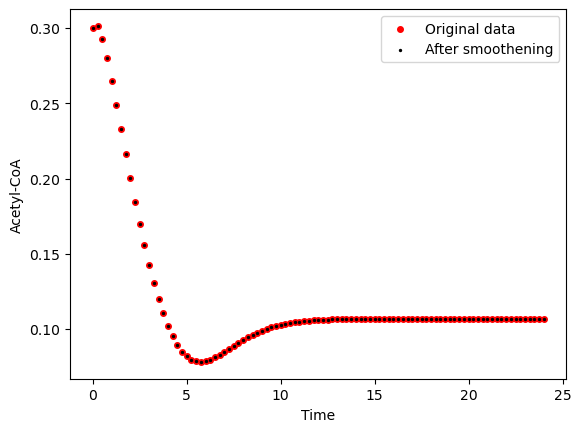

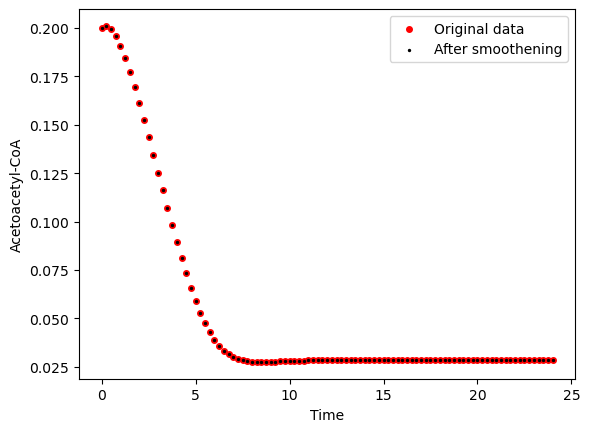

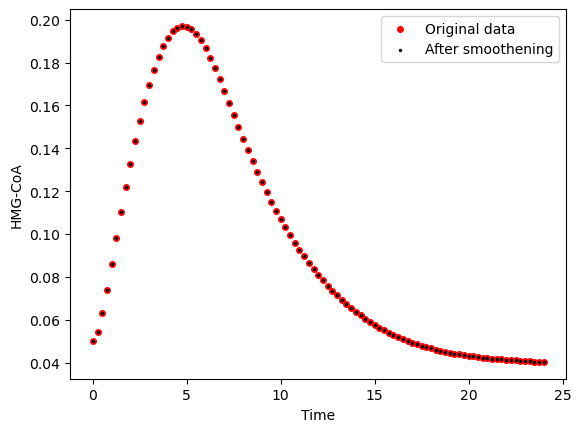

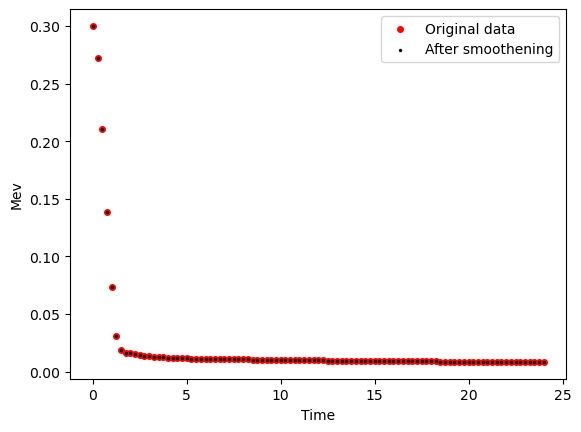

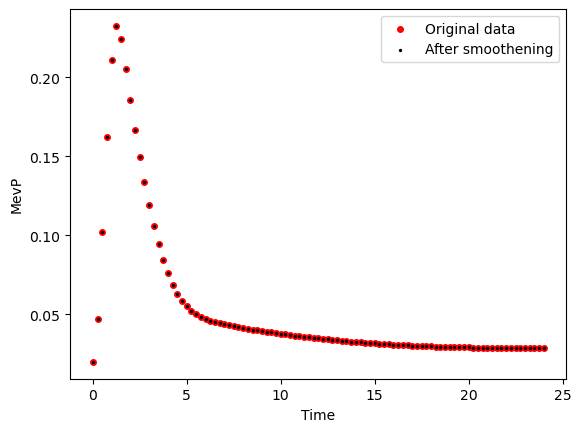

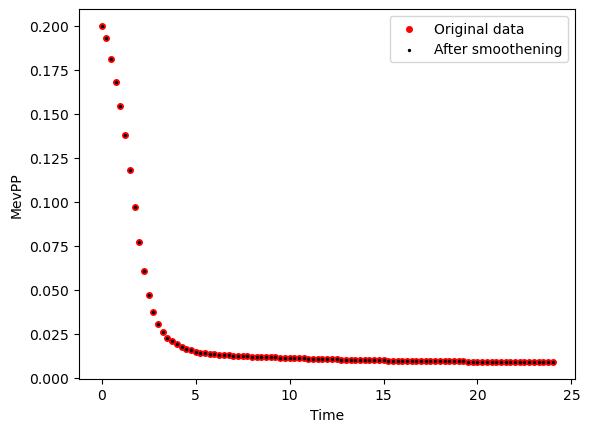

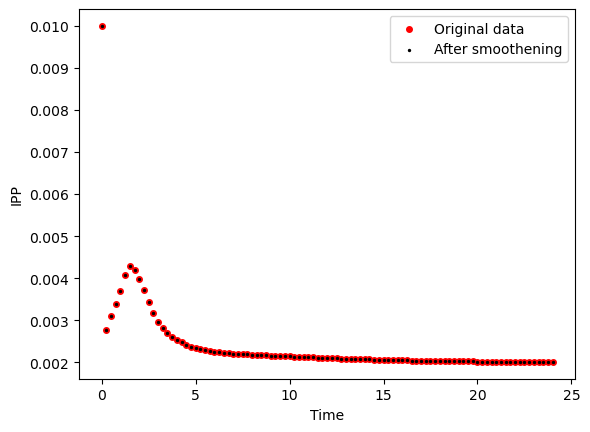

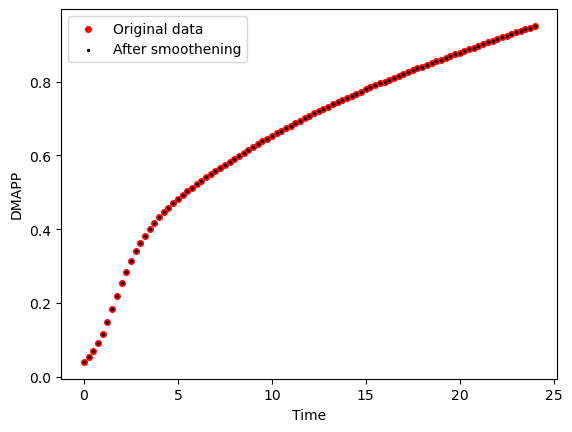

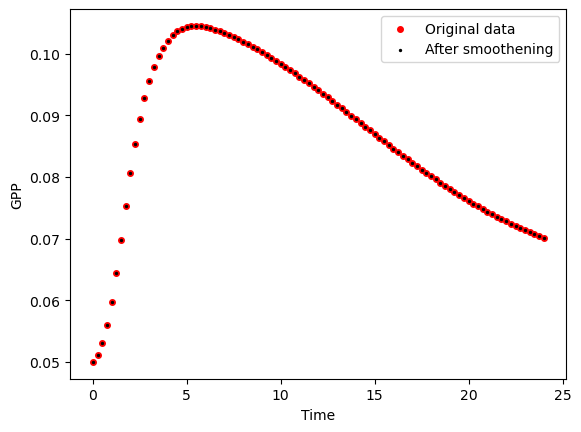

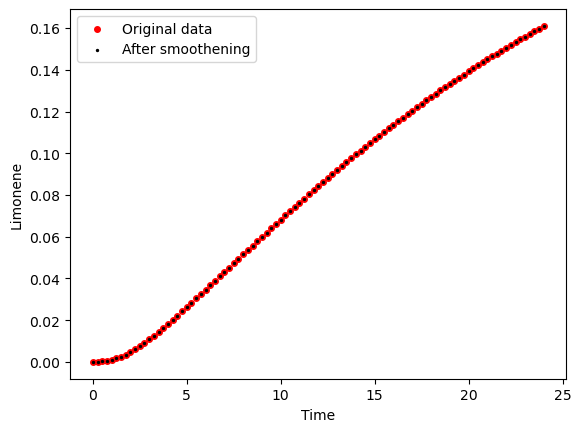

Strain Strain 2


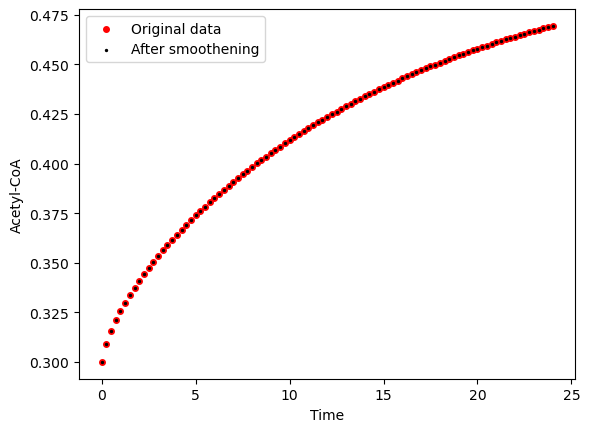

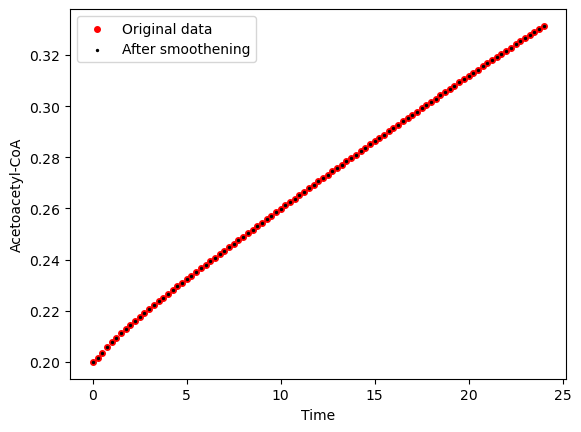

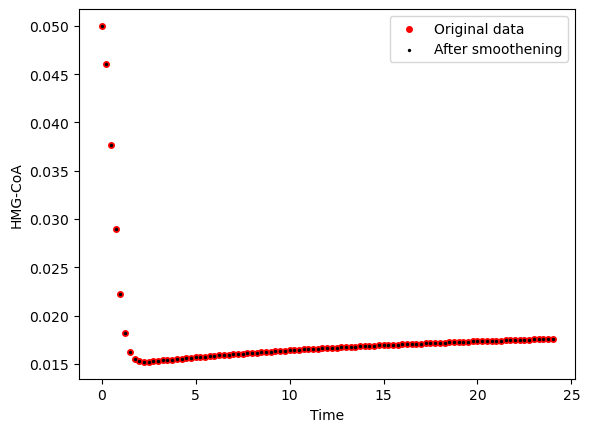

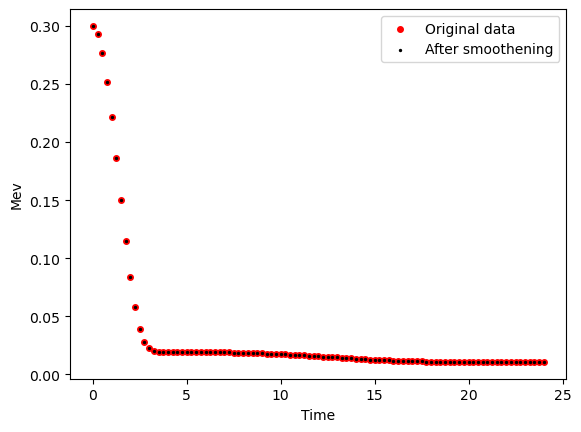

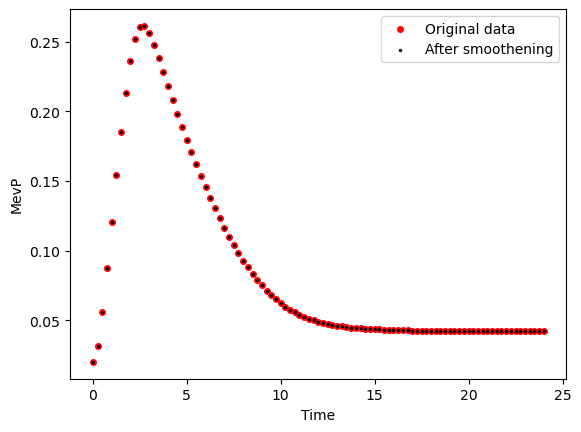

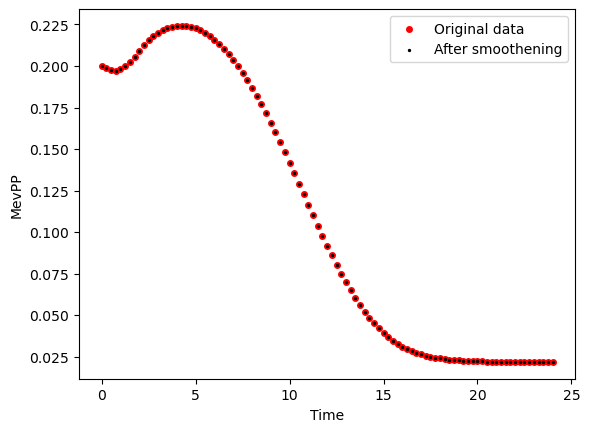

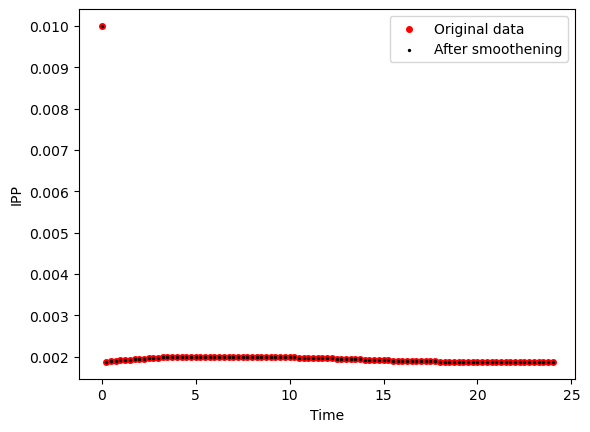

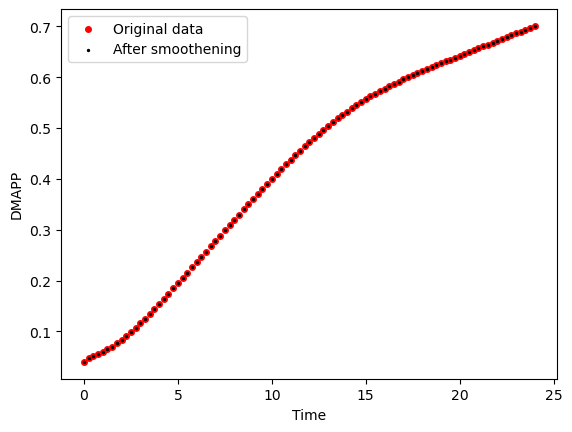

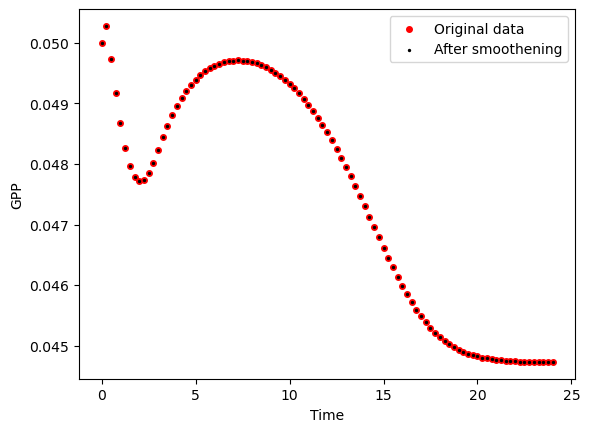

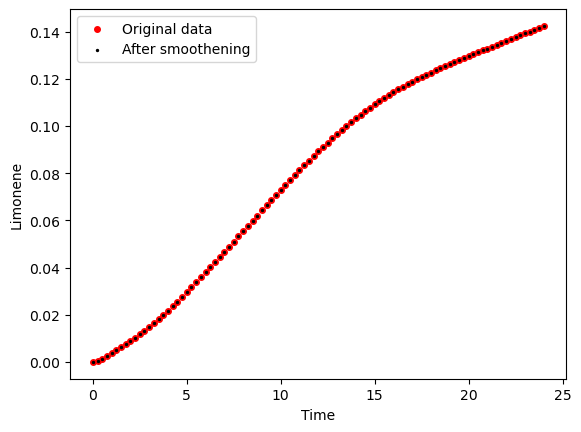

Strain Strain 3


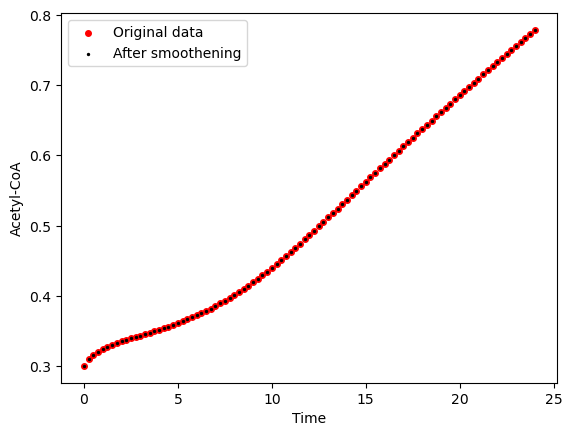

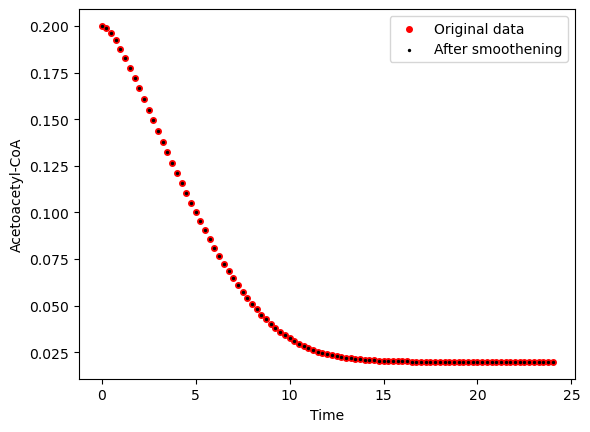

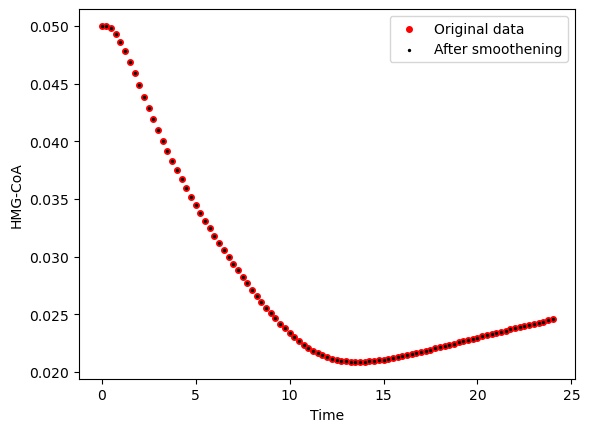

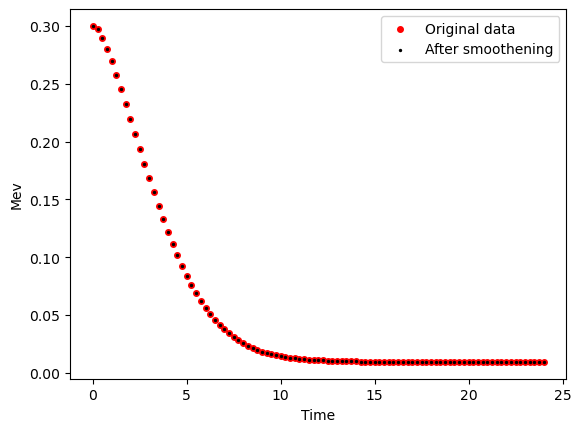

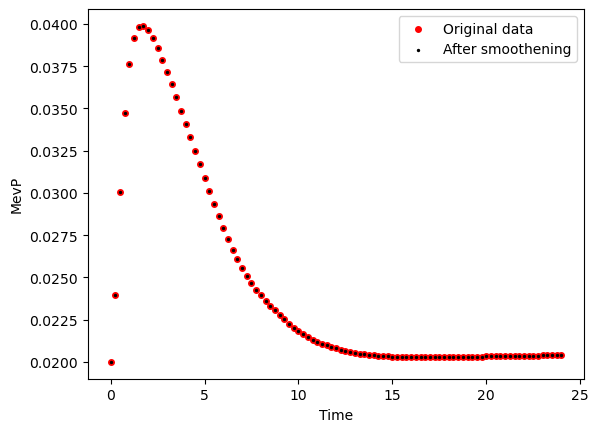

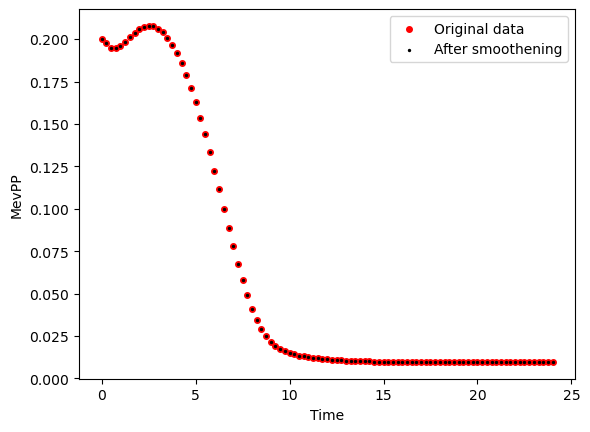

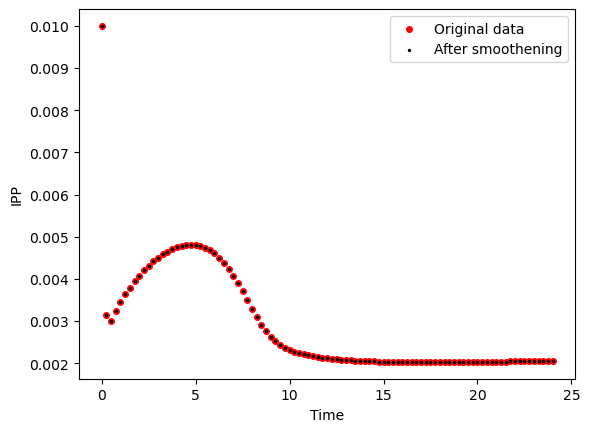

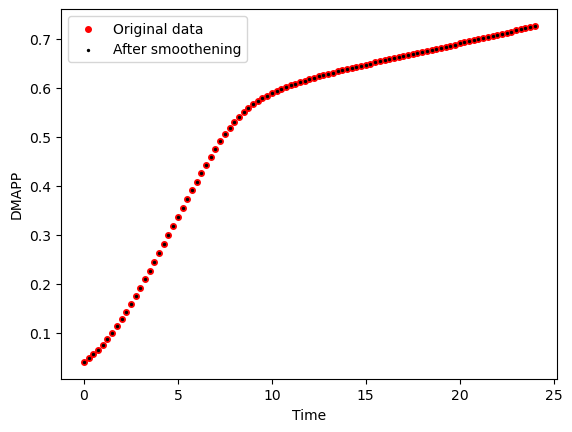

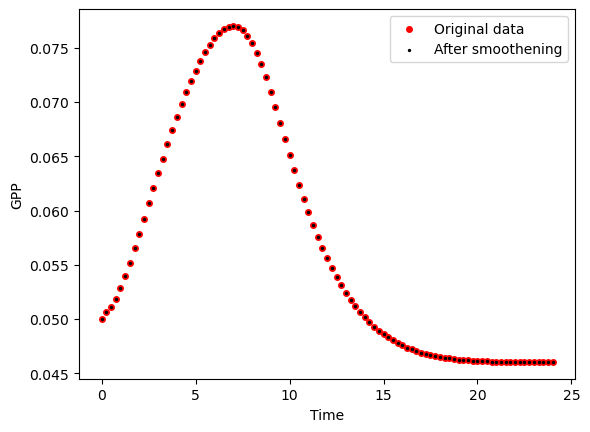

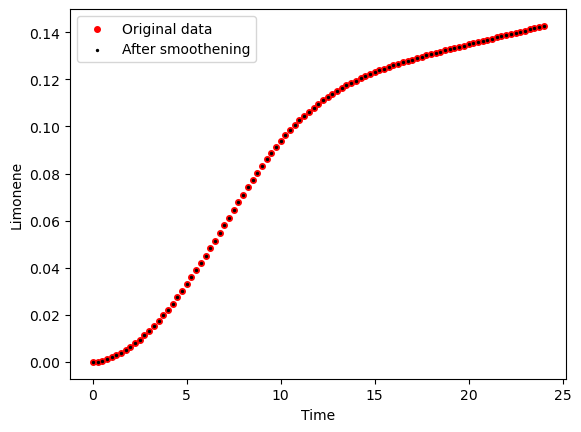

Strain WT


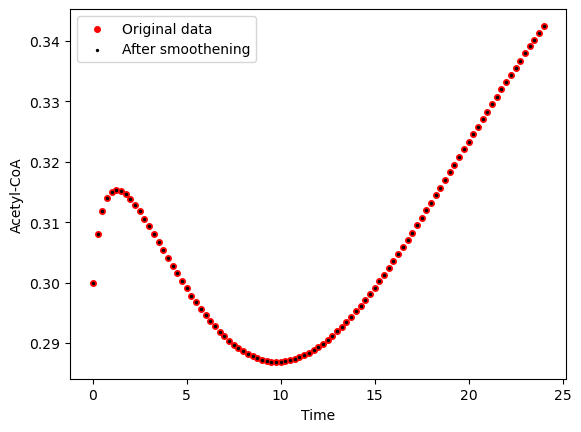

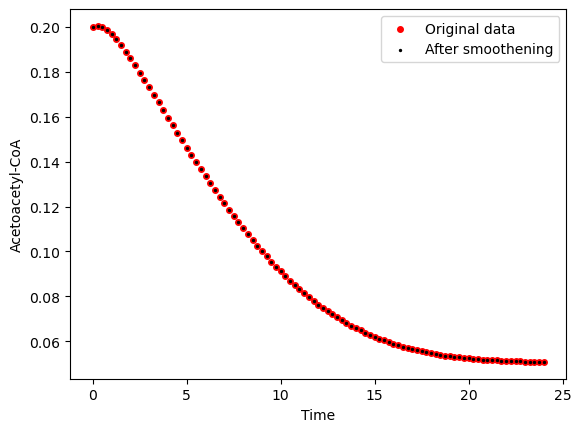

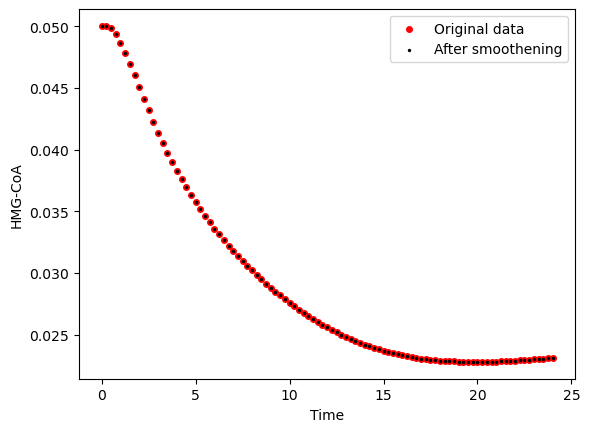

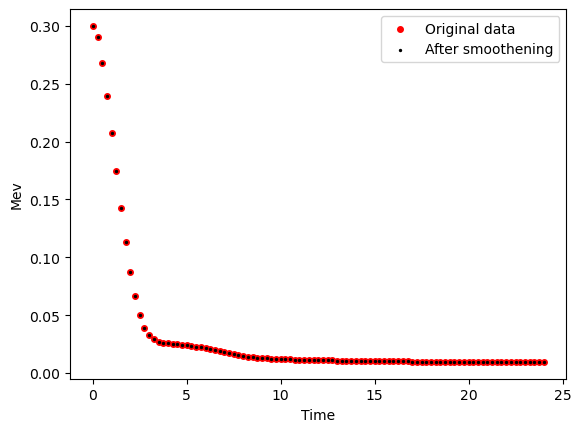

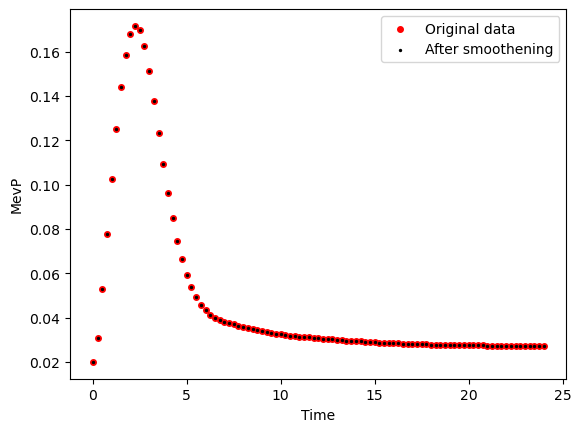

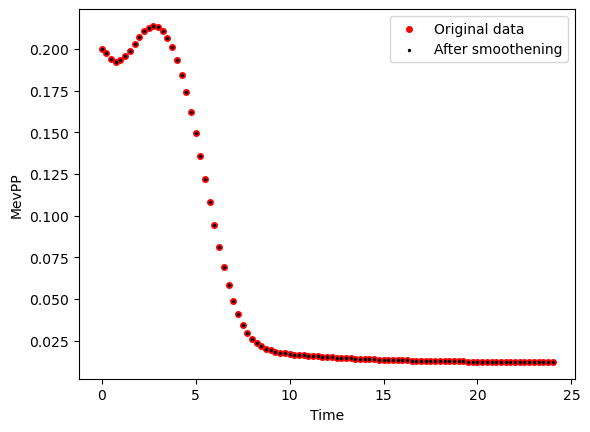

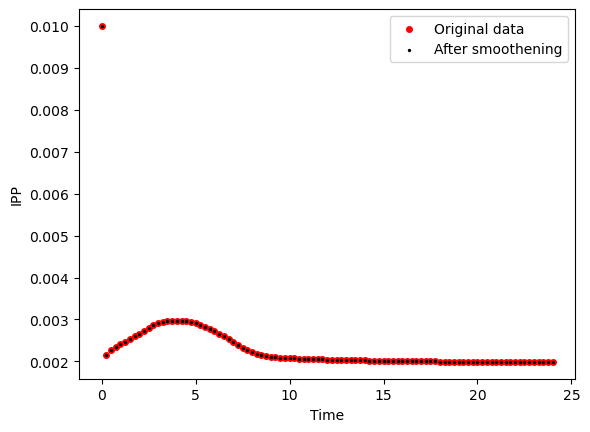

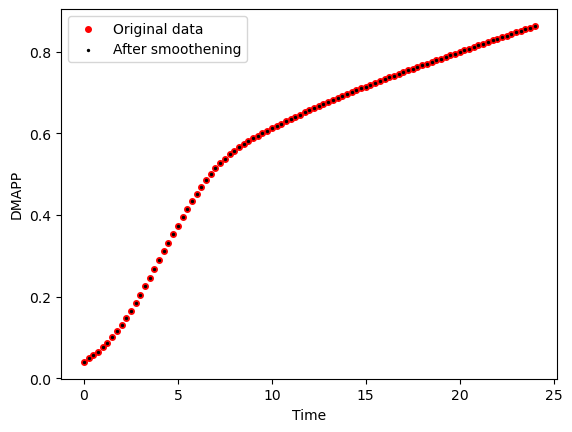

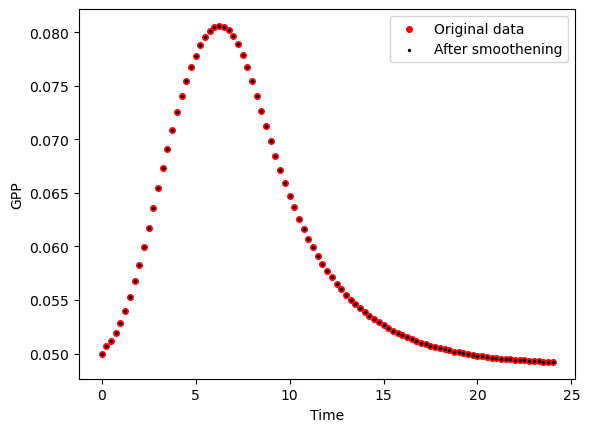

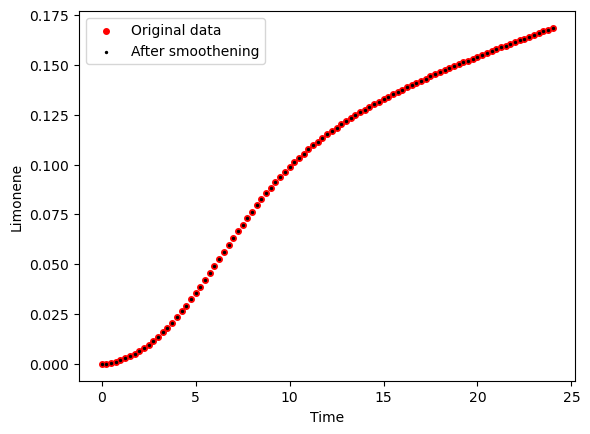

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


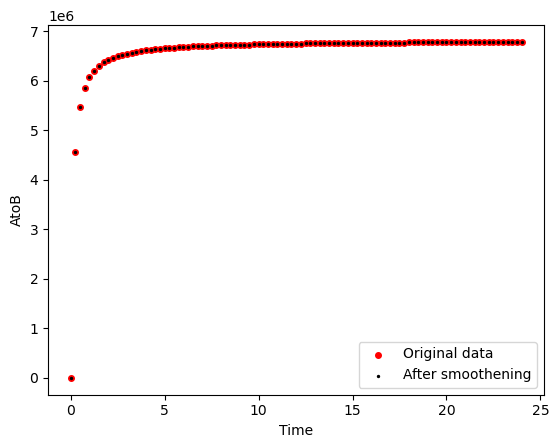

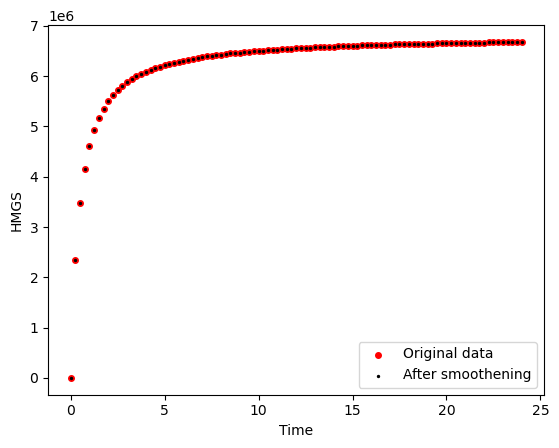

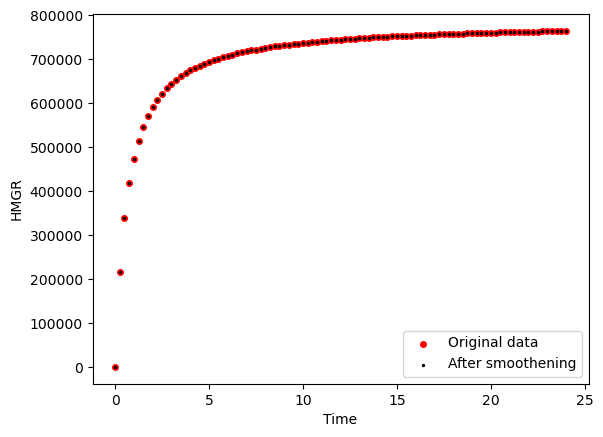

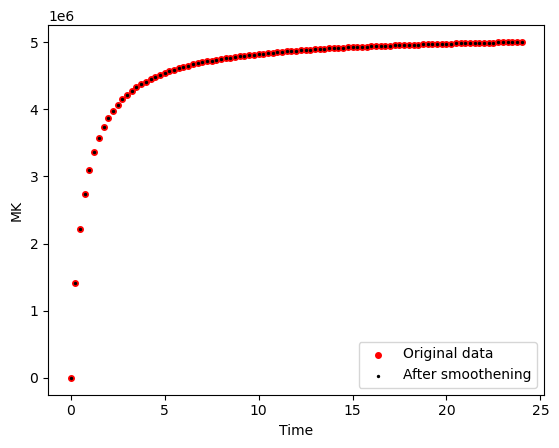

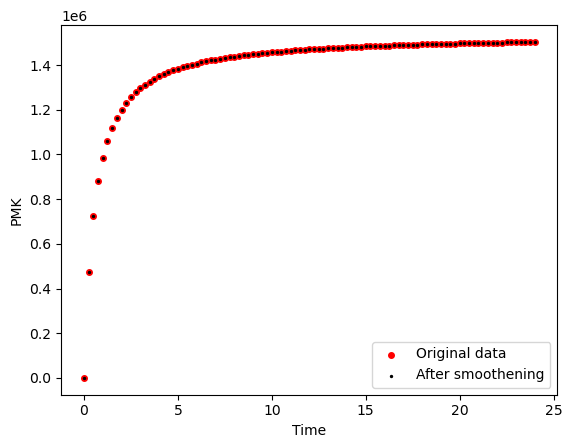

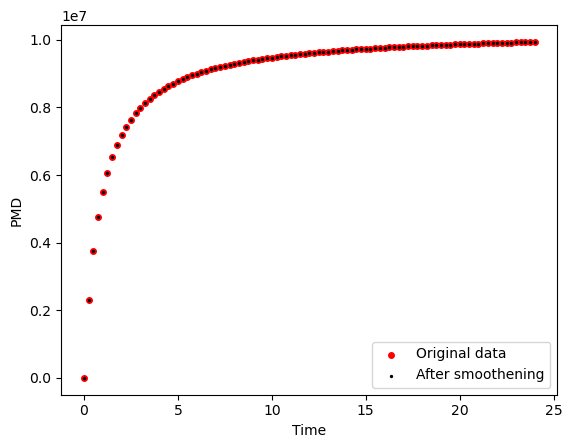

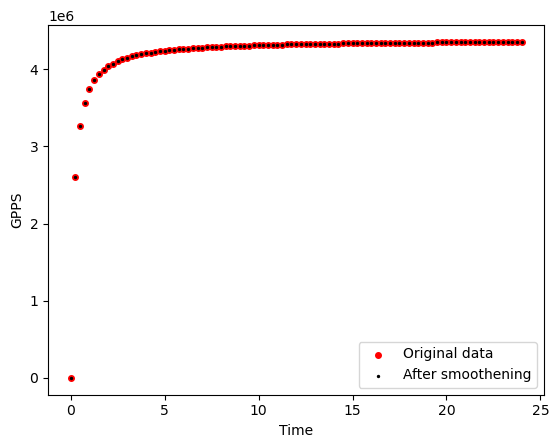

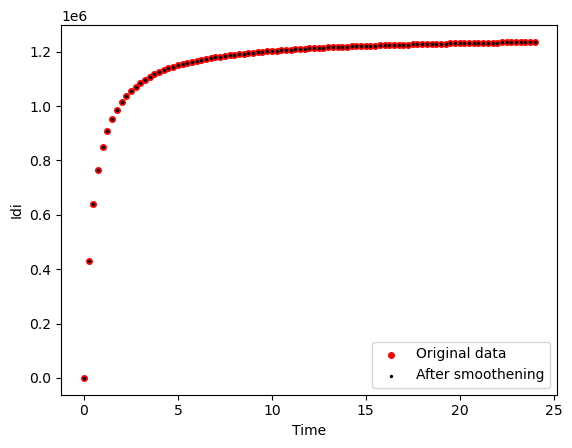

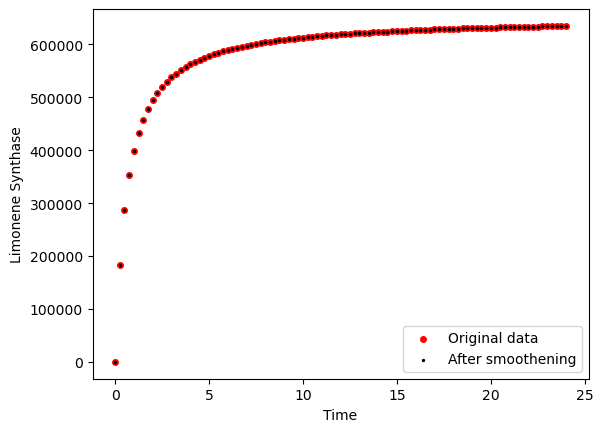

Strain Strain 2


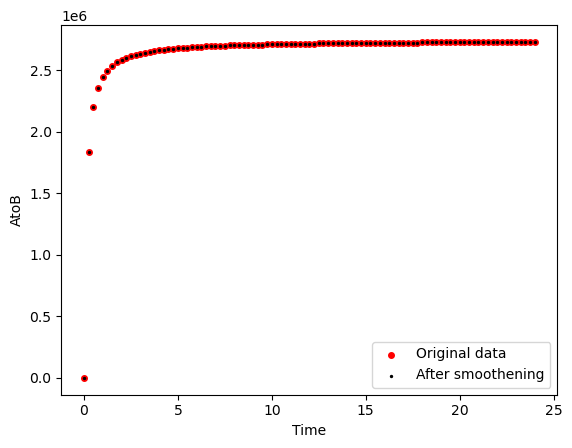

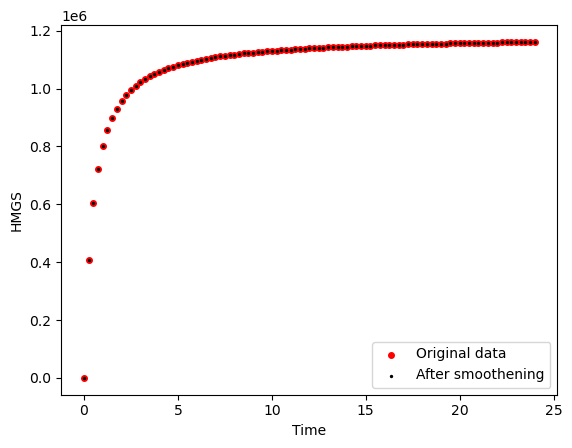

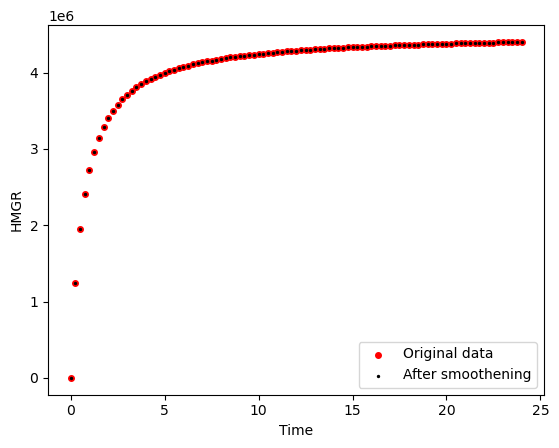

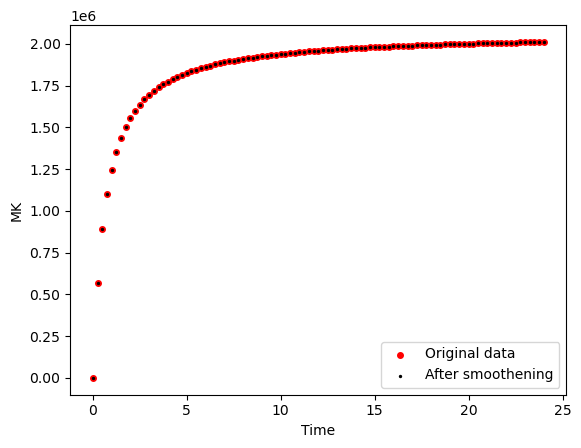

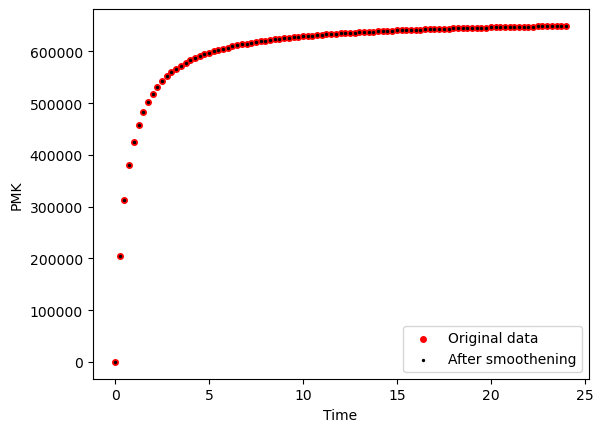

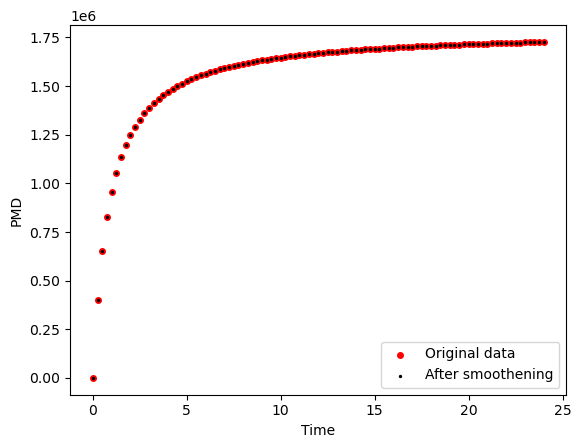

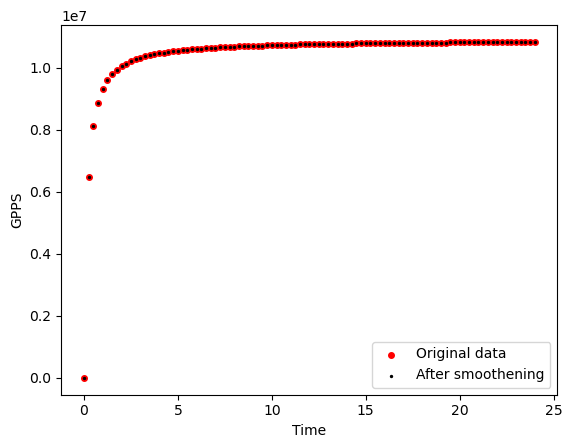

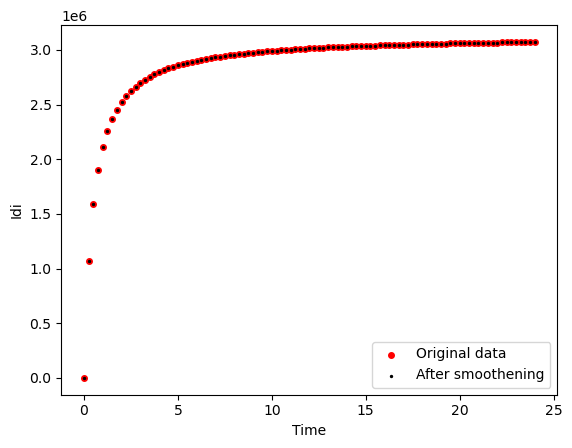

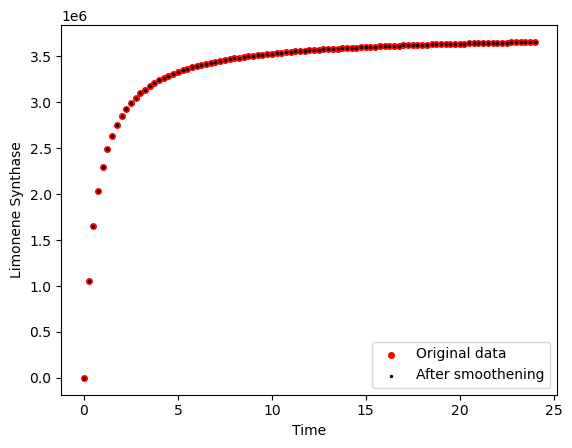

Strain Strain 3


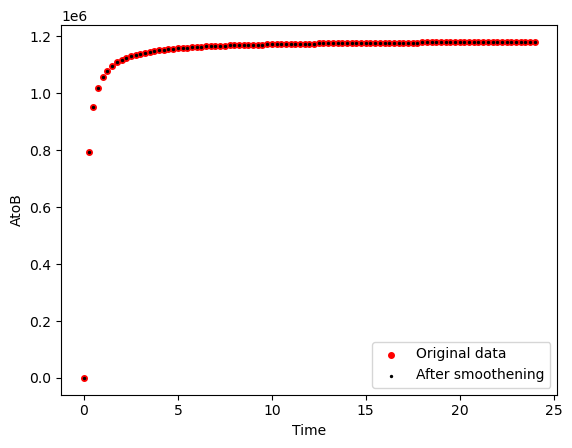

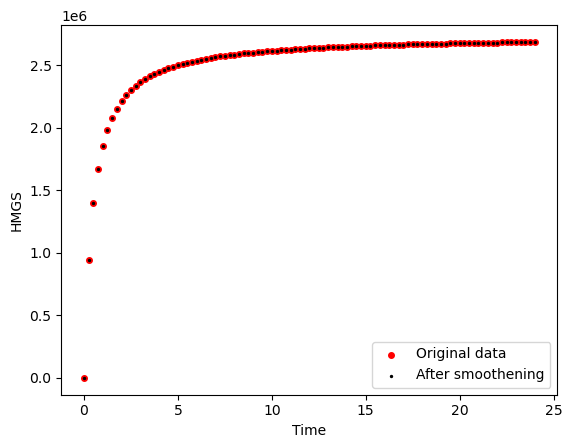

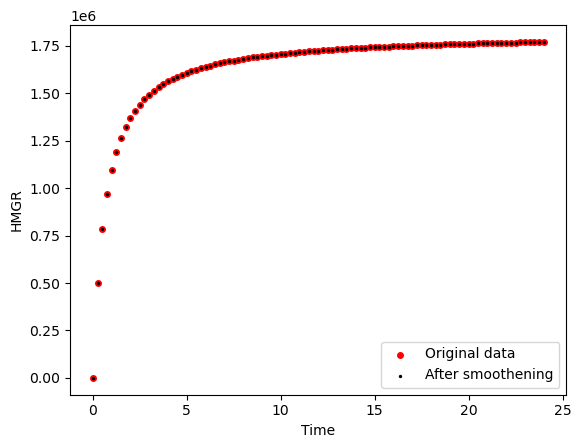

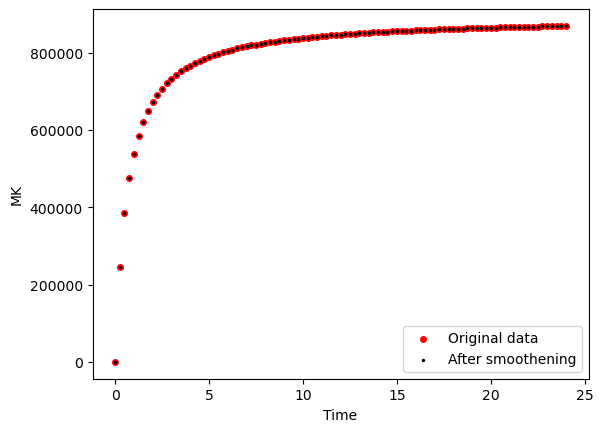

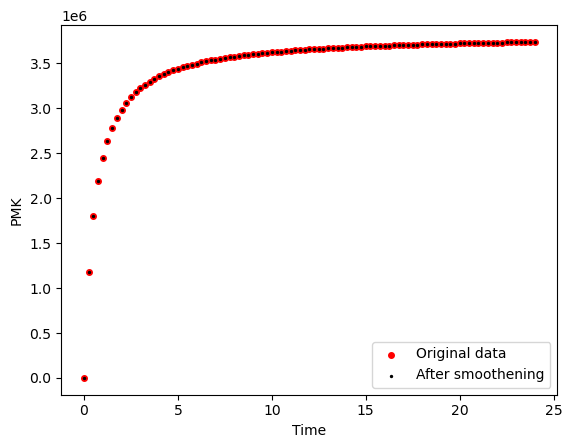

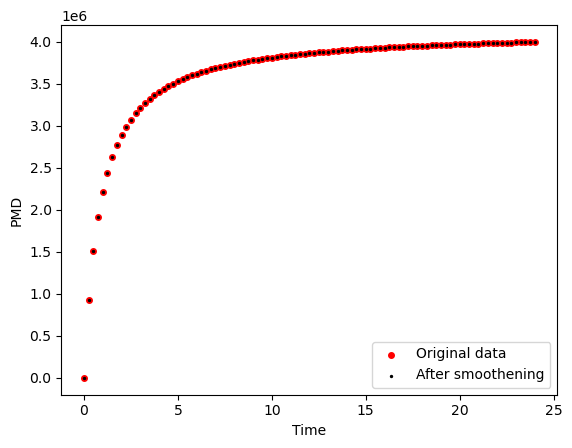

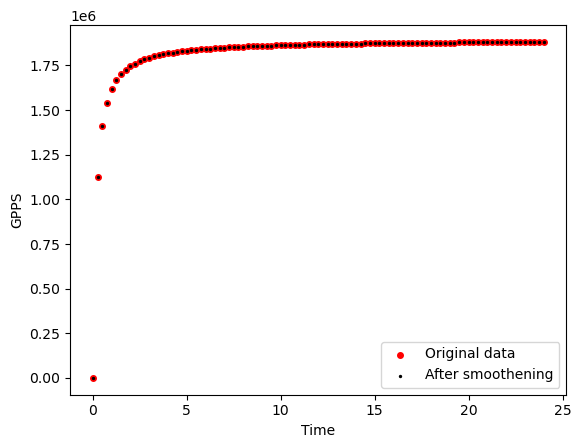

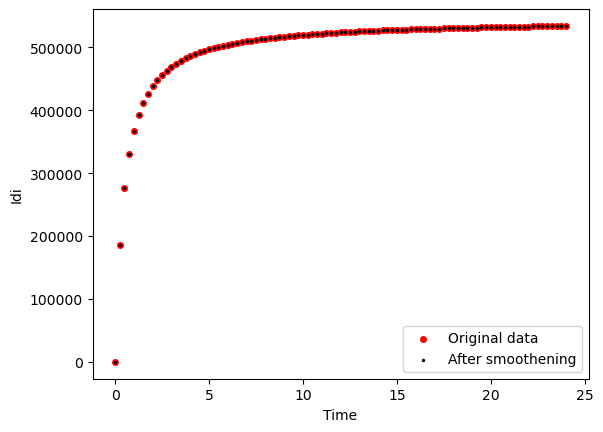

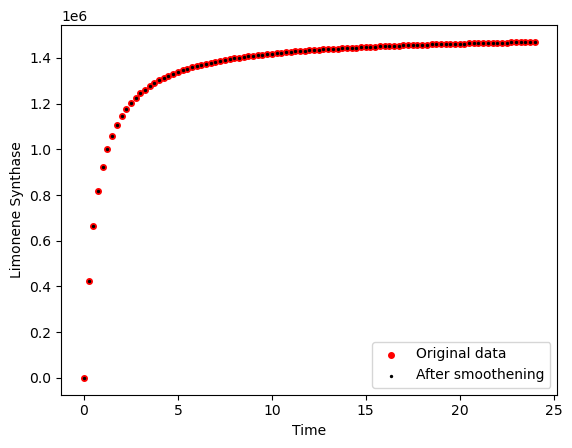

Strain WT


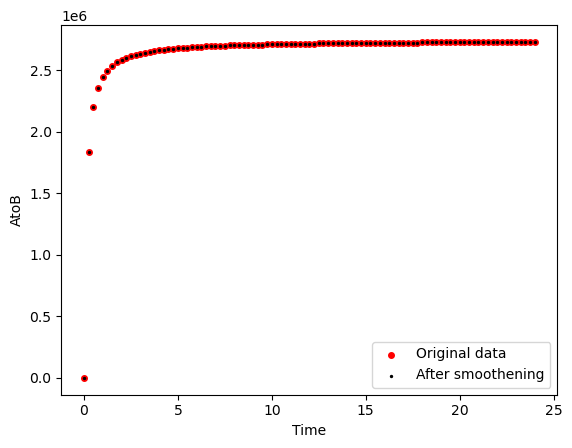

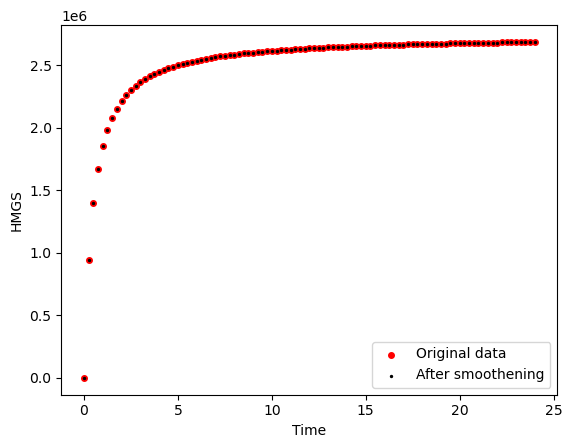

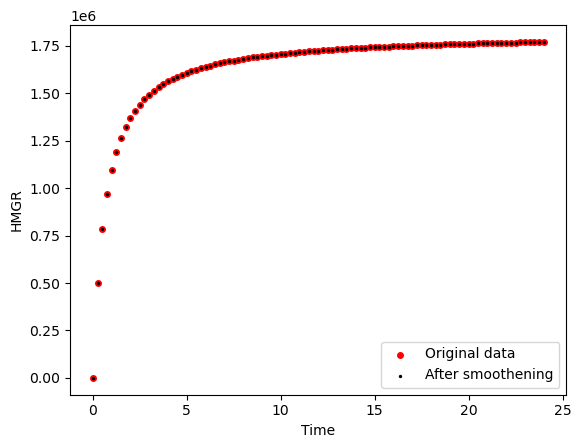

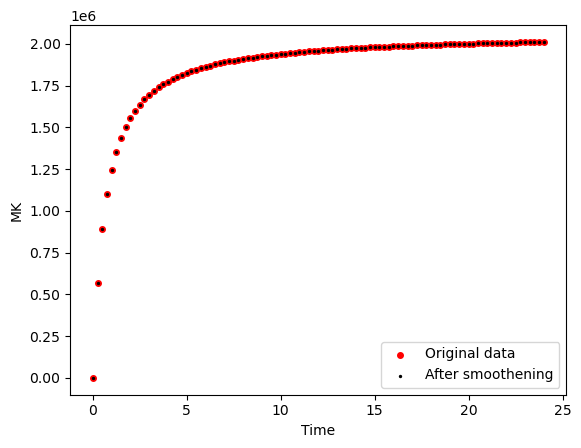

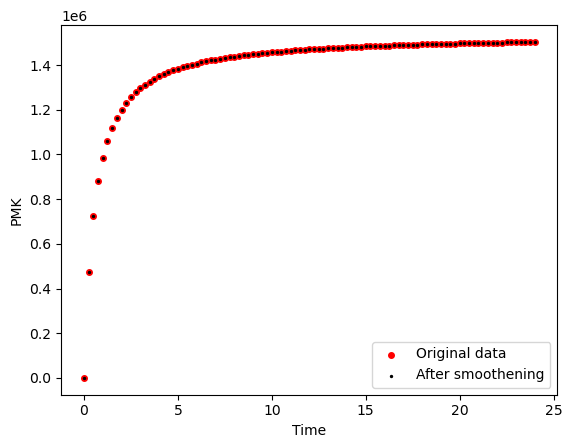

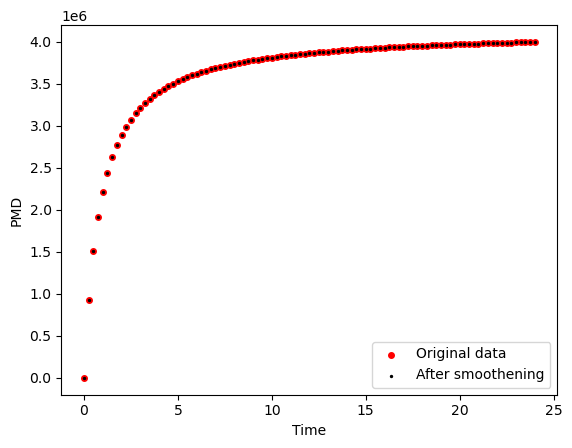

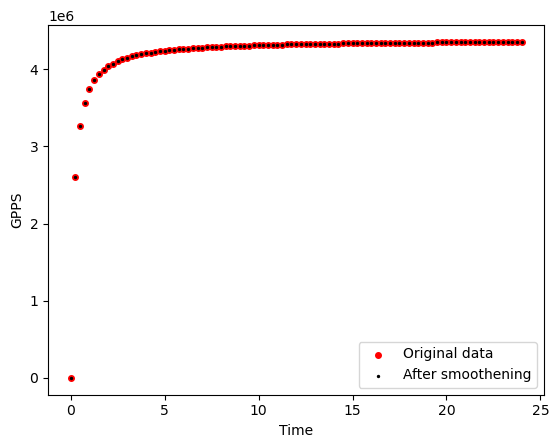

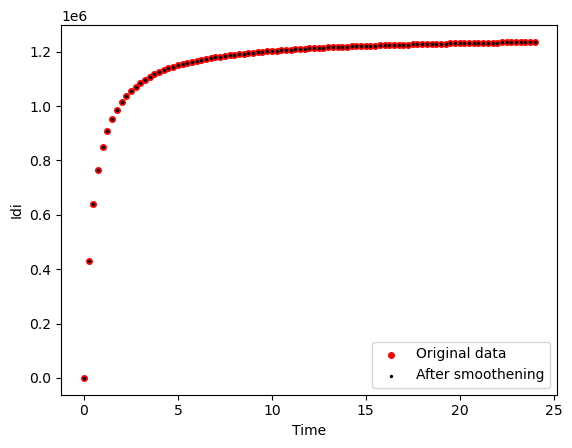

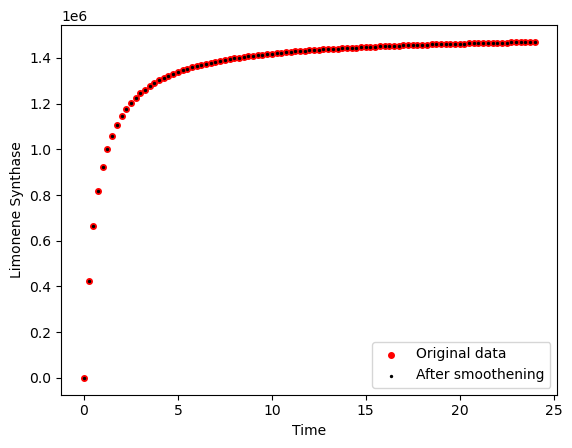

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50    0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75    0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00    0.265117        0.190800  0.086004  0.073142  0.210825   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.337903        0.050990  0.023000  0.009617  0.027290   
         23.25   0.339059        0.050942  0.023029  0.009614  0.027285   
         23.50   0.340204        0.050901  0.023058  0.009612  0.027281   
         23.75   0.341337        0.050867  0.023088  0.009610  0.027278   
         24.00   0.342458        0.050840  0.023119  0.009609  0.027277   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.193065  0.002761  0.053163  0.051176  0.000073  ...   
         0.50   0.181053  0.003095  0.069032  0.053052  0.000270  ...   
         0.75   0.168418  0.003385  0.090652  0.055966  0.000592  ...   
         1.00   0.154756  0.003706  0.116960  0.059768  0.001057  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.012208  0.001987  0.847895  0.049302  0.164976  ...   
         23.25  0.012202  0.001987  0.851852  0.049279  0.165862  ...   
         23.50  0.012197  0.001987  0.855807  0.049258  0.166746  ...   
         23.75  0.012194  0.001987  0.859761  0.049239  0.167627  ...   
         24.00  0.012191  0.001987  0.863714  0.049222  0.168506  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

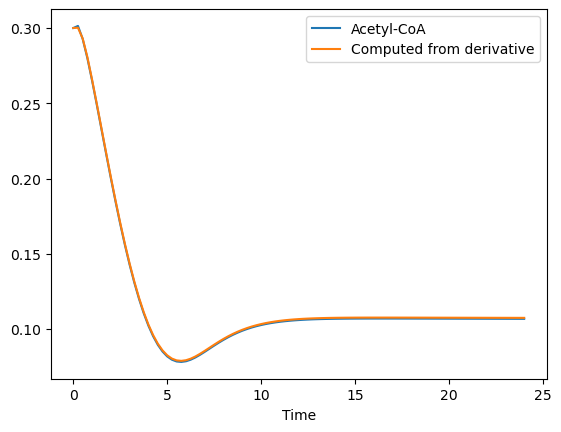

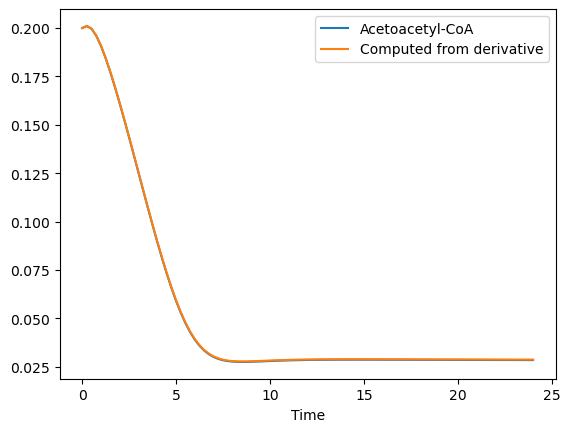

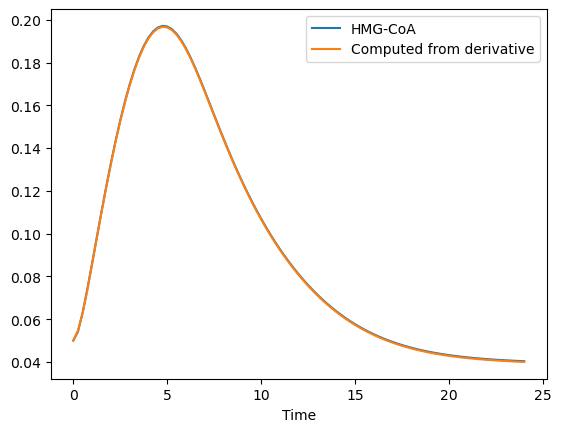

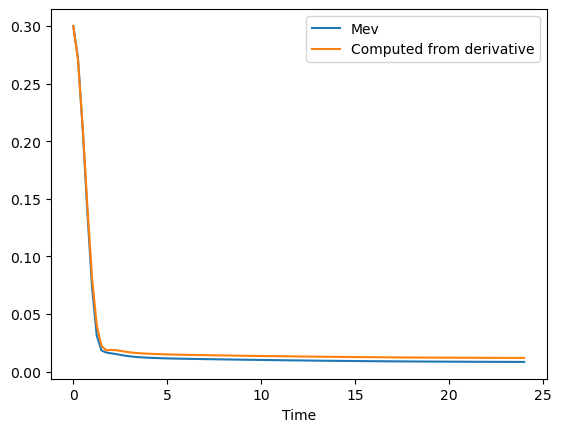

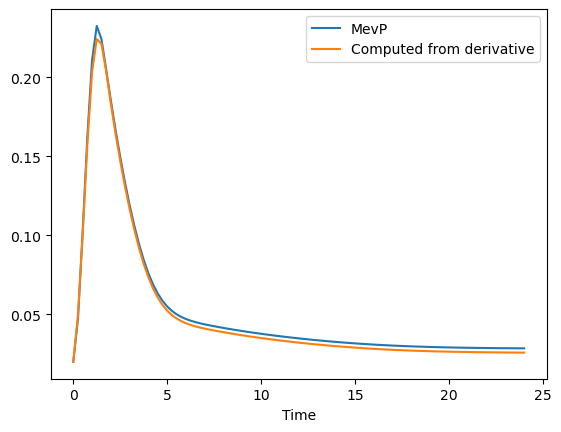

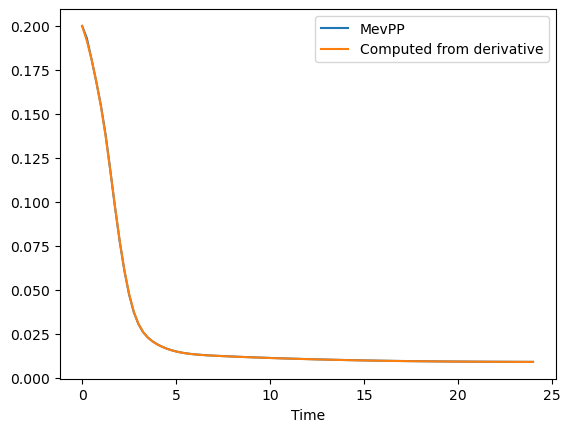

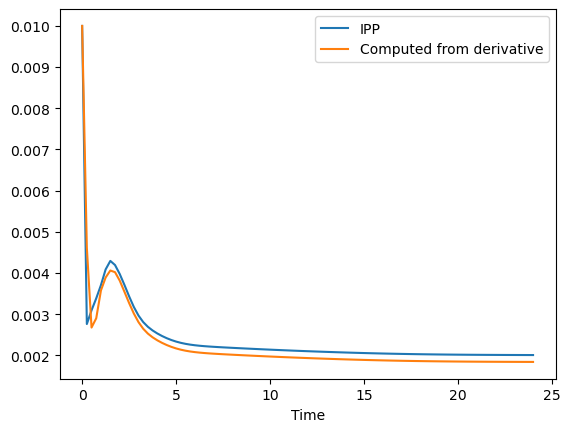

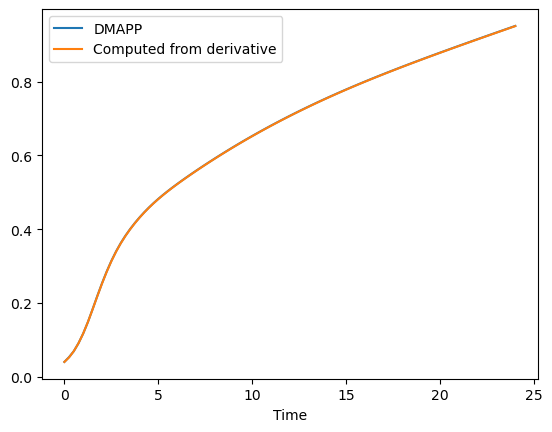

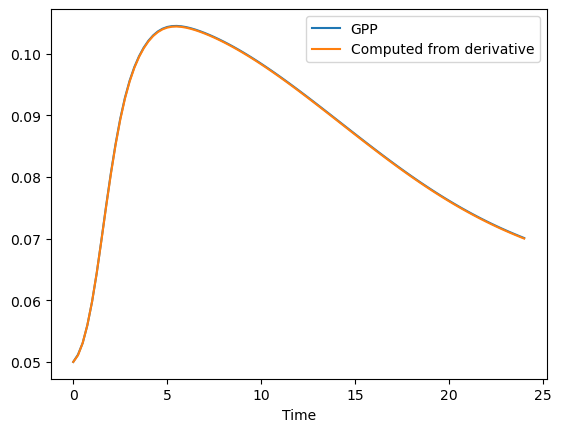

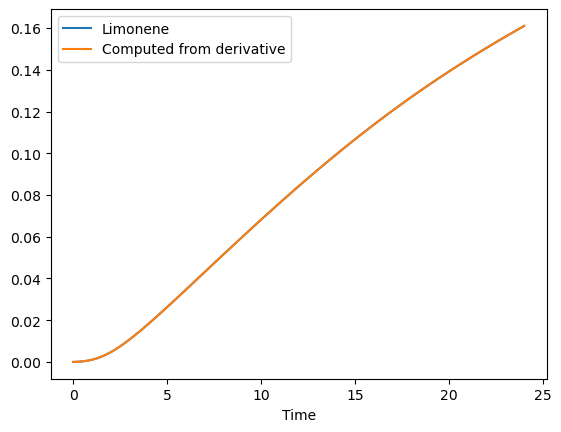

'Time profile from derivative vs. actual profile for Strain 2'

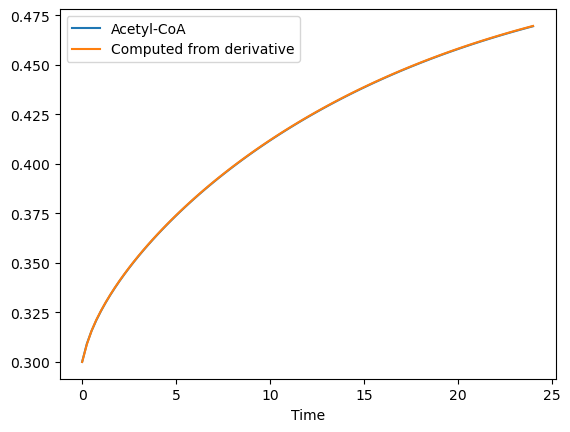

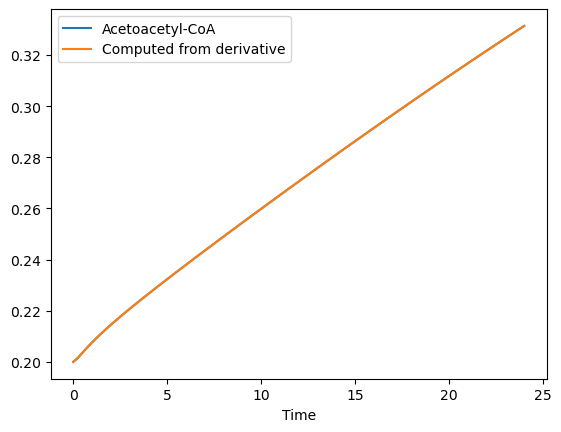

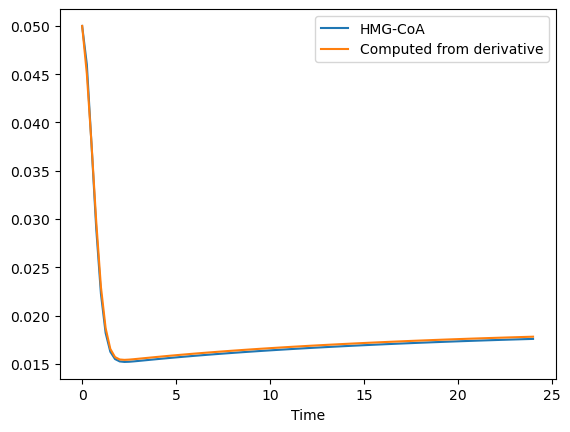

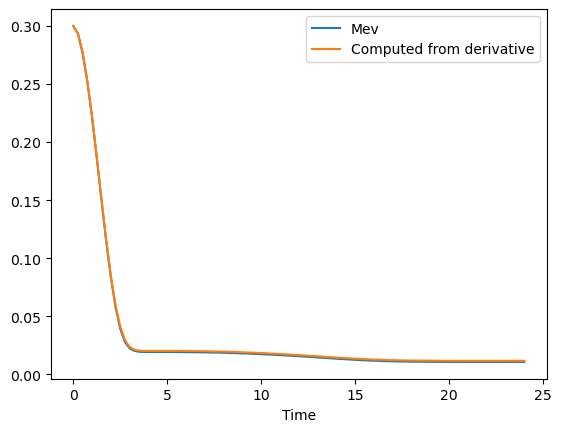

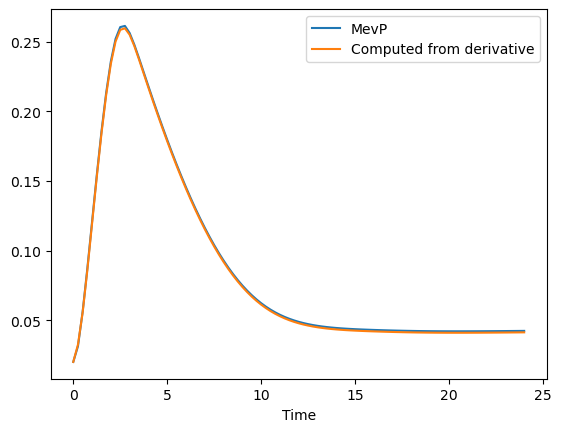

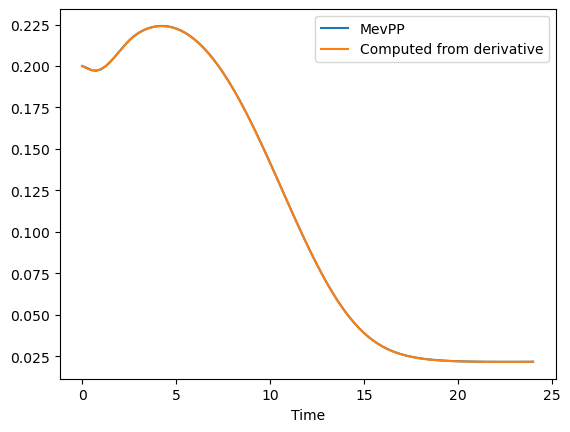

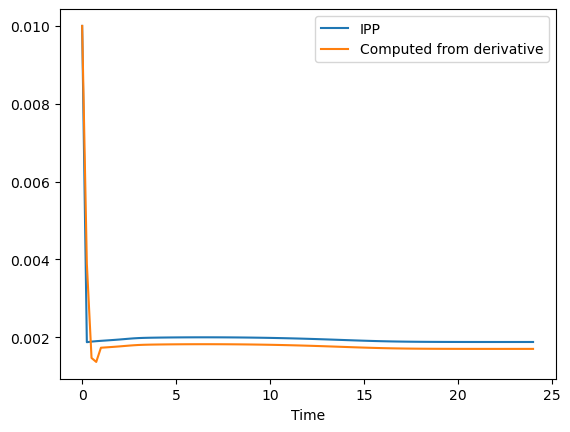

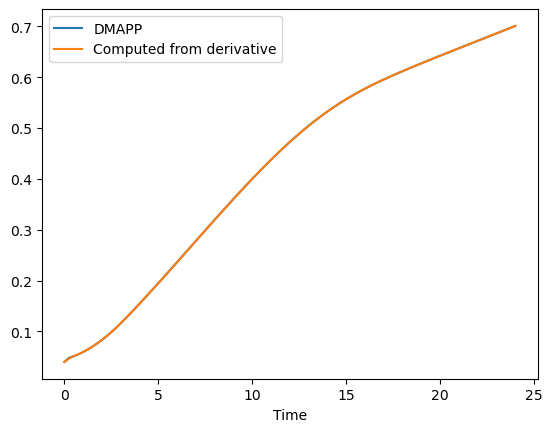

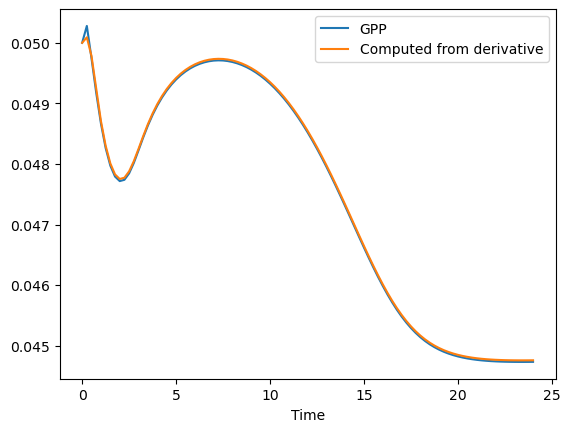

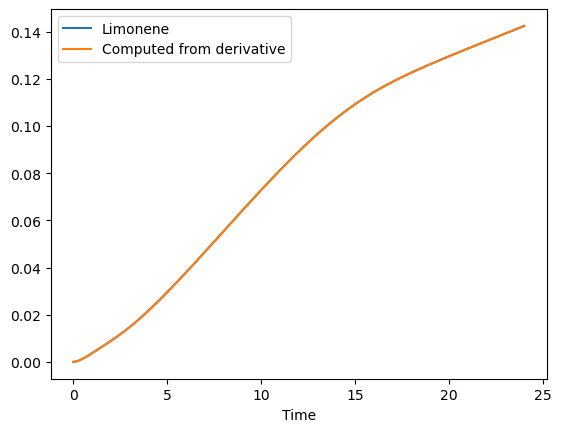

'Time profile from derivative vs. actual profile for Strain 3'

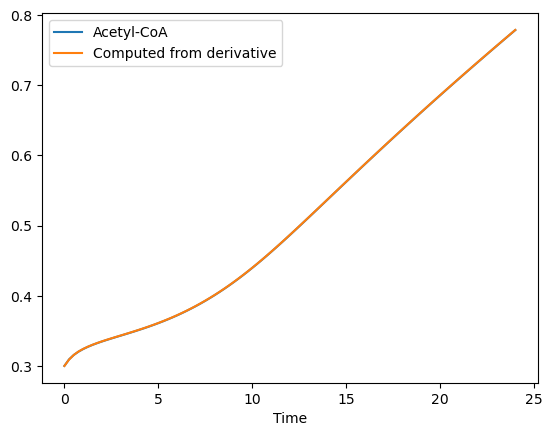

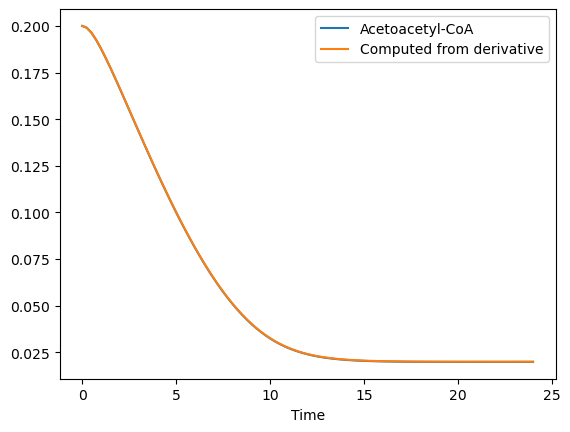

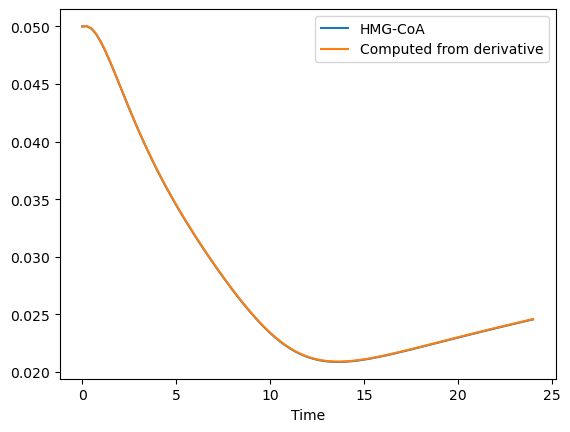

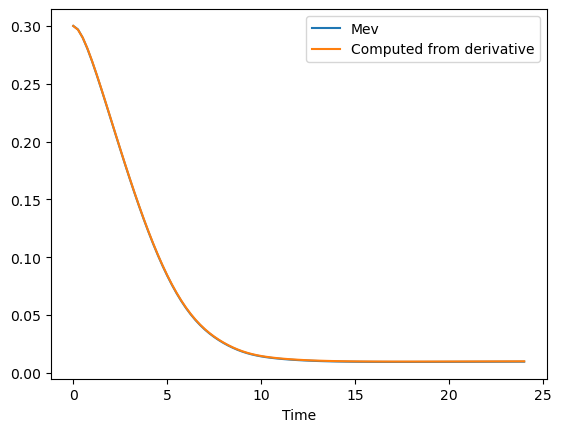

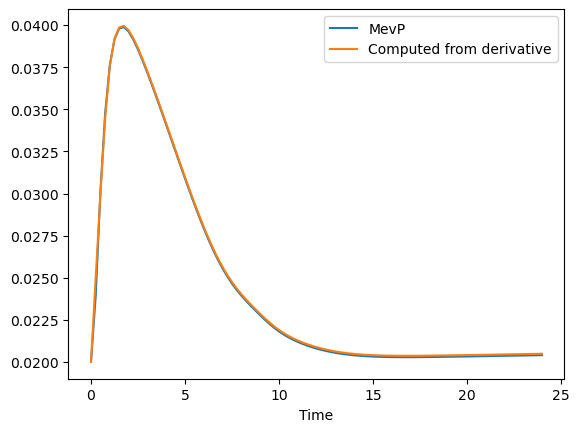

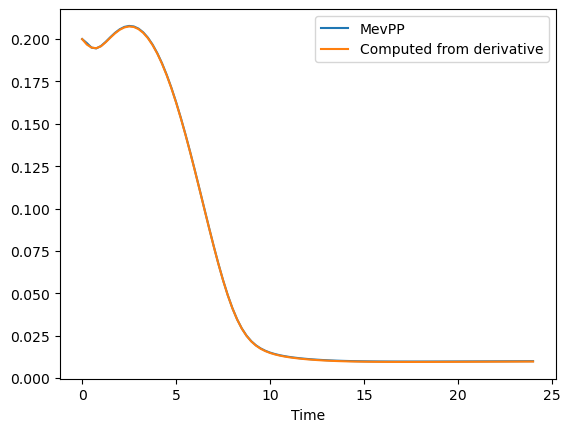

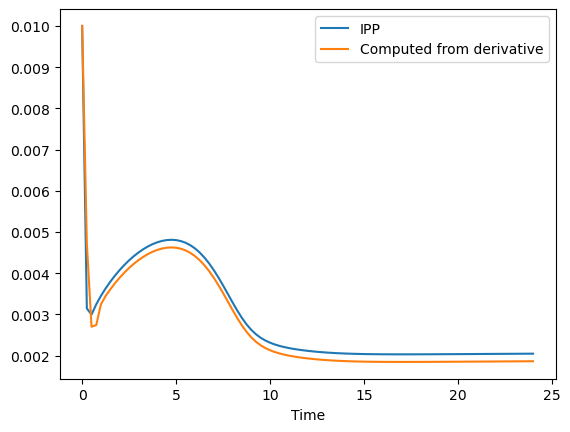

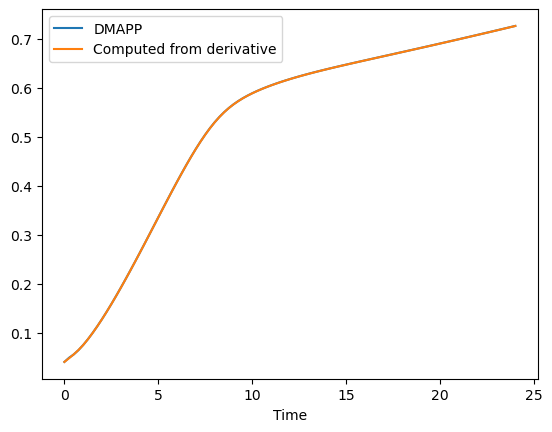

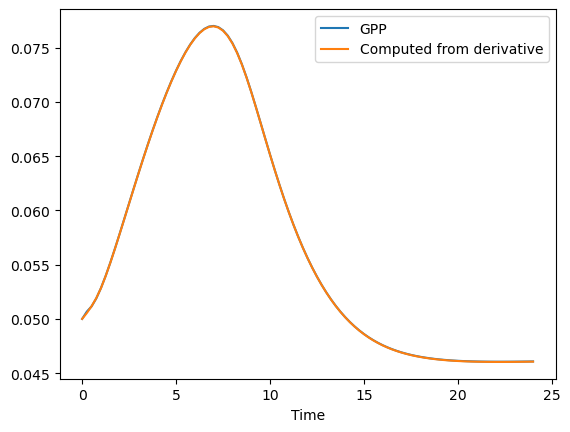

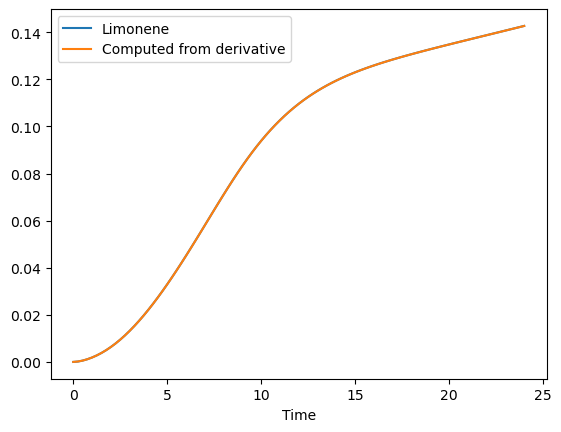

'Time profile from derivative vs. actual profile for WT'

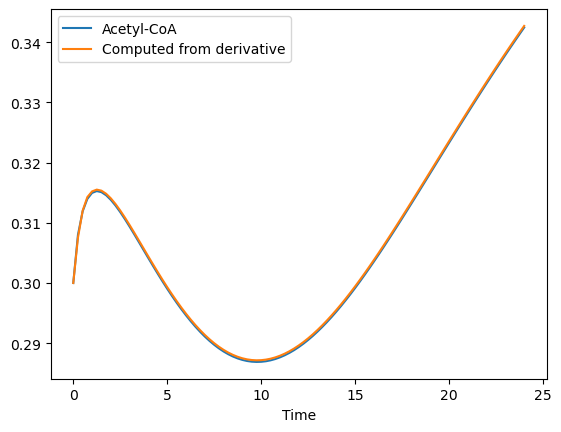

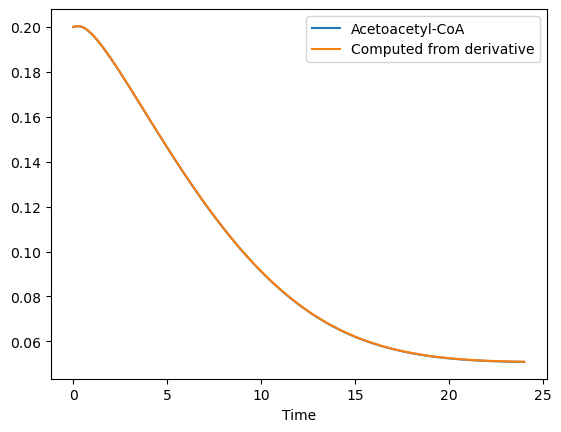

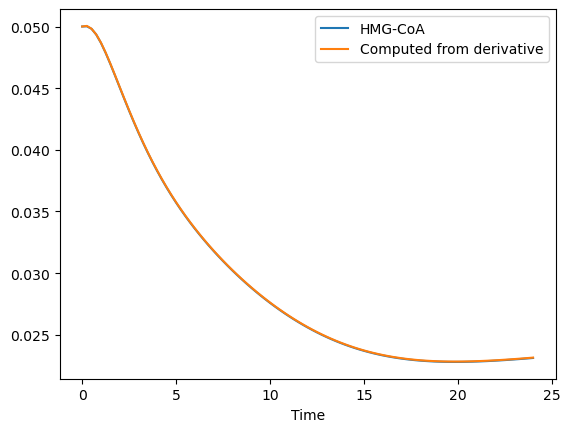

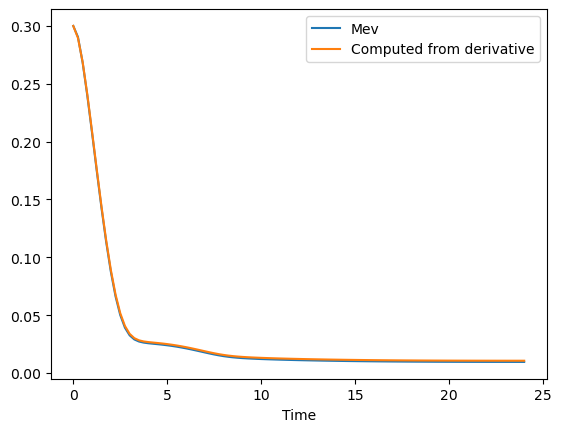

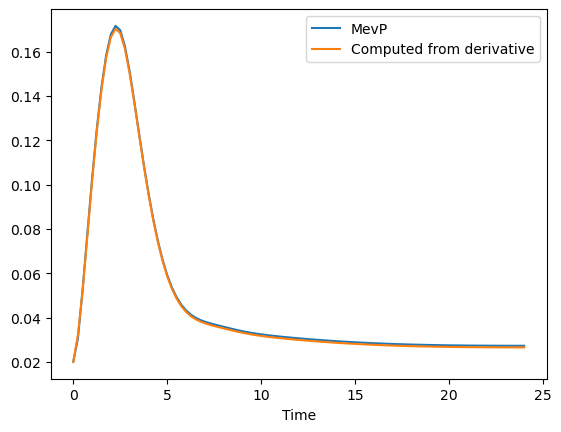

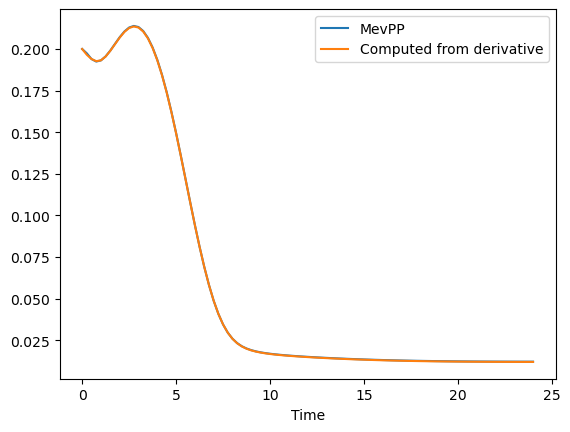

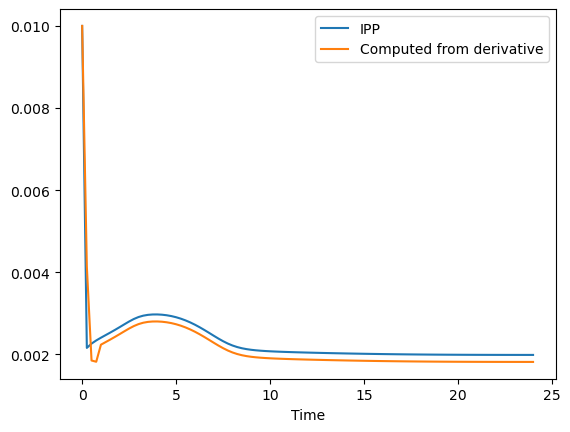

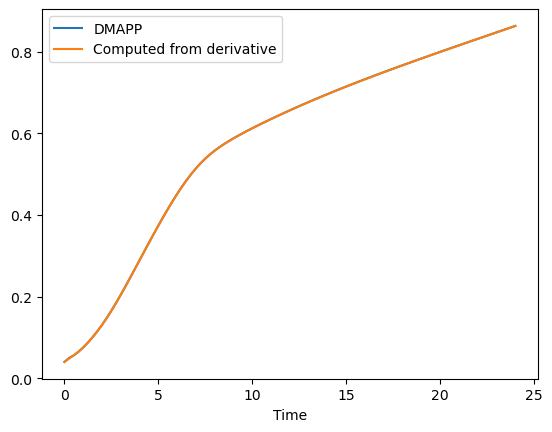

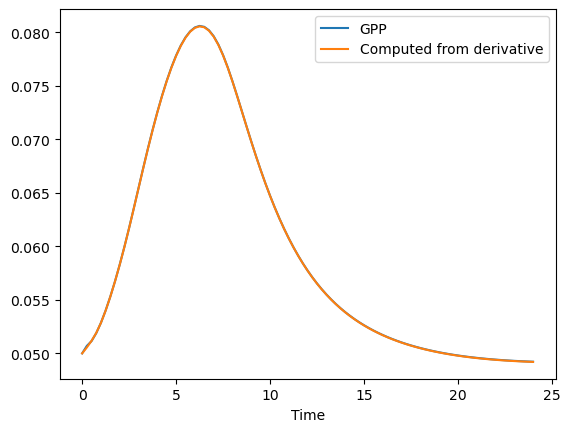

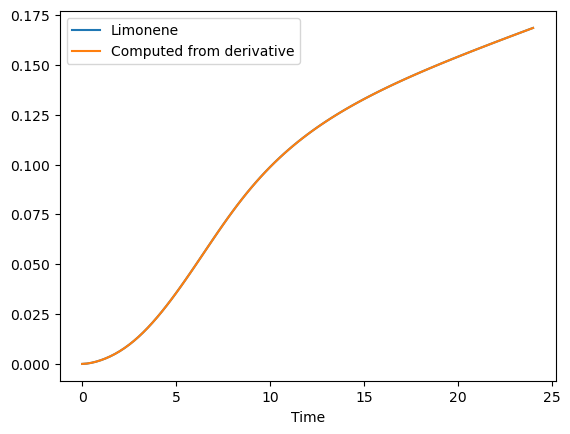

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.301391        0.200998  0.054156   
         0.50       2.866143e+05   0.292768        0.199655  0.063090   
         0.75       3.524272e+05   0.279998        0.196032  0.074110   
         1.00       3.981392e+05   0.265117        0.190800  0.086004   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.337903        0.050990  0.023000   
         23.25      1.468435e+06   0.339059        0.050942  0.023029   
         23.50      1.468851e+06   0.340204        0.050901  0.023058   
         23.75      1.469260e+06   0.341337        0.050867  0.023088   
         24.00      1.469659e+06   0.342458        0.050840  0.023119   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.272337  0.047074  0.193065  0.002761  0.053163  0.051176   
         0.50   0.211002  0.102371  0.181053  0.003095  0.069032  0.053052   
         0.75   0.138704  0.162352  0.168418  0.003385  0.090652  0.055966   
         1.00   0.073142  0.210825  0.154756  0.003706  0.116960  0.059768   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.009617  0.027290  0.012208  0.001987  0.847895  0.049302   
         23.25  0.009614  0.027285  0.012202  0.001987  0.851852  0.049279   
         23.50  0.009612  0.027281  0.012197  0.001987  0.855807 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.507546e-07  0.015814 -0.000072  0.003521  
         24.00 -0.000010 -7.381028e-08  0.015812 -0.000065  0.003514  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=27, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-1.30103                         
                         ]), # lower bounds
                         xu=np.array([
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0,-1.301029
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,
                       k21,k22,k23,
                       k31,k32,k33,k34,
                       k41,k42,k43,k44,
                       k51,k52,
                       k61,k62,k63,k64,
                       k71,k72,
                       k81,k82,k83,
                       k91,k92,
                       Vin): #HC: 27
    
        r1 = e1 *( (10**k11) + (10**k12)*np.log(s1) )
        r2 = e2 *( (10**k21) + (10**k22)*np.log(s1) + (10**k23)*np.log(s2) ) 
        r3 = e3 *( (10**k31) - (10**k32)*np.log(s1) - (10**k33)*np.log(s2) + (10**k34)*np.log(s3) )
        r4 = e4 *( (10**k41) + (10**k42)*np.log(s4) - (10**k43)*np.log(s9) - (10**k44)*np.log(s6) )
        r5 = e5 *( (10**k51) + (10**k52)*np.log(s5) )
        r6 = e6 *( (10**k61) + (10**k62)*np.log(s6) - (10**k63)*np.log(s5) - (10**k64)*np.log(s4) )
        r7 = e7 *( (10**k71) + (10**k72)*np.log(s7) )
        r8 = e8 *( (10**k81) + (10**k82)*np.log(s7) + (10**k83)*np.log(s8) )
        r9 = e9 *( (10**k91) + (10**k92)*np.log(s9) )
        r10 = 10**Vin # AcCoA supply
                
        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9
        
        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'DE'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: DE

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 |  1.351681E+18 |  3.686716E+12
     2 |      128 |  9.275505E+17 |  3.686716E+12
     3 |      192 |  7.793643E+17 |  3.686716E+12
     4 |      256 |  5.434359E+17 |  3.686716E+12
     5 |      320 |  1.884015E+17 |  3.686716E+12
     6 |      384 |  1.443287E+17 |  3.686716E+12
     7 |      448 |  1.048947E+17 |  3.686716E+12
     8 |      512 |  8.727727E+16 |  6.098639E+11
     9 |      576 |  5.525654E+16 |  5.487695E+11
    10 |      640 |  5.087576E+16 |  5.487695E+11
    11 |      704 |  4.851635E+16 |  5.487695E+11
    12 |      768 |  4.445288E+16 |  6.069613E+09
    13 |      832 |  2.763077E+16 |  6.069613E+09
    14 |      896 |  2.121058E+16 |  6.069613E+09
    15 |      960 |  5.825702E+15 |  6.069613E+09
    16 |     1024 |  3.603600E+15 |  5.606506E+09
    17 |     1088 |  3.022933E+15 |  5.961712E+07
    18 |     1152 |  2.418774E+15 |  5.961712E+07
    19 |     1216 |  2.26988

   162 |    10368 |  4.986186E+01 |  4.425953E+01
   163 |    10432 |  4.973223E+01 |  4.425953E+01
   164 |    10496 |  4.955111E+01 |  4.425953E+01
   165 |    10560 |  4.945636E+01 |  4.425953E+01
   166 |    10624 |  4.927396E+01 |  4.425953E+01
   167 |    10688 |  4.919281E+01 |  4.425953E+01
   168 |    10752 |  4.908778E+01 |  4.425953E+01
   169 |    10816 |  4.900699E+01 |  4.425953E+01
   170 |    10880 |  4.893013E+01 |  4.295017E+01
   171 |    10944 |  4.885949E+01 |  4.295017E+01
   172 |    11008 |  4.875294E+01 |  4.295017E+01
   173 |    11072 |  4.865409E+01 |  4.295017E+01
   174 |    11136 |  4.860440E+01 |  4.295017E+01
   175 |    11200 |  4.856451E+01 |  4.295017E+01
   176 |    11264 |  4.850336E+01 |  4.295017E+01
   177 |    11328 |  4.846560E+01 |  4.295017E+01
   178 |    11392 |  4.839794E+01 |  4.259718E+01
   179 |    11456 |  4.832050E+01 |  4.259718E+01
   180 |    11520 |  4.827480E+01 |  4.259718E+01
   181 |    11584 |  4.821033E+01 |  4.259718E+01


   326 |    20864 |  4.529342E+01 |  3.840756E+01
   327 |    20928 |  4.529266E+01 |  3.840756E+01
   328 |    20992 |  4.528975E+01 |  3.840756E+01
   329 |    21056 |  4.525464E+01 |  3.822931E+01
   330 |    21120 |  4.522904E+01 |  3.822931E+01
   331 |    21184 |  4.522742E+01 |  3.822931E+01
   332 |    21248 |  4.522742E+01 |  3.822931E+01
   333 |    21312 |  4.519254E+01 |  3.822931E+01
   334 |    21376 |  4.516690E+01 |  3.822931E+01
   335 |    21440 |  4.510828E+01 |  3.822931E+01
   336 |    21504 |  4.502136E+01 |  3.822931E+01
   337 |    21568 |  4.500385E+01 |  3.818820E+01
   338 |    21632 |  4.497659E+01 |  3.818820E+01
   339 |    21696 |  4.497329E+01 |  3.818820E+01
   340 |    21760 |  4.491092E+01 |  3.818820E+01
   341 |    21824 |  4.489181E+01 |  3.818820E+01
   342 |    21888 |  4.488286E+01 |  3.818820E+01
   343 |    21952 |  4.481877E+01 |  3.818820E+01
   344 |    22016 |  4.480548E+01 |  3.818820E+01
   345 |    22080 |  4.479590E+01 |  3.818820E+01


   490 |    31360 |  4.039626E+01 |  3.346365E+01
   491 |    31424 |  4.039069E+01 |  3.346365E+01
   492 |    31488 |  4.038897E+01 |  3.346365E+01
   493 |    31552 |  4.037109E+01 |  3.346365E+01
   494 |    31616 |  4.034055E+01 |  3.346365E+01
   495 |    31680 |  4.024093E+01 |  3.346365E+01
   496 |    31744 |  4.020044E+01 |  3.346365E+01
   497 |    31808 |  4.017341E+01 |  3.346365E+01
   498 |    31872 |  4.016534E+01 |  3.346365E+01
   499 |    31936 |  4.016272E+01 |  3.346365E+01
   500 |    32000 |  4.012899E+01 |  3.346365E+01
   501 |    32064 |  4.006079E+01 |  3.346365E+01
   502 |    32128 |  4.005844E+01 |  3.346365E+01
   503 |    32192 |  4.004521E+01 |  3.346365E+01
   504 |    32256 |  4.003630E+01 |  3.346365E+01
   505 |    32320 |  3.990044E+01 |  3.346365E+01
   506 |    32384 |  3.989755E+01 |  3.346365E+01
   507 |    32448 |  3.986651E+01 |  3.346365E+01
   508 |    32512 |  3.976800E+01 |  3.346365E+01
   509 |    32576 |  3.975679E+01 |  3.346365E+01


   654 |    41856 |  3.668287E+01 |  3.244414E+01
   655 |    41920 |  3.665513E+01 |  3.244414E+01
   656 |    41984 |  3.665117E+01 |  3.244414E+01
   657 |    42048 |  3.661835E+01 |  3.244414E+01
   658 |    42112 |  3.658654E+01 |  3.244414E+01
   659 |    42176 |  3.647503E+01 |  3.244414E+01
   660 |    42240 |  3.647001E+01 |  3.244414E+01
   661 |    42304 |  3.644529E+01 |  3.244414E+01
   662 |    42368 |  3.644506E+01 |  3.244414E+01
   663 |    42432 |  3.644427E+01 |  3.244414E+01
   664 |    42496 |  3.642733E+01 |  3.244414E+01
   665 |    42560 |  3.641504E+01 |  3.244414E+01
   666 |    42624 |  3.640630E+01 |  3.244414E+01
   667 |    42688 |  3.638959E+01 |  3.244414E+01
   668 |    42752 |  3.636933E+01 |  3.244414E+01
   669 |    42816 |  3.635514E+01 |  3.244414E+01
   670 |    42880 |  3.634054E+01 |  3.222518E+01
   671 |    42944 |  3.631665E+01 |  3.222518E+01
   672 |    43008 |  3.628571E+01 |  3.222518E+01
   673 |    43072 |  3.625868E+01 |  3.222518E+01


   818 |    52352 |  3.412925E+01 |  3.082714E+01
   819 |    52416 |  3.412232E+01 |  3.082714E+01
   820 |    52480 |  3.412232E+01 |  3.082714E+01
   821 |    52544 |  3.412173E+01 |  3.082714E+01
   822 |    52608 |  3.411945E+01 |  3.082714E+01
   823 |    52672 |  3.411929E+01 |  3.082714E+01
   824 |    52736 |  3.410780E+01 |  3.082714E+01
   825 |    52800 |  3.409224E+01 |  3.082714E+01
   826 |    52864 |  3.408839E+01 |  3.082714E+01
   827 |    52928 |  3.408839E+01 |  3.082714E+01
   828 |    52992 |  3.408839E+01 |  3.082714E+01
   829 |    53056 |  3.408839E+01 |  3.082714E+01
   830 |    53120 |  3.406950E+01 |  3.082714E+01
   831 |    53184 |  3.406927E+01 |  3.082714E+01
   832 |    53248 |  3.406869E+01 |  3.082714E+01
   833 |    53312 |  3.405769E+01 |  3.082714E+01
   834 |    53376 |  3.405665E+01 |  3.082714E+01
   835 |    53440 |  3.404619E+01 |  3.082714E+01
   836 |    53504 |  3.404137E+01 |  3.082714E+01
   837 |    53568 |  3.402460E+01 |  3.082714E+01


   982 |    62848 |  3.276879E+01 |  3.046677E+01
   983 |    62912 |  3.276690E+01 |  3.046677E+01
   984 |    62976 |  3.276630E+01 |  3.046677E+01
   985 |    63040 |  3.275107E+01 |  3.046677E+01
   986 |    63104 |  3.275107E+01 |  3.046677E+01
   987 |    63168 |  3.274311E+01 |  3.046677E+01
   988 |    63232 |  3.274302E+01 |  3.046677E+01
   989 |    63296 |  3.271843E+01 |  3.046677E+01
   990 |    63360 |  3.270967E+01 |  3.046677E+01
   991 |    63424 |  3.267046E+01 |  3.046677E+01
   992 |    63488 |  3.266867E+01 |  3.046677E+01
   993 |    63552 |  3.266787E+01 |  3.046677E+01
   994 |    63616 |  3.265848E+01 |  3.046677E+01
   995 |    63680 |  3.265129E+01 |  3.046677E+01
   996 |    63744 |  3.264880E+01 |  3.046677E+01
   997 |    63808 |  3.264880E+01 |  3.046677E+01
   998 |    63872 |  3.264826E+01 |  3.046677E+01
   999 |    63936 |  3.263668E+01 |  3.046677E+01
  1000 |    64000 |  3.263547E+01 |  3.046677E+01
  1001 |    64064 |  3.263482E+01 |  3.046677E+01


  1146 |    73344 |  3.143354E+01 |  2.770526E+01
  1147 |    73408 |  3.142746E+01 |  2.770526E+01
  1148 |    73472 |  3.142425E+01 |  2.770526E+01
  1149 |    73536 |  3.141817E+01 |  2.770526E+01
  1150 |    73600 |  3.141445E+01 |  2.770526E+01
  1151 |    73664 |  3.141445E+01 |  2.770526E+01
  1152 |    73728 |  3.141445E+01 |  2.770526E+01
  1153 |    73792 |  3.141134E+01 |  2.770526E+01
  1154 |    73856 |  3.141134E+01 |  2.770526E+01
  1155 |    73920 |  3.140540E+01 |  2.770526E+01
  1156 |    73984 |  3.136202E+01 |  2.770526E+01
  1157 |    74048 |  3.135041E+01 |  2.770526E+01
  1158 |    74112 |  3.129946E+01 |  2.770526E+01
  1159 |    74176 |  3.129213E+01 |  2.770526E+01
  1160 |    74240 |  3.126076E+01 |  2.770526E+01
  1161 |    74304 |  3.126076E+01 |  2.770526E+01
  1162 |    74368 |  3.124440E+01 |  2.770526E+01
  1163 |    74432 |  3.124380E+01 |  2.770526E+01
  1164 |    74496 |  3.124380E+01 |  2.770526E+01
  1165 |    74560 |  3.124380E+01 |  2.770526E+01


  1310 |    83840 |  3.011308E+01 |  2.746185E+01
  1311 |    83904 |  3.011293E+01 |  2.746185E+01
  1312 |    83968 |  3.011293E+01 |  2.746185E+01
  1313 |    84032 |  3.010181E+01 |  2.739377E+01
  1314 |    84096 |  3.010039E+01 |  2.739377E+01
  1315 |    84160 |  3.010001E+01 |  2.739377E+01
  1316 |    84224 |  3.009604E+01 |  2.739377E+01
  1317 |    84288 |  3.009486E+01 |  2.739377E+01
  1318 |    84352 |  3.009486E+01 |  2.739377E+01
  1319 |    84416 |  3.008660E+01 |  2.739377E+01
  1320 |    84480 |  3.008334E+01 |  2.739377E+01
  1321 |    84544 |  3.008214E+01 |  2.739377E+01
  1322 |    84608 |  3.003965E+01 |  2.739377E+01
  1323 |    84672 |  3.002695E+01 |  2.739377E+01
  1324 |    84736 |  3.002695E+01 |  2.739377E+01
  1325 |    84800 |  3.002695E+01 |  2.739377E+01
  1326 |    84864 |  3.002680E+01 |  2.739377E+01
  1327 |    84928 |  3.002680E+01 |  2.739377E+01
  1328 |    84992 |  3.002680E+01 |  2.739377E+01
  1329 |    85056 |  3.002665E+01 |  2.739377E+01


  1474 |    94336 |  2.869477E+01 |  2.483087E+01
  1475 |    94400 |  2.869447E+01 |  2.483087E+01
  1476 |    94464 |  2.868846E+01 |  2.483087E+01
  1477 |    94528 |  2.868355E+01 |  2.483087E+01
  1478 |    94592 |  2.868355E+01 |  2.483087E+01
  1479 |    94656 |  2.868355E+01 |  2.483087E+01
  1480 |    94720 |  2.868353E+01 |  2.483087E+01
  1481 |    94784 |  2.862093E+01 |  2.483087E+01
  1482 |    94848 |  2.861064E+01 |  2.483087E+01
  1483 |    94912 |  2.861044E+01 |  2.483087E+01
  1484 |    94976 |  2.860946E+01 |  2.483087E+01
  1485 |    95040 |  2.860824E+01 |  2.483087E+01
  1486 |    95104 |  2.859979E+01 |  2.483087E+01
  1487 |    95168 |  2.859815E+01 |  2.483087E+01
  1488 |    95232 |  2.859738E+01 |  2.483087E+01
  1489 |    95296 |  2.859056E+01 |  2.483087E+01
  1490 |    95360 |  2.858775E+01 |  2.483087E+01
  1491 |    95424 |  2.858695E+01 |  2.483087E+01
  1492 |    95488 |  2.858024E+01 |  2.483087E+01
  1493 |    95552 |  2.856088E+01 |  2.483087E+01


  1638 |   104832 |  2.780229E+01 |  2.466854E+01
  1639 |   104896 |  2.778606E+01 |  2.466854E+01
  1640 |   104960 |  2.777431E+01 |  2.466854E+01
  1641 |   105024 |  2.777398E+01 |  2.466854E+01
  1642 |   105088 |  2.777398E+01 |  2.466854E+01
  1643 |   105152 |  2.777269E+01 |  2.466854E+01
  1644 |   105216 |  2.777113E+01 |  2.466854E+01
  1645 |   105280 |  2.777002E+01 |  2.466854E+01
  1646 |   105344 |  2.776501E+01 |  2.466854E+01
  1647 |   105408 |  2.776501E+01 |  2.466854E+01
  1648 |   105472 |  2.775838E+01 |  2.466854E+01
  1649 |   105536 |  2.775838E+01 |  2.466854E+01
  1650 |   105600 |  2.773165E+01 |  2.466854E+01
  1651 |   105664 |  2.772388E+01 |  2.466854E+01
  1652 |   105728 |  2.772146E+01 |  2.466854E+01
  1653 |   105792 |  2.772091E+01 |  2.466854E+01
  1654 |   105856 |  2.771671E+01 |  2.466854E+01
  1655 |   105920 |  2.771671E+01 |  2.466854E+01
  1656 |   105984 |  2.771671E+01 |  2.466854E+01
  1657 |   106048 |  2.771671E+01 |  2.466854E+01


  1802 |   115328 |  2.691049E+01 |  2.435009E+01
  1803 |   115392 |  2.690869E+01 |  2.435009E+01
  1804 |   115456 |  2.689291E+01 |  2.433852E+01
  1805 |   115520 |  2.688803E+01 |  2.433852E+01
  1806 |   115584 |  2.688803E+01 |  2.433852E+01
  1807 |   115648 |  2.688795E+01 |  2.433852E+01
  1808 |   115712 |  2.685599E+01 |  2.433852E+01
  1809 |   115776 |  2.685322E+01 |  2.433852E+01
  1810 |   115840 |  2.683801E+01 |  2.433852E+01
  1811 |   115904 |  2.683427E+01 |  2.433852E+01
  1812 |   115968 |  2.681884E+01 |  2.433852E+01
  1813 |   116032 |  2.681803E+01 |  2.433852E+01
  1814 |   116096 |  2.679897E+01 |  2.433852E+01
  1815 |   116160 |  2.679327E+01 |  2.433852E+01
  1816 |   116224 |  2.677753E+01 |  2.433852E+01
  1817 |   116288 |  2.676065E+01 |  2.433852E+01
  1818 |   116352 |  2.675951E+01 |  2.433852E+01
  1819 |   116416 |  2.675951E+01 |  2.433852E+01
  1820 |   116480 |  2.672506E+01 |  2.433852E+01
  1821 |   116544 |  2.670667E+01 |  2.433852E+01


  1966 |   125824 |  2.547197E+01 |  2.396352E+01
  1967 |   125888 |  2.545763E+01 |  2.396352E+01
  1968 |   125952 |  2.545686E+01 |  2.396352E+01
  1969 |   126016 |  2.545509E+01 |  2.396352E+01
  1970 |   126080 |  2.544383E+01 |  2.396352E+01
  1971 |   126144 |  2.539035E+01 |  2.396352E+01
  1972 |   126208 |  2.538151E+01 |  2.396352E+01
  1973 |   126272 |  2.538151E+01 |  2.396352E+01
  1974 |   126336 |  2.537997E+01 |  2.396352E+01
  1975 |   126400 |  2.537984E+01 |  2.396352E+01
  1976 |   126464 |  2.537383E+01 |  2.382349E+01
  1977 |   126528 |  2.537383E+01 |  2.382349E+01
  1978 |   126592 |  2.537162E+01 |  2.382349E+01
  1979 |   126656 |  2.536873E+01 |  2.382349E+01
  1980 |   126720 |  2.536827E+01 |  2.382349E+01
  1981 |   126784 |  2.536784E+01 |  2.382349E+01
  1982 |   126848 |  2.536543E+01 |  2.382349E+01
  1983 |   126912 |  2.536450E+01 |  2.382349E+01
  1984 |   126976 |  2.536303E+01 |  2.382349E+01
  1985 |   127040 |  2.536073E+01 |  2.382349E+01


  2130 |   136320 |  2.457753E+01 |  2.306446E+01
  2131 |   136384 |  2.457396E+01 |  2.306446E+01
  2132 |   136448 |  2.455563E+01 |  2.306446E+01
  2133 |   136512 |  2.455405E+01 |  2.306446E+01
  2134 |   136576 |  2.455394E+01 |  2.306446E+01
  2135 |   136640 |  2.455251E+01 |  2.306446E+01
  2136 |   136704 |  2.453787E+01 |  2.306446E+01
  2137 |   136768 |  2.453093E+01 |  2.306446E+01
  2138 |   136832 |  2.452961E+01 |  2.306446E+01
  2139 |   136896 |  2.452099E+01 |  2.306446E+01
  2140 |   136960 |  2.451598E+01 |  2.306446E+01
  2141 |   137024 |  2.450574E+01 |  2.306446E+01
  2142 |   137088 |  2.450074E+01 |  2.306446E+01
  2143 |   137152 |  2.449382E+01 |  2.306446E+01
  2144 |   137216 |  2.449382E+01 |  2.306446E+01
  2145 |   137280 |  2.448709E+01 |  2.306446E+01
  2146 |   137344 |  2.448594E+01 |  2.306446E+01
  2147 |   137408 |  2.448270E+01 |  2.306446E+01
  2148 |   137472 |  2.447435E+01 |  2.306446E+01
  2149 |   137536 |  2.446732E+01 |  2.306446E+01


  2294 |   146816 |  2.400059E+01 |  2.246308E+01
  2295 |   146880 |  2.399851E+01 |  2.246308E+01
  2296 |   146944 |  2.399816E+01 |  2.246308E+01
  2297 |   147008 |  2.399816E+01 |  2.246308E+01
  2298 |   147072 |  2.399286E+01 |  2.246308E+01
  2299 |   147136 |  2.399198E+01 |  2.246308E+01
  2300 |   147200 |  2.399198E+01 |  2.246308E+01
  2301 |   147264 |  2.399075E+01 |  2.246308E+01
  2302 |   147328 |  2.399032E+01 |  2.246308E+01
  2303 |   147392 |  2.398476E+01 |  2.246308E+01
  2304 |   147456 |  2.398050E+01 |  2.246308E+01
  2305 |   147520 |  2.397710E+01 |  2.246308E+01
  2306 |   147584 |  2.397710E+01 |  2.246308E+01
  2307 |   147648 |  2.397710E+01 |  2.246308E+01
  2308 |   147712 |  2.397710E+01 |  2.246308E+01
  2309 |   147776 |  2.397628E+01 |  2.246308E+01
  2310 |   147840 |  2.397628E+01 |  2.246308E+01
  2311 |   147904 |  2.397407E+01 |  2.246308E+01
  2312 |   147968 |  2.397407E+01 |  2.246308E+01
  2313 |   148032 |  2.397294E+01 |  2.246308E+01


  2458 |   157312 |  2.366232E+01 |  2.241097E+01
  2459 |   157376 |  2.364508E+01 |  2.241097E+01
  2460 |   157440 |  2.364431E+01 |  2.241097E+01
  2461 |   157504 |  2.364337E+01 |  2.241097E+01
  2462 |   157568 |  2.364148E+01 |  2.241097E+01
  2463 |   157632 |  2.364148E+01 |  2.241097E+01
  2464 |   157696 |  2.364017E+01 |  2.241097E+01
  2465 |   157760 |  2.364017E+01 |  2.241097E+01
  2466 |   157824 |  2.364017E+01 |  2.241097E+01
  2467 |   157888 |  2.364017E+01 |  2.241097E+01
  2468 |   157952 |  2.363753E+01 |  2.241097E+01
  2469 |   158016 |  2.363630E+01 |  2.241097E+01
  2470 |   158080 |  2.362948E+01 |  2.241097E+01
  2471 |   158144 |  2.362820E+01 |  2.241097E+01
  2472 |   158208 |  2.362820E+01 |  2.241097E+01
  2473 |   158272 |  2.362789E+01 |  2.239135E+01
  2474 |   158336 |  2.362789E+01 |  2.239135E+01
  2475 |   158400 |  2.362695E+01 |  2.239135E+01
  2476 |   158464 |  2.362150E+01 |  2.239135E+01
  2477 |   158528 |  2.362047E+01 |  2.239135E+01


  2622 |   167808 |  2.322842E+01 |  2.234476E+01
  2623 |   167872 |  2.322585E+01 |  2.234476E+01
  2624 |   167936 |  2.321797E+01 |  2.226622E+01
  2625 |   168000 |  2.321788E+01 |  2.226622E+01
  2626 |   168064 |  2.321646E+01 |  2.226622E+01
  2627 |   168128 |  2.321646E+01 |  2.226622E+01
  2628 |   168192 |  2.321591E+01 |  2.226622E+01
  2629 |   168256 |  2.321591E+01 |  2.226622E+01
  2630 |   168320 |  2.321561E+01 |  2.226622E+01
  2631 |   168384 |  2.321303E+01 |  2.226622E+01
  2632 |   168448 |  2.321296E+01 |  2.226622E+01
  2633 |   168512 |  2.321097E+01 |  2.226622E+01
  2634 |   168576 |  2.321097E+01 |  2.226622E+01
  2635 |   168640 |  2.321043E+01 |  2.226622E+01
  2636 |   168704 |  2.320582E+01 |  2.226622E+01
  2637 |   168768 |  2.320505E+01 |  2.226622E+01
  2638 |   168832 |  2.320323E+01 |  2.226622E+01
  2639 |   168896 |  2.320323E+01 |  2.226622E+01
  2640 |   168960 |  2.320148E+01 |  2.226622E+01
  2641 |   169024 |  2.319985E+01 |  2.226622E+01


  2786 |   178304 |  2.297105E+01 |  2.200014E+01
  2787 |   178368 |  2.297063E+01 |  2.200014E+01
  2788 |   178432 |  2.297011E+01 |  2.200014E+01
  2789 |   178496 |  2.296943E+01 |  2.200014E+01
  2790 |   178560 |  2.296852E+01 |  2.200014E+01
  2791 |   178624 |  2.296852E+01 |  2.200014E+01
  2792 |   178688 |  2.296591E+01 |  2.200014E+01
  2793 |   178752 |  2.296426E+01 |  2.200014E+01
  2794 |   178816 |  2.296241E+01 |  2.200014E+01
  2795 |   178880 |  2.295790E+01 |  2.200014E+01
  2796 |   178944 |  2.295790E+01 |  2.200014E+01
  2797 |   179008 |  2.295790E+01 |  2.200014E+01
  2798 |   179072 |  2.295692E+01 |  2.200014E+01
  2799 |   179136 |  2.295289E+01 |  2.200014E+01
  2800 |   179200 |  2.295060E+01 |  2.200014E+01
  2801 |   179264 |  2.295060E+01 |  2.200014E+01
  2802 |   179328 |  2.295060E+01 |  2.200014E+01
  2803 |   179392 |  2.294890E+01 |  2.200014E+01
  2804 |   179456 |  2.294311E+01 |  2.200014E+01
  2805 |   179520 |  2.294311E+01 |  2.200014E+01


  2950 |   188800 |  2.261787E+01 |  2.174519E+01
  2951 |   188864 |  2.261581E+01 |  2.174519E+01
  2952 |   188928 |  2.261581E+01 |  2.174519E+01
  2953 |   188992 |  2.261581E+01 |  2.174519E+01
  2954 |   189056 |  2.261557E+01 |  2.174519E+01
  2955 |   189120 |  2.260541E+01 |  2.174519E+01
  2956 |   189184 |  2.260258E+01 |  2.174519E+01
  2957 |   189248 |  2.259927E+01 |  2.174519E+01
  2958 |   189312 |  2.259878E+01 |  2.174519E+01
  2959 |   189376 |  2.259850E+01 |  2.174519E+01
  2960 |   189440 |  2.259469E+01 |  2.174519E+01
  2961 |   189504 |  2.259220E+01 |  2.174519E+01
  2962 |   189568 |  2.258918E+01 |  2.174519E+01
  2963 |   189632 |  2.258918E+01 |  2.174519E+01
  2964 |   189696 |  2.258756E+01 |  2.174519E+01
  2965 |   189760 |  2.258756E+01 |  2.174519E+01
  2966 |   189824 |  2.258756E+01 |  2.174519E+01
  2967 |   189888 |  2.258756E+01 |  2.174519E+01
  2968 |   189952 |  2.257866E+01 |  2.174519E+01
  2969 |   190016 |  2.257773E+01 |  2.174519E+01


  3114 |   199296 |  2.238594E+01 |  2.131302E+01
  3115 |   199360 |  2.238594E+01 |  2.131302E+01
  3116 |   199424 |  2.238594E+01 |  2.131302E+01
  3117 |   199488 |  2.238551E+01 |  2.131302E+01
  3118 |   199552 |  2.238548E+01 |  2.131302E+01
  3119 |   199616 |  2.238548E+01 |  2.131302E+01
  3120 |   199680 |  2.238506E+01 |  2.131302E+01
  3121 |   199744 |  2.238032E+01 |  2.131302E+01
  3122 |   199808 |  2.237777E+01 |  2.131302E+01
  3123 |   199872 |  2.237777E+01 |  2.131302E+01
  3124 |   199936 |  2.237777E+01 |  2.131302E+01
  3125 |   200000 |  2.237695E+01 |  2.131302E+01
  3126 |   200064 |  2.237695E+01 |  2.131302E+01
  3127 |   200128 |  2.237695E+01 |  2.131302E+01
  3128 |   200192 |  2.237660E+01 |  2.131302E+01
  3129 |   200256 |  2.237613E+01 |  2.131302E+01
  3130 |   200320 |  2.237571E+01 |  2.131302E+01
  3131 |   200384 |  2.237571E+01 |  2.131302E+01
  3132 |   200448 |  2.237571E+01 |  2.131302E+01
  3133 |   200512 |  2.237571E+01 |  2.131302E+01


  3278 |   209792 |  2.215385E+01 |  2.130549E+01
  3279 |   209856 |  2.215385E+01 |  2.130549E+01
  3280 |   209920 |  2.215385E+01 |  2.130549E+01
  3281 |   209984 |  2.215385E+01 |  2.130549E+01
  3282 |   210048 |  2.215385E+01 |  2.130549E+01
  3283 |   210112 |  2.214917E+01 |  2.130549E+01
  3284 |   210176 |  2.214777E+01 |  2.130549E+01
  3285 |   210240 |  2.214777E+01 |  2.130549E+01
  3286 |   210304 |  2.214565E+01 |  2.130549E+01
  3287 |   210368 |  2.214517E+01 |  2.130549E+01
  3288 |   210432 |  2.214178E+01 |  2.130549E+01
  3289 |   210496 |  2.214159E+01 |  2.130549E+01
  3290 |   210560 |  2.214159E+01 |  2.130549E+01
  3291 |   210624 |  2.214142E+01 |  2.130549E+01
  3292 |   210688 |  2.214142E+01 |  2.130549E+01
  3293 |   210752 |  2.214142E+01 |  2.130549E+01
  3294 |   210816 |  2.213814E+01 |  2.130549E+01
  3295 |   210880 |  2.213814E+01 |  2.130549E+01
  3296 |   210944 |  2.213814E+01 |  2.130549E+01
  3297 |   211008 |  2.213649E+01 |  2.130549E+01


  3442 |   220288 |  2.191075E+01 |  2.127638E+01
  3443 |   220352 |  2.191075E+01 |  2.127638E+01
  3444 |   220416 |  2.191075E+01 |  2.127638E+01
  3445 |   220480 |  2.190785E+01 |  2.127638E+01
  3446 |   220544 |  2.190687E+01 |  2.127638E+01
  3447 |   220608 |  2.190687E+01 |  2.127638E+01
  3448 |   220672 |  2.190687E+01 |  2.127638E+01
  3449 |   220736 |  2.190527E+01 |  2.127638E+01
  3450 |   220800 |  2.188972E+01 |  2.127638E+01
  3451 |   220864 |  2.188972E+01 |  2.127638E+01
  3452 |   220928 |  2.188934E+01 |  2.127638E+01
  3453 |   220992 |  2.188934E+01 |  2.127638E+01
  3454 |   221056 |  2.188924E+01 |  2.127638E+01
  3455 |   221120 |  2.188904E+01 |  2.127638E+01
  3456 |   221184 |  2.188904E+01 |  2.127638E+01
  3457 |   221248 |  2.188904E+01 |  2.127638E+01
  3458 |   221312 |  2.188904E+01 |  2.127638E+01
  3459 |   221376 |  2.188904E+01 |  2.127638E+01
  3460 |   221440 |  2.188441E+01 |  2.127638E+01
  3461 |   221504 |  2.188429E+01 |  2.127638E+01


  3606 |   230784 |  2.168815E+01 |  2.103994E+01
  3607 |   230848 |  2.168774E+01 |  2.103994E+01
  3608 |   230912 |  2.168742E+01 |  2.103994E+01
  3609 |   230976 |  2.167696E+01 |  2.103994E+01
  3610 |   231040 |  2.167381E+01 |  2.103994E+01
  3611 |   231104 |  2.167249E+01 |  2.103994E+01
  3612 |   231168 |  2.167161E+01 |  2.103994E+01
  3613 |   231232 |  2.166969E+01 |  2.103994E+01
  3614 |   231296 |  2.165817E+01 |  2.103994E+01
  3615 |   231360 |  2.165817E+01 |  2.103994E+01
  3616 |   231424 |  2.165672E+01 |  2.103994E+01
  3617 |   231488 |  2.165448E+01 |  2.103994E+01
  3618 |   231552 |  2.165014E+01 |  2.103994E+01
  3619 |   231616 |  2.164228E+01 |  2.103994E+01
  3620 |   231680 |  2.164227E+01 |  2.103994E+01
  3621 |   231744 |  2.164225E+01 |  2.103994E+01
  3622 |   231808 |  2.164124E+01 |  2.103994E+01
  3623 |   231872 |  2.164124E+01 |  2.103994E+01
  3624 |   231936 |  2.164124E+01 |  2.103994E+01
  3625 |   232000 |  2.164124E+01 |  2.103994E+01


  3770 |   241280 |  2.150743E+01 |  2.092835E+01
  3771 |   241344 |  2.150584E+01 |  2.092835E+01
  3772 |   241408 |  2.150439E+01 |  2.092835E+01
  3773 |   241472 |  2.150427E+01 |  2.092835E+01
  3774 |   241536 |  2.150245E+01 |  2.092835E+01
  3775 |   241600 |  2.150235E+01 |  2.092835E+01
  3776 |   241664 |  2.150235E+01 |  2.092835E+01
  3777 |   241728 |  2.150178E+01 |  2.092835E+01
  3778 |   241792 |  2.150178E+01 |  2.092835E+01
  3779 |   241856 |  2.150178E+01 |  2.092835E+01
  3780 |   241920 |  2.150078E+01 |  2.092835E+01
  3781 |   241984 |  2.150077E+01 |  2.092835E+01
  3782 |   242048 |  2.149973E+01 |  2.092835E+01
  3783 |   242112 |  2.149973E+01 |  2.092835E+01
  3784 |   242176 |  2.149973E+01 |  2.092835E+01
  3785 |   242240 |  2.149973E+01 |  2.092835E+01
  3786 |   242304 |  2.149973E+01 |  2.092835E+01
  3787 |   242368 |  2.149797E+01 |  2.092835E+01
  3788 |   242432 |  2.149620E+01 |  2.092835E+01
  3789 |   242496 |  2.149620E+01 |  2.092835E+01


  3934 |   251776 |  2.137196E+01 |  2.077783E+01
  3935 |   251840 |  2.137196E+01 |  2.077783E+01
  3936 |   251904 |  2.137120E+01 |  2.077783E+01
  3937 |   251968 |  2.137118E+01 |  2.077783E+01
  3938 |   252032 |  2.137118E+01 |  2.077783E+01
  3939 |   252096 |  2.136815E+01 |  2.077783E+01
  3940 |   252160 |  2.136641E+01 |  2.077783E+01
  3941 |   252224 |  2.136592E+01 |  2.077783E+01
  3942 |   252288 |  2.136370E+01 |  2.077783E+01
  3943 |   252352 |  2.136034E+01 |  2.077783E+01
  3944 |   252416 |  2.136034E+01 |  2.077783E+01
  3945 |   252480 |  2.136034E+01 |  2.077783E+01
  3946 |   252544 |  2.135725E+01 |  2.077783E+01
  3947 |   252608 |  2.135725E+01 |  2.077783E+01
  3948 |   252672 |  2.134283E+01 |  2.077783E+01
  3949 |   252736 |  2.134276E+01 |  2.077783E+01
  3950 |   252800 |  2.134001E+01 |  2.077783E+01
  3951 |   252864 |  2.133931E+01 |  2.077783E+01
  3952 |   252928 |  2.133931E+01 |  2.077783E+01
  3953 |   252992 |  2.133931E+01 |  2.077783E+01


  4098 |   262272 |  2.123309E+01 |  2.073012E+01
  4099 |   262336 |  2.123309E+01 |  2.073012E+01
  4100 |   262400 |  2.123168E+01 |  2.073012E+01
  4101 |   262464 |  2.123168E+01 |  2.073012E+01
  4102 |   262528 |  2.123168E+01 |  2.073012E+01
  4103 |   262592 |  2.123168E+01 |  2.073012E+01
  4104 |   262656 |  2.123168E+01 |  2.073012E+01
  4105 |   262720 |  2.123168E+01 |  2.073012E+01
  4106 |   262784 |  2.123104E+01 |  2.073012E+01
  4107 |   262848 |  2.123097E+01 |  2.073012E+01
  4108 |   262912 |  2.123097E+01 |  2.073012E+01
  4109 |   262976 |  2.123008E+01 |  2.073012E+01
  4110 |   263040 |  2.123008E+01 |  2.073012E+01
  4111 |   263104 |  2.122830E+01 |  2.073012E+01
  4112 |   263168 |  2.122607E+01 |  2.073012E+01
  4113 |   263232 |  2.122607E+01 |  2.073012E+01
  4114 |   263296 |  2.122607E+01 |  2.073012E+01
  4115 |   263360 |  2.122607E+01 |  2.073012E+01
  4116 |   263424 |  2.122607E+01 |  2.073012E+01
  4117 |   263488 |  2.122414E+01 |  2.073012E+01


  4262 |   272768 |  2.114300E+01 |  2.072592E+01
  4263 |   272832 |  2.114118E+01 |  2.072592E+01
  4264 |   272896 |  2.114118E+01 |  2.072592E+01
  4265 |   272960 |  2.113852E+01 |  2.072592E+01
  4266 |   273024 |  2.113843E+01 |  2.072592E+01
  4267 |   273088 |  2.113841E+01 |  2.072592E+01
  4268 |   273152 |  2.113841E+01 |  2.072592E+01
  4269 |   273216 |  2.113841E+01 |  2.072592E+01
  4270 |   273280 |  2.113841E+01 |  2.072592E+01
  4271 |   273344 |  2.113841E+01 |  2.072592E+01
  4272 |   273408 |  2.113793E+01 |  2.072592E+01
  4273 |   273472 |  2.113665E+01 |  2.072592E+01
  4274 |   273536 |  2.113519E+01 |  2.072592E+01
  4275 |   273600 |  2.113460E+01 |  2.072592E+01
  4276 |   273664 |  2.113459E+01 |  2.072592E+01
  4277 |   273728 |  2.113459E+01 |  2.072592E+01
  4278 |   273792 |  2.113358E+01 |  2.072592E+01
  4279 |   273856 |  2.113188E+01 |  2.072592E+01
  4280 |   273920 |  2.113188E+01 |  2.072592E+01
  4281 |   273984 |  2.113079E+01 |  2.072592E+01


  4426 |   283264 |  2.104553E+01 |  2.062552E+01
  4427 |   283328 |  2.104361E+01 |  2.062552E+01
  4428 |   283392 |  2.104361E+01 |  2.062552E+01
  4429 |   283456 |  2.104332E+01 |  2.062552E+01
  4430 |   283520 |  2.104291E+01 |  2.059937E+01
  4431 |   283584 |  2.104291E+01 |  2.059937E+01
  4432 |   283648 |  2.104291E+01 |  2.059937E+01
  4433 |   283712 |  2.104274E+01 |  2.059937E+01
  4434 |   283776 |  2.104274E+01 |  2.059937E+01
  4435 |   283840 |  2.104274E+01 |  2.059937E+01
  4436 |   283904 |  2.104213E+01 |  2.059937E+01
  4437 |   283968 |  2.104213E+01 |  2.059937E+01
  4438 |   284032 |  2.104123E+01 |  2.059937E+01
  4439 |   284096 |  2.103684E+01 |  2.059937E+01
  4440 |   284160 |  2.103637E+01 |  2.059937E+01
  4441 |   284224 |  2.103622E+01 |  2.059937E+01
  4442 |   284288 |  2.103622E+01 |  2.059937E+01
  4443 |   284352 |  2.103590E+01 |  2.059937E+01
  4444 |   284416 |  2.103477E+01 |  2.059937E+01
  4445 |   284480 |  2.103477E+01 |  2.059937E+01


  4590 |   293760 |  2.097451E+01 |  2.058317E+01
  4591 |   293824 |  2.097451E+01 |  2.058317E+01
  4592 |   293888 |  2.097324E+01 |  2.058317E+01
  4593 |   293952 |  2.097204E+01 |  2.058317E+01
  4594 |   294016 |  2.096927E+01 |  2.058317E+01
  4595 |   294080 |  2.096746E+01 |  2.058317E+01
  4596 |   294144 |  2.096746E+01 |  2.058317E+01
  4597 |   294208 |  2.096690E+01 |  2.058317E+01
  4598 |   294272 |  2.096690E+01 |  2.058317E+01
  4599 |   294336 |  2.096690E+01 |  2.058317E+01
  4600 |   294400 |  2.096690E+01 |  2.058317E+01
  4601 |   294464 |  2.096690E+01 |  2.058317E+01
  4602 |   294528 |  2.096690E+01 |  2.058317E+01
  4603 |   294592 |  2.096690E+01 |  2.058317E+01
  4604 |   294656 |  2.096643E+01 |  2.058317E+01
  4605 |   294720 |  2.096643E+01 |  2.058317E+01
  4606 |   294784 |  2.096634E+01 |  2.058317E+01
  4607 |   294848 |  2.096634E+01 |  2.058317E+01
  4608 |   294912 |  2.096489E+01 |  2.058317E+01
  4609 |   294976 |  2.096462E+01 |  2.058317E+01


  4754 |   304256 |  2.087921E+01 |  2.046991E+01
  4755 |   304320 |  2.087921E+01 |  2.046991E+01
  4756 |   304384 |  2.087920E+01 |  2.046991E+01
  4757 |   304448 |  2.087725E+01 |  2.046991E+01
  4758 |   304512 |  2.087691E+01 |  2.046991E+01
  4759 |   304576 |  2.087691E+01 |  2.046991E+01
  4760 |   304640 |  2.087647E+01 |  2.046991E+01
  4761 |   304704 |  2.087647E+01 |  2.046991E+01
  4762 |   304768 |  2.087647E+01 |  2.046991E+01
  4763 |   304832 |  2.087647E+01 |  2.046991E+01
  4764 |   304896 |  2.087575E+01 |  2.046991E+01
  4765 |   304960 |  2.087459E+01 |  2.046991E+01
  4766 |   305024 |  2.087453E+01 |  2.046991E+01
  4767 |   305088 |  2.087453E+01 |  2.046991E+01
  4768 |   305152 |  2.087453E+01 |  2.046991E+01
  4769 |   305216 |  2.087453E+01 |  2.046991E+01
  4770 |   305280 |  2.087352E+01 |  2.046991E+01
  4771 |   305344 |  2.087352E+01 |  2.046991E+01
  4772 |   305408 |  2.087352E+01 |  2.046991E+01
  4773 |   305472 |  2.087221E+01 |  2.046991E+01


  4918 |   314752 |  2.082123E+01 |  2.042948E+01
  4919 |   314816 |  2.082052E+01 |  2.042948E+01
  4920 |   314880 |  2.082052E+01 |  2.042948E+01
  4921 |   314944 |  2.082052E+01 |  2.042948E+01
  4922 |   315008 |  2.081824E+01 |  2.042948E+01
  4923 |   315072 |  2.081717E+01 |  2.042948E+01
  4924 |   315136 |  2.081688E+01 |  2.042948E+01
  4925 |   315200 |  2.081680E+01 |  2.042948E+01
  4926 |   315264 |  2.081669E+01 |  2.042948E+01
  4927 |   315328 |  2.081669E+01 |  2.042948E+01
  4928 |   315392 |  2.081669E+01 |  2.042948E+01
  4929 |   315456 |  2.081653E+01 |  2.042948E+01
  4930 |   315520 |  2.081367E+01 |  2.042948E+01
  4931 |   315584 |  2.081367E+01 |  2.042948E+01
  4932 |   315648 |  2.081367E+01 |  2.042948E+01
  4933 |   315712 |  2.081367E+01 |  2.042948E+01
  4934 |   315776 |  2.081367E+01 |  2.042948E+01
  4935 |   315840 |  2.081367E+01 |  2.042948E+01
  4936 |   315904 |  2.081367E+01 |  2.042948E+01
  4937 |   315968 |  2.081367E+01 |  2.042948E+01


  5082 |   325248 |  2.076308E+01 |  2.040871E+01
  5083 |   325312 |  2.076280E+01 |  2.040871E+01
  5084 |   325376 |  2.076280E+01 |  2.040871E+01
  5085 |   325440 |  2.076237E+01 |  2.040871E+01
  5086 |   325504 |  2.076237E+01 |  2.040871E+01
  5087 |   325568 |  2.076237E+01 |  2.040871E+01
  5088 |   325632 |  2.076237E+01 |  2.040871E+01
  5089 |   325696 |  2.076204E+01 |  2.040871E+01
  5090 |   325760 |  2.076141E+01 |  2.040871E+01
  5091 |   325824 |  2.076141E+01 |  2.040871E+01
  5092 |   325888 |  2.076138E+01 |  2.040871E+01
  5093 |   325952 |  2.076138E+01 |  2.040871E+01
  5094 |   326016 |  2.076138E+01 |  2.040871E+01
  5095 |   326080 |  2.076112E+01 |  2.040871E+01
  5096 |   326144 |  2.076097E+01 |  2.040871E+01
  5097 |   326208 |  2.075860E+01 |  2.040871E+01
  5098 |   326272 |  2.075858E+01 |  2.040871E+01
  5099 |   326336 |  2.075826E+01 |  2.040871E+01
  5100 |   326400 |  2.075763E+01 |  2.040871E+01
  5101 |   326464 |  2.075750E+01 |  2.040871E+01


  5246 |   335744 |  2.072741E+01 |  2.040871E+01
  5247 |   335808 |  2.072726E+01 |  2.040871E+01
  5248 |   335872 |  2.072726E+01 |  2.040871E+01
  5249 |   335936 |  2.072726E+01 |  2.040871E+01
  5250 |   336000 |  2.072607E+01 |  2.040871E+01
  5251 |   336064 |  2.072607E+01 |  2.040871E+01
  5252 |   336128 |  2.072509E+01 |  2.040871E+01
  5253 |   336192 |  2.072470E+01 |  2.040871E+01
  5254 |   336256 |  2.072417E+01 |  2.040871E+01
  5255 |   336320 |  2.072228E+01 |  2.040871E+01
  5256 |   336384 |  2.072208E+01 |  2.040871E+01
  5257 |   336448 |  2.072204E+01 |  2.040871E+01
  5258 |   336512 |  2.072204E+01 |  2.040871E+01
  5259 |   336576 |  2.072204E+01 |  2.040871E+01
  5260 |   336640 |  2.072204E+01 |  2.040871E+01
  5261 |   336704 |  2.072204E+01 |  2.040871E+01
  5262 |   336768 |  2.072204E+01 |  2.040871E+01
  5263 |   336832 |  2.072192E+01 |  2.040871E+01
  5264 |   336896 |  2.072192E+01 |  2.040871E+01
  5265 |   336960 |  2.072166E+01 |  2.040871E+01


  5410 |   346240 |  2.068963E+01 |  2.037795E+01
  5411 |   346304 |  2.068955E+01 |  2.037795E+01
  5412 |   346368 |  2.068917E+01 |  2.037795E+01
  5413 |   346432 |  2.068834E+01 |  2.037795E+01
  5414 |   346496 |  2.068816E+01 |  2.037795E+01
  5415 |   346560 |  2.068816E+01 |  2.037795E+01
  5416 |   346624 |  2.068816E+01 |  2.037795E+01
  5417 |   346688 |  2.068816E+01 |  2.037795E+01
  5418 |   346752 |  2.068816E+01 |  2.037795E+01
  5419 |   346816 |  2.068731E+01 |  2.037795E+01
  5420 |   346880 |  2.068731E+01 |  2.037795E+01
  5421 |   346944 |  2.068731E+01 |  2.037795E+01
  5422 |   347008 |  2.068731E+01 |  2.037795E+01
  5423 |   347072 |  2.068665E+01 |  2.037795E+01
  5424 |   347136 |  2.068665E+01 |  2.037795E+01
  5425 |   347200 |  2.068665E+01 |  2.037795E+01
  5426 |   347264 |  2.068665E+01 |  2.037795E+01
  5427 |   347328 |  2.068665E+01 |  2.037795E+01
  5428 |   347392 |  2.068661E+01 |  2.037795E+01
  5429 |   347456 |  2.068638E+01 |  2.037795E+01


  5574 |   356736 |  2.065280E+01 |  2.037357E+01
  5575 |   356800 |  2.065280E+01 |  2.037357E+01
  5576 |   356864 |  2.065280E+01 |  2.037357E+01
  5577 |   356928 |  2.065240E+01 |  2.037357E+01
  5578 |   356992 |  2.065240E+01 |  2.037357E+01
  5579 |   357056 |  2.065158E+01 |  2.037357E+01
  5580 |   357120 |  2.065158E+01 |  2.037357E+01
  5581 |   357184 |  2.065158E+01 |  2.037357E+01
  5582 |   357248 |  2.065158E+01 |  2.037357E+01
  5583 |   357312 |  2.065060E+01 |  2.037357E+01
  5584 |   357376 |  2.065060E+01 |  2.037357E+01
  5585 |   357440 |  2.065027E+01 |  2.037357E+01
  5586 |   357504 |  2.065027E+01 |  2.037357E+01
  5587 |   357568 |  2.064956E+01 |  2.037357E+01
  5588 |   357632 |  2.064898E+01 |  2.037357E+01
  5589 |   357696 |  2.064892E+01 |  2.037357E+01
  5590 |   357760 |  2.064891E+01 |  2.037357E+01
  5591 |   357824 |  2.064871E+01 |  2.037357E+01
  5592 |   357888 |  2.064871E+01 |  2.037357E+01
  5593 |   357952 |  2.064871E+01 |  2.037357E+01


  5738 |   367232 |  2.062337E+01 |  2.037357E+01
  5739 |   367296 |  2.062319E+01 |  2.037357E+01
  5740 |   367360 |  2.062231E+01 |  2.037357E+01
  5741 |   367424 |  2.062231E+01 |  2.037357E+01
  5742 |   367488 |  2.062231E+01 |  2.037357E+01
  5743 |   367552 |  2.062231E+01 |  2.037357E+01
  5744 |   367616 |  2.062231E+01 |  2.037357E+01
  5745 |   367680 |  2.062231E+01 |  2.037357E+01
  5746 |   367744 |  2.062231E+01 |  2.037357E+01
  5747 |   367808 |  2.062231E+01 |  2.037357E+01
  5748 |   367872 |  2.062231E+01 |  2.037357E+01
  5749 |   367936 |  2.062231E+01 |  2.037357E+01
  5750 |   368000 |  2.062231E+01 |  2.037357E+01
  5751 |   368064 |  2.062231E+01 |  2.037357E+01
  5752 |   368128 |  2.062131E+01 |  2.037357E+01
  5753 |   368192 |  2.062077E+01 |  2.037357E+01
  5754 |   368256 |  2.062077E+01 |  2.037357E+01
  5755 |   368320 |  2.062077E+01 |  2.037357E+01
  5756 |   368384 |  2.062077E+01 |  2.037357E+01
  5757 |   368448 |  2.062077E+01 |  2.037357E+01


  5902 |   377728 |  2.058299E+01 |  2.037357E+01
  5903 |   377792 |  2.058217E+01 |  2.037357E+01
  5904 |   377856 |  2.058174E+01 |  2.037357E+01
  5905 |   377920 |  2.058174E+01 |  2.037357E+01
  5906 |   377984 |  2.058174E+01 |  2.037357E+01
  5907 |   378048 |  2.058174E+01 |  2.037357E+01
  5908 |   378112 |  2.058121E+01 |  2.037357E+01
  5909 |   378176 |  2.058121E+01 |  2.037357E+01
  5910 |   378240 |  2.058121E+01 |  2.037357E+01
  5911 |   378304 |  2.058121E+01 |  2.037357E+01
  5912 |   378368 |  2.058121E+01 |  2.037357E+01
  5913 |   378432 |  2.058121E+01 |  2.037357E+01
  5914 |   378496 |  2.058121E+01 |  2.037357E+01
  5915 |   378560 |  2.058121E+01 |  2.037357E+01
  5916 |   378624 |  2.058121E+01 |  2.037357E+01
  5917 |   378688 |  2.058121E+01 |  2.037357E+01
  5918 |   378752 |  2.057807E+01 |  2.037357E+01
  5919 |   378816 |  2.057807E+01 |  2.037357E+01
  5920 |   378880 |  2.057807E+01 |  2.037357E+01
  5921 |   378944 |  2.057792E+01 |  2.037357E+01


  6066 |   388224 |  2.055580E+01 |  2.037357E+01
  6067 |   388288 |  2.055580E+01 |  2.037357E+01
  6068 |   388352 |  2.055580E+01 |  2.037357E+01
  6069 |   388416 |  2.055554E+01 |  2.037357E+01
  6070 |   388480 |  2.055549E+01 |  2.037357E+01
  6071 |   388544 |  2.055549E+01 |  2.037357E+01
  6072 |   388608 |  2.055549E+01 |  2.037357E+01
  6073 |   388672 |  2.055549E+01 |  2.037357E+01
  6074 |   388736 |  2.055549E+01 |  2.037357E+01
  6075 |   388800 |  2.055549E+01 |  2.037357E+01
  6076 |   388864 |  2.055511E+01 |  2.037357E+01
  6077 |   388928 |  2.055511E+01 |  2.037357E+01
  6078 |   388992 |  2.055511E+01 |  2.037357E+01
  6079 |   389056 |  2.055511E+01 |  2.037357E+01
  6080 |   389120 |  2.055511E+01 |  2.037357E+01
  6081 |   389184 |  2.055511E+01 |  2.037357E+01
  6082 |   389248 |  2.055511E+01 |  2.037357E+01
  6083 |   389312 |  2.055511E+01 |  2.037357E+01
  6084 |   389376 |  2.055511E+01 |  2.037357E+01
  6085 |   389440 |  2.055511E+01 |  2.037357E+01


  6230 |   398720 |  2.054011E+01 |  2.037357E+01
  6231 |   398784 |  2.054011E+01 |  2.037357E+01
  6232 |   398848 |  2.054011E+01 |  2.037357E+01
  6233 |   398912 |  2.053924E+01 |  2.037357E+01
  6234 |   398976 |  2.053901E+01 |  2.037357E+01
  6235 |   399040 |  2.053901E+01 |  2.037357E+01
  6236 |   399104 |  2.053901E+01 |  2.037357E+01
  6237 |   399168 |  2.053901E+01 |  2.037357E+01
  6238 |   399232 |  2.053901E+01 |  2.037357E+01
  6239 |   399296 |  2.053894E+01 |  2.037357E+01
  6240 |   399360 |  2.053765E+01 |  2.037357E+01
  6241 |   399424 |  2.053761E+01 |  2.037357E+01
  6242 |   399488 |  2.053759E+01 |  2.037357E+01
  6243 |   399552 |  2.053718E+01 |  2.037357E+01
  6244 |   399616 |  2.053718E+01 |  2.037357E+01
  6245 |   399680 |  2.053680E+01 |  2.037357E+01
  6246 |   399744 |  2.053680E+01 |  2.037357E+01
  6247 |   399808 |  2.053651E+01 |  2.037357E+01
  6248 |   399872 |  2.053651E+01 |  2.037357E+01
  6249 |   399936 |  2.053651E+01 |  2.037357E+01


  6394 |   409216 |  2.051165E+01 |  2.034930E+01
  6395 |   409280 |  2.051165E+01 |  2.034930E+01
  6396 |   409344 |  2.051165E+01 |  2.034930E+01
  6397 |   409408 |  2.051143E+01 |  2.034930E+01
  6398 |   409472 |  2.051143E+01 |  2.034930E+01
  6399 |   409536 |  2.051143E+01 |  2.034930E+01
  6400 |   409600 |  2.051143E+01 |  2.034930E+01
  6401 |   409664 |  2.051143E+01 |  2.034930E+01
  6402 |   409728 |  2.051143E+01 |  2.034930E+01
  6403 |   409792 |  2.051089E+01 |  2.034930E+01
  6404 |   409856 |  2.051089E+01 |  2.034930E+01
  6405 |   409920 |  2.051089E+01 |  2.034930E+01
  6406 |   409984 |  2.051089E+01 |  2.034930E+01
  6407 |   410048 |  2.051089E+01 |  2.034930E+01
  6408 |   410112 |  2.051089E+01 |  2.034930E+01
  6409 |   410176 |  2.051089E+01 |  2.034930E+01
  6410 |   410240 |  2.051089E+01 |  2.034930E+01
  6411 |   410304 |  2.051089E+01 |  2.034930E+01
  6412 |   410368 |  2.051073E+01 |  2.034930E+01
  6413 |   410432 |  2.051006E+01 |  2.034930E+01


  6558 |   419712 |  2.048538E+01 |  2.033057E+01
  6559 |   419776 |  2.048509E+01 |  2.033057E+01
  6560 |   419840 |  2.048410E+01 |  2.033057E+01
  6561 |   419904 |  2.048410E+01 |  2.033057E+01
  6562 |   419968 |  2.048363E+01 |  2.033057E+01
  6563 |   420032 |  2.048353E+01 |  2.033057E+01
  6564 |   420096 |  2.048114E+01 |  2.033057E+01
  6565 |   420160 |  2.048114E+01 |  2.033057E+01
  6566 |   420224 |  2.048083E+01 |  2.033057E+01
  6567 |   420288 |  2.048041E+01 |  2.033057E+01
  6568 |   420352 |  2.048041E+01 |  2.033057E+01
  6569 |   420416 |  2.048041E+01 |  2.033057E+01
  6570 |   420480 |  2.048041E+01 |  2.033057E+01
  6571 |   420544 |  2.048041E+01 |  2.033057E+01
  6572 |   420608 |  2.048006E+01 |  2.033057E+01
  6573 |   420672 |  2.048006E+01 |  2.033057E+01
  6574 |   420736 |  2.048006E+01 |  2.033057E+01
  6575 |   420800 |  2.048006E+01 |  2.033057E+01
  6576 |   420864 |  2.048006E+01 |  2.033057E+01
  6577 |   420928 |  2.048002E+01 |  2.033057E+01


  6722 |   430208 |  2.046049E+01 |  2.031594E+01
  6723 |   430272 |  2.046007E+01 |  2.031594E+01
  6724 |   430336 |  2.046007E+01 |  2.031594E+01
  6725 |   430400 |  2.045948E+01 |  2.031594E+01
  6726 |   430464 |  2.045719E+01 |  2.031591E+01
  6727 |   430528 |  2.045719E+01 |  2.031591E+01
  6728 |   430592 |  2.045719E+01 |  2.031591E+01
  6729 |   430656 |  2.045719E+01 |  2.031591E+01
  6730 |   430720 |  2.045719E+01 |  2.031591E+01
  6731 |   430784 |  2.045719E+01 |  2.031591E+01
  6732 |   430848 |  2.045719E+01 |  2.031591E+01
  6733 |   430912 |  2.045689E+01 |  2.031591E+01
  6734 |   430976 |  2.045689E+01 |  2.031591E+01
  6735 |   431040 |  2.045689E+01 |  2.031591E+01
  6736 |   431104 |  2.045689E+01 |  2.031591E+01
  6737 |   431168 |  2.045689E+01 |  2.031591E+01
  6738 |   431232 |  2.045622E+01 |  2.031591E+01
  6739 |   431296 |  2.045497E+01 |  2.031591E+01
  6740 |   431360 |  2.045497E+01 |  2.031591E+01
  6741 |   431424 |  2.045461E+01 |  2.029316E+01


  6886 |   440704 |  2.043008E+01 |  2.027620E+01
  6887 |   440768 |  2.043008E+01 |  2.027620E+01
  6888 |   440832 |  2.043008E+01 |  2.027620E+01
  6889 |   440896 |  2.043008E+01 |  2.027620E+01
  6890 |   440960 |  2.042964E+01 |  2.027620E+01
  6891 |   441024 |  2.042964E+01 |  2.027620E+01
  6892 |   441088 |  2.042935E+01 |  2.027620E+01
  6893 |   441152 |  2.042935E+01 |  2.027620E+01
  6894 |   441216 |  2.042859E+01 |  2.027620E+01
  6895 |   441280 |  2.042813E+01 |  2.027620E+01
  6896 |   441344 |  2.042781E+01 |  2.027620E+01
  6897 |   441408 |  2.042781E+01 |  2.027620E+01
  6898 |   441472 |  2.042779E+01 |  2.027620E+01
  6899 |   441536 |  2.042779E+01 |  2.027620E+01
  6900 |   441600 |  2.042779E+01 |  2.027620E+01
  6901 |   441664 |  2.042779E+01 |  2.027620E+01
  6902 |   441728 |  2.042745E+01 |  2.027620E+01
  6903 |   441792 |  2.042745E+01 |  2.027620E+01
  6904 |   441856 |  2.042653E+01 |  2.027620E+01
  6905 |   441920 |  2.042653E+01 |  2.027620E+01


  7050 |   451200 |  2.040338E+01 |  2.027449E+01
  7051 |   451264 |  2.040338E+01 |  2.027449E+01
  7052 |   451328 |  2.040338E+01 |  2.027449E+01
  7053 |   451392 |  2.040320E+01 |  2.027449E+01
  7054 |   451456 |  2.040320E+01 |  2.027449E+01
  7055 |   451520 |  2.040316E+01 |  2.027449E+01
  7056 |   451584 |  2.040316E+01 |  2.027449E+01
  7057 |   451648 |  2.040316E+01 |  2.027449E+01
  7058 |   451712 |  2.040316E+01 |  2.027449E+01
  7059 |   451776 |  2.040300E+01 |  2.027449E+01
  7060 |   451840 |  2.040300E+01 |  2.027449E+01
  7061 |   451904 |  2.040300E+01 |  2.027449E+01
  7062 |   451968 |  2.040270E+01 |  2.027449E+01
  7063 |   452032 |  2.040256E+01 |  2.027449E+01
  7064 |   452096 |  2.040256E+01 |  2.027449E+01
  7065 |   452160 |  2.040256E+01 |  2.027449E+01
  7066 |   452224 |  2.040256E+01 |  2.027449E+01
  7067 |   452288 |  2.040252E+01 |  2.027449E+01
  7068 |   452352 |  2.040252E+01 |  2.027449E+01
  7069 |   452416 |  2.040252E+01 |  2.027449E+01


  7214 |   461696 |  2.038119E+01 |  2.024581E+01
  7215 |   461760 |  2.038102E+01 |  2.024581E+01
  7216 |   461824 |  2.038102E+01 |  2.024581E+01
  7217 |   461888 |  2.038102E+01 |  2.024581E+01
  7218 |   461952 |  2.038102E+01 |  2.024581E+01
  7219 |   462016 |  2.038102E+01 |  2.024581E+01
  7220 |   462080 |  2.038043E+01 |  2.024581E+01
  7221 |   462144 |  2.038025E+01 |  2.024581E+01
  7222 |   462208 |  2.037971E+01 |  2.022113E+01
  7223 |   462272 |  2.037971E+01 |  2.022113E+01
  7224 |   462336 |  2.037967E+01 |  2.022113E+01
  7225 |   462400 |  2.037967E+01 |  2.022113E+01
  7226 |   462464 |  2.037962E+01 |  2.022113E+01
  7227 |   462528 |  2.037962E+01 |  2.022113E+01
  7228 |   462592 |  2.037929E+01 |  2.022113E+01
  7229 |   462656 |  2.037929E+01 |  2.022113E+01
  7230 |   462720 |  2.037929E+01 |  2.022113E+01
  7231 |   462784 |  2.037929E+01 |  2.022113E+01
  7232 |   462848 |  2.037929E+01 |  2.022113E+01
  7233 |   462912 |  2.037929E+01 |  2.022113E+01


  7378 |   472192 |  2.036093E+01 |  2.020059E+01
  7379 |   472256 |  2.036083E+01 |  2.020059E+01
  7380 |   472320 |  2.036083E+01 |  2.020059E+01
  7381 |   472384 |  2.036083E+01 |  2.020059E+01
  7382 |   472448 |  2.036083E+01 |  2.020059E+01
  7383 |   472512 |  2.036083E+01 |  2.020059E+01
  7384 |   472576 |  2.035972E+01 |  2.020059E+01
  7385 |   472640 |  2.035962E+01 |  2.020059E+01
  7386 |   472704 |  2.035962E+01 |  2.020059E+01
  7387 |   472768 |  2.035962E+01 |  2.020059E+01
  7388 |   472832 |  2.035962E+01 |  2.020059E+01
  7389 |   472896 |  2.035962E+01 |  2.020059E+01
  7390 |   472960 |  2.035962E+01 |  2.020059E+01
  7391 |   473024 |  2.035959E+01 |  2.019966E+01
  7392 |   473088 |  2.035844E+01 |  2.019966E+01
  7393 |   473152 |  2.035844E+01 |  2.019966E+01
  7394 |   473216 |  2.035844E+01 |  2.019966E+01
  7395 |   473280 |  2.035844E+01 |  2.019966E+01
  7396 |   473344 |  2.035844E+01 |  2.019966E+01
  7397 |   473408 |  2.035838E+01 |  2.019966E+01


  7542 |   482688 |  2.032816E+01 |  2.015969E+01
  7543 |   482752 |  2.032796E+01 |  2.015969E+01
  7544 |   482816 |  2.032796E+01 |  2.015969E+01
  7545 |   482880 |  2.032719E+01 |  2.014838E+01
  7546 |   482944 |  2.032658E+01 |  2.014838E+01
  7547 |   483008 |  2.032639E+01 |  2.014838E+01
  7548 |   483072 |  2.032575E+01 |  2.014838E+01
  7549 |   483136 |  2.032554E+01 |  2.014838E+01
  7550 |   483200 |  2.032554E+01 |  2.014838E+01
  7551 |   483264 |  2.032530E+01 |  2.014838E+01
  7552 |   483328 |  2.032485E+01 |  2.014838E+01
  7553 |   483392 |  2.032485E+01 |  2.014838E+01
  7554 |   483456 |  2.032485E+01 |  2.014838E+01
  7555 |   483520 |  2.032485E+01 |  2.014838E+01
  7556 |   483584 |  2.032462E+01 |  2.014838E+01
  7557 |   483648 |  2.032462E+01 |  2.014838E+01
  7558 |   483712 |  2.032462E+01 |  2.014838E+01
  7559 |   483776 |  2.032440E+01 |  2.014838E+01
  7560 |   483840 |  2.032440E+01 |  2.014838E+01
  7561 |   483904 |  2.032425E+01 |  2.014838E+01


  7706 |   493184 |  2.030422E+01 |  2.011106E+01
  7707 |   493248 |  2.030422E+01 |  2.011106E+01
  7708 |   493312 |  2.030422E+01 |  2.011106E+01
  7709 |   493376 |  2.030371E+01 |  2.011106E+01
  7710 |   493440 |  2.030363E+01 |  2.011106E+01
  7711 |   493504 |  2.030358E+01 |  2.011106E+01
  7712 |   493568 |  2.030347E+01 |  2.011106E+01
  7713 |   493632 |  2.030344E+01 |  2.011106E+01
  7714 |   493696 |  2.030315E+01 |  2.011106E+01
  7715 |   493760 |  2.030315E+01 |  2.011106E+01
  7716 |   493824 |  2.030315E+01 |  2.011106E+01
  7717 |   493888 |  2.030266E+01 |  2.011106E+01
  7718 |   493952 |  2.030266E+01 |  2.011106E+01
  7719 |   494016 |  2.030240E+01 |  2.011106E+01
  7720 |   494080 |  2.030240E+01 |  2.011106E+01
  7721 |   494144 |  2.030240E+01 |  2.011106E+01
  7722 |   494208 |  2.030240E+01 |  2.011106E+01
  7723 |   494272 |  2.030208E+01 |  2.011106E+01
  7724 |   494336 |  2.030208E+01 |  2.011106E+01
  7725 |   494400 |  2.030208E+01 |  2.011106E+01


  7870 |   503680 |  2.027747E+01 |  2.011106E+01
  7871 |   503744 |  2.027502E+01 |  2.009093E+01
  7872 |   503808 |  2.027502E+01 |  2.009093E+01
  7873 |   503872 |  2.027502E+01 |  2.009093E+01
  7874 |   503936 |  2.027502E+01 |  2.009093E+01
  7875 |   504000 |  2.027502E+01 |  2.009093E+01
  7876 |   504064 |  2.027498E+01 |  2.009093E+01
  7877 |   504128 |  2.027498E+01 |  2.009093E+01
  7878 |   504192 |  2.027498E+01 |  2.009093E+01
  7879 |   504256 |  2.027406E+01 |  2.009093E+01
  7880 |   504320 |  2.027406E+01 |  2.009093E+01
  7881 |   504384 |  2.027360E+01 |  2.009093E+01
  7882 |   504448 |  2.027360E+01 |  2.009093E+01
  7883 |   504512 |  2.027280E+01 |  2.009093E+01
  7884 |   504576 |  2.027182E+01 |  2.009093E+01
  7885 |   504640 |  2.027182E+01 |  2.009093E+01
  7886 |   504704 |  2.027164E+01 |  2.009093E+01
  7887 |   504768 |  2.027158E+01 |  2.009093E+01
  7888 |   504832 |  2.027158E+01 |  2.009093E+01
  7889 |   504896 |  2.027158E+01 |  2.009093E+01


  8034 |   514176 |  2.024859E+01 |  2.009093E+01
  8035 |   514240 |  2.024832E+01 |  2.009093E+01
  8036 |   514304 |  2.024832E+01 |  2.009093E+01
  8037 |   514368 |  2.024832E+01 |  2.009093E+01
  8038 |   514432 |  2.024832E+01 |  2.009093E+01
  8039 |   514496 |  2.024810E+01 |  2.009093E+01
  8040 |   514560 |  2.024802E+01 |  2.009093E+01
  8041 |   514624 |  2.024802E+01 |  2.009093E+01
  8042 |   514688 |  2.024802E+01 |  2.009093E+01
  8043 |   514752 |  2.024802E+01 |  2.009093E+01
  8044 |   514816 |  2.024802E+01 |  2.009093E+01
  8045 |   514880 |  2.024778E+01 |  2.007588E+01
  8046 |   514944 |  2.024723E+01 |  2.007588E+01
  8047 |   515008 |  2.024645E+01 |  2.007588E+01
  8048 |   515072 |  2.024579E+01 |  2.006497E+01
  8049 |   515136 |  2.024561E+01 |  2.006497E+01
  8050 |   515200 |  2.024561E+01 |  2.006497E+01
  8051 |   515264 |  2.024561E+01 |  2.006497E+01
  8052 |   515328 |  2.024561E+01 |  2.006497E+01
  8053 |   515392 |  2.024561E+01 |  2.006497E+01


  8198 |   524672 |  2.020359E+01 |  2.003305E+01
  8199 |   524736 |  2.020359E+01 |  2.003305E+01
  8200 |   524800 |  2.020359E+01 |  2.003305E+01
  8201 |   524864 |  2.020359E+01 |  2.003305E+01
  8202 |   524928 |  2.020359E+01 |  2.003305E+01
  8203 |   524992 |  2.020359E+01 |  2.003305E+01
  8204 |   525056 |  2.020288E+01 |  2.003305E+01
  8205 |   525120 |  2.020286E+01 |  2.003305E+01
  8206 |   525184 |  2.020286E+01 |  2.003305E+01
  8207 |   525248 |  2.020286E+01 |  2.003305E+01
  8208 |   525312 |  2.020286E+01 |  2.003305E+01
  8209 |   525376 |  2.020286E+01 |  2.003305E+01
  8210 |   525440 |  2.020286E+01 |  2.003305E+01
  8211 |   525504 |  2.020286E+01 |  2.003305E+01
  8212 |   525568 |  2.020286E+01 |  2.003305E+01
  8213 |   525632 |  2.020286E+01 |  2.003305E+01
  8214 |   525696 |  2.020286E+01 |  2.003305E+01
  8215 |   525760 |  2.020272E+01 |  2.003305E+01
  8216 |   525824 |  2.020272E+01 |  2.003305E+01
  8217 |   525888 |  2.020272E+01 |  2.003305E+01


  8362 |   535168 |  2.016499E+01 |  1.999920E+01
  8363 |   535232 |  2.016499E+01 |  1.999920E+01
  8364 |   535296 |  2.016495E+01 |  1.999920E+01
  8365 |   535360 |  2.016439E+01 |  1.999920E+01
  8366 |   535424 |  2.016439E+01 |  1.999920E+01
  8367 |   535488 |  2.016439E+01 |  1.999920E+01
  8368 |   535552 |  2.016368E+01 |  1.999920E+01
  8369 |   535616 |  2.016368E+01 |  1.999920E+01
  8370 |   535680 |  2.016304E+01 |  1.999920E+01
  8371 |   535744 |  2.016303E+01 |  1.999920E+01
  8372 |   535808 |  2.016281E+01 |  1.999920E+01
  8373 |   535872 |  2.016281E+01 |  1.999920E+01
  8374 |   535936 |  2.016275E+01 |  1.999920E+01
  8375 |   536000 |  2.016138E+01 |  1.999920E+01
  8376 |   536064 |  2.016112E+01 |  1.999920E+01
  8377 |   536128 |  2.016012E+01 |  1.999920E+01
  8378 |   536192 |  2.015730E+01 |  1.993704E+01
  8379 |   536256 |  2.015672E+01 |  1.993704E+01
  8380 |   536320 |  2.015672E+01 |  1.993704E+01
  8381 |   536384 |  2.015598E+01 |  1.993704E+01


  8526 |   545664 |  2.012117E+01 |  1.988794E+01
  8527 |   545728 |  2.011935E+01 |  1.988794E+01
  8528 |   545792 |  2.011830E+01 |  1.988794E+01
  8529 |   545856 |  2.011830E+01 |  1.988794E+01
  8530 |   545920 |  2.011826E+01 |  1.988794E+01
  8531 |   545984 |  2.011826E+01 |  1.988794E+01
  8532 |   546048 |  2.011826E+01 |  1.988794E+01
  8533 |   546112 |  2.011826E+01 |  1.988794E+01
  8534 |   546176 |  2.011826E+01 |  1.988794E+01
  8535 |   546240 |  2.011826E+01 |  1.988794E+01
  8536 |   546304 |  2.011826E+01 |  1.988794E+01
  8537 |   546368 |  2.011826E+01 |  1.988794E+01
  8538 |   546432 |  2.011355E+01 |  1.988794E+01
  8539 |   546496 |  2.011318E+01 |  1.988794E+01
  8540 |   546560 |  2.011318E+01 |  1.988794E+01
  8541 |   546624 |  2.011318E+01 |  1.988794E+01
  8542 |   546688 |  2.011256E+01 |  1.988794E+01
  8543 |   546752 |  2.011193E+01 |  1.988794E+01
  8544 |   546816 |  2.011193E+01 |  1.988794E+01
  8545 |   546880 |  2.011193E+01 |  1.988794E+01


  8690 |   556160 |  2.007244E+01 |  1.988122E+01
  8691 |   556224 |  2.007244E+01 |  1.988122E+01
  8692 |   556288 |  2.007223E+01 |  1.988122E+01
  8693 |   556352 |  2.007223E+01 |  1.988122E+01
  8694 |   556416 |  2.007223E+01 |  1.988122E+01
  8695 |   556480 |  2.007223E+01 |  1.988122E+01
  8696 |   556544 |  2.007223E+01 |  1.988122E+01
  8697 |   556608 |  2.007172E+01 |  1.988122E+01
  8698 |   556672 |  2.007172E+01 |  1.988122E+01
  8699 |   556736 |  2.007172E+01 |  1.988122E+01
  8700 |   556800 |  2.006721E+01 |  1.982246E+01
  8701 |   556864 |  2.006720E+01 |  1.982246E+01
  8702 |   556928 |  2.006720E+01 |  1.982246E+01
  8703 |   556992 |  2.006720E+01 |  1.982246E+01
  8704 |   557056 |  2.006714E+01 |  1.982246E+01
  8705 |   557120 |  2.006714E+01 |  1.982246E+01
  8706 |   557184 |  2.006697E+01 |  1.982246E+01
  8707 |   557248 |  2.006679E+01 |  1.982246E+01
  8708 |   557312 |  2.006679E+01 |  1.982246E+01
  8709 |   557376 |  2.006677E+01 |  1.982246E+01


  8854 |   566656 |  2.001465E+01 |  1.979487E+01
  8855 |   566720 |  2.001465E+01 |  1.979487E+01
  8856 |   566784 |  2.001465E+01 |  1.979487E+01
  8857 |   566848 |  2.001442E+01 |  1.979487E+01
  8858 |   566912 |  2.001442E+01 |  1.979487E+01
  8859 |   566976 |  2.001442E+01 |  1.979487E+01
  8860 |   567040 |  2.001442E+01 |  1.979487E+01
  8861 |   567104 |  2.001351E+01 |  1.979487E+01
  8862 |   567168 |  2.001351E+01 |  1.979487E+01
  8863 |   567232 |  2.001351E+01 |  1.979487E+01
  8864 |   567296 |  2.001351E+01 |  1.979487E+01
  8865 |   567360 |  2.001351E+01 |  1.979487E+01
  8866 |   567424 |  2.001351E+01 |  1.979487E+01
  8867 |   567488 |  2.001014E+01 |  1.979487E+01
  8868 |   567552 |  2.001014E+01 |  1.979487E+01
  8869 |   567616 |  2.001014E+01 |  1.979487E+01
  8870 |   567680 |  2.001004E+01 |  1.979487E+01
  8871 |   567744 |  2.000972E+01 |  1.979487E+01
  8872 |   567808 |  2.000872E+01 |  1.979487E+01
  8873 |   567872 |  2.000739E+01 |  1.979487E+01


  9018 |   577152 |  1.991081E+01 |  1.960151E+01
  9019 |   577216 |  1.991081E+01 |  1.960151E+01
  9020 |   577280 |  1.991081E+01 |  1.960151E+01
  9021 |   577344 |  1.991081E+01 |  1.960151E+01
  9022 |   577408 |  1.991081E+01 |  1.960151E+01
  9023 |   577472 |  1.991070E+01 |  1.959453E+01
  9024 |   577536 |  1.991066E+01 |  1.959453E+01
  9025 |   577600 |  1.990583E+01 |  1.959453E+01
  9026 |   577664 |  1.990583E+01 |  1.959453E+01
  9027 |   577728 |  1.990583E+01 |  1.959453E+01
  9028 |   577792 |  1.990583E+01 |  1.959453E+01
  9029 |   577856 |  1.990519E+01 |  1.959453E+01
  9030 |   577920 |  1.990496E+01 |  1.959453E+01
  9031 |   577984 |  1.990496E+01 |  1.959453E+01
  9032 |   578048 |  1.990338E+01 |  1.959453E+01
  9033 |   578112 |  1.990227E+01 |  1.959453E+01
  9034 |   578176 |  1.990209E+01 |  1.959453E+01
  9035 |   578240 |  1.990209E+01 |  1.959453E+01
  9036 |   578304 |  1.990209E+01 |  1.959453E+01
  9037 |   578368 |  1.990202E+01 |  1.959453E+01


  9182 |   587648 |  1.979466E+01 |  1.941371E+01
  9183 |   587712 |  1.979466E+01 |  1.941371E+01
  9184 |   587776 |  1.979451E+01 |  1.941371E+01
  9185 |   587840 |  1.979451E+01 |  1.941371E+01
  9186 |   587904 |  1.979451E+01 |  1.941371E+01
  9187 |   587968 |  1.979451E+01 |  1.941371E+01
  9188 |   588032 |  1.979451E+01 |  1.941371E+01
  9189 |   588096 |  1.979444E+01 |  1.941371E+01
  9190 |   588160 |  1.979444E+01 |  1.941371E+01
  9191 |   588224 |  1.979357E+01 |  1.941371E+01
  9192 |   588288 |  1.979357E+01 |  1.941371E+01
  9193 |   588352 |  1.979295E+01 |  1.941371E+01
  9194 |   588416 |  1.979295E+01 |  1.941371E+01
  9195 |   588480 |  1.979274E+01 |  1.941371E+01
  9196 |   588544 |  1.979088E+01 |  1.941371E+01
  9197 |   588608 |  1.979088E+01 |  1.941371E+01
  9198 |   588672 |  1.979088E+01 |  1.941371E+01
  9199 |   588736 |  1.978904E+01 |  1.941371E+01
  9200 |   588800 |  1.978846E+01 |  1.941371E+01
  9201 |   588864 |  1.978846E+01 |  1.941371E+01


  9346 |   598144 |  1.970401E+01 |  1.940860E+01
  9347 |   598208 |  1.970371E+01 |  1.940860E+01
  9348 |   598272 |  1.970031E+01 |  1.940860E+01
  9349 |   598336 |  1.970031E+01 |  1.940860E+01
  9350 |   598400 |  1.970018E+01 |  1.940860E+01
  9351 |   598464 |  1.969991E+01 |  1.940860E+01
  9352 |   598528 |  1.969991E+01 |  1.940860E+01
  9353 |   598592 |  1.969810E+01 |  1.940860E+01
  9354 |   598656 |  1.969810E+01 |  1.940860E+01
  9355 |   598720 |  1.969810E+01 |  1.940860E+01
  9356 |   598784 |  1.969786E+01 |  1.940860E+01
  9357 |   598848 |  1.969786E+01 |  1.940860E+01
  9358 |   598912 |  1.969777E+01 |  1.940860E+01
  9359 |   598976 |  1.969742E+01 |  1.940860E+01
  9360 |   599040 |  1.969492E+01 |  1.940860E+01
  9361 |   599104 |  1.969078E+01 |  1.940860E+01
  9362 |   599168 |  1.969060E+01 |  1.940860E+01
  9363 |   599232 |  1.968940E+01 |  1.940860E+01
  9364 |   599296 |  1.968647E+01 |  1.940860E+01
  9365 |   599360 |  1.968640E+01 |  1.940860E+01


  9510 |   608640 |  1.957653E+01 |  1.906613E+01
  9511 |   608704 |  1.957653E+01 |  1.906613E+01
  9512 |   608768 |  1.957634E+01 |  1.906613E+01
  9513 |   608832 |  1.957634E+01 |  1.906613E+01
  9514 |   608896 |  1.957634E+01 |  1.906613E+01
  9515 |   608960 |  1.957634E+01 |  1.906613E+01
  9516 |   609024 |  1.957558E+01 |  1.906613E+01
  9517 |   609088 |  1.957558E+01 |  1.906613E+01
  9518 |   609152 |  1.957558E+01 |  1.906613E+01
  9519 |   609216 |  1.957558E+01 |  1.906613E+01
  9520 |   609280 |  1.957554E+01 |  1.906613E+01
  9521 |   609344 |  1.957489E+01 |  1.906613E+01
  9522 |   609408 |  1.957450E+01 |  1.906613E+01
  9523 |   609472 |  1.957450E+01 |  1.906613E+01
  9524 |   609536 |  1.957450E+01 |  1.906613E+01
  9525 |   609600 |  1.957199E+01 |  1.906613E+01
  9526 |   609664 |  1.957199E+01 |  1.906613E+01
  9527 |   609728 |  1.956714E+01 |  1.906613E+01
  9528 |   609792 |  1.956714E+01 |  1.906613E+01
  9529 |   609856 |  1.956714E+01 |  1.906613E+01


  9674 |   619136 |  1.940648E+01 |  1.899750E+01
  9675 |   619200 |  1.940575E+01 |  1.899750E+01
  9676 |   619264 |  1.940500E+01 |  1.899750E+01
  9677 |   619328 |  1.940350E+01 |  1.899750E+01
  9678 |   619392 |  1.940329E+01 |  1.899750E+01
  9679 |   619456 |  1.940329E+01 |  1.899750E+01
  9680 |   619520 |  1.940329E+01 |  1.899750E+01
  9681 |   619584 |  1.940129E+01 |  1.899750E+01
  9682 |   619648 |  1.940129E+01 |  1.899750E+01
  9683 |   619712 |  1.940028E+01 |  1.899750E+01
  9684 |   619776 |  1.940028E+01 |  1.899750E+01
  9685 |   619840 |  1.940028E+01 |  1.899750E+01
  9686 |   619904 |  1.939545E+01 |  1.899750E+01
  9687 |   619968 |  1.939416E+01 |  1.899750E+01
  9688 |   620032 |  1.939372E+01 |  1.899750E+01
  9689 |   620096 |  1.939372E+01 |  1.899750E+01
  9690 |   620160 |  1.939372E+01 |  1.899750E+01
  9691 |   620224 |  1.939353E+01 |  1.899542E+01
  9692 |   620288 |  1.939257E+01 |  1.899542E+01
  9693 |   620352 |  1.939257E+01 |  1.899542E+01


  9838 |   629632 |  1.917039E+01 |  1.870119E+01
  9839 |   629696 |  1.916880E+01 |  1.870119E+01
  9840 |   629760 |  1.916880E+01 |  1.870119E+01
  9841 |   629824 |  1.916880E+01 |  1.870119E+01
  9842 |   629888 |  1.916764E+01 |  1.870119E+01
  9843 |   629952 |  1.916764E+01 |  1.870119E+01
  9844 |   630016 |  1.915665E+01 |  1.870119E+01
  9845 |   630080 |  1.915644E+01 |  1.870119E+01
  9846 |   630144 |  1.915644E+01 |  1.870119E+01
  9847 |   630208 |  1.915644E+01 |  1.870119E+01
  9848 |   630272 |  1.915515E+01 |  1.870119E+01
  9849 |   630336 |  1.915515E+01 |  1.870119E+01
  9850 |   630400 |  1.915488E+01 |  1.870119E+01
  9851 |   630464 |  1.915488E+01 |  1.870119E+01
  9852 |   630528 |  1.914988E+01 |  1.870119E+01
  9853 |   630592 |  1.914988E+01 |  1.870119E+01
  9854 |   630656 |  1.914754E+01 |  1.870119E+01
  9855 |   630720 |  1.914691E+01 |  1.870119E+01
  9856 |   630784 |  1.914685E+01 |  1.870119E+01
  9857 |   630848 |  1.914219E+01 |  1.870119E+01


 10002 |   640128 |  1.894292E+01 |  1.859993E+01
 10003 |   640192 |  1.894292E+01 |  1.859993E+01
 10004 |   640256 |  1.894286E+01 |  1.859993E+01
 10005 |   640320 |  1.894265E+01 |  1.859993E+01
 10006 |   640384 |  1.894265E+01 |  1.859993E+01
 10007 |   640448 |  1.893745E+01 |  1.859993E+01
 10008 |   640512 |  1.893474E+01 |  1.859993E+01
 10009 |   640576 |  1.893474E+01 |  1.859993E+01
 10010 |   640640 |  1.893474E+01 |  1.859993E+01
 10011 |   640704 |  1.893309E+01 |  1.859993E+01
 10012 |   640768 |  1.893309E+01 |  1.859993E+01
 10013 |   640832 |  1.892161E+01 |  1.859993E+01
 10014 |   640896 |  1.892150E+01 |  1.859993E+01
 10015 |   640960 |  1.891943E+01 |  1.859993E+01
 10016 |   641024 |  1.891523E+01 |  1.859993E+01
 10017 |   641088 |  1.891523E+01 |  1.859993E+01
 10018 |   641152 |  1.891159E+01 |  1.859993E+01
 10019 |   641216 |  1.891083E+01 |  1.859993E+01
 10020 |   641280 |  1.890937E+01 |  1.859993E+01
 10021 |   641344 |  1.890920E+01 |  1.859993E+01


 10166 |   650624 |  1.878536E+01 |  1.845807E+01
 10167 |   650688 |  1.878536E+01 |  1.845807E+01
 10168 |   650752 |  1.878453E+01 |  1.845807E+01
 10169 |   650816 |  1.878453E+01 |  1.845807E+01
 10170 |   650880 |  1.878193E+01 |  1.845807E+01
 10171 |   650944 |  1.878193E+01 |  1.845807E+01
 10172 |   651008 |  1.878193E+01 |  1.845807E+01
 10173 |   651072 |  1.877710E+01 |  1.845807E+01
 10174 |   651136 |  1.877686E+01 |  1.845807E+01
 10175 |   651200 |  1.877686E+01 |  1.845807E+01
 10176 |   651264 |  1.877678E+01 |  1.845807E+01
 10177 |   651328 |  1.877678E+01 |  1.845807E+01
 10178 |   651392 |  1.877678E+01 |  1.845807E+01
 10179 |   651456 |  1.877435E+01 |  1.845807E+01
 10180 |   651520 |  1.877435E+01 |  1.845807E+01
 10181 |   651584 |  1.877182E+01 |  1.845807E+01
 10182 |   651648 |  1.877163E+01 |  1.845807E+01
 10183 |   651712 |  1.877145E+01 |  1.844649E+01
 10184 |   651776 |  1.877076E+01 |  1.844649E+01
 10185 |   651840 |  1.876576E+01 |  1.844649E+01


 10330 |   661120 |  1.863190E+01 |  1.823559E+01
 10331 |   661184 |  1.863190E+01 |  1.823559E+01
 10332 |   661248 |  1.863190E+01 |  1.823559E+01
 10333 |   661312 |  1.862800E+01 |  1.823559E+01
 10334 |   661376 |  1.862800E+01 |  1.823559E+01
 10335 |   661440 |  1.862393E+01 |  1.823559E+01
 10336 |   661504 |  1.862269E+01 |  1.823559E+01
 10337 |   661568 |  1.862269E+01 |  1.823559E+01
 10338 |   661632 |  1.862269E+01 |  1.823559E+01
 10339 |   661696 |  1.862182E+01 |  1.823559E+01
 10340 |   661760 |  1.862182E+01 |  1.823559E+01
 10341 |   661824 |  1.862167E+01 |  1.823559E+01
 10342 |   661888 |  1.862167E+01 |  1.823559E+01
 10343 |   661952 |  1.861949E+01 |  1.823559E+01
 10344 |   662016 |  1.861903E+01 |  1.823559E+01
 10345 |   662080 |  1.861903E+01 |  1.823559E+01
 10346 |   662144 |  1.861778E+01 |  1.823559E+01
 10347 |   662208 |  1.861768E+01 |  1.823559E+01
 10348 |   662272 |  1.861768E+01 |  1.823559E+01
 10349 |   662336 |  1.861768E+01 |  1.823559E+01


 10494 |   671616 |  1.853871E+01 |  1.810309E+01
 10495 |   671680 |  1.853833E+01 |  1.810309E+01
 10496 |   671744 |  1.853752E+01 |  1.810309E+01
 10497 |   671808 |  1.853752E+01 |  1.810309E+01
 10498 |   671872 |  1.853701E+01 |  1.810309E+01
 10499 |   671936 |  1.853681E+01 |  1.810309E+01
 10500 |   672000 |  1.853027E+01 |  1.810309E+01
 10501 |   672064 |  1.852992E+01 |  1.810309E+01
 10502 |   672128 |  1.852992E+01 |  1.810309E+01
 10503 |   672192 |  1.852941E+01 |  1.810309E+01
 10504 |   672256 |  1.852914E+01 |  1.810309E+01
 10505 |   672320 |  1.852817E+01 |  1.810309E+01
 10506 |   672384 |  1.852804E+01 |  1.810309E+01
 10507 |   672448 |  1.852486E+01 |  1.810309E+01
 10508 |   672512 |  1.852428E+01 |  1.810309E+01
 10509 |   672576 |  1.852426E+01 |  1.810309E+01
 10510 |   672640 |  1.852426E+01 |  1.810309E+01
 10511 |   672704 |  1.852426E+01 |  1.810309E+01
 10512 |   672768 |  1.852382E+01 |  1.810309E+01
 10513 |   672832 |  1.852382E+01 |  1.810309E+01


 10658 |   682112 |  1.844733E+01 |  1.810216E+01
 10659 |   682176 |  1.844733E+01 |  1.810216E+01
 10660 |   682240 |  1.844610E+01 |  1.810216E+01
 10661 |   682304 |  1.844610E+01 |  1.810216E+01
 10662 |   682368 |  1.844556E+01 |  1.810216E+01
 10663 |   682432 |  1.844506E+01 |  1.810216E+01
 10664 |   682496 |  1.844493E+01 |  1.810216E+01
 10665 |   682560 |  1.844346E+01 |  1.810216E+01
 10666 |   682624 |  1.844346E+01 |  1.810216E+01
 10667 |   682688 |  1.844338E+01 |  1.810216E+01
 10668 |   682752 |  1.844338E+01 |  1.810216E+01
 10669 |   682816 |  1.844338E+01 |  1.810216E+01
 10670 |   682880 |  1.844338E+01 |  1.810216E+01
 10671 |   682944 |  1.844338E+01 |  1.810216E+01
 10672 |   683008 |  1.844321E+01 |  1.810216E+01
 10673 |   683072 |  1.844281E+01 |  1.810216E+01
 10674 |   683136 |  1.844274E+01 |  1.810216E+01
 10675 |   683200 |  1.844069E+01 |  1.810216E+01
 10676 |   683264 |  1.844069E+01 |  1.810216E+01
 10677 |   683328 |  1.843963E+01 |  1.810216E+01


 10822 |   692608 |  1.838174E+01 |  1.808788E+01
 10823 |   692672 |  1.838174E+01 |  1.808788E+01
 10824 |   692736 |  1.838174E+01 |  1.808788E+01
 10825 |   692800 |  1.838110E+01 |  1.808788E+01
 10826 |   692864 |  1.837948E+01 |  1.808788E+01
 10827 |   692928 |  1.837948E+01 |  1.808788E+01
 10828 |   692992 |  1.837909E+01 |  1.808788E+01
 10829 |   693056 |  1.837844E+01 |  1.808788E+01
 10830 |   693120 |  1.837807E+01 |  1.808788E+01
 10831 |   693184 |  1.837807E+01 |  1.808788E+01
 10832 |   693248 |  1.837807E+01 |  1.808788E+01
 10833 |   693312 |  1.837799E+01 |  1.808788E+01
 10834 |   693376 |  1.837799E+01 |  1.808788E+01
 10835 |   693440 |  1.837799E+01 |  1.808788E+01
 10836 |   693504 |  1.837799E+01 |  1.808788E+01
 10837 |   693568 |  1.837799E+01 |  1.808788E+01
 10838 |   693632 |  1.837720E+01 |  1.808788E+01
 10839 |   693696 |  1.837720E+01 |  1.808788E+01
 10840 |   693760 |  1.837697E+01 |  1.808788E+01
 10841 |   693824 |  1.837697E+01 |  1.808788E+01


 10986 |   703104 |  1.831003E+01 |  1.805842E+01
 10987 |   703168 |  1.830992E+01 |  1.805842E+01
 10988 |   703232 |  1.830867E+01 |  1.805842E+01
 10989 |   703296 |  1.830867E+01 |  1.805842E+01
 10990 |   703360 |  1.830867E+01 |  1.805842E+01
 10991 |   703424 |  1.830867E+01 |  1.805842E+01
 10992 |   703488 |  1.830867E+01 |  1.805842E+01
 10993 |   703552 |  1.830867E+01 |  1.805842E+01
 10994 |   703616 |  1.830867E+01 |  1.805842E+01
 10995 |   703680 |  1.830767E+01 |  1.805842E+01
 10996 |   703744 |  1.830640E+01 |  1.805842E+01
 10997 |   703808 |  1.830541E+01 |  1.805842E+01
 10998 |   703872 |  1.830424E+01 |  1.805842E+01
 10999 |   703936 |  1.830424E+01 |  1.805842E+01
 11000 |   704000 |  1.830424E+01 |  1.805842E+01
 11001 |   704064 |  1.830421E+01 |  1.805842E+01
 11002 |   704128 |  1.830407E+01 |  1.805842E+01
 11003 |   704192 |  1.830407E+01 |  1.805842E+01
 11004 |   704256 |  1.830350E+01 |  1.805842E+01
 11005 |   704320 |  1.830242E+01 |  1.805842E+01


 11150 |   713600 |  1.822418E+01 |  1.796427E+01
 11151 |   713664 |  1.822418E+01 |  1.796427E+01
 11152 |   713728 |  1.822403E+01 |  1.796427E+01
 11153 |   713792 |  1.822375E+01 |  1.796427E+01
 11154 |   713856 |  1.822297E+01 |  1.796427E+01
 11155 |   713920 |  1.822289E+01 |  1.796427E+01
 11156 |   713984 |  1.822157E+01 |  1.796427E+01
 11157 |   714048 |  1.822157E+01 |  1.796427E+01
 11158 |   714112 |  1.822104E+01 |  1.796427E+01
 11159 |   714176 |  1.822104E+01 |  1.796427E+01
 11160 |   714240 |  1.822104E+01 |  1.796427E+01
 11161 |   714304 |  1.822104E+01 |  1.796427E+01
 11162 |   714368 |  1.822104E+01 |  1.796427E+01
 11163 |   714432 |  1.821996E+01 |  1.796427E+01
 11164 |   714496 |  1.821940E+01 |  1.796427E+01
 11165 |   714560 |  1.821940E+01 |  1.796427E+01
 11166 |   714624 |  1.821940E+01 |  1.796427E+01
 11167 |   714688 |  1.821940E+01 |  1.796427E+01
 11168 |   714752 |  1.821908E+01 |  1.796427E+01
 11169 |   714816 |  1.821908E+01 |  1.796427E+01


 11314 |   724096 |  1.815109E+01 |  1.790511E+01
 11315 |   724160 |  1.815040E+01 |  1.790511E+01
 11316 |   724224 |  1.815040E+01 |  1.790511E+01
 11317 |   724288 |  1.815032E+01 |  1.790511E+01
 11318 |   724352 |  1.815032E+01 |  1.790511E+01
 11319 |   724416 |  1.814990E+01 |  1.790511E+01
 11320 |   724480 |  1.814900E+01 |  1.790511E+01
 11321 |   724544 |  1.814900E+01 |  1.790511E+01
 11322 |   724608 |  1.814856E+01 |  1.790511E+01
 11323 |   724672 |  1.814856E+01 |  1.790511E+01
 11324 |   724736 |  1.814835E+01 |  1.790511E+01
 11325 |   724800 |  1.814750E+01 |  1.790511E+01
 11326 |   724864 |  1.814695E+01 |  1.790511E+01
 11327 |   724928 |  1.814695E+01 |  1.790511E+01
 11328 |   724992 |  1.814695E+01 |  1.790511E+01
 11329 |   725056 |  1.814695E+01 |  1.790511E+01
 11330 |   725120 |  1.814644E+01 |  1.790511E+01
 11331 |   725184 |  1.814617E+01 |  1.790511E+01
 11332 |   725248 |  1.814617E+01 |  1.790511E+01
 11333 |   725312 |  1.814617E+01 |  1.790511E+01


 11478 |   734592 |  1.808969E+01 |  1.787357E+01
 11479 |   734656 |  1.808969E+01 |  1.787357E+01
 11480 |   734720 |  1.808969E+01 |  1.787357E+01
 11481 |   734784 |  1.808933E+01 |  1.787357E+01
 11482 |   734848 |  1.808933E+01 |  1.787357E+01
 11483 |   734912 |  1.808847E+01 |  1.787357E+01
 11484 |   734976 |  1.808847E+01 |  1.787357E+01
 11485 |   735040 |  1.808847E+01 |  1.787357E+01
 11486 |   735104 |  1.808847E+01 |  1.787357E+01
 11487 |   735168 |  1.808847E+01 |  1.787357E+01
 11488 |   735232 |  1.808831E+01 |  1.787357E+01
 11489 |   735296 |  1.808742E+01 |  1.787357E+01
 11490 |   735360 |  1.808742E+01 |  1.787357E+01
 11491 |   735424 |  1.808742E+01 |  1.787357E+01
 11492 |   735488 |  1.808742E+01 |  1.787357E+01
 11493 |   735552 |  1.808721E+01 |  1.787357E+01
 11494 |   735616 |  1.808721E+01 |  1.787357E+01
 11495 |   735680 |  1.808719E+01 |  1.787357E+01
 11496 |   735744 |  1.808639E+01 |  1.787357E+01
 11497 |   735808 |  1.808638E+01 |  1.787357E+01


 11642 |   745088 |  1.804272E+01 |  1.786905E+01
 11643 |   745152 |  1.804272E+01 |  1.786905E+01
 11644 |   745216 |  1.804249E+01 |  1.786905E+01
 11645 |   745280 |  1.804199E+01 |  1.786905E+01
 11646 |   745344 |  1.804187E+01 |  1.786905E+01
 11647 |   745408 |  1.804161E+01 |  1.786905E+01
 11648 |   745472 |  1.804161E+01 |  1.786905E+01
 11649 |   745536 |  1.804161E+01 |  1.786905E+01
 11650 |   745600 |  1.804160E+01 |  1.786905E+01
 11651 |   745664 |  1.804149E+01 |  1.786905E+01
 11652 |   745728 |  1.804117E+01 |  1.786905E+01
 11653 |   745792 |  1.804117E+01 |  1.786905E+01
 11654 |   745856 |  1.804071E+01 |  1.786522E+01
 11655 |   745920 |  1.804071E+01 |  1.786522E+01
 11656 |   745984 |  1.804071E+01 |  1.786522E+01
 11657 |   746048 |  1.804071E+01 |  1.786522E+01
 11658 |   746112 |  1.804040E+01 |  1.786522E+01
 11659 |   746176 |  1.803792E+01 |  1.786522E+01
 11660 |   746240 |  1.803792E+01 |  1.786522E+01
 11661 |   746304 |  1.803728E+01 |  1.786522E+01


 11806 |   755584 |  1.798164E+01 |  1.779880E+01
 11807 |   755648 |  1.798111E+01 |  1.779880E+01
 11808 |   755712 |  1.798063E+01 |  1.779880E+01
 11809 |   755776 |  1.798063E+01 |  1.779880E+01
 11810 |   755840 |  1.798063E+01 |  1.779880E+01
 11811 |   755904 |  1.798063E+01 |  1.779880E+01
 11812 |   755968 |  1.798063E+01 |  1.779880E+01
 11813 |   756032 |  1.798063E+01 |  1.779880E+01
 11814 |   756096 |  1.798056E+01 |  1.779880E+01
 11815 |   756160 |  1.798056E+01 |  1.779880E+01
 11816 |   756224 |  1.798039E+01 |  1.779880E+01
 11817 |   756288 |  1.798012E+01 |  1.779880E+01
 11818 |   756352 |  1.798009E+01 |  1.779880E+01
 11819 |   756416 |  1.798009E+01 |  1.779880E+01
 11820 |   756480 |  1.797893E+01 |  1.779880E+01
 11821 |   756544 |  1.797553E+01 |  1.779880E+01
 11822 |   756608 |  1.797553E+01 |  1.779880E+01
 11823 |   756672 |  1.797553E+01 |  1.779880E+01
 11824 |   756736 |  1.797553E+01 |  1.779880E+01
 11825 |   756800 |  1.797553E+01 |  1.779880E+01


 11970 |   766080 |  1.793937E+01 |  1.779297E+01
 11971 |   766144 |  1.793937E+01 |  1.779297E+01
 11972 |   766208 |  1.793937E+01 |  1.779297E+01
 11973 |   766272 |  1.793872E+01 |  1.779297E+01
 11974 |   766336 |  1.793872E+01 |  1.779297E+01
 11975 |   766400 |  1.793872E+01 |  1.779297E+01
 11976 |   766464 |  1.793776E+01 |  1.779297E+01
 11977 |   766528 |  1.793752E+01 |  1.779297E+01
 11978 |   766592 |  1.793752E+01 |  1.779297E+01
 11979 |   766656 |  1.793731E+01 |  1.779297E+01
 11980 |   766720 |  1.793731E+01 |  1.779297E+01
 11981 |   766784 |  1.793731E+01 |  1.779297E+01
 11982 |   766848 |  1.793731E+01 |  1.779297E+01
 11983 |   766912 |  1.793731E+01 |  1.779297E+01
 11984 |   766976 |  1.793711E+01 |  1.778023E+01
 11985 |   767040 |  1.793711E+01 |  1.778023E+01
 11986 |   767104 |  1.793711E+01 |  1.778023E+01
 11987 |   767168 |  1.793711E+01 |  1.778023E+01
 11988 |   767232 |  1.793711E+01 |  1.778023E+01
 11989 |   767296 |  1.793711E+01 |  1.778023E+01


 12134 |   776576 |  1.790955E+01 |  1.776948E+01
 12135 |   776640 |  1.790955E+01 |  1.776948E+01
 12136 |   776704 |  1.790955E+01 |  1.776948E+01
 12137 |   776768 |  1.790955E+01 |  1.776948E+01
 12138 |   776832 |  1.790907E+01 |  1.776948E+01
 12139 |   776896 |  1.790907E+01 |  1.776948E+01
 12140 |   776960 |  1.790907E+01 |  1.776948E+01
 12141 |   777024 |  1.790907E+01 |  1.776948E+01
 12142 |   777088 |  1.790907E+01 |  1.776948E+01
 12143 |   777152 |  1.790907E+01 |  1.776948E+01
 12144 |   777216 |  1.790790E+01 |  1.776948E+01
 12145 |   777280 |  1.790680E+01 |  1.776948E+01
 12146 |   777344 |  1.790616E+01 |  1.776948E+01
 12147 |   777408 |  1.790467E+01 |  1.776948E+01
 12148 |   777472 |  1.790467E+01 |  1.776948E+01
 12149 |   777536 |  1.790467E+01 |  1.776948E+01
 12150 |   777600 |  1.790459E+01 |  1.776948E+01
 12151 |   777664 |  1.790457E+01 |  1.776948E+01
 12152 |   777728 |  1.790457E+01 |  1.776948E+01
 12153 |   777792 |  1.790457E+01 |  1.776948E+01


 12298 |   787072 |  1.788774E+01 |  1.776948E+01
 12299 |   787136 |  1.788725E+01 |  1.776948E+01
 12300 |   787200 |  1.788725E+01 |  1.776948E+01
 12301 |   787264 |  1.788725E+01 |  1.776948E+01
 12302 |   787328 |  1.788716E+01 |  1.776948E+01
 12303 |   787392 |  1.788716E+01 |  1.776948E+01
 12304 |   787456 |  1.788716E+01 |  1.776948E+01
 12305 |   787520 |  1.788682E+01 |  1.776948E+01
 12306 |   787584 |  1.788682E+01 |  1.776948E+01
 12307 |   787648 |  1.788682E+01 |  1.776948E+01
 12308 |   787712 |  1.788682E+01 |  1.776948E+01
 12309 |   787776 |  1.788682E+01 |  1.776948E+01
 12310 |   787840 |  1.788682E+01 |  1.776948E+01
 12311 |   787904 |  1.788682E+01 |  1.776948E+01
 12312 |   787968 |  1.788682E+01 |  1.776948E+01
 12313 |   788032 |  1.788434E+01 |  1.776948E+01
 12314 |   788096 |  1.788427E+01 |  1.776948E+01
 12315 |   788160 |  1.788427E+01 |  1.776948E+01
 12316 |   788224 |  1.788427E+01 |  1.776948E+01
 12317 |   788288 |  1.788427E+01 |  1.776948E+01


 12462 |   797568 |  1.786231E+01 |  1.774535E+01
 12463 |   797632 |  1.786231E+01 |  1.774535E+01
 12464 |   797696 |  1.786210E+01 |  1.774535E+01
 12465 |   797760 |  1.786204E+01 |  1.774535E+01
 12466 |   797824 |  1.786204E+01 |  1.774535E+01
 12467 |   797888 |  1.786204E+01 |  1.774535E+01
 12468 |   797952 |  1.786204E+01 |  1.774535E+01
 12469 |   798016 |  1.786204E+01 |  1.774535E+01
 12470 |   798080 |  1.786204E+01 |  1.774535E+01
 12471 |   798144 |  1.786204E+01 |  1.774535E+01
 12472 |   798208 |  1.786204E+01 |  1.774535E+01
 12473 |   798272 |  1.786182E+01 |  1.774535E+01
 12474 |   798336 |  1.786182E+01 |  1.774535E+01
 12475 |   798400 |  1.786182E+01 |  1.774535E+01
 12476 |   798464 |  1.786182E+01 |  1.774535E+01
 12477 |   798528 |  1.786182E+01 |  1.774535E+01
 12478 |   798592 |  1.786182E+01 |  1.774535E+01
 12479 |   798656 |  1.786177E+01 |  1.774535E+01
 12480 |   798720 |  1.786177E+01 |  1.774535E+01
 12481 |   798784 |  1.786168E+01 |  1.774535E+01


 12626 |   808064 |  1.784928E+01 |  1.772633E+01
 12627 |   808128 |  1.784810E+01 |  1.772633E+01
 12628 |   808192 |  1.784648E+01 |  1.772633E+01
 12629 |   808256 |  1.784648E+01 |  1.772633E+01
 12630 |   808320 |  1.784648E+01 |  1.772633E+01
 12631 |   808384 |  1.784648E+01 |  1.772633E+01
 12632 |   808448 |  1.784613E+01 |  1.772633E+01
 12633 |   808512 |  1.784594E+01 |  1.772633E+01
 12634 |   808576 |  1.784594E+01 |  1.772633E+01
 12635 |   808640 |  1.784594E+01 |  1.772633E+01
 12636 |   808704 |  1.784594E+01 |  1.772633E+01
 12637 |   808768 |  1.784594E+01 |  1.772633E+01
 12638 |   808832 |  1.784594E+01 |  1.772633E+01
 12639 |   808896 |  1.784594E+01 |  1.772633E+01
 12640 |   808960 |  1.784594E+01 |  1.772633E+01
 12641 |   809024 |  1.784594E+01 |  1.772633E+01
 12642 |   809088 |  1.784594E+01 |  1.772633E+01
 12643 |   809152 |  1.784594E+01 |  1.772633E+01
 12644 |   809216 |  1.784588E+01 |  1.772633E+01
 12645 |   809280 |  1.784588E+01 |  1.772633E+01


 12790 |   818560 |  1.783051E+01 |  1.771087E+01
 12791 |   818624 |  1.783051E+01 |  1.771087E+01
 12792 |   818688 |  1.783051E+01 |  1.771087E+01
 12793 |   818752 |  1.783051E+01 |  1.771087E+01
 12794 |   818816 |  1.783051E+01 |  1.771087E+01
 12795 |   818880 |  1.783025E+01 |  1.771087E+01
 12796 |   818944 |  1.783014E+01 |  1.771087E+01
 12797 |   819008 |  1.783014E+01 |  1.771087E+01
 12798 |   819072 |  1.783009E+01 |  1.771087E+01
 12799 |   819136 |  1.783009E+01 |  1.771087E+01
 12800 |   819200 |  1.782961E+01 |  1.768015E+01
 12801 |   819264 |  1.782940E+01 |  1.768015E+01
 12802 |   819328 |  1.782940E+01 |  1.768015E+01
 12803 |   819392 |  1.782940E+01 |  1.768015E+01
 12804 |   819456 |  1.782926E+01 |  1.768015E+01
 12805 |   819520 |  1.782926E+01 |  1.768015E+01
 12806 |   819584 |  1.782926E+01 |  1.768015E+01
 12807 |   819648 |  1.782926E+01 |  1.768015E+01
 12808 |   819712 |  1.782926E+01 |  1.768015E+01
 12809 |   819776 |  1.782926E+01 |  1.768015E+01


 12954 |   829056 |  1.781749E+01 |  1.768015E+01
 12955 |   829120 |  1.781749E+01 |  1.768015E+01
 12956 |   829184 |  1.781708E+01 |  1.768015E+01
 12957 |   829248 |  1.781708E+01 |  1.768015E+01
 12958 |   829312 |  1.781708E+01 |  1.768015E+01
 12959 |   829376 |  1.781708E+01 |  1.768015E+01
 12960 |   829440 |  1.781669E+01 |  1.768015E+01
 12961 |   829504 |  1.781669E+01 |  1.768015E+01
 12962 |   829568 |  1.781669E+01 |  1.768015E+01
 12963 |   829632 |  1.781631E+01 |  1.768015E+01
 12964 |   829696 |  1.781578E+01 |  1.768015E+01
 12965 |   829760 |  1.781578E+01 |  1.768015E+01
 12966 |   829824 |  1.781578E+01 |  1.768015E+01
 12967 |   829888 |  1.781576E+01 |  1.768015E+01
 12968 |   829952 |  1.781576E+01 |  1.768015E+01
 12969 |   830016 |  1.781565E+01 |  1.768015E+01
 12970 |   830080 |  1.781565E+01 |  1.768015E+01
 12971 |   830144 |  1.781565E+01 |  1.768015E+01
 12972 |   830208 |  1.781565E+01 |  1.768015E+01
 12973 |   830272 |  1.781533E+01 |  1.768015E+01


 13118 |   839552 |  1.780380E+01 |  1.768015E+01
 13119 |   839616 |  1.780380E+01 |  1.768015E+01
 13120 |   839680 |  1.780373E+01 |  1.768015E+01
 13121 |   839744 |  1.780373E+01 |  1.768015E+01
 13122 |   839808 |  1.780373E+01 |  1.768015E+01
 13123 |   839872 |  1.780373E+01 |  1.768015E+01
 13124 |   839936 |  1.780301E+01 |  1.768015E+01
 13125 |   840000 |  1.780301E+01 |  1.768015E+01
 13126 |   840064 |  1.780301E+01 |  1.768015E+01
 13127 |   840128 |  1.780301E+01 |  1.768015E+01
 13128 |   840192 |  1.780301E+01 |  1.768015E+01
 13129 |   840256 |  1.780272E+01 |  1.768015E+01
 13130 |   840320 |  1.780272E+01 |  1.768015E+01
 13131 |   840384 |  1.780272E+01 |  1.768015E+01
 13132 |   840448 |  1.780272E+01 |  1.768015E+01
 13133 |   840512 |  1.780162E+01 |  1.768015E+01
 13134 |   840576 |  1.780162E+01 |  1.768015E+01
 13135 |   840640 |  1.780162E+01 |  1.768015E+01
 13136 |   840704 |  1.780162E+01 |  1.768015E+01
 13137 |   840768 |  1.780125E+01 |  1.768015E+01


 13282 |   850048 |  1.779304E+01 |  1.768015E+01
 13283 |   850112 |  1.779304E+01 |  1.768015E+01
 13284 |   850176 |  1.779282E+01 |  1.768015E+01
 13285 |   850240 |  1.779275E+01 |  1.768015E+01
 13286 |   850304 |  1.779275E+01 |  1.768015E+01
 13287 |   850368 |  1.779275E+01 |  1.768015E+01
 13288 |   850432 |  1.779275E+01 |  1.768015E+01
 13289 |   850496 |  1.779264E+01 |  1.768015E+01
 13290 |   850560 |  1.779264E+01 |  1.768015E+01
 13291 |   850624 |  1.779264E+01 |  1.768015E+01
 13292 |   850688 |  1.779214E+01 |  1.768015E+01
 13293 |   850752 |  1.779186E+01 |  1.768015E+01
 13294 |   850816 |  1.779186E+01 |  1.768015E+01
 13295 |   850880 |  1.779148E+01 |  1.768015E+01
 13296 |   850944 |  1.779148E+01 |  1.768015E+01
 13297 |   851008 |  1.779132E+01 |  1.768015E+01
 13298 |   851072 |  1.779076E+01 |  1.768015E+01
 13299 |   851136 |  1.779054E+01 |  1.768015E+01
 13300 |   851200 |  1.779054E+01 |  1.768015E+01
 13301 |   851264 |  1.779034E+01 |  1.768015E+01


 13446 |   860544 |  1.777995E+01 |  1.766945E+01
 13447 |   860608 |  1.777937E+01 |  1.766945E+01
 13448 |   860672 |  1.777911E+01 |  1.766945E+01
 13449 |   860736 |  1.777908E+01 |  1.766945E+01
 13450 |   860800 |  1.777908E+01 |  1.766945E+01
 13451 |   860864 |  1.777908E+01 |  1.766945E+01
 13452 |   860928 |  1.777908E+01 |  1.766945E+01
 13453 |   860992 |  1.777856E+01 |  1.766945E+01
 13454 |   861056 |  1.777856E+01 |  1.766945E+01
 13455 |   861120 |  1.777851E+01 |  1.766945E+01
 13456 |   861184 |  1.777851E+01 |  1.766945E+01
 13457 |   861248 |  1.777848E+01 |  1.766945E+01
 13458 |   861312 |  1.777848E+01 |  1.766945E+01
 13459 |   861376 |  1.777848E+01 |  1.766945E+01
 13460 |   861440 |  1.777848E+01 |  1.766945E+01
 13461 |   861504 |  1.777825E+01 |  1.766945E+01
 13462 |   861568 |  1.777825E+01 |  1.766945E+01
 13463 |   861632 |  1.777825E+01 |  1.766945E+01
 13464 |   861696 |  1.777825E+01 |  1.766945E+01
 13465 |   861760 |  1.777816E+01 |  1.766945E+01


 13610 |   871040 |  1.776560E+01 |  1.766445E+01
 13611 |   871104 |  1.776508E+01 |  1.766445E+01
 13612 |   871168 |  1.776508E+01 |  1.766445E+01
 13613 |   871232 |  1.776508E+01 |  1.766445E+01
 13614 |   871296 |  1.776508E+01 |  1.766445E+01
 13615 |   871360 |  1.776508E+01 |  1.766445E+01
 13616 |   871424 |  1.776508E+01 |  1.766445E+01
 13617 |   871488 |  1.776508E+01 |  1.766445E+01
 13618 |   871552 |  1.776508E+01 |  1.766445E+01
 13619 |   871616 |  1.776498E+01 |  1.766445E+01
 13620 |   871680 |  1.776498E+01 |  1.766445E+01
 13621 |   871744 |  1.776498E+01 |  1.766445E+01
 13622 |   871808 |  1.776498E+01 |  1.766445E+01
 13623 |   871872 |  1.776498E+01 |  1.766445E+01
 13624 |   871936 |  1.776446E+01 |  1.766445E+01
 13625 |   872000 |  1.776446E+01 |  1.766445E+01
 13626 |   872064 |  1.776446E+01 |  1.766445E+01
 13627 |   872128 |  1.776446E+01 |  1.766445E+01
 13628 |   872192 |  1.776431E+01 |  1.766445E+01
 13629 |   872256 |  1.776431E+01 |  1.766445E+01


 13774 |   881536 |  1.775346E+01 |  1.766222E+01
 13775 |   881600 |  1.775346E+01 |  1.766222E+01
 13776 |   881664 |  1.775346E+01 |  1.766222E+01
 13777 |   881728 |  1.775346E+01 |  1.766222E+01
 13778 |   881792 |  1.775346E+01 |  1.766222E+01
 13779 |   881856 |  1.775341E+01 |  1.766222E+01
 13780 |   881920 |  1.775302E+01 |  1.766222E+01
 13781 |   881984 |  1.775301E+01 |  1.766222E+01
 13782 |   882048 |  1.775292E+01 |  1.766222E+01
 13783 |   882112 |  1.775292E+01 |  1.766222E+01
 13784 |   882176 |  1.775288E+01 |  1.766222E+01
 13785 |   882240 |  1.775288E+01 |  1.766222E+01
 13786 |   882304 |  1.775250E+01 |  1.766222E+01
 13787 |   882368 |  1.775250E+01 |  1.766222E+01
 13788 |   882432 |  1.775191E+01 |  1.766222E+01
 13789 |   882496 |  1.775191E+01 |  1.766222E+01
 13790 |   882560 |  1.775191E+01 |  1.766222E+01
 13791 |   882624 |  1.775191E+01 |  1.766222E+01
 13792 |   882688 |  1.775191E+01 |  1.766222E+01
 13793 |   882752 |  1.775184E+01 |  1.766222E+01


 13938 |   892032 |  1.774171E+01 |  1.766222E+01
 13939 |   892096 |  1.774161E+01 |  1.766222E+01
 13940 |   892160 |  1.774125E+01 |  1.766222E+01
 13941 |   892224 |  1.774125E+01 |  1.766222E+01
 13942 |   892288 |  1.774125E+01 |  1.766222E+01
 13943 |   892352 |  1.774125E+01 |  1.766222E+01
 13944 |   892416 |  1.774125E+01 |  1.766222E+01
 13945 |   892480 |  1.774104E+01 |  1.766222E+01
 13946 |   892544 |  1.774104E+01 |  1.766222E+01
 13947 |   892608 |  1.774104E+01 |  1.766222E+01
 13948 |   892672 |  1.774104E+01 |  1.766222E+01
 13949 |   892736 |  1.774047E+01 |  1.766222E+01
 13950 |   892800 |  1.774047E+01 |  1.766222E+01
 13951 |   892864 |  1.774047E+01 |  1.766222E+01
 13952 |   892928 |  1.774047E+01 |  1.766222E+01
 13953 |   892992 |  1.774047E+01 |  1.766222E+01
 13954 |   893056 |  1.774047E+01 |  1.766222E+01
 13955 |   893120 |  1.774047E+01 |  1.766222E+01
 13956 |   893184 |  1.774022E+01 |  1.766222E+01
 13957 |   893248 |  1.774022E+01 |  1.766222E+01


 14102 |   902528 |  1.773170E+01 |  1.765119E+01
 14103 |   902592 |  1.773170E+01 |  1.765119E+01
 14104 |   902656 |  1.773170E+01 |  1.765119E+01
 14105 |   902720 |  1.773170E+01 |  1.765119E+01
 14106 |   902784 |  1.773170E+01 |  1.765119E+01
 14107 |   902848 |  1.773170E+01 |  1.765119E+01
 14108 |   902912 |  1.773170E+01 |  1.765119E+01
 14109 |   902976 |  1.773170E+01 |  1.765119E+01
 14110 |   903040 |  1.773170E+01 |  1.765119E+01
 14111 |   903104 |  1.773170E+01 |  1.765119E+01
 14112 |   903168 |  1.773170E+01 |  1.765119E+01
 14113 |   903232 |  1.773170E+01 |  1.765119E+01
 14114 |   903296 |  1.773170E+01 |  1.765119E+01
 14115 |   903360 |  1.773170E+01 |  1.765119E+01
 14116 |   903424 |  1.773170E+01 |  1.765119E+01
 14117 |   903488 |  1.773163E+01 |  1.765119E+01
 14118 |   903552 |  1.773102E+01 |  1.765119E+01
 14119 |   903616 |  1.773102E+01 |  1.765119E+01
 14120 |   903680 |  1.773102E+01 |  1.765119E+01
 14121 |   903744 |  1.773102E+01 |  1.765119E+01


 14266 |   913024 |  1.772107E+01 |  1.763475E+01
 14267 |   913088 |  1.772037E+01 |  1.763475E+01
 14268 |   913152 |  1.772037E+01 |  1.763475E+01
 14269 |   913216 |  1.772027E+01 |  1.763475E+01
 14270 |   913280 |  1.772006E+01 |  1.763475E+01
 14271 |   913344 |  1.772006E+01 |  1.763475E+01
 14272 |   913408 |  1.772006E+01 |  1.763475E+01
 14273 |   913472 |  1.772006E+01 |  1.763475E+01
 14274 |   913536 |  1.772006E+01 |  1.763475E+01
 14275 |   913600 |  1.772006E+01 |  1.763475E+01
 14276 |   913664 |  1.772006E+01 |  1.763475E+01
 14277 |   913728 |  1.772001E+01 |  1.763475E+01
 14278 |   913792 |  1.772001E+01 |  1.763475E+01
 14279 |   913856 |  1.772001E+01 |  1.763475E+01
 14280 |   913920 |  1.772001E+01 |  1.763475E+01
 14281 |   913984 |  1.771951E+01 |  1.763475E+01
 14282 |   914048 |  1.771951E+01 |  1.763475E+01
 14283 |   914112 |  1.771951E+01 |  1.763475E+01
 14284 |   914176 |  1.771951E+01 |  1.763475E+01
 14285 |   914240 |  1.771951E+01 |  1.763475E+01


 14430 |   923520 |  1.771203E+01 |  1.762385E+01
 14431 |   923584 |  1.771203E+01 |  1.762385E+01
 14432 |   923648 |  1.771168E+01 |  1.762385E+01
 14433 |   923712 |  1.771168E+01 |  1.762385E+01
 14434 |   923776 |  1.771121E+01 |  1.762385E+01
 14435 |   923840 |  1.771121E+01 |  1.762385E+01
 14436 |   923904 |  1.771121E+01 |  1.762385E+01
 14437 |   923968 |  1.771121E+01 |  1.762385E+01
 14438 |   924032 |  1.771121E+01 |  1.762385E+01
 14439 |   924096 |  1.771121E+01 |  1.762385E+01
 14440 |   924160 |  1.771121E+01 |  1.762385E+01
 14441 |   924224 |  1.771121E+01 |  1.762385E+01
 14442 |   924288 |  1.771121E+01 |  1.762385E+01
 14443 |   924352 |  1.771118E+01 |  1.762385E+01
 14444 |   924416 |  1.771118E+01 |  1.762385E+01
 14445 |   924480 |  1.771081E+01 |  1.760022E+01
 14446 |   924544 |  1.771075E+01 |  1.760022E+01
 14447 |   924608 |  1.771075E+01 |  1.760022E+01
 14448 |   924672 |  1.771061E+01 |  1.760022E+01
 14449 |   924736 |  1.771061E+01 |  1.760022E+01


 14594 |   934016 |  1.770097E+01 |  1.760022E+01
 14595 |   934080 |  1.770097E+01 |  1.760022E+01
 14596 |   934144 |  1.770097E+01 |  1.760022E+01
 14597 |   934208 |  1.770097E+01 |  1.760022E+01
 14598 |   934272 |  1.770097E+01 |  1.760022E+01
 14599 |   934336 |  1.770090E+01 |  1.760022E+01
 14600 |   934400 |  1.770082E+01 |  1.760022E+01
 14601 |   934464 |  1.770082E+01 |  1.760022E+01
 14602 |   934528 |  1.770082E+01 |  1.760022E+01
 14603 |   934592 |  1.770042E+01 |  1.760022E+01
 14604 |   934656 |  1.770042E+01 |  1.760022E+01
 14605 |   934720 |  1.770042E+01 |  1.760022E+01
 14606 |   934784 |  1.769981E+01 |  1.760022E+01
 14607 |   934848 |  1.769981E+01 |  1.760022E+01
 14608 |   934912 |  1.769981E+01 |  1.760022E+01
 14609 |   934976 |  1.769981E+01 |  1.760022E+01
 14610 |   935040 |  1.769981E+01 |  1.760022E+01
 14611 |   935104 |  1.769981E+01 |  1.760022E+01
 14612 |   935168 |  1.769981E+01 |  1.760022E+01
 14613 |   935232 |  1.769981E+01 |  1.760022E+01


 14758 |   944512 |  1.769018E+01 |  1.760022E+01
 14759 |   944576 |  1.768961E+01 |  1.760022E+01
 14760 |   944640 |  1.768961E+01 |  1.760022E+01
 14761 |   944704 |  1.768961E+01 |  1.760022E+01
 14762 |   944768 |  1.768961E+01 |  1.760022E+01
 14763 |   944832 |  1.768961E+01 |  1.760022E+01
 14764 |   944896 |  1.768961E+01 |  1.760022E+01
 14765 |   944960 |  1.768936E+01 |  1.760022E+01
 14766 |   945024 |  1.768936E+01 |  1.760022E+01
 14767 |   945088 |  1.768930E+01 |  1.760022E+01
 14768 |   945152 |  1.768925E+01 |  1.760022E+01
 14769 |   945216 |  1.768925E+01 |  1.760022E+01
 14770 |   945280 |  1.768925E+01 |  1.760022E+01
 14771 |   945344 |  1.768882E+01 |  1.760022E+01
 14772 |   945408 |  1.768882E+01 |  1.760022E+01
 14773 |   945472 |  1.768882E+01 |  1.760022E+01
 14774 |   945536 |  1.768882E+01 |  1.760022E+01
 14775 |   945600 |  1.768882E+01 |  1.760022E+01
 14776 |   945664 |  1.768882E+01 |  1.760022E+01
 14777 |   945728 |  1.768882E+01 |  1.760022E+01


 14922 |   955008 |  1.768125E+01 |  1.760022E+01
 14923 |   955072 |  1.768125E+01 |  1.760022E+01
 14924 |   955136 |  1.768125E+01 |  1.760022E+01
 14925 |   955200 |  1.768125E+01 |  1.760022E+01
 14926 |   955264 |  1.768125E+01 |  1.760022E+01
 14927 |   955328 |  1.768125E+01 |  1.760022E+01
 14928 |   955392 |  1.768125E+01 |  1.760022E+01
 14929 |   955456 |  1.768125E+01 |  1.760022E+01
 14930 |   955520 |  1.768125E+01 |  1.760022E+01
 14931 |   955584 |  1.768125E+01 |  1.760022E+01
 14932 |   955648 |  1.768125E+01 |  1.760022E+01
 14933 |   955712 |  1.768125E+01 |  1.760022E+01
 14934 |   955776 |  1.768125E+01 |  1.760022E+01
 14935 |   955840 |  1.768125E+01 |  1.760022E+01
 14936 |   955904 |  1.768125E+01 |  1.760022E+01
 14937 |   955968 |  1.768125E+01 |  1.760022E+01
 14938 |   956032 |  1.768125E+01 |  1.760022E+01
 14939 |   956096 |  1.768125E+01 |  1.760022E+01
 14940 |   956160 |  1.768125E+01 |  1.760022E+01
 14941 |   956224 |  1.768122E+01 |  1.760022E+01


 15086 |   965504 |  1.767473E+01 |  1.757054E+01
 15087 |   965568 |  1.767473E+01 |  1.757054E+01
 15088 |   965632 |  1.767473E+01 |  1.757054E+01
 15089 |   965696 |  1.767473E+01 |  1.757054E+01
 15090 |   965760 |  1.767447E+01 |  1.757054E+01
 15091 |   965824 |  1.767447E+01 |  1.757054E+01
 15092 |   965888 |  1.767433E+01 |  1.757054E+01
 15093 |   965952 |  1.767433E+01 |  1.757054E+01
 15094 |   966016 |  1.767433E+01 |  1.757054E+01
 15095 |   966080 |  1.767433E+01 |  1.757054E+01
 15096 |   966144 |  1.767433E+01 |  1.757054E+01
 15097 |   966208 |  1.767433E+01 |  1.757054E+01
 15098 |   966272 |  1.767433E+01 |  1.757054E+01
 15099 |   966336 |  1.767433E+01 |  1.757054E+01
 15100 |   966400 |  1.767433E+01 |  1.757054E+01
 15101 |   966464 |  1.767433E+01 |  1.757054E+01
 15102 |   966528 |  1.767433E+01 |  1.757054E+01
 15103 |   966592 |  1.767396E+01 |  1.757054E+01
 15104 |   966656 |  1.767396E+01 |  1.757054E+01
 15105 |   966720 |  1.767396E+01 |  1.757054E+01


 15250 |   976000 |  1.766610E+01 |  1.756721E+01
 15251 |   976064 |  1.766610E+01 |  1.756721E+01
 15252 |   976128 |  1.766610E+01 |  1.756721E+01
 15253 |   976192 |  1.766610E+01 |  1.756721E+01
 15254 |   976256 |  1.766484E+01 |  1.756721E+01
 15255 |   976320 |  1.766484E+01 |  1.756721E+01
 15256 |   976384 |  1.766484E+01 |  1.756721E+01
 15257 |   976448 |  1.766484E+01 |  1.756721E+01
 15258 |   976512 |  1.766484E+01 |  1.756721E+01
 15259 |   976576 |  1.766484E+01 |  1.756721E+01
 15260 |   976640 |  1.766484E+01 |  1.756721E+01
 15261 |   976704 |  1.766482E+01 |  1.756721E+01
 15262 |   976768 |  1.766482E+01 |  1.756721E+01
 15263 |   976832 |  1.766482E+01 |  1.756721E+01
 15264 |   976896 |  1.766459E+01 |  1.756721E+01
 15265 |   976960 |  1.766459E+01 |  1.756721E+01
 15266 |   977024 |  1.766459E+01 |  1.756721E+01
 15267 |   977088 |  1.766459E+01 |  1.756721E+01
 15268 |   977152 |  1.766459E+01 |  1.756721E+01
 15269 |   977216 |  1.766459E+01 |  1.756721E+01


 15414 |   986496 |  1.765877E+01 |  1.756721E+01
 15415 |   986560 |  1.765877E+01 |  1.756721E+01
 15416 |   986624 |  1.765873E+01 |  1.756721E+01
 15417 |   986688 |  1.765824E+01 |  1.756721E+01
 15418 |   986752 |  1.765824E+01 |  1.756721E+01
 15419 |   986816 |  1.765818E+01 |  1.756721E+01
 15420 |   986880 |  1.765818E+01 |  1.756721E+01
 15421 |   986944 |  1.765818E+01 |  1.756721E+01
 15422 |   987008 |  1.765818E+01 |  1.756721E+01
 15423 |   987072 |  1.765818E+01 |  1.756721E+01
 15424 |   987136 |  1.765818E+01 |  1.756721E+01
 15425 |   987200 |  1.765818E+01 |  1.756721E+01
 15426 |   987264 |  1.765808E+01 |  1.756721E+01
 15427 |   987328 |  1.765808E+01 |  1.756721E+01
 15428 |   987392 |  1.765808E+01 |  1.756721E+01
 15429 |   987456 |  1.765759E+01 |  1.756721E+01
 15430 |   987520 |  1.765759E+01 |  1.756721E+01
 15431 |   987584 |  1.765759E+01 |  1.756721E+01
 15432 |   987648 |  1.765759E+01 |  1.756721E+01
 15433 |   987712 |  1.765759E+01 |  1.756721E+01


 15578 |   996992 |  1.765016E+01 |  1.756479E+01
 15579 |   997056 |  1.765016E+01 |  1.756479E+01
 15580 |   997120 |  1.765016E+01 |  1.756479E+01
 15581 |   997184 |  1.765016E+01 |  1.756479E+01
 15582 |   997248 |  1.765016E+01 |  1.756479E+01
 15583 |   997312 |  1.765016E+01 |  1.756479E+01
 15584 |   997376 |  1.765016E+01 |  1.756479E+01
 15585 |   997440 |  1.765016E+01 |  1.756479E+01
 15586 |   997504 |  1.764975E+01 |  1.756479E+01
 15587 |   997568 |  1.764970E+01 |  1.756479E+01
 15588 |   997632 |  1.764970E+01 |  1.756479E+01
 15589 |   997696 |  1.764944E+01 |  1.756479E+01
 15590 |   997760 |  1.764923E+01 |  1.756479E+01
 15591 |   997824 |  1.764913E+01 |  1.756479E+01
 15592 |   997888 |  1.764896E+01 |  1.756479E+01
 15593 |   997952 |  1.764896E+01 |  1.756479E+01
 15594 |   998016 |  1.764890E+01 |  1.756479E+01
 15595 |   998080 |  1.764890E+01 |  1.756479E+01
 15596 |   998144 |  1.764883E+01 |  1.756479E+01
 15597 |   998208 |  1.764883E+01 |  1.756479E+01


 15742 |  1007488 |  1.764508E+01 |  1.756479E+01
 15743 |  1007552 |  1.764508E+01 |  1.756479E+01
 15744 |  1007616 |  1.764508E+01 |  1.756479E+01
 15745 |  1007680 |  1.764508E+01 |  1.756479E+01
 15746 |  1007744 |  1.764508E+01 |  1.756479E+01
 15747 |  1007808 |  1.764484E+01 |  1.756479E+01
 15748 |  1007872 |  1.764484E+01 |  1.756479E+01
 15749 |  1007936 |  1.764472E+01 |  1.756479E+01
 15750 |  1008000 |  1.764472E+01 |  1.756479E+01
 15751 |  1008064 |  1.764472E+01 |  1.756479E+01
 15752 |  1008128 |  1.764472E+01 |  1.756479E+01
 15753 |  1008192 |  1.764472E+01 |  1.756479E+01
 15754 |  1008256 |  1.764472E+01 |  1.756479E+01
 15755 |  1008320 |  1.764472E+01 |  1.756479E+01
 15756 |  1008384 |  1.764472E+01 |  1.756479E+01
 15757 |  1008448 |  1.764467E+01 |  1.756479E+01
 15758 |  1008512 |  1.764467E+01 |  1.756479E+01
 15759 |  1008576 |  1.764467E+01 |  1.756479E+01
 15760 |  1008640 |  1.764467E+01 |  1.756479E+01
 15761 |  1008704 |  1.764467E+01 |  1.756479E+01


 15906 |  1017984 |  1.763682E+01 |  1.756479E+01
 15907 |  1018048 |  1.763682E+01 |  1.756479E+01
 15908 |  1018112 |  1.763656E+01 |  1.756479E+01
 15909 |  1018176 |  1.763652E+01 |  1.756479E+01
 15910 |  1018240 |  1.763626E+01 |  1.756479E+01
 15911 |  1018304 |  1.763626E+01 |  1.756479E+01
 15912 |  1018368 |  1.763626E+01 |  1.756479E+01
 15913 |  1018432 |  1.763626E+01 |  1.756479E+01
 15914 |  1018496 |  1.763591E+01 |  1.756479E+01
 15915 |  1018560 |  1.763591E+01 |  1.756479E+01
 15916 |  1018624 |  1.763591E+01 |  1.756479E+01
 15917 |  1018688 |  1.763591E+01 |  1.756479E+01
 15918 |  1018752 |  1.763591E+01 |  1.756479E+01
 15919 |  1018816 |  1.763591E+01 |  1.756479E+01
 15920 |  1018880 |  1.763591E+01 |  1.756479E+01
 15921 |  1018944 |  1.763591E+01 |  1.756479E+01
 15922 |  1019008 |  1.763579E+01 |  1.756479E+01
 15923 |  1019072 |  1.763579E+01 |  1.756479E+01
 15924 |  1019136 |  1.763579E+01 |  1.756479E+01
 15925 |  1019200 |  1.763530E+01 |  1.756479E+01


 16070 |  1028480 |  1.762873E+01 |  1.756479E+01
 16071 |  1028544 |  1.762873E+01 |  1.756479E+01
 16072 |  1028608 |  1.762860E+01 |  1.756479E+01
 16073 |  1028672 |  1.762860E+01 |  1.756479E+01
 16074 |  1028736 |  1.762860E+01 |  1.756479E+01
 16075 |  1028800 |  1.762860E+01 |  1.756479E+01
 16076 |  1028864 |  1.762860E+01 |  1.756479E+01
 16077 |  1028928 |  1.762860E+01 |  1.756479E+01
 16078 |  1028992 |  1.762860E+01 |  1.756479E+01
 16079 |  1029056 |  1.762860E+01 |  1.756479E+01
 16080 |  1029120 |  1.762857E+01 |  1.756479E+01
 16081 |  1029184 |  1.762845E+01 |  1.756479E+01
 16082 |  1029248 |  1.762844E+01 |  1.756479E+01
 16083 |  1029312 |  1.762844E+01 |  1.756479E+01
 16084 |  1029376 |  1.762844E+01 |  1.756479E+01
 16085 |  1029440 |  1.762844E+01 |  1.756479E+01
 16086 |  1029504 |  1.762835E+01 |  1.756479E+01
 16087 |  1029568 |  1.762835E+01 |  1.756479E+01
 16088 |  1029632 |  1.762832E+01 |  1.756479E+01
 16089 |  1029696 |  1.762832E+01 |  1.756479E+01


 16234 |  1038976 |  1.762044E+01 |  1.753831E+01
 16235 |  1039040 |  1.762016E+01 |  1.753831E+01
 16236 |  1039104 |  1.762016E+01 |  1.753831E+01
 16237 |  1039168 |  1.761994E+01 |  1.753831E+01
 16238 |  1039232 |  1.761956E+01 |  1.753831E+01
 16239 |  1039296 |  1.761956E+01 |  1.753831E+01
 16240 |  1039360 |  1.761956E+01 |  1.753831E+01
 16241 |  1039424 |  1.761956E+01 |  1.753831E+01
 16242 |  1039488 |  1.761956E+01 |  1.753831E+01
 16243 |  1039552 |  1.761956E+01 |  1.753831E+01
 16244 |  1039616 |  1.761956E+01 |  1.753831E+01
 16245 |  1039680 |  1.761956E+01 |  1.753831E+01
 16246 |  1039744 |  1.761949E+01 |  1.753831E+01
 16247 |  1039808 |  1.761949E+01 |  1.753831E+01
 16248 |  1039872 |  1.761949E+01 |  1.753831E+01
 16249 |  1039936 |  1.761949E+01 |  1.753831E+01
 16250 |  1040000 |  1.761949E+01 |  1.753831E+01
 16251 |  1040064 |  1.761949E+01 |  1.753831E+01
 16252 |  1040128 |  1.761940E+01 |  1.753831E+01
 16253 |  1040192 |  1.761940E+01 |  1.753831E+01


 16398 |  1049472 |  1.761431E+01 |  1.753831E+01
 16399 |  1049536 |  1.761431E+01 |  1.753831E+01
 16400 |  1049600 |  1.761431E+01 |  1.753831E+01
 16401 |  1049664 |  1.761426E+01 |  1.753831E+01
 16402 |  1049728 |  1.761415E+01 |  1.753831E+01
 16403 |  1049792 |  1.761373E+01 |  1.753831E+01
 16404 |  1049856 |  1.761373E+01 |  1.753831E+01
 16405 |  1049920 |  1.761373E+01 |  1.753831E+01
 16406 |  1049984 |  1.761370E+01 |  1.753831E+01
 16407 |  1050048 |  1.761370E+01 |  1.753831E+01
 16408 |  1050112 |  1.761343E+01 |  1.753831E+01
 16409 |  1050176 |  1.761343E+01 |  1.753831E+01
 16410 |  1050240 |  1.761318E+01 |  1.753831E+01
 16411 |  1050304 |  1.761318E+01 |  1.753831E+01
 16412 |  1050368 |  1.761318E+01 |  1.753831E+01
 16413 |  1050432 |  1.761318E+01 |  1.753831E+01
 16414 |  1050496 |  1.761318E+01 |  1.753831E+01
 16415 |  1050560 |  1.761318E+01 |  1.753831E+01
 16416 |  1050624 |  1.761318E+01 |  1.753831E+01
 16417 |  1050688 |  1.761272E+01 |  1.753831E+01


 16562 |  1059968 |  1.760431E+01 |  1.752376E+01
 16563 |  1060032 |  1.760431E+01 |  1.752376E+01
 16564 |  1060096 |  1.760431E+01 |  1.752376E+01
 16565 |  1060160 |  1.760431E+01 |  1.752376E+01
 16566 |  1060224 |  1.760431E+01 |  1.752376E+01
 16567 |  1060288 |  1.760431E+01 |  1.752376E+01
 16568 |  1060352 |  1.760414E+01 |  1.752376E+01
 16569 |  1060416 |  1.760414E+01 |  1.752376E+01
 16570 |  1060480 |  1.760414E+01 |  1.752376E+01
 16571 |  1060544 |  1.760414E+01 |  1.752376E+01
 16572 |  1060608 |  1.760414E+01 |  1.752376E+01
 16573 |  1060672 |  1.760388E+01 |  1.752376E+01
 16574 |  1060736 |  1.760388E+01 |  1.752376E+01
 16575 |  1060800 |  1.760388E+01 |  1.752376E+01
 16576 |  1060864 |  1.760388E+01 |  1.752376E+01
 16577 |  1060928 |  1.760388E+01 |  1.752376E+01
 16578 |  1060992 |  1.760388E+01 |  1.752376E+01
 16579 |  1061056 |  1.760388E+01 |  1.752376E+01
 16580 |  1061120 |  1.760388E+01 |  1.752376E+01
 16581 |  1061184 |  1.760388E+01 |  1.752376E+01


 16726 |  1070464 |  1.759637E+01 |  1.752062E+01
 16727 |  1070528 |  1.759635E+01 |  1.752062E+01
 16728 |  1070592 |  1.759635E+01 |  1.752062E+01
 16729 |  1070656 |  1.759635E+01 |  1.752062E+01
 16730 |  1070720 |  1.759635E+01 |  1.752062E+01
 16731 |  1070784 |  1.759635E+01 |  1.752062E+01
 16732 |  1070848 |  1.759635E+01 |  1.752062E+01
 16733 |  1070912 |  1.759614E+01 |  1.752003E+01
 16734 |  1070976 |  1.759614E+01 |  1.752003E+01
 16735 |  1071040 |  1.759614E+01 |  1.752003E+01
 16736 |  1071104 |  1.759586E+01 |  1.752003E+01
 16737 |  1071168 |  1.759586E+01 |  1.752003E+01
 16738 |  1071232 |  1.759586E+01 |  1.752003E+01
 16739 |  1071296 |  1.759586E+01 |  1.752003E+01
 16740 |  1071360 |  1.759586E+01 |  1.752003E+01
 16741 |  1071424 |  1.759586E+01 |  1.752003E+01
 16742 |  1071488 |  1.759586E+01 |  1.752003E+01
 16743 |  1071552 |  1.759586E+01 |  1.752003E+01
 16744 |  1071616 |  1.759586E+01 |  1.751970E+01
 16745 |  1071680 |  1.759547E+01 |  1.751970E+01


 16890 |  1080960 |  1.759077E+01 |  1.751970E+01
 16891 |  1081024 |  1.759077E+01 |  1.751970E+01
 16892 |  1081088 |  1.759077E+01 |  1.751970E+01
 16893 |  1081152 |  1.759077E+01 |  1.751970E+01
 16894 |  1081216 |  1.759077E+01 |  1.751970E+01
 16895 |  1081280 |  1.759025E+01 |  1.751970E+01
 16896 |  1081344 |  1.759025E+01 |  1.751970E+01
 16897 |  1081408 |  1.759025E+01 |  1.751970E+01
 16898 |  1081472 |  1.759025E+01 |  1.751970E+01
 16899 |  1081536 |  1.759025E+01 |  1.751970E+01
 16900 |  1081600 |  1.759025E+01 |  1.751970E+01
 16901 |  1081664 |  1.759025E+01 |  1.751970E+01
 16902 |  1081728 |  1.759025E+01 |  1.751970E+01
 16903 |  1081792 |  1.759025E+01 |  1.751970E+01
 16904 |  1081856 |  1.759025E+01 |  1.751970E+01
 16905 |  1081920 |  1.759025E+01 |  1.751970E+01
 16906 |  1081984 |  1.759021E+01 |  1.751970E+01
 16907 |  1082048 |  1.759021E+01 |  1.751970E+01
 16908 |  1082112 |  1.759021E+01 |  1.751970E+01
 16909 |  1082176 |  1.759021E+01 |  1.751970E+01


 17054 |  1091456 |  1.758167E+01 |  1.751970E+01
 17055 |  1091520 |  1.758167E+01 |  1.751970E+01
 17056 |  1091584 |  1.758167E+01 |  1.751970E+01
 17057 |  1091648 |  1.758137E+01 |  1.751970E+01
 17058 |  1091712 |  1.758136E+01 |  1.751970E+01
 17059 |  1091776 |  1.758125E+01 |  1.751315E+01
 17060 |  1091840 |  1.758125E+01 |  1.751315E+01
 17061 |  1091904 |  1.758125E+01 |  1.751315E+01
 17062 |  1091968 |  1.758125E+01 |  1.751315E+01
 17063 |  1092032 |  1.758125E+01 |  1.751315E+01
 17064 |  1092096 |  1.758125E+01 |  1.751315E+01
 17065 |  1092160 |  1.758111E+01 |  1.751315E+01
 17066 |  1092224 |  1.758111E+01 |  1.751315E+01
 17067 |  1092288 |  1.758075E+01 |  1.751315E+01
 17068 |  1092352 |  1.758075E+01 |  1.751315E+01
 17069 |  1092416 |  1.758075E+01 |  1.751315E+01
 17070 |  1092480 |  1.758075E+01 |  1.751315E+01
 17071 |  1092544 |  1.758075E+01 |  1.751315E+01
 17072 |  1092608 |  1.758075E+01 |  1.751315E+01
 17073 |  1092672 |  1.758075E+01 |  1.751315E+01


 17218 |  1101952 |  1.757293E+01 |  1.751233E+01
 17219 |  1102016 |  1.757293E+01 |  1.751233E+01
 17220 |  1102080 |  1.757280E+01 |  1.751233E+01
 17221 |  1102144 |  1.757270E+01 |  1.751233E+01
 17222 |  1102208 |  1.757262E+01 |  1.751233E+01
 17223 |  1102272 |  1.757262E+01 |  1.751233E+01
 17224 |  1102336 |  1.757262E+01 |  1.751233E+01
 17225 |  1102400 |  1.757253E+01 |  1.751233E+01
 17226 |  1102464 |  1.757253E+01 |  1.751233E+01
 17227 |  1102528 |  1.757253E+01 |  1.751233E+01
 17228 |  1102592 |  1.757253E+01 |  1.751233E+01
 17229 |  1102656 |  1.757253E+01 |  1.751233E+01
 17230 |  1102720 |  1.757244E+01 |  1.751233E+01
 17231 |  1102784 |  1.757244E+01 |  1.751233E+01
 17232 |  1102848 |  1.757244E+01 |  1.751233E+01
 17233 |  1102912 |  1.757244E+01 |  1.751233E+01
 17234 |  1102976 |  1.757232E+01 |  1.751233E+01
 17235 |  1103040 |  1.757232E+01 |  1.751233E+01
 17236 |  1103104 |  1.757232E+01 |  1.751233E+01
 17237 |  1103168 |  1.757196E+01 |  1.751233E+01


 17382 |  1112448 |  1.756506E+01 |  1.749179E+01
 17383 |  1112512 |  1.756503E+01 |  1.749179E+01
 17384 |  1112576 |  1.756503E+01 |  1.749179E+01
 17385 |  1112640 |  1.756503E+01 |  1.749179E+01
 17386 |  1112704 |  1.756500E+01 |  1.749179E+01
 17387 |  1112768 |  1.756500E+01 |  1.749179E+01
 17388 |  1112832 |  1.756500E+01 |  1.749179E+01
 17389 |  1112896 |  1.756495E+01 |  1.749179E+01
 17390 |  1112960 |  1.756495E+01 |  1.749179E+01
 17391 |  1113024 |  1.756469E+01 |  1.749179E+01
 17392 |  1113088 |  1.756446E+01 |  1.749179E+01
 17393 |  1113152 |  1.756446E+01 |  1.749179E+01
 17394 |  1113216 |  1.756446E+01 |  1.749179E+01
 17395 |  1113280 |  1.756446E+01 |  1.749179E+01
 17396 |  1113344 |  1.756446E+01 |  1.749179E+01
 17397 |  1113408 |  1.756446E+01 |  1.749179E+01
 17398 |  1113472 |  1.756393E+01 |  1.749179E+01
 17399 |  1113536 |  1.756393E+01 |  1.749179E+01
 17400 |  1113600 |  1.756393E+01 |  1.749179E+01
 17401 |  1113664 |  1.756393E+01 |  1.749179E+01


 17546 |  1122944 |  1.755590E+01 |  1.749179E+01
 17547 |  1123008 |  1.755590E+01 |  1.749179E+01
 17548 |  1123072 |  1.755586E+01 |  1.749179E+01
 17549 |  1123136 |  1.755586E+01 |  1.749179E+01
 17550 |  1123200 |  1.755586E+01 |  1.749179E+01
 17551 |  1123264 |  1.755586E+01 |  1.749179E+01
 17552 |  1123328 |  1.755586E+01 |  1.749179E+01
 17553 |  1123392 |  1.755577E+01 |  1.749179E+01
 17554 |  1123456 |  1.755577E+01 |  1.749179E+01
 17555 |  1123520 |  1.755577E+01 |  1.749179E+01
 17556 |  1123584 |  1.755546E+01 |  1.749179E+01
 17557 |  1123648 |  1.755546E+01 |  1.749179E+01
 17558 |  1123712 |  1.755546E+01 |  1.749179E+01
 17559 |  1123776 |  1.755546E+01 |  1.749179E+01
 17560 |  1123840 |  1.755546E+01 |  1.749179E+01
 17561 |  1123904 |  1.755545E+01 |  1.749179E+01
 17562 |  1123968 |  1.755545E+01 |  1.749179E+01
 17563 |  1124032 |  1.755545E+01 |  1.749179E+01
 17564 |  1124096 |  1.755545E+01 |  1.749179E+01
 17565 |  1124160 |  1.755545E+01 |  1.749179E+01


 17710 |  1133440 |  1.754756E+01 |  1.748992E+01
 17711 |  1133504 |  1.754756E+01 |  1.748992E+01
 17712 |  1133568 |  1.754747E+01 |  1.748992E+01
 17713 |  1133632 |  1.754717E+01 |  1.748992E+01
 17714 |  1133696 |  1.754717E+01 |  1.748992E+01
 17715 |  1133760 |  1.754717E+01 |  1.748992E+01
 17716 |  1133824 |  1.754707E+01 |  1.748992E+01
 17717 |  1133888 |  1.754707E+01 |  1.748992E+01
 17718 |  1133952 |  1.754707E+01 |  1.748992E+01
 17719 |  1134016 |  1.754674E+01 |  1.747033E+01
 17720 |  1134080 |  1.754674E+01 |  1.747033E+01
 17721 |  1134144 |  1.754664E+01 |  1.747033E+01
 17722 |  1134208 |  1.754664E+01 |  1.747033E+01
 17723 |  1134272 |  1.754664E+01 |  1.747033E+01
 17724 |  1134336 |  1.754664E+01 |  1.747033E+01
 17725 |  1134400 |  1.754664E+01 |  1.747033E+01
 17726 |  1134464 |  1.754664E+01 |  1.747033E+01
 17727 |  1134528 |  1.754664E+01 |  1.747033E+01
 17728 |  1134592 |  1.754664E+01 |  1.747033E+01
 17729 |  1134656 |  1.754664E+01 |  1.747033E+01


 17874 |  1143936 |  1.753845E+01 |  1.747033E+01
 17875 |  1144000 |  1.753824E+01 |  1.747033E+01
 17876 |  1144064 |  1.753824E+01 |  1.747033E+01
 17877 |  1144128 |  1.753824E+01 |  1.747033E+01
 17878 |  1144192 |  1.753824E+01 |  1.747033E+01
 17879 |  1144256 |  1.753824E+01 |  1.747033E+01
 17880 |  1144320 |  1.753824E+01 |  1.747033E+01
 17881 |  1144384 |  1.753824E+01 |  1.747033E+01
 17882 |  1144448 |  1.753798E+01 |  1.747033E+01
 17883 |  1144512 |  1.753798E+01 |  1.747033E+01
 17884 |  1144576 |  1.753798E+01 |  1.747033E+01
 17885 |  1144640 |  1.753789E+01 |  1.747033E+01
 17886 |  1144704 |  1.753789E+01 |  1.747033E+01
 17887 |  1144768 |  1.753789E+01 |  1.747033E+01
 17888 |  1144832 |  1.753789E+01 |  1.747033E+01
 17889 |  1144896 |  1.753789E+01 |  1.747033E+01
 17890 |  1144960 |  1.753721E+01 |  1.747033E+01
 17891 |  1145024 |  1.753721E+01 |  1.747033E+01
 17892 |  1145088 |  1.753716E+01 |  1.747033E+01
 17893 |  1145152 |  1.753716E+01 |  1.747033E+01


 18038 |  1154432 |  1.752655E+01 |  1.745479E+01
 18039 |  1154496 |  1.752634E+01 |  1.745479E+01
 18040 |  1154560 |  1.752634E+01 |  1.745479E+01
 18041 |  1154624 |  1.752634E+01 |  1.745479E+01
 18042 |  1154688 |  1.752634E+01 |  1.745479E+01
 18043 |  1154752 |  1.752612E+01 |  1.745479E+01
 18044 |  1154816 |  1.752587E+01 |  1.745479E+01
 18045 |  1154880 |  1.752587E+01 |  1.745479E+01
 18046 |  1154944 |  1.752587E+01 |  1.745479E+01
 18047 |  1155008 |  1.752587E+01 |  1.745479E+01
 18048 |  1155072 |  1.752587E+01 |  1.745479E+01
 18049 |  1155136 |  1.752587E+01 |  1.745479E+01
 18050 |  1155200 |  1.752587E+01 |  1.745479E+01
 18051 |  1155264 |  1.752587E+01 |  1.745479E+01
 18052 |  1155328 |  1.752587E+01 |  1.745479E+01
 18053 |  1155392 |  1.752587E+01 |  1.745479E+01
 18054 |  1155456 |  1.752587E+01 |  1.745479E+01
 18055 |  1155520 |  1.752587E+01 |  1.745479E+01
 18056 |  1155584 |  1.752512E+01 |  1.745479E+01
 18057 |  1155648 |  1.752512E+01 |  1.745479E+01


 18202 |  1164928 |  1.751419E+01 |  1.745360E+01
 18203 |  1164992 |  1.751397E+01 |  1.745360E+01
 18204 |  1165056 |  1.751397E+01 |  1.745360E+01
 18205 |  1165120 |  1.751397E+01 |  1.745360E+01
 18206 |  1165184 |  1.751397E+01 |  1.745360E+01
 18207 |  1165248 |  1.751397E+01 |  1.745360E+01
 18208 |  1165312 |  1.751394E+01 |  1.745360E+01
 18209 |  1165376 |  1.751394E+01 |  1.745360E+01
 18210 |  1165440 |  1.751367E+01 |  1.745360E+01
 18211 |  1165504 |  1.751367E+01 |  1.745360E+01
 18212 |  1165568 |  1.751367E+01 |  1.745360E+01
 18213 |  1165632 |  1.751367E+01 |  1.745360E+01
 18214 |  1165696 |  1.751367E+01 |  1.745360E+01
 18215 |  1165760 |  1.751304E+01 |  1.745360E+01
 18216 |  1165824 |  1.751304E+01 |  1.745360E+01
 18217 |  1165888 |  1.751304E+01 |  1.745360E+01
 18218 |  1165952 |  1.751286E+01 |  1.745360E+01
 18219 |  1166016 |  1.751286E+01 |  1.745360E+01
 18220 |  1166080 |  1.751286E+01 |  1.745360E+01
 18221 |  1166144 |  1.751286E+01 |  1.745360E+01


 18366 |  1175424 |  1.750701E+01 |  1.740436E+01
 18367 |  1175488 |  1.750701E+01 |  1.740436E+01
 18368 |  1175552 |  1.750701E+01 |  1.740436E+01
 18369 |  1175616 |  1.750701E+01 |  1.740436E+01
 18370 |  1175680 |  1.750701E+01 |  1.740436E+01
 18371 |  1175744 |  1.750701E+01 |  1.740436E+01
 18372 |  1175808 |  1.750701E+01 |  1.740436E+01
 18373 |  1175872 |  1.750684E+01 |  1.740436E+01
 18374 |  1175936 |  1.750674E+01 |  1.740436E+01
 18375 |  1176000 |  1.750674E+01 |  1.740436E+01
 18376 |  1176064 |  1.750674E+01 |  1.740436E+01
 18377 |  1176128 |  1.750642E+01 |  1.740436E+01
 18378 |  1176192 |  1.750642E+01 |  1.740436E+01
 18379 |  1176256 |  1.750642E+01 |  1.740436E+01
 18380 |  1176320 |  1.750639E+01 |  1.740436E+01
 18381 |  1176384 |  1.750639E+01 |  1.740436E+01
 18382 |  1176448 |  1.750639E+01 |  1.740436E+01
 18383 |  1176512 |  1.750566E+01 |  1.740436E+01
 18384 |  1176576 |  1.750553E+01 |  1.740436E+01
 18385 |  1176640 |  1.750553E+01 |  1.740436E+01


 18530 |  1185920 |  1.749971E+01 |  1.740436E+01
 18531 |  1185984 |  1.749971E+01 |  1.740436E+01
 18532 |  1186048 |  1.749971E+01 |  1.740436E+01
 18533 |  1186112 |  1.749971E+01 |  1.740436E+01
 18534 |  1186176 |  1.749971E+01 |  1.740436E+01
 18535 |  1186240 |  1.749971E+01 |  1.740436E+01
 18536 |  1186304 |  1.749971E+01 |  1.740436E+01
 18537 |  1186368 |  1.749971E+01 |  1.740436E+01
 18538 |  1186432 |  1.749971E+01 |  1.740436E+01
 18539 |  1186496 |  1.749971E+01 |  1.740436E+01
 18540 |  1186560 |  1.749971E+01 |  1.740436E+01
 18541 |  1186624 |  1.749971E+01 |  1.740436E+01
 18542 |  1186688 |  1.749971E+01 |  1.740436E+01
 18543 |  1186752 |  1.749971E+01 |  1.740436E+01
 18544 |  1186816 |  1.749971E+01 |  1.740436E+01
 18545 |  1186880 |  1.749846E+01 |  1.740436E+01
 18546 |  1186944 |  1.749846E+01 |  1.740436E+01
 18547 |  1187008 |  1.749846E+01 |  1.740436E+01
 18548 |  1187072 |  1.749828E+01 |  1.740436E+01
 18549 |  1187136 |  1.749811E+01 |  1.740436E+01


 18694 |  1196416 |  1.748624E+01 |  1.740436E+01
 18695 |  1196480 |  1.748624E+01 |  1.740436E+01
 18696 |  1196544 |  1.748619E+01 |  1.740436E+01
 18697 |  1196608 |  1.748619E+01 |  1.740436E+01
 18698 |  1196672 |  1.748619E+01 |  1.740436E+01
 18699 |  1196736 |  1.748601E+01 |  1.740436E+01
 18700 |  1196800 |  1.748601E+01 |  1.740436E+01
 18701 |  1196864 |  1.748601E+01 |  1.740436E+01
 18702 |  1196928 |  1.748584E+01 |  1.740436E+01
 18703 |  1196992 |  1.748584E+01 |  1.740436E+01
 18704 |  1197056 |  1.748561E+01 |  1.740436E+01
 18705 |  1197120 |  1.748530E+01 |  1.740436E+01
 18706 |  1197184 |  1.748520E+01 |  1.740436E+01
 18707 |  1197248 |  1.748520E+01 |  1.740436E+01
 18708 |  1197312 |  1.748482E+01 |  1.740436E+01
 18709 |  1197376 |  1.748482E+01 |  1.740436E+01
 18710 |  1197440 |  1.748480E+01 |  1.740436E+01
 18711 |  1197504 |  1.748433E+01 |  1.740436E+01
 18712 |  1197568 |  1.748418E+01 |  1.740436E+01
 18713 |  1197632 |  1.748418E+01 |  1.740436E+01


 18858 |  1206912 |  1.747641E+01 |  1.739974E+01
 18859 |  1206976 |  1.747511E+01 |  1.739974E+01
 18860 |  1207040 |  1.747511E+01 |  1.739974E+01
 18861 |  1207104 |  1.747508E+01 |  1.739974E+01
 18862 |  1207168 |  1.747508E+01 |  1.739974E+01
 18863 |  1207232 |  1.747508E+01 |  1.739974E+01
 18864 |  1207296 |  1.747508E+01 |  1.739974E+01
 18865 |  1207360 |  1.747508E+01 |  1.739974E+01
 18866 |  1207424 |  1.747508E+01 |  1.739974E+01
 18867 |  1207488 |  1.747508E+01 |  1.739974E+01
 18868 |  1207552 |  1.747479E+01 |  1.739974E+01
 18869 |  1207616 |  1.747479E+01 |  1.739974E+01
 18870 |  1207680 |  1.747479E+01 |  1.739974E+01
 18871 |  1207744 |  1.747479E+01 |  1.739974E+01
 18872 |  1207808 |  1.747479E+01 |  1.739974E+01
 18873 |  1207872 |  1.747479E+01 |  1.739974E+01
 18874 |  1207936 |  1.747479E+01 |  1.739974E+01
 18875 |  1208000 |  1.747479E+01 |  1.739974E+01
 18876 |  1208064 |  1.747479E+01 |  1.739974E+01
 18877 |  1208128 |  1.747474E+01 |  1.739974E+01


 19022 |  1217408 |  1.744831E+01 |  1.732040E+01
 19023 |  1217472 |  1.744809E+01 |  1.732040E+01
 19024 |  1217536 |  1.744809E+01 |  1.732040E+01
 19025 |  1217600 |  1.744809E+01 |  1.732040E+01
 19026 |  1217664 |  1.744809E+01 |  1.732040E+01
 19027 |  1217728 |  1.744809E+01 |  1.732040E+01
 19028 |  1217792 |  1.744809E+01 |  1.732040E+01
 19029 |  1217856 |  1.744809E+01 |  1.732040E+01
 19030 |  1217920 |  1.744605E+01 |  1.732040E+01
 19031 |  1217984 |  1.744605E+01 |  1.732040E+01
 19032 |  1218048 |  1.744605E+01 |  1.732040E+01
 19033 |  1218112 |  1.744605E+01 |  1.732040E+01
 19034 |  1218176 |  1.744605E+01 |  1.732040E+01
 19035 |  1218240 |  1.744590E+01 |  1.732040E+01
 19036 |  1218304 |  1.744590E+01 |  1.732040E+01
 19037 |  1218368 |  1.744590E+01 |  1.732040E+01
 19038 |  1218432 |  1.744590E+01 |  1.732040E+01
 19039 |  1218496 |  1.744590E+01 |  1.732040E+01
 19040 |  1218560 |  1.744588E+01 |  1.732040E+01
 19041 |  1218624 |  1.744588E+01 |  1.732040E+01


 19186 |  1227904 |  1.742922E+01 |  1.731587E+01
 19187 |  1227968 |  1.742922E+01 |  1.731587E+01
 19188 |  1228032 |  1.742922E+01 |  1.731587E+01
 19189 |  1228096 |  1.742902E+01 |  1.731587E+01
 19190 |  1228160 |  1.742902E+01 |  1.731587E+01
 19191 |  1228224 |  1.742902E+01 |  1.731587E+01
 19192 |  1228288 |  1.742902E+01 |  1.731587E+01
 19193 |  1228352 |  1.742902E+01 |  1.731587E+01
 19194 |  1228416 |  1.742902E+01 |  1.731587E+01
 19195 |  1228480 |  1.742900E+01 |  1.731587E+01
 19196 |  1228544 |  1.742900E+01 |  1.731587E+01
 19197 |  1228608 |  1.742900E+01 |  1.731587E+01
 19198 |  1228672 |  1.742808E+01 |  1.731587E+01
 19199 |  1228736 |  1.742808E+01 |  1.731587E+01
 19200 |  1228800 |  1.742797E+01 |  1.731587E+01
 19201 |  1228864 |  1.742797E+01 |  1.731587E+01
 19202 |  1228928 |  1.742771E+01 |  1.731587E+01
 19203 |  1228992 |  1.742743E+01 |  1.731587E+01
 19204 |  1229056 |  1.742743E+01 |  1.731587E+01
 19205 |  1229120 |  1.742743E+01 |  1.731587E+01


 19350 |  1238400 |  1.740963E+01 |  1.731080E+01
 19351 |  1238464 |  1.740963E+01 |  1.731080E+01
 19352 |  1238528 |  1.740963E+01 |  1.731080E+01
 19353 |  1238592 |  1.740795E+01 |  1.730620E+01
 19354 |  1238656 |  1.740795E+01 |  1.730620E+01
 19355 |  1238720 |  1.740795E+01 |  1.730620E+01
 19356 |  1238784 |  1.740795E+01 |  1.730620E+01
 19357 |  1238848 |  1.740795E+01 |  1.730620E+01
 19358 |  1238912 |  1.740795E+01 |  1.730620E+01
 19359 |  1238976 |  1.740795E+01 |  1.730620E+01
 19360 |  1239040 |  1.740786E+01 |  1.730620E+01
 19361 |  1239104 |  1.740786E+01 |  1.730620E+01
 19362 |  1239168 |  1.740786E+01 |  1.730620E+01
 19363 |  1239232 |  1.740786E+01 |  1.730620E+01
 19364 |  1239296 |  1.740786E+01 |  1.730620E+01
 19365 |  1239360 |  1.740786E+01 |  1.730620E+01
 19366 |  1239424 |  1.740786E+01 |  1.730620E+01
 19367 |  1239488 |  1.740786E+01 |  1.730620E+01
 19368 |  1239552 |  1.740747E+01 |  1.730620E+01
 19369 |  1239616 |  1.740674E+01 |  1.728285E+01


 19514 |  1248896 |  1.738139E+01 |  1.723932E+01
 19515 |  1248960 |  1.738067E+01 |  1.723932E+01
 19516 |  1249024 |  1.738040E+01 |  1.723932E+01
 19517 |  1249088 |  1.738040E+01 |  1.723932E+01
 19518 |  1249152 |  1.738040E+01 |  1.723932E+01
 19519 |  1249216 |  1.737993E+01 |  1.723932E+01
 19520 |  1249280 |  1.737993E+01 |  1.723932E+01
 19521 |  1249344 |  1.737971E+01 |  1.723932E+01
 19522 |  1249408 |  1.737971E+01 |  1.723932E+01
 19523 |  1249472 |  1.737971E+01 |  1.723932E+01
 19524 |  1249536 |  1.737971E+01 |  1.723932E+01
 19525 |  1249600 |  1.737969E+01 |  1.723932E+01
 19526 |  1249664 |  1.737969E+01 |  1.723932E+01
 19527 |  1249728 |  1.737969E+01 |  1.723932E+01
 19528 |  1249792 |  1.737969E+01 |  1.723932E+01
 19529 |  1249856 |  1.737969E+01 |  1.723932E+01
 19530 |  1249920 |  1.737931E+01 |  1.723932E+01
 19531 |  1249984 |  1.737931E+01 |  1.723932E+01
 19532 |  1250048 |  1.737815E+01 |  1.723932E+01
 19533 |  1250112 |  1.737815E+01 |  1.723932E+01


 19678 |  1259392 |  1.734850E+01 |  1.720156E+01
 19679 |  1259456 |  1.734671E+01 |  1.720156E+01
 19680 |  1259520 |  1.734671E+01 |  1.720156E+01
 19681 |  1259584 |  1.734671E+01 |  1.720156E+01
 19682 |  1259648 |  1.734671E+01 |  1.720156E+01
 19683 |  1259712 |  1.734579E+01 |  1.720156E+01
 19684 |  1259776 |  1.734579E+01 |  1.720156E+01
 19685 |  1259840 |  1.734540E+01 |  1.720156E+01
 19686 |  1259904 |  1.734540E+01 |  1.720156E+01
 19687 |  1259968 |  1.734540E+01 |  1.720156E+01
 19688 |  1260032 |  1.734540E+01 |  1.720156E+01
 19689 |  1260096 |  1.734540E+01 |  1.720156E+01
 19690 |  1260160 |  1.734540E+01 |  1.720156E+01
 19691 |  1260224 |  1.734521E+01 |  1.720156E+01
 19692 |  1260288 |  1.734521E+01 |  1.720156E+01
 19693 |  1260352 |  1.734511E+01 |  1.720156E+01
 19694 |  1260416 |  1.734510E+01 |  1.720156E+01
 19695 |  1260480 |  1.734510E+01 |  1.720156E+01
 19696 |  1260544 |  1.734510E+01 |  1.720156E+01
 19697 |  1260608 |  1.734476E+01 |  1.720156E+01


 19842 |  1269888 |  1.729752E+01 |  1.715271E+01
 19843 |  1269952 |  1.729668E+01 |  1.715271E+01
 19844 |  1270016 |  1.729643E+01 |  1.715271E+01
 19845 |  1270080 |  1.729643E+01 |  1.715271E+01
 19846 |  1270144 |  1.729643E+01 |  1.715271E+01
 19847 |  1270208 |  1.729554E+01 |  1.715271E+01
 19848 |  1270272 |  1.729379E+01 |  1.715271E+01
 19849 |  1270336 |  1.729311E+01 |  1.715271E+01
 19850 |  1270400 |  1.729311E+01 |  1.715271E+01
 19851 |  1270464 |  1.729309E+01 |  1.715271E+01
 19852 |  1270528 |  1.729309E+01 |  1.715271E+01
 19853 |  1270592 |  1.729309E+01 |  1.715271E+01
 19854 |  1270656 |  1.729254E+01 |  1.715271E+01
 19855 |  1270720 |  1.729163E+01 |  1.715271E+01
 19856 |  1270784 |  1.729163E+01 |  1.715271E+01
 19857 |  1270848 |  1.729153E+01 |  1.715271E+01
 19858 |  1270912 |  1.729153E+01 |  1.715271E+01
 19859 |  1270976 |  1.729112E+01 |  1.715271E+01
 19860 |  1271040 |  1.729088E+01 |  1.715271E+01
 19861 |  1271104 |  1.729088E+01 |  1.715271E+01


 20006 |  1280384 |  1.724210E+01 |  1.705627E+01
 20007 |  1280448 |  1.724210E+01 |  1.705627E+01
 20008 |  1280512 |  1.724169E+01 |  1.705627E+01
 20009 |  1280576 |  1.724169E+01 |  1.705627E+01
 20010 |  1280640 |  1.724134E+01 |  1.705627E+01
 20011 |  1280704 |  1.724070E+01 |  1.705627E+01
 20012 |  1280768 |  1.724052E+01 |  1.705627E+01
 20013 |  1280832 |  1.724052E+01 |  1.705627E+01
 20014 |  1280896 |  1.724052E+01 |  1.705627E+01
 20015 |  1280960 |  1.724052E+01 |  1.705627E+01
 20016 |  1281024 |  1.724052E+01 |  1.705627E+01
 20017 |  1281088 |  1.724052E+01 |  1.705627E+01
 20018 |  1281152 |  1.724038E+01 |  1.705627E+01
 20019 |  1281216 |  1.724038E+01 |  1.705627E+01
 20020 |  1281280 |  1.724038E+01 |  1.705627E+01
 20021 |  1281344 |  1.723934E+01 |  1.705627E+01
 20022 |  1281408 |  1.723934E+01 |  1.705627E+01
 20023 |  1281472 |  1.723909E+01 |  1.705627E+01
 20024 |  1281536 |  1.723909E+01 |  1.705627E+01
 20025 |  1281600 |  1.723838E+01 |  1.705627E+01


 20170 |  1290880 |  1.720696E+01 |  1.705591E+01
 20171 |  1290944 |  1.720655E+01 |  1.705591E+01
 20172 |  1291008 |  1.720619E+01 |  1.705591E+01
 20173 |  1291072 |  1.720619E+01 |  1.705591E+01
 20174 |  1291136 |  1.720619E+01 |  1.705591E+01
 20175 |  1291200 |  1.720614E+01 |  1.705591E+01
 20176 |  1291264 |  1.720614E+01 |  1.705591E+01
 20177 |  1291328 |  1.720614E+01 |  1.705591E+01
 20178 |  1291392 |  1.720614E+01 |  1.705591E+01
 20179 |  1291456 |  1.720614E+01 |  1.705591E+01
 20180 |  1291520 |  1.720343E+01 |  1.705591E+01
 20181 |  1291584 |  1.720343E+01 |  1.705591E+01
 20182 |  1291648 |  1.720343E+01 |  1.705591E+01
 20183 |  1291712 |  1.720205E+01 |  1.705591E+01
 20184 |  1291776 |  1.720205E+01 |  1.705591E+01
 20185 |  1291840 |  1.720205E+01 |  1.705591E+01
 20186 |  1291904 |  1.720020E+01 |  1.705591E+01
 20187 |  1291968 |  1.720020E+01 |  1.705591E+01
 20188 |  1292032 |  1.720020E+01 |  1.705591E+01
 20189 |  1292096 |  1.720020E+01 |  1.705591E+01


 20334 |  1301376 |  1.713551E+01 |  1.694656E+01
 20335 |  1301440 |  1.713551E+01 |  1.694656E+01
 20336 |  1301504 |  1.713487E+01 |  1.694656E+01
 20337 |  1301568 |  1.713487E+01 |  1.694656E+01
 20338 |  1301632 |  1.713487E+01 |  1.694656E+01
 20339 |  1301696 |  1.713487E+01 |  1.694656E+01
 20340 |  1301760 |  1.713487E+01 |  1.694656E+01
 20341 |  1301824 |  1.713487E+01 |  1.694656E+01
 20342 |  1301888 |  1.713487E+01 |  1.694656E+01
 20343 |  1301952 |  1.713487E+01 |  1.694656E+01
 20344 |  1302016 |  1.713487E+01 |  1.694656E+01
 20345 |  1302080 |  1.713384E+01 |  1.694656E+01
 20346 |  1302144 |  1.713384E+01 |  1.694656E+01
 20347 |  1302208 |  1.713384E+01 |  1.694656E+01
 20348 |  1302272 |  1.713384E+01 |  1.694656E+01
 20349 |  1302336 |  1.713316E+01 |  1.694656E+01
 20350 |  1302400 |  1.713316E+01 |  1.694656E+01
 20351 |  1302464 |  1.713283E+01 |  1.694656E+01
 20352 |  1302528 |  1.713283E+01 |  1.694656E+01
 20353 |  1302592 |  1.713283E+01 |  1.694656E+01


 20498 |  1311872 |  1.705653E+01 |  1.684028E+01
 20499 |  1311936 |  1.705650E+01 |  1.684028E+01
 20500 |  1312000 |  1.705650E+01 |  1.684028E+01
 20501 |  1312064 |  1.705650E+01 |  1.684028E+01
 20502 |  1312128 |  1.705557E+01 |  1.684028E+01
 20503 |  1312192 |  1.705557E+01 |  1.684028E+01
 20504 |  1312256 |  1.705378E+01 |  1.684028E+01
 20505 |  1312320 |  1.705318E+01 |  1.684028E+01
 20506 |  1312384 |  1.705318E+01 |  1.684028E+01
 20507 |  1312448 |  1.705318E+01 |  1.684028E+01
 20508 |  1312512 |  1.705308E+01 |  1.684028E+01
 20509 |  1312576 |  1.704694E+01 |  1.678446E+01
 20510 |  1312640 |  1.704694E+01 |  1.678446E+01
 20511 |  1312704 |  1.704660E+01 |  1.678446E+01
 20512 |  1312768 |  1.704333E+01 |  1.677303E+01
 20513 |  1312832 |  1.704271E+01 |  1.677303E+01
 20514 |  1312896 |  1.704271E+01 |  1.677303E+01
 20515 |  1312960 |  1.704271E+01 |  1.677303E+01
 20516 |  1313024 |  1.704271E+01 |  1.677303E+01
 20517 |  1313088 |  1.704254E+01 |  1.677303E+01


 20662 |  1322368 |  1.691962E+01 |  1.664546E+01
 20663 |  1322432 |  1.691950E+01 |  1.664546E+01
 20664 |  1322496 |  1.691559E+01 |  1.664546E+01
 20665 |  1322560 |  1.691329E+01 |  1.664546E+01
 20666 |  1322624 |  1.691329E+01 |  1.664546E+01
 20667 |  1322688 |  1.691191E+01 |  1.664546E+01
 20668 |  1322752 |  1.691191E+01 |  1.664546E+01
 20669 |  1322816 |  1.691191E+01 |  1.664546E+01
 20670 |  1322880 |  1.691024E+01 |  1.664546E+01
 20671 |  1322944 |  1.691024E+01 |  1.664546E+01
 20672 |  1323008 |  1.690869E+01 |  1.664546E+01
 20673 |  1323072 |  1.690462E+01 |  1.664546E+01
 20674 |  1323136 |  1.690449E+01 |  1.664546E+01
 20675 |  1323200 |  1.690449E+01 |  1.664546E+01
 20676 |  1323264 |  1.690449E+01 |  1.664546E+01
 20677 |  1323328 |  1.690449E+01 |  1.664546E+01
 20678 |  1323392 |  1.690443E+01 |  1.664546E+01
 20679 |  1323456 |  1.690443E+01 |  1.664546E+01
 20680 |  1323520 |  1.690221E+01 |  1.652964E+01
 20681 |  1323584 |  1.690221E+01 |  1.652964E+01


 20826 |  1332864 |  1.672680E+01 |  1.618074E+01
 20827 |  1332928 |  1.672033E+01 |  1.618074E+01
 20828 |  1332992 |  1.672033E+01 |  1.618074E+01
 20829 |  1333056 |  1.671207E+01 |  1.618074E+01
 20830 |  1333120 |  1.670649E+01 |  1.618074E+01
 20831 |  1333184 |  1.670649E+01 |  1.618074E+01
 20832 |  1333248 |  1.670609E+01 |  1.618074E+01
 20833 |  1333312 |  1.670609E+01 |  1.618074E+01
 20834 |  1333376 |  1.670569E+01 |  1.618074E+01
 20835 |  1333440 |  1.670569E+01 |  1.618074E+01
 20836 |  1333504 |  1.670569E+01 |  1.618074E+01
 20837 |  1333568 |  1.670569E+01 |  1.618074E+01
 20838 |  1333632 |  1.670569E+01 |  1.618074E+01
 20839 |  1333696 |  1.670569E+01 |  1.618074E+01
 20840 |  1333760 |  1.670533E+01 |  1.618074E+01
 20841 |  1333824 |  1.670511E+01 |  1.618074E+01
 20842 |  1333888 |  1.670341E+01 |  1.618074E+01
 20843 |  1333952 |  1.670047E+01 |  1.618074E+01
 20844 |  1334016 |  1.669854E+01 |  1.618074E+01
 20845 |  1334080 |  1.669390E+01 |  1.618074E+01


 20990 |  1343360 |  1.616676E+01 |  1.526910E+01
 20991 |  1343424 |  1.615997E+01 |  1.496818E+01
 20992 |  1343488 |  1.615396E+01 |  1.496818E+01
 20993 |  1343552 |  1.613459E+01 |  1.496818E+01
 20994 |  1343616 |  1.611536E+01 |  1.496818E+01
 20995 |  1343680 |  1.611530E+01 |  1.496818E+01
 20996 |  1343744 |  1.611275E+01 |  1.496818E+01
 20997 |  1343808 |  1.610827E+01 |  1.496818E+01
 20998 |  1343872 |  1.610827E+01 |  1.496818E+01
 20999 |  1343936 |  1.610496E+01 |  1.496623E+01
 21000 |  1344000 |  1.610341E+01 |  1.496623E+01
 21001 |  1344064 |  1.610109E+01 |  1.496623E+01
 21002 |  1344128 |  1.609173E+01 |  1.496623E+01
 21003 |  1344192 |  1.608501E+01 |  1.496623E+01
 21004 |  1344256 |  1.608288E+01 |  1.496623E+01
 21005 |  1344320 |  1.608288E+01 |  1.496623E+01
 21006 |  1344384 |  1.606810E+01 |  1.496623E+01
 21007 |  1344448 |  1.605764E+01 |  1.496623E+01
 21008 |  1344512 |  1.604524E+01 |  1.496623E+01
 21009 |  1344576 |  1.602998E+01 |  1.496623E+01


 21154 |  1353856 |  1.413100E+01 |  1.214611E+01
 21155 |  1353920 |  1.412257E+01 |  1.214611E+01
 21156 |  1353984 |  1.411970E+01 |  1.214611E+01
 21157 |  1354048 |  1.410967E+01 |  1.214611E+01
 21158 |  1354112 |  1.408001E+01 |  1.214611E+01
 21159 |  1354176 |  1.407947E+01 |  1.214611E+01
 21160 |  1354240 |  1.407567E+01 |  1.200119E+01
 21161 |  1354304 |  1.406150E+01 |  1.200119E+01
 21162 |  1354368 |  1.406150E+01 |  1.200119E+01
 21163 |  1354432 |  1.402126E+01 |  1.161257E+01
 21164 |  1354496 |  1.401942E+01 |  1.161257E+01
 21165 |  1354560 |  1.400210E+01 |  1.161257E+01
 21166 |  1354624 |  1.397905E+01 |  1.161257E+01
 21167 |  1354688 |  1.395174E+01 |  1.161257E+01
 21168 |  1354752 |  1.391132E+01 |  1.161257E+01
 21169 |  1354816 |  1.387295E+01 |  1.161257E+01
 21170 |  1354880 |  1.386823E+01 |  1.161257E+01
 21171 |  1354944 |  1.385357E+01 |  1.161257E+01
 21172 |  1355008 |  1.380795E+01 |  1.161257E+01
 21173 |  1355072 |  1.380641E+01 |  1.161257E+01


 21318 |  1364352 |  1.027084E+01 |  7.4552135099
 21319 |  1364416 |  1.027084E+01 |  7.4552135099
 21320 |  1364480 |  1.016463E+01 |  7.4552135099
 21321 |  1364544 |  1.015081E+01 |  7.4552135099
 21322 |  1364608 |  1.008990E+01 |  7.4552135099
 21323 |  1364672 |  1.002470E+01 |  7.4552135099
 21324 |  1364736 |  1.002435E+01 |  7.4552135099
 21325 |  1364800 |  9.9629239287 |  7.4552135099
 21326 |  1364864 |  9.9542950443 |  7.4552135099
 21327 |  1364928 |  9.9366270404 |  7.4552135099
 21328 |  1364992 |  9.8538067993 |  7.1118016664
 21329 |  1365056 |  9.8512048398 |  7.1118016664
 21330 |  1365120 |  9.8366950969 |  7.1118016664
 21331 |  1365184 |  9.8305642170 |  7.1118016664
 21332 |  1365248 |  9.7790111154 |  7.1118016664
 21333 |  1365312 |  9.7562341212 |  7.1118016664
 21334 |  1365376 |  9.7555897149 |  7.1118016664
 21335 |  1365440 |  9.7508878283 |  7.1118016664
 21336 |  1365504 |  9.6485034372 |  7.1118016664
 21337 |  1365568 |  9.6122355035 |  7.1118016664


 21482 |  1374848 |  7.2591773755 |  5.9137662871
 21483 |  1374912 |  7.2492009010 |  5.9137662871
 21484 |  1374976 |  7.2385107005 |  5.9137662871
 21485 |  1375040 |  7.2320821613 |  5.9137662871
 21486 |  1375104 |  7.2320821613 |  5.9137662871
 21487 |  1375168 |  7.2303216688 |  5.9137662871
 21488 |  1375232 |  7.2166455749 |  5.9137662871
 21489 |  1375296 |  7.2141029923 |  5.9137662871
 21490 |  1375360 |  7.2141029923 |  5.9137662871
 21491 |  1375424 |  7.2108675404 |  5.9137662871
 21492 |  1375488 |  7.1743983912 |  5.9137662871
 21493 |  1375552 |  7.1735493007 |  5.9137662871
 21494 |  1375616 |  7.1735493007 |  5.9137662871
 21495 |  1375680 |  7.1735493007 |  5.9137662871
 21496 |  1375744 |  7.1735493007 |  5.9137662871
 21497 |  1375808 |  7.1728157916 |  5.9137662871
 21498 |  1375872 |  7.1619953889 |  5.9137662871
 21499 |  1375936 |  7.1537652153 |  5.9137662871
 21500 |  1376000 |  7.1454874027 |  5.9137662871
 21501 |  1376064 |  7.1441917018 |  5.9137662871


 21646 |  1385344 |  6.5741357282 |  5.7552440595
 21647 |  1385408 |  6.5739175538 |  5.7552440595
 21648 |  1385472 |  6.5722704379 |  5.7552440595
 21649 |  1385536 |  6.5662670600 |  5.7552440595
 21650 |  1385600 |  6.5662670600 |  5.7552440595
 21651 |  1385664 |  6.5549368910 |  5.7552440595
 21652 |  1385728 |  6.5548132149 |  5.7552440595
 21653 |  1385792 |  6.5531507878 |  5.7552440595
 21654 |  1385856 |  6.5531507878 |  5.7552440595
 21655 |  1385920 |  6.5498676463 |  5.7552440595
 21656 |  1385984 |  6.5496581818 |  5.7552440595
 21657 |  1386048 |  6.5486844325 |  5.7552440595
 21658 |  1386112 |  6.5486844325 |  5.7552440595
 21659 |  1386176 |  6.5438540178 |  5.7552440595
 21660 |  1386240 |  6.5438540178 |  5.7552440595
 21661 |  1386304 |  6.5431109649 |  5.7552440595
 21662 |  1386368 |  6.5361972138 |  5.7552440595
 21663 |  1386432 |  6.5361972138 |  5.7552440595
 21664 |  1386496 |  6.5234359060 |  5.7552440595
 21665 |  1386560 |  6.5224853306 |  5.7552440595


 21810 |  1395840 |  6.1764783694 |  4.9728331291
 21811 |  1395904 |  6.1743140575 |  4.9728331291
 21812 |  1395968 |  6.1735650828 |  4.9728331291
 21813 |  1396032 |  6.1710557915 |  4.9728331291
 21814 |  1396096 |  6.1710557915 |  4.9728331291
 21815 |  1396160 |  6.1678083577 |  4.9728331291
 21816 |  1396224 |  6.1678083577 |  4.9728331291
 21817 |  1396288 |  6.1676729290 |  4.9728331291
 21818 |  1396352 |  6.1669085313 |  4.9728331291
 21819 |  1396416 |  6.1669085313 |  4.9728331291
 21820 |  1396480 |  6.1669085313 |  4.9728331291
 21821 |  1396544 |  6.1669085313 |  4.9728331291
 21822 |  1396608 |  6.1669085313 |  4.9728331291
 21823 |  1396672 |  6.1662799274 |  4.9728331291
 21824 |  1396736 |  6.1653996759 |  4.9728331291
 21825 |  1396800 |  6.1643025699 |  4.9728331291
 21826 |  1396864 |  6.1643025699 |  4.9728331291
 21827 |  1396928 |  6.1602884978 |  4.9728331291
 21828 |  1396992 |  6.1602884978 |  4.9728331291
 21829 |  1397056 |  6.1542445326 |  4.9728331291


 21974 |  1406336 |  5.7936695849 |  4.9259110393
 21975 |  1406400 |  5.7936695849 |  4.9259110393
 21976 |  1406464 |  5.7936695849 |  4.9259110393
 21977 |  1406528 |  5.7898366656 |  4.9259110393
 21978 |  1406592 |  5.7898146509 |  4.9259110393
 21979 |  1406656 |  5.7882140152 |  4.9259110393
 21980 |  1406720 |  5.7882140152 |  4.9259110393
 21981 |  1406784 |  5.7812081913 |  4.9259110393
 21982 |  1406848 |  5.7798477819 |  4.9259110393
 21983 |  1406912 |  5.7798477819 |  4.9259110393
 21984 |  1406976 |  5.7798477819 |  4.9259110393
 21985 |  1407040 |  5.7762315483 |  4.9259110393
 21986 |  1407104 |  5.7728303825 |  4.9259110393
 21987 |  1407168 |  5.7728303825 |  4.9259110393
 21988 |  1407232 |  5.7728303825 |  4.9259110393
 21989 |  1407296 |  5.7692058232 |  4.9259110393
 21990 |  1407360 |  5.7692058232 |  4.9259110393
 21991 |  1407424 |  5.7677329688 |  4.9259110393
 21992 |  1407488 |  5.7677329688 |  4.9259110393
 21993 |  1407552 |  5.7658327835 |  4.9259110393


 22138 |  1416832 |  5.4866815511 |  4.7842491474
 22139 |  1416896 |  5.4852482863 |  4.7842491474
 22140 |  1416960 |  5.4852482863 |  4.7842491474
 22141 |  1417024 |  5.4847397515 |  4.7842491474
 22142 |  1417088 |  5.4807199450 |  4.7842491474
 22143 |  1417152 |  5.4803078290 |  4.7842491474
 22144 |  1417216 |  5.4793385486 |  4.7842491474
 22145 |  1417280 |  5.4793385486 |  4.7842491474
 22146 |  1417344 |  5.4793385486 |  4.7842491474
 22147 |  1417408 |  5.4793385486 |  4.7842491474
 22148 |  1417472 |  5.4761892090 |  4.7842491474
 22149 |  1417536 |  5.4761892090 |  4.7842491474
 22150 |  1417600 |  5.4760876428 |  4.7842491474
 22151 |  1417664 |  5.4760876428 |  4.7842491474
 22152 |  1417728 |  5.4760876428 |  4.7842491474
 22153 |  1417792 |  5.4722829946 |  4.7842491474
 22154 |  1417856 |  5.4722829946 |  4.7842491474
 22155 |  1417920 |  5.4705381215 |  4.7842491474
 22156 |  1417984 |  5.4705381215 |  4.7842491474
 22157 |  1418048 |  5.4705381215 |  4.7842491474


 22302 |  1427328 |  5.2818288775 |  4.6513771796
 22303 |  1427392 |  5.2818288775 |  4.6513771796
 22304 |  1427456 |  5.2818288775 |  4.6513771796
 22305 |  1427520 |  5.2818288775 |  4.6513771796
 22306 |  1427584 |  5.2818288775 |  4.6513771796
 22307 |  1427648 |  5.2558150974 |  4.6513771796
 22308 |  1427712 |  5.2548749518 |  4.6513771796
 22309 |  1427776 |  5.2548749518 |  4.6513771796
 22310 |  1427840 |  5.2528952311 |  4.6513771796
 22311 |  1427904 |  5.2523414267 |  4.6513771796
 22312 |  1427968 |  5.2523414267 |  4.6513771796
 22313 |  1428032 |  5.2510584899 |  4.6513771796
 22314 |  1428096 |  5.2510584899 |  4.6513771796
 22315 |  1428160 |  5.2510584899 |  4.6513771796
 22316 |  1428224 |  5.2510584899 |  4.6513771796
 22317 |  1428288 |  5.2431984117 |  4.6513771796
 22318 |  1428352 |  5.2424216497 |  4.6513771796
 22319 |  1428416 |  5.2338625200 |  4.6513771796
 22320 |  1428480 |  5.2338625200 |  4.6513771796
 22321 |  1428544 |  5.2338625200 |  4.6513771796


 22466 |  1437824 |  5.0930756931 |  4.4319686142
 22467 |  1437888 |  5.0930756931 |  4.4319686142
 22468 |  1437952 |  5.0930756931 |  4.4319686142
 22469 |  1438016 |  5.0930756931 |  4.4319686142
 22470 |  1438080 |  5.0930756931 |  4.4319686142
 22471 |  1438144 |  5.0930756931 |  4.4319686142
 22472 |  1438208 |  5.0930756931 |  4.4319686142
 22473 |  1438272 |  5.0930756931 |  4.4319686142
 22474 |  1438336 |  5.0929978193 |  4.4319686142
 22475 |  1438400 |  5.0929978193 |  4.4319686142
 22476 |  1438464 |  5.0913114415 |  4.4319686142
 22477 |  1438528 |  5.0913114415 |  4.4319686142
 22478 |  1438592 |  5.0825142058 |  4.4319686142
 22479 |  1438656 |  5.0825142058 |  4.4319686142
 22480 |  1438720 |  5.0805916632 |  4.4319686142
 22481 |  1438784 |  5.0805286449 |  4.4319686142
 22482 |  1438848 |  5.0801395693 |  4.4319686142
 22483 |  1438912 |  5.0798460809 |  4.4319686142
 22484 |  1438976 |  5.0790787093 |  4.4319686142
 22485 |  1439040 |  5.0790787093 |  4.4319686142


 22630 |  1448320 |  4.9486825437 |  4.4319686142
 22631 |  1448384 |  4.9486825437 |  4.4319686142
 22632 |  1448448 |  4.9486475162 |  4.4319686142
 22633 |  1448512 |  4.9474646841 |  4.4319686142
 22634 |  1448576 |  4.9474646841 |  4.4319686142
 22635 |  1448640 |  4.9474646841 |  4.4319686142
 22636 |  1448704 |  4.9474646841 |  4.4319686142
 22637 |  1448768 |  4.9474646841 |  4.4319686142
 22638 |  1448832 |  4.9471158872 |  4.4319686142
 22639 |  1448896 |  4.9471158872 |  4.4319686142
 22640 |  1448960 |  4.9461604149 |  4.4319686142
 22641 |  1449024 |  4.9461604149 |  4.4319686142
 22642 |  1449088 |  4.9453568639 |  4.4319686142
 22643 |  1449152 |  4.9418824212 |  4.4319686142
 22644 |  1449216 |  4.9418824212 |  4.4319686142
 22645 |  1449280 |  4.9418824212 |  4.4319686142
 22646 |  1449344 |  4.9392695709 |  4.4319686142
 22647 |  1449408 |  4.9392695709 |  4.4319686142
 22648 |  1449472 |  4.9386439874 |  4.4319686142
 22649 |  1449536 |  4.9367867782 |  4.4319686142


 22794 |  1458816 |  4.7931962391 |  4.2190969192
 22795 |  1458880 |  4.7931962391 |  4.2190969192
 22796 |  1458944 |  4.7931962391 |  4.2190969192
 22797 |  1459008 |  4.7931962391 |  4.2190969192
 22798 |  1459072 |  4.7931962391 |  4.2190969192
 22799 |  1459136 |  4.7926300654 |  4.2190969192
 22800 |  1459200 |  4.7926300654 |  4.2190969192
 22801 |  1459264 |  4.7925060246 |  4.2190969192
 22802 |  1459328 |  4.7925060246 |  4.2190969192
 22803 |  1459392 |  4.7925060246 |  4.2190969192
 22804 |  1459456 |  4.7925060246 |  4.2190969192
 22805 |  1459520 |  4.7925060246 |  4.2190969192
 22806 |  1459584 |  4.7925060246 |  4.2190969192
 22807 |  1459648 |  4.7925060246 |  4.2190969192
 22808 |  1459712 |  4.7915919597 |  4.2190969192
 22809 |  1459776 |  4.7907528242 |  4.2190969192
 22810 |  1459840 |  4.7907528242 |  4.2190969192
 22811 |  1459904 |  4.7826278362 |  4.0772428334
 22812 |  1459968 |  4.7826278362 |  4.0772428334
 22813 |  1460032 |  4.7826278362 |  4.0772428334


 22958 |  1469312 |  4.6526463251 |  3.8968651992
 22959 |  1469376 |  4.6526463251 |  3.8968651992
 22960 |  1469440 |  4.6522444580 |  3.8865208309
 22961 |  1469504 |  4.6522444580 |  3.8865208309
 22962 |  1469568 |  4.6503959861 |  3.8865208309
 22963 |  1469632 |  4.6499711608 |  3.8865208309
 22964 |  1469696 |  4.6481963793 |  3.8865208309
 22965 |  1469760 |  4.6481963793 |  3.8865208309
 22966 |  1469824 |  4.6481963793 |  3.8865208309
 22967 |  1469888 |  4.6481963793 |  3.8865208309
 22968 |  1469952 |  4.6472061927 |  3.8865208309
 22969 |  1470016 |  4.6472061927 |  3.8865208309
 22970 |  1470080 |  4.6472061927 |  3.8865208309
 22971 |  1470144 |  4.6472061927 |  3.8865208309
 22972 |  1470208 |  4.6460515619 |  3.8865208309
 22973 |  1470272 |  4.6460515619 |  3.8865208309
 22974 |  1470336 |  4.6460515619 |  3.8865208309
 22975 |  1470400 |  4.6460515619 |  3.8865208309
 22976 |  1470464 |  4.6460515619 |  3.8865208309
 22977 |  1470528 |  4.6460515619 |  3.8865208309


 23122 |  1479808 |  4.5444017132 |  3.7300707284
 23123 |  1479872 |  4.5444017132 |  3.7300707284
 23124 |  1479936 |  4.5444017132 |  3.7300707284
 23125 |  1480000 |  4.5436205966 |  3.7300707284
 23126 |  1480064 |  4.5436205966 |  3.7300707284
 23127 |  1480128 |  4.5436205966 |  3.7300707284
 23128 |  1480192 |  4.5436205966 |  3.7300707284
 23129 |  1480256 |  4.5436205966 |  3.7300707284
 23130 |  1480320 |  4.5433748306 |  3.7300707284
 23131 |  1480384 |  4.5433748306 |  3.7300707284
 23132 |  1480448 |  4.5427224160 |  3.7300707284
 23133 |  1480512 |  4.5427224160 |  3.7300707284
 23134 |  1480576 |  4.5427224160 |  3.7300707284
 23135 |  1480640 |  4.5427224160 |  3.7300707284
 23136 |  1480704 |  4.5427224160 |  3.7300707284
 23137 |  1480768 |  4.5411949421 |  3.7300707284
 23138 |  1480832 |  4.5411949421 |  3.7300707284
 23139 |  1480896 |  4.5411949421 |  3.7300707284
 23140 |  1480960 |  4.5381397521 |  3.7300707284
 23141 |  1481024 |  4.5381397521 |  3.7300707284


 23286 |  1490304 |  4.4273111194 |  3.7300707284
 23287 |  1490368 |  4.4273111194 |  3.7300707284
 23288 |  1490432 |  4.4251909952 |  3.7300707284
 23289 |  1490496 |  4.4188383357 |  3.7300707284
 23290 |  1490560 |  4.4188383357 |  3.7300707284
 23291 |  1490624 |  4.4178765955 |  3.7300707284
 23292 |  1490688 |  4.4178765955 |  3.7300707284
 23293 |  1490752 |  4.4178765955 |  3.7300707284
 23294 |  1490816 |  4.4178765955 |  3.7300707284
 23295 |  1490880 |  4.4178765955 |  3.7300707284
 23296 |  1490944 |  4.4178765955 |  3.7300707284
 23297 |  1491008 |  4.4170998070 |  3.7300707284
 23298 |  1491072 |  4.4170998070 |  3.7300707284
 23299 |  1491136 |  4.4165068512 |  3.7300707284
 23300 |  1491200 |  4.4146254296 |  3.7300707284
 23301 |  1491264 |  4.4146254296 |  3.7300707284
 23302 |  1491328 |  4.4146254296 |  3.7300707284
 23303 |  1491392 |  4.4144197230 |  3.7300707284
 23304 |  1491456 |  4.4144197230 |  3.7300707284
 23305 |  1491520 |  4.4144197230 |  3.7300707284


 23450 |  1500800 |  4.3325367275 |  3.6132536459
 23451 |  1500864 |  4.3325367275 |  3.6132536459
 23452 |  1500928 |  4.3323224941 |  3.6132536459
 23453 |  1500992 |  4.3312407521 |  3.6132536459
 23454 |  1501056 |  4.3312407521 |  3.6132536459
 23455 |  1501120 |  4.3312407521 |  3.6132536459
 23456 |  1501184 |  4.3312407521 |  3.6132536459
 23457 |  1501248 |  4.3312407521 |  3.6132536459
 23458 |  1501312 |  4.3279254147 |  3.6132536459
 23459 |  1501376 |  4.3279254147 |  3.6132536459
 23460 |  1501440 |  4.3279254147 |  3.6132536459
 23461 |  1501504 |  4.3279254147 |  3.6132536459
 23462 |  1501568 |  4.3254318251 |  3.6132536459
 23463 |  1501632 |  4.3250787300 |  3.6132536459
 23464 |  1501696 |  4.3250787300 |  3.6132536459
 23465 |  1501760 |  4.3250787300 |  3.6132536459
 23466 |  1501824 |  4.3243761927 |  3.6132536459
 23467 |  1501888 |  4.3243761927 |  3.6132536459
 23468 |  1501952 |  4.3243761927 |  3.6132536459
 23469 |  1502016 |  4.3243761927 |  3.6132536459


 23614 |  1511296 |  4.2517145933 |  3.6132536459
 23615 |  1511360 |  4.2506780670 |  3.6132536459
 23616 |  1511424 |  4.2506780670 |  3.6132536459
 23617 |  1511488 |  4.2506780670 |  3.6132536459
 23618 |  1511552 |  4.2506780670 |  3.6132536459
 23619 |  1511616 |  4.2506780670 |  3.6132536459
 23620 |  1511680 |  4.2499152526 |  3.6132536459
 23621 |  1511744 |  4.2499152526 |  3.6132536459
 23622 |  1511808 |  4.2493851998 |  3.6132536459
 23623 |  1511872 |  4.2489543547 |  3.6132536459
 23624 |  1511936 |  4.2489543547 |  3.6132536459
 23625 |  1512000 |  4.2489543547 |  3.6132536459
 23626 |  1512064 |  4.2489543547 |  3.6132536459
 23627 |  1512128 |  4.2485639959 |  3.6132536459
 23628 |  1512192 |  4.2485639959 |  3.6132536459
 23629 |  1512256 |  4.2463614979 |  3.6132536459
 23630 |  1512320 |  4.2463614979 |  3.6132536459
 23631 |  1512384 |  4.2463614979 |  3.6132536459
 23632 |  1512448 |  4.2446627068 |  3.6132536459
 23633 |  1512512 |  4.2446627068 |  3.6132536459


 23778 |  1521792 |  4.1175967916 |  3.5177639511
 23779 |  1521856 |  4.1175967916 |  3.5177639511
 23780 |  1521920 |  4.1135574221 |  3.5177639511
 23781 |  1521984 |  4.1135574221 |  3.5177639511
 23782 |  1522048 |  4.1104380225 |  3.5177639511
 23783 |  1522112 |  4.1104380225 |  3.5177639511
 23784 |  1522176 |  4.1097156767 |  3.5177639511
 23785 |  1522240 |  4.1087357502 |  3.5177639511
 23786 |  1522304 |  4.1087357502 |  3.5177639511
 23787 |  1522368 |  4.1087357502 |  3.5177639511
 23788 |  1522432 |  4.1087357502 |  3.5177639511
 23789 |  1522496 |  4.1081480364 |  3.5177639511
 23790 |  1522560 |  4.1081480364 |  3.5177639511
 23791 |  1522624 |  4.1081480364 |  3.5177639511
 23792 |  1522688 |  4.1011763731 |  3.5177639511
 23793 |  1522752 |  4.0955653211 |  3.5177639511
 23794 |  1522816 |  4.0953200136 |  3.5177639511
 23795 |  1522880 |  4.0953200136 |  3.5177639511
 23796 |  1522944 |  4.0953200136 |  3.5177639511
 23797 |  1523008 |  4.0933206004 |  3.5177639511


 23942 |  1532288 |  3.9884019148 |  3.3487704354
 23943 |  1532352 |  3.9884019148 |  3.3487704354
 23944 |  1532416 |  3.9884019148 |  3.3487704354
 23945 |  1532480 |  3.9883620720 |  3.3487704354
 23946 |  1532544 |  3.9883620720 |  3.3487704354
 23947 |  1532608 |  3.9877054146 |  3.3487704354
 23948 |  1532672 |  3.9865333001 |  3.3487704354
 23949 |  1532736 |  3.9860303358 |  3.3487704354
 23950 |  1532800 |  3.9832826389 |  3.3487704354
 23951 |  1532864 |  3.9811642237 |  3.3487704354
 23952 |  1532928 |  3.9807900218 |  3.3487704354
 23953 |  1532992 |  3.9807900218 |  3.3487704354
 23954 |  1533056 |  3.9807900218 |  3.3487704354
 23955 |  1533120 |  3.9807900218 |  3.3487704354
 23956 |  1533184 |  3.9772121247 |  3.3487704354
 23957 |  1533248 |  3.9772121247 |  3.3487704354
 23958 |  1533312 |  3.9772121247 |  3.3487704354
 23959 |  1533376 |  3.9768060742 |  3.3487704354
 23960 |  1533440 |  3.9768060742 |  3.3487704354
 23961 |  1533504 |  3.9758015353 |  3.3487704354


 24106 |  1542784 |  3.9187854394 |  3.3487704354
 24107 |  1542848 |  3.9183045030 |  3.3487704354
 24108 |  1542912 |  3.9183045030 |  3.3487704354
 24109 |  1542976 |  3.9183045030 |  3.3487704354
 24110 |  1543040 |  3.9166578283 |  3.3487704354
 24111 |  1543104 |  3.9166578283 |  3.3487704354
 24112 |  1543168 |  3.9109851187 |  3.3487704354
 24113 |  1543232 |  3.8986274452 |  3.3487704354
 24114 |  1543296 |  3.8972341611 |  3.3487704354
 24115 |  1543360 |  3.8972341611 |  3.3487704354
 24116 |  1543424 |  3.8972341611 |  3.3487704354
 24117 |  1543488 |  3.8972341611 |  3.3487704354
 24118 |  1543552 |  3.8965174159 |  3.3487704354
 24119 |  1543616 |  3.8965174159 |  3.3487704354
 24120 |  1543680 |  3.8954619636 |  3.3487704354
 24121 |  1543744 |  3.8954619636 |  3.3487704354
 24122 |  1543808 |  3.8945305924 |  3.3487704354
 24123 |  1543872 |  3.8945305924 |  3.3487704354
 24124 |  1543936 |  3.8945305924 |  3.3487704354
 24125 |  1544000 |  3.8931413585 |  3.3487704354


 24270 |  1553280 |  3.7879596750 |  3.2919958650
 24271 |  1553344 |  3.7879596750 |  3.2919958650
 24272 |  1553408 |  3.7879596750 |  3.2919958650
 24273 |  1553472 |  3.7879596750 |  3.2919958650
 24274 |  1553536 |  3.7879596750 |  3.2919958650
 24275 |  1553600 |  3.7879596750 |  3.2919958650
 24276 |  1553664 |  3.7879596750 |  3.2919958650
 24277 |  1553728 |  3.7879596750 |  3.2919958650
 24278 |  1553792 |  3.7879596750 |  3.2919958650
 24279 |  1553856 |  3.7879596750 |  3.2919958650
 24280 |  1553920 |  3.7879596750 |  3.2919958650
 24281 |  1553984 |  3.7879596750 |  3.2919958650
 24282 |  1554048 |  3.7879596750 |  3.2919958650
 24283 |  1554112 |  3.7873561010 |  3.2919958650
 24284 |  1554176 |  3.7873561010 |  3.2919958650
 24285 |  1554240 |  3.7873561010 |  3.2919958650
 24286 |  1554304 |  3.7873561010 |  3.2919958650
 24287 |  1554368 |  3.7871195952 |  3.2919958650
 24288 |  1554432 |  3.7864211898 |  3.2919958650
 24289 |  1554496 |  3.7864211898 |  3.2919958650


 24434 |  1563776 |  3.7330157414 |  3.2919958650
 24435 |  1563840 |  3.7330157414 |  3.2919958650
 24436 |  1563904 |  3.7330157414 |  3.2919958650
 24437 |  1563968 |  3.7324206003 |  3.2919958650
 24438 |  1564032 |  3.7319068127 |  3.2919958650
 24439 |  1564096 |  3.7316809543 |  3.2919958650
 24440 |  1564160 |  3.7316809543 |  3.2919958650
 24441 |  1564224 |  3.7316809543 |  3.2919958650
 24442 |  1564288 |  3.7316809543 |  3.2919958650
 24443 |  1564352 |  3.7316809543 |  3.2919958650
 24444 |  1564416 |  3.7316809543 |  3.2919958650
 24445 |  1564480 |  3.7316809543 |  3.2919958650
 24446 |  1564544 |  3.7316809543 |  3.2919958650
 24447 |  1564608 |  3.7301261438 |  3.2919958650
 24448 |  1564672 |  3.7301261438 |  3.2919958650
 24449 |  1564736 |  3.7301261438 |  3.2919958650
 24450 |  1564800 |  3.7301261438 |  3.2919958650
 24451 |  1564864 |  3.7301261438 |  3.2919958650
 24452 |  1564928 |  3.7301261438 |  3.2919958650
 24453 |  1564992 |  3.7301261438 |  3.2919958650


 24598 |  1574272 |  3.6809172025 |  3.2857154224
 24599 |  1574336 |  3.6809172025 |  3.2857154224
 24600 |  1574400 |  3.6798681357 |  3.2857154224
 24601 |  1574464 |  3.6798681357 |  3.2857154224
 24602 |  1574528 |  3.6798681357 |  3.2857154224
 24603 |  1574592 |  3.6798681357 |  3.2857154224
 24604 |  1574656 |  3.6790755315 |  3.2857154224
 24605 |  1574720 |  3.6790755315 |  3.2857154224
 24606 |  1574784 |  3.6790755315 |  3.2857154224
 24607 |  1574848 |  3.6790755315 |  3.2857154224
 24608 |  1574912 |  3.6768114243 |  3.2857154224
 24609 |  1574976 |  3.6761163074 |  3.2857154224
 24610 |  1575040 |  3.6760570172 |  3.2857154224
 24611 |  1575104 |  3.6760362140 |  3.2857154224
 24612 |  1575168 |  3.6757306313 |  3.2857154224
 24613 |  1575232 |  3.6757306313 |  3.2857154224
 24614 |  1575296 |  3.6757306313 |  3.2857154224
 24615 |  1575360 |  3.6757306313 |  3.2857154224
 24616 |  1575424 |  3.6757306313 |  3.2857154224
 24617 |  1575488 |  3.6757306313 |  3.2857154224


 24762 |  1584768 |  3.6480924450 |  3.2155789028
 24763 |  1584832 |  3.6480924450 |  3.2155789028
 24764 |  1584896 |  3.6473579478 |  3.2155789028
 24765 |  1584960 |  3.6473579478 |  3.2155789028
 24766 |  1585024 |  3.6473579478 |  3.2155789028
 24767 |  1585088 |  3.6473579478 |  3.2155789028
 24768 |  1585152 |  3.6473579478 |  3.2155789028
 24769 |  1585216 |  3.6461641427 |  3.2155789028
 24770 |  1585280 |  3.6451778935 |  3.2155789028
 24771 |  1585344 |  3.6451778935 |  3.2155789028
 24772 |  1585408 |  3.6451778935 |  3.2155789028
 24773 |  1585472 |  3.6451778935 |  3.2155789028
 24774 |  1585536 |  3.6451778935 |  3.2155789028
 24775 |  1585600 |  3.6447427728 |  3.2155789028
 24776 |  1585664 |  3.6441411189 |  3.2155789028
 24777 |  1585728 |  3.6441411189 |  3.2155789028
 24778 |  1585792 |  3.6441411189 |  3.2155789028
 24779 |  1585856 |  3.6399057974 |  3.2155789028
 24780 |  1585920 |  3.6399057974 |  3.2155789028
 24781 |  1585984 |  3.6394166085 |  3.2155789028


 24926 |  1595264 |  3.5903042582 |  3.0732781421
 24927 |  1595328 |  3.5871323527 |  3.0732781421
 24928 |  1595392 |  3.5871323527 |  3.0732781421
 24929 |  1595456 |  3.5858502005 |  3.0732781421
 24930 |  1595520 |  3.5858502005 |  3.0732781421
 24931 |  1595584 |  3.5858502005 |  3.0732781421
 24932 |  1595648 |  3.5858502005 |  3.0732781421
 24933 |  1595712 |  3.5858502005 |  3.0732781421
 24934 |  1595776 |  3.5858502005 |  3.0732781421
 24935 |  1595840 |  3.5858502005 |  3.0732781421
 24936 |  1595904 |  3.5851414881 |  3.0732781421
 24937 |  1595968 |  3.5851414881 |  3.0732781421
 24938 |  1596032 |  3.5851414881 |  3.0732781421
 24939 |  1596096 |  3.5851414881 |  3.0732781421
 24940 |  1596160 |  3.5851414881 |  3.0732781421
 24941 |  1596224 |  3.5851414881 |  3.0732781421
 24942 |  1596288 |  3.5851414881 |  3.0732781421
 24943 |  1596352 |  3.5851414881 |  3.0732781421
 24944 |  1596416 |  3.5851414881 |  3.0732781421
 24945 |  1596480 |  3.5851414881 |  3.0732781421


 25090 |  1605760 |  3.5475339776 |  3.0405843105
 25091 |  1605824 |  3.5475339776 |  3.0405843105
 25092 |  1605888 |  3.5475339776 |  3.0405843105
 25093 |  1605952 |  3.5475339776 |  3.0405843105
 25094 |  1606016 |  3.5455338060 |  3.0405843105
 25095 |  1606080 |  3.5455338060 |  3.0405843105
 25096 |  1606144 |  3.5455338060 |  3.0405843105
 25097 |  1606208 |  3.5455338060 |  3.0405843105
 25098 |  1606272 |  3.5455338060 |  3.0405843105
 25099 |  1606336 |  3.5455338060 |  3.0405843105
 25100 |  1606400 |  3.5455338060 |  3.0405843105
 25101 |  1606464 |  3.5455338060 |  3.0405843105
 25102 |  1606528 |  3.5455338060 |  3.0405843105
 25103 |  1606592 |  3.5455338060 |  3.0405843105
 25104 |  1606656 |  3.5366639668 |  3.0405843105
 25105 |  1606720 |  3.5366639668 |  3.0405843105
 25106 |  1606784 |  3.5366639668 |  3.0405843105
 25107 |  1606848 |  3.5360606423 |  3.0405843105
 25108 |  1606912 |  3.5359714277 |  3.0405843105
 25109 |  1606976 |  3.5359714277 |  3.0405843105


 25254 |  1616256 |  3.4924199926 |  3.0405843105
 25255 |  1616320 |  3.4924199926 |  3.0405843105
 25256 |  1616384 |  3.4924199926 |  3.0405843105
 25257 |  1616448 |  3.4919215749 |  3.0405843105
 25258 |  1616512 |  3.4919215749 |  3.0405843105
 25259 |  1616576 |  3.4919215749 |  3.0405843105
 25260 |  1616640 |  3.4919215749 |  3.0405843105
 25261 |  1616704 |  3.4892850288 |  3.0405843105
 25262 |  1616768 |  3.4890984984 |  3.0405843105
 25263 |  1616832 |  3.4889377310 |  3.0405843105
 25264 |  1616896 |  3.4888610060 |  3.0405843105
 25265 |  1616960 |  3.4877193204 |  3.0405843105
 25266 |  1617024 |  3.4877193204 |  3.0405843105
 25267 |  1617088 |  3.4877193204 |  3.0405843105
 25268 |  1617152 |  3.4877193204 |  3.0405843105
 25269 |  1617216 |  3.4877193204 |  3.0405843105
 25270 |  1617280 |  3.4877193204 |  3.0405843105
 25271 |  1617344 |  3.4877193204 |  3.0405843105
 25272 |  1617408 |  3.4877193204 |  3.0405843105
 25273 |  1617472 |  3.4877193204 |  3.0405843105


 25418 |  1626752 |  3.4330014069 |  3.0405843105
 25419 |  1626816 |  3.4323231750 |  3.0405843105
 25420 |  1626880 |  3.4323231750 |  3.0405843105
 25421 |  1626944 |  3.4323231750 |  3.0405843105
 25422 |  1627008 |  3.4323231750 |  3.0405843105
 25423 |  1627072 |  3.4323231750 |  3.0405843105
 25424 |  1627136 |  3.4323231750 |  3.0405843105
 25425 |  1627200 |  3.4323231750 |  3.0405843105
 25426 |  1627264 |  3.4323231750 |  3.0405843105
 25427 |  1627328 |  3.4323231750 |  3.0405843105
 25428 |  1627392 |  3.4323231750 |  3.0405843105
 25429 |  1627456 |  3.4323229920 |  3.0405843105
 25430 |  1627520 |  3.4311756088 |  3.0405843105
 25431 |  1627584 |  3.4311756088 |  3.0405843105
 25432 |  1627648 |  3.4311756088 |  3.0405843105
 25433 |  1627712 |  3.4304280343 |  3.0405843105
 25434 |  1627776 |  3.4304280343 |  3.0405843105
 25435 |  1627840 |  3.4304280343 |  3.0405843105
 25436 |  1627904 |  3.4304280343 |  3.0405843105
 25437 |  1627968 |  3.4301526465 |  3.0405843105


 25582 |  1637248 |  3.4002204736 |  2.9882660750
 25583 |  1637312 |  3.4002204736 |  2.9882660750
 25584 |  1637376 |  3.4002204736 |  2.9882660750
 25585 |  1637440 |  3.4002204736 |  2.9882660750
 25586 |  1637504 |  3.4002204736 |  2.9882660750
 25587 |  1637568 |  3.4002204736 |  2.9882660750
 25588 |  1637632 |  3.4002204736 |  2.9882660750
 25589 |  1637696 |  3.4002204736 |  2.9882660750
 25590 |  1637760 |  3.4002204736 |  2.9882660750
 25591 |  1637824 |  3.3980712715 |  2.9882660750
 25592 |  1637888 |  3.3980712715 |  2.9882660750
 25593 |  1637952 |  3.3980712715 |  2.9882660750
 25594 |  1638016 |  3.3980712715 |  2.9882660750
 25595 |  1638080 |  3.3980712715 |  2.9882660750
 25596 |  1638144 |  3.3978537542 |  2.9882660750
 25597 |  1638208 |  3.3978537542 |  2.9882660750
 25598 |  1638272 |  3.3978537542 |  2.9882660750
 25599 |  1638336 |  3.3978537542 |  2.9882660750
 25600 |  1638400 |  3.3978537542 |  2.9882660750
 25601 |  1638464 |  3.3978537542 |  2.9882660750


 25746 |  1647744 |  3.3643732891 |  2.9882660750
 25747 |  1647808 |  3.3643732891 |  2.9882660750
 25748 |  1647872 |  3.3633397443 |  2.9882660750
 25749 |  1647936 |  3.3633397443 |  2.9882660750
 25750 |  1648000 |  3.3633397443 |  2.9882660750
 25751 |  1648064 |  3.3633397443 |  2.9882660750
 25752 |  1648128 |  3.3633397443 |  2.9882660750
 25753 |  1648192 |  3.3615230009 |  2.9882660750
 25754 |  1648256 |  3.3615230009 |  2.9882660750
 25755 |  1648320 |  3.3615230009 |  2.9882660750
 25756 |  1648384 |  3.3615230009 |  2.9882660750
 25757 |  1648448 |  3.3615230009 |  2.9882660750
 25758 |  1648512 |  3.3615230009 |  2.9882660750
 25759 |  1648576 |  3.3615230009 |  2.9882660750
 25760 |  1648640 |  3.3615230009 |  2.9882660750
 25761 |  1648704 |  3.3615230009 |  2.9882660750
 25762 |  1648768 |  3.3615230009 |  2.9882660750
 25763 |  1648832 |  3.3615230009 |  2.9882660750
 25764 |  1648896 |  3.3615230009 |  2.9882660750
 25765 |  1648960 |  3.3615230009 |  2.9882660750


 25910 |  1658240 |  3.3299876168 |  2.9719118029
 25911 |  1658304 |  3.3299876168 |  2.9719118029
 25912 |  1658368 |  3.3299876168 |  2.9719118029
 25913 |  1658432 |  3.3299876168 |  2.9719118029
 25914 |  1658496 |  3.3299876168 |  2.9719118029
 25915 |  1658560 |  3.3299876168 |  2.9719118029
 25916 |  1658624 |  3.3299876168 |  2.9719118029
 25917 |  1658688 |  3.3289770110 |  2.9719118029
 25918 |  1658752 |  3.3289770110 |  2.9719118029
 25919 |  1658816 |  3.3289770110 |  2.9719118029
 25920 |  1658880 |  3.3289770110 |  2.9719118029
 25921 |  1658944 |  3.3289770110 |  2.9719118029
 25922 |  1659008 |  3.3289770110 |  2.9719118029
 25923 |  1659072 |  3.3285662793 |  2.9719118029
 25924 |  1659136 |  3.3285662793 |  2.9719118029
 25925 |  1659200 |  3.3285662793 |  2.9719118029
 25926 |  1659264 |  3.3285018944 |  2.9719118029
 25927 |  1659328 |  3.3281035007 |  2.9719118029
 25928 |  1659392 |  3.3281035007 |  2.9719118029
 25929 |  1659456 |  3.3281035007 |  2.9719118029


 26074 |  1668736 |  3.3014240943 |  2.9719118029
 26075 |  1668800 |  3.3006441601 |  2.9719118029
 26076 |  1668864 |  3.3006441601 |  2.9719118029
 26077 |  1668928 |  3.3006441601 |  2.9719118029
 26078 |  1668992 |  3.3005019299 |  2.9719118029
 26079 |  1669056 |  3.3004129882 |  2.9719118029
 26080 |  1669120 |  3.3004129882 |  2.9719118029
 26081 |  1669184 |  3.3004129882 |  2.9719118029
 26082 |  1669248 |  3.3004129882 |  2.9719118029
 26083 |  1669312 |  3.3004129882 |  2.9719118029
 26084 |  1669376 |  3.2986390200 |  2.9173732580
 26085 |  1669440 |  3.2986390200 |  2.9173732580
 26086 |  1669504 |  3.2986390200 |  2.9173732580
 26087 |  1669568 |  3.2986390200 |  2.9173732580
 26088 |  1669632 |  3.2986390200 |  2.9173732580
 26089 |  1669696 |  3.2986390200 |  2.9173732580
 26090 |  1669760 |  3.2986390200 |  2.9173732580
 26091 |  1669824 |  3.2986390200 |  2.9173732580
 26092 |  1669888 |  3.2986390200 |  2.9173732580
 26093 |  1669952 |  3.2986390200 |  2.9173732580


 26238 |  1679232 |  3.2842015608 |  2.8994403347
 26239 |  1679296 |  3.2842015608 |  2.8994403347
 26240 |  1679360 |  3.2842015608 |  2.8994403347
 26241 |  1679424 |  3.2842015608 |  2.8994403347
 26242 |  1679488 |  3.2842015608 |  2.8994403347
 26243 |  1679552 |  3.2842015608 |  2.8994403347
 26244 |  1679616 |  3.2842015608 |  2.8994403347
 26245 |  1679680 |  3.2842015608 |  2.8994403347
 26246 |  1679744 |  3.2842015608 |  2.8994403347
 26247 |  1679808 |  3.2834651024 |  2.8994403347
 26248 |  1679872 |  3.2834651024 |  2.8994403347
 26249 |  1679936 |  3.2834651024 |  2.8994403347
 26250 |  1680000 |  3.2834651024 |  2.8994403347
 26251 |  1680064 |  3.2822119101 |  2.8994403347
 26252 |  1680128 |  3.2822119101 |  2.8994403347
 26253 |  1680192 |  3.2821954357 |  2.8994403347
 26254 |  1680256 |  3.2821954357 |  2.8994403347
 26255 |  1680320 |  3.2821954357 |  2.8994403347
 26256 |  1680384 |  3.2821954357 |  2.8994403347
 26257 |  1680448 |  3.2821954357 |  2.8994403347


 26402 |  1689728 |  3.2655493951 |  2.8994403347
 26403 |  1689792 |  3.2655493951 |  2.8994403347
 26404 |  1689856 |  3.2655493951 |  2.8994403347
 26405 |  1689920 |  3.2655493951 |  2.8994403347
 26406 |  1689984 |  3.2655493951 |  2.8994403347
 26407 |  1690048 |  3.2655493951 |  2.8994403347
 26408 |  1690112 |  3.2655493951 |  2.8994403347
 26409 |  1690176 |  3.2655493951 |  2.8994403347
 26410 |  1690240 |  3.2655493951 |  2.8994403347
 26411 |  1690304 |  3.2653495095 |  2.8994403347
 26412 |  1690368 |  3.2653495095 |  2.8994403347
 26413 |  1690432 |  3.2653495095 |  2.8994403347
 26414 |  1690496 |  3.2653495095 |  2.8994403347
 26415 |  1690560 |  3.2653495095 |  2.8994403347
 26416 |  1690624 |  3.2641255334 |  2.8994403347
 26417 |  1690688 |  3.2638456688 |  2.8994403347
 26418 |  1690752 |  3.2638456688 |  2.8994403347
 26419 |  1690816 |  3.2638456688 |  2.8994403347
 26420 |  1690880 |  3.2638456688 |  2.8994403347
 26421 |  1690944 |  3.2638456688 |  2.8994403347


 26566 |  1700224 |  3.2461802939 |  2.8994403347
 26567 |  1700288 |  3.2439565651 |  2.8994403347
 26568 |  1700352 |  3.2439565651 |  2.8994403347
 26569 |  1700416 |  3.2439565651 |  2.8994403347
 26570 |  1700480 |  3.2439565651 |  2.8994403347
 26571 |  1700544 |  3.2439565651 |  2.8994403347
 26572 |  1700608 |  3.2439565651 |  2.8994403347
 26573 |  1700672 |  3.2439565651 |  2.8994403347
 26574 |  1700736 |  3.2439565651 |  2.8994403347
 26575 |  1700800 |  3.2435858364 |  2.8994403347
 26576 |  1700864 |  3.2435858364 |  2.8994403347
 26577 |  1700928 |  3.2435858364 |  2.8994403347
 26578 |  1700992 |  3.2435858364 |  2.8994403347
 26579 |  1701056 |  3.2435858364 |  2.8994403347
 26580 |  1701120 |  3.2435858364 |  2.8994403347
 26581 |  1701184 |  3.2435858364 |  2.8994403347
 26582 |  1701248 |  3.2435858364 |  2.8994403347
 26583 |  1701312 |  3.2435858364 |  2.8994403347
 26584 |  1701376 |  3.2435858364 |  2.8994403347
 26585 |  1701440 |  3.2431544129 |  2.8994403347


 26730 |  1710720 |  3.2212484387 |  2.8994403347
 26731 |  1710784 |  3.2212302640 |  2.8994403347
 26732 |  1710848 |  3.2212302640 |  2.8994403347
 26733 |  1710912 |  3.2212302640 |  2.8994403347
 26734 |  1710976 |  3.2212302640 |  2.8994403347
 26735 |  1711040 |  3.2212302640 |  2.8994403347
 26736 |  1711104 |  3.2212302640 |  2.8994403347
 26737 |  1711168 |  3.2212302640 |  2.8994403347
 26738 |  1711232 |  3.2197826341 |  2.8994403347
 26739 |  1711296 |  3.2187087067 |  2.8994403347
 26740 |  1711360 |  3.2144739936 |  2.8994403347
 26741 |  1711424 |  3.2144739936 |  2.8994403347
 26742 |  1711488 |  3.2144739936 |  2.8994403347
 26743 |  1711552 |  3.2144739936 |  2.8994403347
 26744 |  1711616 |  3.2144739936 |  2.8994403347
 26745 |  1711680 |  3.2121336809 |  2.8994403347
 26746 |  1711744 |  3.2121336809 |  2.8994403347
 26747 |  1711808 |  3.2121336809 |  2.8994403347
 26748 |  1711872 |  3.2113244673 |  2.8994403347
 26749 |  1711936 |  3.2113244673 |  2.8994403347


 26894 |  1721216 |  3.1885676523 |  2.8994403347
 26895 |  1721280 |  3.1871947325 |  2.8994403347
 26896 |  1721344 |  3.1871947325 |  2.8994403347
 26897 |  1721408 |  3.1871947325 |  2.8994403347
 26898 |  1721472 |  3.1871947325 |  2.8994403347
 26899 |  1721536 |  3.1870043523 |  2.8994403347
 26900 |  1721600 |  3.1837147925 |  2.8994403347
 26901 |  1721664 |  3.1837147925 |  2.8994403347
 26902 |  1721728 |  3.1837147925 |  2.8994403347
 26903 |  1721792 |  3.1837147925 |  2.8994403347
 26904 |  1721856 |  3.1837147925 |  2.8994403347
 26905 |  1721920 |  3.1835211029 |  2.8994403347
 26906 |  1721984 |  3.1835211029 |  2.8994403347
 26907 |  1722048 |  3.1820660810 |  2.8994403347
 26908 |  1722112 |  3.1820660810 |  2.8994403347
 26909 |  1722176 |  3.1820660810 |  2.8994403347
 26910 |  1722240 |  3.1820660810 |  2.8994403347
 26911 |  1722304 |  3.1820660810 |  2.8994403347
 26912 |  1722368 |  3.1820660810 |  2.8994403347
 26913 |  1722432 |  3.1820660810 |  2.8994403347


 27058 |  1731712 |  3.1552639192 |  2.8935940887
 27059 |  1731776 |  3.1552639192 |  2.8935940887
 27060 |  1731840 |  3.1552639192 |  2.8935940887
 27061 |  1731904 |  3.1552639192 |  2.8935940887
 27062 |  1731968 |  3.1552639192 |  2.8935940887
 27063 |  1732032 |  3.1552639192 |  2.8935940887
 27064 |  1732096 |  3.1552639192 |  2.8935940887
 27065 |  1732160 |  3.1552639192 |  2.8935940887
 27066 |  1732224 |  3.1517619646 |  2.8935940887
 27067 |  1732288 |  3.1517619646 |  2.8935940887
 27068 |  1732352 |  3.1517619646 |  2.8935940887
 27069 |  1732416 |  3.1517619646 |  2.8935940887
 27070 |  1732480 |  3.1517619646 |  2.8935940887
 27071 |  1732544 |  3.1517619646 |  2.8935940887
 27072 |  1732608 |  3.1511346506 |  2.8935940887
 27073 |  1732672 |  3.1511346506 |  2.8935940887
 27074 |  1732736 |  3.1511346506 |  2.8935940887
 27075 |  1732800 |  3.1511346506 |  2.8935940887
 27076 |  1732864 |  3.1511346506 |  2.8935940887
 27077 |  1732928 |  3.1511346506 |  2.8935940887


 27222 |  1742208 |  3.1299379859 |  2.8935940887
 27223 |  1742272 |  3.1299379859 |  2.8935940887
 27224 |  1742336 |  3.1299379859 |  2.8935940887
 27225 |  1742400 |  3.1299379859 |  2.8935940887
 27226 |  1742464 |  3.1295619808 |  2.8935940887
 27227 |  1742528 |  3.1295619808 |  2.8935940887
 27228 |  1742592 |  3.1292465473 |  2.8935940887
 27229 |  1742656 |  3.1292465473 |  2.8935940887
 27230 |  1742720 |  3.1292465473 |  2.8935940887
 27231 |  1742784 |  3.1292465473 |  2.8935940887
 27232 |  1742848 |  3.1292465473 |  2.8935940887
 27233 |  1742912 |  3.1292465473 |  2.8935940887
 27234 |  1742976 |  3.1292465473 |  2.8935940887
 27235 |  1743040 |  3.1292465473 |  2.8935940887
 27236 |  1743104 |  3.1292465473 |  2.8935940887
 27237 |  1743168 |  3.1292465473 |  2.8935940887
 27238 |  1743232 |  3.1292465473 |  2.8935940887
 27239 |  1743296 |  3.1288743067 |  2.8935940887
 27240 |  1743360 |  3.1288743067 |  2.8935940887
 27241 |  1743424 |  3.1285529069 |  2.8935940887


 27386 |  1752704 |  3.1122930036 |  2.8528319899
 27387 |  1752768 |  3.1122930036 |  2.8528319899
 27388 |  1752832 |  3.1122930036 |  2.8528319899
 27389 |  1752896 |  3.1122930036 |  2.8528319899
 27390 |  1752960 |  3.1122930036 |  2.8528319899
 27391 |  1753024 |  3.1122930036 |  2.8528319899
 27392 |  1753088 |  3.1122930036 |  2.8528319899
 27393 |  1753152 |  3.1122930036 |  2.8528319899
 27394 |  1753216 |  3.1122930036 |  2.8528319899
 27395 |  1753280 |  3.1122930036 |  2.8528319899
 27396 |  1753344 |  3.1122930036 |  2.8528319899
 27397 |  1753408 |  3.1122930036 |  2.8528319899
 27398 |  1753472 |  3.1100019399 |  2.8528319899
 27399 |  1753536 |  3.1100019399 |  2.8528319899
 27400 |  1753600 |  3.1099055990 |  2.8528319899
 27401 |  1753664 |  3.1094668888 |  2.8528319899
 27402 |  1753728 |  3.1094668888 |  2.8528319899
 27403 |  1753792 |  3.1094668888 |  2.8528319899
 27404 |  1753856 |  3.1094668888 |  2.8528319899
 27405 |  1753920 |  3.1094668888 |  2.8528319899


 27550 |  1763200 |  3.0858925845 |  2.8528319899
 27551 |  1763264 |  3.0858925845 |  2.8528319899
 27552 |  1763328 |  3.0858925845 |  2.8528319899
 27553 |  1763392 |  3.0858925845 |  2.8528319899
 27554 |  1763456 |  3.0858139977 |  2.8528319899
 27555 |  1763520 |  3.0858139977 |  2.8528319899
 27556 |  1763584 |  3.0858139977 |  2.8528319899
 27557 |  1763648 |  3.0858139977 |  2.8528319899
 27558 |  1763712 |  3.0851962691 |  2.8528319899
 27559 |  1763776 |  3.0841912404 |  2.8528319899
 27560 |  1763840 |  3.0841912404 |  2.8528319899
 27561 |  1763904 |  3.0841912404 |  2.8528319899
 27562 |  1763968 |  3.0841912404 |  2.8528319899
 27563 |  1764032 |  3.0841912404 |  2.8528319899
 27564 |  1764096 |  3.0841747102 |  2.8528319899
 27565 |  1764160 |  3.0841747102 |  2.8528319899
 27566 |  1764224 |  3.0840988003 |  2.8528319899
 27567 |  1764288 |  3.0840988003 |  2.8528319899
 27568 |  1764352 |  3.0840988003 |  2.8528319899
 27569 |  1764416 |  3.0838336659 |  2.8528319899


 27714 |  1773696 |  3.0442453740 |  2.8380800017
 27715 |  1773760 |  3.0437334201 |  2.8380800017
 27716 |  1773824 |  3.0437334201 |  2.8380800017
 27717 |  1773888 |  3.0437334201 |  2.8380800017
 27718 |  1773952 |  3.0437334201 |  2.8380800017
 27719 |  1774016 |  3.0437334201 |  2.8380800017
 27720 |  1774080 |  3.0437334201 |  2.8380800017
 27721 |  1774144 |  3.0437334201 |  2.8380800017
 27722 |  1774208 |  3.0437334201 |  2.8380800017
 27723 |  1774272 |  3.0437334201 |  2.8380800017
 27724 |  1774336 |  3.0437334201 |  2.8380800017
 27725 |  1774400 |  3.0437334201 |  2.8380800017
 27726 |  1774464 |  3.0437334201 |  2.8380800017
 27727 |  1774528 |  3.0437334201 |  2.8380800017
 27728 |  1774592 |  3.0437334201 |  2.8380800017
 27729 |  1774656 |  3.0437334201 |  2.8380800017
 27730 |  1774720 |  3.0437334201 |  2.8380800017
 27731 |  1774784 |  3.0437334201 |  2.8380800017
 27732 |  1774848 |  3.0437334201 |  2.8380800017
 27733 |  1774912 |  3.0437334201 |  2.8380800017


 27878 |  1784192 |  3.0301171199 |  2.8356816242
 27879 |  1784256 |  3.0301171199 |  2.8356816242
 27880 |  1784320 |  3.0301171199 |  2.8356816242
 27881 |  1784384 |  3.0301171199 |  2.8356816242
 27882 |  1784448 |  3.0282816833 |  2.8356816242
 27883 |  1784512 |  3.0282816833 |  2.8356816242
 27884 |  1784576 |  3.0282816833 |  2.8356816242
 27885 |  1784640 |  3.0282816833 |  2.8356816242
 27886 |  1784704 |  3.0282712820 |  2.8356816242
 27887 |  1784768 |  3.0275533759 |  2.8356816242
 27888 |  1784832 |  3.0275533759 |  2.8356816242
 27889 |  1784896 |  3.0275533759 |  2.8356816242
 27890 |  1784960 |  3.0259554697 |  2.8356816242
 27891 |  1785024 |  3.0259554697 |  2.8356816242
 27892 |  1785088 |  3.0259554697 |  2.8356816242
 27893 |  1785152 |  3.0259554697 |  2.8356816242
 27894 |  1785216 |  3.0254399908 |  2.8356816242
 27895 |  1785280 |  3.0254399908 |  2.8356816242
 27896 |  1785344 |  3.0254399908 |  2.8356816242
 27897 |  1785408 |  3.0254399908 |  2.8356816242


 28042 |  1794688 |  3.0142624823 |  2.8356816242
 28043 |  1794752 |  3.0142624823 |  2.8356816242
 28044 |  1794816 |  3.0142624823 |  2.8356816242
 28045 |  1794880 |  3.0142624823 |  2.8356816242
 28046 |  1794944 |  3.0142624823 |  2.8356816242
 28047 |  1795008 |  3.0142624823 |  2.8356816242
 28048 |  1795072 |  3.0142624823 |  2.8356816242
 28049 |  1795136 |  3.0142624823 |  2.8356816242
 28050 |  1795200 |  3.0138976413 |  2.8356816242
 28051 |  1795264 |  3.0138976413 |  2.8356816242
 28052 |  1795328 |  3.0138976413 |  2.8356816242
 28053 |  1795392 |  3.0137439286 |  2.8356816242
 28054 |  1795456 |  3.0137439286 |  2.8356816242
 28055 |  1795520 |  3.0137439286 |  2.8356816242
 28056 |  1795584 |  3.0137439286 |  2.8356816242
 28057 |  1795648 |  3.0130652008 |  2.8356816242
 28058 |  1795712 |  3.0130608002 |  2.8356816242
 28059 |  1795776 |  3.0122408968 |  2.8356816242
 28060 |  1795840 |  3.0117673529 |  2.8356816242
 28061 |  1795904 |  3.0117673529 |  2.8356816242


 28206 |  1805184 |  2.9931756338 |  2.8341825331
 28207 |  1805248 |  2.9931756338 |  2.8341825331
 28208 |  1805312 |  2.9931756338 |  2.8341825331
 28209 |  1805376 |  2.9931756338 |  2.8341825331
 28210 |  1805440 |  2.9931756338 |  2.8341825331
 28211 |  1805504 |  2.9931756338 |  2.8341825331
 28212 |  1805568 |  2.9917722943 |  2.8341825331
 28213 |  1805632 |  2.9917722943 |  2.8341825331
 28214 |  1805696 |  2.9917722943 |  2.8341825331
 28215 |  1805760 |  2.9917722943 |  2.8341825331
 28216 |  1805824 |  2.9917679876 |  2.8339069038
 28217 |  1805888 |  2.9915803331 |  2.8339069038
 28218 |  1805952 |  2.9913986787 |  2.8339069038
 28219 |  1806016 |  2.9906763393 |  2.8339069038
 28220 |  1806080 |  2.9903875526 |  2.8339069038
 28221 |  1806144 |  2.9895815116 |  2.8339069038
 28222 |  1806208 |  2.9895815116 |  2.8339069038
 28223 |  1806272 |  2.9895815116 |  2.8339069038
 28224 |  1806336 |  2.9895815116 |  2.8339069038
 28225 |  1806400 |  2.9895246231 |  2.8339069038


 28370 |  1815680 |  2.9814585900 |  2.8037471349
 28371 |  1815744 |  2.9814585900 |  2.8037471349
 28372 |  1815808 |  2.9814585900 |  2.8037471349
 28373 |  1815872 |  2.9814585900 |  2.8037471349
 28374 |  1815936 |  2.9814471031 |  2.8037471349
 28375 |  1816000 |  2.9814471031 |  2.8037471349
 28376 |  1816064 |  2.9814471031 |  2.8037471349
 28377 |  1816128 |  2.9814471031 |  2.8037471349
 28378 |  1816192 |  2.9814471031 |  2.8037471349
 28379 |  1816256 |  2.9808321231 |  2.8037471349
 28380 |  1816320 |  2.9808321231 |  2.8037471349
 28381 |  1816384 |  2.9808321231 |  2.8037471349
 28382 |  1816448 |  2.9808321231 |  2.8037471349
 28383 |  1816512 |  2.9805527957 |  2.8037471349
 28384 |  1816576 |  2.9805527957 |  2.8037471349
 28385 |  1816640 |  2.9805527957 |  2.8037471349
 28386 |  1816704 |  2.9805527957 |  2.8037471349
 28387 |  1816768 |  2.9805527957 |  2.8037471349
 28388 |  1816832 |  2.9805527957 |  2.8037471349
 28389 |  1816896 |  2.9804644438 |  2.8037471349


 28534 |  1826176 |  2.9722928252 |  2.7989819033
 28535 |  1826240 |  2.9722928252 |  2.7989819033
 28536 |  1826304 |  2.9718303857 |  2.7989819033
 28537 |  1826368 |  2.9718205942 |  2.7989819033
 28538 |  1826432 |  2.9718205942 |  2.7989819033
 28539 |  1826496 |  2.9718205942 |  2.7989819033
 28540 |  1826560 |  2.9716053507 |  2.7989819033
 28541 |  1826624 |  2.9716053507 |  2.7989819033
 28542 |  1826688 |  2.9714762445 |  2.7989819033
 28543 |  1826752 |  2.9714762445 |  2.7989819033
 28544 |  1826816 |  2.9714762445 |  2.7989819033
 28545 |  1826880 |  2.9714762445 |  2.7989819033
 28546 |  1826944 |  2.9714762445 |  2.7989819033
 28547 |  1827008 |  2.9714762445 |  2.7989819033
 28548 |  1827072 |  2.9714762445 |  2.7989819033
 28549 |  1827136 |  2.9714762445 |  2.7989819033
 28550 |  1827200 |  2.9714762445 |  2.7989819033
 28551 |  1827264 |  2.9714762445 |  2.7989819033
 28552 |  1827328 |  2.9714762445 |  2.7989819033
 28553 |  1827392 |  2.9714762445 |  2.7989819033


 28698 |  1836672 |  2.9622970365 |  2.7989819033
 28699 |  1836736 |  2.9622970365 |  2.7989819033
 28700 |  1836800 |  2.9622970365 |  2.7989819033
 28701 |  1836864 |  2.9622970365 |  2.7989819033
 28702 |  1836928 |  2.9622970365 |  2.7989819033
 28703 |  1836992 |  2.9622970365 |  2.7989819033
 28704 |  1837056 |  2.9622970365 |  2.7989819033
 28705 |  1837120 |  2.9622970365 |  2.7989819033
 28706 |  1837184 |  2.9616740268 |  2.7989819033
 28707 |  1837248 |  2.9616740268 |  2.7989819033
 28708 |  1837312 |  2.9616740268 |  2.7989819033
 28709 |  1837376 |  2.9616740268 |  2.7989819033
 28710 |  1837440 |  2.9616740268 |  2.7989819033
 28711 |  1837504 |  2.9615949838 |  2.7989819033
 28712 |  1837568 |  2.9615949838 |  2.7989819033
 28713 |  1837632 |  2.9607363296 |  2.7989819033
 28714 |  1837696 |  2.9607363296 |  2.7989819033
 28715 |  1837760 |  2.9607363296 |  2.7989819033
 28716 |  1837824 |  2.9605808996 |  2.7989819033
 28717 |  1837888 |  2.9603013542 |  2.7989819033


 28862 |  1847168 |  2.9501749854 |  2.7819810283
 28863 |  1847232 |  2.9501749854 |  2.7819810283
 28864 |  1847296 |  2.9501749854 |  2.7819810283
 28865 |  1847360 |  2.9501749854 |  2.7819810283
 28866 |  1847424 |  2.9501749854 |  2.7819810283
 28867 |  1847488 |  2.9501749854 |  2.7819810283
 28868 |  1847552 |  2.9501749854 |  2.7819810283
 28869 |  1847616 |  2.9501749854 |  2.7819810283
 28870 |  1847680 |  2.9501749854 |  2.7819810283
 28871 |  1847744 |  2.9501749854 |  2.7819810283
 28872 |  1847808 |  2.9496035039 |  2.7819810283
 28873 |  1847872 |  2.9496035039 |  2.7819810283
 28874 |  1847936 |  2.9496035039 |  2.7819810283
 28875 |  1848000 |  2.9496035039 |  2.7819810283
 28876 |  1848064 |  2.9496035039 |  2.7819810283
 28877 |  1848128 |  2.9496035039 |  2.7819810283
 28878 |  1848192 |  2.9496035039 |  2.7819810283
 28879 |  1848256 |  2.9496035039 |  2.7819810283
 28880 |  1848320 |  2.9496035039 |  2.7819810283
 28881 |  1848384 |  2.9495452799 |  2.7819810283


 29026 |  1857664 |  2.9326937436 |  2.7634899758
 29027 |  1857728 |  2.9326937436 |  2.7634899758
 29028 |  1857792 |  2.9326937436 |  2.7634899758
 29029 |  1857856 |  2.9326937436 |  2.7634899758
 29030 |  1857920 |  2.9326937436 |  2.7634899758
 29031 |  1857984 |  2.9326937436 |  2.7634899758
 29032 |  1858048 |  2.9312137581 |  2.7634899758
 29033 |  1858112 |  2.9310960541 |  2.7634899758
 29034 |  1858176 |  2.9310960541 |  2.7634899758
 29035 |  1858240 |  2.9310960541 |  2.7634899758
 29036 |  1858304 |  2.9310960541 |  2.7634899758
 29037 |  1858368 |  2.9310960541 |  2.7634899758
 29038 |  1858432 |  2.9310960541 |  2.7634899758
 29039 |  1858496 |  2.9310960541 |  2.7634899758
 29040 |  1858560 |  2.9310960541 |  2.7634899758
 29041 |  1858624 |  2.9310960541 |  2.7634899758
 29042 |  1858688 |  2.9310960541 |  2.7634899758
 29043 |  1858752 |  2.9310960541 |  2.7634899758
 29044 |  1858816 |  2.9310960541 |  2.7634899758
 29045 |  1858880 |  2.9309997154 |  2.7634899758


 29190 |  1868160 |  2.9188887001 |  2.7634899758
 29191 |  1868224 |  2.9188887001 |  2.7634899758
 29192 |  1868288 |  2.9188887001 |  2.7634899758
 29193 |  1868352 |  2.9188887001 |  2.7634899758
 29194 |  1868416 |  2.9188887001 |  2.7634899758
 29195 |  1868480 |  2.9188887001 |  2.7634899758
 29196 |  1868544 |  2.9188391052 |  2.7634899758
 29197 |  1868608 |  2.9188391052 |  2.7634899758
 29198 |  1868672 |  2.9187278623 |  2.7634899758
 29199 |  1868736 |  2.9185591068 |  2.7634899758
 29200 |  1868800 |  2.9185591068 |  2.7634899758
 29201 |  1868864 |  2.9185591068 |  2.7634899758
 29202 |  1868928 |  2.9185591068 |  2.7634899758
 29203 |  1868992 |  2.9185591068 |  2.7634899758
 29204 |  1869056 |  2.9185591068 |  2.7634899758
 29205 |  1869120 |  2.9184684435 |  2.7634899758
 29206 |  1869184 |  2.9184684435 |  2.7634899758
 29207 |  1869248 |  2.9182489336 |  2.7634899758
 29208 |  1869312 |  2.9182489336 |  2.7634899758
 29209 |  1869376 |  2.9179328359 |  2.7634899758


 29354 |  1878656 |  2.9094716842 |  2.7353161493
 29355 |  1878720 |  2.9094716842 |  2.7353161493
 29356 |  1878784 |  2.9080277072 |  2.7353161493
 29357 |  1878848 |  2.9080277072 |  2.7353161493
 29358 |  1878912 |  2.9080277072 |  2.7353161493
 29359 |  1878976 |  2.9080277072 |  2.7353161493
 29360 |  1879040 |  2.9077368812 |  2.7353161493
 29361 |  1879104 |  2.9077368812 |  2.7353161493
 29362 |  1879168 |  2.9077368812 |  2.7353161493
 29363 |  1879232 |  2.9077368812 |  2.7353161493
 29364 |  1879296 |  2.9077368812 |  2.7353161493
 29365 |  1879360 |  2.9072777256 |  2.7353161493
 29366 |  1879424 |  2.9072777256 |  2.7353161493
 29367 |  1879488 |  2.9072777256 |  2.7353161493
 29368 |  1879552 |  2.9072777256 |  2.7353161493
 29369 |  1879616 |  2.9072777256 |  2.7353161493
 29370 |  1879680 |  2.9072777256 |  2.7353161493
 29371 |  1879744 |  2.9070769397 |  2.7353161493
 29372 |  1879808 |  2.9070769397 |  2.7353161493
 29373 |  1879872 |  2.9070769397 |  2.7353161493


 29518 |  1889152 |  2.8965352157 |  2.7353161493
 29519 |  1889216 |  2.8965352157 |  2.7353161493
 29520 |  1889280 |  2.8961665839 |  2.7353161493
 29521 |  1889344 |  2.8958218120 |  2.7353161493
 29522 |  1889408 |  2.8958218120 |  2.7353161493
 29523 |  1889472 |  2.8958218120 |  2.7353161493
 29524 |  1889536 |  2.8958218120 |  2.7353161493
 29525 |  1889600 |  2.8958218120 |  2.7353161493
 29526 |  1889664 |  2.8958218120 |  2.7353161493
 29527 |  1889728 |  2.8958218120 |  2.7353161493
 29528 |  1889792 |  2.8958218120 |  2.7353161493
 29529 |  1889856 |  2.8958218120 |  2.7353161493
 29530 |  1889920 |  2.8958218120 |  2.7353161493
 29531 |  1889984 |  2.8952354952 |  2.7353161493
 29532 |  1890048 |  2.8952354952 |  2.7353161493
 29533 |  1890112 |  2.8952354952 |  2.7353161493
 29534 |  1890176 |  2.8952354952 |  2.7353161493
 29535 |  1890240 |  2.8952354952 |  2.7353161493
 29536 |  1890304 |  2.8952354952 |  2.7353161493
 29537 |  1890368 |  2.8952354952 |  2.7353161493


 29682 |  1899648 |  2.8823694717 |  2.7353161493
 29683 |  1899712 |  2.8823694717 |  2.7353161493
 29684 |  1899776 |  2.8822407946 |  2.7353161493
 29685 |  1899840 |  2.8817875574 |  2.7353161493
 29686 |  1899904 |  2.8817875574 |  2.7353161493
 29687 |  1899968 |  2.8817875574 |  2.7353161493
 29688 |  1900032 |  2.8817875574 |  2.7353161493
 29689 |  1900096 |  2.8817875574 |  2.7353161493
 29690 |  1900160 |  2.8816461588 |  2.7353161493
 29691 |  1900224 |  2.8816461588 |  2.7353161493
 29692 |  1900288 |  2.8816461588 |  2.7353161493
 29693 |  1900352 |  2.8816461588 |  2.7353161493
 29694 |  1900416 |  2.8816461588 |  2.7353161493
 29695 |  1900480 |  2.8816461588 |  2.7353161493
 29696 |  1900544 |  2.8816461588 |  2.7353161493
 29697 |  1900608 |  2.8816461588 |  2.7353161493
 29698 |  1900672 |  2.8816461588 |  2.7353161493
 29699 |  1900736 |  2.8816461588 |  2.7353161493
 29700 |  1900800 |  2.8816461588 |  2.7353161493
 29701 |  1900864 |  2.8816461588 |  2.7353161493


 29846 |  1910144 |  2.8729350476 |  2.7110886797
 29847 |  1910208 |  2.8726114493 |  2.7110886797
 29848 |  1910272 |  2.8724942054 |  2.7110886797
 29849 |  1910336 |  2.8718472606 |  2.7110886797
 29850 |  1910400 |  2.8718472606 |  2.7110886797
 29851 |  1910464 |  2.8718472606 |  2.7110886797
 29852 |  1910528 |  2.8718472606 |  2.7110886797
 29853 |  1910592 |  2.8718472606 |  2.7110886797
 29854 |  1910656 |  2.8718472606 |  2.7110886797
 29855 |  1910720 |  2.8718472606 |  2.7110886797
 29856 |  1910784 |  2.8718472606 |  2.7110886797
 29857 |  1910848 |  2.8718472606 |  2.7110886797
 29858 |  1910912 |  2.8718472606 |  2.7110886797
 29859 |  1910976 |  2.8718472606 |  2.7110886797
 29860 |  1911040 |  2.8714732927 |  2.7110886797
 29861 |  1911104 |  2.8714732927 |  2.7110886797
 29862 |  1911168 |  2.8714732927 |  2.7110886797
 29863 |  1911232 |  2.8709307166 |  2.7110886797
 29864 |  1911296 |  2.8709307166 |  2.7110886797
 29865 |  1911360 |  2.8709307166 |  2.7110886797


 30010 |  1920640 |  2.8537239793 |  2.6877621591
 30011 |  1920704 |  2.8537239793 |  2.6877621591
 30012 |  1920768 |  2.8536917809 |  2.6877621591
 30013 |  1920832 |  2.8536917809 |  2.6877621591
 30014 |  1920896 |  2.8536917809 |  2.6877621591
 30015 |  1920960 |  2.8536917809 |  2.6877621591
 30016 |  1921024 |  2.8536917809 |  2.6877621591
 30017 |  1921088 |  2.8536917809 |  2.6877621591
 30018 |  1921152 |  2.8536917809 |  2.6877621591
 30019 |  1921216 |  2.8536917809 |  2.6877621591
 30020 |  1921280 |  2.8536917809 |  2.6877621591
 30021 |  1921344 |  2.8536917809 |  2.6877621591
 30022 |  1921408 |  2.8536917809 |  2.6877621591
 30023 |  1921472 |  2.8536917809 |  2.6877621591
 30024 |  1921536 |  2.8528220088 |  2.6877621591
 30025 |  1921600 |  2.8512538165 |  2.6877621591
 30026 |  1921664 |  2.8512538165 |  2.6877621591
 30027 |  1921728 |  2.8512538165 |  2.6877621591
 30028 |  1921792 |  2.8511857262 |  2.6877621591
 30029 |  1921856 |  2.8511857262 |  2.6877621591


 30174 |  1931136 |  2.8414569573 |  2.6763962620
 30175 |  1931200 |  2.8412941802 |  2.6763962620
 30176 |  1931264 |  2.8412941802 |  2.6763962620
 30177 |  1931328 |  2.8412941802 |  2.6763962620
 30178 |  1931392 |  2.8412941802 |  2.6763962620
 30179 |  1931456 |  2.8410901046 |  2.6763962620
 30180 |  1931520 |  2.8410901046 |  2.6763962620
 30181 |  1931584 |  2.8410901046 |  2.6763962620
 30182 |  1931648 |  2.8410901046 |  2.6763962620
 30183 |  1931712 |  2.8410901046 |  2.6763962620
 30184 |  1931776 |  2.8410901046 |  2.6763962620
 30185 |  1931840 |  2.8410901046 |  2.6763962620
 30186 |  1931904 |  2.8410901046 |  2.6763962620
 30187 |  1931968 |  2.8400493226 |  2.6757273027
 30188 |  1932032 |  2.8390003390 |  2.6757273027
 30189 |  1932096 |  2.8390003390 |  2.6757273027
 30190 |  1932160 |  2.8390003390 |  2.6757273027
 30191 |  1932224 |  2.8390003390 |  2.6757273027
 30192 |  1932288 |  2.8388832655 |  2.6757273027
 30193 |  1932352 |  2.8388832655 |  2.6757273027


 30338 |  1941632 |  2.8309080641 |  2.6615425416
 30339 |  1941696 |  2.8309080641 |  2.6615425416
 30340 |  1941760 |  2.8309080641 |  2.6615425416
 30341 |  1941824 |  2.8309080641 |  2.6615425416
 30342 |  1941888 |  2.8309080641 |  2.6615425416
 30343 |  1941952 |  2.8309080641 |  2.6615425416
 30344 |  1942016 |  2.8309080641 |  2.6615425416
 30345 |  1942080 |  2.8309080641 |  2.6615425416
 30346 |  1942144 |  2.8308798449 |  2.6615425416
 30347 |  1942208 |  2.8308798449 |  2.6615425416
 30348 |  1942272 |  2.8308798449 |  2.6615425416
 30349 |  1942336 |  2.8308798449 |  2.6615425416
 30350 |  1942400 |  2.8308798449 |  2.6615425416
 30351 |  1942464 |  2.8308195856 |  2.6615425416
 30352 |  1942528 |  2.8306676733 |  2.6615425416
 30353 |  1942592 |  2.8306676733 |  2.6615425416
 30354 |  1942656 |  2.8306676733 |  2.6615425416
 30355 |  1942720 |  2.8306676733 |  2.6615425416
 30356 |  1942784 |  2.8303885972 |  2.6615425416
 30357 |  1942848 |  2.8302135805 |  2.6615425416


 30502 |  1952128 |  2.8210704761 |  2.6615425416
 30503 |  1952192 |  2.8210704761 |  2.6615425416
 30504 |  1952256 |  2.8210704761 |  2.6615425416
 30505 |  1952320 |  2.8210704761 |  2.6615425416
 30506 |  1952384 |  2.8210704761 |  2.6615425416
 30507 |  1952448 |  2.8210704761 |  2.6615425416
 30508 |  1952512 |  2.8210704761 |  2.6615425416
 30509 |  1952576 |  2.8210704761 |  2.6615425416
 30510 |  1952640 |  2.8210704761 |  2.6615425416
 30511 |  1952704 |  2.8210704761 |  2.6615425416
 30512 |  1952768 |  2.8210704761 |  2.6615425416
 30513 |  1952832 |  2.8210704761 |  2.6615425416
 30514 |  1952896 |  2.8210704761 |  2.6615425416
 30515 |  1952960 |  2.8210704761 |  2.6615425416
 30516 |  1953024 |  2.8210488229 |  2.6615425416
 30517 |  1953088 |  2.8210488229 |  2.6615425416
 30518 |  1953152 |  2.8210488229 |  2.6615425416
 30519 |  1953216 |  2.8210488229 |  2.6615425416
 30520 |  1953280 |  2.8210488229 |  2.6615425416
 30521 |  1953344 |  2.8210488229 |  2.6615425416


 30666 |  1962624 |  2.8137286242 |  2.6615425416
 30667 |  1962688 |  2.8137286242 |  2.6615425416
 30668 |  1962752 |  2.8137286242 |  2.6615425416
 30669 |  1962816 |  2.8137286242 |  2.6615425416
 30670 |  1962880 |  2.8137280197 |  2.6615038539
 30671 |  1962944 |  2.8137280197 |  2.6615038539
 30672 |  1963008 |  2.8137280197 |  2.6615038539
 30673 |  1963072 |  2.8135711074 |  2.6615038539
 30674 |  1963136 |  2.8135711074 |  2.6615038539
 30675 |  1963200 |  2.8135711074 |  2.6615038539
 30676 |  1963264 |  2.8135711074 |  2.6615038539
 30677 |  1963328 |  2.8135711074 |  2.6615038539
 30678 |  1963392 |  2.8135711074 |  2.6615038539
 30679 |  1963456 |  2.8135711074 |  2.6615038539
 30680 |  1963520 |  2.8131742493 |  2.6615038539
 30681 |  1963584 |  2.8131742493 |  2.6615038539
 30682 |  1963648 |  2.8131742493 |  2.6615038539
 30683 |  1963712 |  2.8126479284 |  2.6292336418
 30684 |  1963776 |  2.8126479284 |  2.6292336418
 30685 |  1963840 |  2.8126479284 |  2.6292336418


 30830 |  1973120 |  2.8026293010 |  2.6289763606
 30831 |  1973184 |  2.8026293010 |  2.6289763606
 30832 |  1973248 |  2.8018517224 |  2.6116612768
 30833 |  1973312 |  2.8016834164 |  2.6116612768
 30834 |  1973376 |  2.8016834164 |  2.6116612768
 30835 |  1973440 |  2.8016834164 |  2.6116612768
 30836 |  1973504 |  2.8016834164 |  2.6116612768
 30837 |  1973568 |  2.8016834164 |  2.6116612768
 30838 |  1973632 |  2.8016834164 |  2.6116612768
 30839 |  1973696 |  2.8016834164 |  2.6116612768
 30840 |  1973760 |  2.8016834164 |  2.6116612768
 30841 |  1973824 |  2.8016834164 |  2.6116612768
 30842 |  1973888 |  2.8016834164 |  2.6116612768
 30843 |  1973952 |  2.8016834164 |  2.6116612768
 30844 |  1974016 |  2.8016834164 |  2.6116612768
 30845 |  1974080 |  2.8016834164 |  2.6116612768
 30846 |  1974144 |  2.8013135956 |  2.6116612768
 30847 |  1974208 |  2.8013135956 |  2.6116612768
 30848 |  1974272 |  2.8013135956 |  2.6116612768
 30849 |  1974336 |  2.8013135956 |  2.6116612768


 30994 |  1983616 |  2.7891658096 |  2.6028486803
 30995 |  1983680 |  2.7891658096 |  2.6028486803
 30996 |  1983744 |  2.7891658096 |  2.6028486803
 30997 |  1983808 |  2.7891658096 |  2.6028486803
 30998 |  1983872 |  2.7891658096 |  2.6028486803
 30999 |  1983936 |  2.7891658096 |  2.6028486803
 31000 |  1984000 |  2.7891658096 |  2.6028486803
 31001 |  1984064 |  2.7891658096 |  2.6028486803
 31002 |  1984128 |  2.7886904583 |  2.6028486803
 31003 |  1984192 |  2.7886904583 |  2.6028486803
 31004 |  1984256 |  2.7886904583 |  2.6028486803
 31005 |  1984320 |  2.7886904583 |  2.6028486803
 31006 |  1984384 |  2.7886904583 |  2.6028486803
 31007 |  1984448 |  2.7886904583 |  2.6028486803
 31008 |  1984512 |  2.7886904583 |  2.6028486803
 31009 |  1984576 |  2.7886904583 |  2.6028486803
 31010 |  1984640 |  2.7886904583 |  2.6028486803
 31011 |  1984704 |  2.7886904583 |  2.6028486803
 31012 |  1984768 |  2.7886904583 |  2.6028486803
 31013 |  1984832 |  2.7886904583 |  2.6028486803


 31158 |  1994112 |  2.7766102545 |  2.5847544018
 31159 |  1994176 |  2.7766102545 |  2.5847544018
 31160 |  1994240 |  2.7766102545 |  2.5847544018
 31161 |  1994304 |  2.7766102545 |  2.5847544018
 31162 |  1994368 |  2.7765835475 |  2.5847544018
 31163 |  1994432 |  2.7765835475 |  2.5847544018
 31164 |  1994496 |  2.7765835475 |  2.5847544018
 31165 |  1994560 |  2.7765835475 |  2.5847544018
 31166 |  1994624 |  2.7758567596 |  2.5847544018
 31167 |  1994688 |  2.7758567596 |  2.5847544018
 31168 |  1994752 |  2.7758567596 |  2.5847544018
 31169 |  1994816 |  2.7758567596 |  2.5847544018
 31170 |  1994880 |  2.7758567596 |  2.5847544018
 31171 |  1994944 |  2.7758567596 |  2.5847544018
 31172 |  1995008 |  2.7758567596 |  2.5847544018
 31173 |  1995072 |  2.7758567596 |  2.5847544018
 31174 |  1995136 |  2.7758567596 |  2.5847544018
 31175 |  1995200 |  2.7758567596 |  2.5847544018
 31176 |  1995264 |  2.7758567596 |  2.5847544018
 31177 |  1995328 |  2.7758567596 |  2.5847544018


 31322 |  2004608 |  2.7635307539 |  2.5847544018
 31323 |  2004672 |  2.7635307539 |  2.5847544018
 31324 |  2004736 |  2.7635307539 |  2.5847544018
 31325 |  2004800 |  2.7635307539 |  2.5847544018
 31326 |  2004864 |  2.7635307539 |  2.5847544018
 31327 |  2004928 |  2.7634921327 |  2.5847544018
 31328 |  2004992 |  2.7634921327 |  2.5847544018
 31329 |  2005056 |  2.7634921327 |  2.5847544018
 31330 |  2005120 |  2.7631961393 |  2.5847544018
 31331 |  2005184 |  2.7631961393 |  2.5847544018
 31332 |  2005248 |  2.7631961393 |  2.5847544018
 31333 |  2005312 |  2.7631961393 |  2.5847544018
 31334 |  2005376 |  2.7631961393 |  2.5847544018
 31335 |  2005440 |  2.7631961393 |  2.5847544018
 31336 |  2005504 |  2.7631961393 |  2.5847544018
 31337 |  2005568 |  2.7631961393 |  2.5847544018
 31338 |  2005632 |  2.7631961393 |  2.5847544018
 31339 |  2005696 |  2.7631961393 |  2.5847544018
 31340 |  2005760 |  2.7628930556 |  2.5847544018
 31341 |  2005824 |  2.7628930556 |  2.5847544018


 31486 |  2015104 |  2.7493509355 |  2.5847544018
 31487 |  2015168 |  2.7493509355 |  2.5847544018
 31488 |  2015232 |  2.7493509355 |  2.5847544018
 31489 |  2015296 |  2.7493509355 |  2.5847544018
 31490 |  2015360 |  2.7493509355 |  2.5847544018
 31491 |  2015424 |  2.7493509355 |  2.5847544018
 31492 |  2015488 |  2.7493509355 |  2.5847544018
 31493 |  2015552 |  2.7491751238 |  2.5847544018
 31494 |  2015616 |  2.7491751238 |  2.5847544018
 31495 |  2015680 |  2.7491751238 |  2.5847544018
 31496 |  2015744 |  2.7491751238 |  2.5847544018
 31497 |  2015808 |  2.7491751238 |  2.5847544018
 31498 |  2015872 |  2.7491751238 |  2.5847544018
 31499 |  2015936 |  2.7491751238 |  2.5847544018
 31500 |  2016000 |  2.7491751238 |  2.5847544018
 31501 |  2016064 |  2.7491751238 |  2.5847544018
 31502 |  2016128 |  2.7491751238 |  2.5847544018
 31503 |  2016192 |  2.7491163399 |  2.5847544018
 31504 |  2016256 |  2.7491163399 |  2.5847544018
 31505 |  2016320 |  2.7491163399 |  2.5847544018


 31650 |  2025600 |  2.7436774737 |  2.5845790518
 31651 |  2025664 |  2.7436774737 |  2.5845790518
 31652 |  2025728 |  2.7436774737 |  2.5845790518
 31653 |  2025792 |  2.7436774737 |  2.5845790518
 31654 |  2025856 |  2.7436032131 |  2.5845790518
 31655 |  2025920 |  2.7436032131 |  2.5845790518
 31656 |  2025984 |  2.7436032131 |  2.5845790518
 31657 |  2026048 |  2.7436032131 |  2.5845790518
 31658 |  2026112 |  2.7436032131 |  2.5845790518
 31659 |  2026176 |  2.7436032131 |  2.5845790518
 31660 |  2026240 |  2.7429586654 |  2.5845790518
 31661 |  2026304 |  2.7429586654 |  2.5845790518
 31662 |  2026368 |  2.7429586654 |  2.5845790518
 31663 |  2026432 |  2.7429586654 |  2.5845790518
 31664 |  2026496 |  2.7429586654 |  2.5845790518
 31665 |  2026560 |  2.7426871279 |  2.5845790518
 31666 |  2026624 |  2.7426871279 |  2.5845790518
 31667 |  2026688 |  2.7426871279 |  2.5845790518
 31668 |  2026752 |  2.7426871279 |  2.5845790518
 31669 |  2026816 |  2.7426871279 |  2.5845790518


 31814 |  2036096 |  2.7336661431 |  2.5845790518
 31815 |  2036160 |  2.7336140167 |  2.5845790518
 31816 |  2036224 |  2.7336140167 |  2.5845790518
 31817 |  2036288 |  2.7336140167 |  2.5845790518
 31818 |  2036352 |  2.7336140167 |  2.5845790518
 31819 |  2036416 |  2.7336140167 |  2.5845790518
 31820 |  2036480 |  2.7336140167 |  2.5845790518
 31821 |  2036544 |  2.7336140167 |  2.5845790518
 31822 |  2036608 |  2.7336140167 |  2.5845790518
 31823 |  2036672 |  2.7336140167 |  2.5845790518
 31824 |  2036736 |  2.7329386302 |  2.5845790518
 31825 |  2036800 |  2.7329386302 |  2.5845790518
 31826 |  2036864 |  2.7329386302 |  2.5845790518
 31827 |  2036928 |  2.7327854606 |  2.5845790518
 31828 |  2036992 |  2.7327854606 |  2.5845790518
 31829 |  2037056 |  2.7327854606 |  2.5845790518
 31830 |  2037120 |  2.7327854606 |  2.5845790518
 31831 |  2037184 |  2.7327854606 |  2.5845790518
 31832 |  2037248 |  2.7327854606 |  2.5845790518
 31833 |  2037312 |  2.7327854606 |  2.5845790518


 31978 |  2046592 |  2.7249866372 |  2.5845790518
 31979 |  2046656 |  2.7249866372 |  2.5845790518
 31980 |  2046720 |  2.7249866372 |  2.5845790518
 31981 |  2046784 |  2.7249866372 |  2.5845790518
 31982 |  2046848 |  2.7249866372 |  2.5845790518
 31983 |  2046912 |  2.7249866372 |  2.5845790518
 31984 |  2046976 |  2.7249866372 |  2.5845790518
 31985 |  2047040 |  2.7249866372 |  2.5845790518
 31986 |  2047104 |  2.7249866372 |  2.5845790518
 31987 |  2047168 |  2.7249866372 |  2.5845790518
 31988 |  2047232 |  2.7249866372 |  2.5845790518
 31989 |  2047296 |  2.7249866372 |  2.5845790518
 31990 |  2047360 |  2.7249787500 |  2.5845790518
 31991 |  2047424 |  2.7247245103 |  2.5845790518
 31992 |  2047488 |  2.7247245103 |  2.5845790518
 31993 |  2047552 |  2.7243946393 |  2.5845790518
 31994 |  2047616 |  2.7243946393 |  2.5845790518
 31995 |  2047680 |  2.7243946393 |  2.5845790518
 31996 |  2047744 |  2.7243946393 |  2.5845790518
 31997 |  2047808 |  2.7243946393 |  2.5845790518


 32142 |  2057088 |  2.7132852987 |  2.5739268121
 32143 |  2057152 |  2.7132852987 |  2.5739268121
 32144 |  2057216 |  2.7132852987 |  2.5739268121
 32145 |  2057280 |  2.7132852987 |  2.5739268121
 32146 |  2057344 |  2.7132852987 |  2.5739268121
 32147 |  2057408 |  2.7132852987 |  2.5739268121
 32148 |  2057472 |  2.7132852987 |  2.5739268121
 32149 |  2057536 |  2.7132852987 |  2.5739268121
 32150 |  2057600 |  2.7132852987 |  2.5739268121
 32151 |  2057664 |  2.7132852987 |  2.5739268121
 32152 |  2057728 |  2.7132852987 |  2.5739268121
 32153 |  2057792 |  2.7132852987 |  2.5739268121
 32154 |  2057856 |  2.7132852987 |  2.5739268121
 32155 |  2057920 |  2.7132852987 |  2.5739268121
 32156 |  2057984 |  2.7132852987 |  2.5739268121
 32157 |  2058048 |  2.7132852987 |  2.5739268121
 32158 |  2058112 |  2.7132852987 |  2.5739268121
 32159 |  2058176 |  2.7132852987 |  2.5739268121
 32160 |  2058240 |  2.7132852987 |  2.5739268121
 32161 |  2058304 |  2.7132852987 |  2.5739268121


 32306 |  2067584 |  2.7056955104 |  2.5739268121
 32307 |  2067648 |  2.7056955104 |  2.5739268121
 32308 |  2067712 |  2.7056955104 |  2.5739268121
 32309 |  2067776 |  2.7056955104 |  2.5739268121
 32310 |  2067840 |  2.7041427694 |  2.5572735397
 32311 |  2067904 |  2.7041427694 |  2.5572735397
 32312 |  2067968 |  2.7041427694 |  2.5572735397
 32313 |  2068032 |  2.7041427694 |  2.5572735397
 32314 |  2068096 |  2.7041427694 |  2.5572735397
 32315 |  2068160 |  2.7041085991 |  2.5550866417
 32316 |  2068224 |  2.7034551288 |  2.5550866417
 32317 |  2068288 |  2.7034551288 |  2.5550866417
 32318 |  2068352 |  2.7029007695 |  2.5550866417
 32319 |  2068416 |  2.7029007695 |  2.5550866417
 32320 |  2068480 |  2.7029007695 |  2.5550866417
 32321 |  2068544 |  2.7028800443 |  2.5550866417
 32322 |  2068608 |  2.7028800443 |  2.5550866417
 32323 |  2068672 |  2.7028800443 |  2.5550866417
 32324 |  2068736 |  2.7028800443 |  2.5550866417
 32325 |  2068800 |  2.7028800443 |  2.5550866417


 32470 |  2078080 |  2.6879629041 |  2.5550866417
 32471 |  2078144 |  2.6879629041 |  2.5550866417
 32472 |  2078208 |  2.6879629041 |  2.5550866417
 32473 |  2078272 |  2.6879629041 |  2.5550866417
 32474 |  2078336 |  2.6879629041 |  2.5550866417
 32475 |  2078400 |  2.6878426840 |  2.5550866417
 32476 |  2078464 |  2.6878426840 |  2.5550866417
 32477 |  2078528 |  2.6878426840 |  2.5550866417
 32478 |  2078592 |  2.6878426840 |  2.5550866417
 32479 |  2078656 |  2.6878426840 |  2.5550866417
 32480 |  2078720 |  2.6878426840 |  2.5550866417
 32481 |  2078784 |  2.6878426840 |  2.5550866417
 32482 |  2078848 |  2.6878178547 |  2.5550866417
 32483 |  2078912 |  2.6878178547 |  2.5550866417
 32484 |  2078976 |  2.6878178547 |  2.5550866417
 32485 |  2079040 |  2.6878178547 |  2.5550866417
 32486 |  2079104 |  2.6878178547 |  2.5550866417
 32487 |  2079168 |  2.6878178547 |  2.5550866417
 32488 |  2079232 |  2.6878178547 |  2.5550866417
 32489 |  2079296 |  2.6878178547 |  2.5550866417


 32634 |  2088576 |  2.6799325878 |  2.5451657333
 32635 |  2088640 |  2.6799325878 |  2.5451657333
 32636 |  2088704 |  2.6799325878 |  2.5451657333
 32637 |  2088768 |  2.6799319354 |  2.5451657333
 32638 |  2088832 |  2.6799319354 |  2.5451657333
 32639 |  2088896 |  2.6799319354 |  2.5451657333
 32640 |  2088960 |  2.6799319354 |  2.5451657333
 32641 |  2089024 |  2.6799319354 |  2.5451657333
 32642 |  2089088 |  2.6799319354 |  2.5451657333
 32643 |  2089152 |  2.6799319354 |  2.5451657333
 32644 |  2089216 |  2.6799319354 |  2.5451657333
 32645 |  2089280 |  2.6799319354 |  2.5451657333
 32646 |  2089344 |  2.6799319354 |  2.5451657333
 32647 |  2089408 |  2.6799319354 |  2.5451657333
 32648 |  2089472 |  2.6799319354 |  2.5451657333
 32649 |  2089536 |  2.6799319354 |  2.5451657333
 32650 |  2089600 |  2.6799319354 |  2.5451657333
 32651 |  2089664 |  2.6799319354 |  2.5451657333
 32652 |  2089728 |  2.6799319354 |  2.5451657333
 32653 |  2089792 |  2.6797365200 |  2.5451657333


 32798 |  2099072 |  2.6677816139 |  2.5244935082
 32799 |  2099136 |  2.6677816139 |  2.5244935082
 32800 |  2099200 |  2.6677816139 |  2.5244935082
 32801 |  2099264 |  2.6677480617 |  2.5244935082
 32802 |  2099328 |  2.6677480617 |  2.5244935082
 32803 |  2099392 |  2.6677480617 |  2.5244935082
 32804 |  2099456 |  2.6677480617 |  2.5244935082
 32805 |  2099520 |  2.6677480617 |  2.5244935082
 32806 |  2099584 |  2.6677480617 |  2.5244935082
 32807 |  2099648 |  2.6677480617 |  2.5244935082
 32808 |  2099712 |  2.6677480617 |  2.5244935082
 32809 |  2099776 |  2.6677480617 |  2.5244935082
 32810 |  2099840 |  2.6677480617 |  2.5244935082
 32811 |  2099904 |  2.6677480617 |  2.5244935082
 32812 |  2099968 |  2.6676933934 |  2.5244935082
 32813 |  2100032 |  2.6676933934 |  2.5244935082
 32814 |  2100096 |  2.6676933934 |  2.5244935082
 32815 |  2100160 |  2.6663446598 |  2.5244935082
 32816 |  2100224 |  2.6663446598 |  2.5244935082
 32817 |  2100288 |  2.6663446598 |  2.5244935082


 32962 |  2109568 |  2.6573772501 |  2.5244935082
 32963 |  2109632 |  2.6573772501 |  2.5244935082
 32964 |  2109696 |  2.6573772501 |  2.5244935082
 32965 |  2109760 |  2.6573772501 |  2.5244935082
 32966 |  2109824 |  2.6573772501 |  2.5244935082
 32967 |  2109888 |  2.6573772501 |  2.5244935082
 32968 |  2109952 |  2.6573772501 |  2.5244935082
 32969 |  2110016 |  2.6573772501 |  2.5244935082
 32970 |  2110080 |  2.6572485104 |  2.5244935082
 32971 |  2110144 |  2.6572485104 |  2.5244935082
 32972 |  2110208 |  2.6572485104 |  2.5244935082
 32973 |  2110272 |  2.6572485104 |  2.5244935082
 32974 |  2110336 |  2.6572485104 |  2.5244935082
 32975 |  2110400 |  2.6572485104 |  2.5244935082
 32976 |  2110464 |  2.6572485104 |  2.5244935082
 32977 |  2110528 |  2.6570345681 |  2.5244935082
 32978 |  2110592 |  2.6570345681 |  2.5244935082
 32979 |  2110656 |  2.6570345681 |  2.5244935082
 32980 |  2110720 |  2.6570345681 |  2.5244935082
 32981 |  2110784 |  2.6570345681 |  2.5244935082


 33126 |  2120064 |  2.6451082774 |  2.5195505916
 33127 |  2120128 |  2.6451082774 |  2.5195505916
 33128 |  2120192 |  2.6451082774 |  2.5195505916
 33129 |  2120256 |  2.6451082774 |  2.5195505916
 33130 |  2120320 |  2.6442880525 |  2.5195505916
 33131 |  2120384 |  2.6442880525 |  2.5195505916
 33132 |  2120448 |  2.6442880525 |  2.5195505916
 33133 |  2120512 |  2.6442880525 |  2.5195505916
 33134 |  2120576 |  2.6442880525 |  2.5195505916
 33135 |  2120640 |  2.6442880525 |  2.5195505916
 33136 |  2120704 |  2.6442880525 |  2.5195505916
 33137 |  2120768 |  2.6442880525 |  2.5195505916
 33138 |  2120832 |  2.6442880525 |  2.5195505916
 33139 |  2120896 |  2.6442880525 |  2.5195505916
 33140 |  2120960 |  2.6442880525 |  2.5195505916
 33141 |  2121024 |  2.6442758010 |  2.5195505916
 33142 |  2121088 |  2.6442758010 |  2.5195505916
 33143 |  2121152 |  2.6439711533 |  2.5195505916
 33144 |  2121216 |  2.6439711533 |  2.5195505916
 33145 |  2121280 |  2.6439711533 |  2.5195505916


 33290 |  2130560 |  2.6399158934 |  2.5192539618
 33291 |  2130624 |  2.6399158934 |  2.5192539618
 33292 |  2130688 |  2.6399158934 |  2.5192539618
 33293 |  2130752 |  2.6399158934 |  2.5192539618
 33294 |  2130816 |  2.6399158934 |  2.5192539618
 33295 |  2130880 |  2.6399158934 |  2.5192539618
 33296 |  2130944 |  2.6399158934 |  2.5192539618
 33297 |  2131008 |  2.6399158934 |  2.5192539618
 33298 |  2131072 |  2.6399158934 |  2.5192539618
 33299 |  2131136 |  2.6399158934 |  2.5192539618
 33300 |  2131200 |  2.6399158934 |  2.5192539618
 33301 |  2131264 |  2.6395878547 |  2.5192539618
 33302 |  2131328 |  2.6395878547 |  2.5192539618
 33303 |  2131392 |  2.6395878547 |  2.5192539618
 33304 |  2131456 |  2.6395878547 |  2.5192539618
 33305 |  2131520 |  2.6395878547 |  2.5192539618
 33306 |  2131584 |  2.6395878547 |  2.5192539618
 33307 |  2131648 |  2.6395878547 |  2.5192539618
 33308 |  2131712 |  2.6395878547 |  2.5192539618
 33309 |  2131776 |  2.6395597891 |  2.5192539618


 33454 |  2141056 |  2.6297272783 |  2.5024530426
 33455 |  2141120 |  2.6297272783 |  2.5024530426
 33456 |  2141184 |  2.6297272783 |  2.5024530426
 33457 |  2141248 |  2.6297272783 |  2.5024530426
 33458 |  2141312 |  2.6297272783 |  2.5024530426
 33459 |  2141376 |  2.6297272783 |  2.5024530426
 33460 |  2141440 |  2.6297272783 |  2.5024530426
 33461 |  2141504 |  2.6297272783 |  2.5024530426
 33462 |  2141568 |  2.6297272783 |  2.5024530426
 33463 |  2141632 |  2.6297272783 |  2.5024530426
 33464 |  2141696 |  2.6297272783 |  2.5024530426
 33465 |  2141760 |  2.6297272783 |  2.5024530426
 33466 |  2141824 |  2.6297272783 |  2.5024530426
 33467 |  2141888 |  2.6297272783 |  2.5024530426
 33468 |  2141952 |  2.6297272783 |  2.5024530426
 33469 |  2142016 |  2.6297272783 |  2.5024530426
 33470 |  2142080 |  2.6297272783 |  2.5024530426
 33471 |  2142144 |  2.6295878112 |  2.5024530426
 33472 |  2142208 |  2.6283776803 |  2.5024530426
 33473 |  2142272 |  2.6283776803 |  2.5024530426


 33618 |  2151552 |  2.6228751709 |  2.5024530426
 33619 |  2151616 |  2.6228751709 |  2.5024530426
 33620 |  2151680 |  2.6228751709 |  2.5024530426
 33621 |  2151744 |  2.6228751709 |  2.5024530426
 33622 |  2151808 |  2.6228751709 |  2.5024530426
 33623 |  2151872 |  2.6228751709 |  2.5024530426
 33624 |  2151936 |  2.6224019906 |  2.5024530426
 33625 |  2152000 |  2.6224019906 |  2.5024530426
 33626 |  2152064 |  2.6224019906 |  2.5024530426
 33627 |  2152128 |  2.6224019906 |  2.5024530426
 33628 |  2152192 |  2.6224019906 |  2.5024530426
 33629 |  2152256 |  2.6224019906 |  2.5024530426
 33630 |  2152320 |  2.6224019906 |  2.5024530426
 33631 |  2152384 |  2.6220012626 |  2.5024530426
 33632 |  2152448 |  2.6220012626 |  2.5024530426
 33633 |  2152512 |  2.6216935626 |  2.5024530426
 33634 |  2152576 |  2.6216935626 |  2.5024530426
 33635 |  2152640 |  2.6216935626 |  2.5024530426
 33636 |  2152704 |  2.6216935626 |  2.5024530426
 33637 |  2152768 |  2.6216935626 |  2.5024530426


 33782 |  2162048 |  2.6150804367 |  2.5024530426
 33783 |  2162112 |  2.6150804367 |  2.5024530426
 33784 |  2162176 |  2.6150804367 |  2.5024530426
 33785 |  2162240 |  2.6150804367 |  2.5024530426
 33786 |  2162304 |  2.6150804367 |  2.5024530426
 33787 |  2162368 |  2.6150255016 |  2.5024530426
 33788 |  2162432 |  2.6150255016 |  2.5024530426
 33789 |  2162496 |  2.6150255016 |  2.5024530426
 33790 |  2162560 |  2.6150255016 |  2.5024530426
 33791 |  2162624 |  2.6150255016 |  2.5024530426
 33792 |  2162688 |  2.6150255016 |  2.5024530426
 33793 |  2162752 |  2.6150255016 |  2.5024530426
 33794 |  2162816 |  2.6150255016 |  2.5024530426
 33795 |  2162880 |  2.6150255016 |  2.5024530426
 33796 |  2162944 |  2.6144133686 |  2.5024530426
 33797 |  2163008 |  2.6140866402 |  2.5024530426
 33798 |  2163072 |  2.6140866402 |  2.5024530426
 33799 |  2163136 |  2.6140866402 |  2.5024530426
 33800 |  2163200 |  2.6140866402 |  2.5024530426
 33801 |  2163264 |  2.6140866402 |  2.5024530426


 33946 |  2172544 |  2.6017280773 |  2.4909597022
 33947 |  2172608 |  2.6017280773 |  2.4909597022
 33948 |  2172672 |  2.6017280773 |  2.4909597022
 33949 |  2172736 |  2.6017280773 |  2.4909597022
 33950 |  2172800 |  2.6013953328 |  2.4909597022
 33951 |  2172864 |  2.6012281165 |  2.4909597022
 33952 |  2172928 |  2.6012281165 |  2.4909597022
 33953 |  2172992 |  2.6012281165 |  2.4909597022
 33954 |  2173056 |  2.6012281165 |  2.4909597022
 33955 |  2173120 |  2.6012281165 |  2.4909597022
 33956 |  2173184 |  2.6012281165 |  2.4909597022
 33957 |  2173248 |  2.6012281165 |  2.4909597022
 33958 |  2173312 |  2.6012281165 |  2.4909597022
 33959 |  2173376 |  2.6012281165 |  2.4909597022
 33960 |  2173440 |  2.6012281165 |  2.4909597022
 33961 |  2173504 |  2.6007559842 |  2.4909597022
 33962 |  2173568 |  2.6007412109 |  2.4909597022
 33963 |  2173632 |  2.6007412109 |  2.4909597022
 33964 |  2173696 |  2.6007412109 |  2.4909597022
 33965 |  2173760 |  2.6007412109 |  2.4909597022


 34110 |  2183040 |  2.5980727960 |  2.4658915753
 34111 |  2183104 |  2.5980727960 |  2.4658915753
 34112 |  2183168 |  2.5979494534 |  2.4658915753
 34113 |  2183232 |  2.5979494534 |  2.4658915753
 34114 |  2183296 |  2.5979494534 |  2.4658915753
 34115 |  2183360 |  2.5979494534 |  2.4658915753
 34116 |  2183424 |  2.5979494534 |  2.4658915753
 34117 |  2183488 |  2.5979494534 |  2.4658915753
 34118 |  2183552 |  2.5979494534 |  2.4658915753
 34119 |  2183616 |  2.5975772663 |  2.4658915753
 34120 |  2183680 |  2.5969258482 |  2.4658915753
 34121 |  2183744 |  2.5969258482 |  2.4658915753
 34122 |  2183808 |  2.5968353097 |  2.4658915753
 34123 |  2183872 |  2.5968353097 |  2.4658915753
 34124 |  2183936 |  2.5968353097 |  2.4658915753
 34125 |  2184000 |  2.5968353097 |  2.4658915753
 34126 |  2184064 |  2.5968353097 |  2.4658915753
 34127 |  2184128 |  2.5968353097 |  2.4658915753
 34128 |  2184192 |  2.5968353097 |  2.4658915753
 34129 |  2184256 |  2.5968353097 |  2.4658915753


 34274 |  2193536 |  2.5901493884 |  2.4658915753
 34275 |  2193600 |  2.5901493884 |  2.4658915753
 34276 |  2193664 |  2.5901493884 |  2.4658915753
 34277 |  2193728 |  2.5901493884 |  2.4658915753
 34278 |  2193792 |  2.5901493884 |  2.4658915753
 34279 |  2193856 |  2.5901493884 |  2.4658915753
 34280 |  2193920 |  2.5899490749 |  2.4658915753
 34281 |  2193984 |  2.5896432750 |  2.4658915753
 34282 |  2194048 |  2.5896432750 |  2.4658915753
 34283 |  2194112 |  2.5896432750 |  2.4658915753
 34284 |  2194176 |  2.5896432750 |  2.4658915753
 34285 |  2194240 |  2.5896432750 |  2.4658915753
 34286 |  2194304 |  2.5896432750 |  2.4658915753
 34287 |  2194368 |  2.5895760564 |  2.4658915753
 34288 |  2194432 |  2.5895730849 |  2.4658915753
 34289 |  2194496 |  2.5895730849 |  2.4658915753
 34290 |  2194560 |  2.5895186598 |  2.4658915753
 34291 |  2194624 |  2.5895186598 |  2.4658915753
 34292 |  2194688 |  2.5895094163 |  2.4658915753
 34293 |  2194752 |  2.5895094163 |  2.4658915753


 34438 |  2204032 |  2.5838472401 |  2.4658915753
 34439 |  2204096 |  2.5838472401 |  2.4658915753
 34440 |  2204160 |  2.5838472401 |  2.4658915753
 34441 |  2204224 |  2.5838472401 |  2.4658915753
 34442 |  2204288 |  2.5838472401 |  2.4658915753
 34443 |  2204352 |  2.5838472401 |  2.4658915753
 34444 |  2204416 |  2.5838472401 |  2.4658915753
 34445 |  2204480 |  2.5838472401 |  2.4658915753
 34446 |  2204544 |  2.5838472401 |  2.4658915753
 34447 |  2204608 |  2.5838472401 |  2.4658915753
 34448 |  2204672 |  2.5838472401 |  2.4658915753
 34449 |  2204736 |  2.5837994217 |  2.4658915753
 34450 |  2204800 |  2.5837994217 |  2.4658915753
 34451 |  2204864 |  2.5837994217 |  2.4658915753
 34452 |  2204928 |  2.5837994217 |  2.4658915753
 34453 |  2204992 |  2.5837388910 |  2.4658915753
 34454 |  2205056 |  2.5837388910 |  2.4658915753
 34455 |  2205120 |  2.5837388910 |  2.4658915753
 34456 |  2205184 |  2.5836659920 |  2.4658915753
 34457 |  2205248 |  2.5836659920 |  2.4658915753


 34602 |  2214528 |  2.5763884006 |  2.4658915753
 34603 |  2214592 |  2.5763884006 |  2.4658915753
 34604 |  2214656 |  2.5763884006 |  2.4658915753
 34605 |  2214720 |  2.5763884006 |  2.4658915753
 34606 |  2214784 |  2.5763043395 |  2.4658915753
 34607 |  2214848 |  2.5763043395 |  2.4658915753
 34608 |  2214912 |  2.5763043395 |  2.4658915753
 34609 |  2214976 |  2.5763043395 |  2.4658915753
 34610 |  2215040 |  2.5763043395 |  2.4658915753
 34611 |  2215104 |  2.5763043395 |  2.4658915753
 34612 |  2215168 |  2.5763043395 |  2.4658915753
 34613 |  2215232 |  2.5763043395 |  2.4658915753
 34614 |  2215296 |  2.5763043395 |  2.4658915753
 34615 |  2215360 |  2.5755102384 |  2.4658915753
 34616 |  2215424 |  2.5755102384 |  2.4658915753
 34617 |  2215488 |  2.5753082987 |  2.4658915753
 34618 |  2215552 |  2.5753000326 |  2.4658915753
 34619 |  2215616 |  2.5753000326 |  2.4658915753
 34620 |  2215680 |  2.5753000326 |  2.4658915753
 34621 |  2215744 |  2.5753000326 |  2.4658915753


 34766 |  2225024 |  2.5710155278 |  2.4638256875
 34767 |  2225088 |  2.5710155278 |  2.4638256875
 34768 |  2225152 |  2.5698146132 |  2.4638256875
 34769 |  2225216 |  2.5698146132 |  2.4638256875
 34770 |  2225280 |  2.5698146132 |  2.4638256875
 34771 |  2225344 |  2.5695991248 |  2.4638256875
 34772 |  2225408 |  2.5695991248 |  2.4638256875
 34773 |  2225472 |  2.5695991248 |  2.4638256875
 34774 |  2225536 |  2.5695991248 |  2.4638256875
 34775 |  2225600 |  2.5695991248 |  2.4638256875
 34776 |  2225664 |  2.5695991248 |  2.4638256875
 34777 |  2225728 |  2.5695991248 |  2.4638256875
 34778 |  2225792 |  2.5695991248 |  2.4638256875
 34779 |  2225856 |  2.5695735996 |  2.4638256875
 34780 |  2225920 |  2.5695735996 |  2.4638256875
 34781 |  2225984 |  2.5695735996 |  2.4638256875
 34782 |  2226048 |  2.5695735996 |  2.4638256875
 34783 |  2226112 |  2.5695735996 |  2.4638256875
 34784 |  2226176 |  2.5695735996 |  2.4638256875
 34785 |  2226240 |  2.5695735996 |  2.4638256875


 34930 |  2235520 |  2.5568359557 |  2.4200342029
 34931 |  2235584 |  2.5568359557 |  2.4200342029
 34932 |  2235648 |  2.5568359557 |  2.4200342029
 34933 |  2235712 |  2.5568359557 |  2.4200342029
 34934 |  2235776 |  2.5568359557 |  2.4200342029
 34935 |  2235840 |  2.5568359557 |  2.4200342029
 34936 |  2235904 |  2.5568359557 |  2.4200342029
 34937 |  2235968 |  2.5568359557 |  2.4200342029
 34938 |  2236032 |  2.5568359557 |  2.4200342029
 34939 |  2236096 |  2.5568359557 |  2.4200342029
 34940 |  2236160 |  2.5568359557 |  2.4200342029
 34941 |  2236224 |  2.5568216486 |  2.4200342029
 34942 |  2236288 |  2.5568216486 |  2.4200342029
 34943 |  2236352 |  2.5568216486 |  2.4200342029
 34944 |  2236416 |  2.5568216486 |  2.4200342029
 34945 |  2236480 |  2.5568216486 |  2.4200342029
 34946 |  2236544 |  2.5568216486 |  2.4200342029
 34947 |  2236608 |  2.5568216486 |  2.4200342029
 34948 |  2236672 |  2.5568216486 |  2.4200342029
 34949 |  2236736 |  2.5568216486 |  2.4200342029


 35094 |  2246016 |  2.5509915046 |  2.4200342029
 35095 |  2246080 |  2.5509915046 |  2.4200342029
 35096 |  2246144 |  2.5509915046 |  2.4200342029
 35097 |  2246208 |  2.5508226693 |  2.4200342029
 35098 |  2246272 |  2.5508226693 |  2.4200342029
 35099 |  2246336 |  2.5508226693 |  2.4200342029
 35100 |  2246400 |  2.5505090198 |  2.4200342029
 35101 |  2246464 |  2.5498493547 |  2.4200342029
 35102 |  2246528 |  2.5498493547 |  2.4200342029
 35103 |  2246592 |  2.5498493547 |  2.4200342029
 35104 |  2246656 |  2.5498493547 |  2.4200342029
 35105 |  2246720 |  2.5498493547 |  2.4200342029
 35106 |  2246784 |  2.5498493547 |  2.4200342029
 35107 |  2246848 |  2.5498493547 |  2.4200342029
 35108 |  2246912 |  2.5498493547 |  2.4200342029
 35109 |  2246976 |  2.5498392645 |  2.4200342029
 35110 |  2247040 |  2.5498392645 |  2.4200342029
 35111 |  2247104 |  2.5491110249 |  2.4200342029
 35112 |  2247168 |  2.5491110249 |  2.4200342029
 35113 |  2247232 |  2.5491110249 |  2.4200342029


 35258 |  2256512 |  2.5449794941 |  2.4200342029
 35259 |  2256576 |  2.5449794941 |  2.4200342029
 35260 |  2256640 |  2.5449794941 |  2.4200342029
 35261 |  2256704 |  2.5449794941 |  2.4200342029
 35262 |  2256768 |  2.5449794941 |  2.4200342029
 35263 |  2256832 |  2.5449794941 |  2.4200342029
 35264 |  2256896 |  2.5449794941 |  2.4200342029
 35265 |  2256960 |  2.5449794941 |  2.4200342029
 35266 |  2257024 |  2.5449794941 |  2.4200342029
 35267 |  2257088 |  2.5449794941 |  2.4200342029
 35268 |  2257152 |  2.5449794941 |  2.4200342029
 35269 |  2257216 |  2.5447885876 |  2.4200342029
 35270 |  2257280 |  2.5447885876 |  2.4200342029
 35271 |  2257344 |  2.5447885876 |  2.4200342029
 35272 |  2257408 |  2.5447885876 |  2.4200342029
 35273 |  2257472 |  2.5447885876 |  2.4200342029
 35274 |  2257536 |  2.5447885876 |  2.4200342029
 35275 |  2257600 |  2.5447885876 |  2.4200342029
 35276 |  2257664 |  2.5447885876 |  2.4200342029
 35277 |  2257728 |  2.5447885876 |  2.4200342029


 35422 |  2267008 |  2.5404043249 |  2.4200342029
 35423 |  2267072 |  2.5400212833 |  2.4200342029
 35424 |  2267136 |  2.5400212833 |  2.4200342029
 35425 |  2267200 |  2.5400212833 |  2.4200342029
 35426 |  2267264 |  2.5400212833 |  2.4200342029
 35427 |  2267328 |  2.5400212833 |  2.4200342029
 35428 |  2267392 |  2.5400212833 |  2.4200342029
 35429 |  2267456 |  2.5400212833 |  2.4200342029
 35430 |  2267520 |  2.5400212833 |  2.4200342029
 35431 |  2267584 |  2.5400212833 |  2.4200342029
 35432 |  2267648 |  2.5399819053 |  2.4200342029
 35433 |  2267712 |  2.5399819053 |  2.4200342029
 35434 |  2267776 |  2.5399819053 |  2.4200342029
 35435 |  2267840 |  2.5399819053 |  2.4200342029
 35436 |  2267904 |  2.5399428562 |  2.4200342029
 35437 |  2267968 |  2.5399428562 |  2.4200342029
 35438 |  2268032 |  2.5399428562 |  2.4200342029
 35439 |  2268096 |  2.5399428562 |  2.4200342029
 35440 |  2268160 |  2.5399428562 |  2.4200342029
 35441 |  2268224 |  2.5399428562 |  2.4200342029


 35586 |  2277504 |  2.5300098858 |  2.4200342029
 35587 |  2277568 |  2.5300098858 |  2.4200342029
 35588 |  2277632 |  2.5300098858 |  2.4200342029
 35589 |  2277696 |  2.5300098858 |  2.4200342029
 35590 |  2277760 |  2.5300098858 |  2.4200342029
 35591 |  2277824 |  2.5300098858 |  2.4200342029
 35592 |  2277888 |  2.5300098858 |  2.4200342029
 35593 |  2277952 |  2.5298325670 |  2.4200342029
 35594 |  2278016 |  2.5298325670 |  2.4200342029
 35595 |  2278080 |  2.5298325670 |  2.4200342029
 35596 |  2278144 |  2.5298325670 |  2.4200342029
 35597 |  2278208 |  2.5298325670 |  2.4200342029
 35598 |  2278272 |  2.5298325670 |  2.4200342029
 35599 |  2278336 |  2.5298325670 |  2.4200342029
 35600 |  2278400 |  2.5298325670 |  2.4200342029
 35601 |  2278464 |  2.5298325670 |  2.4200342029
 35602 |  2278528 |  2.5298325670 |  2.4200342029
 35603 |  2278592 |  2.5298325670 |  2.4200342029
 35604 |  2278656 |  2.5298325670 |  2.4200342029
 35605 |  2278720 |  2.5298325670 |  2.4200342029


 35750 |  2288000 |  2.5257378431 |  2.4200342029
 35751 |  2288064 |  2.5256701921 |  2.4200342029
 35752 |  2288128 |  2.5253835983 |  2.4200342029
 35753 |  2288192 |  2.5253835983 |  2.4200342029
 35754 |  2288256 |  2.5253835983 |  2.4200342029
 35755 |  2288320 |  2.5253835983 |  2.4200342029
 35756 |  2288384 |  2.5253835983 |  2.4200342029
 35757 |  2288448 |  2.5253835983 |  2.4200342029
 35758 |  2288512 |  2.5253324834 |  2.4200342029
 35759 |  2288576 |  2.5253324834 |  2.4200342029
 35760 |  2288640 |  2.5253324834 |  2.4200342029
 35761 |  2288704 |  2.5253324834 |  2.4200342029
 35762 |  2288768 |  2.5250674350 |  2.4200342029
 35763 |  2288832 |  2.5250674350 |  2.4200342029
 35764 |  2288896 |  2.5250674350 |  2.4200342029
 35765 |  2288960 |  2.5250674350 |  2.4200342029
 35766 |  2289024 |  2.5249936954 |  2.4200342029
 35767 |  2289088 |  2.5249936954 |  2.4200342029
 35768 |  2289152 |  2.5249936954 |  2.4200342029
 35769 |  2289216 |  2.5249700912 |  2.4200342029


 35914 |  2298496 |  2.5193695233 |  2.4032979119
 35915 |  2298560 |  2.5191667515 |  2.4032979119
 35916 |  2298624 |  2.5191667515 |  2.4032979119
 35917 |  2298688 |  2.5191667515 |  2.4032979119
 35918 |  2298752 |  2.5191667515 |  2.4032979119
 35919 |  2298816 |  2.5191667515 |  2.4032979119
 35920 |  2298880 |  2.5191667515 |  2.4032979119
 35921 |  2298944 |  2.5189733524 |  2.4032979119
 35922 |  2299008 |  2.5189733524 |  2.4032979119
 35923 |  2299072 |  2.5189733524 |  2.4032979119
 35924 |  2299136 |  2.5189733524 |  2.4032979119
 35925 |  2299200 |  2.5189733524 |  2.4032979119
 35926 |  2299264 |  2.5189733524 |  2.4032979119
 35927 |  2299328 |  2.5189733524 |  2.4032979119
 35928 |  2299392 |  2.5189733524 |  2.4032979119
 35929 |  2299456 |  2.5188396074 |  2.4032979119
 35930 |  2299520 |  2.5188396074 |  2.4032979119
 35931 |  2299584 |  2.5188396074 |  2.4032979119
 35932 |  2299648 |  2.5188396074 |  2.4032979119
 35933 |  2299712 |  2.5188396074 |  2.4032979119


 36078 |  2308992 |  2.5147182957 |  2.4032979119
 36079 |  2309056 |  2.5147182957 |  2.4032979119
 36080 |  2309120 |  2.5147182957 |  2.4032979119
 36081 |  2309184 |  2.5147182957 |  2.4032979119
 36082 |  2309248 |  2.5147182957 |  2.4032979119
 36083 |  2309312 |  2.5146331690 |  2.4032979119
 36084 |  2309376 |  2.5146331690 |  2.4032979119
 36085 |  2309440 |  2.5146331690 |  2.4032979119
 36086 |  2309504 |  2.5146331690 |  2.4032979119
 36087 |  2309568 |  2.5146331690 |  2.4032979119
 36088 |  2309632 |  2.5146331690 |  2.4032979119
 36089 |  2309696 |  2.5146331690 |  2.4032979119
 36090 |  2309760 |  2.5146331690 |  2.4032979119
 36091 |  2309824 |  2.5146331690 |  2.4032979119
 36092 |  2309888 |  2.5146331690 |  2.4032979119
 36093 |  2309952 |  2.5144540668 |  2.4032979119
 36094 |  2310016 |  2.5144540668 |  2.4032979119
 36095 |  2310080 |  2.5144540668 |  2.4032979119
 36096 |  2310144 |  2.5144540668 |  2.4032979119
 36097 |  2310208 |  2.5141934882 |  2.4032979119


 36242 |  2319488 |  2.5051985421 |  2.4032979119
 36243 |  2319552 |  2.5051985421 |  2.4032979119
 36244 |  2319616 |  2.5051985421 |  2.4032979119
 36245 |  2319680 |  2.5051985421 |  2.4032979119
 36246 |  2319744 |  2.5051108058 |  2.4032979119
 36247 |  2319808 |  2.5051108058 |  2.4032979119
 36248 |  2319872 |  2.5051108058 |  2.4032979119
 36249 |  2319936 |  2.5051108058 |  2.4032979119
 36250 |  2320000 |  2.5051108058 |  2.4032979119
 36251 |  2320064 |  2.5051108058 |  2.4032979119
 36252 |  2320128 |  2.5051108058 |  2.4032979119
 36253 |  2320192 |  2.5051108058 |  2.4032979119
 36254 |  2320256 |  2.5048301623 |  2.4032979119
 36255 |  2320320 |  2.5048301623 |  2.4032979119
 36256 |  2320384 |  2.5048301623 |  2.4032979119
 36257 |  2320448 |  2.5048301623 |  2.4032979119
 36258 |  2320512 |  2.5048301623 |  2.4032979119
 36259 |  2320576 |  2.5048301623 |  2.4032979119
 36260 |  2320640 |  2.5047094683 |  2.4032979119
 36261 |  2320704 |  2.5038752777 |  2.4032979119


 36406 |  2329984 |  2.5013017472 |  2.4032979119
 36407 |  2330048 |  2.5013017472 |  2.4032979119
 36408 |  2330112 |  2.5013017472 |  2.4032979119
 36409 |  2330176 |  2.5013017472 |  2.4032979119
 36410 |  2330240 |  2.5012953184 |  2.4032979119
 36411 |  2330304 |  2.5012953184 |  2.4032979119
 36412 |  2330368 |  2.5012953184 |  2.4032979119
 36413 |  2330432 |  2.5012953184 |  2.4032979119
 36414 |  2330496 |  2.5012953184 |  2.4032979119
 36415 |  2330560 |  2.5012953184 |  2.4032979119
 36416 |  2330624 |  2.5012953184 |  2.4032979119
 36417 |  2330688 |  2.5012696656 |  2.4032979119
 36418 |  2330752 |  2.5012696656 |  2.4032979119
 36419 |  2330816 |  2.5012696656 |  2.4032979119
 36420 |  2330880 |  2.5012696656 |  2.4032979119
 36421 |  2330944 |  2.5012696656 |  2.4032979119
 36422 |  2331008 |  2.5012696656 |  2.4032979119
 36423 |  2331072 |  2.5011882902 |  2.4032979119
 36424 |  2331136 |  2.5011882902 |  2.4032979119
 36425 |  2331200 |  2.5011882902 |  2.4032979119


 36570 |  2340480 |  2.4937345210 |  2.4022714551
 36571 |  2340544 |  2.4937345210 |  2.4022714551
 36572 |  2340608 |  2.4937345210 |  2.4022714551
 36573 |  2340672 |  2.4937345210 |  2.4022714551
 36574 |  2340736 |  2.4937345210 |  2.4022714551
 36575 |  2340800 |  2.4937345210 |  2.4022714551
 36576 |  2340864 |  2.4937345210 |  2.4022714551
 36577 |  2340928 |  2.4936402074 |  2.4022714551
 36578 |  2340992 |  2.4936402074 |  2.4022714551
 36579 |  2341056 |  2.4936402074 |  2.4022714551
 36580 |  2341120 |  2.4936402074 |  2.4022714551
 36581 |  2341184 |  2.4936402074 |  2.4022714551
 36582 |  2341248 |  2.4936402074 |  2.4022714551
 36583 |  2341312 |  2.4936402074 |  2.4022714551
 36584 |  2341376 |  2.4935984655 |  2.4022714551
 36585 |  2341440 |  2.4935984655 |  2.4022714551
 36586 |  2341504 |  2.4935549207 |  2.4022714551
 36587 |  2341568 |  2.4935549207 |  2.4022714551
 36588 |  2341632 |  2.4935549193 |  2.4022714551
 36589 |  2341696 |  2.4930290689 |  2.4022714551


 36734 |  2350976 |  2.4863680913 |  2.3837482807
 36735 |  2351040 |  2.4863680913 |  2.3837482807
 36736 |  2351104 |  2.4863680913 |  2.3837482807
 36737 |  2351168 |  2.4863680913 |  2.3837482807
 36738 |  2351232 |  2.4863680913 |  2.3837482807
 36739 |  2351296 |  2.4863680913 |  2.3837482807
 36740 |  2351360 |  2.4862230773 |  2.3837482807
 36741 |  2351424 |  2.4861595927 |  2.3837482807
 36742 |  2351488 |  2.4858349199 |  2.3837482807
 36743 |  2351552 |  2.4858349199 |  2.3837482807
 36744 |  2351616 |  2.4857455015 |  2.3837482807
 36745 |  2351680 |  2.4857455015 |  2.3837482807
 36746 |  2351744 |  2.4857455015 |  2.3837482807
 36747 |  2351808 |  2.4857455015 |  2.3837482807
 36748 |  2351872 |  2.4857455015 |  2.3837482807
 36749 |  2351936 |  2.4857416047 |  2.3837482807
 36750 |  2352000 |  2.4857416047 |  2.3837482807
 36751 |  2352064 |  2.4857416047 |  2.3837482807
 36752 |  2352128 |  2.4857416047 |  2.3837482807
 36753 |  2352192 |  2.4857416047 |  2.3837482807


 36898 |  2361472 |  2.4789466873 |  2.3837482807
 36899 |  2361536 |  2.4768268174 |  2.3837482807
 36900 |  2361600 |  2.4768268174 |  2.3837482807
 36901 |  2361664 |  2.4768268174 |  2.3837482807
 36902 |  2361728 |  2.4768268174 |  2.3837482807
 36903 |  2361792 |  2.4768268174 |  2.3837482807
 36904 |  2361856 |  2.4768183503 |  2.3837482807
 36905 |  2361920 |  2.4768183503 |  2.3837482807
 36906 |  2361984 |  2.4765908922 |  2.3837482807
 36907 |  2362048 |  2.4765908922 |  2.3837482807
 36908 |  2362112 |  2.4765908922 |  2.3837482807
 36909 |  2362176 |  2.4760578821 |  2.3837482807
 36910 |  2362240 |  2.4760578821 |  2.3837482807
 36911 |  2362304 |  2.4760578821 |  2.3837482807
 36912 |  2362368 |  2.4760578821 |  2.3837482807
 36913 |  2362432 |  2.4760578821 |  2.3837482807
 36914 |  2362496 |  2.4760578821 |  2.3837482807
 36915 |  2362560 |  2.4760578821 |  2.3837482807
 36916 |  2362624 |  2.4760578821 |  2.3837482807
 36917 |  2362688 |  2.4760578821 |  2.3837482807


 37062 |  2371968 |  2.4685173625 |  2.3653670795
 37063 |  2372032 |  2.4682270412 |  2.3653670795
 37064 |  2372096 |  2.4681449063 |  2.3653670795
 37065 |  2372160 |  2.4681449063 |  2.3653670795
 37066 |  2372224 |  2.4680571096 |  2.3653670795
 37067 |  2372288 |  2.4680571096 |  2.3653670795
 37068 |  2372352 |  2.4680571096 |  2.3653670795
 37069 |  2372416 |  2.4680571096 |  2.3653670795
 37070 |  2372480 |  2.4680571096 |  2.3653670795
 37071 |  2372544 |  2.4680571096 |  2.3653670795
 37072 |  2372608 |  2.4680571096 |  2.3653670795
 37073 |  2372672 |  2.4680571096 |  2.3653670795
 37074 |  2372736 |  2.4680571096 |  2.3653670795
 37075 |  2372800 |  2.4680571096 |  2.3653670795
 37076 |  2372864 |  2.4680571096 |  2.3653670795
 37077 |  2372928 |  2.4678552681 |  2.3653670795
 37078 |  2372992 |  2.4678552681 |  2.3653670795
 37079 |  2373056 |  2.4677714773 |  2.3653670795
 37080 |  2373120 |  2.4677714773 |  2.3653670795
 37081 |  2373184 |  2.4677714773 |  2.3653670795


 37226 |  2382464 |  2.4633973359 |  2.3653670795
 37227 |  2382528 |  2.4633973359 |  2.3653670795
 37228 |  2382592 |  2.4633973359 |  2.3653670795
 37229 |  2382656 |  2.4633973359 |  2.3653670795
 37230 |  2382720 |  2.4633973359 |  2.3653670795
 37231 |  2382784 |  2.4633973359 |  2.3653670795
 37232 |  2382848 |  2.4633973359 |  2.3653670795
 37233 |  2382912 |  2.4633973359 |  2.3653670795
 37234 |  2382976 |  2.4633789552 |  2.3653670795
 37235 |  2383040 |  2.4633789552 |  2.3653670795
 37236 |  2383104 |  2.4632201031 |  2.3653670795
 37237 |  2383168 |  2.4628960994 |  2.3653670795
 37238 |  2383232 |  2.4628960994 |  2.3653670795
 37239 |  2383296 |  2.4628960994 |  2.3653670795
 37240 |  2383360 |  2.4628960994 |  2.3653670795
 37241 |  2383424 |  2.4628960994 |  2.3653670795
 37242 |  2383488 |  2.4628960994 |  2.3653670795
 37243 |  2383552 |  2.4628960994 |  2.3653670795
 37244 |  2383616 |  2.4628960994 |  2.3653670795
 37245 |  2383680 |  2.4625785630 |  2.3653670795


 37390 |  2392960 |  2.4536138772 |  2.3635000528
 37391 |  2393024 |  2.4536138772 |  2.3635000528
 37392 |  2393088 |  2.4536138772 |  2.3635000528
 37393 |  2393152 |  2.4536138772 |  2.3635000528
 37394 |  2393216 |  2.4536138772 |  2.3635000528
 37395 |  2393280 |  2.4536138772 |  2.3635000528
 37396 |  2393344 |  2.4530219702 |  2.3635000528
 37397 |  2393408 |  2.4530219702 |  2.3635000528
 37398 |  2393472 |  2.4530219702 |  2.3635000528
 37399 |  2393536 |  2.4530219702 |  2.3635000528
 37400 |  2393600 |  2.4521339978 |  2.3635000528
 37401 |  2393664 |  2.4521339978 |  2.3635000528
 37402 |  2393728 |  2.4521339978 |  2.3635000528
 37403 |  2393792 |  2.4521339978 |  2.3635000528
 37404 |  2393856 |  2.4521339978 |  2.3635000528
 37405 |  2393920 |  2.4521339978 |  2.3635000528
 37406 |  2393984 |  2.4521339978 |  2.3635000528
 37407 |  2394048 |  2.4521339978 |  2.3635000528
 37408 |  2394112 |  2.4521339978 |  2.3635000528
 37409 |  2394176 |  2.4521339978 |  2.3635000528


 37554 |  2403456 |  2.4423673481 |  2.3493602350
 37555 |  2403520 |  2.4422966788 |  2.3493602350
 37556 |  2403584 |  2.4422966788 |  2.3493602350
 37557 |  2403648 |  2.4422966788 |  2.3493602350
 37558 |  2403712 |  2.4422966788 |  2.3493602350
 37559 |  2403776 |  2.4412860441 |  2.3493602350
 37560 |  2403840 |  2.4412860441 |  2.3493602350
 37561 |  2403904 |  2.4412860441 |  2.3493602350
 37562 |  2403968 |  2.4412860441 |  2.3493602350
 37563 |  2404032 |  2.4412860441 |  2.3493602350
 37564 |  2404096 |  2.4412860441 |  2.3493602350
 37565 |  2404160 |  2.4412860441 |  2.3493602350
 37566 |  2404224 |  2.4412860441 |  2.3493602350
 37567 |  2404288 |  2.4412860441 |  2.3493602350
 37568 |  2404352 |  2.4412860441 |  2.3493602350
 37569 |  2404416 |  2.4408122965 |  2.3493602350
 37570 |  2404480 |  2.4408122965 |  2.3493602350
 37571 |  2404544 |  2.4408122965 |  2.3493602350
 37572 |  2404608 |  2.4403491313 |  2.3493602350
 37573 |  2404672 |  2.4403282180 |  2.3493602350


 37718 |  2413952 |  2.4311436567 |  2.3318029270
 37719 |  2414016 |  2.4311436567 |  2.3318029270
 37720 |  2414080 |  2.4310690038 |  2.3318029270
 37721 |  2414144 |  2.4310690038 |  2.3318029270
 37722 |  2414208 |  2.4310690038 |  2.3318029270
 37723 |  2414272 |  2.4310690038 |  2.3318029270
 37724 |  2414336 |  2.4309884368 |  2.3318029270
 37725 |  2414400 |  2.4309884368 |  2.3318029270
 37726 |  2414464 |  2.4309884368 |  2.3318029270
 37727 |  2414528 |  2.4309884368 |  2.3318029270
 37728 |  2414592 |  2.4309884368 |  2.3318029270
 37729 |  2414656 |  2.4309884368 |  2.3318029270
 37730 |  2414720 |  2.4309884368 |  2.3318029270
 37731 |  2414784 |  2.4309884368 |  2.3318029270
 37732 |  2414848 |  2.4309884368 |  2.3318029270
 37733 |  2414912 |  2.4309884368 |  2.3318029270
 37734 |  2414976 |  2.4309884368 |  2.3318029270
 37735 |  2415040 |  2.4309884368 |  2.3318029270
 37736 |  2415104 |  2.4309884368 |  2.3318029270
 37737 |  2415168 |  2.4303758931 |  2.3318029270


 37882 |  2424448 |  2.4235739246 |  2.2877555819
 37883 |  2424512 |  2.4235739246 |  2.2877555819
 37884 |  2424576 |  2.4232990879 |  2.2877555819
 37885 |  2424640 |  2.4232990879 |  2.2877555819
 37886 |  2424704 |  2.4230028582 |  2.2877555819
 37887 |  2424768 |  2.4230028582 |  2.2877555819
 37888 |  2424832 |  2.4230028582 |  2.2877555819
 37889 |  2424896 |  2.4230028582 |  2.2877555819
 37890 |  2424960 |  2.4230028582 |  2.2877555819
 37891 |  2425024 |  2.4230028582 |  2.2877555819
 37892 |  2425088 |  2.4230028582 |  2.2877555819
 37893 |  2425152 |  2.4230028582 |  2.2877555819
 37894 |  2425216 |  2.4230028582 |  2.2877555819
 37895 |  2425280 |  2.4229686530 |  2.2877555819
 37896 |  2425344 |  2.4228303270 |  2.2877555819
 37897 |  2425408 |  2.4224895554 |  2.2877555819
 37898 |  2425472 |  2.4224771331 |  2.2877555819
 37899 |  2425536 |  2.4223127702 |  2.2877555819
 37900 |  2425600 |  2.4223127702 |  2.2877555819
 37901 |  2425664 |  2.4223127702 |  2.2877555819


 38046 |  2434944 |  2.4166235427 |  2.2877555819
 38047 |  2435008 |  2.4166235427 |  2.2877555819
 38048 |  2435072 |  2.4166235427 |  2.2877555819
 38049 |  2435136 |  2.4166235427 |  2.2877555819
 38050 |  2435200 |  2.4166235427 |  2.2877555819
 38051 |  2435264 |  2.4166235427 |  2.2877555819
 38052 |  2435328 |  2.4166235427 |  2.2877555819
 38053 |  2435392 |  2.4166235427 |  2.2877555819
 38054 |  2435456 |  2.4166235427 |  2.2877555819
 38055 |  2435520 |  2.4156462873 |  2.2877555819
 38056 |  2435584 |  2.4156462873 |  2.2877555819
 38057 |  2435648 |  2.4153216555 |  2.2877555819
 38058 |  2435712 |  2.4153216555 |  2.2877555819
 38059 |  2435776 |  2.4153216555 |  2.2877555819
 38060 |  2435840 |  2.4152928859 |  2.2877555819
 38061 |  2435904 |  2.4151059695 |  2.2877555819
 38062 |  2435968 |  2.4149929439 |  2.2877555819
 38063 |  2436032 |  2.4149929439 |  2.2877555819
 38064 |  2436096 |  2.4149929439 |  2.2877555819
 38065 |  2436160 |  2.4149929439 |  2.2877555819


 38210 |  2445440 |  2.4052057216 |  2.2794003738
 38211 |  2445504 |  2.4052057216 |  2.2794003738
 38212 |  2445568 |  2.4052057216 |  2.2794003738
 38213 |  2445632 |  2.4048859739 |  2.2794003738
 38214 |  2445696 |  2.4048859739 |  2.2794003738
 38215 |  2445760 |  2.4048859739 |  2.2794003738
 38216 |  2445824 |  2.4048859739 |  2.2794003738
 38217 |  2445888 |  2.4048859739 |  2.2794003738
 38218 |  2445952 |  2.4048859739 |  2.2794003738
 38219 |  2446016 |  2.4048859739 |  2.2794003738
 38220 |  2446080 |  2.4048859739 |  2.2794003738
 38221 |  2446144 |  2.4048859739 |  2.2794003738
 38222 |  2446208 |  2.4048859739 |  2.2794003738
 38223 |  2446272 |  2.4048859739 |  2.2794003738
 38224 |  2446336 |  2.4048859739 |  2.2794003738
 38225 |  2446400 |  2.4048859739 |  2.2794003738
 38226 |  2446464 |  2.4048859739 |  2.2794003738
 38227 |  2446528 |  2.4048859739 |  2.2794003738
 38228 |  2446592 |  2.4048859739 |  2.2794003738
 38229 |  2446656 |  2.4048859739 |  2.2794003738


 38374 |  2455936 |  2.3956299004 |  2.2794003738
 38375 |  2456000 |  2.3956299004 |  2.2794003738
 38376 |  2456064 |  2.3955972536 |  2.2794003738
 38377 |  2456128 |  2.3955972536 |  2.2794003738
 38378 |  2456192 |  2.3955972536 |  2.2794003738
 38379 |  2456256 |  2.3955427954 |  2.2794003738
 38380 |  2456320 |  2.3954378175 |  2.2794003738
 38381 |  2456384 |  2.3954378175 |  2.2794003738
 38382 |  2456448 |  2.3954378175 |  2.2794003738
 38383 |  2456512 |  2.3954378175 |  2.2794003738
 38384 |  2456576 |  2.3954378175 |  2.2794003738
 38385 |  2456640 |  2.3954378175 |  2.2794003738
 38386 |  2456704 |  2.3954378175 |  2.2794003738
 38387 |  2456768 |  2.3954378175 |  2.2794003738
 38388 |  2456832 |  2.3954378175 |  2.2794003738
 38389 |  2456896 |  2.3954378175 |  2.2794003738
 38390 |  2456960 |  2.3954378175 |  2.2794003738
 38391 |  2457024 |  2.3954378175 |  2.2794003738
 38392 |  2457088 |  2.3954378175 |  2.2794003738
 38393 |  2457152 |  2.3954378175 |  2.2794003738


 38538 |  2466432 |  2.3838073271 |  2.2241454847
 38539 |  2466496 |  2.3838073271 |  2.2241454847
 38540 |  2466560 |  2.3837403011 |  2.2241454847
 38541 |  2466624 |  2.3837403011 |  2.2241454847
 38542 |  2466688 |  2.3837403011 |  2.2241454847
 38543 |  2466752 |  2.3837403011 |  2.2241454847
 38544 |  2466816 |  2.3837403011 |  2.2241454847
 38545 |  2466880 |  2.3837403011 |  2.2241454847
 38546 |  2466944 |  2.3837403011 |  2.2241454847
 38547 |  2467008 |  2.3837403011 |  2.2241454847
 38548 |  2467072 |  2.3837403011 |  2.2241454847
 38549 |  2467136 |  2.3837403011 |  2.2241454847
 38550 |  2467200 |  2.3833866668 |  2.2241454847
 38551 |  2467264 |  2.3832734953 |  2.2241454847
 38552 |  2467328 |  2.3832734953 |  2.2241454847
 38553 |  2467392 |  2.3832734953 |  2.2241454847
 38554 |  2467456 |  2.3832734953 |  2.2241454847
 38555 |  2467520 |  2.3832734953 |  2.2241454847
 38556 |  2467584 |  2.3832734953 |  2.2241454847
 38557 |  2467648 |  2.3832734953 |  2.2241454847


 38702 |  2476928 |  2.3726788282 |  2.2241454847
 38703 |  2476992 |  2.3726788282 |  2.2241454847
 38704 |  2477056 |  2.3726788282 |  2.2241454847
 38705 |  2477120 |  2.3726788282 |  2.2241454847
 38706 |  2477184 |  2.3726788282 |  2.2241454847
 38707 |  2477248 |  2.3726788282 |  2.2241454847
 38708 |  2477312 |  2.3726788282 |  2.2241454847
 38709 |  2477376 |  2.3726788282 |  2.2241454847
 38710 |  2477440 |  2.3724085361 |  2.2241454847
 38711 |  2477504 |  2.3724085361 |  2.2241454847
 38712 |  2477568 |  2.3724085361 |  2.2241454847
 38713 |  2477632 |  2.3724085361 |  2.2241454847
 38714 |  2477696 |  2.3724085361 |  2.2241454847
 38715 |  2477760 |  2.3724085361 |  2.2241454847
 38716 |  2477824 |  2.3724085361 |  2.2241454847
 38717 |  2477888 |  2.3724085361 |  2.2241454847
 38718 |  2477952 |  2.3724085361 |  2.2241454847
 38719 |  2478016 |  2.3724085361 |  2.2241454847
 38720 |  2478080 |  2.3724085361 |  2.2241454847
 38721 |  2478144 |  2.3724085361 |  2.2241454847


 38866 |  2487424 |  2.3668699200 |  2.2241454847
 38867 |  2487488 |  2.3668699200 |  2.2241454847
 38868 |  2487552 |  2.3668699200 |  2.2241454847
 38869 |  2487616 |  2.3668699200 |  2.2241454847
 38870 |  2487680 |  2.3668120645 |  2.2241454847
 38871 |  2487744 |  2.3668120645 |  2.2241454847
 38872 |  2487808 |  2.3668120645 |  2.2241454847
 38873 |  2487872 |  2.3662886897 |  2.2241454847
 38874 |  2487936 |  2.3658005820 |  2.2241454847
 38875 |  2488000 |  2.3658005820 |  2.2241454847
 38876 |  2488064 |  2.3658005820 |  2.2241454847
 38877 |  2488128 |  2.3658005820 |  2.2241454847
 38878 |  2488192 |  2.3653559935 |  2.2241454847
 38879 |  2488256 |  2.3650629222 |  2.2241454847
 38880 |  2488320 |  2.3650629222 |  2.2241454847
 38881 |  2488384 |  2.3650629222 |  2.2241454847
 38882 |  2488448 |  2.3650629222 |  2.2241454847
 38883 |  2488512 |  2.3650440611 |  2.2241454847
 38884 |  2488576 |  2.3650440611 |  2.2241454847
 38885 |  2488640 |  2.3650440611 |  2.2241454847


 39030 |  2497920 |  2.3574598970 |  2.2241454847
 39031 |  2497984 |  2.3569521392 |  2.2241454847
 39032 |  2498048 |  2.3569521392 |  2.2241454847
 39033 |  2498112 |  2.3569009566 |  2.2241454847
 39034 |  2498176 |  2.3569009566 |  2.2241454847
 39035 |  2498240 |  2.3568053183 |  2.2241454847
 39036 |  2498304 |  2.3568053183 |  2.2241454847
 39037 |  2498368 |  2.3568053183 |  2.2241454847
 39038 |  2498432 |  2.3568053183 |  2.2241454847
 39039 |  2498496 |  2.3568053183 |  2.2241454847
 39040 |  2498560 |  2.3568053183 |  2.2241454847
 39041 |  2498624 |  2.3567528053 |  2.2241454847
 39042 |  2498688 |  2.3561117881 |  2.2241454847
 39043 |  2498752 |  2.3561117881 |  2.2241454847
 39044 |  2498816 |  2.3556334247 |  2.2241454847
 39045 |  2498880 |  2.3556334247 |  2.2241454847
 39046 |  2498944 |  2.3556320058 |  2.2241454847
 39047 |  2499008 |  2.3555668278 |  2.2241454847
 39048 |  2499072 |  2.3555668278 |  2.2241454847
 39049 |  2499136 |  2.3555668278 |  2.2241454847


 39194 |  2508416 |  2.3461503731 |  2.1791512670
 39195 |  2508480 |  2.3457489951 |  2.1791512670
 39196 |  2508544 |  2.3457157601 |  2.1791512670
 39197 |  2508608 |  2.3457157601 |  2.1791512670
 39198 |  2508672 |  2.3457157601 |  2.1791512670
 39199 |  2508736 |  2.3451037405 |  2.1791512670
 39200 |  2508800 |  2.3451037405 |  2.1791512670
 39201 |  2508864 |  2.3451037405 |  2.1791512670
 39202 |  2508928 |  2.3451037405 |  2.1791512670
 39203 |  2508992 |  2.3451037405 |  2.1791512670
 39204 |  2509056 |  2.3451037405 |  2.1791512670
 39205 |  2509120 |  2.3451037405 |  2.1791512670
 39206 |  2509184 |  2.3451037405 |  2.1791512670
 39207 |  2509248 |  2.3451037405 |  2.1791512670
 39208 |  2509312 |  2.3451037405 |  2.1791512670
 39209 |  2509376 |  2.3451037405 |  2.1791512670
 39210 |  2509440 |  2.3451037405 |  2.1791512670
 39211 |  2509504 |  2.3451037405 |  2.1791512670
 39212 |  2509568 |  2.3451037405 |  2.1791512670
 39213 |  2509632 |  2.3451037405 |  2.1791512670


 39358 |  2518912 |  2.3361312275 |  2.1791512670
 39359 |  2518976 |  2.3361312275 |  2.1791512670
 39360 |  2519040 |  2.3361312275 |  2.1791512670
 39361 |  2519104 |  2.3361312275 |  2.1791512670
 39362 |  2519168 |  2.3361312275 |  2.1791512670
 39363 |  2519232 |  2.3361312275 |  2.1791512670
 39364 |  2519296 |  2.3360933931 |  2.1791512670
 39365 |  2519360 |  2.3360933931 |  2.1791512670
 39366 |  2519424 |  2.3360933931 |  2.1791512670
 39367 |  2519488 |  2.3360933931 |  2.1791512670
 39368 |  2519552 |  2.3360933931 |  2.1791512670
 39369 |  2519616 |  2.3360933931 |  2.1791512670
 39370 |  2519680 |  2.3360933931 |  2.1791512670
 39371 |  2519744 |  2.3360933931 |  2.1791512670
 39372 |  2519808 |  2.3360933931 |  2.1791512670
 39373 |  2519872 |  2.3360933931 |  2.1791512670
 39374 |  2519936 |  2.3360933931 |  2.1791512670
 39375 |  2520000 |  2.3360933931 |  2.1791512670
 39376 |  2520064 |  2.3359533382 |  2.1791512670
 39377 |  2520128 |  2.3359293199 |  2.1791512670


 39522 |  2529408 |  2.3272520696 |  2.1791512670
 39523 |  2529472 |  2.3272520696 |  2.1791512670
 39524 |  2529536 |  2.3270957869 |  2.1791512670
 39525 |  2529600 |  2.3270957869 |  2.1791512670
 39526 |  2529664 |  2.3270957869 |  2.1791512670
 39527 |  2529728 |  2.3270957869 |  2.1791512670
 39528 |  2529792 |  2.3270957869 |  2.1791512670
 39529 |  2529856 |  2.3270957869 |  2.1791512670
 39530 |  2529920 |  2.3270957869 |  2.1791512670
 39531 |  2529984 |  2.3270957869 |  2.1791512670
 39532 |  2530048 |  2.3270957869 |  2.1791512670
 39533 |  2530112 |  2.3270957869 |  2.1791512670
 39534 |  2530176 |  2.3270957869 |  2.1791512670
 39535 |  2530240 |  2.3270957869 |  2.1791512670
 39536 |  2530304 |  2.3270957869 |  2.1791512670
 39537 |  2530368 |  2.3270957869 |  2.1791512670
 39538 |  2530432 |  2.3270957869 |  2.1791512670
 39539 |  2530496 |  2.3270957869 |  2.1791512670
 39540 |  2530560 |  2.3270957869 |  2.1791512670
 39541 |  2530624 |  2.3270957869 |  2.1791512670


 39686 |  2539904 |  2.3146535482 |  2.1675651760
 39687 |  2539968 |  2.3146535482 |  2.1675651760
 39688 |  2540032 |  2.3146535482 |  2.1675651760
 39689 |  2540096 |  2.3141951860 |  2.1675651760
 39690 |  2540160 |  2.3141951860 |  2.1675651760
 39691 |  2540224 |  2.3141951860 |  2.1675651760
 39692 |  2540288 |  2.3135814402 |  2.1675651760
 39693 |  2540352 |  2.3135814402 |  2.1675651760
 39694 |  2540416 |  2.3133940310 |  2.1675651760
 39695 |  2540480 |  2.3133940310 |  2.1675651760
 39696 |  2540544 |  2.3132318923 |  2.1675651760
 39697 |  2540608 |  2.3132318923 |  2.1675651760
 39698 |  2540672 |  2.3132318923 |  2.1675651760
 39699 |  2540736 |  2.3132318923 |  2.1675651760
 39700 |  2540800 |  2.3132318923 |  2.1675651760
 39701 |  2540864 |  2.3132318923 |  2.1675651760
 39702 |  2540928 |  2.3132318923 |  2.1675651760
 39703 |  2540992 |  2.3132318923 |  2.1675651760
 39704 |  2541056 |  2.3132318923 |  2.1675651760
 39705 |  2541120 |  2.3132318923 |  2.1675651760


 39850 |  2550400 |  2.2996460126 |  2.1474991421
 39851 |  2550464 |  2.2992587519 |  2.1474991421
 39852 |  2550528 |  2.2992587519 |  2.1474991421
 39853 |  2550592 |  2.2989153144 |  2.1474991421
 39854 |  2550656 |  2.2989153144 |  2.1474991421
 39855 |  2550720 |  2.2989153144 |  2.1474991421
 39856 |  2550784 |  2.2985298265 |  2.1474991421
 39857 |  2550848 |  2.2983826773 |  2.1474991421
 39858 |  2550912 |  2.2983826773 |  2.1474991421
 39859 |  2550976 |  2.2983826773 |  2.1474991421
 39860 |  2551040 |  2.2983826773 |  2.1474991421
 39861 |  2551104 |  2.2983826773 |  2.1474991421
 39862 |  2551168 |  2.2983826773 |  2.1474991421
 39863 |  2551232 |  2.2983826773 |  2.1474991421
 39864 |  2551296 |  2.2983826773 |  2.1474991421
 39865 |  2551360 |  2.2983826773 |  2.1474991421
 39866 |  2551424 |  2.2983826773 |  2.1474991421
 39867 |  2551488 |  2.2973307191 |  2.1474991421
 39868 |  2551552 |  2.2973307191 |  2.1474991421
 39869 |  2551616 |  2.2972576367 |  2.1474991421


 40014 |  2560896 |  2.2838296021 |  2.1474991421
 40015 |  2560960 |  2.2838296021 |  2.1474991421
 40016 |  2561024 |  2.2838296021 |  2.1474991421
 40017 |  2561088 |  2.2838296021 |  2.1474991421
 40018 |  2561152 |  2.2838296021 |  2.1474991421
 40019 |  2561216 |  2.2838296021 |  2.1474991421
 40020 |  2561280 |  2.2838296021 |  2.1474991421
 40021 |  2561344 |  2.2838296021 |  2.1474991421
 40022 |  2561408 |  2.2838296021 |  2.1474991421
 40023 |  2561472 |  2.2838296021 |  2.1474991421
 40024 |  2561536 |  2.2838296021 |  2.1474991421
 40025 |  2561600 |  2.2838296021 |  2.1474991421
 40026 |  2561664 |  2.2838296021 |  2.1474991421
 40027 |  2561728 |  2.2838296021 |  2.1474991421
 40028 |  2561792 |  2.2838296021 |  2.1474991421
 40029 |  2561856 |  2.2838296021 |  2.1474991421
 40030 |  2561920 |  2.2838296021 |  2.1474991421
 40031 |  2561984 |  2.2838296021 |  2.1474991421
 40032 |  2562048 |  2.2838296021 |  2.1474991421
 40033 |  2562112 |  2.2838296021 |  2.1474991421


 40178 |  2571392 |  2.2737995521 |  2.1474991421
 40179 |  2571456 |  2.2737995521 |  2.1474991421
 40180 |  2571520 |  2.2734524588 |  2.1474991421
 40181 |  2571584 |  2.2734524588 |  2.1474991421
 40182 |  2571648 |  2.2734524588 |  2.1474991421
 40183 |  2571712 |  2.2734524588 |  2.1474991421
 40184 |  2571776 |  2.2725589660 |  2.1474991421
 40185 |  2571840 |  2.2725589660 |  2.1474991421
 40186 |  2571904 |  2.2725589660 |  2.1474991421
 40187 |  2571968 |  2.2725589660 |  2.1474991421
 40188 |  2572032 |  2.2725589660 |  2.1474991421
 40189 |  2572096 |  2.2725589660 |  2.1474991421
 40190 |  2572160 |  2.2723264514 |  2.1474991421
 40191 |  2572224 |  2.2723264514 |  2.1474991421
 40192 |  2572288 |  2.2723264514 |  2.1474991421
 40193 |  2572352 |  2.2719835701 |  2.1474991421
 40194 |  2572416 |  2.2718302933 |  2.1474991421
 40195 |  2572480 |  2.2709433738 |  2.1474991421
 40196 |  2572544 |  2.2709433738 |  2.1474991421
 40197 |  2572608 |  2.2707403388 |  2.1474991421


 40342 |  2581888 |  2.2646038866 |  2.1397554182
 40343 |  2581952 |  2.2646038866 |  2.1397554182
 40344 |  2582016 |  2.2646038866 |  2.1397554182
 40345 |  2582080 |  2.2646038866 |  2.1397554182
 40346 |  2582144 |  2.2646038866 |  2.1397554182
 40347 |  2582208 |  2.2646038866 |  2.1397554182
 40348 |  2582272 |  2.2629129721 |  2.1397554182
 40349 |  2582336 |  2.2625886737 |  2.1397554182
 40350 |  2582400 |  2.2625886737 |  2.1397554182
 40351 |  2582464 |  2.2625886737 |  2.1397554182
 40352 |  2582528 |  2.2625886737 |  2.1397554182
 40353 |  2582592 |  2.2625886737 |  2.1397554182
 40354 |  2582656 |  2.2625886737 |  2.1397554182
 40355 |  2582720 |  2.2624914531 |  2.1397554182
 40356 |  2582784 |  2.2624914531 |  2.1397554182
 40357 |  2582848 |  2.2624914531 |  2.1397554182
 40358 |  2582912 |  2.2620311997 |  2.1397554182
 40359 |  2582976 |  2.2620311997 |  2.1397554182
 40360 |  2583040 |  2.2620281861 |  2.1397554182
 40361 |  2583104 |  2.2620281861 |  2.1397554182


 40506 |  2592384 |  2.2502824371 |  2.1396114243
 40507 |  2592448 |  2.2502824371 |  2.1396114243
 40508 |  2592512 |  2.2502824371 |  2.1396114243
 40509 |  2592576 |  2.2502824371 |  2.1396114243
 40510 |  2592640 |  2.2502824371 |  2.1396114243
 40511 |  2592704 |  2.2502824371 |  2.1396114243
 40512 |  2592768 |  2.2502824371 |  2.1396114243
 40513 |  2592832 |  2.2502824371 |  2.1396114243
 40514 |  2592896 |  2.2502824371 |  2.1396114243
 40515 |  2592960 |  2.2502824371 |  2.1396114243
 40516 |  2593024 |  2.2495143326 |  2.1396114243
 40517 |  2593088 |  2.2495143326 |  2.1396114243
 40518 |  2593152 |  2.2495143326 |  2.1396114243
 40519 |  2593216 |  2.2495143326 |  2.1396114243
 40520 |  2593280 |  2.2495143326 |  2.1396114243
 40521 |  2593344 |  2.2485711644 |  2.1396114243
 40522 |  2593408 |  2.2485711644 |  2.1396114243
 40523 |  2593472 |  2.2484890046 |  2.1396114243
 40524 |  2593536 |  2.2484890046 |  2.1396114243
 40525 |  2593600 |  2.2484890046 |  2.1396114243


 40670 |  2602880 |  2.2370954026 |  2.1394966255
 40671 |  2602944 |  2.2370954026 |  2.1394966255
 40672 |  2603008 |  2.2370954026 |  2.1394966255
 40673 |  2603072 |  2.2369055801 |  2.1305453863
 40674 |  2603136 |  2.2369055801 |  2.1305453863
 40675 |  2603200 |  2.2369055801 |  2.1305453863
 40676 |  2603264 |  2.2369055801 |  2.1305453863
 40677 |  2603328 |  2.2367960853 |  2.1305453863
 40678 |  2603392 |  2.2367960853 |  2.1305453863
 40679 |  2603456 |  2.2367960853 |  2.1305453863
 40680 |  2603520 |  2.2359224796 |  2.0909082363
 40681 |  2603584 |  2.2359224796 |  2.0909082363
 40682 |  2603648 |  2.2359224796 |  2.0909082363
 40683 |  2603712 |  2.2359224796 |  2.0909082363
 40684 |  2603776 |  2.2359224796 |  2.0909082363
 40685 |  2603840 |  2.2359224796 |  2.0909082363
 40686 |  2603904 |  2.2358195930 |  2.0909082363
 40687 |  2603968 |  2.2358195930 |  2.0909082363
 40688 |  2604032 |  2.2358195930 |  2.0909082363
 40689 |  2604096 |  2.2357513115 |  2.0865382253


 40834 |  2613376 |  2.2281284061 |  2.0813051326
 40835 |  2613440 |  2.2281284061 |  2.0813051326
 40836 |  2613504 |  2.2281284061 |  2.0813051326
 40837 |  2613568 |  2.2281284061 |  2.0813051326
 40838 |  2613632 |  2.2281284061 |  2.0813051326
 40839 |  2613696 |  2.2271516148 |  2.0813051326
 40840 |  2613760 |  2.2270728420 |  2.0813051326
 40841 |  2613824 |  2.2270728420 |  2.0813051326
 40842 |  2613888 |  2.2270728420 |  2.0813051326
 40843 |  2613952 |  2.2267777313 |  2.0813051326
 40844 |  2614016 |  2.2267777313 |  2.0813051326
 40845 |  2614080 |  2.2266565608 |  2.0813051326
 40846 |  2614144 |  2.2266565608 |  2.0813051326
 40847 |  2614208 |  2.2266565608 |  2.0813051326
 40848 |  2614272 |  2.2265635190 |  2.0813051326
 40849 |  2614336 |  2.2265635190 |  2.0813051326
 40850 |  2614400 |  2.2265635190 |  2.0813051326
 40851 |  2614464 |  2.2265635190 |  2.0813051326
 40852 |  2614528 |  2.2265635190 |  2.0813051326
 40853 |  2614592 |  2.2265635190 |  2.0813051326


 40998 |  2623872 |  2.2165423006 |  2.0629768358
 40999 |  2623936 |  2.2165423006 |  2.0629768358
 41000 |  2624000 |  2.2165423006 |  2.0629768358
 41001 |  2624064 |  2.2163790389 |  2.0629768358
 41002 |  2624128 |  2.2163790389 |  2.0629768358
 41003 |  2624192 |  2.2163790389 |  2.0629768358
 41004 |  2624256 |  2.2163790389 |  2.0629768358
 41005 |  2624320 |  2.2163790389 |  2.0629768358
 41006 |  2624384 |  2.2163790389 |  2.0629768358
 41007 |  2624448 |  2.2163790389 |  2.0629768358
 41008 |  2624512 |  2.2159066325 |  2.0629768358
 41009 |  2624576 |  2.2159066325 |  2.0629768358
 41010 |  2624640 |  2.2154103304 |  2.0629768358
 41011 |  2624704 |  2.2154103304 |  2.0629768358
 41012 |  2624768 |  2.2152100718 |  2.0629768358
 41013 |  2624832 |  2.2152100718 |  2.0629768358
 41014 |  2624896 |  2.2152100718 |  2.0629768358
 41015 |  2624960 |  2.2152100718 |  2.0629768358
 41016 |  2625024 |  2.2152100718 |  2.0629768358
 41017 |  2625088 |  2.2152100718 |  2.0629768358


 41162 |  2634368 |  2.1991394596 |  2.0294330700
 41163 |  2634432 |  2.1991394596 |  2.0294330700
 41164 |  2634496 |  2.1991394596 |  2.0294330700
 41165 |  2634560 |  2.1991394596 |  2.0294330700
 41166 |  2634624 |  2.1991394596 |  2.0294330700
 41167 |  2634688 |  2.1991394596 |  2.0294330700
 41168 |  2634752 |  2.1991394596 |  2.0294330700
 41169 |  2634816 |  2.1968345700 |  2.0294330700
 41170 |  2634880 |  2.1964320009 |  2.0294330700
 41171 |  2634944 |  2.1963583999 |  2.0294330700
 41172 |  2635008 |  2.1963583999 |  2.0294330700
 41173 |  2635072 |  2.1963583999 |  2.0294330700
 41174 |  2635136 |  2.1963583999 |  2.0294330700
 41175 |  2635200 |  2.1963583999 |  2.0294330700
 41176 |  2635264 |  2.1963583999 |  2.0294330700
 41177 |  2635328 |  2.1963583999 |  2.0294330700
 41178 |  2635392 |  2.1963583999 |  2.0294330700
 41179 |  2635456 |  2.1963583999 |  2.0294330700
 41180 |  2635520 |  2.1963583999 |  2.0294330700
 41181 |  2635584 |  2.1963583999 |  2.0294330700


 41326 |  2644864 |  2.1854038405 |  2.0294330700
 41327 |  2644928 |  2.1842221389 |  2.0294330700
 41328 |  2644992 |  2.1842221389 |  2.0294330700
 41329 |  2645056 |  2.1842221389 |  2.0294330700
 41330 |  2645120 |  2.1836057237 |  2.0294330700
 41331 |  2645184 |  2.1836057237 |  2.0294330700
 41332 |  2645248 |  2.1836057237 |  2.0294330700
 41333 |  2645312 |  2.1836057237 |  2.0294330700
 41334 |  2645376 |  2.1834006235 |  2.0294330700
 41335 |  2645440 |  2.1834006235 |  2.0294330700
 41336 |  2645504 |  2.1832636810 |  2.0294330700
 41337 |  2645568 |  2.1832636810 |  2.0294330700
 41338 |  2645632 |  2.1832636810 |  2.0294330700
 41339 |  2645696 |  2.1832636810 |  2.0294330700
 41340 |  2645760 |  2.1832636810 |  2.0294330700
 41341 |  2645824 |  2.1832636810 |  2.0294330700
 41342 |  2645888 |  2.1832636810 |  2.0294330700
 41343 |  2645952 |  2.1832636810 |  2.0294330700
 41344 |  2646016 |  2.1832636810 |  2.0294330700
 41345 |  2646080 |  2.1832636810 |  2.0294330700


 41490 |  2655360 |  2.1652573472 |  2.0294330700
 41491 |  2655424 |  2.1652573472 |  2.0294330700
 41492 |  2655488 |  2.1652573472 |  2.0294330700
 41493 |  2655552 |  2.1651690255 |  2.0294330700
 41494 |  2655616 |  2.1651690255 |  2.0294330700
 41495 |  2655680 |  2.1649803151 |  2.0294330700
 41496 |  2655744 |  2.1649803151 |  2.0294330700
 41497 |  2655808 |  2.1649803151 |  2.0294330700
 41498 |  2655872 |  2.1649803151 |  2.0294330700
 41499 |  2655936 |  2.1649803151 |  2.0294330700
 41500 |  2656000 |  2.1649723582 |  2.0294330700
 41501 |  2656064 |  2.1649723582 |  2.0294330700
 41502 |  2656128 |  2.1649723582 |  2.0294330700
 41503 |  2656192 |  2.1649723582 |  2.0294330700
 41504 |  2656256 |  2.1649723582 |  2.0294330700
 41505 |  2656320 |  2.1649723582 |  2.0294330700
 41506 |  2656384 |  2.1649723582 |  2.0294330700
 41507 |  2656448 |  2.1645997474 |  2.0294330700
 41508 |  2656512 |  2.1645997474 |  2.0294330700
 41509 |  2656576 |  2.1645997474 |  2.0294330700


 41654 |  2665856 |  2.1502458509 |  2.0201567076
 41655 |  2665920 |  2.1502458509 |  2.0201567076
 41656 |  2665984 |  2.1495832778 |  2.0201567076
 41657 |  2666048 |  2.1495832778 |  2.0201567076
 41658 |  2666112 |  2.1495832778 |  2.0201567076
 41659 |  2666176 |  2.1495832778 |  2.0201567076
 41660 |  2666240 |  2.1495832778 |  2.0201567076
 41661 |  2666304 |  2.1495832778 |  2.0201567076
 41662 |  2666368 |  2.1495832778 |  2.0201567076
 41663 |  2666432 |  2.1495832778 |  2.0201567076
 41664 |  2666496 |  2.1495832778 |  2.0201567076
 41665 |  2666560 |  2.1495832778 |  2.0201567076
 41666 |  2666624 |  2.1495832778 |  2.0201567076
 41667 |  2666688 |  2.1495832778 |  2.0201567076
 41668 |  2666752 |  2.1495832778 |  2.0201567076
 41669 |  2666816 |  2.1495832778 |  2.0201567076
 41670 |  2666880 |  2.1495832778 |  2.0201567076
 41671 |  2666944 |  2.1495832778 |  2.0201567076
 41672 |  2667008 |  2.1495832778 |  2.0201567076
 41673 |  2667072 |  2.1492127193 |  2.0201567076


 41818 |  2676352 |  2.1369100465 |  2.0113436600
 41819 |  2676416 |  2.1365266193 |  2.0113436600
 41820 |  2676480 |  2.1365266193 |  2.0113436600
 41821 |  2676544 |  2.1365266193 |  2.0113436600
 41822 |  2676608 |  2.1353648059 |  2.0113436600
 41823 |  2676672 |  2.1353648059 |  2.0113436600
 41824 |  2676736 |  2.1353648059 |  2.0113436600
 41825 |  2676800 |  2.1335758843 |  2.0113436600
 41826 |  2676864 |  2.1334290672 |  2.0113436600
 41827 |  2676928 |  2.1334290672 |  2.0113436600
 41828 |  2676992 |  2.1334290672 |  2.0113436600
 41829 |  2677056 |  2.1334290672 |  2.0113436600
 41830 |  2677120 |  2.1334290672 |  2.0113436600
 41831 |  2677184 |  2.1334290672 |  2.0113436600
 41832 |  2677248 |  2.1334290672 |  2.0113436600
 41833 |  2677312 |  2.1327224360 |  2.0113436600
 41834 |  2677376 |  2.1327224360 |  2.0113436600
 41835 |  2677440 |  2.1327224360 |  2.0113436600
 41836 |  2677504 |  2.1327224360 |  2.0113436600
 41837 |  2677568 |  2.1327224360 |  2.0113436600


 41982 |  2686848 |  2.1199986655 |  1.9756822816
 41983 |  2686912 |  2.1199986655 |  1.9756822816
 41984 |  2686976 |  2.1199986655 |  1.9756822816
 41985 |  2687040 |  2.1198219780 |  1.9756822816
 41986 |  2687104 |  2.1198219780 |  1.9756822816
 41987 |  2687168 |  2.1197991987 |  1.9756822816
 41988 |  2687232 |  2.1197991987 |  1.9756822816
 41989 |  2687296 |  2.1197991987 |  1.9756822816
 41990 |  2687360 |  2.1197991987 |  1.9756822816
 41991 |  2687424 |  2.1197991987 |  1.9756822816
 41992 |  2687488 |  2.1194214161 |  1.9756822816
 41993 |  2687552 |  2.1187050677 |  1.9756822816
 41994 |  2687616 |  2.1187050677 |  1.9756822816
 41995 |  2687680 |  2.1187050677 |  1.9756822816
 41996 |  2687744 |  2.1187050677 |  1.9756822816
 41997 |  2687808 |  2.1187050677 |  1.9756822816
 41998 |  2687872 |  2.1187050677 |  1.9756822816
 41999 |  2687936 |  2.1187050677 |  1.9756822816
 42000 |  2688000 |  2.1187050677 |  1.9756822816
 42001 |  2688064 |  2.1185611053 |  1.9756822816


 42146 |  2697344 |  2.1131891479 |  1.9756822816
 42147 |  2697408 |  2.1131891479 |  1.9756822816
 42148 |  2697472 |  2.1131891479 |  1.9756822816
 42149 |  2697536 |  2.1131891479 |  1.9756822816
 42150 |  2697600 |  2.1131891479 |  1.9756822816
 42151 |  2697664 |  2.1131891479 |  1.9756822816
 42152 |  2697728 |  2.1131891479 |  1.9756822816
 42153 |  2697792 |  2.1131891479 |  1.9756822816
 42154 |  2697856 |  2.1127200908 |  1.9756822816
 42155 |  2697920 |  2.1127200908 |  1.9756822816
 42156 |  2697984 |  2.1127200908 |  1.9756822816
 42157 |  2698048 |  2.1127200908 |  1.9756822816
 42158 |  2698112 |  2.1127200908 |  1.9756822816
 42159 |  2698176 |  2.1127200908 |  1.9756822816
 42160 |  2698240 |  2.1126726701 |  1.9756822816
 42161 |  2698304 |  2.1126726701 |  1.9756822816
 42162 |  2698368 |  2.1125622923 |  1.9756822816
 42163 |  2698432 |  2.1125622923 |  1.9756822816
 42164 |  2698496 |  2.1125582009 |  1.9756822816
 42165 |  2698560 |  2.1125582009 |  1.9756822816


 42310 |  2707840 |  2.1018463683 |  1.9756822816
 42311 |  2707904 |  2.1018463683 |  1.9756822816
 42312 |  2707968 |  2.1018463683 |  1.9756822816
 42313 |  2708032 |  2.1018463683 |  1.9756822816
 42314 |  2708096 |  2.1018463683 |  1.9756822816
 42315 |  2708160 |  2.1018463683 |  1.9756822816
 42316 |  2708224 |  2.1018463683 |  1.9756822816
 42317 |  2708288 |  2.1017014102 |  1.9756822816
 42318 |  2708352 |  2.1016581782 |  1.9756822816
 42319 |  2708416 |  2.1016581782 |  1.9756822816
 42320 |  2708480 |  2.1016581782 |  1.9756822816
 42321 |  2708544 |  2.1015879618 |  1.9756822816
 42322 |  2708608 |  2.1012963558 |  1.9756822816
 42323 |  2708672 |  2.1012963558 |  1.9756822816
 42324 |  2708736 |  2.1012963558 |  1.9756822816
 42325 |  2708800 |  2.1012963558 |  1.9756822816
 42326 |  2708864 |  2.1012963558 |  1.9756822816
 42327 |  2708928 |  2.1012963558 |  1.9756822816
 42328 |  2708992 |  2.1012963558 |  1.9756822816
 42329 |  2709056 |  2.1012963558 |  1.9756822816


 42474 |  2718336 |  2.0910035408 |  1.9756822816
 42475 |  2718400 |  2.0910035408 |  1.9756822816
 42476 |  2718464 |  2.0910035408 |  1.9756822816
 42477 |  2718528 |  2.0906469513 |  1.9756822816
 42478 |  2718592 |  2.0906469513 |  1.9756822816
 42479 |  2718656 |  2.0906469513 |  1.9756822816
 42480 |  2718720 |  2.0906469513 |  1.9756822816
 42481 |  2718784 |  2.0906469513 |  1.9756822816
 42482 |  2718848 |  2.0906440066 |  1.9756822816
 42483 |  2718912 |  2.0906440066 |  1.9756822816
 42484 |  2718976 |  2.0906440066 |  1.9756822816
 42485 |  2719040 |  2.0906440066 |  1.9756822816
 42486 |  2719104 |  2.0906440066 |  1.9756822816
 42487 |  2719168 |  2.0906440066 |  1.9756822816
 42488 |  2719232 |  2.0906440066 |  1.9756822816
 42489 |  2719296 |  2.0906440066 |  1.9756822816
 42490 |  2719360 |  2.0905126967 |  1.9756822816
 42491 |  2719424 |  2.0905126967 |  1.9756822816
 42492 |  2719488 |  2.0905126967 |  1.9756822816
 42493 |  2719552 |  2.0905126967 |  1.9756822816


 42638 |  2728832 |  2.0801526738 |  1.9600306026
 42639 |  2728896 |  2.0801526738 |  1.9600306026
 42640 |  2728960 |  2.0801526738 |  1.9600306026
 42641 |  2729024 |  2.0801526738 |  1.9600306026
 42642 |  2729088 |  2.0801526738 |  1.9600306026
 42643 |  2729152 |  2.0801526738 |  1.9600306026
 42644 |  2729216 |  2.0800887480 |  1.9600306026
 42645 |  2729280 |  2.0800887480 |  1.9600306026
 42646 |  2729344 |  2.0800887480 |  1.9600306026
 42647 |  2729408 |  2.0800887480 |  1.9600306026
 42648 |  2729472 |  2.0800887480 |  1.9600306026
 42649 |  2729536 |  2.0778710031 |  1.9600306026
 42650 |  2729600 |  2.0777693755 |  1.9600306026
 42651 |  2729664 |  2.0777693755 |  1.9600306026
 42652 |  2729728 |  2.0777693755 |  1.9600306026
 42653 |  2729792 |  2.0777298654 |  1.9600306026
 42654 |  2729856 |  2.0777298654 |  1.9600306026
 42655 |  2729920 |  2.0777298654 |  1.9600306026
 42656 |  2729984 |  2.0775115528 |  1.9600306026
 42657 |  2730048 |  2.0775115528 |  1.9600306026


 42802 |  2739328 |  2.0682713873 |  1.9594615302
 42803 |  2739392 |  2.0682713873 |  1.9594615302
 42804 |  2739456 |  2.0682713873 |  1.9594615302
 42805 |  2739520 |  2.0682713873 |  1.9594615302
 42806 |  2739584 |  2.0673025616 |  1.9594615302
 42807 |  2739648 |  2.0673025616 |  1.9594615302
 42808 |  2739712 |  2.0673025616 |  1.9594615302
 42809 |  2739776 |  2.0673025616 |  1.9594615302
 42810 |  2739840 |  2.0673025616 |  1.9594615302
 42811 |  2739904 |  2.0672297600 |  1.9594615302
 42812 |  2739968 |  2.0672297600 |  1.9594615302
 42813 |  2740032 |  2.0672297600 |  1.9594615302
 42814 |  2740096 |  2.0667482473 |  1.9594615302
 42815 |  2740160 |  2.0667482473 |  1.9594615302
 42816 |  2740224 |  2.0667482473 |  1.9594615302
 42817 |  2740288 |  2.0667482473 |  1.9594615302
 42818 |  2740352 |  2.0663534298 |  1.9594615302
 42819 |  2740416 |  2.0659894303 |  1.9594615302
 42820 |  2740480 |  2.0659894303 |  1.9594615302
 42821 |  2740544 |  2.0659894303 |  1.9594615302


 42966 |  2749824 |  2.0564720749 |  1.9594615302
 42967 |  2749888 |  2.0564720749 |  1.9594615302
 42968 |  2749952 |  2.0564720749 |  1.9594615302
 42969 |  2750016 |  2.0564720749 |  1.9594615302
 42970 |  2750080 |  2.0564720749 |  1.9594615302
 42971 |  2750144 |  2.0558899051 |  1.9594615302
 42972 |  2750208 |  2.0557064055 |  1.9594615302
 42973 |  2750272 |  2.0557064055 |  1.9594615302
 42974 |  2750336 |  2.0557064055 |  1.9594615302
 42975 |  2750400 |  2.0557064055 |  1.9594615302
 42976 |  2750464 |  2.0557064055 |  1.9594615302
 42977 |  2750528 |  2.0557064055 |  1.9594615302
 42978 |  2750592 |  2.0557064055 |  1.9594615302
 42979 |  2750656 |  2.0557064055 |  1.9594615302
 42980 |  2750720 |  2.0557064055 |  1.9594615302
 42981 |  2750784 |  2.0556629111 |  1.9594615302
 42982 |  2750848 |  2.0556629111 |  1.9594615302
 42983 |  2750912 |  2.0556223102 |  1.9568630785
 42984 |  2750976 |  2.0556223102 |  1.9568630785
 42985 |  2751040 |  2.0556223102 |  1.9568630785


 43130 |  2760320 |  2.0488377340 |  1.9568630785
 43131 |  2760384 |  2.0488377340 |  1.9568630785
 43132 |  2760448 |  2.0488377340 |  1.9568630785
 43133 |  2760512 |  2.0488377340 |  1.9568630785
 43134 |  2760576 |  2.0488377340 |  1.9568630785
 43135 |  2760640 |  2.0488377340 |  1.9568630785
 43136 |  2760704 |  2.0488377340 |  1.9568630785
 43137 |  2760768 |  2.0488377340 |  1.9568630785
 43138 |  2760832 |  2.0488377340 |  1.9568630785
 43139 |  2760896 |  2.0488377340 |  1.9568630785
 43140 |  2760960 |  2.0478322473 |  1.9568630785
 43141 |  2761024 |  2.0478319145 |  1.9568630785
 43142 |  2761088 |  2.0478319145 |  1.9568630785
 43143 |  2761152 |  2.0475249359 |  1.9568630785
 43144 |  2761216 |  2.0475249359 |  1.9568630785
 43145 |  2761280 |  2.0475249359 |  1.9568630785
 43146 |  2761344 |  2.0475249359 |  1.9568630785
 43147 |  2761408 |  2.0475249359 |  1.9568630785
 43148 |  2761472 |  2.0475249359 |  1.9568630785
 43149 |  2761536 |  2.0475249359 |  1.9568630785


 43294 |  2770816 |  2.0388072205 |  1.9503677374
 43295 |  2770880 |  2.0388072205 |  1.9503677374
 43296 |  2770944 |  2.0388072205 |  1.9503677374
 43297 |  2771008 |  2.0388072205 |  1.9503677374
 43298 |  2771072 |  2.0388072205 |  1.9503677374
 43299 |  2771136 |  2.0388072205 |  1.9503677374
 43300 |  2771200 |  2.0383362991 |  1.9482423675
 43301 |  2771264 |  2.0382675856 |  1.9482423675
 43302 |  2771328 |  2.0382675856 |  1.9482423675
 43303 |  2771392 |  2.0382675856 |  1.9482423675
 43304 |  2771456 |  2.0382675856 |  1.9482423675
 43305 |  2771520 |  2.0382675856 |  1.9482423675
 43306 |  2771584 |  2.0382675856 |  1.9482423675
 43307 |  2771648 |  2.0382675856 |  1.9482423675
 43308 |  2771712 |  2.0382675856 |  1.9482423675
 43309 |  2771776 |  2.0382675856 |  1.9482423675
 43310 |  2771840 |  2.0382675856 |  1.9482423675
 43311 |  2771904 |  2.0382675856 |  1.9482423675
 43312 |  2771968 |  2.0382675856 |  1.9482423675
 43313 |  2772032 |  2.0382675856 |  1.9482423675


 43458 |  2781312 |  2.0306561550 |  1.9474752815
 43459 |  2781376 |  2.0306561550 |  1.9474752815
 43460 |  2781440 |  2.0306561550 |  1.9474752815
 43461 |  2781504 |  2.0306561550 |  1.9474752815
 43462 |  2781568 |  2.0306561550 |  1.9474752815
 43463 |  2781632 |  2.0306561550 |  1.9474752815
 43464 |  2781696 |  2.0306561550 |  1.9474752815
 43465 |  2781760 |  2.0303898011 |  1.9474752815
 43466 |  2781824 |  2.0303596292 |  1.9474752815
 43467 |  2781888 |  2.0303596292 |  1.9474752815
 43468 |  2781952 |  2.0303596292 |  1.9474752815
 43469 |  2782016 |  2.0303596292 |  1.9474752815
 43470 |  2782080 |  2.0303596292 |  1.9474752815
 43471 |  2782144 |  2.0303596292 |  1.9474752815
 43472 |  2782208 |  2.0303596292 |  1.9474752815
 43473 |  2782272 |  2.0303596292 |  1.9474752815
 43474 |  2782336 |  2.0303596292 |  1.9474752815
 43475 |  2782400 |  2.0303596292 |  1.9474752815
 43476 |  2782464 |  2.0303596292 |  1.9474752815
 43477 |  2782528 |  2.0303596292 |  1.9474752815


 43622 |  2791808 |  2.0246002890 |  1.9154122202
 43623 |  2791872 |  2.0246002890 |  1.9154122202
 43624 |  2791936 |  2.0246002890 |  1.9154122202
 43625 |  2792000 |  2.0246002890 |  1.9154122202
 43626 |  2792064 |  2.0246002890 |  1.9154122202
 43627 |  2792128 |  2.0246002890 |  1.9154122202
 43628 |  2792192 |  2.0246002890 |  1.9154122202
 43629 |  2792256 |  2.0244512195 |  1.9154122202
 43630 |  2792320 |  2.0244512195 |  1.9154122202
 43631 |  2792384 |  2.0236893989 |  1.9154122202
 43632 |  2792448 |  2.0236893989 |  1.9154122202
 43633 |  2792512 |  2.0236893989 |  1.9154122202
 43634 |  2792576 |  2.0236893989 |  1.9154122202
 43635 |  2792640 |  2.0236893989 |  1.9154122202
 43636 |  2792704 |  2.0236893989 |  1.9154122202
 43637 |  2792768 |  2.0236893989 |  1.9154122202
 43638 |  2792832 |  2.0236893989 |  1.9154122202
 43639 |  2792896 |  2.0236893989 |  1.9154122202
 43640 |  2792960 |  2.0231391389 |  1.9154122202
 43641 |  2793024 |  2.0231391389 |  1.9154122202


 43786 |  2802304 |  2.0160570759 |  1.9154122202
 43787 |  2802368 |  2.0160570759 |  1.9154122202
 43788 |  2802432 |  2.0160570759 |  1.9154122202
 43789 |  2802496 |  2.0156777567 |  1.9154122202
 43790 |  2802560 |  2.0156777567 |  1.9154122202
 43791 |  2802624 |  2.0151728140 |  1.9154122202
 43792 |  2802688 |  2.0151728140 |  1.9154122202
 43793 |  2802752 |  2.0151728140 |  1.9154122202
 43794 |  2802816 |  2.0149336445 |  1.9154122202
 43795 |  2802880 |  2.0149336445 |  1.9154122202
 43796 |  2802944 |  2.0149336445 |  1.9154122202
 43797 |  2803008 |  2.0149336445 |  1.9154122202
 43798 |  2803072 |  2.0149336445 |  1.9154122202
 43799 |  2803136 |  2.0148394847 |  1.9154122202
 43800 |  2803200 |  2.0148394847 |  1.9154122202
 43801 |  2803264 |  2.0148394847 |  1.9154122202
 43802 |  2803328 |  2.0148394847 |  1.9154122202
 43803 |  2803392 |  2.0148394847 |  1.9154122202
 43804 |  2803456 |  2.0148394847 |  1.9154122202
 43805 |  2803520 |  2.0148394847 |  1.9154122202


 43950 |  2812800 |  2.0059683715 |  1.8898964800
 43951 |  2812864 |  2.0059683715 |  1.8898964800
 43952 |  2812928 |  2.0058597193 |  1.8898964800
 43953 |  2812992 |  2.0058597193 |  1.8898964800
 43954 |  2813056 |  2.0054948609 |  1.8898964800
 43955 |  2813120 |  2.0054948609 |  1.8898964800
 43956 |  2813184 |  2.0054948609 |  1.8898964800
 43957 |  2813248 |  2.0054948609 |  1.8898964800
 43958 |  2813312 |  2.0054948609 |  1.8898964800
 43959 |  2813376 |  2.0054948609 |  1.8898964800
 43960 |  2813440 |  2.0054948609 |  1.8898964800
 43961 |  2813504 |  2.0054948609 |  1.8898964800
 43962 |  2813568 |  2.0054948609 |  1.8898964800
 43963 |  2813632 |  2.0054948609 |  1.8898964800
 43964 |  2813696 |  2.0054948609 |  1.8898964800
 43965 |  2813760 |  2.0054948609 |  1.8898964800
 43966 |  2813824 |  2.0054948609 |  1.8898964800
 43967 |  2813888 |  2.0054948609 |  1.8898964800
 43968 |  2813952 |  2.0054941757 |  1.8898964800
 43969 |  2814016 |  2.0054941757 |  1.8898964800


 44114 |  2823296 |  1.9975223880 |  1.8898964800
 44115 |  2823360 |  1.9975158926 |  1.8898964800
 44116 |  2823424 |  1.9974077166 |  1.8898964800
 44117 |  2823488 |  1.9974077166 |  1.8898964800
 44118 |  2823552 |  1.9974077166 |  1.8898964800
 44119 |  2823616 |  1.9974077166 |  1.8898964800
 44120 |  2823680 |  1.9974077166 |  1.8898964800
 44121 |  2823744 |  1.9974077166 |  1.8898964800
 44122 |  2823808 |  1.9974077166 |  1.8898964800
 44123 |  2823872 |  1.9974077166 |  1.8898964800
 44124 |  2823936 |  1.9974077166 |  1.8898964800
 44125 |  2824000 |  1.9974077166 |  1.8898964800
 44126 |  2824064 |  1.9974077166 |  1.8898964800
 44127 |  2824128 |  1.9974077166 |  1.8898964800
 44128 |  2824192 |  1.9974077166 |  1.8898964800
 44129 |  2824256 |  1.9974077166 |  1.8898964800
 44130 |  2824320 |  1.9974077166 |  1.8898964800
 44131 |  2824384 |  1.9974077166 |  1.8898964800
 44132 |  2824448 |  1.9974077166 |  1.8898964800
 44133 |  2824512 |  1.9974077166 |  1.8898964800


 44278 |  2833792 |  1.9921483550 |  1.8898964800
 44279 |  2833856 |  1.9921483550 |  1.8898964800
 44280 |  2833920 |  1.9921483550 |  1.8898964800
 44281 |  2833984 |  1.9921483550 |  1.8898964800
 44282 |  2834048 |  1.9921483550 |  1.8898964800
 44283 |  2834112 |  1.9921483550 |  1.8898964800
 44284 |  2834176 |  1.9921483550 |  1.8898964800
 44285 |  2834240 |  1.9921483550 |  1.8898964800
 44286 |  2834304 |  1.9921483550 |  1.8898964800
 44287 |  2834368 |  1.9921483550 |  1.8898964800
 44288 |  2834432 |  1.9921483550 |  1.8898964800
 44289 |  2834496 |  1.9921483550 |  1.8898964800
 44290 |  2834560 |  1.9921483550 |  1.8898964800
 44291 |  2834624 |  1.9921483550 |  1.8898964800
 44292 |  2834688 |  1.9921483550 |  1.8898964800
 44293 |  2834752 |  1.9921483550 |  1.8898964800
 44294 |  2834816 |  1.9921176715 |  1.8898964800
 44295 |  2834880 |  1.9921176715 |  1.8898964800
 44296 |  2834944 |  1.9921103429 |  1.8898964800
 44297 |  2835008 |  1.9921103429 |  1.8898964800


 44442 |  2844288 |  1.9870423967 |  1.8898964800
 44443 |  2844352 |  1.9870423967 |  1.8898964800
 44444 |  2844416 |  1.9870423967 |  1.8898964800
 44445 |  2844480 |  1.9868861035 |  1.8898964800
 44446 |  2844544 |  1.9868861035 |  1.8898964800
 44447 |  2844608 |  1.9867029088 |  1.8898964800
 44448 |  2844672 |  1.9866887927 |  1.8898964800
 44449 |  2844736 |  1.9866887927 |  1.8898964800
 44450 |  2844800 |  1.9866887927 |  1.8898964800
 44451 |  2844864 |  1.9863164101 |  1.8898964800
 44452 |  2844928 |  1.9863164101 |  1.8898964800
 44453 |  2844992 |  1.9863164101 |  1.8898964800
 44454 |  2845056 |  1.9859799439 |  1.8898964800
 44455 |  2845120 |  1.9859799439 |  1.8898964800
 44456 |  2845184 |  1.9859799439 |  1.8898964800
 44457 |  2845248 |  1.9859799439 |  1.8898964800
 44458 |  2845312 |  1.9859799439 |  1.8898964800
 44459 |  2845376 |  1.9859799439 |  1.8898964800
 44460 |  2845440 |  1.9852630449 |  1.8898964800
 44461 |  2845504 |  1.9852630449 |  1.8898964800


 44606 |  2854784 |  1.9784324774 |  1.8898964800
 44607 |  2854848 |  1.9784324774 |  1.8898964800
 44608 |  2854912 |  1.9784324774 |  1.8898964800
 44609 |  2854976 |  1.9784324774 |  1.8898964800
 44610 |  2855040 |  1.9784324774 |  1.8898964800
 44611 |  2855104 |  1.9784324774 |  1.8898964800
 44612 |  2855168 |  1.9784324774 |  1.8898964800
 44613 |  2855232 |  1.9784324774 |  1.8898964800
 44614 |  2855296 |  1.9784324774 |  1.8898964800
 44615 |  2855360 |  1.9784324774 |  1.8898964800
 44616 |  2855424 |  1.9784324774 |  1.8898964800
 44617 |  2855488 |  1.9783659819 |  1.8898964800
 44618 |  2855552 |  1.9776125138 |  1.8898964800
 44619 |  2855616 |  1.9776125138 |  1.8898964800
 44620 |  2855680 |  1.9776125138 |  1.8898964800
 44621 |  2855744 |  1.9776125138 |  1.8898964800
 44622 |  2855808 |  1.9776038828 |  1.8898964800
 44623 |  2855872 |  1.9776038828 |  1.8898964800
 44624 |  2855936 |  1.9776038828 |  1.8898964800
 44625 |  2856000 |  1.9776038828 |  1.8898964800


 44770 |  2865280 |  1.9653805300 |  1.8704140303
 44771 |  2865344 |  1.9653805300 |  1.8704140303
 44772 |  2865408 |  1.9653805300 |  1.8704140303
 44773 |  2865472 |  1.9652541078 |  1.8704140303
 44774 |  2865536 |  1.9652541078 |  1.8704140303
 44775 |  2865600 |  1.9652541078 |  1.8704140303
 44776 |  2865664 |  1.9652541078 |  1.8704140303
 44777 |  2865728 |  1.9652538104 |  1.8704140303
 44778 |  2865792 |  1.9652538104 |  1.8704140303
 44779 |  2865856 |  1.9652538104 |  1.8704140303
 44780 |  2865920 |  1.9652364971 |  1.8704140303
 44781 |  2865984 |  1.9652364971 |  1.8704140303
 44782 |  2866048 |  1.9652364971 |  1.8704140303
 44783 |  2866112 |  1.9652364971 |  1.8704140303
 44784 |  2866176 |  1.9652364971 |  1.8704140303
 44785 |  2866240 |  1.9651175964 |  1.8704140303
 44786 |  2866304 |  1.9651175964 |  1.8704140303
 44787 |  2866368 |  1.9651175964 |  1.8704140303
 44788 |  2866432 |  1.9651175964 |  1.8704140303
 44789 |  2866496 |  1.9651175964 |  1.8704140303


 44934 |  2875776 |  1.9563453338 |  1.8696649978
 44935 |  2875840 |  1.9561493294 |  1.8696649978
 44936 |  2875904 |  1.9561493294 |  1.8696649978
 44937 |  2875968 |  1.9561493294 |  1.8696649978
 44938 |  2876032 |  1.9561493294 |  1.8696649978
 44939 |  2876096 |  1.9561493294 |  1.8696649978
 44940 |  2876160 |  1.9561493294 |  1.8696649978
 44941 |  2876224 |  1.9557179223 |  1.8570835819
 44942 |  2876288 |  1.9557179223 |  1.8570835819
 44943 |  2876352 |  1.9557179223 |  1.8570835819
 44944 |  2876416 |  1.9556669629 |  1.8570835819
 44945 |  2876480 |  1.9556669629 |  1.8570835819
 44946 |  2876544 |  1.9556669629 |  1.8570835819
 44947 |  2876608 |  1.9556011080 |  1.8570835819
 44948 |  2876672 |  1.9556011080 |  1.8570835819
 44949 |  2876736 |  1.9556011080 |  1.8570835819
 44950 |  2876800 |  1.9556011080 |  1.8570835819
 44951 |  2876864 |  1.9556011080 |  1.8570835819
 44952 |  2876928 |  1.9556011080 |  1.8570835819
 44953 |  2876992 |  1.9556011080 |  1.8570835819


 45098 |  2886272 |  1.9474009798 |  1.8390955525
 45099 |  2886336 |  1.9469311489 |  1.8390955525
 45100 |  2886400 |  1.9468888808 |  1.8390955525
 45101 |  2886464 |  1.9468888808 |  1.8390955525
 45102 |  2886528 |  1.9468888808 |  1.8390955525
 45103 |  2886592 |  1.9468888808 |  1.8390955525
 45104 |  2886656 |  1.9468888808 |  1.8390955525
 45105 |  2886720 |  1.9460091366 |  1.8390955525
 45106 |  2886784 |  1.9460091366 |  1.8390955525
 45107 |  2886848 |  1.9450158334 |  1.8390955525
 45108 |  2886912 |  1.9450158334 |  1.8390955525
 45109 |  2886976 |  1.9450158334 |  1.8390955525
 45110 |  2887040 |  1.9450158334 |  1.8390955525
 45111 |  2887104 |  1.9450158334 |  1.8390955525
 45112 |  2887168 |  1.9450158334 |  1.8390955525
 45113 |  2887232 |  1.9443057136 |  1.8390955525
 45114 |  2887296 |  1.9442858345 |  1.8390955525
 45115 |  2887360 |  1.9442858345 |  1.8390955525
 45116 |  2887424 |  1.9442858345 |  1.8390955525
 45117 |  2887488 |  1.9442858345 |  1.8390955525


 45262 |  2896768 |  1.9367554380 |  1.8384468168
 45263 |  2896832 |  1.9367554380 |  1.8384468168
 45264 |  2896896 |  1.9365746095 |  1.8384468168
 45265 |  2896960 |  1.9365746095 |  1.8384468168
 45266 |  2897024 |  1.9365746095 |  1.8384468168
 45267 |  2897088 |  1.9365115498 |  1.8384468168
 45268 |  2897152 |  1.9365115498 |  1.8384468168
 45269 |  2897216 |  1.9365115498 |  1.8384468168
 45270 |  2897280 |  1.9365115498 |  1.8384468168
 45271 |  2897344 |  1.9365115498 |  1.8384468168
 45272 |  2897408 |  1.9363386844 |  1.8384468168
 45273 |  2897472 |  1.9363386844 |  1.8384468168
 45274 |  2897536 |  1.9363386844 |  1.8384468168
 45275 |  2897600 |  1.9358270726 |  1.8384468168
 45276 |  2897664 |  1.9353630119 |  1.8134779008
 45277 |  2897728 |  1.9353630119 |  1.8134779008
 45278 |  2897792 |  1.9353630119 |  1.8134779008
 45279 |  2897856 |  1.9353630119 |  1.8134779008
 45280 |  2897920 |  1.9353574752 |  1.8134779008
 45281 |  2897984 |  1.9353574752 |  1.8134779008


 45426 |  2907264 |  1.9258580061 |  1.8134779008
 45427 |  2907328 |  1.9250861487 |  1.8134779008
 45428 |  2907392 |  1.9250861487 |  1.8134779008
 45429 |  2907456 |  1.9245651994 |  1.8134779008
 45430 |  2907520 |  1.9245651994 |  1.8134779008
 45431 |  2907584 |  1.9245651994 |  1.8134779008
 45432 |  2907648 |  1.9241573826 |  1.8134779008
 45433 |  2907712 |  1.9241573826 |  1.8134779008
 45434 |  2907776 |  1.9241573826 |  1.8134779008
 45435 |  2907840 |  1.9241573826 |  1.8134779008
 45436 |  2907904 |  1.9241573826 |  1.8134779008
 45437 |  2907968 |  1.9241573826 |  1.8134779008
 45438 |  2908032 |  1.9241573826 |  1.8134779008
 45439 |  2908096 |  1.9241573826 |  1.8134779008
 45440 |  2908160 |  1.9241573826 |  1.8134779008
 45441 |  2908224 |  1.9240952809 |  1.8134779008
 45442 |  2908288 |  1.9240952809 |  1.8134779008
 45443 |  2908352 |  1.9240952809 |  1.8134779008
 45444 |  2908416 |  1.9240952809 |  1.8134779008
 45445 |  2908480 |  1.9237263736 |  1.8134779008


 45590 |  2917760 |  1.9112353893 |  1.8134779008
 45591 |  2917824 |  1.9112353893 |  1.8134779008
 45592 |  2917888 |  1.9112353893 |  1.8134779008
 45593 |  2917952 |  1.9112353893 |  1.8134779008
 45594 |  2918016 |  1.9111125979 |  1.8134779008
 45595 |  2918080 |  1.9108784165 |  1.8134779008
 45596 |  2918144 |  1.9108784165 |  1.8134779008
 45597 |  2918208 |  1.9108165345 |  1.8134779008
 45598 |  2918272 |  1.9108165345 |  1.8134779008
 45599 |  2918336 |  1.9108165345 |  1.8134779008
 45600 |  2918400 |  1.9108165345 |  1.8134779008
 45601 |  2918464 |  1.9108165345 |  1.8134779008
 45602 |  2918528 |  1.9107420979 |  1.8134779008
 45603 |  2918592 |  1.9107420979 |  1.8134779008
 45604 |  2918656 |  1.9107420979 |  1.8134779008
 45605 |  2918720 |  1.9107420979 |  1.8134779008
 45606 |  2918784 |  1.9107420979 |  1.8134779008
 45607 |  2918848 |  1.9107420979 |  1.8134779008
 45608 |  2918912 |  1.9107420979 |  1.8134779008
 45609 |  2918976 |  1.9107420979 |  1.8134779008


 45754 |  2928256 |  1.9039260635 |  1.8134779008
 45755 |  2928320 |  1.9039260635 |  1.8134779008
 45756 |  2928384 |  1.9039260635 |  1.8134779008
 45757 |  2928448 |  1.9038726919 |  1.8134779008
 45758 |  2928512 |  1.9036676649 |  1.8134779008
 45759 |  2928576 |  1.9036676649 |  1.8134779008
 45760 |  2928640 |  1.9036492100 |  1.8134779008
 45761 |  2928704 |  1.9036492100 |  1.8134779008
 45762 |  2928768 |  1.9036492100 |  1.8134779008
 45763 |  2928832 |  1.9036492100 |  1.8134779008
 45764 |  2928896 |  1.9036492100 |  1.8134779008
 45765 |  2928960 |  1.9036492100 |  1.8134779008
 45766 |  2929024 |  1.9036492100 |  1.8134779008
 45767 |  2929088 |  1.9036492100 |  1.8134779008
 45768 |  2929152 |  1.9036492100 |  1.8134779008
 45769 |  2929216 |  1.9036492100 |  1.8134779008
 45770 |  2929280 |  1.9036492100 |  1.8134779008
 45771 |  2929344 |  1.9030643708 |  1.8134779008
 45772 |  2929408 |  1.9026640943 |  1.8134779008
 45773 |  2929472 |  1.9026640943 |  1.8134779008


 45918 |  2938752 |  1.8962439128 |  1.8134779008
 45919 |  2938816 |  1.8956496477 |  1.8134779008
 45920 |  2938880 |  1.8955723262 |  1.8134779008
 45921 |  2938944 |  1.8955723262 |  1.8134779008
 45922 |  2939008 |  1.8955723262 |  1.8134779008
 45923 |  2939072 |  1.8955723262 |  1.8134779008
 45924 |  2939136 |  1.8955723262 |  1.8134779008
 45925 |  2939200 |  1.8954276996 |  1.8134779008
 45926 |  2939264 |  1.8954276996 |  1.8134779008
 45927 |  2939328 |  1.8954276996 |  1.8134779008
 45928 |  2939392 |  1.8954276996 |  1.8134779008
 45929 |  2939456 |  1.8954276996 |  1.8134779008
 45930 |  2939520 |  1.8952995075 |  1.8134779008
 45931 |  2939584 |  1.8952995075 |  1.8134779008
 45932 |  2939648 |  1.8952995075 |  1.8134779008
 45933 |  2939712 |  1.8947446472 |  1.8134779008
 45934 |  2939776 |  1.8947446472 |  1.8134779008
 45935 |  2939840 |  1.8947446472 |  1.8134779008
 45936 |  2939904 |  1.8947446472 |  1.8134779008
 45937 |  2939968 |  1.8945658980 |  1.8134779008


 46082 |  2949248 |  1.8886474017 |  1.8077181821
 46083 |  2949312 |  1.8886474017 |  1.8077181821
 46084 |  2949376 |  1.8886474017 |  1.8077181821
 46085 |  2949440 |  1.8886474017 |  1.8077181821
 46086 |  2949504 |  1.8886474017 |  1.8077181821
 46087 |  2949568 |  1.8886474017 |  1.8077181821
 46088 |  2949632 |  1.8886474017 |  1.8077181821
 46089 |  2949696 |  1.8884300385 |  1.8077181821
 46090 |  2949760 |  1.8884300385 |  1.8077181821
 46091 |  2949824 |  1.8884300385 |  1.8077181821
 46092 |  2949888 |  1.8884300385 |  1.8077181821
 46093 |  2949952 |  1.8884300385 |  1.8077181821
 46094 |  2950016 |  1.8884300385 |  1.8077181821
 46095 |  2950080 |  1.8884300385 |  1.8077181821
 46096 |  2950144 |  1.8884300385 |  1.8077181821
 46097 |  2950208 |  1.8884300385 |  1.8077181821
 46098 |  2950272 |  1.8884300385 |  1.8077181821
 46099 |  2950336 |  1.8881806545 |  1.8077181821
 46100 |  2950400 |  1.8881806545 |  1.8077181821
 46101 |  2950464 |  1.8881806545 |  1.8077181821


 46246 |  2959744 |  1.8759331472 |  1.8025604897
 46247 |  2959808 |  1.8759331472 |  1.8025604897
 46248 |  2959872 |  1.8759331472 |  1.8025604897
 46249 |  2959936 |  1.8759331472 |  1.8025604897
 46250 |  2960000 |  1.8757621258 |  1.8025604897
 46251 |  2960064 |  1.8757621258 |  1.8025604897
 46252 |  2960128 |  1.8757621258 |  1.8025604897
 46253 |  2960192 |  1.8748854948 |  1.8025604897
 46254 |  2960256 |  1.8748854948 |  1.8025604897
 46255 |  2960320 |  1.8746361127 |  1.8025604897
 46256 |  2960384 |  1.8746361127 |  1.8025604897
 46257 |  2960448 |  1.8746361127 |  1.8025604897
 46258 |  2960512 |  1.8746361127 |  1.8025604897
 46259 |  2960576 |  1.8746361127 |  1.8025604897
 46260 |  2960640 |  1.8746361127 |  1.8025604897
 46261 |  2960704 |  1.8746361127 |  1.8025604897
 46262 |  2960768 |  1.8746361127 |  1.8025604897
 46263 |  2960832 |  1.8746361127 |  1.8025604897
 46264 |  2960896 |  1.8742169556 |  1.8025604897
 46265 |  2960960 |  1.8740399068 |  1.8025604897


 46410 |  2970240 |  1.8675839552 |  1.7691172698
 46411 |  2970304 |  1.8675839552 |  1.7691172698
 46412 |  2970368 |  1.8670447700 |  1.7691172698
 46413 |  2970432 |  1.8670447700 |  1.7691172698
 46414 |  2970496 |  1.8670447700 |  1.7691172698
 46415 |  2970560 |  1.8670447700 |  1.7691172698
 46416 |  2970624 |  1.8667898710 |  1.7691172698
 46417 |  2970688 |  1.8667898710 |  1.7691172698
 46418 |  2970752 |  1.8660023636 |  1.7691172698
 46419 |  2970816 |  1.8660023636 |  1.7691172698
 46420 |  2970880 |  1.8660023636 |  1.7691172698
 46421 |  2970944 |  1.8660023636 |  1.7691172698
 46422 |  2971008 |  1.8660023636 |  1.7691172698
 46423 |  2971072 |  1.8659999881 |  1.7691172698
 46424 |  2971136 |  1.8659999881 |  1.7691172698
 46425 |  2971200 |  1.8659999881 |  1.7691172698
 46426 |  2971264 |  1.8659999881 |  1.7691172698
 46427 |  2971328 |  1.8659999881 |  1.7691172698
 46428 |  2971392 |  1.8659999881 |  1.7691172698
 46429 |  2971456 |  1.8658271448 |  1.7691172698


 46574 |  2980736 |  1.8611278252 |  1.7691172698
 46575 |  2980800 |  1.8611278252 |  1.7691172698
 46576 |  2980864 |  1.8611278252 |  1.7691172698
 46577 |  2980928 |  1.8608685208 |  1.7691172698
 46578 |  2980992 |  1.8608685208 |  1.7691172698
 46579 |  2981056 |  1.8608685208 |  1.7691172698
 46580 |  2981120 |  1.8606223915 |  1.7691172698
 46581 |  2981184 |  1.8605491147 |  1.7691172698
 46582 |  2981248 |  1.8600003728 |  1.7691172698
 46583 |  2981312 |  1.8600003728 |  1.7691172698
 46584 |  2981376 |  1.8600003728 |  1.7691172698
 46585 |  2981440 |  1.8600003728 |  1.7691172698
 46586 |  2981504 |  1.8600003728 |  1.7691172698
 46587 |  2981568 |  1.8600003728 |  1.7691172698
 46588 |  2981632 |  1.8599518539 |  1.7691172698
 46589 |  2981696 |  1.8599518539 |  1.7691172698
 46590 |  2981760 |  1.8599518539 |  1.7691172698
 46591 |  2981824 |  1.8598524031 |  1.7691172698
 46592 |  2981888 |  1.8598524031 |  1.7691172698
 46593 |  2981952 |  1.8598524031 |  1.7691172698


 46738 |  2991232 |  1.8557811617 |  1.7691172698
 46739 |  2991296 |  1.8557811617 |  1.7691172698
 46740 |  2991360 |  1.8557811617 |  1.7691172698
 46741 |  2991424 |  1.8557811617 |  1.7691172698
 46742 |  2991488 |  1.8557589162 |  1.7691172698
 46743 |  2991552 |  1.8557589162 |  1.7691172698
 46744 |  2991616 |  1.8557589162 |  1.7691172698
 46745 |  2991680 |  1.8557589162 |  1.7691172698
 46746 |  2991744 |  1.8557589162 |  1.7691172698
 46747 |  2991808 |  1.8557589162 |  1.7691172698
 46748 |  2991872 |  1.8557024091 |  1.7691172698
 46749 |  2991936 |  1.8557024091 |  1.7691172698
 46750 |  2992000 |  1.8557024091 |  1.7691172698
 46751 |  2992064 |  1.8546438110 |  1.7691172698
 46752 |  2992128 |  1.8546438110 |  1.7691172698
 46753 |  2992192 |  1.8546285203 |  1.7691172698
 46754 |  2992256 |  1.8546285203 |  1.7691172698
 46755 |  2992320 |  1.8544871801 |  1.7691172698
 46756 |  2992384 |  1.8544871801 |  1.7691172698
 46757 |  2992448 |  1.8544871801 |  1.7691172698


 46902 |  3001728 |  1.8478286632 |  1.7648108518
 46903 |  3001792 |  1.8478286632 |  1.7648108518
 46904 |  3001856 |  1.8478286632 |  1.7648108518
 46905 |  3001920 |  1.8478286632 |  1.7648108518
 46906 |  3001984 |  1.8478286632 |  1.7648108518
 46907 |  3002048 |  1.8478286632 |  1.7648108518
 46908 |  3002112 |  1.8478286632 |  1.7648108518
 46909 |  3002176 |  1.8477888802 |  1.7648108518
 46910 |  3002240 |  1.8477888802 |  1.7648108518
 46911 |  3002304 |  1.8477888802 |  1.7648108518
 46912 |  3002368 |  1.8475037461 |  1.7648108518
 46913 |  3002432 |  1.8475037461 |  1.7648108518
 46914 |  3002496 |  1.8475037461 |  1.7648108518
 46915 |  3002560 |  1.8475037461 |  1.7648108518
 46916 |  3002624 |  1.8475037461 |  1.7648108518
 46917 |  3002688 |  1.8475037461 |  1.7648108518
 46918 |  3002752 |  1.8469147061 |  1.7648108518
 46919 |  3002816 |  1.8469147061 |  1.7648108518
 46920 |  3002880 |  1.8469147061 |  1.7648108518
 46921 |  3002944 |  1.8469147061 |  1.7648108518


 47066 |  3012224 |  1.8397788584 |  1.7648108518
 47067 |  3012288 |  1.8397788584 |  1.7648108518
 47068 |  3012352 |  1.8397788584 |  1.7648108518
 47069 |  3012416 |  1.8397788584 |  1.7648108518
 47070 |  3012480 |  1.8397788584 |  1.7648108518
 47071 |  3012544 |  1.8397788584 |  1.7648108518
 47072 |  3012608 |  1.8397788584 |  1.7648108518
 47073 |  3012672 |  1.8397788584 |  1.7648108518
 47074 |  3012736 |  1.8397788584 |  1.7648108518
 47075 |  3012800 |  1.8397788584 |  1.7648108518
 47076 |  3012864 |  1.8397788584 |  1.7648108518
 47077 |  3012928 |  1.8396343503 |  1.7648108518
 47078 |  3012992 |  1.8396343503 |  1.7648108518
 47079 |  3013056 |  1.8393904615 |  1.7648108518
 47080 |  3013120 |  1.8393904615 |  1.7648108518
 47081 |  3013184 |  1.8393904615 |  1.7648108518
 47082 |  3013248 |  1.8393904615 |  1.7648108518
 47083 |  3013312 |  1.8393904615 |  1.7648108518
 47084 |  3013376 |  1.8393904615 |  1.7648108518
 47085 |  3013440 |  1.8393904615 |  1.7648108518


 47230 |  3022720 |  1.8327671915 |  1.7648108518
 47231 |  3022784 |  1.8327671915 |  1.7648108518
 47232 |  3022848 |  1.8322603798 |  1.7648108518
 47233 |  3022912 |  1.8322603798 |  1.7648108518
 47234 |  3022976 |  1.8322603798 |  1.7648108518
 47235 |  3023040 |  1.8321727294 |  1.7648108518
 47236 |  3023104 |  1.8321727294 |  1.7648108518
 47237 |  3023168 |  1.8321727294 |  1.7648108518
 47238 |  3023232 |  1.8321727294 |  1.7648108518
 47239 |  3023296 |  1.8321727294 |  1.7648108518
 47240 |  3023360 |  1.8321727294 |  1.7648108518
 47241 |  3023424 |  1.8321727294 |  1.7648108518
 47242 |  3023488 |  1.8321727294 |  1.7648108518
 47243 |  3023552 |  1.8319946223 |  1.7648108518
 47244 |  3023616 |  1.8319583581 |  1.7648108518
 47245 |  3023680 |  1.8319583581 |  1.7648108518
 47246 |  3023744 |  1.8319583581 |  1.7648108518
 47247 |  3023808 |  1.8319583581 |  1.7648108518
 47248 |  3023872 |  1.8319506261 |  1.7648108518
 47249 |  3023936 |  1.8319506261 |  1.7648108518


 47394 |  3033216 |  1.8236545602 |  1.7602582944
 47395 |  3033280 |  1.8236545602 |  1.7602582944
 47396 |  3033344 |  1.8236545602 |  1.7602582944
 47397 |  3033408 |  1.8236545602 |  1.7602582944
 47398 |  3033472 |  1.8236545602 |  1.7602582944
 47399 |  3033536 |  1.8236545602 |  1.7602582944
 47400 |  3033600 |  1.8236545602 |  1.7602582944
 47401 |  3033664 |  1.8236545602 |  1.7602582944
 47402 |  3033728 |  1.8236545602 |  1.7602582944
 47403 |  3033792 |  1.8236545602 |  1.7602582944
 47404 |  3033856 |  1.8235559215 |  1.7602582944
 47405 |  3033920 |  1.8235559215 |  1.7602582944
 47406 |  3033984 |  1.8235559215 |  1.7602582944
 47407 |  3034048 |  1.8235559215 |  1.7602582944
 47408 |  3034112 |  1.8231680117 |  1.7602582944
 47409 |  3034176 |  1.8231680117 |  1.7602582944
 47410 |  3034240 |  1.8231680117 |  1.7602582944
 47411 |  3034304 |  1.8229891991 |  1.7602582944
 47412 |  3034368 |  1.8229891991 |  1.7602582944
 47413 |  3034432 |  1.8229891991 |  1.7602582944


 47558 |  3043712 |  1.8162634451 |  1.7570157065
 47559 |  3043776 |  1.8162634451 |  1.7570157065
 47560 |  3043840 |  1.8162634451 |  1.7570157065
 47561 |  3043904 |  1.8162634451 |  1.7570157065
 47562 |  3043968 |  1.8162634451 |  1.7570157065
 47563 |  3044032 |  1.8162634451 |  1.7570157065
 47564 |  3044096 |  1.8162634451 |  1.7570157065
 47565 |  3044160 |  1.8162634451 |  1.7570157065
 47566 |  3044224 |  1.8162634451 |  1.7570157065
 47567 |  3044288 |  1.8162634451 |  1.7570157065
 47568 |  3044352 |  1.8162634451 |  1.7570157065
 47569 |  3044416 |  1.8162634451 |  1.7570157065
 47570 |  3044480 |  1.8162634451 |  1.7570157065
 47571 |  3044544 |  1.8162634451 |  1.7570157065
 47572 |  3044608 |  1.8162634451 |  1.7570157065
 47573 |  3044672 |  1.8162634451 |  1.7570157065
 47574 |  3044736 |  1.8160493432 |  1.7570157065
 47575 |  3044800 |  1.8160170582 |  1.7570157065
 47576 |  3044864 |  1.8160170582 |  1.7570157065
 47577 |  3044928 |  1.8159766858 |  1.7570157065


 47722 |  3054208 |  1.8093484382 |  1.7317964032
 47723 |  3054272 |  1.8093241690 |  1.7317964032
 47724 |  3054336 |  1.8093241690 |  1.7317964032
 47725 |  3054400 |  1.8092292565 |  1.7317964032
 47726 |  3054464 |  1.8085640515 |  1.7317964032
 47727 |  3054528 |  1.8085640515 |  1.7317964032
 47728 |  3054592 |  1.8084926815 |  1.7317964032
 47729 |  3054656 |  1.8084926815 |  1.7317964032
 47730 |  3054720 |  1.8084926815 |  1.7317964032
 47731 |  3054784 |  1.8084926815 |  1.7317964032
 47732 |  3054848 |  1.8084926815 |  1.7317964032
 47733 |  3054912 |  1.8083312876 |  1.7317964032
 47734 |  3054976 |  1.8083312876 |  1.7317964032
 47735 |  3055040 |  1.8083312876 |  1.7317964032
 47736 |  3055104 |  1.8083312876 |  1.7317964032
 47737 |  3055168 |  1.8080528264 |  1.7317964032
 47738 |  3055232 |  1.8080528264 |  1.7317964032
 47739 |  3055296 |  1.8080528264 |  1.7317964032
 47740 |  3055360 |  1.8080528264 |  1.7317964032
 47741 |  3055424 |  1.8080528264 |  1.7317964032


 47886 |  3064704 |  1.8014023295 |  1.7208325021
 47887 |  3064768 |  1.8014023295 |  1.7208325021
 47888 |  3064832 |  1.8013228077 |  1.7208325021
 47889 |  3064896 |  1.8013228077 |  1.7208325021
 47890 |  3064960 |  1.8013228077 |  1.7208325021
 47891 |  3065024 |  1.8006658976 |  1.7208325021
 47892 |  3065088 |  1.8006658976 |  1.7208325021
 47893 |  3065152 |  1.8006658976 |  1.7208325021
 47894 |  3065216 |  1.8006658976 |  1.7208325021
 47895 |  3065280 |  1.8006014492 |  1.7208325021
 47896 |  3065344 |  1.8006014492 |  1.7208325021
 47897 |  3065408 |  1.8006014492 |  1.7208325021
 47898 |  3065472 |  1.8006014492 |  1.7208325021
 47899 |  3065536 |  1.8005364732 |  1.7208325021
 47900 |  3065600 |  1.8005364732 |  1.7208325021
 47901 |  3065664 |  1.8005364732 |  1.7208325021
 47902 |  3065728 |  1.8005364732 |  1.7208325021
 47903 |  3065792 |  1.8005364732 |  1.7208325021
 47904 |  3065856 |  1.8004276639 |  1.7208325021
 47905 |  3065920 |  1.8003611514 |  1.7208325021


 48050 |  3075200 |  1.7962173995 |  1.7208325021
 48051 |  3075264 |  1.7962173995 |  1.7208325021
 48052 |  3075328 |  1.7962173995 |  1.7208325021
 48053 |  3075392 |  1.7962173995 |  1.7208325021
 48054 |  3075456 |  1.7962173995 |  1.7208325021
 48055 |  3075520 |  1.7953747764 |  1.7208325021
 48056 |  3075584 |  1.7953747764 |  1.7208325021
 48057 |  3075648 |  1.7953330860 |  1.7208325021
 48058 |  3075712 |  1.7951665136 |  1.7208325021
 48059 |  3075776 |  1.7951665136 |  1.7208325021
 48060 |  3075840 |  1.7951665136 |  1.7208325021
 48061 |  3075904 |  1.7951665136 |  1.7208325021
 48062 |  3075968 |  1.7951665136 |  1.7208325021
 48063 |  3076032 |  1.7951665136 |  1.7208325021
 48064 |  3076096 |  1.7951665136 |  1.7208325021
 48065 |  3076160 |  1.7951665136 |  1.7208325021
 48066 |  3076224 |  1.7951665136 |  1.7208325021
 48067 |  3076288 |  1.7951665136 |  1.7208325021
 48068 |  3076352 |  1.7951665136 |  1.7208325021
 48069 |  3076416 |  1.7946729796 |  1.7208325021


 48214 |  3085696 |  1.7873727757 |  1.7208325021
 48215 |  3085760 |  1.7873727757 |  1.7208325021
 48216 |  3085824 |  1.7873727757 |  1.7208325021
 48217 |  3085888 |  1.7873727757 |  1.7208325021
 48218 |  3085952 |  1.7873242033 |  1.7208325021
 48219 |  3086016 |  1.7873242033 |  1.7208325021
 48220 |  3086080 |  1.7873242033 |  1.7208325021
 48221 |  3086144 |  1.7873242033 |  1.7208325021
 48222 |  3086208 |  1.7873151504 |  1.7208325021
 48223 |  3086272 |  1.7873151504 |  1.7208325021
 48224 |  3086336 |  1.7873151504 |  1.7208325021
 48225 |  3086400 |  1.7873151504 |  1.7208325021
 48226 |  3086464 |  1.7873151504 |  1.7208325021
 48227 |  3086528 |  1.7871840774 |  1.7208325021
 48228 |  3086592 |  1.7871840774 |  1.7208325021
 48229 |  3086656 |  1.7871840774 |  1.7208325021
 48230 |  3086720 |  1.7871840774 |  1.7208325021
 48231 |  3086784 |  1.7871840774 |  1.7208325021
 48232 |  3086848 |  1.7871840774 |  1.7208325021
 48233 |  3086912 |  1.7871840774 |  1.7208325021


 48378 |  3096192 |  1.7807730845 |  1.7185024139
 48379 |  3096256 |  1.7807730845 |  1.7185024139
 48380 |  3096320 |  1.7796944541 |  1.6971453724
 48381 |  3096384 |  1.7796944541 |  1.6971453724
 48382 |  3096448 |  1.7796944541 |  1.6971453724
 48383 |  3096512 |  1.7796944541 |  1.6971453724
 48384 |  3096576 |  1.7796944541 |  1.6971453724
 48385 |  3096640 |  1.7796944541 |  1.6971453724
 48386 |  3096704 |  1.7796944541 |  1.6971453724
 48387 |  3096768 |  1.7796944541 |  1.6971453724
 48388 |  3096832 |  1.7796944541 |  1.6971453724
 48389 |  3096896 |  1.7796944541 |  1.6971453724
 48390 |  3096960 |  1.7796944541 |  1.6971453724
 48391 |  3097024 |  1.7796944541 |  1.6971453724
 48392 |  3097088 |  1.7796944541 |  1.6971453724
 48393 |  3097152 |  1.7796944541 |  1.6971453724
 48394 |  3097216 |  1.7796944541 |  1.6971453724
 48395 |  3097280 |  1.7796944541 |  1.6971453724
 48396 |  3097344 |  1.7796944541 |  1.6971453724
 48397 |  3097408 |  1.7795148018 |  1.6971453724


 48542 |  3106688 |  1.7741358645 |  1.6959571916
 48543 |  3106752 |  1.7741358645 |  1.6959571916
 48544 |  3106816 |  1.7741146480 |  1.6959571916
 48545 |  3106880 |  1.7741146480 |  1.6959571916
 48546 |  3106944 |  1.7741146480 |  1.6959571916
 48547 |  3107008 |  1.7741146480 |  1.6959571916
 48548 |  3107072 |  1.7741146480 |  1.6959571916
 48549 |  3107136 |  1.7741146480 |  1.6959571916
 48550 |  3107200 |  1.7741146480 |  1.6959571916
 48551 |  3107264 |  1.7741146480 |  1.6959571916
 48552 |  3107328 |  1.7741146480 |  1.6959571916
 48553 |  3107392 |  1.7741146480 |  1.6959571916
 48554 |  3107456 |  1.7741146480 |  1.6959571916
 48555 |  3107520 |  1.7741146480 |  1.6959571916
 48556 |  3107584 |  1.7739878641 |  1.6959571916
 48557 |  3107648 |  1.7739878641 |  1.6959571916
 48558 |  3107712 |  1.7739878641 |  1.6959571916
 48559 |  3107776 |  1.7739878641 |  1.6959571916
 48560 |  3107840 |  1.7739878641 |  1.6959571916
 48561 |  3107904 |  1.7739878641 |  1.6959571916


 48706 |  3117184 |  1.7670494953 |  1.6818000546
 48707 |  3117248 |  1.7670494953 |  1.6818000546
 48708 |  3117312 |  1.7668992104 |  1.6818000546
 48709 |  3117376 |  1.7668992104 |  1.6818000546
 48710 |  3117440 |  1.7668992104 |  1.6818000546
 48711 |  3117504 |  1.7668992104 |  1.6818000546
 48712 |  3117568 |  1.7668992104 |  1.6818000546
 48713 |  3117632 |  1.7668992104 |  1.6818000546
 48714 |  3117696 |  1.7668992104 |  1.6818000546
 48715 |  3117760 |  1.7668992104 |  1.6818000546
 48716 |  3117824 |  1.7668570792 |  1.6818000546
 48717 |  3117888 |  1.7668570792 |  1.6818000546
 48718 |  3117952 |  1.7668570792 |  1.6818000546
 48719 |  3118016 |  1.7668570792 |  1.6818000546
 48720 |  3118080 |  1.7668570792 |  1.6818000546
 48721 |  3118144 |  1.7668570792 |  1.6818000546
 48722 |  3118208 |  1.7665117106 |  1.6818000546
 48723 |  3118272 |  1.7665117106 |  1.6818000546
 48724 |  3118336 |  1.7665115211 |  1.6818000546
 48725 |  3118400 |  1.7665115211 |  1.6818000546


 48870 |  3127680 |  1.7601108039 |  1.6818000546
 48871 |  3127744 |  1.7601108039 |  1.6818000546
 48872 |  3127808 |  1.7597972667 |  1.6818000546
 48873 |  3127872 |  1.7597972667 |  1.6818000546
 48874 |  3127936 |  1.7597972667 |  1.6818000546
 48875 |  3128000 |  1.7597972667 |  1.6818000546
 48876 |  3128064 |  1.7597972667 |  1.6818000546
 48877 |  3128128 |  1.7597972667 |  1.6818000546
 48878 |  3128192 |  1.7597972667 |  1.6818000546
 48879 |  3128256 |  1.7597972667 |  1.6818000546
 48880 |  3128320 |  1.7597972667 |  1.6818000546
 48881 |  3128384 |  1.7597972667 |  1.6818000546
 48882 |  3128448 |  1.7597972667 |  1.6818000546
 48883 |  3128512 |  1.7597972667 |  1.6818000546
 48884 |  3128576 |  1.7597972667 |  1.6818000546
 48885 |  3128640 |  1.7597972667 |  1.6818000546
 48886 |  3128704 |  1.7597972667 |  1.6818000546
 48887 |  3128768 |  1.7597972667 |  1.6818000546
 48888 |  3128832 |  1.7597972667 |  1.6818000546
 48889 |  3128896 |  1.7597972667 |  1.6818000546


 49034 |  3138176 |  1.7560253834 |  1.6778526696
 49035 |  3138240 |  1.7560253834 |  1.6778526696
 49036 |  3138304 |  1.7560253834 |  1.6778526696
 49037 |  3138368 |  1.7560217247 |  1.6778526696
 49038 |  3138432 |  1.7560217247 |  1.6778526696
 49039 |  3138496 |  1.7560217105 |  1.6778526696
 49040 |  3138560 |  1.7560217105 |  1.6778526696
 49041 |  3138624 |  1.7560217105 |  1.6778526696
 49042 |  3138688 |  1.7560217105 |  1.6778526696
 49043 |  3138752 |  1.7560217105 |  1.6778526696
 49044 |  3138816 |  1.7560217105 |  1.6778526696
 49045 |  3138880 |  1.7560217105 |  1.6778526696
 49046 |  3138944 |  1.7552705977 |  1.6778526696
 49047 |  3139008 |  1.7552705977 |  1.6778526696
 49048 |  3139072 |  1.7552705977 |  1.6778526696
 49049 |  3139136 |  1.7552705977 |  1.6778526696
 49050 |  3139200 |  1.7552392705 |  1.6778526696
 49051 |  3139264 |  1.7552392705 |  1.6778526696
 49052 |  3139328 |  1.7552392705 |  1.6778526696
 49053 |  3139392 |  1.7552392705 |  1.6778526696


 49198 |  3148672 |  1.7507086211 |  1.6688067832
 49199 |  3148736 |  1.7506955595 |  1.6688067832
 49200 |  3148800 |  1.7506955595 |  1.6688067832
 49201 |  3148864 |  1.7506955595 |  1.6688067832
 49202 |  3148928 |  1.7506955595 |  1.6688067832
 49203 |  3148992 |  1.7506955595 |  1.6688067832
 49204 |  3149056 |  1.7506955595 |  1.6688067832
 49205 |  3149120 |  1.7506955595 |  1.6688067832
 49206 |  3149184 |  1.7506676411 |  1.6688067832
 49207 |  3149248 |  1.7506676411 |  1.6688067832
 49208 |  3149312 |  1.7506676411 |  1.6688067832
 49209 |  3149376 |  1.7506676411 |  1.6688067832
 49210 |  3149440 |  1.7506676411 |  1.6688067832
 49211 |  3149504 |  1.7506676411 |  1.6688067832
 49212 |  3149568 |  1.7504497283 |  1.6688067832
 49213 |  3149632 |  1.7504497283 |  1.6688067832
 49214 |  3149696 |  1.7503698504 |  1.6688067832
 49215 |  3149760 |  1.7503698504 |  1.6688067832
 49216 |  3149824 |  1.7503698504 |  1.6688067832
 49217 |  3149888 |  1.7503698504 |  1.6688067832


 49362 |  3159168 |  1.7443655155 |  1.6583798862
 49363 |  3159232 |  1.7443655155 |  1.6583798862
 49364 |  3159296 |  1.7443655155 |  1.6583798862
 49365 |  3159360 |  1.7443655155 |  1.6583798862
 49366 |  3159424 |  1.7443655155 |  1.6583798862
 49367 |  3159488 |  1.7443655155 |  1.6583798862
 49368 |  3159552 |  1.7443655155 |  1.6583798862
 49369 |  3159616 |  1.7443655155 |  1.6583798862
 49370 |  3159680 |  1.7443655155 |  1.6583798862
 49371 |  3159744 |  1.7443655155 |  1.6583798862
 49372 |  3159808 |  1.7443655155 |  1.6583798862
 49373 |  3159872 |  1.7443655155 |  1.6583798862
 49374 |  3159936 |  1.7443655155 |  1.6583798862
 49375 |  3160000 |  1.7443655155 |  1.6583798862
 49376 |  3160064 |  1.7443655155 |  1.6583798862
 49377 |  3160128 |  1.7443655155 |  1.6583798862
 49378 |  3160192 |  1.7433678523 |  1.6583798862
 49379 |  3160256 |  1.7433678523 |  1.6583798862
 49380 |  3160320 |  1.7433068343 |  1.6583798862
 49381 |  3160384 |  1.7431935613 |  1.6583798862


 49526 |  3169664 |  1.7324100222 |  1.6431420086
 49527 |  3169728 |  1.7324100222 |  1.6431420086
 49528 |  3169792 |  1.7324100222 |  1.6431420086
 49529 |  3169856 |  1.7324100222 |  1.6431420086
 49530 |  3169920 |  1.7324100222 |  1.6431420086
 49531 |  3169984 |  1.7324100222 |  1.6431420086
 49532 |  3170048 |  1.7324100222 |  1.6431420086
 49533 |  3170112 |  1.7324100222 |  1.6431420086
 49534 |  3170176 |  1.7324100222 |  1.6431420086
 49535 |  3170240 |  1.7324100222 |  1.6431420086
 49536 |  3170304 |  1.7324100222 |  1.6431420086
 49537 |  3170368 |  1.7324100222 |  1.6431420086
 49538 |  3170432 |  1.7321875811 |  1.6431420086
 49539 |  3170496 |  1.7321875811 |  1.6431420086
 49540 |  3170560 |  1.7321875811 |  1.6431420086
 49541 |  3170624 |  1.7321875811 |  1.6431420086
 49542 |  3170688 |  1.7321875811 |  1.6431420086
 49543 |  3170752 |  1.7320280691 |  1.6431420086
 49544 |  3170816 |  1.7320280691 |  1.6431420086
 49545 |  3170880 |  1.7320280691 |  1.6431420086


 49690 |  3180160 |  1.7258948768 |  1.6431420086
 49691 |  3180224 |  1.7258948768 |  1.6431420086
 49692 |  3180288 |  1.7258948768 |  1.6431420086
 49693 |  3180352 |  1.7258948768 |  1.6431420086
 49694 |  3180416 |  1.7258948768 |  1.6431420086
 49695 |  3180480 |  1.7258948768 |  1.6431420086
 49696 |  3180544 |  1.7258948768 |  1.6431420086
 49697 |  3180608 |  1.7258886685 |  1.6431420086
 49698 |  3180672 |  1.7258886685 |  1.6431420086
 49699 |  3180736 |  1.7258886685 |  1.6431420086
 49700 |  3180800 |  1.7258886685 |  1.6431420086
 49701 |  3180864 |  1.7256146485 |  1.6431420086
 49702 |  3180928 |  1.7256146485 |  1.6431420086
 49703 |  3180992 |  1.7256146485 |  1.6431420086
 49704 |  3181056 |  1.7256146485 |  1.6431420086
 49705 |  3181120 |  1.7256146485 |  1.6431420086
 49706 |  3181184 |  1.7256146485 |  1.6431420086
 49707 |  3181248 |  1.7256038757 |  1.6431420086
 49708 |  3181312 |  1.7256038757 |  1.6431420086
 49709 |  3181376 |  1.7256038757 |  1.6431420086


 49854 |  3190656 |  1.7208678812 |  1.6428477864
 49855 |  3190720 |  1.7208678812 |  1.6428477864
 49856 |  3190784 |  1.7208678812 |  1.6428477864
 49857 |  3190848 |  1.7208678812 |  1.6428477864
 49858 |  3190912 |  1.7208678812 |  1.6428477864
 49859 |  3190976 |  1.7208377478 |  1.6428477864
 49860 |  3191040 |  1.7208377478 |  1.6428477864
 49861 |  3191104 |  1.7208377478 |  1.6428477864
 49862 |  3191168 |  1.7206751381 |  1.6428477864
 49863 |  3191232 |  1.7206751381 |  1.6428477864
 49864 |  3191296 |  1.7206751381 |  1.6428477864
 49865 |  3191360 |  1.7206751381 |  1.6428477864
 49866 |  3191424 |  1.7206751381 |  1.6428477864
 49867 |  3191488 |  1.7206751381 |  1.6428477864
 49868 |  3191552 |  1.7206751381 |  1.6428477864
 49869 |  3191616 |  1.7206751381 |  1.6428477864
 49870 |  3191680 |  1.7206751381 |  1.6428477864
 49871 |  3191744 |  1.7206751381 |  1.6428477864
 49872 |  3191808 |  1.7205080903 |  1.6428477864
 49873 |  3191872 |  1.7205080903 |  1.6428477864


 50018 |  3201152 |  1.7164629414 |  1.6428477864
 50019 |  3201216 |  1.7164629414 |  1.6428477864
 50020 |  3201280 |  1.7164629414 |  1.6428477864
 50021 |  3201344 |  1.7164629414 |  1.6428477864
 50022 |  3201408 |  1.7164629414 |  1.6428477864
 50023 |  3201472 |  1.7164629414 |  1.6428477864
 50024 |  3201536 |  1.7164400544 |  1.6428477864
 50025 |  3201600 |  1.7164400544 |  1.6428477864
 50026 |  3201664 |  1.7164400544 |  1.6428477864
 50027 |  3201728 |  1.7164400544 |  1.6428477864
 50028 |  3201792 |  1.7164400544 |  1.6428477864
 50029 |  3201856 |  1.7164400544 |  1.6428477864
 50030 |  3201920 |  1.7164400544 |  1.6428477864
 50031 |  3201984 |  1.7164400544 |  1.6428477864
 50032 |  3202048 |  1.7164400544 |  1.6428477864
 50033 |  3202112 |  1.7162893925 |  1.6428477864
 50034 |  3202176 |  1.7162893925 |  1.6428477864
 50035 |  3202240 |  1.7162893925 |  1.6428477864
 50036 |  3202304 |  1.7162893925 |  1.6428477864
 50037 |  3202368 |  1.7162893925 |  1.6428477864


 50182 |  3211648 |  1.7083375885 |  1.6428477864
 50183 |  3211712 |  1.7083375885 |  1.6428477864
 50184 |  3211776 |  1.7078713121 |  1.6428477864
 50185 |  3211840 |  1.7078713121 |  1.6428477864
 50186 |  3211904 |  1.7078713121 |  1.6428477864
 50187 |  3211968 |  1.7078713121 |  1.6428477864
 50188 |  3212032 |  1.7078713121 |  1.6428477864
 50189 |  3212096 |  1.7078713121 |  1.6428477864
 50190 |  3212160 |  1.7074320275 |  1.6428477864
 50191 |  3212224 |  1.7074320275 |  1.6428477864
 50192 |  3212288 |  1.7074320275 |  1.6428477864
 50193 |  3212352 |  1.7074320275 |  1.6428477864
 50194 |  3212416 |  1.7074320275 |  1.6428477864
 50195 |  3212480 |  1.7073677857 |  1.6428477864
 50196 |  3212544 |  1.7073677857 |  1.6428477864
 50197 |  3212608 |  1.7073619591 |  1.6428477864
 50198 |  3212672 |  1.7073619591 |  1.6428477864
 50199 |  3212736 |  1.7072757533 |  1.6428477864
 50200 |  3212800 |  1.7072757533 |  1.6428477864
 50201 |  3212864 |  1.7072757533 |  1.6428477864


 50346 |  3222144 |  1.7040532759 |  1.6302512334
 50347 |  3222208 |  1.7040532759 |  1.6302512334
 50348 |  3222272 |  1.7036447107 |  1.6302512334
 50349 |  3222336 |  1.7035520077 |  1.6302512334
 50350 |  3222400 |  1.7035520077 |  1.6302512334
 50351 |  3222464 |  1.7035520077 |  1.6302512334
 50352 |  3222528 |  1.7035520077 |  1.6302512334
 50353 |  3222592 |  1.7031465207 |  1.6302512334
 50354 |  3222656 |  1.7031465207 |  1.6302512334
 50355 |  3222720 |  1.7031465207 |  1.6302512334
 50356 |  3222784 |  1.7031426250 |  1.6302512334
 50357 |  3222848 |  1.7031426250 |  1.6302512334
 50358 |  3222912 |  1.7031426250 |  1.6302512334
 50359 |  3222976 |  1.7031426250 |  1.6302512334
 50360 |  3223040 |  1.7031426250 |  1.6302512334
 50361 |  3223104 |  1.7028926200 |  1.6302512334
 50362 |  3223168 |  1.7023994122 |  1.6302512334
 50363 |  3223232 |  1.7023994122 |  1.6302512334
 50364 |  3223296 |  1.7023994122 |  1.6302512334
 50365 |  3223360 |  1.7023994122 |  1.6302512334


 50510 |  3232640 |  1.6933144347 |  1.6220834294
 50511 |  3232704 |  1.6933144347 |  1.6220834294
 50512 |  3232768 |  1.6933144347 |  1.6220834294
 50513 |  3232832 |  1.6933144347 |  1.6220834294
 50514 |  3232896 |  1.6933144347 |  1.6220834294
 50515 |  3232960 |  1.6933144347 |  1.6220834294
 50516 |  3233024 |  1.6931572155 |  1.6220834294
 50517 |  3233088 |  1.6931572155 |  1.6220834294
 50518 |  3233152 |  1.6931572155 |  1.6220834294
 50519 |  3233216 |  1.6931572155 |  1.6220834294
 50520 |  3233280 |  1.6931572155 |  1.6220834294
 50521 |  3233344 |  1.6931572155 |  1.6220834294
 50522 |  3233408 |  1.6927790000 |  1.6220834294
 50523 |  3233472 |  1.6927790000 |  1.6220834294
 50524 |  3233536 |  1.6927790000 |  1.6220834294
 50525 |  3233600 |  1.6927790000 |  1.6220834294
 50526 |  3233664 |  1.6927790000 |  1.6220834294
 50527 |  3233728 |  1.6927790000 |  1.6220834294
 50528 |  3233792 |  1.6927790000 |  1.6220834294
 50529 |  3233856 |  1.6927790000 |  1.6220834294


 50674 |  3243136 |  1.6855913847 |  1.6172765115
 50675 |  3243200 |  1.6855913847 |  1.6172765115
 50676 |  3243264 |  1.6855913847 |  1.6172765115
 50677 |  3243328 |  1.6855913847 |  1.6172765115
 50678 |  3243392 |  1.6855727539 |  1.6172765115
 50679 |  3243456 |  1.6855727539 |  1.6172765115
 50680 |  3243520 |  1.6855727539 |  1.6172765115
 50681 |  3243584 |  1.6855727539 |  1.6172765115
 50682 |  3243648 |  1.6854089788 |  1.6172765115
 50683 |  3243712 |  1.6854089788 |  1.6172765115
 50684 |  3243776 |  1.6854089788 |  1.6172765115
 50685 |  3243840 |  1.6854089788 |  1.6172765115
 50686 |  3243904 |  1.6854089788 |  1.6172765115
 50687 |  3243968 |  1.6854089788 |  1.6172765115
 50688 |  3244032 |  1.6854089788 |  1.6172765115
 50689 |  3244096 |  1.6854089788 |  1.6172765115
 50690 |  3244160 |  1.6854089788 |  1.6172765115
 50691 |  3244224 |  1.6854089788 |  1.6172765115
 50692 |  3244288 |  1.6854089788 |  1.6172765115
 50693 |  3244352 |  1.6854089788 |  1.6172765115


 50838 |  3253632 |  1.6791040168 |  1.6102082981
 50839 |  3253696 |  1.6791040168 |  1.6102082981
 50840 |  3253760 |  1.6791040168 |  1.6102082981
 50841 |  3253824 |  1.6791040168 |  1.6102082981
 50842 |  3253888 |  1.6791040168 |  1.6102082981
 50843 |  3253952 |  1.6791040168 |  1.6102082981
 50844 |  3254016 |  1.6791040168 |  1.6102082981
 50845 |  3254080 |  1.6791040168 |  1.6102082981
 50846 |  3254144 |  1.6791040168 |  1.6102082981
 50847 |  3254208 |  1.6791040168 |  1.6102082981
 50848 |  3254272 |  1.6791040168 |  1.6102082981
 50849 |  3254336 |  1.6791040168 |  1.6102082981
 50850 |  3254400 |  1.6791040168 |  1.6102082981
 50851 |  3254464 |  1.6791032163 |  1.6102082981
 50852 |  3254528 |  1.6791032163 |  1.6102082981
 50853 |  3254592 |  1.6791032163 |  1.6102082981
 50854 |  3254656 |  1.6791032163 |  1.6102082981
 50855 |  3254720 |  1.6791032163 |  1.6102082981
 50856 |  3254784 |  1.6789904606 |  1.6102082981
 50857 |  3254848 |  1.6789904570 |  1.6102082981


 51002 |  3264128 |  1.6746285048 |  1.5982889139
 51003 |  3264192 |  1.6746285048 |  1.5982889139
 51004 |  3264256 |  1.6746285048 |  1.5982889139
 51005 |  3264320 |  1.6745966935 |  1.5982889139
 51006 |  3264384 |  1.6745966935 |  1.5982889139
 51007 |  3264448 |  1.6745966935 |  1.5982889139
 51008 |  3264512 |  1.6745966935 |  1.5982889139
 51009 |  3264576 |  1.6745966935 |  1.5982889139
 51010 |  3264640 |  1.6745966935 |  1.5982889139
 51011 |  3264704 |  1.6745966935 |  1.5982889139
 51012 |  3264768 |  1.6745966935 |  1.5982889139
 51013 |  3264832 |  1.6745966935 |  1.5982889139
 51014 |  3264896 |  1.6745966935 |  1.5982889139
 51015 |  3264960 |  1.6745966935 |  1.5982889139
 51016 |  3265024 |  1.6745966935 |  1.5982889139
 51017 |  3265088 |  1.6745966935 |  1.5982889139
 51018 |  3265152 |  1.6745966935 |  1.5982889139
 51019 |  3265216 |  1.6745794544 |  1.5982889139
 51020 |  3265280 |  1.6745794544 |  1.5982889139
 51021 |  3265344 |  1.6745794544 |  1.5982889139


 51166 |  3274624 |  1.6682743585 |  1.5982889139
 51167 |  3274688 |  1.6682743585 |  1.5982889139
 51168 |  3274752 |  1.6682743585 |  1.5982889139
 51169 |  3274816 |  1.6681949604 |  1.5982889139
 51170 |  3274880 |  1.6680873105 |  1.5982889139
 51171 |  3274944 |  1.6680357283 |  1.5949876532
 51172 |  3275008 |  1.6678729169 |  1.5949876532
 51173 |  3275072 |  1.6678729169 |  1.5949876532
 51174 |  3275136 |  1.6678729169 |  1.5949876532
 51175 |  3275200 |  1.6678729169 |  1.5949876532
 51176 |  3275264 |  1.6678111648 |  1.5949876532
 51177 |  3275328 |  1.6678111648 |  1.5949876532
 51178 |  3275392 |  1.6678111648 |  1.5949876532
 51179 |  3275456 |  1.6678111648 |  1.5949876532
 51180 |  3275520 |  1.6678111648 |  1.5949876532
 51181 |  3275584 |  1.6678111648 |  1.5949876532
 51182 |  3275648 |  1.6678111648 |  1.5949876532
 51183 |  3275712 |  1.6678111648 |  1.5949876532
 51184 |  3275776 |  1.6678111648 |  1.5949876532
 51185 |  3275840 |  1.6678111648 |  1.5949876532


 51330 |  3285120 |  1.6639369037 |  1.5949876532
 51331 |  3285184 |  1.6639369037 |  1.5949876532
 51332 |  3285248 |  1.6638383878 |  1.5949876532
 51333 |  3285312 |  1.6638383878 |  1.5949876532
 51334 |  3285376 |  1.6638383878 |  1.5949876532
 51335 |  3285440 |  1.6638155541 |  1.5949876532
 51336 |  3285504 |  1.6638045256 |  1.5949876532
 51337 |  3285568 |  1.6638045256 |  1.5949876532
 51338 |  3285632 |  1.6637243284 |  1.5949876532
 51339 |  3285696 |  1.6634671287 |  1.5949876532
 51340 |  3285760 |  1.6634671287 |  1.5949876532
 51341 |  3285824 |  1.6634163309 |  1.5949876532
 51342 |  3285888 |  1.6631343203 |  1.5949876532
 51343 |  3285952 |  1.6631343203 |  1.5949876532
 51344 |  3286016 |  1.6631343203 |  1.5949876532
 51345 |  3286080 |  1.6631343203 |  1.5949876532
 51346 |  3286144 |  1.6631343203 |  1.5949876532
 51347 |  3286208 |  1.6631343203 |  1.5949876532
 51348 |  3286272 |  1.6628124147 |  1.5949876532
 51349 |  3286336 |  1.6618436249 |  1.5884833577


 51494 |  3295616 |  1.6566630159 |  1.5800474191
 51495 |  3295680 |  1.6566477711 |  1.5800474191
 51496 |  3295744 |  1.6566132622 |  1.5800474191
 51497 |  3295808 |  1.6566132622 |  1.5800474191
 51498 |  3295872 |  1.6566132622 |  1.5800474191
 51499 |  3295936 |  1.6566132622 |  1.5800474191
 51500 |  3296000 |  1.6566132622 |  1.5800474191
 51501 |  3296064 |  1.6565881169 |  1.5800474191
 51502 |  3296128 |  1.6565881169 |  1.5800474191
 51503 |  3296192 |  1.6565880914 |  1.5800474191
 51504 |  3296256 |  1.6565880914 |  1.5800474191
 51505 |  3296320 |  1.6565880914 |  1.5800474191
 51506 |  3296384 |  1.6565880914 |  1.5800474191
 51507 |  3296448 |  1.6562030868 |  1.5800474191
 51508 |  3296512 |  1.6562030868 |  1.5800474191
 51509 |  3296576 |  1.6562030868 |  1.5800474191
 51510 |  3296640 |  1.6562030868 |  1.5800474191
 51511 |  3296704 |  1.6562030868 |  1.5800474191
 51512 |  3296768 |  1.6561261872 |  1.5800474191
 51513 |  3296832 |  1.6561261872 |  1.5800474191


 51658 |  3306112 |  1.6515061516 |  1.5800474191
 51659 |  3306176 |  1.6515061516 |  1.5800474191
 51660 |  3306240 |  1.6512695197 |  1.5800474191
 51661 |  3306304 |  1.6512695197 |  1.5800474191
 51662 |  3306368 |  1.6512695197 |  1.5800474191
 51663 |  3306432 |  1.6512695197 |  1.5800474191
 51664 |  3306496 |  1.6512695197 |  1.5800474191
 51665 |  3306560 |  1.6512695197 |  1.5800474191
 51666 |  3306624 |  1.6512695197 |  1.5800474191
 51667 |  3306688 |  1.6512695197 |  1.5800474191
 51668 |  3306752 |  1.6512695197 |  1.5800474191
 51669 |  3306816 |  1.6512695197 |  1.5800474191
 51670 |  3306880 |  1.6512695197 |  1.5800474191
 51671 |  3306944 |  1.6512695197 |  1.5800474191
 51672 |  3307008 |  1.6512695197 |  1.5800474191
 51673 |  3307072 |  1.6512695197 |  1.5800474191
 51674 |  3307136 |  1.6512695197 |  1.5800474191
 51675 |  3307200 |  1.6512695197 |  1.5800474191
 51676 |  3307264 |  1.6512300476 |  1.5800474191
 51677 |  3307328 |  1.6512300476 |  1.5800474191


 51822 |  3316608 |  1.6487238869 |  1.5800474191
 51823 |  3316672 |  1.6487238869 |  1.5800474191
 51824 |  3316736 |  1.6487238869 |  1.5800474191
 51825 |  3316800 |  1.6487238869 |  1.5800474191
 51826 |  3316864 |  1.6487238869 |  1.5800474191
 51827 |  3316928 |  1.6487238869 |  1.5800474191
 51828 |  3316992 |  1.6487238869 |  1.5800474191
 51829 |  3317056 |  1.6487238869 |  1.5800474191
 51830 |  3317120 |  1.6487214847 |  1.5800474191
 51831 |  3317184 |  1.6487214847 |  1.5800474191
 51832 |  3317248 |  1.6487214847 |  1.5800474191
 51833 |  3317312 |  1.6487214847 |  1.5800474191
 51834 |  3317376 |  1.6487214847 |  1.5800474191
 51835 |  3317440 |  1.6487214847 |  1.5800474191
 51836 |  3317504 |  1.6487214847 |  1.5800474191
 51837 |  3317568 |  1.6487214847 |  1.5800474191
 51838 |  3317632 |  1.6487214847 |  1.5800474191
 51839 |  3317696 |  1.6486591701 |  1.5800474191
 51840 |  3317760 |  1.6485921199 |  1.5800474191
 51841 |  3317824 |  1.6485921199 |  1.5800474191


 51986 |  3327104 |  1.6441244885 |  1.5779823945
 51987 |  3327168 |  1.6441244885 |  1.5779823945
 51988 |  3327232 |  1.6441244885 |  1.5779823945
 51989 |  3327296 |  1.6441244885 |  1.5779823945
 51990 |  3327360 |  1.6441244885 |  1.5779823945
 51991 |  3327424 |  1.6438840988 |  1.5779823945
 51992 |  3327488 |  1.6438840988 |  1.5779823945
 51993 |  3327552 |  1.6438840988 |  1.5779823945
 51994 |  3327616 |  1.6438840988 |  1.5779823945
 51995 |  3327680 |  1.6438840988 |  1.5779823945
 51996 |  3327744 |  1.6438840988 |  1.5779823945
 51997 |  3327808 |  1.6438840988 |  1.5779823945
 51998 |  3327872 |  1.6438840988 |  1.5779823945
 51999 |  3327936 |  1.6437612337 |  1.5779823945
 52000 |  3328000 |  1.6437612337 |  1.5779823945
 52001 |  3328064 |  1.6437612337 |  1.5779823945
 52002 |  3328128 |  1.6437551831 |  1.5779823945
 52003 |  3328192 |  1.6437551831 |  1.5779823945
 52004 |  3328256 |  1.6437551831 |  1.5779823945
 52005 |  3328320 |  1.6437551831 |  1.5779823945


 52150 |  3337600 |  1.6396417244 |  1.5745942268
 52151 |  3337664 |  1.6396417244 |  1.5745942268
 52152 |  3337728 |  1.6396417244 |  1.5745942268
 52153 |  3337792 |  1.6396417244 |  1.5745942268
 52154 |  3337856 |  1.6393937574 |  1.5745942268
 52155 |  3337920 |  1.6393937574 |  1.5745942268
 52156 |  3337984 |  1.6393937574 |  1.5745942268
 52157 |  3338048 |  1.6393937574 |  1.5745942268
 52158 |  3338112 |  1.6393937574 |  1.5745942268
 52159 |  3338176 |  1.6393937574 |  1.5745942268
 52160 |  3338240 |  1.6393937574 |  1.5745942268
 52161 |  3338304 |  1.6393937574 |  1.5745942268
 52162 |  3338368 |  1.6393937574 |  1.5745942268
 52163 |  3338432 |  1.6393937574 |  1.5745942268
 52164 |  3338496 |  1.6393937574 |  1.5745942268
 52165 |  3338560 |  1.6393082279 |  1.5745942268
 52166 |  3338624 |  1.6393082279 |  1.5745942268
 52167 |  3338688 |  1.6393082279 |  1.5745942268
 52168 |  3338752 |  1.6393082279 |  1.5745942268
 52169 |  3338816 |  1.6391858721 |  1.5745942268


 52314 |  3348096 |  1.6332449148 |  1.5711086761
 52315 |  3348160 |  1.6332449148 |  1.5711086761
 52316 |  3348224 |  1.6332449148 |  1.5711086761
 52317 |  3348288 |  1.6332449148 |  1.5711086761
 52318 |  3348352 |  1.6332449148 |  1.5711086761
 52319 |  3348416 |  1.6332449148 |  1.5711086761
 52320 |  3348480 |  1.6332449148 |  1.5711086761
 52321 |  3348544 |  1.6332449148 |  1.5711086761
 52322 |  3348608 |  1.6332449148 |  1.5711086761
 52323 |  3348672 |  1.6331969014 |  1.5711086761
 52324 |  3348736 |  1.6331969014 |  1.5711086761
 52325 |  3348800 |  1.6331969014 |  1.5711086761
 52326 |  3348864 |  1.6331969014 |  1.5711086761
 52327 |  3348928 |  1.6331969014 |  1.5711086761
 52328 |  3348992 |  1.6331969014 |  1.5711086761
 52329 |  3349056 |  1.6331969014 |  1.5711086761
 52330 |  3349120 |  1.6331969014 |  1.5711086761
 52331 |  3349184 |  1.6331969014 |  1.5711086761
 52332 |  3349248 |  1.6328119636 |  1.5711086761
 52333 |  3349312 |  1.6328119636 |  1.5711086761


 52478 |  3358592 |  1.6308476529 |  1.5711086761
 52479 |  3358656 |  1.6308476529 |  1.5711086761
 52480 |  3358720 |  1.6308476529 |  1.5711086761
 52481 |  3358784 |  1.6308476529 |  1.5711086761
 52482 |  3358848 |  1.6308476529 |  1.5711086761
 52483 |  3358912 |  1.6308476529 |  1.5711086761
 52484 |  3358976 |  1.6308476529 |  1.5711086761
 52485 |  3359040 |  1.6308476529 |  1.5711086761
 52486 |  3359104 |  1.6308476529 |  1.5711086761
 52487 |  3359168 |  1.6308476529 |  1.5711086761
 52488 |  3359232 |  1.6308253549 |  1.5711086761
 52489 |  3359296 |  1.6308253549 |  1.5711086761
 52490 |  3359360 |  1.6308253549 |  1.5711086761
 52491 |  3359424 |  1.6308253549 |  1.5711086761
 52492 |  3359488 |  1.6308253549 |  1.5711086761
 52493 |  3359552 |  1.6300055550 |  1.5711086761
 52494 |  3359616 |  1.6300055550 |  1.5711086761
 52495 |  3359680 |  1.6300055550 |  1.5711086761
 52496 |  3359744 |  1.6300055550 |  1.5711086761
 52497 |  3359808 |  1.6300055550 |  1.5711086761


 52642 |  3369088 |  1.6276370669 |  1.5711086761
 52643 |  3369152 |  1.6276370669 |  1.5711086761
 52644 |  3369216 |  1.6276077027 |  1.5711086761
 52645 |  3369280 |  1.6276077027 |  1.5711086761
 52646 |  3369344 |  1.6276077027 |  1.5711086761
 52647 |  3369408 |  1.6273018379 |  1.5711086761
 52648 |  3369472 |  1.6273018379 |  1.5711086761
 52649 |  3369536 |  1.6273018379 |  1.5711086761
 52650 |  3369600 |  1.6272942823 |  1.5706251162
 52651 |  3369664 |  1.6272942823 |  1.5706251162
 52652 |  3369728 |  1.6272942823 |  1.5706251162
 52653 |  3369792 |  1.6272574046 |  1.5706251162
 52654 |  3369856 |  1.6272574046 |  1.5706251162
 52655 |  3369920 |  1.6272574046 |  1.5706251162
 52656 |  3369984 |  1.6272574046 |  1.5706251162
 52657 |  3370048 |  1.6272574046 |  1.5706251162
 52658 |  3370112 |  1.6269343306 |  1.5706251162
 52659 |  3370176 |  1.6269343306 |  1.5706251162
 52660 |  3370240 |  1.6269343306 |  1.5706251162
 52661 |  3370304 |  1.6268282622 |  1.5706251162


 52806 |  3379584 |  1.6242714649 |  1.5706251162
 52807 |  3379648 |  1.6242714649 |  1.5706251162
 52808 |  3379712 |  1.6242714649 |  1.5706251162
 52809 |  3379776 |  1.6242714649 |  1.5706251162
 52810 |  3379840 |  1.6242685885 |  1.5706251162
 52811 |  3379904 |  1.6242685885 |  1.5706251162
 52812 |  3379968 |  1.6242685885 |  1.5706251162
 52813 |  3380032 |  1.6242685885 |  1.5706251162
 52814 |  3380096 |  1.6242685885 |  1.5706251162
 52815 |  3380160 |  1.6242685885 |  1.5706251162
 52816 |  3380224 |  1.6241547157 |  1.5706251162
 52817 |  3380288 |  1.6241547157 |  1.5706251162
 52818 |  3380352 |  1.6241547157 |  1.5706251162
 52819 |  3380416 |  1.6235490916 |  1.5706251162
 52820 |  3380480 |  1.6232946498 |  1.5706251162
 52821 |  3380544 |  1.6232946498 |  1.5706251162
 52822 |  3380608 |  1.6228801214 |  1.5706251162
 52823 |  3380672 |  1.6228801214 |  1.5706251162
 52824 |  3380736 |  1.6228801214 |  1.5706251162
 52825 |  3380800 |  1.6228801214 |  1.5706251162


 52970 |  3390080 |  1.6174243918 |  1.5695061265
 52971 |  3390144 |  1.6174243918 |  1.5695061265
 52972 |  3390208 |  1.6174243918 |  1.5695061265
 52973 |  3390272 |  1.6173640513 |  1.5695061265
 52974 |  3390336 |  1.6173640513 |  1.5695061265
 52975 |  3390400 |  1.6173640513 |  1.5695061265
 52976 |  3390464 |  1.6173640513 |  1.5695061265
 52977 |  3390528 |  1.6173640513 |  1.5695061265
 52978 |  3390592 |  1.6173640513 |  1.5695061265
 52979 |  3390656 |  1.6173506383 |  1.5695061265
 52980 |  3390720 |  1.6173506383 |  1.5695061265
 52981 |  3390784 |  1.6173506383 |  1.5695061265
 52982 |  3390848 |  1.6172971162 |  1.5695061265
 52983 |  3390912 |  1.6172971162 |  1.5695061265
 52984 |  3390976 |  1.6172971162 |  1.5695061265
 52985 |  3391040 |  1.6172971162 |  1.5695061265
 52986 |  3391104 |  1.6172971162 |  1.5695061265
 52987 |  3391168 |  1.6172971162 |  1.5695061265
 52988 |  3391232 |  1.6172971162 |  1.5695061265
 52989 |  3391296 |  1.6171527519 |  1.5695061265


 53134 |  3400576 |  1.6132681000 |  1.5695061265
 53135 |  3400640 |  1.6132681000 |  1.5695061265
 53136 |  3400704 |  1.6132681000 |  1.5695061265
 53137 |  3400768 |  1.6132681000 |  1.5695061265
 53138 |  3400832 |  1.6132681000 |  1.5695061265
 53139 |  3400896 |  1.6132220085 |  1.5695061265
 53140 |  3400960 |  1.6132220085 |  1.5695061265
 53141 |  3401024 |  1.6132220085 |  1.5695061265
 53142 |  3401088 |  1.6132220085 |  1.5695061265
 53143 |  3401152 |  1.6132220085 |  1.5695061265
 53144 |  3401216 |  1.6129223733 |  1.5636393188
 53145 |  3401280 |  1.6129223733 |  1.5636393188
 53146 |  3401344 |  1.6129223733 |  1.5636393188
 53147 |  3401408 |  1.6129223733 |  1.5636393188
 53148 |  3401472 |  1.6129223733 |  1.5636393188
 53149 |  3401536 |  1.6129223733 |  1.5636393188
 53150 |  3401600 |  1.6129223733 |  1.5636393188
 53151 |  3401664 |  1.6129223733 |  1.5636393188
 53152 |  3401728 |  1.6129223733 |  1.5636393188
 53153 |  3401792 |  1.6129223733 |  1.5636393188


 53298 |  3411072 |  1.6103615183 |  1.5619345606
 53299 |  3411136 |  1.6103615183 |  1.5619345606
 53300 |  3411200 |  1.6103615183 |  1.5619345606
 53301 |  3411264 |  1.6103615183 |  1.5619345606
 53302 |  3411328 |  1.6101147405 |  1.5619345606
 53303 |  3411392 |  1.6101147405 |  1.5619345606
 53304 |  3411456 |  1.6085672731 |  1.5619345606
 53305 |  3411520 |  1.6085672731 |  1.5619345606
 53306 |  3411584 |  1.6085672731 |  1.5619345606
 53307 |  3411648 |  1.6085672731 |  1.5619345606
 53308 |  3411712 |  1.6085672731 |  1.5619345606
 53309 |  3411776 |  1.6085672731 |  1.5619345606
 53310 |  3411840 |  1.6085672731 |  1.5619345606
 53311 |  3411904 |  1.6085672731 |  1.5619345606
 53312 |  3411968 |  1.6085672731 |  1.5619345606
 53313 |  3412032 |  1.6084899137 |  1.5619345606
 53314 |  3412096 |  1.6084899137 |  1.5619345606
 53315 |  3412160 |  1.6084899137 |  1.5619345606
 53316 |  3412224 |  1.6083635084 |  1.5619345606
 53317 |  3412288 |  1.6083635084 |  1.5619345606


 53462 |  3421568 |  1.6035333386 |  1.5580245182
 53463 |  3421632 |  1.6035333386 |  1.5580245182
 53464 |  3421696 |  1.6035333386 |  1.5580245182
 53465 |  3421760 |  1.6035333386 |  1.5580245182
 53466 |  3421824 |  1.6035333386 |  1.5580245182
 53467 |  3421888 |  1.6035333386 |  1.5580245182
 53468 |  3421952 |  1.6035333386 |  1.5580245182
 53469 |  3422016 |  1.6035333386 |  1.5580245182
 53470 |  3422080 |  1.6035333386 |  1.5580245182
 53471 |  3422144 |  1.6035333386 |  1.5580245182
 53472 |  3422208 |  1.6035333386 |  1.5580245182
 53473 |  3422272 |  1.6035333386 |  1.5580245182
 53474 |  3422336 |  1.6035333386 |  1.5580245182
 53475 |  3422400 |  1.6035056548 |  1.5580245182
 53476 |  3422464 |  1.6035056548 |  1.5580245182
 53477 |  3422528 |  1.6035056548 |  1.5580245182
 53478 |  3422592 |  1.6035056548 |  1.5580245182
 53479 |  3422656 |  1.6034926459 |  1.5580245182
 53480 |  3422720 |  1.6034926459 |  1.5580245182
 53481 |  3422784 |  1.6034926459 |  1.5580245182


 53626 |  3432064 |  1.6009070465 |  1.5573949347
 53627 |  3432128 |  1.6008932388 |  1.5573949347
 53628 |  3432192 |  1.6008932388 |  1.5573949347
 53629 |  3432256 |  1.6008932388 |  1.5573949347
 53630 |  3432320 |  1.6008932388 |  1.5573949347
 53631 |  3432384 |  1.6004868471 |  1.5573949347
 53632 |  3432448 |  1.6004868471 |  1.5573949347
 53633 |  3432512 |  1.6000932078 |  1.5573949347
 53634 |  3432576 |  1.6000932078 |  1.5573949347
 53635 |  3432640 |  1.6000932078 |  1.5573949347
 53636 |  3432704 |  1.5999761174 |  1.5573949347
 53637 |  3432768 |  1.5999478760 |  1.5573949347
 53638 |  3432832 |  1.5999452159 |  1.5573949347
 53639 |  3432896 |  1.5999452159 |  1.5573949347
 53640 |  3432960 |  1.5999452159 |  1.5573949347
 53641 |  3433024 |  1.5999452159 |  1.5573949347
 53642 |  3433088 |  1.5999452159 |  1.5573949347
 53643 |  3433152 |  1.5998724432 |  1.5573949347
 53644 |  3433216 |  1.5997662568 |  1.5573949347
 53645 |  3433280 |  1.5997662568 |  1.5573949347


 53790 |  3442560 |  1.5949243335 |  1.5573949347
 53791 |  3442624 |  1.5948728836 |  1.5573949347
 53792 |  3442688 |  1.5947911389 |  1.5573949347
 53793 |  3442752 |  1.5947911389 |  1.5573949347
 53794 |  3442816 |  1.5947911389 |  1.5573949347
 53795 |  3442880 |  1.5947911389 |  1.5573949347
 53796 |  3442944 |  1.5947911389 |  1.5573949347
 53797 |  3443008 |  1.5947911389 |  1.5573949347
 53798 |  3443072 |  1.5947911389 |  1.5573949347
 53799 |  3443136 |  1.5947911389 |  1.5573949347
 53800 |  3443200 |  1.5947911389 |  1.5573949347
 53801 |  3443264 |  1.5947911389 |  1.5573949347
 53802 |  3443328 |  1.5947911389 |  1.5573949347
 53803 |  3443392 |  1.5947911389 |  1.5573949347
 53804 |  3443456 |  1.5947911389 |  1.5573949347
 53805 |  3443520 |  1.5947911389 |  1.5573949347
 53806 |  3443584 |  1.5947911389 |  1.5573949347
 53807 |  3443648 |  1.5947911389 |  1.5573949347
 53808 |  3443712 |  1.5947911389 |  1.5573949347
 53809 |  3443776 |  1.5947099421 |  1.5573949347


 53954 |  3453056 |  1.5900022062 |  1.5426097809
 53955 |  3453120 |  1.5900022062 |  1.5426097809
 53956 |  3453184 |  1.5900022062 |  1.5426097809
 53957 |  3453248 |  1.5900022062 |  1.5426097809
 53958 |  3453312 |  1.5900022062 |  1.5426097809
 53959 |  3453376 |  1.5900022062 |  1.5426097809
 53960 |  3453440 |  1.5900022062 |  1.5426097809
 53961 |  3453504 |  1.5898110757 |  1.5303774293
 53962 |  3453568 |  1.5898110757 |  1.5303774293
 53963 |  3453632 |  1.5898110757 |  1.5303774293
 53964 |  3453696 |  1.5898110757 |  1.5303774293
 53965 |  3453760 |  1.5897846140 |  1.5303774293
 53966 |  3453824 |  1.5897846140 |  1.5303774293
 53967 |  3453888 |  1.5897846140 |  1.5303774293
 53968 |  3453952 |  1.5897846140 |  1.5303774293
 53969 |  3454016 |  1.5897846140 |  1.5303774293
 53970 |  3454080 |  1.5897846140 |  1.5303774293
 53971 |  3454144 |  1.5897846140 |  1.5303774293
 53972 |  3454208 |  1.5897057856 |  1.5303774293
 53973 |  3454272 |  1.5897057856 |  1.5303774293


 54118 |  3463552 |  1.5877602892 |  1.5303774293
 54119 |  3463616 |  1.5877602892 |  1.5303774293
 54120 |  3463680 |  1.5877602892 |  1.5303774293
 54121 |  3463744 |  1.5877602892 |  1.5303774293
 54122 |  3463808 |  1.5876906360 |  1.5303774293
 54123 |  3463872 |  1.5876906360 |  1.5303774293
 54124 |  3463936 |  1.5876906360 |  1.5303774293
 54125 |  3464000 |  1.5876906360 |  1.5303774293
 54126 |  3464064 |  1.5876906360 |  1.5303774293
 54127 |  3464128 |  1.5876906360 |  1.5303774293
 54128 |  3464192 |  1.5876906360 |  1.5303774293
 54129 |  3464256 |  1.5876906360 |  1.5303774293
 54130 |  3464320 |  1.5876906360 |  1.5303774293
 54131 |  3464384 |  1.5876906360 |  1.5303774293
 54132 |  3464448 |  1.5876906360 |  1.5303774293
 54133 |  3464512 |  1.5876906360 |  1.5303774293
 54134 |  3464576 |  1.5876906360 |  1.5303774293
 54135 |  3464640 |  1.5876906360 |  1.5303774293
 54136 |  3464704 |  1.5876906360 |  1.5303774293
 54137 |  3464768 |  1.5876906360 |  1.5303774293


 54282 |  3474048 |  1.5844009565 |  1.5205895680
 54283 |  3474112 |  1.5844009565 |  1.5205895680
 54284 |  3474176 |  1.5842885650 |  1.5205895680
 54285 |  3474240 |  1.5842885650 |  1.5205895680
 54286 |  3474304 |  1.5842885650 |  1.5205895680
 54287 |  3474368 |  1.5842885650 |  1.5205895680
 54288 |  3474432 |  1.5842885650 |  1.5205895680
 54289 |  3474496 |  1.5842885650 |  1.5205895680
 54290 |  3474560 |  1.5842885650 |  1.5205895680
 54291 |  3474624 |  1.5842885650 |  1.5205895680
 54292 |  3474688 |  1.5842885650 |  1.5205895680
 54293 |  3474752 |  1.5842885650 |  1.5205895680
 54294 |  3474816 |  1.5842885650 |  1.5205895680
 54295 |  3474880 |  1.5842868166 |  1.5205895680
 54296 |  3474944 |  1.5842868166 |  1.5205895680
 54297 |  3475008 |  1.5842868166 |  1.5205895680
 54298 |  3475072 |  1.5842868166 |  1.5205895680
 54299 |  3475136 |  1.5842868166 |  1.5205895680
 54300 |  3475200 |  1.5842693737 |  1.5205895680
 54301 |  3475264 |  1.5842693737 |  1.5205895680


 54446 |  3484544 |  1.5831904706 |  1.5205895680
 54447 |  3484608 |  1.5831904706 |  1.5205895680
 54448 |  3484672 |  1.5831904706 |  1.5205895680
 54449 |  3484736 |  1.5831904706 |  1.5205895680
 54450 |  3484800 |  1.5831898331 |  1.5205895680
 54451 |  3484864 |  1.5831898331 |  1.5205895680
 54452 |  3484928 |  1.5831898331 |  1.5205895680
 54453 |  3484992 |  1.5831898331 |  1.5205895680
 54454 |  3485056 |  1.5831898331 |  1.5205895680
 54455 |  3485120 |  1.5831898331 |  1.5205895680
 54456 |  3485184 |  1.5830824585 |  1.5205895680
 54457 |  3485248 |  1.5830824585 |  1.5205895680
 54458 |  3485312 |  1.5830824585 |  1.5205895680
 54459 |  3485376 |  1.5830824585 |  1.5205895680
 54460 |  3485440 |  1.5830824585 |  1.5205895680
 54461 |  3485504 |  1.5830824585 |  1.5205895680
 54462 |  3485568 |  1.5830824585 |  1.5205895680
 54463 |  3485632 |  1.5830824585 |  1.5205895680
 54464 |  3485696 |  1.5830432708 |  1.5205895680
 54465 |  3485760 |  1.5830432708 |  1.5205895680


 54610 |  3495040 |  1.5806256302 |  1.5205895680
 54611 |  3495104 |  1.5806256302 |  1.5205895680
 54612 |  3495168 |  1.5806256302 |  1.5205895680
 54613 |  3495232 |  1.5806256302 |  1.5205895680
 54614 |  3495296 |  1.5806256302 |  1.5205895680
 54615 |  3495360 |  1.5806256302 |  1.5205895680
 54616 |  3495424 |  1.5806256302 |  1.5205895680
 54617 |  3495488 |  1.5806240914 |  1.5205895680
 54618 |  3495552 |  1.5806240914 |  1.5205895680
 54619 |  3495616 |  1.5806240914 |  1.5205895680
 54620 |  3495680 |  1.5806240914 |  1.5205895680
 54621 |  3495744 |  1.5806240914 |  1.5205895680
 54622 |  3495808 |  1.5806240914 |  1.5205895680
 54623 |  3495872 |  1.5799366696 |  1.5205895680
 54624 |  3495936 |  1.5793358462 |  1.5205895680
 54625 |  3496000 |  1.5793358462 |  1.5205895680
 54626 |  3496064 |  1.5793358462 |  1.5205895680
 54627 |  3496128 |  1.5793358462 |  1.5205895680
 54628 |  3496192 |  1.5793358462 |  1.5205895680
 54629 |  3496256 |  1.5793358462 |  1.5205895680


 54774 |  3505536 |  1.5761602401 |  1.5143435517
 54775 |  3505600 |  1.5761602401 |  1.5143435517
 54776 |  3505664 |  1.5761602401 |  1.5143435517
 54777 |  3505728 |  1.5761602401 |  1.5143435517
 54778 |  3505792 |  1.5761602401 |  1.5143435517
 54779 |  3505856 |  1.5761602401 |  1.5143435517
 54780 |  3505920 |  1.5760552430 |  1.5143435517
 54781 |  3505984 |  1.5760552430 |  1.5143435517
 54782 |  3506048 |  1.5760552430 |  1.5143435517
 54783 |  3506112 |  1.5760385868 |  1.5143435517
 54784 |  3506176 |  1.5760385868 |  1.5143435517
 54785 |  3506240 |  1.5760385868 |  1.5143435517
 54786 |  3506304 |  1.5760385868 |  1.5143435517
 54787 |  3506368 |  1.5760385868 |  1.5143435517
 54788 |  3506432 |  1.5760385868 |  1.5143435517
 54789 |  3506496 |  1.5760385868 |  1.5143435517
 54790 |  3506560 |  1.5760385868 |  1.5143435517
 54791 |  3506624 |  1.5760385868 |  1.5143435517
 54792 |  3506688 |  1.5760385868 |  1.5143435517
 54793 |  3506752 |  1.5760385868 |  1.5143435517


 54938 |  3516032 |  1.5742696012 |  1.5143435517
 54939 |  3516096 |  1.5742696012 |  1.5143435517
 54940 |  3516160 |  1.5742696012 |  1.5143435517
 54941 |  3516224 |  1.5742696012 |  1.5143435517
 54942 |  3516288 |  1.5742696012 |  1.5143435517
 54943 |  3516352 |  1.5742696012 |  1.5143435517
 54944 |  3516416 |  1.5742696012 |  1.5143435517
 54945 |  3516480 |  1.5742696012 |  1.5143435517
 54946 |  3516544 |  1.5742696012 |  1.5143435517
 54947 |  3516608 |  1.5741116157 |  1.5143435517
 54948 |  3516672 |  1.5741116157 |  1.5143435517
 54949 |  3516736 |  1.5741116157 |  1.5143435517
 54950 |  3516800 |  1.5741116157 |  1.5143435517
 54951 |  3516864 |  1.5741079230 |  1.5143435517
 54952 |  3516928 |  1.5741079230 |  1.5143435517
 54953 |  3516992 |  1.5741079230 |  1.5143435517
 54954 |  3517056 |  1.5741079230 |  1.5143435517
 54955 |  3517120 |  1.5740550108 |  1.5143435517
 54956 |  3517184 |  1.5740550108 |  1.5143435517
 54957 |  3517248 |  1.5740550108 |  1.5143435517


 55102 |  3526528 |  1.5711766623 |  1.5143435517
 55103 |  3526592 |  1.5711766623 |  1.5143435517
 55104 |  3526656 |  1.5711766623 |  1.5143435517
 55105 |  3526720 |  1.5711766623 |  1.5143435517
 55106 |  3526784 |  1.5711766623 |  1.5143435517
 55107 |  3526848 |  1.5711766623 |  1.5143435517
 55108 |  3526912 |  1.5711766623 |  1.5143435517
 55109 |  3526976 |  1.5710686202 |  1.5143435517
 55110 |  3527040 |  1.5710686202 |  1.5143435517
 55111 |  3527104 |  1.5710453731 |  1.5143435517
 55112 |  3527168 |  1.5709384662 |  1.5143435517
 55113 |  3527232 |  1.5709384662 |  1.5143435517
 55114 |  3527296 |  1.5709384662 |  1.5143435517
 55115 |  3527360 |  1.5709384662 |  1.5143435517
 55116 |  3527424 |  1.5709384662 |  1.5143435517
 55117 |  3527488 |  1.5706636308 |  1.5143435517
 55118 |  3527552 |  1.5706636308 |  1.5143435517
 55119 |  3527616 |  1.5706636308 |  1.5143435517
 55120 |  3527680 |  1.5706636308 |  1.5143435517
 55121 |  3527744 |  1.5706636308 |  1.5143435517


 55266 |  3537024 |  1.5684756043 |  1.5143435517
 55267 |  3537088 |  1.5684756043 |  1.5143435517
 55268 |  3537152 |  1.5684429274 |  1.5143435517
 55269 |  3537216 |  1.5684429274 |  1.5143435517
 55270 |  3537280 |  1.5684429274 |  1.5143435517
 55271 |  3537344 |  1.5684429274 |  1.5143435517
 55272 |  3537408 |  1.5683163268 |  1.5143435517
 55273 |  3537472 |  1.5683163268 |  1.5143435517
 55274 |  3537536 |  1.5683163268 |  1.5143435517
 55275 |  3537600 |  1.5683163268 |  1.5143435517
 55276 |  3537664 |  1.5683163268 |  1.5143435517
 55277 |  3537728 |  1.5683163268 |  1.5143435517
 55278 |  3537792 |  1.5683163268 |  1.5143435517
 55279 |  3537856 |  1.5683163268 |  1.5143435517
 55280 |  3537920 |  1.5683163268 |  1.5143435517
 55281 |  3537984 |  1.5683163268 |  1.5143435517
 55282 |  3538048 |  1.5683163268 |  1.5143435517
 55283 |  3538112 |  1.5683163268 |  1.5143435517
 55284 |  3538176 |  1.5683163268 |  1.5143435517
 55285 |  3538240 |  1.5683163268 |  1.5143435517


 55430 |  3547520 |  1.5659264762 |  1.5143435517
 55431 |  3547584 |  1.5659264762 |  1.5143435517
 55432 |  3547648 |  1.5659264762 |  1.5143435517
 55433 |  3547712 |  1.5659264762 |  1.5143435517
 55434 |  3547776 |  1.5659264762 |  1.5143435517
 55435 |  3547840 |  1.5659264762 |  1.5143435517
 55436 |  3547904 |  1.5657685008 |  1.5143435517
 55437 |  3547968 |  1.5657685008 |  1.5143435517
 55438 |  3548032 |  1.5657685008 |  1.5143435517
 55439 |  3548096 |  1.5657685008 |  1.5143435517
 55440 |  3548160 |  1.5657685008 |  1.5143435517
 55441 |  3548224 |  1.5657685008 |  1.5143435517
 55442 |  3548288 |  1.5657685008 |  1.5143435517
 55443 |  3548352 |  1.5657685008 |  1.5143435517
 55444 |  3548416 |  1.5657685008 |  1.5143435517
 55445 |  3548480 |  1.5657685008 |  1.5143435517
 55446 |  3548544 |  1.5657550007 |  1.5143435517
 55447 |  3548608 |  1.5657299076 |  1.5143435517
 55448 |  3548672 |  1.5657299076 |  1.5143435517
 55449 |  3548736 |  1.5657299076 |  1.5143435517


 55594 |  3558016 |  1.5626909818 |  1.5143435517
 55595 |  3558080 |  1.5626909818 |  1.5143435517
 55596 |  3558144 |  1.5626909818 |  1.5143435517
 55597 |  3558208 |  1.5626909818 |  1.5143435517
 55598 |  3558272 |  1.5626909818 |  1.5143435517
 55599 |  3558336 |  1.5626909818 |  1.5143435517
 55600 |  3558400 |  1.5626909818 |  1.5143435517
 55601 |  3558464 |  1.5626909818 |  1.5143435517
 55602 |  3558528 |  1.5626909818 |  1.5143435517
 55603 |  3558592 |  1.5626909818 |  1.5143435517
 55604 |  3558656 |  1.5626909818 |  1.5143435517
 55605 |  3558720 |  1.5626613430 |  1.5143435517
 55606 |  3558784 |  1.5625358596 |  1.5143435517
 55607 |  3558848 |  1.5625358596 |  1.5143435517
 55608 |  3558912 |  1.5625358596 |  1.5143435517
 55609 |  3558976 |  1.5624916312 |  1.5143435517
 55610 |  3559040 |  1.5624916312 |  1.5143435517
 55611 |  3559104 |  1.5624916312 |  1.5143435517
 55612 |  3559168 |  1.5624916312 |  1.5143435517
 55613 |  3559232 |  1.5624916312 |  1.5143435517


 55758 |  3568512 |  1.5606889973 |  1.5143435517
 55759 |  3568576 |  1.5606889973 |  1.5143435517
 55760 |  3568640 |  1.5606889973 |  1.5143435517
 55761 |  3568704 |  1.5606889973 |  1.5143435517
 55762 |  3568768 |  1.5606889973 |  1.5143435517
 55763 |  3568832 |  1.5606889973 |  1.5143435517
 55764 |  3568896 |  1.5606889973 |  1.5143435517
 55765 |  3568960 |  1.5606889973 |  1.5143435517
 55766 |  3569024 |  1.5606889973 |  1.5143435517
 55767 |  3569088 |  1.5606889973 |  1.5143435517
 55768 |  3569152 |  1.5606889973 |  1.5143435517
 55769 |  3569216 |  1.5606889973 |  1.5143435517
 55770 |  3569280 |  1.5606889973 |  1.5143435517
 55771 |  3569344 |  1.5606889973 |  1.5143435517
 55772 |  3569408 |  1.5606889973 |  1.5143435517
 55773 |  3569472 |  1.5606889973 |  1.5143435517
 55774 |  3569536 |  1.5606889973 |  1.5143435517
 55775 |  3569600 |  1.5606889973 |  1.5143435517
 55776 |  3569664 |  1.5606889973 |  1.5143435517
 55777 |  3569728 |  1.5606889973 |  1.5143435517


 55922 |  3579008 |  1.5582145655 |  1.5113920907
 55923 |  3579072 |  1.5582145655 |  1.5113920907
 55924 |  3579136 |  1.5582145655 |  1.5113920907
 55925 |  3579200 |  1.5582145655 |  1.5113920907
 55926 |  3579264 |  1.5582145655 |  1.5113920907
 55927 |  3579328 |  1.5582145655 |  1.5113920907
 55928 |  3579392 |  1.5582145655 |  1.5113920907
 55929 |  3579456 |  1.5582145655 |  1.5113920907
 55930 |  3579520 |  1.5579789644 |  1.5113920907
 55931 |  3579584 |  1.5579789644 |  1.5113920907
 55932 |  3579648 |  1.5579789644 |  1.5113920907
 55933 |  3579712 |  1.5579789644 |  1.5113920907
 55934 |  3579776 |  1.5579789644 |  1.5113920907
 55935 |  3579840 |  1.5579789644 |  1.5113920907
 55936 |  3579904 |  1.5579789644 |  1.5113920907
 55937 |  3579968 |  1.5579789644 |  1.5113920907
 55938 |  3580032 |  1.5579789644 |  1.5113920907
 55939 |  3580096 |  1.5579789644 |  1.5113920907
 55940 |  3580160 |  1.5578911133 |  1.5113920907
 55941 |  3580224 |  1.5578911133 |  1.5113920907


 56086 |  3589504 |  1.5550062971 |  1.5099469662
 56087 |  3589568 |  1.5550062971 |  1.5099469662
 56088 |  3589632 |  1.5550062971 |  1.5099469662
 56089 |  3589696 |  1.5550062971 |  1.5099469662
 56090 |  3589760 |  1.5550062971 |  1.5099469662
 56091 |  3589824 |  1.5550062971 |  1.5099469662
 56092 |  3589888 |  1.5550062971 |  1.5099469662
 56093 |  3589952 |  1.5550062971 |  1.5099469662
 56094 |  3590016 |  1.5549698911 |  1.5099469662
 56095 |  3590080 |  1.5549698911 |  1.5099469662
 56096 |  3590144 |  1.5549698911 |  1.5099469662
 56097 |  3590208 |  1.5549698911 |  1.5099469662
 56098 |  3590272 |  1.5549698911 |  1.5099469662
 56099 |  3590336 |  1.5549698911 |  1.5099469662
 56100 |  3590400 |  1.5549698911 |  1.5099469662
 56101 |  3590464 |  1.5549698911 |  1.5099469662
 56102 |  3590528 |  1.5549698911 |  1.5099469662
 56103 |  3590592 |  1.5549698911 |  1.5099469662
 56104 |  3590656 |  1.5549556731 |  1.5099469662
 56105 |  3590720 |  1.5549556731 |  1.5099469662


 56250 |  3600000 |  1.5524935783 |  1.4921550560
 56251 |  3600064 |  1.5524935783 |  1.4921550560
 56252 |  3600128 |  1.5524828277 |  1.4921550560
 56253 |  3600192 |  1.5524828277 |  1.4921550560
 56254 |  3600256 |  1.5524828277 |  1.4921550560
 56255 |  3600320 |  1.5524828277 |  1.4921550560
 56256 |  3600384 |  1.5524828277 |  1.4921550560
 56257 |  3600448 |  1.5524828277 |  1.4921550560
 56258 |  3600512 |  1.5524828277 |  1.4921550560
 56259 |  3600576 |  1.5524828277 |  1.4921550560
 56260 |  3600640 |  1.5524828277 |  1.4921550560
 56261 |  3600704 |  1.5524828277 |  1.4921550560
 56262 |  3600768 |  1.5524828277 |  1.4921550560
 56263 |  3600832 |  1.5524828277 |  1.4921550560
 56264 |  3600896 |  1.5524828277 |  1.4921550560
 56265 |  3600960 |  1.5524828277 |  1.4921550560
 56266 |  3601024 |  1.5524828277 |  1.4921550560
 56267 |  3601088 |  1.5524329066 |  1.4889601042
 56268 |  3601152 |  1.5524329066 |  1.4889601042
 56269 |  3601216 |  1.5524329066 |  1.4889601042


 56414 |  3610496 |  1.5493039988 |  1.4889601042
 56415 |  3610560 |  1.5493039988 |  1.4889601042
 56416 |  3610624 |  1.5493039988 |  1.4889601042
 56417 |  3610688 |  1.5493039988 |  1.4889601042
 56418 |  3610752 |  1.5493039988 |  1.4889601042
 56419 |  3610816 |  1.5493039988 |  1.4889601042
 56420 |  3610880 |  1.5493039988 |  1.4889601042
 56421 |  3610944 |  1.5492988821 |  1.4889601042
 56422 |  3611008 |  1.5492988821 |  1.4889601042
 56423 |  3611072 |  1.5492856942 |  1.4889601042
 56424 |  3611136 |  1.5492590069 |  1.4889601042
 56425 |  3611200 |  1.5492590069 |  1.4889601042
 56426 |  3611264 |  1.5490780855 |  1.4889601042
 56427 |  3611328 |  1.5490780855 |  1.4889601042
 56428 |  3611392 |  1.5490780855 |  1.4889601042
 56429 |  3611456 |  1.5490780855 |  1.4889601042
 56430 |  3611520 |  1.5490780855 |  1.4889601042
 56431 |  3611584 |  1.5490780855 |  1.4889601042
 56432 |  3611648 |  1.5490780855 |  1.4889601042
 56433 |  3611712 |  1.5489972863 |  1.4889601042


 56578 |  3620992 |  1.5457859710 |  1.4889601042
 56579 |  3621056 |  1.5457859710 |  1.4889601042
 56580 |  3621120 |  1.5457859710 |  1.4889601042
 56581 |  3621184 |  1.5457859710 |  1.4889601042
 56582 |  3621248 |  1.5457859710 |  1.4889601042
 56583 |  3621312 |  1.5457859710 |  1.4889601042
 56584 |  3621376 |  1.5453443720 |  1.4889601042
 56585 |  3621440 |  1.5452136673 |  1.4889601042
 56586 |  3621504 |  1.5452136673 |  1.4889601042
 56587 |  3621568 |  1.5452136673 |  1.4889601042
 56588 |  3621632 |  1.5450650527 |  1.4889601042
 56589 |  3621696 |  1.5450650527 |  1.4889601042
 56590 |  3621760 |  1.5450650527 |  1.4889601042
 56591 |  3621824 |  1.5450650527 |  1.4889601042
 56592 |  3621888 |  1.5450293684 |  1.4889601042
 56593 |  3621952 |  1.5450293684 |  1.4889601042
 56594 |  3622016 |  1.5449605904 |  1.4889601042
 56595 |  3622080 |  1.5449605904 |  1.4889601042
 56596 |  3622144 |  1.5449260697 |  1.4889601042
 56597 |  3622208 |  1.5449260697 |  1.4889601042


 56742 |  3631488 |  1.5429967005 |  1.4781119915
 56743 |  3631552 |  1.5429967005 |  1.4781119915
 56744 |  3631616 |  1.5429967005 |  1.4781119915
 56745 |  3631680 |  1.5429967005 |  1.4781119915
 56746 |  3631744 |  1.5429967005 |  1.4781119915
 56747 |  3631808 |  1.5429967005 |  1.4781119915
 56748 |  3631872 |  1.5429967005 |  1.4781119915
 56749 |  3631936 |  1.5429967005 |  1.4781119915
 56750 |  3632000 |  1.5429967005 |  1.4781119915
 56751 |  3632064 |  1.5429967005 |  1.4781119915
 56752 |  3632128 |  1.5429967005 |  1.4781119915
 56753 |  3632192 |  1.5429967005 |  1.4781119915
 56754 |  3632256 |  1.5429967005 |  1.4781119915
 56755 |  3632320 |  1.5429967005 |  1.4781119915
 56756 |  3632384 |  1.5429967005 |  1.4781119915
 56757 |  3632448 |  1.5429967005 |  1.4781119915
 56758 |  3632512 |  1.5429967005 |  1.4781119915
 56759 |  3632576 |  1.5429967005 |  1.4781119915
 56760 |  3632640 |  1.5429967005 |  1.4781119915
 56761 |  3632704 |  1.5429967005 |  1.4781119915


 56906 |  3641984 |  1.5410685196 |  1.4781119915
 56907 |  3642048 |  1.5410685196 |  1.4781119915
 56908 |  3642112 |  1.5410685196 |  1.4781119915
 56909 |  3642176 |  1.5410685196 |  1.4781119915
 56910 |  3642240 |  1.5410685196 |  1.4781119915
 56911 |  3642304 |  1.5410685196 |  1.4781119915
 56912 |  3642368 |  1.5410685196 |  1.4781119915
 56913 |  3642432 |  1.5410685196 |  1.4781119915
 56914 |  3642496 |  1.5410685196 |  1.4781119915
 56915 |  3642560 |  1.5410685196 |  1.4781119915
 56916 |  3642624 |  1.5410685196 |  1.4781119915
 56917 |  3642688 |  1.5410685196 |  1.4781119915
 56918 |  3642752 |  1.5410685196 |  1.4781119915
 56919 |  3642816 |  1.5410685196 |  1.4781119915
 56920 |  3642880 |  1.5410685196 |  1.4781119915
 56921 |  3642944 |  1.5410310371 |  1.4757131152
 56922 |  3643008 |  1.5410310371 |  1.4757131152
 56923 |  3643072 |  1.5410310371 |  1.4757131152
 56924 |  3643136 |  1.5410310371 |  1.4757131152
 56925 |  3643200 |  1.5410310371 |  1.4757131152


 57070 |  3652480 |  1.5393838052 |  1.4757131152
 57071 |  3652544 |  1.5393838052 |  1.4757131152
 57072 |  3652608 |  1.5393838052 |  1.4757131152
 57073 |  3652672 |  1.5393838052 |  1.4757131152
 57074 |  3652736 |  1.5393838052 |  1.4757131152
 57075 |  3652800 |  1.5393838052 |  1.4757131152
 57076 |  3652864 |  1.5393838052 |  1.4757131152
 57077 |  3652928 |  1.5393838052 |  1.4757131152
 57078 |  3652992 |  1.5393838052 |  1.4757131152
 57079 |  3653056 |  1.5393838052 |  1.4757131152
 57080 |  3653120 |  1.5393838052 |  1.4757131152
 57081 |  3653184 |  1.5393838052 |  1.4757131152
 57082 |  3653248 |  1.5393838052 |  1.4757131152
 57083 |  3653312 |  1.5393838052 |  1.4757131152
 57084 |  3653376 |  1.5393838052 |  1.4757131152
 57085 |  3653440 |  1.5393751413 |  1.4757131152
 57086 |  3653504 |  1.5393751413 |  1.4757131152
 57087 |  3653568 |  1.5393751413 |  1.4757131152
 57088 |  3653632 |  1.5393751413 |  1.4757131152
 57089 |  3653696 |  1.5393751413 |  1.4757131152


 57234 |  3662976 |  1.5363487161 |  1.4757131152
 57235 |  3663040 |  1.5363487161 |  1.4757131152
 57236 |  3663104 |  1.5362692997 |  1.4757131152
 57237 |  3663168 |  1.5362692997 |  1.4757131152
 57238 |  3663232 |  1.5362692997 |  1.4757131152
 57239 |  3663296 |  1.5362692997 |  1.4757131152
 57240 |  3663360 |  1.5362692997 |  1.4757131152
 57241 |  3663424 |  1.5362692997 |  1.4757131152
 57242 |  3663488 |  1.5362242320 |  1.4757131152
 57243 |  3663552 |  1.5362242320 |  1.4757131152
 57244 |  3663616 |  1.5362242320 |  1.4757131152
 57245 |  3663680 |  1.5362242320 |  1.4757131152
 57246 |  3663744 |  1.5362242320 |  1.4757131152
 57247 |  3663808 |  1.5362242320 |  1.4757131152
 57248 |  3663872 |  1.5362242320 |  1.4757131152
 57249 |  3663936 |  1.5362242320 |  1.4757131152
 57250 |  3664000 |  1.5362242320 |  1.4757131152
 57251 |  3664064 |  1.5362242320 |  1.4757131152
 57252 |  3664128 |  1.5362242320 |  1.4757131152
 57253 |  3664192 |  1.5362242320 |  1.4757131152


 57398 |  3673472 |  1.5341027560 |  1.4757131152
 57399 |  3673536 |  1.5341027560 |  1.4757131152
 57400 |  3673600 |  1.5341027560 |  1.4757131152
 57401 |  3673664 |  1.5341027560 |  1.4757131152
 57402 |  3673728 |  1.5340637205 |  1.4757131152
 57403 |  3673792 |  1.5340637205 |  1.4757131152
 57404 |  3673856 |  1.5340637205 |  1.4757131152
 57405 |  3673920 |  1.5336014937 |  1.4757131152
 57406 |  3673984 |  1.5336014937 |  1.4757131152
 57407 |  3674048 |  1.5336014937 |  1.4757131152
 57408 |  3674112 |  1.5336014937 |  1.4757131152
 57409 |  3674176 |  1.5336014937 |  1.4757131152
 57410 |  3674240 |  1.5334447060 |  1.4757131152
 57411 |  3674304 |  1.5334447060 |  1.4757131152
 57412 |  3674368 |  1.5334447060 |  1.4757131152
 57413 |  3674432 |  1.5334447060 |  1.4757131152
 57414 |  3674496 |  1.5334447060 |  1.4757131152
 57415 |  3674560 |  1.5333015089 |  1.4757131152
 57416 |  3674624 |  1.5327823466 |  1.4757131152
 57417 |  3674688 |  1.5327823466 |  1.4757131152


 57562 |  3683968 |  1.5296633914 |  1.4757131152
 57563 |  3684032 |  1.5296633914 |  1.4757131152
 57564 |  3684096 |  1.5296633914 |  1.4757131152
 57565 |  3684160 |  1.5296633914 |  1.4757131152
 57566 |  3684224 |  1.5296633914 |  1.4757131152
 57567 |  3684288 |  1.5296633914 |  1.4757131152
 57568 |  3684352 |  1.5296627566 |  1.4757131152
 57569 |  3684416 |  1.5296627566 |  1.4757131152
 57570 |  3684480 |  1.5296627566 |  1.4757131152
 57571 |  3684544 |  1.5296627566 |  1.4757131152
 57572 |  3684608 |  1.5296627566 |  1.4757131152
 57573 |  3684672 |  1.5296627566 |  1.4757131152
 57574 |  3684736 |  1.5296627566 |  1.4757131152
 57575 |  3684800 |  1.5296627566 |  1.4757131152
 57576 |  3684864 |  1.5296627566 |  1.4757131152
 57577 |  3684928 |  1.5296627566 |  1.4757131152
 57578 |  3684992 |  1.5296504404 |  1.4757131152
 57579 |  3685056 |  1.5296504404 |  1.4757131152
 57580 |  3685120 |  1.5296504404 |  1.4757131152
 57581 |  3685184 |  1.5295196560 |  1.4757131152


 57726 |  3694464 |  1.5260956152 |  1.4757131152
 57727 |  3694528 |  1.5260956152 |  1.4757131152
 57728 |  3694592 |  1.5260956152 |  1.4757131152
 57729 |  3694656 |  1.5260956152 |  1.4757131152
 57730 |  3694720 |  1.5260450402 |  1.4757131152
 57731 |  3694784 |  1.5260450402 |  1.4757131152
 57732 |  3694848 |  1.5260450402 |  1.4757131152
 57733 |  3694912 |  1.5260450402 |  1.4757131152
 57734 |  3694976 |  1.5260076382 |  1.4757131152
 57735 |  3695040 |  1.5260076382 |  1.4757131152
 57736 |  3695104 |  1.5260076382 |  1.4757131152
 57737 |  3695168 |  1.5260076382 |  1.4757131152
 57738 |  3695232 |  1.5260076382 |  1.4757131152
 57739 |  3695296 |  1.5259265404 |  1.4757131152
 57740 |  3695360 |  1.5259265404 |  1.4757131152
 57741 |  3695424 |  1.5259265404 |  1.4757131152
 57742 |  3695488 |  1.5259265404 |  1.4757131152
 57743 |  3695552 |  1.5259265404 |  1.4757131152
 57744 |  3695616 |  1.5259265404 |  1.4757131152
 57745 |  3695680 |  1.5259265404 |  1.4757131152


 57890 |  3704960 |  1.5243664965 |  1.4757131152
 57891 |  3705024 |  1.5243664965 |  1.4757131152
 57892 |  3705088 |  1.5243664965 |  1.4757131152
 57893 |  3705152 |  1.5242998212 |  1.4757131152
 57894 |  3705216 |  1.5242998212 |  1.4757131152
 57895 |  3705280 |  1.5242998212 |  1.4757131152
 57896 |  3705344 |  1.5242998212 |  1.4757131152
 57897 |  3705408 |  1.5242998212 |  1.4757131152
 57898 |  3705472 |  1.5242998212 |  1.4757131152
 57899 |  3705536 |  1.5242998212 |  1.4757131152
 57900 |  3705600 |  1.5242998212 |  1.4757131152
 57901 |  3705664 |  1.5242998212 |  1.4757131152
 57902 |  3705728 |  1.5242884365 |  1.4757131152
 57903 |  3705792 |  1.5242723921 |  1.4757131152
 57904 |  3705856 |  1.5242723921 |  1.4757131152
 57905 |  3705920 |  1.5242723921 |  1.4757131152
 57906 |  3705984 |  1.5242723921 |  1.4757131152
 57907 |  3706048 |  1.5242723921 |  1.4757131152
 57908 |  3706112 |  1.5242723921 |  1.4757131152
 57909 |  3706176 |  1.5242723921 |  1.4757131152


 58054 |  3715456 |  1.5224808720 |  1.4757131152
 58055 |  3715520 |  1.5224808720 |  1.4757131152
 58056 |  3715584 |  1.5224808720 |  1.4757131152
 58057 |  3715648 |  1.5224808720 |  1.4757131152
 58058 |  3715712 |  1.5224808720 |  1.4757131152
 58059 |  3715776 |  1.5224808720 |  1.4757131152
 58060 |  3715840 |  1.5224808720 |  1.4757131152
 58061 |  3715904 |  1.5224808720 |  1.4757131152
 58062 |  3715968 |  1.5224808720 |  1.4757131152
 58063 |  3716032 |  1.5224808720 |  1.4757131152
 58064 |  3716096 |  1.5224808720 |  1.4757131152
 58065 |  3716160 |  1.5224808720 |  1.4757131152
 58066 |  3716224 |  1.5224808720 |  1.4757131152
 58067 |  3716288 |  1.5224808720 |  1.4757131152
 58068 |  3716352 |  1.5224808720 |  1.4757131152
 58069 |  3716416 |  1.5224808720 |  1.4757131152
 58070 |  3716480 |  1.5224808720 |  1.4757131152
 58071 |  3716544 |  1.5221502987 |  1.4661201759
 58072 |  3716608 |  1.5221502987 |  1.4661201759
 58073 |  3716672 |  1.5221502987 |  1.4661201759


 58218 |  3725952 |  1.5202487222 |  1.4661201759
 58219 |  3726016 |  1.5202487222 |  1.4661201759
 58220 |  3726080 |  1.5202487222 |  1.4661201759
 58221 |  3726144 |  1.5200410633 |  1.4661201759
 58222 |  3726208 |  1.5200410633 |  1.4661201759
 58223 |  3726272 |  1.5200410633 |  1.4661201759
 58224 |  3726336 |  1.5200410633 |  1.4661201759
 58225 |  3726400 |  1.5200410633 |  1.4661201759
 58226 |  3726464 |  1.5200410633 |  1.4661201759
 58227 |  3726528 |  1.5200410633 |  1.4661201759
 58228 |  3726592 |  1.5200410633 |  1.4661201759
 58229 |  3726656 |  1.5200410633 |  1.4661201759
 58230 |  3726720 |  1.5200410633 |  1.4661201759
 58231 |  3726784 |  1.5200410633 |  1.4661201759
 58232 |  3726848 |  1.5200410633 |  1.4661201759
 58233 |  3726912 |  1.5200410633 |  1.4661201759
 58234 |  3726976 |  1.5200410633 |  1.4661201759
 58235 |  3727040 |  1.5200410633 |  1.4661201759
 58236 |  3727104 |  1.5200410633 |  1.4661201759
 58237 |  3727168 |  1.5200410633 |  1.4661201759


 58382 |  3736448 |  1.5175037010 |  1.4661201759
 58383 |  3736512 |  1.5175037010 |  1.4661201759
 58384 |  3736576 |  1.5175037010 |  1.4661201759
 58385 |  3736640 |  1.5175037010 |  1.4661201759
 58386 |  3736704 |  1.5175037010 |  1.4661201759
 58387 |  3736768 |  1.5175037010 |  1.4661201759
 58388 |  3736832 |  1.5175037010 |  1.4661201759
 58389 |  3736896 |  1.5175037010 |  1.4661201759
 58390 |  3736960 |  1.5175037010 |  1.4661201759
 58391 |  3737024 |  1.5175037010 |  1.4661201759
 58392 |  3737088 |  1.5175037010 |  1.4661201759
 58393 |  3737152 |  1.5175037010 |  1.4661201759
 58394 |  3737216 |  1.5175037010 |  1.4661201759
 58395 |  3737280 |  1.5175037010 |  1.4661201759
 58396 |  3737344 |  1.5174112323 |  1.4661201759
 58397 |  3737408 |  1.5174112323 |  1.4661201759
 58398 |  3737472 |  1.5174067529 |  1.4661201759
 58399 |  3737536 |  1.5174067529 |  1.4661201759
 58400 |  3737600 |  1.5174067529 |  1.4661201759
 58401 |  3737664 |  1.5173492946 |  1.4661201759


 58546 |  3746944 |  1.5156420567 |  1.4628280084
 58547 |  3747008 |  1.5156420567 |  1.4628280084
 58548 |  3747072 |  1.5156420567 |  1.4628280084
 58549 |  3747136 |  1.5156420567 |  1.4628280084
 58550 |  3747200 |  1.5156420567 |  1.4628280084
 58551 |  3747264 |  1.5156420567 |  1.4628280084
 58552 |  3747328 |  1.5156420567 |  1.4628280084
 58553 |  3747392 |  1.5156420567 |  1.4628280084
 58554 |  3747456 |  1.5156420567 |  1.4628280084
 58555 |  3747520 |  1.5156109837 |  1.4628280084
 58556 |  3747584 |  1.5156109837 |  1.4628280084
 58557 |  3747648 |  1.5156109837 |  1.4628280084
 58558 |  3747712 |  1.5155624620 |  1.4628280084
 58559 |  3747776 |  1.5155624620 |  1.4628280084
 58560 |  3747840 |  1.5154882520 |  1.4628280084
 58561 |  3747904 |  1.5154882520 |  1.4628280084
 58562 |  3747968 |  1.5154882520 |  1.4628280084
 58563 |  3748032 |  1.5154882520 |  1.4628280084
 58564 |  3748096 |  1.5154882520 |  1.4628280084
 58565 |  3748160 |  1.5154882520 |  1.4628280084


 58710 |  3757440 |  1.5129446206 |  1.4582488362
 58711 |  3757504 |  1.5129446206 |  1.4582488362
 58712 |  3757568 |  1.5129446206 |  1.4582488362
 58713 |  3757632 |  1.5129446206 |  1.4582488362
 58714 |  3757696 |  1.5129446206 |  1.4582488362
 58715 |  3757760 |  1.5129446206 |  1.4582488362
 58716 |  3757824 |  1.5129446206 |  1.4582488362
 58717 |  3757888 |  1.5129446206 |  1.4582488362
 58718 |  3757952 |  1.5129446206 |  1.4582488362
 58719 |  3758016 |  1.5129446206 |  1.4582488362
 58720 |  3758080 |  1.5129446206 |  1.4582488362
 58721 |  3758144 |  1.5125482987 |  1.4582488362
 58722 |  3758208 |  1.5125482987 |  1.4582488362
 58723 |  3758272 |  1.5125482987 |  1.4582488362
 58724 |  3758336 |  1.5125482987 |  1.4582488362
 58725 |  3758400 |  1.5125482987 |  1.4582488362
 58726 |  3758464 |  1.5125482987 |  1.4582488362
 58727 |  3758528 |  1.5125482987 |  1.4582488362
 58728 |  3758592 |  1.5125482987 |  1.4582488362
 58729 |  3758656 |  1.5125482987 |  1.4582488362


 58874 |  3767936 |  1.5105586991 |  1.4582488362
 58875 |  3768000 |  1.5105586991 |  1.4582488362
 58876 |  3768064 |  1.5105586991 |  1.4582488362
 58877 |  3768128 |  1.5105586991 |  1.4582488362
 58878 |  3768192 |  1.5105586991 |  1.4582488362
 58879 |  3768256 |  1.5105586991 |  1.4582488362
 58880 |  3768320 |  1.5105586991 |  1.4582488362
 58881 |  3768384 |  1.5105586991 |  1.4582488362
 58882 |  3768448 |  1.5105586991 |  1.4582488362
 58883 |  3768512 |  1.5105586991 |  1.4582488362
 58884 |  3768576 |  1.5105586991 |  1.4582488362
 58885 |  3768640 |  1.5105586991 |  1.4582488362
 58886 |  3768704 |  1.5105586991 |  1.4582488362
 58887 |  3768768 |  1.5105586991 |  1.4582488362
 58888 |  3768832 |  1.5105586991 |  1.4582488362
 58889 |  3768896 |  1.5105586991 |  1.4582488362
 58890 |  3768960 |  1.5105586991 |  1.4582488362
 58891 |  3769024 |  1.5105586991 |  1.4582488362
 58892 |  3769088 |  1.5105586991 |  1.4582488362
 58893 |  3769152 |  1.5105586991 |  1.4582488362


 59038 |  3778432 |  1.5092533946 |  1.4582488362
 59039 |  3778496 |  1.5092533946 |  1.4582488362
 59040 |  3778560 |  1.5092533946 |  1.4582488362
 59041 |  3778624 |  1.5092533946 |  1.4582488362
 59042 |  3778688 |  1.5092533946 |  1.4582488362
 59043 |  3778752 |  1.5092097297 |  1.4582488362
 59044 |  3778816 |  1.5092097297 |  1.4582488362
 59045 |  3778880 |  1.5092097297 |  1.4582488362
 59046 |  3778944 |  1.5089388087 |  1.4582488362
 59047 |  3779008 |  1.5089388087 |  1.4582488362
 59048 |  3779072 |  1.5089388087 |  1.4582488362
 59049 |  3779136 |  1.5089388087 |  1.4582488362
 59050 |  3779200 |  1.5089388087 |  1.4582488362
 59051 |  3779264 |  1.5089388087 |  1.4582488362
 59052 |  3779328 |  1.5089388087 |  1.4582488362
 59053 |  3779392 |  1.5089388087 |  1.4582488362
 59054 |  3779456 |  1.5086046834 |  1.4582488362
 59055 |  3779520 |  1.5086046834 |  1.4582488362
 59056 |  3779584 |  1.5085695547 |  1.4582488362
 59057 |  3779648 |  1.5085438604 |  1.4582488362


 59202 |  3788928 |  1.5068685557 |  1.4582488362
 59203 |  3788992 |  1.5068685557 |  1.4582488362
 59204 |  3789056 |  1.5068685557 |  1.4582488362
 59205 |  3789120 |  1.5068685557 |  1.4582488362
 59206 |  3789184 |  1.5068685557 |  1.4582488362
 59207 |  3789248 |  1.5068685557 |  1.4582488362
 59208 |  3789312 |  1.5066248169 |  1.4582488362
 59209 |  3789376 |  1.5065678124 |  1.4582488362
 59210 |  3789440 |  1.5065678124 |  1.4582488362
 59211 |  3789504 |  1.5065678124 |  1.4582488362
 59212 |  3789568 |  1.5065678124 |  1.4582488362
 59213 |  3789632 |  1.5065678124 |  1.4582488362
 59214 |  3789696 |  1.5065678124 |  1.4582488362
 59215 |  3789760 |  1.5065678124 |  1.4582488362
 59216 |  3789824 |  1.5065678124 |  1.4582488362
 59217 |  3789888 |  1.5065678124 |  1.4582488362
 59218 |  3789952 |  1.5065347269 |  1.4582488362
 59219 |  3790016 |  1.5065347269 |  1.4582488362
 59220 |  3790080 |  1.5065308384 |  1.4582488362
 59221 |  3790144 |  1.5065308384 |  1.4582488362


 59366 |  3799424 |  1.5056527844 |  1.4582488362
 59367 |  3799488 |  1.5056527844 |  1.4582488362
 59368 |  3799552 |  1.5056527844 |  1.4582488362
 59369 |  3799616 |  1.5056504854 |  1.4582488362
 59370 |  3799680 |  1.5056504854 |  1.4582488362
 59371 |  3799744 |  1.5056504854 |  1.4582488362
 59372 |  3799808 |  1.5056504854 |  1.4582488362
 59373 |  3799872 |  1.5056504854 |  1.4582488362
 59374 |  3799936 |  1.5056504854 |  1.4582488362
 59375 |  3800000 |  1.5056504854 |  1.4582488362
 59376 |  3800064 |  1.5056504854 |  1.4582488362
 59377 |  3800128 |  1.5056504854 |  1.4582488362
 59378 |  3800192 |  1.5056504854 |  1.4582488362
 59379 |  3800256 |  1.5056504854 |  1.4582488362
 59380 |  3800320 |  1.5056504854 |  1.4582488362
 59381 |  3800384 |  1.5056504854 |  1.4582488362
 59382 |  3800448 |  1.5056504854 |  1.4582488362
 59383 |  3800512 |  1.5056504854 |  1.4582488362
 59384 |  3800576 |  1.5056504854 |  1.4582488362
 59385 |  3800640 |  1.5056504854 |  1.4582488362


 59530 |  3809920 |  1.5039904439 |  1.4582488362
 59531 |  3809984 |  1.5039904439 |  1.4582488362
 59532 |  3810048 |  1.5039904439 |  1.4582488362
 59533 |  3810112 |  1.5039904439 |  1.4582488362
 59534 |  3810176 |  1.5039904439 |  1.4582488362
 59535 |  3810240 |  1.5039904439 |  1.4582488362
 59536 |  3810304 |  1.5039904439 |  1.4582488362
 59537 |  3810368 |  1.5039904439 |  1.4582488362
 59538 |  3810432 |  1.5039904439 |  1.4582488362
 59539 |  3810496 |  1.5039891720 |  1.4582488362
 59540 |  3810560 |  1.5039891720 |  1.4582488362
 59541 |  3810624 |  1.5039891720 |  1.4582488362
 59542 |  3810688 |  1.5039891720 |  1.4582488362
 59543 |  3810752 |  1.5039821296 |  1.4582488362
 59544 |  3810816 |  1.5039821296 |  1.4582488362
 59545 |  3810880 |  1.5038957290 |  1.4582488362
 59546 |  3810944 |  1.5038957290 |  1.4582488362
 59547 |  3811008 |  1.5038957290 |  1.4582488362
 59548 |  3811072 |  1.5038957290 |  1.4582488362
 59549 |  3811136 |  1.5038957290 |  1.4582488362


 59694 |  3820416 |  1.5024217408 |  1.4582488362
 59695 |  3820480 |  1.5023597694 |  1.4562994331
 59696 |  3820544 |  1.5023597694 |  1.4562994331
 59697 |  3820608 |  1.5023597694 |  1.4562994331
 59698 |  3820672 |  1.5023597694 |  1.4562994331
 59699 |  3820736 |  1.5023597694 |  1.4562994331
 59700 |  3820800 |  1.5023597694 |  1.4562994331
 59701 |  3820864 |  1.5023597694 |  1.4562994331
 59702 |  3820928 |  1.5023597694 |  1.4562994331
 59703 |  3820992 |  1.5023597694 |  1.4562994331
 59704 |  3821056 |  1.5023597694 |  1.4562994331
 59705 |  3821120 |  1.5023597694 |  1.4562994331
 59706 |  3821184 |  1.5023597694 |  1.4562994331
 59707 |  3821248 |  1.5023597694 |  1.4562994331
 59708 |  3821312 |  1.5020554961 |  1.4562994331
 59709 |  3821376 |  1.5020554961 |  1.4562994331
 59710 |  3821440 |  1.5020554961 |  1.4562994331
 59711 |  3821504 |  1.5020554961 |  1.4562994331
 59712 |  3821568 |  1.5020554961 |  1.4562994331
 59713 |  3821632 |  1.5020554961 |  1.4562994331


 59858 |  3830912 |  1.5005603035 |  1.4562994331
 59859 |  3830976 |  1.5005603035 |  1.4562994331
 59860 |  3831040 |  1.5005603035 |  1.4562994331
 59861 |  3831104 |  1.5005603035 |  1.4562994331
 59862 |  3831168 |  1.5005361072 |  1.4562994331
 59863 |  3831232 |  1.5005361072 |  1.4562994331
 59864 |  3831296 |  1.5005361072 |  1.4562994331
 59865 |  3831360 |  1.5005361072 |  1.4562994331
 59866 |  3831424 |  1.5005361072 |  1.4562994331
 59867 |  3831488 |  1.5005361072 |  1.4562994331
 59868 |  3831552 |  1.5005361072 |  1.4562994331
 59869 |  3831616 |  1.5005361072 |  1.4562994331
 59870 |  3831680 |  1.5005361072 |  1.4562994331
 59871 |  3831744 |  1.5005361072 |  1.4562994331
 59872 |  3831808 |  1.5005361072 |  1.4562994331
 59873 |  3831872 |  1.5005361072 |  1.4562994331
 59874 |  3831936 |  1.5005361072 |  1.4562994331
 59875 |  3832000 |  1.5004579279 |  1.4562994331
 59876 |  3832064 |  1.5004579279 |  1.4562994331
 59877 |  3832128 |  1.5004579279 |  1.4562994331


 60022 |  3841408 |  1.4983180826 |  1.4562994331
 60023 |  3841472 |  1.4983180826 |  1.4562994331
 60024 |  3841536 |  1.4983180826 |  1.4562994331
 60025 |  3841600 |  1.4983180826 |  1.4562994331
 60026 |  3841664 |  1.4983180826 |  1.4562994331
 60027 |  3841728 |  1.4983180826 |  1.4562994331
 60028 |  3841792 |  1.4983180826 |  1.4562994331
 60029 |  3841856 |  1.4983180826 |  1.4562994331
 60030 |  3841920 |  1.4983180826 |  1.4562994331
 60031 |  3841984 |  1.4983180826 |  1.4562994331
 60032 |  3842048 |  1.4983180826 |  1.4562994331
 60033 |  3842112 |  1.4983180826 |  1.4562994331
 60034 |  3842176 |  1.4982380781 |  1.4562994331
 60035 |  3842240 |  1.4982380781 |  1.4562994331
 60036 |  3842304 |  1.4982380781 |  1.4562994331
 60037 |  3842368 |  1.4982380781 |  1.4562994331
 60038 |  3842432 |  1.4982380781 |  1.4562994331
 60039 |  3842496 |  1.4982380781 |  1.4562994331
 60040 |  3842560 |  1.4982380781 |  1.4562994331
 60041 |  3842624 |  1.4982380781 |  1.4562994331


 60186 |  3851904 |  1.4970892149 |  1.4562994331
 60187 |  3851968 |  1.4970892149 |  1.4562994331
 60188 |  3852032 |  1.4970892149 |  1.4562994331
 60189 |  3852096 |  1.4969061489 |  1.4562994331
 60190 |  3852160 |  1.4969061489 |  1.4562994331
 60191 |  3852224 |  1.4969061489 |  1.4562994331
 60192 |  3852288 |  1.4968187445 |  1.4562994331
 60193 |  3852352 |  1.4968187445 |  1.4562994331
 60194 |  3852416 |  1.4968187445 |  1.4562994331
 60195 |  3852480 |  1.4968187445 |  1.4562994331
 60196 |  3852544 |  1.4968187445 |  1.4562994331
 60197 |  3852608 |  1.4968187445 |  1.4562994331
 60198 |  3852672 |  1.4968187445 |  1.4562994331
 60199 |  3852736 |  1.4968187445 |  1.4562994331
 60200 |  3852800 |  1.4968187445 |  1.4562994331
 60201 |  3852864 |  1.4968187445 |  1.4562994331
 60202 |  3852928 |  1.4968187445 |  1.4562994331
 60203 |  3852992 |  1.4968187445 |  1.4562994331
 60204 |  3853056 |  1.4968187445 |  1.4562994331
 60205 |  3853120 |  1.4968187445 |  1.4562994331


 60350 |  3862400 |  1.4934188188 |  1.4562994331
 60351 |  3862464 |  1.4934188188 |  1.4562994331
 60352 |  3862528 |  1.4934188188 |  1.4562994331
 60353 |  3862592 |  1.4934188188 |  1.4562994331
 60354 |  3862656 |  1.4934188188 |  1.4562994331
 60355 |  3862720 |  1.4929839496 |  1.4562994331
 60356 |  3862784 |  1.4929839496 |  1.4562994331
 60357 |  3862848 |  1.4929839496 |  1.4562994331
 60358 |  3862912 |  1.4929839496 |  1.4562994331
 60359 |  3862976 |  1.4929839496 |  1.4562994331
 60360 |  3863040 |  1.4929839496 |  1.4562994331
 60361 |  3863104 |  1.4929839496 |  1.4562994331
 60362 |  3863168 |  1.4929839496 |  1.4562994331
 60363 |  3863232 |  1.4929839496 |  1.4562994331
 60364 |  3863296 |  1.4929839496 |  1.4562994331
 60365 |  3863360 |  1.4929320126 |  1.4562994331
 60366 |  3863424 |  1.4929320126 |  1.4562994331
 60367 |  3863488 |  1.4929320126 |  1.4562994331
 60368 |  3863552 |  1.4929320126 |  1.4562994331
 60369 |  3863616 |  1.4929320126 |  1.4562994331


 60514 |  3872896 |  1.4900182466 |  1.4561826221
 60515 |  3872960 |  1.4900182466 |  1.4561826221
 60516 |  3873024 |  1.4900182466 |  1.4561826221
 60517 |  3873088 |  1.4900182466 |  1.4561826221
 60518 |  3873152 |  1.4899371164 |  1.4561826221
 60519 |  3873216 |  1.4899371164 |  1.4561826221
 60520 |  3873280 |  1.4899371164 |  1.4561826221
 60521 |  3873344 |  1.4899371164 |  1.4561826221
 60522 |  3873408 |  1.4899371164 |  1.4561826221
 60523 |  3873472 |  1.4899371164 |  1.4561826221
 60524 |  3873536 |  1.4897603884 |  1.4561826221
 60525 |  3873600 |  1.4897603884 |  1.4561826221
 60526 |  3873664 |  1.4897603884 |  1.4561826221
 60527 |  3873728 |  1.4897603884 |  1.4561826221
 60528 |  3873792 |  1.4897603884 |  1.4561826221
 60529 |  3873856 |  1.4897603884 |  1.4561826221
 60530 |  3873920 |  1.4897603884 |  1.4561826221
 60531 |  3873984 |  1.4897603884 |  1.4561826221
 60532 |  3874048 |  1.4897404359 |  1.4561826221
 60533 |  3874112 |  1.4897404359 |  1.4561826221


 60678 |  3883392 |  1.4886625842 |  1.4503610348
 60679 |  3883456 |  1.4886625842 |  1.4503610348
 60680 |  3883520 |  1.4886609783 |  1.4503610348
 60681 |  3883584 |  1.4886609783 |  1.4503610348
 60682 |  3883648 |  1.4885156066 |  1.4503610348
 60683 |  3883712 |  1.4885156066 |  1.4503610348
 60684 |  3883776 |  1.4885156066 |  1.4503610348
 60685 |  3883840 |  1.4884994722 |  1.4503610348
 60686 |  3883904 |  1.4884994722 |  1.4503610348
 60687 |  3883968 |  1.4884391962 |  1.4503610348
 60688 |  3884032 |  1.4884391962 |  1.4503610348
 60689 |  3884096 |  1.4884391962 |  1.4503610348
 60690 |  3884160 |  1.4884391962 |  1.4503610348
 60691 |  3884224 |  1.4884391962 |  1.4503610348
 60692 |  3884288 |  1.4884391962 |  1.4503610348
 60693 |  3884352 |  1.4883426408 |  1.4503610348
 60694 |  3884416 |  1.4883426408 |  1.4503610348
 60695 |  3884480 |  1.4883426408 |  1.4503610348
 60696 |  3884544 |  1.4883426408 |  1.4503610348
 60697 |  3884608 |  1.4883426408 |  1.4503610348


 60842 |  3893888 |  1.4861927937 |  1.4475842229
 60843 |  3893952 |  1.4861927937 |  1.4475842229
 60844 |  3894016 |  1.4861927937 |  1.4475842229
 60845 |  3894080 |  1.4861927937 |  1.4475842229
 60846 |  3894144 |  1.4855944516 |  1.4475842229
 60847 |  3894208 |  1.4855944516 |  1.4475842229
 60848 |  3894272 |  1.4855944516 |  1.4475842229
 60849 |  3894336 |  1.4855944516 |  1.4475842229
 60850 |  3894400 |  1.4855944516 |  1.4475842229
 60851 |  3894464 |  1.4855944516 |  1.4475842229
 60852 |  3894528 |  1.4855944516 |  1.4475842229
 60853 |  3894592 |  1.4855944516 |  1.4475842229
 60854 |  3894656 |  1.4855944516 |  1.4475842229
 60855 |  3894720 |  1.4855944516 |  1.4475842229
 60856 |  3894784 |  1.4855944516 |  1.4475842229
 60857 |  3894848 |  1.4855944516 |  1.4475842229
 60858 |  3894912 |  1.4855944516 |  1.4475842229
 60859 |  3894976 |  1.4855944516 |  1.4475842229
 60860 |  3895040 |  1.4855944516 |  1.4475842229
 60861 |  3895104 |  1.4854667831 |  1.4475842229


 61006 |  3904384 |  1.4814915463 |  1.4475842229
 61007 |  3904448 |  1.4814915463 |  1.4475842229
 61008 |  3904512 |  1.4814915463 |  1.4475842229
 61009 |  3904576 |  1.4814915463 |  1.4475842229
 61010 |  3904640 |  1.4814915463 |  1.4475842229
 61011 |  3904704 |  1.4814915463 |  1.4475842229
 61012 |  3904768 |  1.4814915463 |  1.4475842229
 61013 |  3904832 |  1.4814488510 |  1.4475842229
 61014 |  3904896 |  1.4814488510 |  1.4475842229
 61015 |  3904960 |  1.4814488510 |  1.4475842229
 61016 |  3905024 |  1.4814488510 |  1.4475842229
 61017 |  3905088 |  1.4814488510 |  1.4475842229
 61018 |  3905152 |  1.4814488510 |  1.4475842229
 61019 |  3905216 |  1.4814488510 |  1.4475842229
 61020 |  3905280 |  1.4814488510 |  1.4475842229
 61021 |  3905344 |  1.4814488510 |  1.4475842229
 61022 |  3905408 |  1.4814488510 |  1.4475842229
 61023 |  3905472 |  1.4814488510 |  1.4475842229
 61024 |  3905536 |  1.4814488510 |  1.4475842229
 61025 |  3905600 |  1.4814488510 |  1.4475842229


 61170 |  3914880 |  1.4806551907 |  1.4451431042
 61171 |  3914944 |  1.4806551907 |  1.4451431042
 61172 |  3915008 |  1.4806551907 |  1.4451431042
 61173 |  3915072 |  1.4806551907 |  1.4451431042
 61174 |  3915136 |  1.4806551907 |  1.4451431042
 61175 |  3915200 |  1.4806551907 |  1.4451431042
 61176 |  3915264 |  1.4806551907 |  1.4451431042
 61177 |  3915328 |  1.4806551907 |  1.4451431042
 61178 |  3915392 |  1.4806551907 |  1.4451431042
 61179 |  3915456 |  1.4806551907 |  1.4451431042
 61180 |  3915520 |  1.4806551907 |  1.4451431042
 61181 |  3915584 |  1.4806551907 |  1.4451431042
 61182 |  3915648 |  1.4806551907 |  1.4451431042
 61183 |  3915712 |  1.4806551907 |  1.4451431042
 61184 |  3915776 |  1.4806551907 |  1.4451431042
 61185 |  3915840 |  1.4806551907 |  1.4451431042
 61186 |  3915904 |  1.4806551907 |  1.4451431042
 61187 |  3915968 |  1.4806551907 |  1.4451431042
 61188 |  3916032 |  1.4806551907 |  1.4451431042
 61189 |  3916096 |  1.4806551907 |  1.4451431042


 61334 |  3925376 |  1.4786151048 |  1.4451431042
 61335 |  3925440 |  1.4786151048 |  1.4451431042
 61336 |  3925504 |  1.4786151048 |  1.4451431042
 61337 |  3925568 |  1.4786151048 |  1.4451431042
 61338 |  3925632 |  1.4786151048 |  1.4451431042
 61339 |  3925696 |  1.4786151048 |  1.4451431042
 61340 |  3925760 |  1.4785034916 |  1.4379998616
 61341 |  3925824 |  1.4785034916 |  1.4379998616
 61342 |  3925888 |  1.4785034916 |  1.4379998616
 61343 |  3925952 |  1.4785034916 |  1.4379998616
 61344 |  3926016 |  1.4785034916 |  1.4379998616
 61345 |  3926080 |  1.4785034916 |  1.4379998616
 61346 |  3926144 |  1.4785034916 |  1.4379998616
 61347 |  3926208 |  1.4785034916 |  1.4379998616
 61348 |  3926272 |  1.4785034916 |  1.4379998616
 61349 |  3926336 |  1.4785034916 |  1.4379998616
 61350 |  3926400 |  1.4785034916 |  1.4379998616
 61351 |  3926464 |  1.4785034916 |  1.4379998616
 61352 |  3926528 |  1.4785034916 |  1.4379998616
 61353 |  3926592 |  1.4785034916 |  1.4379998616


 61498 |  3935872 |  1.4764848185 |  1.4379998616
 61499 |  3935936 |  1.4764848185 |  1.4379998616
 61500 |  3936000 |  1.4764848185 |  1.4379998616
 61501 |  3936064 |  1.4764848185 |  1.4379998616
 61502 |  3936128 |  1.4764848185 |  1.4379998616
 61503 |  3936192 |  1.4764848185 |  1.4379998616
 61504 |  3936256 |  1.4764848185 |  1.4379998616
 61505 |  3936320 |  1.4764848185 |  1.4379998616
 61506 |  3936384 |  1.4764848185 |  1.4379998616
 61507 |  3936448 |  1.4764848185 |  1.4379998616
 61508 |  3936512 |  1.4764848185 |  1.4379998616
 61509 |  3936576 |  1.4764848185 |  1.4379998616
 61510 |  3936640 |  1.4764848185 |  1.4379998616
 61511 |  3936704 |  1.4764848185 |  1.4379998616
 61512 |  3936768 |  1.4764848185 |  1.4379998616
 61513 |  3936832 |  1.4764848185 |  1.4379998616
 61514 |  3936896 |  1.4764848185 |  1.4379998616
 61515 |  3936960 |  1.4764848185 |  1.4379998616
 61516 |  3937024 |  1.4764848185 |  1.4379998616
 61517 |  3937088 |  1.4764848185 |  1.4379998616


 61662 |  3946368 |  1.4752259490 |  1.4379998616
 61663 |  3946432 |  1.4752259490 |  1.4379998616
 61664 |  3946496 |  1.4752259490 |  1.4379998616
 61665 |  3946560 |  1.4752259490 |  1.4379998616
 61666 |  3946624 |  1.4752259490 |  1.4379998616
 61667 |  3946688 |  1.4752259490 |  1.4379998616
 61668 |  3946752 |  1.4752259490 |  1.4379998616
 61669 |  3946816 |  1.4752259490 |  1.4379998616
 61670 |  3946880 |  1.4749939688 |  1.4379998616
 61671 |  3946944 |  1.4749939688 |  1.4379998616
 61672 |  3947008 |  1.4749939688 |  1.4379998616
 61673 |  3947072 |  1.4749939688 |  1.4379998616
 61674 |  3947136 |  1.4749939688 |  1.4379998616
 61675 |  3947200 |  1.4749939688 |  1.4379998616
 61676 |  3947264 |  1.4749939688 |  1.4379998616
 61677 |  3947328 |  1.4749939688 |  1.4379998616
 61678 |  3947392 |  1.4749939688 |  1.4379998616
 61679 |  3947456 |  1.4749939688 |  1.4379998616
 61680 |  3947520 |  1.4749939688 |  1.4379998616
 61681 |  3947584 |  1.4749939688 |  1.4379998616


 61826 |  3956864 |  1.4724575396 |  1.4379998616
 61827 |  3956928 |  1.4724252321 |  1.4379998616
 61828 |  3956992 |  1.4724252321 |  1.4379998616
 61829 |  3957056 |  1.4724252321 |  1.4379998616
 61830 |  3957120 |  1.4724252321 |  1.4379998616
 61831 |  3957184 |  1.4724252321 |  1.4379998616
 61832 |  3957248 |  1.4724252321 |  1.4379998616
 61833 |  3957312 |  1.4724252321 |  1.4379998616
 61834 |  3957376 |  1.4724252321 |  1.4379998616
 61835 |  3957440 |  1.4724252321 |  1.4379998616
 61836 |  3957504 |  1.4724252321 |  1.4379998616
 61837 |  3957568 |  1.4724252321 |  1.4379998616
 61838 |  3957632 |  1.4724136816 |  1.4379998616
 61839 |  3957696 |  1.4724136816 |  1.4379998616
 61840 |  3957760 |  1.4724136816 |  1.4379998616
 61841 |  3957824 |  1.4724136816 |  1.4379998616
 61842 |  3957888 |  1.4724136816 |  1.4379998616
 61843 |  3957952 |  1.4723727815 |  1.4379998616
 61844 |  3958016 |  1.4723727815 |  1.4379998616
 61845 |  3958080 |  1.4723727815 |  1.4379998616


 61990 |  3967360 |  1.4710056666 |  1.4304540538
 61991 |  3967424 |  1.4710056666 |  1.4304540538
 61992 |  3967488 |  1.4710056666 |  1.4304540538
 61993 |  3967552 |  1.4710056666 |  1.4304540538
 61994 |  3967616 |  1.4710056666 |  1.4304540538
 61995 |  3967680 |  1.4710056666 |  1.4304540538
 61996 |  3967744 |  1.4710056666 |  1.4304540538
 61997 |  3967808 |  1.4710056666 |  1.4304540538
 61998 |  3967872 |  1.4710056666 |  1.4304540538
 61999 |  3967936 |  1.4710056666 |  1.4304540538
 62000 |  3968000 |  1.4710056666 |  1.4304540538
 62001 |  3968064 |  1.4710056666 |  1.4304540538
 62002 |  3968128 |  1.4710056666 |  1.4304540538
 62003 |  3968192 |  1.4710056666 |  1.4304540538
 62004 |  3968256 |  1.4710056666 |  1.4304540538
 62005 |  3968320 |  1.4710056666 |  1.4304540538
 62006 |  3968384 |  1.4710056666 |  1.4304540538
 62007 |  3968448 |  1.4709819441 |  1.4304540538
 62008 |  3968512 |  1.4709568028 |  1.4304540538
 62009 |  3968576 |  1.4709568028 |  1.4304540538


 62154 |  3977856 |  1.4683733475 |  1.4304540538
 62155 |  3977920 |  1.4683733475 |  1.4304540538
 62156 |  3977984 |  1.4682556934 |  1.4304540538
 62157 |  3978048 |  1.4682556934 |  1.4304540538
 62158 |  3978112 |  1.4682556934 |  1.4304540538
 62159 |  3978176 |  1.4682556934 |  1.4304540538
 62160 |  3978240 |  1.4682556934 |  1.4304540538
 62161 |  3978304 |  1.4682556934 |  1.4304540538
 62162 |  3978368 |  1.4682342446 |  1.4304540538
 62163 |  3978432 |  1.4682342446 |  1.4304540538
 62164 |  3978496 |  1.4682342446 |  1.4304540538
 62165 |  3978560 |  1.4682342446 |  1.4304540538
 62166 |  3978624 |  1.4682342446 |  1.4304540538
 62167 |  3978688 |  1.4682342446 |  1.4304540538
 62168 |  3978752 |  1.4682342446 |  1.4304540538
 62169 |  3978816 |  1.4682342446 |  1.4304540538
 62170 |  3978880 |  1.4682342446 |  1.4304540538
 62171 |  3978944 |  1.4682342446 |  1.4304540538
 62172 |  3979008 |  1.4681932672 |  1.4304540538
 62173 |  3979072 |  1.4681932672 |  1.4304540538


 62318 |  3988352 |  1.4670511926 |  1.4302205685
 62319 |  3988416 |  1.4670511926 |  1.4302205685
 62320 |  3988480 |  1.4670511926 |  1.4302205685
 62321 |  3988544 |  1.4670511926 |  1.4302205685
 62322 |  3988608 |  1.4670511926 |  1.4302205685
 62323 |  3988672 |  1.4670511926 |  1.4302205685
 62324 |  3988736 |  1.4670511926 |  1.4302205685
 62325 |  3988800 |  1.4670511926 |  1.4302205685
 62326 |  3988864 |  1.4670511926 |  1.4302205685
 62327 |  3988928 |  1.4670511926 |  1.4302205685
 62328 |  3988992 |  1.4670511926 |  1.4302205685
 62329 |  3989056 |  1.4670511926 |  1.4302205685
 62330 |  3989120 |  1.4670511926 |  1.4302205685
 62331 |  3989184 |  1.4669958068 |  1.4302205685
 62332 |  3989248 |  1.4669958068 |  1.4302205685
 62333 |  3989312 |  1.4669958068 |  1.4302205685
 62334 |  3989376 |  1.4669958068 |  1.4302205685
 62335 |  3989440 |  1.4669958068 |  1.4302205685
 62336 |  3989504 |  1.4669958068 |  1.4302205685
 62337 |  3989568 |  1.4669958068 |  1.4302205685


 62482 |  3998848 |  1.4663642080 |  1.4302205685
 62483 |  3998912 |  1.4663642080 |  1.4302205685
 62484 |  3998976 |  1.4659914668 |  1.4302205685
 62485 |  3999040 |  1.4659914668 |  1.4302205685
 62486 |  3999104 |  1.4659914668 |  1.4302205685
 62487 |  3999168 |  1.4659914668 |  1.4302205685
 62488 |  3999232 |  1.4659914668 |  1.4302205685
 62489 |  3999296 |  1.4659914668 |  1.4302205685
 62490 |  3999360 |  1.4659914668 |  1.4302205685
 62491 |  3999424 |  1.4659690573 |  1.4302205685
 62492 |  3999488 |  1.4659690573 |  1.4302205685
 62493 |  3999552 |  1.4659690573 |  1.4302205685
 62494 |  3999616 |  1.4659690573 |  1.4302205685
 62495 |  3999680 |  1.4657966009 |  1.4302205685
 62496 |  3999744 |  1.4657135984 |  1.4302205685
 62497 |  3999808 |  1.4657011755 |  1.4302205685
 62498 |  3999872 |  1.4657011755 |  1.4302205685
 62499 |  3999936 |  1.4657011755 |  1.4302205685
 62500 |  4000000 |  1.4657011755 |  1.4302205685
 62501 |  4000064 |  1.4657011755 |  1.4302205685


 62646 |  4009344 |  1.4632826386 |  1.4302205685
 62647 |  4009408 |  1.4632826386 |  1.4302205685
 62648 |  4009472 |  1.4632826386 |  1.4302205685
 62649 |  4009536 |  1.4632826386 |  1.4302205685
 62650 |  4009600 |  1.4632826386 |  1.4302205685
 62651 |  4009664 |  1.4632826386 |  1.4302205685
 62652 |  4009728 |  1.4632826386 |  1.4302205685
 62653 |  4009792 |  1.4632826386 |  1.4302205685
 62654 |  4009856 |  1.4632826386 |  1.4302205685
 62655 |  4009920 |  1.4632826386 |  1.4302205685
 62656 |  4009984 |  1.4632236201 |  1.4302205685
 62657 |  4010048 |  1.4632236201 |  1.4302205685
 62658 |  4010112 |  1.4632236201 |  1.4302205685
 62659 |  4010176 |  1.4632236201 |  1.4302205685
 62660 |  4010240 |  1.4632236201 |  1.4302205685
 62661 |  4010304 |  1.4632236201 |  1.4302205685
 62662 |  4010368 |  1.4632236201 |  1.4302205685
 62663 |  4010432 |  1.4632236201 |  1.4302205685
 62664 |  4010496 |  1.4632236201 |  1.4302205685
 62665 |  4010560 |  1.4632236201 |  1.4302205685


 62810 |  4019840 |  1.4607597155 |  1.4210404489
 62811 |  4019904 |  1.4607597155 |  1.4210404489
 62812 |  4019968 |  1.4607597155 |  1.4210404489
 62813 |  4020032 |  1.4607597155 |  1.4210404489
 62814 |  4020096 |  1.4607597155 |  1.4210404489
 62815 |  4020160 |  1.4607597155 |  1.4210404489
 62816 |  4020224 |  1.4607597155 |  1.4210404489
 62817 |  4020288 |  1.4607597155 |  1.4210404489
 62818 |  4020352 |  1.4607597155 |  1.4210404489
 62819 |  4020416 |  1.4607597155 |  1.4210404489
 62820 |  4020480 |  1.4607597155 |  1.4210404489
 62821 |  4020544 |  1.4607551946 |  1.4210404489
 62822 |  4020608 |  1.4607551946 |  1.4210404489
 62823 |  4020672 |  1.4607551946 |  1.4210404489
 62824 |  4020736 |  1.4607551946 |  1.4210404489
 62825 |  4020800 |  1.4607551946 |  1.4210404489
 62826 |  4020864 |  1.4607551946 |  1.4210404489
 62827 |  4020928 |  1.4607551946 |  1.4210404489
 62828 |  4020992 |  1.4607551946 |  1.4210404489
 62829 |  4021056 |  1.4607551946 |  1.4210404489


 62974 |  4030336 |  1.4597031174 |  1.4210404489
 62975 |  4030400 |  1.4597031174 |  1.4210404489
 62976 |  4030464 |  1.4597031174 |  1.4210404489
 62977 |  4030528 |  1.4597031174 |  1.4210404489
 62978 |  4030592 |  1.4597031174 |  1.4210404489
 62979 |  4030656 |  1.4597031174 |  1.4210404489
 62980 |  4030720 |  1.4597031174 |  1.4210404489
 62981 |  4030784 |  1.4597031174 |  1.4210404489
 62982 |  4030848 |  1.4597031174 |  1.4210404489
 62983 |  4030912 |  1.4597031174 |  1.4210404489
 62984 |  4030976 |  1.4597031174 |  1.4210404489
 62985 |  4031040 |  1.4597031174 |  1.4210404489
 62986 |  4031104 |  1.4597031174 |  1.4210404489
 62987 |  4031168 |  1.4597031174 |  1.4210404489
 62988 |  4031232 |  1.4597031174 |  1.4210404489
 62989 |  4031296 |  1.4597031174 |  1.4210404489
 62990 |  4031360 |  1.4597031174 |  1.4210404489
 62991 |  4031424 |  1.4597031174 |  1.4210404489
 62992 |  4031488 |  1.4597031174 |  1.4210404489
 62993 |  4031552 |  1.4596619828 |  1.4210404489


 63138 |  4040832 |  1.4584939637 |  1.4210404489
 63139 |  4040896 |  1.4584939637 |  1.4210404489
 63140 |  4040960 |  1.4584939637 |  1.4210404489
 63141 |  4041024 |  1.4584939637 |  1.4210404489
 63142 |  4041088 |  1.4584939637 |  1.4210404489
 63143 |  4041152 |  1.4584939637 |  1.4210404489
 63144 |  4041216 |  1.4584939637 |  1.4210404489
 63145 |  4041280 |  1.4584690758 |  1.4210404489
 63146 |  4041344 |  1.4584690758 |  1.4210404489
 63147 |  4041408 |  1.4584690758 |  1.4210404489
 63148 |  4041472 |  1.4584690758 |  1.4210404489
 63149 |  4041536 |  1.4584690758 |  1.4210404489
 63150 |  4041600 |  1.4584690758 |  1.4210404489
 63151 |  4041664 |  1.4584690758 |  1.4210404489
 63152 |  4041728 |  1.4584690758 |  1.4210404489
 63153 |  4041792 |  1.4584690758 |  1.4210404489
 63154 |  4041856 |  1.4584690758 |  1.4210404489
 63155 |  4041920 |  1.4583071283 |  1.4210404489
 63156 |  4041984 |  1.4583071283 |  1.4210404489
 63157 |  4042048 |  1.4583071283 |  1.4210404489


 63302 |  4051328 |  1.4569877440 |  1.4210404489
 63303 |  4051392 |  1.4569877440 |  1.4210404489
 63304 |  4051456 |  1.4569117277 |  1.4210404489
 63305 |  4051520 |  1.4569117277 |  1.4210404489
 63306 |  4051584 |  1.4569117277 |  1.4210404489
 63307 |  4051648 |  1.4569117277 |  1.4210404489
 63308 |  4051712 |  1.4569117277 |  1.4210404489
 63309 |  4051776 |  1.4569117277 |  1.4210404489
 63310 |  4051840 |  1.4569117277 |  1.4210404489
 63311 |  4051904 |  1.4569054924 |  1.4210404489
 63312 |  4051968 |  1.4569054924 |  1.4210404489
 63313 |  4052032 |  1.4569054924 |  1.4210404489
 63314 |  4052096 |  1.4567851434 |  1.4210404489
 63315 |  4052160 |  1.4567851434 |  1.4210404489
 63316 |  4052224 |  1.4567578156 |  1.4210404489
 63317 |  4052288 |  1.4567578156 |  1.4210404489
 63318 |  4052352 |  1.4567578156 |  1.4210404489
 63319 |  4052416 |  1.4567578156 |  1.4210404489
 63320 |  4052480 |  1.4567578156 |  1.4210404489
 63321 |  4052544 |  1.4567578156 |  1.4210404489


 63466 |  4061824 |  1.4545353132 |  1.4210404489
 63467 |  4061888 |  1.4545353132 |  1.4210404489
 63468 |  4061952 |  1.4545353132 |  1.4210404489
 63469 |  4062016 |  1.4545353132 |  1.4210404489
 63470 |  4062080 |  1.4545353132 |  1.4210404489
 63471 |  4062144 |  1.4545353132 |  1.4210404489
 63472 |  4062208 |  1.4545353132 |  1.4210404489
 63473 |  4062272 |  1.4545353132 |  1.4210404489
 63474 |  4062336 |  1.4545353132 |  1.4210404489
 63475 |  4062400 |  1.4545353132 |  1.4210404489
 63476 |  4062464 |  1.4545353132 |  1.4210404489
 63477 |  4062528 |  1.4545284620 |  1.4210404489
 63478 |  4062592 |  1.4545284620 |  1.4210404489
 63479 |  4062656 |  1.4545284620 |  1.4210404489
 63480 |  4062720 |  1.4543319405 |  1.4210404489
 63481 |  4062784 |  1.4543319405 |  1.4210404489
 63482 |  4062848 |  1.4543319405 |  1.4210404489
 63483 |  4062912 |  1.4543319405 |  1.4210404489
 63484 |  4062976 |  1.4543319405 |  1.4210404489
 63485 |  4063040 |  1.4543319405 |  1.4210404489


 63630 |  4072320 |  1.4533862043 |  1.4210404489
 63631 |  4072384 |  1.4533862043 |  1.4210404489
 63632 |  4072448 |  1.4533862043 |  1.4210404489
 63633 |  4072512 |  1.4533862043 |  1.4210404489
 63634 |  4072576 |  1.4533862043 |  1.4210404489
 63635 |  4072640 |  1.4533862043 |  1.4210404489
 63636 |  4072704 |  1.4533862043 |  1.4210404489
 63637 |  4072768 |  1.4533862043 |  1.4210404489
 63638 |  4072832 |  1.4533862043 |  1.4210404489
 63639 |  4072896 |  1.4533862043 |  1.4210404489
 63640 |  4072960 |  1.4533862043 |  1.4210404489
 63641 |  4073024 |  1.4533862043 |  1.4210404489
 63642 |  4073088 |  1.4533862043 |  1.4210404489
 63643 |  4073152 |  1.4533862043 |  1.4210404489
 63644 |  4073216 |  1.4533862043 |  1.4210404489
 63645 |  4073280 |  1.4533862043 |  1.4210404489
 63646 |  4073344 |  1.4533862043 |  1.4210404489
 63647 |  4073408 |  1.4533069349 |  1.4210404489
 63648 |  4073472 |  1.4533069349 |  1.4210404489
 63649 |  4073536 |  1.4533069349 |  1.4210404489


 63794 |  4082816 |  1.4525728212 |  1.4200830147
 63795 |  4082880 |  1.4525728212 |  1.4200830147
 63796 |  4082944 |  1.4525728212 |  1.4200830147
 63797 |  4083008 |  1.4525728212 |  1.4200830147
 63798 |  4083072 |  1.4525728212 |  1.4200830147
 63799 |  4083136 |  1.4525728212 |  1.4200830147
 63800 |  4083200 |  1.4525624215 |  1.4200830147
 63801 |  4083264 |  1.4525624215 |  1.4200830147
 63802 |  4083328 |  1.4525624215 |  1.4200830147
 63803 |  4083392 |  1.4525624215 |  1.4200830147
 63804 |  4083456 |  1.4525624215 |  1.4200830147
 63805 |  4083520 |  1.4525624215 |  1.4200830147
 63806 |  4083584 |  1.4525624215 |  1.4200830147
 63807 |  4083648 |  1.4525624215 |  1.4200830147
 63808 |  4083712 |  1.4525624215 |  1.4200830147
 63809 |  4083776 |  1.4525624215 |  1.4200830147
 63810 |  4083840 |  1.4525624191 |  1.4200830147
 63811 |  4083904 |  1.4525624191 |  1.4200830147
 63812 |  4083968 |  1.4525624191 |  1.4200830147
 63813 |  4084032 |  1.4525624191 |  1.4200830147


 63958 |  4093312 |  1.4517642019 |  1.4183807204
 63959 |  4093376 |  1.4516511862 |  1.4183807204
 63960 |  4093440 |  1.4516511862 |  1.4183807204
 63961 |  4093504 |  1.4516511862 |  1.4183807204
 63962 |  4093568 |  1.4516511862 |  1.4183807204
 63963 |  4093632 |  1.4516511862 |  1.4183807204
 63964 |  4093696 |  1.4516511862 |  1.4183807204
 63965 |  4093760 |  1.4516511862 |  1.4183807204
 63966 |  4093824 |  1.4516511862 |  1.4183807204
 63967 |  4093888 |  1.4516511862 |  1.4183807204
 63968 |  4093952 |  1.4516511862 |  1.4183807204
 63969 |  4094016 |  1.4516511862 |  1.4183807204
 63970 |  4094080 |  1.4515244543 |  1.4183807204
 63971 |  4094144 |  1.4515244543 |  1.4183807204
 63972 |  4094208 |  1.4515244543 |  1.4183807204
 63973 |  4094272 |  1.4515244543 |  1.4183807204
 63974 |  4094336 |  1.4515244543 |  1.4183807204
 63975 |  4094400 |  1.4515244543 |  1.4183807204
 63976 |  4094464 |  1.4515244543 |  1.4183807204
 63977 |  4094528 |  1.4515116700 |  1.4183807204


 64122 |  4103808 |  1.4504227587 |  1.4183807204
 64123 |  4103872 |  1.4504227587 |  1.4183807204
 64124 |  4103936 |  1.4504030991 |  1.4183807204
 64125 |  4104000 |  1.4504030991 |  1.4183807204
 64126 |  4104064 |  1.4504030991 |  1.4183807204
 64127 |  4104128 |  1.4504030991 |  1.4183807204
 64128 |  4104192 |  1.4504030991 |  1.4183807204
 64129 |  4104256 |  1.4504030991 |  1.4183807204
 64130 |  4104320 |  1.4504030991 |  1.4183807204
 64131 |  4104384 |  1.4503390435 |  1.4183807204
 64132 |  4104448 |  1.4503390435 |  1.4183807204
 64133 |  4104512 |  1.4503390435 |  1.4183807204
 64134 |  4104576 |  1.4503390435 |  1.4183807204
 64135 |  4104640 |  1.4503390435 |  1.4183807204
 64136 |  4104704 |  1.4503390435 |  1.4183807204
 64137 |  4104768 |  1.4503390435 |  1.4183807204
 64138 |  4104832 |  1.4500572173 |  1.4183807204
 64139 |  4104896 |  1.4500572173 |  1.4183807204
 64140 |  4104960 |  1.4500572173 |  1.4183807204
 64141 |  4105024 |  1.4500572173 |  1.4183807204


 64286 |  4114304 |  1.4484602244 |  1.4183807204
 64287 |  4114368 |  1.4484602244 |  1.4183807204
 64288 |  4114432 |  1.4484602244 |  1.4183807204
 64289 |  4114496 |  1.4484602244 |  1.4183807204
 64290 |  4114560 |  1.4484602244 |  1.4183807204
 64291 |  4114624 |  1.4484602244 |  1.4183807204
 64292 |  4114688 |  1.4484602244 |  1.4183807204
 64293 |  4114752 |  1.4484602244 |  1.4183807204
 64294 |  4114816 |  1.4484397595 |  1.4183807204
 64295 |  4114880 |  1.4484397595 |  1.4183807204
 64296 |  4114944 |  1.4484397595 |  1.4183807204
 64297 |  4115008 |  1.4484397595 |  1.4183807204
 64298 |  4115072 |  1.4484397595 |  1.4183807204
 64299 |  4115136 |  1.4484337675 |  1.4183807204
 64300 |  4115200 |  1.4484337675 |  1.4183807204
 64301 |  4115264 |  1.4484337675 |  1.4183807204
 64302 |  4115328 |  1.4484337675 |  1.4183807204
 64303 |  4115392 |  1.4484337675 |  1.4183807204
 64304 |  4115456 |  1.4484337675 |  1.4183807204
 64305 |  4115520 |  1.4484337675 |  1.4183807204


 64450 |  4124800 |  1.4471859011 |  1.4183807204
 64451 |  4124864 |  1.4470763331 |  1.4183807204
 64452 |  4124928 |  1.4470763331 |  1.4183807204
 64453 |  4124992 |  1.4470763331 |  1.4183807204
 64454 |  4125056 |  1.4470763331 |  1.4183807204
 64455 |  4125120 |  1.4470763331 |  1.4183807204
 64456 |  4125184 |  1.4470763331 |  1.4183807204
 64457 |  4125248 |  1.4470763331 |  1.4183807204
 64458 |  4125312 |  1.4470763331 |  1.4183807204
 64459 |  4125376 |  1.4470763331 |  1.4183807204
 64460 |  4125440 |  1.4470763331 |  1.4183807204
 64461 |  4125504 |  1.4470763331 |  1.4183807204
 64462 |  4125568 |  1.4470763331 |  1.4183807204
 64463 |  4125632 |  1.4470763331 |  1.4183807204
 64464 |  4125696 |  1.4470763331 |  1.4183807204
 64465 |  4125760 |  1.4470763331 |  1.4183807204
 64466 |  4125824 |  1.4470763331 |  1.4183807204
 64467 |  4125888 |  1.4470763331 |  1.4183807204
 64468 |  4125952 |  1.4470763331 |  1.4183807204
 64469 |  4126016 |  1.4470763331 |  1.4183807204


 64614 |  4135296 |  1.4459907431 |  1.4183807204
 64615 |  4135360 |  1.4459907431 |  1.4183807204
 64616 |  4135424 |  1.4459791358 |  1.4183807204
 64617 |  4135488 |  1.4459791358 |  1.4183807204
 64618 |  4135552 |  1.4459791358 |  1.4183807204
 64619 |  4135616 |  1.4459791358 |  1.4183807204
 64620 |  4135680 |  1.4459791358 |  1.4183807204
 64621 |  4135744 |  1.4459791358 |  1.4183807204
 64622 |  4135808 |  1.4459791358 |  1.4183807204
 64623 |  4135872 |  1.4459791358 |  1.4183807204
 64624 |  4135936 |  1.4459791358 |  1.4183807204
 64625 |  4136000 |  1.4459791358 |  1.4183807204
 64626 |  4136064 |  1.4459791358 |  1.4183807204
 64627 |  4136128 |  1.4459791358 |  1.4183807204
 64628 |  4136192 |  1.4459791358 |  1.4183807204
 64629 |  4136256 |  1.4459791358 |  1.4183807204
 64630 |  4136320 |  1.4459791358 |  1.4183807204
 64631 |  4136384 |  1.4459791358 |  1.4183807204
 64632 |  4136448 |  1.4459791358 |  1.4183807204
 64633 |  4136512 |  1.4459791358 |  1.4183807204


 64778 |  4145792 |  1.4446987415 |  1.4183807204
 64779 |  4145856 |  1.4446987415 |  1.4183807204
 64780 |  4145920 |  1.4446987415 |  1.4183807204
 64781 |  4145984 |  1.4446987415 |  1.4183807204
 64782 |  4146048 |  1.4446987415 |  1.4183807204
 64783 |  4146112 |  1.4446987415 |  1.4183807204
 64784 |  4146176 |  1.4446987415 |  1.4183807204
 64785 |  4146240 |  1.4446987415 |  1.4183807204
 64786 |  4146304 |  1.4446987415 |  1.4183807204
 64787 |  4146368 |  1.4446987415 |  1.4183807204
 64788 |  4146432 |  1.4446987415 |  1.4183807204
 64789 |  4146496 |  1.4446987415 |  1.4183807204
 64790 |  4146560 |  1.4446987415 |  1.4183807204
 64791 |  4146624 |  1.4446987415 |  1.4183807204
 64792 |  4146688 |  1.4446987415 |  1.4183807204
 64793 |  4146752 |  1.4446987415 |  1.4183807204
 64794 |  4146816 |  1.4446987415 |  1.4183807204
 64795 |  4146880 |  1.4446987415 |  1.4183807204
 64796 |  4146944 |  1.4446987415 |  1.4183807204
 64797 |  4147008 |  1.4446987415 |  1.4183807204


 64942 |  4156288 |  1.4439400647 |  1.4058567807
 64943 |  4156352 |  1.4439400647 |  1.4058567807
 64944 |  4156416 |  1.4439400647 |  1.4058567807
 64945 |  4156480 |  1.4439400647 |  1.4058567807
 64946 |  4156544 |  1.4439400647 |  1.4058567807
 64947 |  4156608 |  1.4439400647 |  1.4058567807
 64948 |  4156672 |  1.4439400647 |  1.4058567807
 64949 |  4156736 |  1.4439400647 |  1.4058567807
 64950 |  4156800 |  1.4439400647 |  1.4058567807
 64951 |  4156864 |  1.4439400647 |  1.4058567807
 64952 |  4156928 |  1.4439400647 |  1.4058567807
 64953 |  4156992 |  1.4439400647 |  1.4058567807
 64954 |  4157056 |  1.4439400647 |  1.4058567807
 64955 |  4157120 |  1.4439400647 |  1.4058567807
 64956 |  4157184 |  1.4439400647 |  1.4058567807
 64957 |  4157248 |  1.4439400647 |  1.4058567807
 64958 |  4157312 |  1.4439400647 |  1.4058567807
 64959 |  4157376 |  1.4439400647 |  1.4058567807
 64960 |  4157440 |  1.4439400647 |  1.4058567807
 64961 |  4157504 |  1.4438577534 |  1.4058567807


 65106 |  4166784 |  1.4431411567 |  1.4058567807
 65107 |  4166848 |  1.4431411567 |  1.4058567807
 65108 |  4166912 |  1.4431411567 |  1.4058567807
 65109 |  4166976 |  1.4431411567 |  1.4058567807
 65110 |  4167040 |  1.4431411567 |  1.4058567807
 65111 |  4167104 |  1.4431411567 |  1.4058567807
 65112 |  4167168 |  1.4431411567 |  1.4058567807
 65113 |  4167232 |  1.4431411567 |  1.4058567807
 65114 |  4167296 |  1.4431353874 |  1.4058567807
 65115 |  4167360 |  1.4431353874 |  1.4058567807
 65116 |  4167424 |  1.4431353874 |  1.4058567807
 65117 |  4167488 |  1.4431353874 |  1.4058567807
 65118 |  4167552 |  1.4431353874 |  1.4058567807
 65119 |  4167616 |  1.4431353874 |  1.4058567807
 65120 |  4167680 |  1.4431353874 |  1.4058567807
 65121 |  4167744 |  1.4431353874 |  1.4058567807
 65122 |  4167808 |  1.4431353874 |  1.4058567807
 65123 |  4167872 |  1.4431353874 |  1.4058567807
 65124 |  4167936 |  1.4431353874 |  1.4058567807
 65125 |  4168000 |  1.4431353874 |  1.4058567807


 65270 |  4177280 |  1.4426336120 |  1.4058567807
 65271 |  4177344 |  1.4426336120 |  1.4058567807
 65272 |  4177408 |  1.4426336120 |  1.4058567807
 65273 |  4177472 |  1.4426336120 |  1.4058567807
 65274 |  4177536 |  1.4426336120 |  1.4058567807
 65275 |  4177600 |  1.4426336120 |  1.4058567807
 65276 |  4177664 |  1.4426336120 |  1.4058567807
 65277 |  4177728 |  1.4426336120 |  1.4058567807
 65278 |  4177792 |  1.4426336120 |  1.4058567807
 65279 |  4177856 |  1.4426336120 |  1.4058567807
 65280 |  4177920 |  1.4426336120 |  1.4058567807
 65281 |  4177984 |  1.4426336120 |  1.4058567807
 65282 |  4178048 |  1.4426336120 |  1.4058567807
 65283 |  4178112 |  1.4426336120 |  1.4058567807
 65284 |  4178176 |  1.4426250352 |  1.4058567807
 65285 |  4178240 |  1.4426250352 |  1.4058567807
 65286 |  4178304 |  1.4426250352 |  1.4058567807
 65287 |  4178368 |  1.4426250352 |  1.4058567807
 65288 |  4178432 |  1.4426250352 |  1.4058567807
 65289 |  4178496 |  1.4426250352 |  1.4058567807


 65434 |  4187776 |  1.4415173967 |  1.4058567807
 65435 |  4187840 |  1.4415173967 |  1.4058567807
 65436 |  4187904 |  1.4415173967 |  1.4058567807
 65437 |  4187968 |  1.4415173967 |  1.4058567807
 65438 |  4188032 |  1.4415173967 |  1.4058567807
 65439 |  4188096 |  1.4415173967 |  1.4058567807
 65440 |  4188160 |  1.4415173967 |  1.4058567807
 65441 |  4188224 |  1.4415122084 |  1.4058567807
 65442 |  4188288 |  1.4415122084 |  1.4058567807
 65443 |  4188352 |  1.4415122084 |  1.4058567807
 65444 |  4188416 |  1.4415122084 |  1.4058567807
 65445 |  4188480 |  1.4415122084 |  1.4058567807
 65446 |  4188544 |  1.4415122084 |  1.4058567807
 65447 |  4188608 |  1.4415122084 |  1.4058567807
 65448 |  4188672 |  1.4415122084 |  1.4058567807
 65449 |  4188736 |  1.4415122084 |  1.4058567807
 65450 |  4188800 |  1.4415122084 |  1.4058567807
 65451 |  4188864 |  1.4415122084 |  1.4058567807
 65452 |  4188928 |  1.4415122084 |  1.4058567807
 65453 |  4188992 |  1.4414817998 |  1.4058567807


 65598 |  4198272 |  1.4402473561 |  1.3995701620
 65599 |  4198336 |  1.4402473561 |  1.3995701620
 65600 |  4198400 |  1.4402420342 |  1.3995701620
 65601 |  4198464 |  1.4402420342 |  1.3995701620
 65602 |  4198528 |  1.4402420342 |  1.3995701620
 65603 |  4198592 |  1.4402308248 |  1.3995701620
 65604 |  4198656 |  1.4402308248 |  1.3995701620
 65605 |  4198720 |  1.4402308248 |  1.3995701620
 65606 |  4198784 |  1.4402308248 |  1.3995701620
 65607 |  4198848 |  1.4402308248 |  1.3995701620
 65608 |  4198912 |  1.4402308248 |  1.3995701620
 65609 |  4198976 |  1.4402308248 |  1.3995701620
 65610 |  4199040 |  1.4402308248 |  1.3995701620
 65611 |  4199104 |  1.4402308248 |  1.3995701620
 65612 |  4199168 |  1.4402308248 |  1.3995701620
 65613 |  4199232 |  1.4402308248 |  1.3995701620
 65614 |  4199296 |  1.4402308248 |  1.3995701620
 65615 |  4199360 |  1.4402308248 |  1.3995701620
 65616 |  4199424 |  1.4402308248 |  1.3995701620
 65617 |  4199488 |  1.4402308248 |  1.3995701620


 65762 |  4208768 |  1.4386348614 |  1.3995701620
 65763 |  4208832 |  1.4386348614 |  1.3995701620
 65764 |  4208896 |  1.4386348614 |  1.3995701620
 65765 |  4208960 |  1.4386348614 |  1.3995701620
 65766 |  4209024 |  1.4386348614 |  1.3995701620
 65767 |  4209088 |  1.4386348614 |  1.3995701620
 65768 |  4209152 |  1.4386348614 |  1.3995701620
 65769 |  4209216 |  1.4386348614 |  1.3995701620
 65770 |  4209280 |  1.4386348614 |  1.3995701620
 65771 |  4209344 |  1.4386348614 |  1.3995701620
 65772 |  4209408 |  1.4386348614 |  1.3995701620
 65773 |  4209472 |  1.4386348614 |  1.3995701620
 65774 |  4209536 |  1.4386348614 |  1.3995701620
 65775 |  4209600 |  1.4386348614 |  1.3995701620
 65776 |  4209664 |  1.4386348614 |  1.3995701620
 65777 |  4209728 |  1.4386348614 |  1.3995701620
 65778 |  4209792 |  1.4386348614 |  1.3995701620
 65779 |  4209856 |  1.4386348614 |  1.3995701620
 65780 |  4209920 |  1.4386348614 |  1.3995701620
 65781 |  4209984 |  1.4386348614 |  1.3995701620


 65926 |  4219264 |  1.4376386819 |  1.3995701620
 65927 |  4219328 |  1.4376386819 |  1.3995701620
 65928 |  4219392 |  1.4376386819 |  1.3995701620
 65929 |  4219456 |  1.4376386819 |  1.3995701620
 65930 |  4219520 |  1.4374287050 |  1.3995701620
 65931 |  4219584 |  1.4374287050 |  1.3995701620
 65932 |  4219648 |  1.4374287050 |  1.3995701620
 65933 |  4219712 |  1.4374287050 |  1.3995701620
 65934 |  4219776 |  1.4374287050 |  1.3995701620
 65935 |  4219840 |  1.4374287050 |  1.3995701620
 65936 |  4219904 |  1.4374287050 |  1.3995701620
 65937 |  4219968 |  1.4374287050 |  1.3995701620
 65938 |  4220032 |  1.4374287050 |  1.3995701620
 65939 |  4220096 |  1.4374287050 |  1.3995701620
 65940 |  4220160 |  1.4374287050 |  1.3995701620
 65941 |  4220224 |  1.4372792493 |  1.3995701620
 65942 |  4220288 |  1.4372792493 |  1.3995701620
 65943 |  4220352 |  1.4372580759 |  1.3995701620
 65944 |  4220416 |  1.4372580759 |  1.3995701620
 65945 |  4220480 |  1.4372580759 |  1.3995701620


 66090 |  4229760 |  1.4366274561 |  1.3995701620
 66091 |  4229824 |  1.4366274561 |  1.3995701620
 66092 |  4229888 |  1.4366274561 |  1.3995701620
 66093 |  4229952 |  1.4366274561 |  1.3995701620
 66094 |  4230016 |  1.4366274561 |  1.3995701620
 66095 |  4230080 |  1.4366274561 |  1.3995701620
 66096 |  4230144 |  1.4366274561 |  1.3995701620
 66097 |  4230208 |  1.4366274561 |  1.3995701620
 66098 |  4230272 |  1.4366274561 |  1.3995701620
 66099 |  4230336 |  1.4366153493 |  1.3995701620
 66100 |  4230400 |  1.4366153493 |  1.3995701620
 66101 |  4230464 |  1.4366153493 |  1.3995701620
 66102 |  4230528 |  1.4365966050 |  1.3995701620
 66103 |  4230592 |  1.4365966050 |  1.3995701620
 66104 |  4230656 |  1.4365966050 |  1.3995701620
 66105 |  4230720 |  1.4365966050 |  1.3995701620
 66106 |  4230784 |  1.4365966050 |  1.3995701620
 66107 |  4230848 |  1.4365966050 |  1.3995701620
 66108 |  4230912 |  1.4365966050 |  1.3995701620
 66109 |  4230976 |  1.4365966050 |  1.3995701620


 66254 |  4240256 |  1.4358315826 |  1.3995701620
 66255 |  4240320 |  1.4358315826 |  1.3995701620
 66256 |  4240384 |  1.4358315826 |  1.3995701620
 66257 |  4240448 |  1.4358315826 |  1.3995701620
 66258 |  4240512 |  1.4358315826 |  1.3995701620
 66259 |  4240576 |  1.4358315826 |  1.3995701620
 66260 |  4240640 |  1.4358315826 |  1.3995701620
 66261 |  4240704 |  1.4358315826 |  1.3995701620
 66262 |  4240768 |  1.4358315826 |  1.3995701620
 66263 |  4240832 |  1.4358315826 |  1.3995701620
 66264 |  4240896 |  1.4358315826 |  1.3995701620
 66265 |  4240960 |  1.4358315826 |  1.3995701620
 66266 |  4241024 |  1.4358315826 |  1.3995701620
 66267 |  4241088 |  1.4358315826 |  1.3995701620
 66268 |  4241152 |  1.4358315826 |  1.3995701620
 66269 |  4241216 |  1.4358315826 |  1.3995701620
 66270 |  4241280 |  1.4358088953 |  1.3995701620
 66271 |  4241344 |  1.4358088953 |  1.3995701620
 66272 |  4241408 |  1.4358088953 |  1.3995701620
 66273 |  4241472 |  1.4358088953 |  1.3995701620


 66418 |  4250752 |  1.4347674106 |  1.3995701620
 66419 |  4250816 |  1.4347674106 |  1.3995701620
 66420 |  4250880 |  1.4347674106 |  1.3995701620
 66421 |  4250944 |  1.4347674106 |  1.3995701620
 66422 |  4251008 |  1.4347674106 |  1.3995701620
 66423 |  4251072 |  1.4347674106 |  1.3995701620
 66424 |  4251136 |  1.4347674106 |  1.3995701620
 66425 |  4251200 |  1.4347674106 |  1.3995701620
 66426 |  4251264 |  1.4347258391 |  1.3995701620
 66427 |  4251328 |  1.4347258391 |  1.3995701620
 66428 |  4251392 |  1.4347258391 |  1.3995701620
 66429 |  4251456 |  1.4347258391 |  1.3995701620
 66430 |  4251520 |  1.4347258391 |  1.3995701620
 66431 |  4251584 |  1.4347258391 |  1.3995701620
 66432 |  4251648 |  1.4347258391 |  1.3995701620
 66433 |  4251712 |  1.4347258391 |  1.3995701620
 66434 |  4251776 |  1.4347258391 |  1.3995701620
 66435 |  4251840 |  1.4347258391 |  1.3995701620
 66436 |  4251904 |  1.4347258391 |  1.3995701620
 66437 |  4251968 |  1.4347258391 |  1.3995701620


 66582 |  4261248 |  1.4332361262 |  1.3995701620
 66583 |  4261312 |  1.4332361262 |  1.3995701620
 66584 |  4261376 |  1.4332361262 |  1.3995701620
 66585 |  4261440 |  1.4332361262 |  1.3995701620
 66586 |  4261504 |  1.4332361262 |  1.3995701620
 66587 |  4261568 |  1.4332361262 |  1.3995701620
 66588 |  4261632 |  1.4332361262 |  1.3995701620
 66589 |  4261696 |  1.4332361262 |  1.3995701620
 66590 |  4261760 |  1.4332361262 |  1.3995701620
 66591 |  4261824 |  1.4332361262 |  1.3995701620
 66592 |  4261888 |  1.4332361262 |  1.3995701620
 66593 |  4261952 |  1.4332361262 |  1.3995701620
 66594 |  4262016 |  1.4332361262 |  1.3995701620
 66595 |  4262080 |  1.4332361262 |  1.3995701620
 66596 |  4262144 |  1.4332361262 |  1.3995701620
 66597 |  4262208 |  1.4332361262 |  1.3995701620
 66598 |  4262272 |  1.4332361262 |  1.3995701620
 66599 |  4262336 |  1.4332361262 |  1.3995701620
 66600 |  4262400 |  1.4332361262 |  1.3995701620
 66601 |  4262464 |  1.4332361262 |  1.3995701620


 66746 |  4271744 |  1.4325383565 |  1.3987434413
 66747 |  4271808 |  1.4325383565 |  1.3987434413
 66748 |  4271872 |  1.4325383565 |  1.3987434413
 66749 |  4271936 |  1.4325383565 |  1.3987434413
 66750 |  4272000 |  1.4325329041 |  1.3987434413
 66751 |  4272064 |  1.4325329041 |  1.3987434413
 66752 |  4272128 |  1.4325329041 |  1.3987434413
 66753 |  4272192 |  1.4325329041 |  1.3987434413
 66754 |  4272256 |  1.4325329041 |  1.3987434413
 66755 |  4272320 |  1.4324509163 |  1.3987434413
 66756 |  4272384 |  1.4324509163 |  1.3987434413
 66757 |  4272448 |  1.4324509163 |  1.3987434413
 66758 |  4272512 |  1.4324509163 |  1.3987434413
 66759 |  4272576 |  1.4324509163 |  1.3987434413
 66760 |  4272640 |  1.4324509163 |  1.3987434413
 66761 |  4272704 |  1.4324509163 |  1.3987434413
 66762 |  4272768 |  1.4324509163 |  1.3987434413
 66763 |  4272832 |  1.4324509163 |  1.3987434413
 66764 |  4272896 |  1.4324509163 |  1.3987434413
 66765 |  4272960 |  1.4324509163 |  1.3987434413


 66910 |  4282240 |  1.4309633064 |  1.3987434413
 66911 |  4282304 |  1.4309633064 |  1.3987434413
 66912 |  4282368 |  1.4309633064 |  1.3987434413
 66913 |  4282432 |  1.4309633064 |  1.3987434413
 66914 |  4282496 |  1.4309633064 |  1.3987434413
 66915 |  4282560 |  1.4309633064 |  1.3987434413
 66916 |  4282624 |  1.4309633064 |  1.3987434413
 66917 |  4282688 |  1.4309633064 |  1.3987434413
 66918 |  4282752 |  1.4309633064 |  1.3987434413
 66919 |  4282816 |  1.4309453914 |  1.3987434413
 66920 |  4282880 |  1.4309453914 |  1.3987434413
 66921 |  4282944 |  1.4309453914 |  1.3987434413
 66922 |  4283008 |  1.4309453914 |  1.3987434413
 66923 |  4283072 |  1.4309453914 |  1.3987434413
 66924 |  4283136 |  1.4309453914 |  1.3987434413
 66925 |  4283200 |  1.4309453914 |  1.3987434413
 66926 |  4283264 |  1.4309453914 |  1.3987434413
 66927 |  4283328 |  1.4309453914 |  1.3987434413
 66928 |  4283392 |  1.4309453914 |  1.3987434413
 66929 |  4283456 |  1.4309453914 |  1.3987434413


 67074 |  4292736 |  1.4304333624 |  1.3987434413
 67075 |  4292800 |  1.4304333624 |  1.3987434413
 67076 |  4292864 |  1.4304333624 |  1.3987434413
 67077 |  4292928 |  1.4304333624 |  1.3987434413
 67078 |  4292992 |  1.4304333624 |  1.3987434413
 67079 |  4293056 |  1.4304333624 |  1.3987434413
 67080 |  4293120 |  1.4304333624 |  1.3987434413
 67081 |  4293184 |  1.4304333624 |  1.3987434413
 67082 |  4293248 |  1.4303964776 |  1.3987434413
 67083 |  4293312 |  1.4303964776 |  1.3987434413
 67084 |  4293376 |  1.4303964776 |  1.3987434413
 67085 |  4293440 |  1.4303785690 |  1.3987434413
 67086 |  4293504 |  1.4303239904 |  1.3987434413
 67087 |  4293568 |  1.4303239904 |  1.3987434413
 67088 |  4293632 |  1.4303239904 |  1.3987434413
 67089 |  4293696 |  1.4303239904 |  1.3987434413
 67090 |  4293760 |  1.4303239904 |  1.3987434413
 67091 |  4293824 |  1.4303023549 |  1.3987434413
 67092 |  4293888 |  1.4303023549 |  1.3987434413
 67093 |  4293952 |  1.4303023549 |  1.3987434413


 67238 |  4303232 |  1.4297779487 |  1.3987434413
 67239 |  4303296 |  1.4297779487 |  1.3987434413
 67240 |  4303360 |  1.4297779487 |  1.3987434413
 67241 |  4303424 |  1.4297703804 |  1.3987434413
 67242 |  4303488 |  1.4297703804 |  1.3987434413
 67243 |  4303552 |  1.4297703804 |  1.3987434413
 67244 |  4303616 |  1.4297703804 |  1.3987434413
 67245 |  4303680 |  1.4297703804 |  1.3987434413
 67246 |  4303744 |  1.4297703804 |  1.3987434413
 67247 |  4303808 |  1.4297650567 |  1.3987434413
 67248 |  4303872 |  1.4297520990 |  1.3987434413
 67249 |  4303936 |  1.4297520990 |  1.3987434413
 67250 |  4304000 |  1.4297520990 |  1.3987434413
 67251 |  4304064 |  1.4297520990 |  1.3987434413
 67252 |  4304128 |  1.4297520990 |  1.3987434413
 67253 |  4304192 |  1.4297520990 |  1.3987434413
 67254 |  4304256 |  1.4297520990 |  1.3987434413
 67255 |  4304320 |  1.4297520990 |  1.3987434413
 67256 |  4304384 |  1.4297520990 |  1.3987434413
 67257 |  4304448 |  1.4297520990 |  1.3987434413


 67402 |  4313728 |  1.4285708230 |  1.3987434413
 67403 |  4313792 |  1.4285708230 |  1.3987434413
 67404 |  4313856 |  1.4285708230 |  1.3987434413
 67405 |  4313920 |  1.4285708230 |  1.3987434413
 67406 |  4313984 |  1.4285283995 |  1.3987434413
 67407 |  4314048 |  1.4284701154 |  1.3987434413
 67408 |  4314112 |  1.4284701154 |  1.3987434413
 67409 |  4314176 |  1.4284701154 |  1.3987434413
 67410 |  4314240 |  1.4284701154 |  1.3987434413
 67411 |  4314304 |  1.4284701154 |  1.3987434413
 67412 |  4314368 |  1.4284701154 |  1.3987434413
 67413 |  4314432 |  1.4284701154 |  1.3987434413
 67414 |  4314496 |  1.4284701154 |  1.3987434413
 67415 |  4314560 |  1.4284701154 |  1.3987434413
 67416 |  4314624 |  1.4284701154 |  1.3987434413
 67417 |  4314688 |  1.4284701154 |  1.3987434413
 67418 |  4314752 |  1.4284701154 |  1.3987434413
 67419 |  4314816 |  1.4284701154 |  1.3987434413
 67420 |  4314880 |  1.4284701154 |  1.3987434413
 67421 |  4314944 |  1.4284701154 |  1.3987434413


 67566 |  4324224 |  1.4270236802 |  1.3960950304
 67567 |  4324288 |  1.4270236802 |  1.3960950304
 67568 |  4324352 |  1.4270236802 |  1.3960950304
 67569 |  4324416 |  1.4270236802 |  1.3960950304
 67570 |  4324480 |  1.4270236802 |  1.3960950304
 67571 |  4324544 |  1.4270236802 |  1.3960950304
 67572 |  4324608 |  1.4270236802 |  1.3960950304
 67573 |  4324672 |  1.4270236802 |  1.3960950304
 67574 |  4324736 |  1.4269871178 |  1.3960950304
 67575 |  4324800 |  1.4269871178 |  1.3960950304
 67576 |  4324864 |  1.4269871178 |  1.3960950304
 67577 |  4324928 |  1.4269871178 |  1.3960950304
 67578 |  4324992 |  1.4269871178 |  1.3960950304
 67579 |  4325056 |  1.4269871178 |  1.3960950304
 67580 |  4325120 |  1.4269692605 |  1.3960950304
 67581 |  4325184 |  1.4269692605 |  1.3960950304
 67582 |  4325248 |  1.4269692605 |  1.3960950304
 67583 |  4325312 |  1.4269692605 |  1.3960950304
 67584 |  4325376 |  1.4269692605 |  1.3960950304
 67585 |  4325440 |  1.4269692605 |  1.3960950304


 67730 |  4334720 |  1.4260011826 |  1.3960950304
 67731 |  4334784 |  1.4260011826 |  1.3960950304
 67732 |  4334848 |  1.4260011826 |  1.3960950304
 67733 |  4334912 |  1.4259994779 |  1.3960950304
 67734 |  4334976 |  1.4259994779 |  1.3960950304
 67735 |  4335040 |  1.4259994779 |  1.3960950304
 67736 |  4335104 |  1.4259994779 |  1.3960950304
 67737 |  4335168 |  1.4259994779 |  1.3960950304
 67738 |  4335232 |  1.4259994779 |  1.3960950304
 67739 |  4335296 |  1.4259994779 |  1.3960950304
 67740 |  4335360 |  1.4259994779 |  1.3960950304
 67741 |  4335424 |  1.4259994779 |  1.3960950304
 67742 |  4335488 |  1.4259994779 |  1.3960950304
 67743 |  4335552 |  1.4259994779 |  1.3960950304
 67744 |  4335616 |  1.4259994779 |  1.3960950304
 67745 |  4335680 |  1.4256058676 |  1.3960950304
 67746 |  4335744 |  1.4256058676 |  1.3960950304
 67747 |  4335808 |  1.4255928737 |  1.3960950304
 67748 |  4335872 |  1.4255894776 |  1.3960950304
 67749 |  4335936 |  1.4255894776 |  1.3960950304


 67894 |  4345216 |  1.4245330015 |  1.3960950304
 67895 |  4345280 |  1.4245330015 |  1.3960950304
 67896 |  4345344 |  1.4245330015 |  1.3960950304
 67897 |  4345408 |  1.4245330015 |  1.3960950304
 67898 |  4345472 |  1.4245330015 |  1.3960950304
 67899 |  4345536 |  1.4245330015 |  1.3960950304
 67900 |  4345600 |  1.4245330015 |  1.3960950304
 67901 |  4345664 |  1.4244860552 |  1.3960950304
 67902 |  4345728 |  1.4244860552 |  1.3960950304
 67903 |  4345792 |  1.4244860552 |  1.3960950304
 67904 |  4345856 |  1.4244860552 |  1.3960950304
 67905 |  4345920 |  1.4244860552 |  1.3960950304
 67906 |  4345984 |  1.4244675895 |  1.3960950304
 67907 |  4346048 |  1.4244675895 |  1.3960950304
 67908 |  4346112 |  1.4243863911 |  1.3960950304
 67909 |  4346176 |  1.4243863911 |  1.3960950304
 67910 |  4346240 |  1.4243863911 |  1.3960950304
 67911 |  4346304 |  1.4243863911 |  1.3960950304
 67912 |  4346368 |  1.4243863911 |  1.3960950304
 67913 |  4346432 |  1.4243863911 |  1.3960950304


 68058 |  4355712 |  1.4237181418 |  1.3960950304
 68059 |  4355776 |  1.4237181418 |  1.3960950304
 68060 |  4355840 |  1.4237181418 |  1.3960950304
 68061 |  4355904 |  1.4237181418 |  1.3960950304
 68062 |  4355968 |  1.4237181418 |  1.3960950304
 68063 |  4356032 |  1.4237181418 |  1.3960950304
 68064 |  4356096 |  1.4237151787 |  1.3960950304
 68065 |  4356160 |  1.4237151787 |  1.3960950304
 68066 |  4356224 |  1.4237151787 |  1.3960950304
 68067 |  4356288 |  1.4237151787 |  1.3960950304
 68068 |  4356352 |  1.4237151787 |  1.3960950304
 68069 |  4356416 |  1.4237151787 |  1.3960950304
 68070 |  4356480 |  1.4236422604 |  1.3960950304
 68071 |  4356544 |  1.4236422604 |  1.3960950304
 68072 |  4356608 |  1.4236422604 |  1.3960950304
 68073 |  4356672 |  1.4236422604 |  1.3960950304
 68074 |  4356736 |  1.4236422604 |  1.3960950304
 68075 |  4356800 |  1.4236422604 |  1.3960950304
 68076 |  4356864 |  1.4236422604 |  1.3960950304
 68077 |  4356928 |  1.4236422604 |  1.3960950304


 68222 |  4366208 |  1.4233289254 |  1.3960950304
 68223 |  4366272 |  1.4233289254 |  1.3960950304
 68224 |  4366336 |  1.4233289254 |  1.3960950304
 68225 |  4366400 |  1.4233289254 |  1.3960950304
 68226 |  4366464 |  1.4233042873 |  1.3960950304
 68227 |  4366528 |  1.4233042873 |  1.3960950304
 68228 |  4366592 |  1.4233042873 |  1.3960950304
 68229 |  4366656 |  1.4232288183 |  1.3960950304
 68230 |  4366720 |  1.4232288183 |  1.3960950304
 68231 |  4366784 |  1.4232288183 |  1.3960950304
 68232 |  4366848 |  1.4232288183 |  1.3960950304
 68233 |  4366912 |  1.4231538587 |  1.3960950304
 68234 |  4366976 |  1.4231538587 |  1.3960950304
 68235 |  4367040 |  1.4231538587 |  1.3960950304
 68236 |  4367104 |  1.4231089915 |  1.3960950304
 68237 |  4367168 |  1.4231089915 |  1.3960950304
 68238 |  4367232 |  1.4231089915 |  1.3960950304
 68239 |  4367296 |  1.4231089915 |  1.3960950304
 68240 |  4367360 |  1.4231089915 |  1.3960950304
 68241 |  4367424 |  1.4231089915 |  1.3960950304


 68386 |  4376704 |  1.4223062566 |  1.3960950304
 68387 |  4376768 |  1.4223062566 |  1.3960950304
 68388 |  4376832 |  1.4223062566 |  1.3960950304
 68389 |  4376896 |  1.4223062566 |  1.3960950304
 68390 |  4376960 |  1.4223062566 |  1.3960950304
 68391 |  4377024 |  1.4223062566 |  1.3960950304
 68392 |  4377088 |  1.4223062566 |  1.3960950304
 68393 |  4377152 |  1.4223062566 |  1.3960950304
 68394 |  4377216 |  1.4223062566 |  1.3960950304
 68395 |  4377280 |  1.4223062566 |  1.3960950304
 68396 |  4377344 |  1.4223062566 |  1.3960950304
 68397 |  4377408 |  1.4220072808 |  1.3960950304
 68398 |  4377472 |  1.4220072808 |  1.3960950304
 68399 |  4377536 |  1.4220072808 |  1.3960950304
 68400 |  4377600 |  1.4220072808 |  1.3960950304
 68401 |  4377664 |  1.4219793901 |  1.3960950304
 68402 |  4377728 |  1.4219793901 |  1.3960950304
 68403 |  4377792 |  1.4219793901 |  1.3960950304
 68404 |  4377856 |  1.4219793901 |  1.3960950304
 68405 |  4377920 |  1.4219793901 |  1.3960950304


 68550 |  4387200 |  1.4211342917 |  1.3960950304
 68551 |  4387264 |  1.4211342917 |  1.3960950304
 68552 |  4387328 |  1.4211342917 |  1.3960950304
 68553 |  4387392 |  1.4211342917 |  1.3960950304
 68554 |  4387456 |  1.4211342917 |  1.3960950304
 68555 |  4387520 |  1.4211342917 |  1.3960950304
 68556 |  4387584 |  1.4211342917 |  1.3960950304
 68557 |  4387648 |  1.4211342917 |  1.3960950304
 68558 |  4387712 |  1.4211342917 |  1.3960950304
 68559 |  4387776 |  1.4210604514 |  1.3946782591
 68560 |  4387840 |  1.4210604514 |  1.3946782591
 68561 |  4387904 |  1.4210235447 |  1.3946782591
 68562 |  4387968 |  1.4210235447 |  1.3946782591
 68563 |  4388032 |  1.4210235447 |  1.3946782591
 68564 |  4388096 |  1.4210235447 |  1.3946782591
 68565 |  4388160 |  1.4210235447 |  1.3946782591
 68566 |  4388224 |  1.4210235447 |  1.3946782591
 68567 |  4388288 |  1.4210235447 |  1.3946782591
 68568 |  4388352 |  1.4210235447 |  1.3946782591
 68569 |  4388416 |  1.4210235447 |  1.3946782591


 68714 |  4397696 |  1.4204722394 |  1.3946782591
 68715 |  4397760 |  1.4204722394 |  1.3946782591
 68716 |  4397824 |  1.4204722394 |  1.3946782591
 68717 |  4397888 |  1.4204722394 |  1.3946782591
 68718 |  4397952 |  1.4204722394 |  1.3946782591
 68719 |  4398016 |  1.4204722394 |  1.3946782591
 68720 |  4398080 |  1.4204722394 |  1.3946782591
 68721 |  4398144 |  1.4204722394 |  1.3946782591
 68722 |  4398208 |  1.4204722394 |  1.3946782591
 68723 |  4398272 |  1.4204722394 |  1.3946782591
 68724 |  4398336 |  1.4204722394 |  1.3946782591
 68725 |  4398400 |  1.4204722394 |  1.3946782591
 68726 |  4398464 |  1.4204722394 |  1.3946782591
 68727 |  4398528 |  1.4204722394 |  1.3946782591
 68728 |  4398592 |  1.4204355405 |  1.3946782591
 68729 |  4398656 |  1.4204355405 |  1.3946782591
 68730 |  4398720 |  1.4204355405 |  1.3946782591
 68731 |  4398784 |  1.4204355405 |  1.3946782591
 68732 |  4398848 |  1.4204355405 |  1.3946782591
 68733 |  4398912 |  1.4204355405 |  1.3946782591


 68878 |  4408192 |  1.4195963371 |  1.3946782591
 68879 |  4408256 |  1.4195963371 |  1.3946782591
 68880 |  4408320 |  1.4195697337 |  1.3946782591
 68881 |  4408384 |  1.4195697337 |  1.3946782591
 68882 |  4408448 |  1.4195697337 |  1.3946782591
 68883 |  4408512 |  1.4195697337 |  1.3946782591
 68884 |  4408576 |  1.4195697337 |  1.3946782591
 68885 |  4408640 |  1.4195697337 |  1.3946782591
 68886 |  4408704 |  1.4195697337 |  1.3946782591
 68887 |  4408768 |  1.4195697337 |  1.3946782591
 68888 |  4408832 |  1.4195697337 |  1.3946782591
 68889 |  4408896 |  1.4195697337 |  1.3946782591
 68890 |  4408960 |  1.4195697337 |  1.3946782591
 68891 |  4409024 |  1.4195697337 |  1.3946782591
 68892 |  4409088 |  1.4195642037 |  1.3946782591
 68893 |  4409152 |  1.4195642037 |  1.3946782591
 68894 |  4409216 |  1.4195641972 |  1.3946782591
 68895 |  4409280 |  1.4195641972 |  1.3946782591
 68896 |  4409344 |  1.4195641972 |  1.3946782591
 68897 |  4409408 |  1.4195641972 |  1.3946782591


 69042 |  4418688 |  1.4187166271 |  1.3937207047
 69043 |  4418752 |  1.4185746178 |  1.3937207047
 69044 |  4418816 |  1.4185746178 |  1.3937207047
 69045 |  4418880 |  1.4185534414 |  1.3937207047
 69046 |  4418944 |  1.4185534414 |  1.3937207047
 69047 |  4419008 |  1.4185534414 |  1.3937207047
 69048 |  4419072 |  1.4185534414 |  1.3937207047
 69049 |  4419136 |  1.4185534414 |  1.3937207047
 69050 |  4419200 |  1.4185534414 |  1.3937207047
 69051 |  4419264 |  1.4185534414 |  1.3937207047
 69052 |  4419328 |  1.4185534414 |  1.3937207047
 69053 |  4419392 |  1.4185534414 |  1.3937207047
 69054 |  4419456 |  1.4185534414 |  1.3937207047
 69055 |  4419520 |  1.4185534414 |  1.3937207047
 69056 |  4419584 |  1.4185534414 |  1.3937207047
 69057 |  4419648 |  1.4185534414 |  1.3937207047
 69058 |  4419712 |  1.4185534414 |  1.3937207047
 69059 |  4419776 |  1.4185534414 |  1.3937207047
 69060 |  4419840 |  1.4185534414 |  1.3937207047
 69061 |  4419904 |  1.4185534414 |  1.3937207047


 69206 |  4429184 |  1.4184143402 |  1.3937207047
 69207 |  4429248 |  1.4184143402 |  1.3937207047
 69208 |  4429312 |  1.4184143402 |  1.3937207047
 69209 |  4429376 |  1.4184143402 |  1.3937207047
 69210 |  4429440 |  1.4184143402 |  1.3937207047
 69211 |  4429504 |  1.4184143402 |  1.3937207047
 69212 |  4429568 |  1.4184143402 |  1.3937207047
 69213 |  4429632 |  1.4184143402 |  1.3937207047
 69214 |  4429696 |  1.4184072147 |  1.3937207047
 69215 |  4429760 |  1.4184072147 |  1.3937207047
 69216 |  4429824 |  1.4184072147 |  1.3937207047
 69217 |  4429888 |  1.4184072147 |  1.3937207047
 69218 |  4429952 |  1.4184072147 |  1.3937207047
 69219 |  4430016 |  1.4184072147 |  1.3937207047
 69220 |  4430080 |  1.4184072147 |  1.3937207047
 69221 |  4430144 |  1.4184072147 |  1.3937207047
 69222 |  4430208 |  1.4184072147 |  1.3937207047
 69223 |  4430272 |  1.4184072147 |  1.3937207047
 69224 |  4430336 |  1.4184072147 |  1.3937207047
 69225 |  4430400 |  1.4184072147 |  1.3937207047


 69370 |  4439680 |  1.4175946828 |  1.3937207047
 69371 |  4439744 |  1.4175946828 |  1.3937207047
 69372 |  4439808 |  1.4175946828 |  1.3937207047
 69373 |  4439872 |  1.4175946828 |  1.3937207047
 69374 |  4439936 |  1.4175946828 |  1.3937207047
 69375 |  4440000 |  1.4175946828 |  1.3937207047
 69376 |  4440064 |  1.4175946828 |  1.3937207047
 69377 |  4440128 |  1.4175946828 |  1.3937207047
 69378 |  4440192 |  1.4175946828 |  1.3937207047
 69379 |  4440256 |  1.4175946828 |  1.3937207047
 69380 |  4440320 |  1.4175946828 |  1.3937207047
 69381 |  4440384 |  1.4175946828 |  1.3937207047
 69382 |  4440448 |  1.4175946828 |  1.3937207047
 69383 |  4440512 |  1.4175946828 |  1.3937207047
 69384 |  4440576 |  1.4175946828 |  1.3937207047
 69385 |  4440640 |  1.4175564521 |  1.3937207047
 69386 |  4440704 |  1.4175331966 |  1.3937207047
 69387 |  4440768 |  1.4175331966 |  1.3937207047
 69388 |  4440832 |  1.4174831138 |  1.3937207047
 69389 |  4440896 |  1.4174831138 |  1.3937207047


 69534 |  4450176 |  1.4162400476 |  1.3933283746
 69535 |  4450240 |  1.4162400476 |  1.3933283746
 69536 |  4450304 |  1.4162400476 |  1.3933283746
 69537 |  4450368 |  1.4162261493 |  1.3933283746
 69538 |  4450432 |  1.4162261493 |  1.3933283746
 69539 |  4450496 |  1.4162261493 |  1.3933283746
 69540 |  4450560 |  1.4162261493 |  1.3933283746
 69541 |  4450624 |  1.4162261493 |  1.3933283746
 69542 |  4450688 |  1.4162261493 |  1.3933283746
 69543 |  4450752 |  1.4162261493 |  1.3933283746
 69544 |  4450816 |  1.4162261493 |  1.3933283746
 69545 |  4450880 |  1.4162261493 |  1.3933283746
 69546 |  4450944 |  1.4162261493 |  1.3933283746
 69547 |  4451008 |  1.4162261493 |  1.3933283746
 69548 |  4451072 |  1.4162261493 |  1.3933283746
 69549 |  4451136 |  1.4161677128 |  1.3933283746
 69550 |  4451200 |  1.4161677128 |  1.3933283746
 69551 |  4451264 |  1.4161677128 |  1.3933283746
 69552 |  4451328 |  1.4161652828 |  1.3933283746
 69553 |  4451392 |  1.4161652828 |  1.3933283746


 69698 |  4460672 |  1.4153521097 |  1.3933283746
 69699 |  4460736 |  1.4153521097 |  1.3933283746
 69700 |  4460800 |  1.4153521097 |  1.3933283746
 69701 |  4460864 |  1.4153521097 |  1.3933283746
 69702 |  4460928 |  1.4153521097 |  1.3933283746
 69703 |  4460992 |  1.4153521097 |  1.3933283746
 69704 |  4461056 |  1.4153521097 |  1.3933283746
 69705 |  4461120 |  1.4153521097 |  1.3933283746
 69706 |  4461184 |  1.4153143391 |  1.3933283746
 69707 |  4461248 |  1.4153143391 |  1.3933283746
 69708 |  4461312 |  1.4153143391 |  1.3933283746
 69709 |  4461376 |  1.4153143391 |  1.3933283746
 69710 |  4461440 |  1.4153143391 |  1.3933283746
 69711 |  4461504 |  1.4153143391 |  1.3933283746
 69712 |  4461568 |  1.4153143391 |  1.3933283746
 69713 |  4461632 |  1.4153143391 |  1.3933283746
 69714 |  4461696 |  1.4153143391 |  1.3933283746
 69715 |  4461760 |  1.4153143391 |  1.3933283746
 69716 |  4461824 |  1.4153143391 |  1.3933283746
 69717 |  4461888 |  1.4153143391 |  1.3933283746


 69862 |  4471168 |  1.4143185022 |  1.3933283746
 69863 |  4471232 |  1.4143185022 |  1.3933283746
 69864 |  4471296 |  1.4143185022 |  1.3933283746
 69865 |  4471360 |  1.4143185022 |  1.3933283746
 69866 |  4471424 |  1.4143185022 |  1.3933283746
 69867 |  4471488 |  1.4143185022 |  1.3933283746
 69868 |  4471552 |  1.4143185022 |  1.3933283746
 69869 |  4471616 |  1.4143122208 |  1.3933283746
 69870 |  4471680 |  1.4143122208 |  1.3933283746
 69871 |  4471744 |  1.4143122208 |  1.3933283746
 69872 |  4471808 |  1.4143122208 |  1.3933283746
 69873 |  4471872 |  1.4143122208 |  1.3933283746
 69874 |  4471936 |  1.4143122208 |  1.3933283746
 69875 |  4472000 |  1.4143122208 |  1.3933283746
 69876 |  4472064 |  1.4143122208 |  1.3933283746
 69877 |  4472128 |  1.4143122208 |  1.3933283746
 69878 |  4472192 |  1.4143122208 |  1.3933283746
 69879 |  4472256 |  1.4143122208 |  1.3933283746
 69880 |  4472320 |  1.4143122208 |  1.3933283746
 69881 |  4472384 |  1.4143122208 |  1.3933283746


 70026 |  4481664 |  1.4134105643 |  1.3889906418
 70027 |  4481728 |  1.4134105643 |  1.3889906418
 70028 |  4481792 |  1.4134105643 |  1.3889906418
 70029 |  4481856 |  1.4134105643 |  1.3889906418
 70030 |  4481920 |  1.4134105643 |  1.3889906418
 70031 |  4481984 |  1.4134105643 |  1.3889906418
 70032 |  4482048 |  1.4134105643 |  1.3889906418
 70033 |  4482112 |  1.4134105643 |  1.3889906418
 70034 |  4482176 |  1.4134105643 |  1.3889906418
 70035 |  4482240 |  1.4134105643 |  1.3889906418
 70036 |  4482304 |  1.4134105643 |  1.3889906418
 70037 |  4482368 |  1.4134105643 |  1.3889906418
 70038 |  4482432 |  1.4134105643 |  1.3889906418
 70039 |  4482496 |  1.4134105643 |  1.3889906418
 70040 |  4482560 |  1.4134105643 |  1.3889906418
 70041 |  4482624 |  1.4134105643 |  1.3889906418
 70042 |  4482688 |  1.4134105643 |  1.3889906418
 70043 |  4482752 |  1.4134105643 |  1.3889906418
 70044 |  4482816 |  1.4134105643 |  1.3889906418
 70045 |  4482880 |  1.4134105643 |  1.3889906418


 70190 |  4492160 |  1.4126905831 |  1.3889906418
 70191 |  4492224 |  1.4126905831 |  1.3889906418
 70192 |  4492288 |  1.4126905831 |  1.3889906418
 70193 |  4492352 |  1.4126905831 |  1.3889906418
 70194 |  4492416 |  1.4126905831 |  1.3889906418
 70195 |  4492480 |  1.4126905831 |  1.3889906418
 70196 |  4492544 |  1.4126905831 |  1.3889906418
 70197 |  4492608 |  1.4126905831 |  1.3889906418
 70198 |  4492672 |  1.4126905831 |  1.3889906418
 70199 |  4492736 |  1.4126905831 |  1.3889906418
 70200 |  4492800 |  1.4126905831 |  1.3889906418
 70201 |  4492864 |  1.4126905831 |  1.3889906418
 70202 |  4492928 |  1.4126905831 |  1.3889906418
 70203 |  4492992 |  1.4126905831 |  1.3889906418
 70204 |  4493056 |  1.4126905831 |  1.3889906418
 70205 |  4493120 |  1.4126905831 |  1.3889906418
 70206 |  4493184 |  1.4126905831 |  1.3889906418
 70207 |  4493248 |  1.4126398267 |  1.3889906418
 70208 |  4493312 |  1.4126293828 |  1.3889906418
 70209 |  4493376 |  1.4126293828 |  1.3889906418


 70354 |  4502656 |  1.4123572190 |  1.3889906418
 70355 |  4502720 |  1.4123572190 |  1.3889906418
 70356 |  4502784 |  1.4123572190 |  1.3889906418
 70357 |  4502848 |  1.4123572190 |  1.3889906418
 70358 |  4502912 |  1.4123572190 |  1.3889906418
 70359 |  4502976 |  1.4123572190 |  1.3889906418
 70360 |  4503040 |  1.4123572190 |  1.3889906418
 70361 |  4503104 |  1.4123572190 |  1.3889906418
 70362 |  4503168 |  1.4123572190 |  1.3889906418
 70363 |  4503232 |  1.4123572190 |  1.3889906418
 70364 |  4503296 |  1.4123572190 |  1.3889906418
 70365 |  4503360 |  1.4123170199 |  1.3889906418
 70366 |  4503424 |  1.4123170199 |  1.3889906418
 70367 |  4503488 |  1.4123170199 |  1.3889906418
 70368 |  4503552 |  1.4123170199 |  1.3889906418
 70369 |  4503616 |  1.4123170199 |  1.3889906418
 70370 |  4503680 |  1.4123170199 |  1.3889906418
 70371 |  4503744 |  1.4123170199 |  1.3889906418
 70372 |  4503808 |  1.4123170199 |  1.3889906418
 70373 |  4503872 |  1.4123170199 |  1.3889906418


 70518 |  4513152 |  1.4110374944 |  1.3871970383
 70519 |  4513216 |  1.4110374944 |  1.3871970383
 70520 |  4513280 |  1.4110374944 |  1.3871970383
 70521 |  4513344 |  1.4110374944 |  1.3871970383
 70522 |  4513408 |  1.4110374944 |  1.3871970383
 70523 |  4513472 |  1.4110374944 |  1.3871970383
 70524 |  4513536 |  1.4110374944 |  1.3871970383
 70525 |  4513600 |  1.4110374944 |  1.3871970383
 70526 |  4513664 |  1.4110374944 |  1.3871970383
 70527 |  4513728 |  1.4110374944 |  1.3871970383
 70528 |  4513792 |  1.4110374944 |  1.3871970383
 70529 |  4513856 |  1.4110374944 |  1.3871970383
 70530 |  4513920 |  1.4110374944 |  1.3871970383
 70531 |  4513984 |  1.4110374944 |  1.3871970383
 70532 |  4514048 |  1.4110374944 |  1.3871970383
 70533 |  4514112 |  1.4110374944 |  1.3871970383
 70534 |  4514176 |  1.4110374944 |  1.3871970383
 70535 |  4514240 |  1.4110119344 |  1.3871970383
 70536 |  4514304 |  1.4110119344 |  1.3871970383
 70537 |  4514368 |  1.4110119344 |  1.3871970383


 70682 |  4523648 |  1.4104655500 |  1.3871970383
 70683 |  4523712 |  1.4104655500 |  1.3871970383
 70684 |  4523776 |  1.4104655500 |  1.3871970383
 70685 |  4523840 |  1.4104655500 |  1.3871970383
 70686 |  4523904 |  1.4104655500 |  1.3871970383
 70687 |  4523968 |  1.4104655500 |  1.3871970383
 70688 |  4524032 |  1.4104655500 |  1.3871970383
 70689 |  4524096 |  1.4104655500 |  1.3871970383
 70690 |  4524160 |  1.4104655500 |  1.3871970383
 70691 |  4524224 |  1.4104655500 |  1.3871970383
 70692 |  4524288 |  1.4104655500 |  1.3871970383
 70693 |  4524352 |  1.4104576017 |  1.3871970383
 70694 |  4524416 |  1.4104576017 |  1.3871970383
 70695 |  4524480 |  1.4104576017 |  1.3871970383
 70696 |  4524544 |  1.4104576017 |  1.3871970383
 70697 |  4524608 |  1.4104576017 |  1.3871970383
 70698 |  4524672 |  1.4103005562 |  1.3871970383
 70699 |  4524736 |  1.4103005562 |  1.3871970383
 70700 |  4524800 |  1.4103005562 |  1.3871970383
 70701 |  4524864 |  1.4103005562 |  1.3871970383


 70846 |  4534144 |  1.4093319701 |  1.3868678398
 70847 |  4534208 |  1.4093319701 |  1.3868678398
 70848 |  4534272 |  1.4093319701 |  1.3868678398
 70849 |  4534336 |  1.4093319701 |  1.3868678398
 70850 |  4534400 |  1.4093319701 |  1.3868678398
 70851 |  4534464 |  1.4093319701 |  1.3868678398
 70852 |  4534528 |  1.4093319701 |  1.3868678398
 70853 |  4534592 |  1.4092947975 |  1.3868678398
 70854 |  4534656 |  1.4092947975 |  1.3868678398
 70855 |  4534720 |  1.4092947975 |  1.3868678398
 70856 |  4534784 |  1.4092947975 |  1.3868678398
 70857 |  4534848 |  1.4092947975 |  1.3868678398
 70858 |  4534912 |  1.4092947975 |  1.3868678398
 70859 |  4534976 |  1.4092947975 |  1.3868678398
 70860 |  4535040 |  1.4092947975 |  1.3868678398
 70861 |  4535104 |  1.4092947975 |  1.3868678398
 70862 |  4535168 |  1.4092947975 |  1.3868678398
 70863 |  4535232 |  1.4092947975 |  1.3868678398
 70864 |  4535296 |  1.4092947975 |  1.3868678398
 70865 |  4535360 |  1.4092947975 |  1.3868678398


 71010 |  4544640 |  1.4085535927 |  1.3857273208
 71011 |  4544704 |  1.4085535927 |  1.3857273208
 71012 |  4544768 |  1.4085535927 |  1.3857273208
 71013 |  4544832 |  1.4085535927 |  1.3857273208
 71014 |  4544896 |  1.4085535927 |  1.3857273208
 71015 |  4544960 |  1.4085535927 |  1.3857273208
 71016 |  4545024 |  1.4085022224 |  1.3857273208
 71017 |  4545088 |  1.4085022224 |  1.3857273208
 71018 |  4545152 |  1.4085022224 |  1.3857273208
 71019 |  4545216 |  1.4085022224 |  1.3857273208
 71020 |  4545280 |  1.4084320679 |  1.3857273208
 71021 |  4545344 |  1.4084320679 |  1.3857273208
 71022 |  4545408 |  1.4084320679 |  1.3857273208
 71023 |  4545472 |  1.4084100293 |  1.3857273208
 71024 |  4545536 |  1.4084100293 |  1.3857273208
 71025 |  4545600 |  1.4084100293 |  1.3857273208
 71026 |  4545664 |  1.4084100293 |  1.3857273208
 71027 |  4545728 |  1.4084100293 |  1.3857273208
 71028 |  4545792 |  1.4084100293 |  1.3857273208
 71029 |  4545856 |  1.4084100293 |  1.3857273208


 71174 |  4555136 |  1.4072216304 |  1.3857273208
 71175 |  4555200 |  1.4072216304 |  1.3857273208
 71176 |  4555264 |  1.4072057660 |  1.3857273208
 71177 |  4555328 |  1.4072057660 |  1.3857273208
 71178 |  4555392 |  1.4072057660 |  1.3857273208
 71179 |  4555456 |  1.4071789435 |  1.3857273208
 71180 |  4555520 |  1.4071789435 |  1.3857273208
 71181 |  4555584 |  1.4071789435 |  1.3857273208
 71182 |  4555648 |  1.4068336467 |  1.3857273208
 71183 |  4555712 |  1.4068336467 |  1.3857273208
 71184 |  4555776 |  1.4068336467 |  1.3857273208
 71185 |  4555840 |  1.4068336467 |  1.3857273208
 71186 |  4555904 |  1.4068336467 |  1.3857273208
 71187 |  4555968 |  1.4068336467 |  1.3857273208
 71188 |  4556032 |  1.4068336467 |  1.3857273208
 71189 |  4556096 |  1.4068336467 |  1.3857273208
 71190 |  4556160 |  1.4068336467 |  1.3857273208
 71191 |  4556224 |  1.4068336467 |  1.3857273208
 71192 |  4556288 |  1.4068336467 |  1.3857273208
 71193 |  4556352 |  1.4068336467 |  1.3857273208


 71338 |  4565632 |  1.4059809011 |  1.3847115694
 71339 |  4565696 |  1.4059757745 |  1.3847115694
 71340 |  4565760 |  1.4059757745 |  1.3847115694
 71341 |  4565824 |  1.4059757745 |  1.3847115694
 71342 |  4565888 |  1.4059757745 |  1.3847115694
 71343 |  4565952 |  1.4059757745 |  1.3847115694
 71344 |  4566016 |  1.4058517112 |  1.3847115694
 71345 |  4566080 |  1.4058517112 |  1.3847115694
 71346 |  4566144 |  1.4058517112 |  1.3847115694
 71347 |  4566208 |  1.4058517112 |  1.3847115694
 71348 |  4566272 |  1.4058165040 |  1.3847115694
 71349 |  4566336 |  1.4058165040 |  1.3847115694
 71350 |  4566400 |  1.4058165040 |  1.3847115694
 71351 |  4566464 |  1.4058119174 |  1.3847115694
 71352 |  4566528 |  1.4058119174 |  1.3847115694
 71353 |  4566592 |  1.4058119174 |  1.3847115694
 71354 |  4566656 |  1.4056932463 |  1.3847115694
 71355 |  4566720 |  1.4056324240 |  1.3847115694
 71356 |  4566784 |  1.4056324240 |  1.3847115694
 71357 |  4566848 |  1.4056324240 |  1.3847115694


 71502 |  4576128 |  1.4052709399 |  1.3847115694
 71503 |  4576192 |  1.4052709399 |  1.3847115694
 71504 |  4576256 |  1.4052686979 |  1.3847115694
 71505 |  4576320 |  1.4052686979 |  1.3847115694
 71506 |  4576384 |  1.4052686979 |  1.3847115694
 71507 |  4576448 |  1.4052686979 |  1.3847115694
 71508 |  4576512 |  1.4052686979 |  1.3847115694
 71509 |  4576576 |  1.4052686979 |  1.3847115694
 71510 |  4576640 |  1.4052686979 |  1.3847115694
 71511 |  4576704 |  1.4052686979 |  1.3847115694
 71512 |  4576768 |  1.4052686979 |  1.3847115694
 71513 |  4576832 |  1.4052686979 |  1.3847115694
 71514 |  4576896 |  1.4052686979 |  1.3847115694
 71515 |  4576960 |  1.4052686979 |  1.3847115694
 71516 |  4577024 |  1.4052686979 |  1.3847115694
 71517 |  4577088 |  1.4052686979 |  1.3847115694
 71518 |  4577152 |  1.4052686979 |  1.3847115694
 71519 |  4577216 |  1.4052686979 |  1.3847115694
 71520 |  4577280 |  1.4052686979 |  1.3847115694
 71521 |  4577344 |  1.4052686979 |  1.3847115694


 71666 |  4586624 |  1.4047029358 |  1.3847115694
 71667 |  4586688 |  1.4047029358 |  1.3847115694
 71668 |  4586752 |  1.4047029358 |  1.3847115694
 71669 |  4586816 |  1.4047029358 |  1.3847115694
 71670 |  4586880 |  1.4047029358 |  1.3847115694
 71671 |  4586944 |  1.4047029358 |  1.3847115694
 71672 |  4587008 |  1.4047029358 |  1.3847115694
 71673 |  4587072 |  1.4047029358 |  1.3847115694
 71674 |  4587136 |  1.4047029358 |  1.3847115694
 71675 |  4587200 |  1.4047029358 |  1.3847115694
 71676 |  4587264 |  1.4047029358 |  1.3847115694
 71677 |  4587328 |  1.4047029358 |  1.3847115694
 71678 |  4587392 |  1.4047029358 |  1.3847115694
 71679 |  4587456 |  1.4047029358 |  1.3847115694
 71680 |  4587520 |  1.4047029358 |  1.3847115694
 71681 |  4587584 |  1.4047029358 |  1.3847115694
 71682 |  4587648 |  1.4047029358 |  1.3847115694
 71683 |  4587712 |  1.4047029358 |  1.3847115694
 71684 |  4587776 |  1.4047029358 |  1.3847115694
 71685 |  4587840 |  1.4047029358 |  1.3847115694


 71830 |  4597120 |  1.4038951066 |  1.3847115694
 71831 |  4597184 |  1.4038951066 |  1.3847115694
 71832 |  4597248 |  1.4038951066 |  1.3847115694
 71833 |  4597312 |  1.4038951066 |  1.3847115694
 71834 |  4597376 |  1.4038951066 |  1.3847115694
 71835 |  4597440 |  1.4038951066 |  1.3847115694
 71836 |  4597504 |  1.4038951066 |  1.3847115694
 71837 |  4597568 |  1.4038951066 |  1.3847115694
 71838 |  4597632 |  1.4038951066 |  1.3847115694
 71839 |  4597696 |  1.4038951066 |  1.3847115694
 71840 |  4597760 |  1.4038951066 |  1.3847115694
 71841 |  4597824 |  1.4037902314 |  1.3847115694
 71842 |  4597888 |  1.4037902314 |  1.3847115694
 71843 |  4597952 |  1.4037902314 |  1.3847115694
 71844 |  4598016 |  1.4037902314 |  1.3847115694
 71845 |  4598080 |  1.4036226340 |  1.3847115694
 71846 |  4598144 |  1.4036226340 |  1.3847115694
 71847 |  4598208 |  1.4036226340 |  1.3847115694
 71848 |  4598272 |  1.4035037420 |  1.3847115694
 71849 |  4598336 |  1.4035012356 |  1.3847115694


 71994 |  4607616 |  1.4027820503 |  1.3815474039
 71995 |  4607680 |  1.4027820503 |  1.3815474039
 71996 |  4607744 |  1.4027820503 |  1.3815474039
 71997 |  4607808 |  1.4027820503 |  1.3815474039
 71998 |  4607872 |  1.4027820503 |  1.3815474039
 71999 |  4607936 |  1.4027820503 |  1.3815474039
 72000 |  4608000 |  1.4027820503 |  1.3815474039
 72001 |  4608064 |  1.4027820503 |  1.3815474039
 72002 |  4608128 |  1.4027820503 |  1.3815474039
 72003 |  4608192 |  1.4027409753 |  1.3815474039
 72004 |  4608256 |  1.4027409753 |  1.3815474039
 72005 |  4608320 |  1.4027409753 |  1.3815474039
 72006 |  4608384 |  1.4027409753 |  1.3815474039
 72007 |  4608448 |  1.4027409753 |  1.3815474039
 72008 |  4608512 |  1.4027409753 |  1.3815474039
 72009 |  4608576 |  1.4027409753 |  1.3815474039
 72010 |  4608640 |  1.4027409753 |  1.3815474039
 72011 |  4608704 |  1.4027409753 |  1.3815474039
 72012 |  4608768 |  1.4027409753 |  1.3815474039
 72013 |  4608832 |  1.4027409753 |  1.3815474039


 72158 |  4618112 |  1.4020189544 |  1.3815474039
 72159 |  4618176 |  1.4020189544 |  1.3815474039
 72160 |  4618240 |  1.4020189544 |  1.3815474039
 72161 |  4618304 |  1.4020189544 |  1.3815474039
 72162 |  4618368 |  1.4020189544 |  1.3815474039
 72163 |  4618432 |  1.4020189544 |  1.3815474039
 72164 |  4618496 |  1.4020189544 |  1.3815474039
 72165 |  4618560 |  1.4020189544 |  1.3815474039
 72166 |  4618624 |  1.4020189544 |  1.3815474039
 72167 |  4618688 |  1.4020189544 |  1.3815474039
 72168 |  4618752 |  1.4020189544 |  1.3815474039
 72169 |  4618816 |  1.4020189544 |  1.3815474039
 72170 |  4618880 |  1.4020189544 |  1.3815474039
 72171 |  4618944 |  1.4020189544 |  1.3815474039
 72172 |  4619008 |  1.4020189544 |  1.3815474039
 72173 |  4619072 |  1.4020043932 |  1.3815474039
 72174 |  4619136 |  1.4020043932 |  1.3815474039
 72175 |  4619200 |  1.4020043932 |  1.3815474039
 72176 |  4619264 |  1.4020043932 |  1.3815474039
 72177 |  4619328 |  1.4020043932 |  1.3815474039


 72322 |  4628608 |  1.4011248848 |  1.3815474039
 72323 |  4628672 |  1.4011248848 |  1.3815474039
 72324 |  4628736 |  1.4011248848 |  1.3815474039
 72325 |  4628800 |  1.4011248848 |  1.3815474039
 72326 |  4628864 |  1.4011248848 |  1.3815474039
 72327 |  4628928 |  1.4011248848 |  1.3815474039
 72328 |  4628992 |  1.4011248848 |  1.3815474039
 72329 |  4629056 |  1.4011248848 |  1.3815474039
 72330 |  4629120 |  1.4011248848 |  1.3815474039
 72331 |  4629184 |  1.4011248848 |  1.3815474039
 72332 |  4629248 |  1.4009450380 |  1.3815474039
 72333 |  4629312 |  1.4009450380 |  1.3815474039
 72334 |  4629376 |  1.4009450380 |  1.3815474039
 72335 |  4629440 |  1.4007792012 |  1.3815474039
 72336 |  4629504 |  1.4007792012 |  1.3815474039
 72337 |  4629568 |  1.4007792012 |  1.3815474039
 72338 |  4629632 |  1.4007792012 |  1.3815474039
 72339 |  4629696 |  1.4007792012 |  1.3815474039
 72340 |  4629760 |  1.4007792012 |  1.3815474039
 72341 |  4629824 |  1.4007792012 |  1.3815474039


 72486 |  4639104 |  1.3998008367 |  1.3815474039
 72487 |  4639168 |  1.3998008367 |  1.3815474039
 72488 |  4639232 |  1.3998008367 |  1.3815474039
 72489 |  4639296 |  1.3998008367 |  1.3815474039
 72490 |  4639360 |  1.3998008367 |  1.3815474039
 72491 |  4639424 |  1.3998008367 |  1.3815474039
 72492 |  4639488 |  1.3998008367 |  1.3815474039
 72493 |  4639552 |  1.3998008367 |  1.3815474039
 72494 |  4639616 |  1.3998008367 |  1.3815474039
 72495 |  4639680 |  1.3998008367 |  1.3815474039
 72496 |  4639744 |  1.3998008367 |  1.3815474039
 72497 |  4639808 |  1.3998008367 |  1.3815474039
 72498 |  4639872 |  1.3998008367 |  1.3815474039
 72499 |  4639936 |  1.3996991156 |  1.3815474039
 72500 |  4640000 |  1.3996991156 |  1.3815474039
 72501 |  4640064 |  1.3996991156 |  1.3815474039
 72502 |  4640128 |  1.3996953689 |  1.3815474039
 72503 |  4640192 |  1.3996953689 |  1.3815474039
 72504 |  4640256 |  1.3996953689 |  1.3815474039
 72505 |  4640320 |  1.3996953689 |  1.3815474039


 72650 |  4649600 |  1.3991479507 |  1.3815474039
 72651 |  4649664 |  1.3991479507 |  1.3815474039
 72652 |  4649728 |  1.3991479507 |  1.3815474039
 72653 |  4649792 |  1.3991479507 |  1.3815474039
 72654 |  4649856 |  1.3991479507 |  1.3815474039
 72655 |  4649920 |  1.3991479507 |  1.3815474039
 72656 |  4649984 |  1.3990499649 |  1.3815474039
 72657 |  4650048 |  1.3990499649 |  1.3815474039
 72658 |  4650112 |  1.3990499649 |  1.3815474039
 72659 |  4650176 |  1.3990499649 |  1.3815474039
 72660 |  4650240 |  1.3990499649 |  1.3815474039
 72661 |  4650304 |  1.3990499649 |  1.3815474039
 72662 |  4650368 |  1.3990499649 |  1.3815474039
 72663 |  4650432 |  1.3990499649 |  1.3815474039
 72664 |  4650496 |  1.3990499649 |  1.3815474039
 72665 |  4650560 |  1.3990499649 |  1.3815474039
 72666 |  4650624 |  1.3990499649 |  1.3815474039
 72667 |  4650688 |  1.3990499649 |  1.3815474039
 72668 |  4650752 |  1.3990499649 |  1.3815474039
 72669 |  4650816 |  1.3990499649 |  1.3815474039


 72814 |  4660096 |  1.3983997100 |  1.3807070674
 72815 |  4660160 |  1.3983997100 |  1.3807070674
 72816 |  4660224 |  1.3983997100 |  1.3807070674
 72817 |  4660288 |  1.3983997100 |  1.3807070674
 72818 |  4660352 |  1.3983997100 |  1.3807070674
 72819 |  4660416 |  1.3983997100 |  1.3807070674
 72820 |  4660480 |  1.3983997100 |  1.3807070674
 72821 |  4660544 |  1.3983997100 |  1.3807070674
 72822 |  4660608 |  1.3983997100 |  1.3807070674
 72823 |  4660672 |  1.3983997100 |  1.3807070674
 72824 |  4660736 |  1.3983997100 |  1.3807070674
 72825 |  4660800 |  1.3983997100 |  1.3807070674
 72826 |  4660864 |  1.3983997100 |  1.3807070674
 72827 |  4660928 |  1.3983997100 |  1.3807070674
 72828 |  4660992 |  1.3983997100 |  1.3807070674
 72829 |  4661056 |  1.3983997100 |  1.3807070674
 72830 |  4661120 |  1.3983997100 |  1.3807070674
 72831 |  4661184 |  1.3983997100 |  1.3807070674
 72832 |  4661248 |  1.3983997100 |  1.3807070674
 72833 |  4661312 |  1.3983997100 |  1.3807070674


 72978 |  4670592 |  1.3977317911 |  1.3802725121
 72979 |  4670656 |  1.3977317911 |  1.3802725121
 72980 |  4670720 |  1.3977048206 |  1.3802725121
 72981 |  4670784 |  1.3977048206 |  1.3802725121
 72982 |  4670848 |  1.3977048206 |  1.3802725121
 72983 |  4670912 |  1.3977048206 |  1.3802725121
 72984 |  4670976 |  1.3977048206 |  1.3802725121
 72985 |  4671040 |  1.3977048206 |  1.3802725121
 72986 |  4671104 |  1.3977048206 |  1.3802725121
 72987 |  4671168 |  1.3977048206 |  1.3802725121
 72988 |  4671232 |  1.3977048206 |  1.3802725121
 72989 |  4671296 |  1.3977048206 |  1.3802725121
 72990 |  4671360 |  1.3977048206 |  1.3802725121
 72991 |  4671424 |  1.3977048206 |  1.3802725121
 72992 |  4671488 |  1.3977048206 |  1.3802725121
 72993 |  4671552 |  1.3977048206 |  1.3802725121
 72994 |  4671616 |  1.3977048206 |  1.3802725121
 72995 |  4671680 |  1.3977048206 |  1.3802725121
 72996 |  4671744 |  1.3977048206 |  1.3802725121
 72997 |  4671808 |  1.3977048206 |  1.3802725121


 73142 |  4681088 |  1.3972363529 |  1.3802725121
 73143 |  4681152 |  1.3972363529 |  1.3802725121
 73144 |  4681216 |  1.3972363529 |  1.3802725121
 73145 |  4681280 |  1.3972001156 |  1.3802725121
 73146 |  4681344 |  1.3972001156 |  1.3802725121
 73147 |  4681408 |  1.3972001156 |  1.3802725121
 73148 |  4681472 |  1.3972001156 |  1.3802725121
 73149 |  4681536 |  1.3972001156 |  1.3802725121
 73150 |  4681600 |  1.3972001156 |  1.3802725121
 73151 |  4681664 |  1.3972001156 |  1.3802725121
 73152 |  4681728 |  1.3972001156 |  1.3802725121
 73153 |  4681792 |  1.3972001156 |  1.3802725121
 73154 |  4681856 |  1.3972001156 |  1.3802725121
 73155 |  4681920 |  1.3972001156 |  1.3802725121
 73156 |  4681984 |  1.3971446922 |  1.3802725121
 73157 |  4682048 |  1.3971446922 |  1.3802725121
 73158 |  4682112 |  1.3971446922 |  1.3802725121
 73159 |  4682176 |  1.3971446922 |  1.3802725121
 73160 |  4682240 |  1.3971446922 |  1.3802725121
 73161 |  4682304 |  1.3971446922 |  1.3802725121


 73306 |  4691584 |  1.3965581507 |  1.3681342183
 73307 |  4691648 |  1.3965581507 |  1.3681342183
 73308 |  4691712 |  1.3965251578 |  1.3681342183
 73309 |  4691776 |  1.3965251578 |  1.3681342183
 73310 |  4691840 |  1.3965251578 |  1.3681342183
 73311 |  4691904 |  1.3965251578 |  1.3681342183
 73312 |  4691968 |  1.3965251578 |  1.3681342183
 73313 |  4692032 |  1.3964890095 |  1.3681342183
 73314 |  4692096 |  1.3964890095 |  1.3681342183
 73315 |  4692160 |  1.3964890095 |  1.3681342183
 73316 |  4692224 |  1.3964890095 |  1.3681342183
 73317 |  4692288 |  1.3964890095 |  1.3681342183
 73318 |  4692352 |  1.3964890095 |  1.3681342183
 73319 |  4692416 |  1.3964890095 |  1.3681342183
 73320 |  4692480 |  1.3964890095 |  1.3681342183
 73321 |  4692544 |  1.3964890095 |  1.3681342183
 73322 |  4692608 |  1.3964890095 |  1.3681342183
 73323 |  4692672 |  1.3964890095 |  1.3681342183
 73324 |  4692736 |  1.3964475118 |  1.3681342183
 73325 |  4692800 |  1.3964475118 |  1.3681342183


 73470 |  4702080 |  1.3953544438 |  1.3681342183
 73471 |  4702144 |  1.3953544438 |  1.3681342183
 73472 |  4702208 |  1.3953544438 |  1.3681342183
 73473 |  4702272 |  1.3953544438 |  1.3681342183
 73474 |  4702336 |  1.3953544438 |  1.3681342183
 73475 |  4702400 |  1.3953544438 |  1.3681342183
 73476 |  4702464 |  1.3953544438 |  1.3681342183
 73477 |  4702528 |  1.3953544438 |  1.3681342183
 73478 |  4702592 |  1.3953544438 |  1.3681342183
 73479 |  4702656 |  1.3953544438 |  1.3681342183
 73480 |  4702720 |  1.3953544438 |  1.3681342183
 73481 |  4702784 |  1.3953544438 |  1.3681342183
 73482 |  4702848 |  1.3953544438 |  1.3681342183
 73483 |  4702912 |  1.3953544438 |  1.3681342183
 73484 |  4702976 |  1.3953544438 |  1.3681342183
 73485 |  4703040 |  1.3953544438 |  1.3681342183
 73486 |  4703104 |  1.3953302878 |  1.3681342183
 73487 |  4703168 |  1.3953302878 |  1.3681342183
 73488 |  4703232 |  1.3953302878 |  1.3681342183
 73489 |  4703296 |  1.3953302878 |  1.3681342183


 73634 |  4712576 |  1.3948867979 |  1.3681342183
 73635 |  4712640 |  1.3948867979 |  1.3681342183
 73636 |  4712704 |  1.3948867979 |  1.3681342183
 73637 |  4712768 |  1.3948867979 |  1.3681342183
 73638 |  4712832 |  1.3948867979 |  1.3681342183
 73639 |  4712896 |  1.3948867979 |  1.3681342183
 73640 |  4712960 |  1.3948867979 |  1.3681342183
 73641 |  4713024 |  1.3948867979 |  1.3681342183
 73642 |  4713088 |  1.3948867979 |  1.3681342183
 73643 |  4713152 |  1.3948867979 |  1.3681342183
 73644 |  4713216 |  1.3948867979 |  1.3681342183
 73645 |  4713280 |  1.3948867979 |  1.3681342183
 73646 |  4713344 |  1.3948867979 |  1.3681342183
 73647 |  4713408 |  1.3948867979 |  1.3681342183
 73648 |  4713472 |  1.3948867979 |  1.3681342183
 73649 |  4713536 |  1.3948867979 |  1.3681342183
 73650 |  4713600 |  1.3948867979 |  1.3681342183
 73651 |  4713664 |  1.3948867979 |  1.3681342183
 73652 |  4713728 |  1.3948867979 |  1.3681342183
 73653 |  4713792 |  1.3948867979 |  1.3681342183


 73798 |  4723072 |  1.3943348697 |  1.3681342183
 73799 |  4723136 |  1.3943348697 |  1.3681342183
 73800 |  4723200 |  1.3943348697 |  1.3681342183
 73801 |  4723264 |  1.3943348697 |  1.3681342183
 73802 |  4723328 |  1.3943348697 |  1.3681342183
 73803 |  4723392 |  1.3943348697 |  1.3681342183
 73804 |  4723456 |  1.3943009095 |  1.3681342183
 73805 |  4723520 |  1.3943009095 |  1.3681342183
 73806 |  4723584 |  1.3943009095 |  1.3681342183
 73807 |  4723648 |  1.3943009095 |  1.3681342183
 73808 |  4723712 |  1.3943009095 |  1.3681342183
 73809 |  4723776 |  1.3943009095 |  1.3681342183
 73810 |  4723840 |  1.3943009095 |  1.3681342183
 73811 |  4723904 |  1.3943009095 |  1.3681342183
 73812 |  4723968 |  1.3943009095 |  1.3681342183
 73813 |  4724032 |  1.3943009095 |  1.3681342183
 73814 |  4724096 |  1.3943009095 |  1.3681342183
 73815 |  4724160 |  1.3943009095 |  1.3681342183
 73816 |  4724224 |  1.3943009095 |  1.3681342183
 73817 |  4724288 |  1.3943009095 |  1.3681342183


 73962 |  4733568 |  1.3938911081 |  1.3681342183
 73963 |  4733632 |  1.3938911081 |  1.3681342183
 73964 |  4733696 |  1.3938911081 |  1.3681342183
 73965 |  4733760 |  1.3938911081 |  1.3681342183
 73966 |  4733824 |  1.3938911081 |  1.3681342183
 73967 |  4733888 |  1.3938911081 |  1.3681342183
 73968 |  4733952 |  1.3938911081 |  1.3681342183
 73969 |  4734016 |  1.3938911081 |  1.3681342183
 73970 |  4734080 |  1.3938911081 |  1.3681342183
 73971 |  4734144 |  1.3938911081 |  1.3681342183
 73972 |  4734208 |  1.3938911081 |  1.3681342183
 73973 |  4734272 |  1.3938911081 |  1.3681342183
 73974 |  4734336 |  1.3938911081 |  1.3681342183
 73975 |  4734400 |  1.3938911081 |  1.3681342183
 73976 |  4734464 |  1.3938911081 |  1.3681342183
 73977 |  4734528 |  1.3938911081 |  1.3681342183
 73978 |  4734592 |  1.3938911081 |  1.3681342183
 73979 |  4734656 |  1.3938911081 |  1.3681342183
 73980 |  4734720 |  1.3938911081 |  1.3681342183
 73981 |  4734784 |  1.3938911081 |  1.3681342183


 74126 |  4744064 |  1.3927695317 |  1.3681342183
 74127 |  4744128 |  1.3927695317 |  1.3681342183
 74128 |  4744192 |  1.3927695317 |  1.3681342183
 74129 |  4744256 |  1.3927695317 |  1.3681342183
 74130 |  4744320 |  1.3926628435 |  1.3681342183
 74131 |  4744384 |  1.3926628435 |  1.3681342183
 74132 |  4744448 |  1.3926589570 |  1.3681342183
 74133 |  4744512 |  1.3926589570 |  1.3681342183
 74134 |  4744576 |  1.3926589570 |  1.3681342183
 74135 |  4744640 |  1.3926589570 |  1.3681342183
 74136 |  4744704 |  1.3926589570 |  1.3681342183
 74137 |  4744768 |  1.3926589570 |  1.3681342183
 74138 |  4744832 |  1.3926589570 |  1.3681342183
 74139 |  4744896 |  1.3926589570 |  1.3681342183
 74140 |  4744960 |  1.3926589570 |  1.3681342183
 74141 |  4745024 |  1.3926589570 |  1.3681342183
 74142 |  4745088 |  1.3926589570 |  1.3681342183
 74143 |  4745152 |  1.3926589570 |  1.3681342183
 74144 |  4745216 |  1.3926589570 |  1.3681342183
 74145 |  4745280 |  1.3926589570 |  1.3681342183


 74290 |  4754560 |  1.3920029644 |  1.3681342183
 74291 |  4754624 |  1.3920029644 |  1.3681342183
 74292 |  4754688 |  1.3920029644 |  1.3681342183
 74293 |  4754752 |  1.3920029644 |  1.3681342183
 74294 |  4754816 |  1.3920029644 |  1.3681342183
 74295 |  4754880 |  1.3920029644 |  1.3681342183
 74296 |  4754944 |  1.3920029644 |  1.3681342183
 74297 |  4755008 |  1.3920029644 |  1.3681342183
 74298 |  4755072 |  1.3920029644 |  1.3681342183
 74299 |  4755136 |  1.3920029644 |  1.3681342183
 74300 |  4755200 |  1.3920029644 |  1.3681342183
 74301 |  4755264 |  1.3920029644 |  1.3681342183
 74302 |  4755328 |  1.3920029644 |  1.3681342183
 74303 |  4755392 |  1.3920029644 |  1.3681342183
 74304 |  4755456 |  1.3920029644 |  1.3681342183
 74305 |  4755520 |  1.3920029644 |  1.3681342183
 74306 |  4755584 |  1.3920029644 |  1.3681342183
 74307 |  4755648 |  1.3920029644 |  1.3681342183
 74308 |  4755712 |  1.3920029644 |  1.3681342183
 74309 |  4755776 |  1.3920029644 |  1.3681342183


 74454 |  4765056 |  1.3916910708 |  1.3681342183
 74455 |  4765120 |  1.3916910708 |  1.3681342183
 74456 |  4765184 |  1.3916889529 |  1.3681342183
 74457 |  4765248 |  1.3916889529 |  1.3681342183
 74458 |  4765312 |  1.3916889529 |  1.3681342183
 74459 |  4765376 |  1.3916889529 |  1.3681342183
 74460 |  4765440 |  1.3916889529 |  1.3681342183
 74461 |  4765504 |  1.3916889529 |  1.3681342183
 74462 |  4765568 |  1.3916889529 |  1.3681342183
 74463 |  4765632 |  1.3916889529 |  1.3681342183
 74464 |  4765696 |  1.3916889529 |  1.3681342183
 74465 |  4765760 |  1.3916889529 |  1.3681342183
 74466 |  4765824 |  1.3916782428 |  1.3681342183
 74467 |  4765888 |  1.3916189066 |  1.3681342183
 74468 |  4765952 |  1.3916189066 |  1.3681342183
 74469 |  4766016 |  1.3916189066 |  1.3681342183
 74470 |  4766080 |  1.3916189066 |  1.3681342183
 74471 |  4766144 |  1.3916189066 |  1.3681342183
 74472 |  4766208 |  1.3915755179 |  1.3681342183
 74473 |  4766272 |  1.3915755179 |  1.3681342183


 74618 |  4775552 |  1.3911552202 |  1.3681342183
 74619 |  4775616 |  1.3911552202 |  1.3681342183
 74620 |  4775680 |  1.3911552202 |  1.3681342183
 74621 |  4775744 |  1.3911552202 |  1.3681342183
 74622 |  4775808 |  1.3911552202 |  1.3681342183
 74623 |  4775872 |  1.3911552202 |  1.3681342183
 74624 |  4775936 |  1.3911552202 |  1.3681342183
 74625 |  4776000 |  1.3911552202 |  1.3681342183
 74626 |  4776064 |  1.3911552202 |  1.3681342183
 74627 |  4776128 |  1.3911552202 |  1.3681342183
 74628 |  4776192 |  1.3911463150 |  1.3681342183
 74629 |  4776256 |  1.3911463150 |  1.3681342183
 74630 |  4776320 |  1.3911463150 |  1.3681342183
 74631 |  4776384 |  1.3911463150 |  1.3681342183
 74632 |  4776448 |  1.3911353522 |  1.3681342183
 74633 |  4776512 |  1.3911353522 |  1.3681342183
 74634 |  4776576 |  1.3911353522 |  1.3681342183
 74635 |  4776640 |  1.3911353522 |  1.3681342183
 74636 |  4776704 |  1.3911353522 |  1.3681342183
 74637 |  4776768 |  1.3911353522 |  1.3681342183


 74782 |  4786048 |  1.3905083499 |  1.3681342183
 74783 |  4786112 |  1.3905083499 |  1.3681342183
 74784 |  4786176 |  1.3905083499 |  1.3681342183
 74785 |  4786240 |  1.3905083499 |  1.3681342183
 74786 |  4786304 |  1.3905083499 |  1.3681342183
 74787 |  4786368 |  1.3905083499 |  1.3681342183
 74788 |  4786432 |  1.3905083499 |  1.3681342183
 74789 |  4786496 |  1.3905083499 |  1.3681342183
 74790 |  4786560 |  1.3905083499 |  1.3681342183
 74791 |  4786624 |  1.3905083499 |  1.3681342183
 74792 |  4786688 |  1.3905028347 |  1.3681342183
 74793 |  4786752 |  1.3905028347 |  1.3681342183
 74794 |  4786816 |  1.3905028347 |  1.3681342183
 74795 |  4786880 |  1.3905028347 |  1.3681342183
 74796 |  4786944 |  1.3905028347 |  1.3681342183
 74797 |  4787008 |  1.3904899975 |  1.3681342183
 74798 |  4787072 |  1.3904899975 |  1.3681342183
 74799 |  4787136 |  1.3904899975 |  1.3681342183
 74800 |  4787200 |  1.3904899975 |  1.3681342183
 74801 |  4787264 |  1.3904899975 |  1.3681342183


 74946 |  4796544 |  1.3900989351 |  1.3681342183
 74947 |  4796608 |  1.3900989351 |  1.3681342183
 74948 |  4796672 |  1.3900989351 |  1.3681342183
 74949 |  4796736 |  1.3900989351 |  1.3681342183
 74950 |  4796800 |  1.3898610809 |  1.3681342183
 74951 |  4796864 |  1.3898610809 |  1.3681342183
 74952 |  4796928 |  1.3898610809 |  1.3681342183
 74953 |  4796992 |  1.3898610809 |  1.3681342183
 74954 |  4797056 |  1.3898610809 |  1.3681342183
 74955 |  4797120 |  1.3898610809 |  1.3681342183
 74956 |  4797184 |  1.3898610809 |  1.3681342183
 74957 |  4797248 |  1.3898610809 |  1.3681342183
 74958 |  4797312 |  1.3898610809 |  1.3681342183
 74959 |  4797376 |  1.3898610809 |  1.3681342183
 74960 |  4797440 |  1.3898610809 |  1.3681342183
 74961 |  4797504 |  1.3898610809 |  1.3681342183
 74962 |  4797568 |  1.3898610809 |  1.3681342183
 74963 |  4797632 |  1.3898610809 |  1.3681342183
 74964 |  4797696 |  1.3898610809 |  1.3681342183
 74965 |  4797760 |  1.3898610809 |  1.3681342183


 75110 |  4807040 |  1.3890770856 |  1.3681342183
 75111 |  4807104 |  1.3890770856 |  1.3681342183
 75112 |  4807168 |  1.3890770856 |  1.3681342183
 75113 |  4807232 |  1.3890770856 |  1.3681342183
 75114 |  4807296 |  1.3890770856 |  1.3681342183
 75115 |  4807360 |  1.3890770856 |  1.3681342183
 75116 |  4807424 |  1.3890770856 |  1.3681342183
 75117 |  4807488 |  1.3890770856 |  1.3681342183
 75118 |  4807552 |  1.3890770856 |  1.3681342183
 75119 |  4807616 |  1.3890770856 |  1.3681342183
 75120 |  4807680 |  1.3890770856 |  1.3681342183
 75121 |  4807744 |  1.3890770856 |  1.3681342183
 75122 |  4807808 |  1.3890770856 |  1.3681342183
 75123 |  4807872 |  1.3890770856 |  1.3681342183
 75124 |  4807936 |  1.3890770856 |  1.3681342183
 75125 |  4808000 |  1.3890770856 |  1.3681342183
 75126 |  4808064 |  1.3889736373 |  1.3681342183
 75127 |  4808128 |  1.3889736373 |  1.3681342183
 75128 |  4808192 |  1.3889736373 |  1.3681342183
 75129 |  4808256 |  1.3889736373 |  1.3681342183


 75274 |  4817536 |  1.3882227248 |  1.3681342183
 75275 |  4817600 |  1.3882227248 |  1.3681342183
 75276 |  4817664 |  1.3882227248 |  1.3681342183
 75277 |  4817728 |  1.3882227248 |  1.3681342183
 75278 |  4817792 |  1.3882227248 |  1.3681342183
 75279 |  4817856 |  1.3882227248 |  1.3681342183
 75280 |  4817920 |  1.3882227248 |  1.3681342183
 75281 |  4817984 |  1.3882227248 |  1.3681342183
 75282 |  4818048 |  1.3882227248 |  1.3681342183
 75283 |  4818112 |  1.3882227248 |  1.3681342183
 75284 |  4818176 |  1.3882227248 |  1.3681342183
 75285 |  4818240 |  1.3882227248 |  1.3681342183
 75286 |  4818304 |  1.3882227248 |  1.3681342183
 75287 |  4818368 |  1.3882227248 |  1.3681342183
 75288 |  4818432 |  1.3882227248 |  1.3681342183
 75289 |  4818496 |  1.3882227248 |  1.3681342183
 75290 |  4818560 |  1.3882227248 |  1.3681342183
 75291 |  4818624 |  1.3882227248 |  1.3681342183
 75292 |  4818688 |  1.3882227248 |  1.3681342183
 75293 |  4818752 |  1.3882227248 |  1.3681342183


 75438 |  4828032 |  1.3880973545 |  1.3681342183
 75439 |  4828096 |  1.3880973545 |  1.3681342183
 75440 |  4828160 |  1.3880973545 |  1.3681342183
 75441 |  4828224 |  1.3880973545 |  1.3681342183
 75442 |  4828288 |  1.3880973545 |  1.3681342183
 75443 |  4828352 |  1.3880973545 |  1.3681342183
 75444 |  4828416 |  1.3880712297 |  1.3681342183
 75445 |  4828480 |  1.3880712297 |  1.3681342183
 75446 |  4828544 |  1.3880712297 |  1.3681342183
 75447 |  4828608 |  1.3880712297 |  1.3681342183
 75448 |  4828672 |  1.3880712297 |  1.3681342183
 75449 |  4828736 |  1.3880585416 |  1.3681342183
 75450 |  4828800 |  1.3880585416 |  1.3681342183
 75451 |  4828864 |  1.3880585416 |  1.3681342183
 75452 |  4828928 |  1.3880585416 |  1.3681342183
 75453 |  4828992 |  1.3880585416 |  1.3681342183
 75454 |  4829056 |  1.3880585416 |  1.3681342183
 75455 |  4829120 |  1.3880585416 |  1.3681342183
 75456 |  4829184 |  1.3880585416 |  1.3681342183
 75457 |  4829248 |  1.3880585416 |  1.3681342183


 75602 |  4838528 |  1.3874911890 |  1.3654972460
 75603 |  4838592 |  1.3874911890 |  1.3654972460
 75604 |  4838656 |  1.3874812326 |  1.3654972460
 75605 |  4838720 |  1.3874812326 |  1.3654972460
 75606 |  4838784 |  1.3874812326 |  1.3654972460
 75607 |  4838848 |  1.3874812326 |  1.3654972460
 75608 |  4838912 |  1.3874812326 |  1.3654972460
 75609 |  4838976 |  1.3872475346 |  1.3654972460
 75610 |  4839040 |  1.3872475346 |  1.3654972460
 75611 |  4839104 |  1.3872475346 |  1.3654972460
 75612 |  4839168 |  1.3872475346 |  1.3654972460
 75613 |  4839232 |  1.3872475346 |  1.3654972460
 75614 |  4839296 |  1.3871865380 |  1.3654972460
 75615 |  4839360 |  1.3871865380 |  1.3654972460
 75616 |  4839424 |  1.3871865380 |  1.3654972460
 75617 |  4839488 |  1.3871865380 |  1.3654972460
 75618 |  4839552 |  1.3871865380 |  1.3654972460
 75619 |  4839616 |  1.3871865380 |  1.3654972460
 75620 |  4839680 |  1.3871865380 |  1.3654972460
 75621 |  4839744 |  1.3871865380 |  1.3654972460


 75766 |  4849024 |  1.3869244758 |  1.3654972460
 75767 |  4849088 |  1.3869244758 |  1.3654972460
 75768 |  4849152 |  1.3869244758 |  1.3654972460
 75769 |  4849216 |  1.3869244758 |  1.3654972460
 75770 |  4849280 |  1.3869244758 |  1.3654972460
 75771 |  4849344 |  1.3869244758 |  1.3654972460
 75772 |  4849408 |  1.3869244758 |  1.3654972460
 75773 |  4849472 |  1.3869244758 |  1.3654972460
 75774 |  4849536 |  1.3869244758 |  1.3654972460
 75775 |  4849600 |  1.3868946119 |  1.3654972460
 75776 |  4849664 |  1.3868946119 |  1.3654972460
 75777 |  4849728 |  1.3868946119 |  1.3654972460
 75778 |  4849792 |  1.3868946119 |  1.3654972460
 75779 |  4849856 |  1.3868946119 |  1.3654972460
 75780 |  4849920 |  1.3868946119 |  1.3654972460
 75781 |  4849984 |  1.3868946119 |  1.3654972460
 75782 |  4850048 |  1.3868946119 |  1.3654972460
 75783 |  4850112 |  1.3868946119 |  1.3654972460
 75784 |  4850176 |  1.3868946119 |  1.3654972460
 75785 |  4850240 |  1.3868946119 |  1.3654972460


 75930 |  4859520 |  1.3862033000 |  1.3654972460
 75931 |  4859584 |  1.3862033000 |  1.3654972460
 75932 |  4859648 |  1.3861632492 |  1.3654972460
 75933 |  4859712 |  1.3861632492 |  1.3654972460
 75934 |  4859776 |  1.3861632492 |  1.3654972460
 75935 |  4859840 |  1.3861632492 |  1.3654972460
 75936 |  4859904 |  1.3861221856 |  1.3654972460
 75937 |  4859968 |  1.3861221856 |  1.3654972460
 75938 |  4860032 |  1.3861221856 |  1.3654972460
 75939 |  4860096 |  1.3861221856 |  1.3654972460
 75940 |  4860160 |  1.3861221856 |  1.3654972460
 75941 |  4860224 |  1.3861221856 |  1.3654972460
 75942 |  4860288 |  1.3861221856 |  1.3654972460
 75943 |  4860352 |  1.3861173342 |  1.3654972460
 75944 |  4860416 |  1.3861173342 |  1.3654972460
 75945 |  4860480 |  1.3861173342 |  1.3654972460
 75946 |  4860544 |  1.3861173342 |  1.3654972460
 75947 |  4860608 |  1.3860177026 |  1.3654972460
 75948 |  4860672 |  1.3860177026 |  1.3654972460
 75949 |  4860736 |  1.3860177026 |  1.3654972460


 76094 |  4870016 |  1.3857971700 |  1.3654972460
 76095 |  4870080 |  1.3857971700 |  1.3654972460
 76096 |  4870144 |  1.3857971700 |  1.3654972460
 76097 |  4870208 |  1.3857971700 |  1.3654972460
 76098 |  4870272 |  1.3857971700 |  1.3654972460
 76099 |  4870336 |  1.3857971700 |  1.3654972460
 76100 |  4870400 |  1.3857971700 |  1.3654972460
 76101 |  4870464 |  1.3857971700 |  1.3654972460
 76102 |  4870528 |  1.3857971700 |  1.3654972460
 76103 |  4870592 |  1.3857971700 |  1.3654972460
 76104 |  4870656 |  1.3857971700 |  1.3654972460
 76105 |  4870720 |  1.3857971700 |  1.3654972460
 76106 |  4870784 |  1.3857971700 |  1.3654972460
 76107 |  4870848 |  1.3857817317 |  1.3654972460
 76108 |  4870912 |  1.3857817317 |  1.3654972460
 76109 |  4870976 |  1.3857817317 |  1.3654972460
 76110 |  4871040 |  1.3857797144 |  1.3654972460
 76111 |  4871104 |  1.3857797144 |  1.3654972460
 76112 |  4871168 |  1.3857797144 |  1.3654972460
 76113 |  4871232 |  1.3857797144 |  1.3654972460


 76258 |  4880512 |  1.3853762505 |  1.3645833018
 76259 |  4880576 |  1.3853762505 |  1.3645833018
 76260 |  4880640 |  1.3853762505 |  1.3645833018
 76261 |  4880704 |  1.3853713549 |  1.3645833018
 76262 |  4880768 |  1.3853713549 |  1.3645833018
 76263 |  4880832 |  1.3853713549 |  1.3645833018
 76264 |  4880896 |  1.3853713549 |  1.3645833018
 76265 |  4880960 |  1.3853713549 |  1.3645833018
 76266 |  4881024 |  1.3853713549 |  1.3645833018
 76267 |  4881088 |  1.3853713549 |  1.3645833018
 76268 |  4881152 |  1.3853713549 |  1.3645833018
 76269 |  4881216 |  1.3853569244 |  1.3645833018
 76270 |  4881280 |  1.3853569244 |  1.3645833018
 76271 |  4881344 |  1.3853569244 |  1.3645833018
 76272 |  4881408 |  1.3853569244 |  1.3645833018
 76273 |  4881472 |  1.3853569244 |  1.3645833018
 76274 |  4881536 |  1.3853569244 |  1.3645833018
 76275 |  4881600 |  1.3853569244 |  1.3645833018
 76276 |  4881664 |  1.3853569244 |  1.3645833018
 76277 |  4881728 |  1.3853569244 |  1.3645833018


 76422 |  4891008 |  1.3848120461 |  1.3645833018
 76423 |  4891072 |  1.3848120461 |  1.3645833018
 76424 |  4891136 |  1.3848120461 |  1.3645833018
 76425 |  4891200 |  1.3848120461 |  1.3645833018
 76426 |  4891264 |  1.3848120461 |  1.3645833018
 76427 |  4891328 |  1.3848120461 |  1.3645833018
 76428 |  4891392 |  1.3848120461 |  1.3645833018
 76429 |  4891456 |  1.3848120461 |  1.3645833018
 76430 |  4891520 |  1.3848120461 |  1.3645833018
 76431 |  4891584 |  1.3848120461 |  1.3645833018
 76432 |  4891648 |  1.3848120461 |  1.3645833018
 76433 |  4891712 |  1.3848120461 |  1.3645833018
 76434 |  4891776 |  1.3848120461 |  1.3645833018
 76435 |  4891840 |  1.3848120461 |  1.3645833018
 76436 |  4891904 |  1.3848120461 |  1.3645833018
 76437 |  4891968 |  1.3848120461 |  1.3645833018
 76438 |  4892032 |  1.3847935177 |  1.3645833018
 76439 |  4892096 |  1.3847935177 |  1.3645833018
 76440 |  4892160 |  1.3847935177 |  1.3645833018
 76441 |  4892224 |  1.3847935177 |  1.3645833018


 76586 |  4901504 |  1.3844185975 |  1.3645833018
 76587 |  4901568 |  1.3844185975 |  1.3645833018
 76588 |  4901632 |  1.3844185975 |  1.3645833018
 76589 |  4901696 |  1.3844185975 |  1.3645833018
 76590 |  4901760 |  1.3844185975 |  1.3645833018
 76591 |  4901824 |  1.3844185975 |  1.3645833018
 76592 |  4901888 |  1.3843637195 |  1.3645833018
 76593 |  4901952 |  1.3843637195 |  1.3645833018
 76594 |  4902016 |  1.3843637195 |  1.3645833018
 76595 |  4902080 |  1.3843637195 |  1.3645833018
 76596 |  4902144 |  1.3843637195 |  1.3645833018
 76597 |  4902208 |  1.3843637195 |  1.3645833018
 76598 |  4902272 |  1.3843637195 |  1.3645833018
 76599 |  4902336 |  1.3843637195 |  1.3645833018
 76600 |  4902400 |  1.3843637195 |  1.3645833018
 76601 |  4902464 |  1.3843637195 |  1.3645833018
 76602 |  4902528 |  1.3843637195 |  1.3645833018
 76603 |  4902592 |  1.3843637195 |  1.3645833018
 76604 |  4902656 |  1.3843637195 |  1.3645833018
 76605 |  4902720 |  1.3843637195 |  1.3645833018


 76750 |  4912000 |  1.3841243764 |  1.3645833018
 76751 |  4912064 |  1.3841243764 |  1.3645833018
 76752 |  4912128 |  1.3841243764 |  1.3645833018
 76753 |  4912192 |  1.3841243764 |  1.3645833018
 76754 |  4912256 |  1.3841243764 |  1.3645833018
 76755 |  4912320 |  1.3841243764 |  1.3645833018
 76756 |  4912384 |  1.3841243764 |  1.3645833018
 76757 |  4912448 |  1.3841243764 |  1.3645833018
 76758 |  4912512 |  1.3841243764 |  1.3645833018
 76759 |  4912576 |  1.3841243764 |  1.3645833018
 76760 |  4912640 |  1.3841243764 |  1.3645833018
 76761 |  4912704 |  1.3841243764 |  1.3645833018
 76762 |  4912768 |  1.3841243764 |  1.3645833018
 76763 |  4912832 |  1.3841243764 |  1.3645833018
 76764 |  4912896 |  1.3841243764 |  1.3645833018
 76765 |  4912960 |  1.3841243764 |  1.3645833018
 76766 |  4913024 |  1.3841243764 |  1.3645833018
 76767 |  4913088 |  1.3841243764 |  1.3645833018
 76768 |  4913152 |  1.3841243764 |  1.3645833018
 76769 |  4913216 |  1.3841243764 |  1.3645833018


 76914 |  4922496 |  1.3839292255 |  1.3645833018
 76915 |  4922560 |  1.3839292255 |  1.3645833018
 76916 |  4922624 |  1.3839292255 |  1.3645833018
 76917 |  4922688 |  1.3839292255 |  1.3645833018
 76918 |  4922752 |  1.3839292255 |  1.3645833018
 76919 |  4922816 |  1.3839292255 |  1.3645833018
 76920 |  4922880 |  1.3839292255 |  1.3645833018
 76921 |  4922944 |  1.3839292255 |  1.3645833018
 76922 |  4923008 |  1.3839292255 |  1.3645833018
 76923 |  4923072 |  1.3838597503 |  1.3645833018
 76924 |  4923136 |  1.3838597503 |  1.3645833018
 76925 |  4923200 |  1.3838597503 |  1.3645833018
 76926 |  4923264 |  1.3838597503 |  1.3645833018
 76927 |  4923328 |  1.3838597503 |  1.3645833018
 76928 |  4923392 |  1.3838597503 |  1.3645833018
 76929 |  4923456 |  1.3838575546 |  1.3645833018
 76930 |  4923520 |  1.3838575546 |  1.3645833018
 76931 |  4923584 |  1.3837791884 |  1.3645833018
 76932 |  4923648 |  1.3837759410 |  1.3645833018
 76933 |  4923712 |  1.3837759410 |  1.3645833018


 77078 |  4932992 |  1.3830264481 |  1.3645833018
 77079 |  4933056 |  1.3830264481 |  1.3645833018
 77080 |  4933120 |  1.3830264481 |  1.3645833018
 77081 |  4933184 |  1.3830264481 |  1.3645833018
 77082 |  4933248 |  1.3830264481 |  1.3645833018
 77083 |  4933312 |  1.3830264481 |  1.3645833018
 77084 |  4933376 |  1.3830264481 |  1.3645833018
 77085 |  4933440 |  1.3830264481 |  1.3645833018
 77086 |  4933504 |  1.3830264481 |  1.3645833018
 77087 |  4933568 |  1.3830264481 |  1.3645833018
 77088 |  4933632 |  1.3830264481 |  1.3645833018
 77089 |  4933696 |  1.3830264481 |  1.3645833018
 77090 |  4933760 |  1.3830264481 |  1.3645833018
 77091 |  4933824 |  1.3830264481 |  1.3645833018
 77092 |  4933888 |  1.3830264481 |  1.3645833018
 77093 |  4933952 |  1.3829082650 |  1.3645833018
 77094 |  4934016 |  1.3829082650 |  1.3645833018
 77095 |  4934080 |  1.3829082650 |  1.3645833018
 77096 |  4934144 |  1.3829082650 |  1.3645833018
 77097 |  4934208 |  1.3829082650 |  1.3645833018


 77242 |  4943488 |  1.3825513835 |  1.3645833018
 77243 |  4943552 |  1.3825372468 |  1.3645833018
 77244 |  4943616 |  1.3825258097 |  1.3645833018
 77245 |  4943680 |  1.3825258097 |  1.3645833018
 77246 |  4943744 |  1.3825258097 |  1.3645833018
 77247 |  4943808 |  1.3825258097 |  1.3645833018
 77248 |  4943872 |  1.3825258097 |  1.3645833018
 77249 |  4943936 |  1.3825258097 |  1.3645833018
 77250 |  4944000 |  1.3825258097 |  1.3645833018
 77251 |  4944064 |  1.3825258097 |  1.3645833018
 77252 |  4944128 |  1.3825258097 |  1.3645833018
 77253 |  4944192 |  1.3825258097 |  1.3645833018
 77254 |  4944256 |  1.3824889805 |  1.3645833018
 77255 |  4944320 |  1.3824889805 |  1.3645833018
 77256 |  4944384 |  1.3824889805 |  1.3645833018
 77257 |  4944448 |  1.3824889805 |  1.3645833018
 77258 |  4944512 |  1.3824889805 |  1.3645833018
 77259 |  4944576 |  1.3824889805 |  1.3645833018
 77260 |  4944640 |  1.3824889805 |  1.3645833018
 77261 |  4944704 |  1.3824889805 |  1.3645833018


 77406 |  4953984 |  1.3820140297 |  1.3645833018
 77407 |  4954048 |  1.3820140297 |  1.3645833018
 77408 |  4954112 |  1.3820140297 |  1.3645833018
 77409 |  4954176 |  1.3820140297 |  1.3645833018
 77410 |  4954240 |  1.3820140297 |  1.3645833018
 77411 |  4954304 |  1.3820140297 |  1.3645833018
 77412 |  4954368 |  1.3820140297 |  1.3645833018
 77413 |  4954432 |  1.3820140297 |  1.3645833018
 77414 |  4954496 |  1.3820140297 |  1.3645833018
 77415 |  4954560 |  1.3820140297 |  1.3645833018
 77416 |  4954624 |  1.3820140297 |  1.3645833018
 77417 |  4954688 |  1.3820140297 |  1.3645833018
 77418 |  4954752 |  1.3820140297 |  1.3645833018
 77419 |  4954816 |  1.3820140297 |  1.3645833018
 77420 |  4954880 |  1.3820140297 |  1.3645833018
 77421 |  4954944 |  1.3820140297 |  1.3645833018
 77422 |  4955008 |  1.3819921833 |  1.3645833018
 77423 |  4955072 |  1.3819921833 |  1.3645833018
 77424 |  4955136 |  1.3819921833 |  1.3645833018
 77425 |  4955200 |  1.3819921833 |  1.3645833018


 77570 |  4964480 |  1.3815351248 |  1.3645833018
 77571 |  4964544 |  1.3815351248 |  1.3645833018
 77572 |  4964608 |  1.3815351248 |  1.3645833018
 77573 |  4964672 |  1.3815327110 |  1.3645833018
 77574 |  4964736 |  1.3815171905 |  1.3645833018
 77575 |  4964800 |  1.3814996975 |  1.3645833018
 77576 |  4964864 |  1.3814996975 |  1.3645833018
 77577 |  4964928 |  1.3814996975 |  1.3645833018
 77578 |  4964992 |  1.3814996975 |  1.3645833018
 77579 |  4965056 |  1.3814996975 |  1.3645833018
 77580 |  4965120 |  1.3814996975 |  1.3645833018
 77581 |  4965184 |  1.3814996975 |  1.3645833018
 77582 |  4965248 |  1.3814996975 |  1.3645833018
 77583 |  4965312 |  1.3814996975 |  1.3645833018
 77584 |  4965376 |  1.3814996975 |  1.3645833018
 77585 |  4965440 |  1.3814996975 |  1.3645833018
 77586 |  4965504 |  1.3814996975 |  1.3645833018
 77587 |  4965568 |  1.3814179680 |  1.3645833018
 77588 |  4965632 |  1.3814179680 |  1.3645833018
 77589 |  4965696 |  1.3814179680 |  1.3645833018


 77734 |  4974976 |  1.3807988158 |  1.3645833018
 77735 |  4975040 |  1.3807988158 |  1.3645833018
 77736 |  4975104 |  1.3807988158 |  1.3645833018
 77737 |  4975168 |  1.3807988158 |  1.3645833018
 77738 |  4975232 |  1.3807988158 |  1.3645833018
 77739 |  4975296 |  1.3807988158 |  1.3645833018
 77740 |  4975360 |  1.3807988158 |  1.3645833018
 77741 |  4975424 |  1.3807988158 |  1.3645833018
 77742 |  4975488 |  1.3807988158 |  1.3645833018
 77743 |  4975552 |  1.3807988158 |  1.3645833018
 77744 |  4975616 |  1.3807988158 |  1.3645833018
 77745 |  4975680 |  1.3807988158 |  1.3645833018
 77746 |  4975744 |  1.3807988158 |  1.3645833018
 77747 |  4975808 |  1.3807988158 |  1.3645833018
 77748 |  4975872 |  1.3807988158 |  1.3645833018
 77749 |  4975936 |  1.3807988158 |  1.3645833018
 77750 |  4976000 |  1.3807988158 |  1.3645833018
 77751 |  4976064 |  1.3807988158 |  1.3645833018
 77752 |  4976128 |  1.3807988158 |  1.3645833018
 77753 |  4976192 |  1.3807988158 |  1.3645833018


 77898 |  4985472 |  1.3802979192 |  1.3645833018
 77899 |  4985536 |  1.3802979192 |  1.3645833018
 77900 |  4985600 |  1.3802979192 |  1.3645833018
 77901 |  4985664 |  1.3802979192 |  1.3645833018
 77902 |  4985728 |  1.3802979192 |  1.3645833018
 77903 |  4985792 |  1.3802979192 |  1.3645833018
 77904 |  4985856 |  1.3802979192 |  1.3645833018
 77905 |  4985920 |  1.3802979192 |  1.3645833018
 77906 |  4985984 |  1.3802979192 |  1.3645833018
 77907 |  4986048 |  1.3802979192 |  1.3645833018
 77908 |  4986112 |  1.3802979192 |  1.3645833018
 77909 |  4986176 |  1.3802979192 |  1.3645833018
 77910 |  4986240 |  1.3802979192 |  1.3645833018
 77911 |  4986304 |  1.3802979192 |  1.3645833018
 77912 |  4986368 |  1.3802979192 |  1.3645833018
 77913 |  4986432 |  1.3802979192 |  1.3645833018
 77914 |  4986496 |  1.3802979192 |  1.3645833018
 77915 |  4986560 |  1.3802979192 |  1.3645833018
 77916 |  4986624 |  1.3802979192 |  1.3645833018
 77917 |  4986688 |  1.3802979192 |  1.3645833018


 78062 |  4995968 |  1.3800090770 |  1.3645833018
 78063 |  4996032 |  1.3800090770 |  1.3645833018
 78064 |  4996096 |  1.3800090770 |  1.3645833018
 78065 |  4996160 |  1.3800090770 |  1.3645833018
 78066 |  4996224 |  1.3800090770 |  1.3645833018
 78067 |  4996288 |  1.3800090770 |  1.3645833018
 78068 |  4996352 |  1.3798917784 |  1.3645833018
 78069 |  4996416 |  1.3798917784 |  1.3645833018
 78070 |  4996480 |  1.3798917784 |  1.3645833018
 78071 |  4996544 |  1.3798917784 |  1.3645833018
 78072 |  4996608 |  1.3798917784 |  1.3645833018
 78073 |  4996672 |  1.3798917784 |  1.3645833018
 78074 |  4996736 |  1.3798917784 |  1.3645833018
 78075 |  4996800 |  1.3798917784 |  1.3645833018
 78076 |  4996864 |  1.3798917784 |  1.3645833018
 78077 |  4996928 |  1.3798917784 |  1.3645833018
 78078 |  4996992 |  1.3798917784 |  1.3645833018
 78079 |  4997056 |  1.3798917784 |  1.3645833018
 78080 |  4997120 |  1.3798917784 |  1.3645833018
 78081 |  4997184 |  1.3798917784 |  1.3645833018


 78226 |  5006464 |  1.3796062227 |  1.3645833018
 78227 |  5006528 |  1.3796062227 |  1.3645833018
 78228 |  5006592 |  1.3796062227 |  1.3645833018
 78229 |  5006656 |  1.3796062227 |  1.3645833018
 78230 |  5006720 |  1.3795080755 |  1.3645833018
 78231 |  5006784 |  1.3795080755 |  1.3645833018
 78232 |  5006848 |  1.3795080755 |  1.3645833018
 78233 |  5006912 |  1.3795080755 |  1.3645833018
 78234 |  5006976 |  1.3795080755 |  1.3645833018
 78235 |  5007040 |  1.3795080755 |  1.3645833018
 78236 |  5007104 |  1.3795080755 |  1.3645833018
 78237 |  5007168 |  1.3795080755 |  1.3645833018
 78238 |  5007232 |  1.3795080755 |  1.3645833018
 78239 |  5007296 |  1.3795080755 |  1.3645833018
 78240 |  5007360 |  1.3794998838 |  1.3645833018
 78241 |  5007424 |  1.3794998838 |  1.3645833018
 78242 |  5007488 |  1.3794998838 |  1.3645833018
 78243 |  5007552 |  1.3794998838 |  1.3645833018
 78244 |  5007616 |  1.3794998838 |  1.3645833018
 78245 |  5007680 |  1.3794998838 |  1.3645833018


 78390 |  5016960 |  1.3792479592 |  1.3645833018
 78391 |  5017024 |  1.3792479592 |  1.3645833018
 78392 |  5017088 |  1.3792188424 |  1.3645833018
 78393 |  5017152 |  1.3792188424 |  1.3645833018
 78394 |  5017216 |  1.3792188424 |  1.3645833018
 78395 |  5017280 |  1.3792188424 |  1.3645833018
 78396 |  5017344 |  1.3792188424 |  1.3645833018
 78397 |  5017408 |  1.3792015144 |  1.3645833018
 78398 |  5017472 |  1.3792015144 |  1.3645833018
 78399 |  5017536 |  1.3792015144 |  1.3645833018
 78400 |  5017600 |  1.3792015144 |  1.3645833018
 78401 |  5017664 |  1.3792015144 |  1.3645833018
 78402 |  5017728 |  1.3792015144 |  1.3645833018
 78403 |  5017792 |  1.3792015144 |  1.3645833018
 78404 |  5017856 |  1.3792015144 |  1.3645833018
 78405 |  5017920 |  1.3792015144 |  1.3645833018
 78406 |  5017984 |  1.3792015144 |  1.3645833018
 78407 |  5018048 |  1.3792015144 |  1.3645833018
 78408 |  5018112 |  1.3792015144 |  1.3645833018
 78409 |  5018176 |  1.3792015144 |  1.3645833018


 78554 |  5027456 |  1.3786329152 |  1.3645833018
 78555 |  5027520 |  1.3786329106 |  1.3645833018
 78556 |  5027584 |  1.3786329106 |  1.3645833018
 78557 |  5027648 |  1.3786329106 |  1.3645833018
 78558 |  5027712 |  1.3786329106 |  1.3645833018
 78559 |  5027776 |  1.3786329106 |  1.3645833018
 78560 |  5027840 |  1.3786329106 |  1.3645833018
 78561 |  5027904 |  1.3786329106 |  1.3645833018
 78562 |  5027968 |  1.3786329106 |  1.3645833018
 78563 |  5028032 |  1.3786329106 |  1.3645833018
 78564 |  5028096 |  1.3786329106 |  1.3645833018
 78565 |  5028160 |  1.3786329106 |  1.3645833018
 78566 |  5028224 |  1.3786329106 |  1.3645833018
 78567 |  5028288 |  1.3786329106 |  1.3645833018
 78568 |  5028352 |  1.3786329106 |  1.3645833018
 78569 |  5028416 |  1.3786329106 |  1.3645833018
 78570 |  5028480 |  1.3786329106 |  1.3645833018
 78571 |  5028544 |  1.3786329106 |  1.3645833018
 78572 |  5028608 |  1.3786329106 |  1.3645833018
 78573 |  5028672 |  1.3786329106 |  1.3645833018


 78718 |  5037952 |  1.3785024178 |  1.3645833018
 78719 |  5038016 |  1.3785024178 |  1.3645833018
 78720 |  5038080 |  1.3784576715 |  1.3645833018
 78721 |  5038144 |  1.3784576715 |  1.3645833018
 78722 |  5038208 |  1.3784576715 |  1.3645833018
 78723 |  5038272 |  1.3784576715 |  1.3645833018
 78724 |  5038336 |  1.3784576715 |  1.3645833018
 78725 |  5038400 |  1.3784576715 |  1.3645833018
 78726 |  5038464 |  1.3784576715 |  1.3645833018
 78727 |  5038528 |  1.3784576715 |  1.3645833018
 78728 |  5038592 |  1.3784576715 |  1.3645833018
 78729 |  5038656 |  1.3784576715 |  1.3645833018
 78730 |  5038720 |  1.3784576715 |  1.3645833018
 78731 |  5038784 |  1.3784576715 |  1.3645833018
 78732 |  5038848 |  1.3784576715 |  1.3645833018
 78733 |  5038912 |  1.3784576715 |  1.3645833018
 78734 |  5038976 |  1.3784576715 |  1.3645833018
 78735 |  5039040 |  1.3784576715 |  1.3645833018
 78736 |  5039104 |  1.3784576715 |  1.3645833018
 78737 |  5039168 |  1.3784360026 |  1.3645833018


 78882 |  5048448 |  1.3781207330 |  1.3645833018
 78883 |  5048512 |  1.3781207330 |  1.3645833018
 78884 |  5048576 |  1.3781207330 |  1.3645833018
 78885 |  5048640 |  1.3781207330 |  1.3645833018
 78886 |  5048704 |  1.3781207330 |  1.3645833018
 78887 |  5048768 |  1.3781207330 |  1.3645833018
 78888 |  5048832 |  1.3781207330 |  1.3645833018
 78889 |  5048896 |  1.3781207330 |  1.3645833018
 78890 |  5048960 |  1.3781207330 |  1.3645833018
 78891 |  5049024 |  1.3781207330 |  1.3645833018
 78892 |  5049088 |  1.3781207330 |  1.3645833018
 78893 |  5049152 |  1.3781207330 |  1.3645833018
 78894 |  5049216 |  1.3781207330 |  1.3645833018
 78895 |  5049280 |  1.3781207330 |  1.3645833018
 78896 |  5049344 |  1.3781207330 |  1.3645833018
 78897 |  5049408 |  1.3781207330 |  1.3645833018
 78898 |  5049472 |  1.3781191577 |  1.3645833018
 78899 |  5049536 |  1.3781191577 |  1.3645833018
 78900 |  5049600 |  1.3781191577 |  1.3645833018
 78901 |  5049664 |  1.3781191577 |  1.3645833018


 79046 |  5058944 |  1.3775908047 |  1.3645833018
 79047 |  5059008 |  1.3775634708 |  1.3645833018
 79048 |  5059072 |  1.3775634708 |  1.3645833018
 79049 |  5059136 |  1.3775634708 |  1.3645833018
 79050 |  5059200 |  1.3775634708 |  1.3645833018
 79051 |  5059264 |  1.3775634708 |  1.3645833018
 79052 |  5059328 |  1.3775634708 |  1.3645833018
 79053 |  5059392 |  1.3775634708 |  1.3645833018
 79054 |  5059456 |  1.3775634708 |  1.3645833018
 79055 |  5059520 |  1.3775634708 |  1.3645833018
 79056 |  5059584 |  1.3775634708 |  1.3645833018
 79057 |  5059648 |  1.3775634708 |  1.3645833018
 79058 |  5059712 |  1.3775634708 |  1.3645833018
 79059 |  5059776 |  1.3775634708 |  1.3645833018
 79060 |  5059840 |  1.3775634708 |  1.3645833018
 79061 |  5059904 |  1.3775634708 |  1.3645833018
 79062 |  5059968 |  1.3775634708 |  1.3645833018
 79063 |  5060032 |  1.3775634708 |  1.3645833018
 79064 |  5060096 |  1.3775634708 |  1.3645833018
 79065 |  5060160 |  1.3775634708 |  1.3645833018


 79210 |  5069440 |  1.3772251532 |  1.3645833018
 79211 |  5069504 |  1.3772251532 |  1.3645833018
 79212 |  5069568 |  1.3772251532 |  1.3645833018
 79213 |  5069632 |  1.3772251532 |  1.3645833018
 79214 |  5069696 |  1.3772251532 |  1.3645833018
 79215 |  5069760 |  1.3772251532 |  1.3645833018
 79216 |  5069824 |  1.3772251532 |  1.3645833018
 79217 |  5069888 |  1.3772251532 |  1.3645833018
 79218 |  5069952 |  1.3772251532 |  1.3645833018
 79219 |  5070016 |  1.3772251532 |  1.3645833018
 79220 |  5070080 |  1.3772251532 |  1.3645833018
 79221 |  5070144 |  1.3772251532 |  1.3645833018
 79222 |  5070208 |  1.3772251532 |  1.3645833018
 79223 |  5070272 |  1.3772251532 |  1.3645833018
 79224 |  5070336 |  1.3772251532 |  1.3645833018
 79225 |  5070400 |  1.3772251532 |  1.3645833018
 79226 |  5070464 |  1.3772251532 |  1.3645833018
 79227 |  5070528 |  1.3772251532 |  1.3645833018
 79228 |  5070592 |  1.3772251532 |  1.3645833018
 79229 |  5070656 |  1.3772167665 |  1.3645833018


 79374 |  5079936 |  1.3769541442 |  1.3641166068
 79375 |  5080000 |  1.3769541442 |  1.3641166068
 79376 |  5080064 |  1.3769541442 |  1.3641166068
 79377 |  5080128 |  1.3768986036 |  1.3641166068
 79378 |  5080192 |  1.3768986036 |  1.3641166068
 79379 |  5080256 |  1.3768986036 |  1.3641166068
 79380 |  5080320 |  1.3768986036 |  1.3641166068
 79381 |  5080384 |  1.3768986036 |  1.3641166068
 79382 |  5080448 |  1.3768986036 |  1.3641166068
 79383 |  5080512 |  1.3768986036 |  1.3641166068
 79384 |  5080576 |  1.3768986036 |  1.3641166068
 79385 |  5080640 |  1.3768986036 |  1.3641166068
 79386 |  5080704 |  1.3768986036 |  1.3641166068
 79387 |  5080768 |  1.3768986036 |  1.3641166068
 79388 |  5080832 |  1.3768986036 |  1.3641166068
 79389 |  5080896 |  1.3768986036 |  1.3641166068
 79390 |  5080960 |  1.3768986036 |  1.3641166068
 79391 |  5081024 |  1.3768986036 |  1.3641166068
 79392 |  5081088 |  1.3768986036 |  1.3641166068
 79393 |  5081152 |  1.3768986036 |  1.3641166068


 79538 |  5090432 |  1.3766463819 |  1.3641166068
 79539 |  5090496 |  1.3766463819 |  1.3641166068
 79540 |  5090560 |  1.3766463819 |  1.3641166068
 79541 |  5090624 |  1.3766463819 |  1.3641166068
 79542 |  5090688 |  1.3766463819 |  1.3641166068
 79543 |  5090752 |  1.3766463819 |  1.3641166068
 79544 |  5090816 |  1.3766463819 |  1.3641166068
 79545 |  5090880 |  1.3766463819 |  1.3641166068
 79546 |  5090944 |  1.3766463819 |  1.3641166068
 79547 |  5091008 |  1.3766463819 |  1.3641166068
 79548 |  5091072 |  1.3766463819 |  1.3641166068
 79549 |  5091136 |  1.3766463819 |  1.3641166068
 79550 |  5091200 |  1.3766463819 |  1.3641166068
 79551 |  5091264 |  1.3766375333 |  1.3641166068
 79552 |  5091328 |  1.3766375333 |  1.3641166068
 79553 |  5091392 |  1.3766375333 |  1.3641166068
 79554 |  5091456 |  1.3766375333 |  1.3641166068
 79555 |  5091520 |  1.3766375333 |  1.3641166068
 79556 |  5091584 |  1.3766375333 |  1.3641166068
 79557 |  5091648 |  1.3766375333 |  1.3641166068


 79702 |  5100928 |  1.3764202972 |  1.3612206997
 79703 |  5100992 |  1.3764202972 |  1.3612206997
 79704 |  5101056 |  1.3764202972 |  1.3612206997
 79705 |  5101120 |  1.3764202972 |  1.3612206997
 79706 |  5101184 |  1.3764202972 |  1.3612206997
 79707 |  5101248 |  1.3764202972 |  1.3612206997
 79708 |  5101312 |  1.3764202972 |  1.3612206997
 79709 |  5101376 |  1.3764202972 |  1.3612206997
 79710 |  5101440 |  1.3764202972 |  1.3612206997
 79711 |  5101504 |  1.3764202972 |  1.3612206997
 79712 |  5101568 |  1.3764197189 |  1.3612206997
 79713 |  5101632 |  1.3764197189 |  1.3612206997
 79714 |  5101696 |  1.3764197189 |  1.3612206997
 79715 |  5101760 |  1.3764197189 |  1.3612206997
 79716 |  5101824 |  1.3764197189 |  1.3612206997
 79717 |  5101888 |  1.3764197189 |  1.3612206997
 79718 |  5101952 |  1.3764197189 |  1.3612206997
 79719 |  5102016 |  1.3764197189 |  1.3612206997
 79720 |  5102080 |  1.3764197189 |  1.3612206997
 79721 |  5102144 |  1.3764197189 |  1.3612206997


 79866 |  5111424 |  1.3760355464 |  1.3612206997
 79867 |  5111488 |  1.3760150968 |  1.3612206997
 79868 |  5111552 |  1.3760150968 |  1.3612206997
 79869 |  5111616 |  1.3760150968 |  1.3612206997
 79870 |  5111680 |  1.3760150968 |  1.3612206997
 79871 |  5111744 |  1.3760150968 |  1.3612206997
 79872 |  5111808 |  1.3760150968 |  1.3612206997
 79873 |  5111872 |  1.3760150968 |  1.3612206997
 79874 |  5111936 |  1.3760150968 |  1.3612206997
 79875 |  5112000 |  1.3760150968 |  1.3612206997
 79876 |  5112064 |  1.3760150968 |  1.3612206997
 79877 |  5112128 |  1.3760150968 |  1.3612206997
 79878 |  5112192 |  1.3760150968 |  1.3612206997
 79879 |  5112256 |  1.3760150968 |  1.3612206997
 79880 |  5112320 |  1.3760150968 |  1.3612206997
 79881 |  5112384 |  1.3760150968 |  1.3612206997
 79882 |  5112448 |  1.3760150968 |  1.3612206997
 79883 |  5112512 |  1.3760150968 |  1.3612206997
 79884 |  5112576 |  1.3760150968 |  1.3612206997
 79885 |  5112640 |  1.3760150968 |  1.3612206997


 80030 |  5121920 |  1.3757743416 |  1.3612206997
 80031 |  5121984 |  1.3757743416 |  1.3612206997
 80032 |  5122048 |  1.3757743416 |  1.3612206997
 80033 |  5122112 |  1.3757743416 |  1.3612206997
 80034 |  5122176 |  1.3757743416 |  1.3612206997
 80035 |  5122240 |  1.3757743416 |  1.3612206997
 80036 |  5122304 |  1.3757743416 |  1.3612206997
 80037 |  5122368 |  1.3757743416 |  1.3612206997
 80038 |  5122432 |  1.3757743416 |  1.3612206997
 80039 |  5122496 |  1.3757743416 |  1.3612206997
 80040 |  5122560 |  1.3757743416 |  1.3612206997
 80041 |  5122624 |  1.3757743416 |  1.3612206997
 80042 |  5122688 |  1.3757743416 |  1.3612206997
 80043 |  5122752 |  1.3757743416 |  1.3612206997
 80044 |  5122816 |  1.3757233803 |  1.3612206997
 80045 |  5122880 |  1.3757233803 |  1.3612206997
 80046 |  5122944 |  1.3757233803 |  1.3612206997
 80047 |  5123008 |  1.3757233803 |  1.3612206997
 80048 |  5123072 |  1.3757233803 |  1.3612206997
 80049 |  5123136 |  1.3757233803 |  1.3612206997


 80194 |  5132416 |  1.3752848399 |  1.3612206997
 80195 |  5132480 |  1.3752848399 |  1.3612206997
 80196 |  5132544 |  1.3752848399 |  1.3612206997
 80197 |  5132608 |  1.3752848399 |  1.3612206997
 80198 |  5132672 |  1.3752848399 |  1.3612206997
 80199 |  5132736 |  1.3752848399 |  1.3612206997
 80200 |  5132800 |  1.3752848399 |  1.3612206997
 80201 |  5132864 |  1.3752835373 |  1.3611373374
 80202 |  5132928 |  1.3752835373 |  1.3611373374
 80203 |  5132992 |  1.3752835373 |  1.3611373374
 80204 |  5133056 |  1.3752835373 |  1.3611373374
 80205 |  5133120 |  1.3752835373 |  1.3611373374
 80206 |  5133184 |  1.3752835373 |  1.3611373374
 80207 |  5133248 |  1.3752835373 |  1.3611373374
 80208 |  5133312 |  1.3752835373 |  1.3611373374
 80209 |  5133376 |  1.3752835373 |  1.3611373374
 80210 |  5133440 |  1.3752835373 |  1.3611373374
 80211 |  5133504 |  1.3752835373 |  1.3611373374
 80212 |  5133568 |  1.3752835373 |  1.3611373374
 80213 |  5133632 |  1.3752835373 |  1.3611373374


 80358 |  5142912 |  1.3751677311 |  1.3611373374
 80359 |  5142976 |  1.3751677311 |  1.3611373374
 80360 |  5143040 |  1.3751677311 |  1.3611373374
 80361 |  5143104 |  1.3751677311 |  1.3611373374
 80362 |  5143168 |  1.3751677311 |  1.3611373374
 80363 |  5143232 |  1.3751677311 |  1.3611373374
 80364 |  5143296 |  1.3751464655 |  1.3611373374
 80365 |  5143360 |  1.3751464655 |  1.3611373374
 80366 |  5143424 |  1.3751464655 |  1.3611373374
 80367 |  5143488 |  1.3751464655 |  1.3611373374
 80368 |  5143552 |  1.3751464655 |  1.3611373374
 80369 |  5143616 |  1.3751464655 |  1.3611373374
 80370 |  5143680 |  1.3751464655 |  1.3611373374
 80371 |  5143744 |  1.3751464655 |  1.3611373374
 80372 |  5143808 |  1.3751051250 |  1.3611373374
 80373 |  5143872 |  1.3751051250 |  1.3611373374
 80374 |  5143936 |  1.3751051250 |  1.3611373374
 80375 |  5144000 |  1.3751051250 |  1.3611373374
 80376 |  5144064 |  1.3751051250 |  1.3611373374
 80377 |  5144128 |  1.3751051250 |  1.3611373374


 80522 |  5153408 |  1.3745872740 |  1.3606473310
 80523 |  5153472 |  1.3745872740 |  1.3606473310
 80524 |  5153536 |  1.3745869734 |  1.3606473310
 80525 |  5153600 |  1.3745869734 |  1.3606473310
 80526 |  5153664 |  1.3745869734 |  1.3606473310
 80527 |  5153728 |  1.3745869734 |  1.3606473310
 80528 |  5153792 |  1.3745869734 |  1.3606473310
 80529 |  5153856 |  1.3745869734 |  1.3606473310
 80530 |  5153920 |  1.3745869734 |  1.3606473310
 80531 |  5153984 |  1.3745869734 |  1.3606473310
 80532 |  5154048 |  1.3745869734 |  1.3606473310
 80533 |  5154112 |  1.3745869734 |  1.3606473310
 80534 |  5154176 |  1.3745869734 |  1.3606473310
 80535 |  5154240 |  1.3745869734 |  1.3606473310
 80536 |  5154304 |  1.3745869734 |  1.3606473310
 80537 |  5154368 |  1.3745786228 |  1.3606473310
 80538 |  5154432 |  1.3745786228 |  1.3606473310
 80539 |  5154496 |  1.3745786228 |  1.3606473310
 80540 |  5154560 |  1.3745786228 |  1.3606473310
 80541 |  5154624 |  1.3745786228 |  1.3606473310


 80686 |  5163904 |  1.3743055679 |  1.3606473310
 80687 |  5163968 |  1.3743055679 |  1.3606473310
 80688 |  5164032 |  1.3743055679 |  1.3606473310
 80689 |  5164096 |  1.3743055679 |  1.3606473310
 80690 |  5164160 |  1.3743055679 |  1.3606473310
 80691 |  5164224 |  1.3743055679 |  1.3606473310
 80692 |  5164288 |  1.3743055679 |  1.3606473310
 80693 |  5164352 |  1.3743055679 |  1.3606473310
 80694 |  5164416 |  1.3743055679 |  1.3606473310
 80695 |  5164480 |  1.3743055679 |  1.3606473310
 80696 |  5164544 |  1.3743055679 |  1.3606473310
 80697 |  5164608 |  1.3743055679 |  1.3606473310
 80698 |  5164672 |  1.3743055679 |  1.3606473310
 80699 |  5164736 |  1.3743055679 |  1.3606473310
 80700 |  5164800 |  1.3743055679 |  1.3606473310
 80701 |  5164864 |  1.3743055679 |  1.3606473310
 80702 |  5164928 |  1.3743055679 |  1.3606473310
 80703 |  5164992 |  1.3743055679 |  1.3606473310
 80704 |  5165056 |  1.3742878941 |  1.3606473310
 80705 |  5165120 |  1.3742878941 |  1.3606473310


 80850 |  5174400 |  1.3737888682 |  1.3606473310
 80851 |  5174464 |  1.3737888682 |  1.3606473310
 80852 |  5174528 |  1.3737888682 |  1.3606473310
 80853 |  5174592 |  1.3737888682 |  1.3606473310
 80854 |  5174656 |  1.3737888682 |  1.3606473310
 80855 |  5174720 |  1.3737628203 |  1.3606473310
 80856 |  5174784 |  1.3737628203 |  1.3606473310
 80857 |  5174848 |  1.3737628203 |  1.3606473310
 80858 |  5174912 |  1.3737628203 |  1.3606473310
 80859 |  5174976 |  1.3737497953 |  1.3606473310
 80860 |  5175040 |  1.3737497953 |  1.3606473310
 80861 |  5175104 |  1.3737497953 |  1.3606473310
 80862 |  5175168 |  1.3737497953 |  1.3606473310
 80863 |  5175232 |  1.3737497953 |  1.3606473310
 80864 |  5175296 |  1.3737497953 |  1.3606473310
 80865 |  5175360 |  1.3737497953 |  1.3606473310
 80866 |  5175424 |  1.3737497953 |  1.3606473310
 80867 |  5175488 |  1.3737497953 |  1.3606473310
 80868 |  5175552 |  1.3737497953 |  1.3606473310
 80869 |  5175616 |  1.3737497953 |  1.3606473310


 81014 |  5184896 |  1.3733878542 |  1.3606473310
 81015 |  5184960 |  1.3733878542 |  1.3606473310
 81016 |  5185024 |  1.3733878542 |  1.3606473310
 81017 |  5185088 |  1.3733878542 |  1.3606473310
 81018 |  5185152 |  1.3733878542 |  1.3606473310
 81019 |  5185216 |  1.3733878542 |  1.3606473310
 81020 |  5185280 |  1.3733878542 |  1.3606473310
 81021 |  5185344 |  1.3733878542 |  1.3606473310
 81022 |  5185408 |  1.3733878542 |  1.3606473310
 81023 |  5185472 |  1.3733878542 |  1.3606473310
 81024 |  5185536 |  1.3733878542 |  1.3606473310
 81025 |  5185600 |  1.3733878542 |  1.3606473310
 81026 |  5185664 |  1.3733878542 |  1.3606473310
 81027 |  5185728 |  1.3733878542 |  1.3606473310
 81028 |  5185792 |  1.3733878542 |  1.3606473310
 81029 |  5185856 |  1.3733878542 |  1.3606473310
 81030 |  5185920 |  1.3733878542 |  1.3606473310
 81031 |  5185984 |  1.3733878542 |  1.3606473310
 81032 |  5186048 |  1.3733878542 |  1.3606473310
 81033 |  5186112 |  1.3733878542 |  1.3606473310


 81178 |  5195392 |  1.3731964436 |  1.3606473310
 81179 |  5195456 |  1.3731964436 |  1.3606473310
 81180 |  5195520 |  1.3731964436 |  1.3606473310
 81181 |  5195584 |  1.3731964436 |  1.3606473310
 81182 |  5195648 |  1.3731964436 |  1.3606473310
 81183 |  5195712 |  1.3731964436 |  1.3606473310
 81184 |  5195776 |  1.3731964436 |  1.3606473310
 81185 |  5195840 |  1.3731964436 |  1.3606473310
 81186 |  5195904 |  1.3731964436 |  1.3606473310
 81187 |  5195968 |  1.3731964436 |  1.3606473310
 81188 |  5196032 |  1.3731964436 |  1.3606473310
 81189 |  5196096 |  1.3731964436 |  1.3606473310
 81190 |  5196160 |  1.3731964436 |  1.3606473310
 81191 |  5196224 |  1.3731964436 |  1.3606473310
 81192 |  5196288 |  1.3731964436 |  1.3606473310
 81193 |  5196352 |  1.3731964436 |  1.3606473310
 81194 |  5196416 |  1.3731964436 |  1.3606473310
 81195 |  5196480 |  1.3731307824 |  1.3606473310
 81196 |  5196544 |  1.3731307824 |  1.3606473310
 81197 |  5196608 |  1.3731307824 |  1.3606473310


 81342 |  5205888 |  1.3727842996 |  1.3606473310
 81343 |  5205952 |  1.3727842996 |  1.3606473310
 81344 |  5206016 |  1.3727842996 |  1.3606473310
 81345 |  5206080 |  1.3727842996 |  1.3606473310
 81346 |  5206144 |  1.3727842996 |  1.3606473310
 81347 |  5206208 |  1.3727842996 |  1.3606473310
 81348 |  5206272 |  1.3727842996 |  1.3606473310
 81349 |  5206336 |  1.3727842996 |  1.3606473310
 81350 |  5206400 |  1.3727842996 |  1.3606473310
 81351 |  5206464 |  1.3727842996 |  1.3606473310
 81352 |  5206528 |  1.3727842996 |  1.3606473310
 81353 |  5206592 |  1.3727842996 |  1.3606473310
 81354 |  5206656 |  1.3727842996 |  1.3606473310
 81355 |  5206720 |  1.3727842996 |  1.3606473310
 81356 |  5206784 |  1.3727842996 |  1.3606473310
 81357 |  5206848 |  1.3727842996 |  1.3606473310
 81358 |  5206912 |  1.3727842996 |  1.3606473310
 81359 |  5206976 |  1.3727842996 |  1.3606473310
 81360 |  5207040 |  1.3727842996 |  1.3606473310
 81361 |  5207104 |  1.3727842996 |  1.3606473310


 81506 |  5216384 |  1.3726210316 |  1.3606473310
 81507 |  5216448 |  1.3726210316 |  1.3606473310
 81508 |  5216512 |  1.3726210316 |  1.3606473310
 81509 |  5216576 |  1.3726210316 |  1.3606473310
 81510 |  5216640 |  1.3726210316 |  1.3606473310
 81511 |  5216704 |  1.3726210316 |  1.3606473310
 81512 |  5216768 |  1.3726210316 |  1.3606473310
 81513 |  5216832 |  1.3726210316 |  1.3606473310
 81514 |  5216896 |  1.3726210316 |  1.3606473310
 81515 |  5216960 |  1.3726210316 |  1.3606473310
 81516 |  5217024 |  1.3726210316 |  1.3606473310
 81517 |  5217088 |  1.3726210316 |  1.3606473310
 81518 |  5217152 |  1.3726210316 |  1.3606473310
 81519 |  5217216 |  1.3726210176 |  1.3606473310
 81520 |  5217280 |  1.3726210176 |  1.3606473310
 81521 |  5217344 |  1.3725998135 |  1.3606473310
 81522 |  5217408 |  1.3725998135 |  1.3606473310
 81523 |  5217472 |  1.3725998135 |  1.3606473310
 81524 |  5217536 |  1.3725992103 |  1.3606473310
 81525 |  5217600 |  1.3725992103 |  1.3606473310


 81670 |  5226880 |  1.3723924150 |  1.3606473310
 81671 |  5226944 |  1.3723924150 |  1.3606473310
 81672 |  5227008 |  1.3723924150 |  1.3606473310
 81673 |  5227072 |  1.3723924150 |  1.3606473310
 81674 |  5227136 |  1.3723924150 |  1.3606473310
 81675 |  5227200 |  1.3723924150 |  1.3606473310
 81676 |  5227264 |  1.3723924150 |  1.3606473310
 81677 |  5227328 |  1.3723924150 |  1.3606473310
 81678 |  5227392 |  1.3723924150 |  1.3606473310
 81679 |  5227456 |  1.3723924150 |  1.3606473310
 81680 |  5227520 |  1.3723924150 |  1.3606473310
 81681 |  5227584 |  1.3723924150 |  1.3606473310
 81682 |  5227648 |  1.3723924150 |  1.3606473310
 81683 |  5227712 |  1.3723924150 |  1.3606473310
 81684 |  5227776 |  1.3723924150 |  1.3606473310
 81685 |  5227840 |  1.3723924150 |  1.3606473310
 81686 |  5227904 |  1.3723924150 |  1.3606473310
 81687 |  5227968 |  1.3723924150 |  1.3606473310
 81688 |  5228032 |  1.3723924150 |  1.3606473310
 81689 |  5228096 |  1.3723924150 |  1.3606473310


 81834 |  5237376 |  1.3720194000 |  1.3606473310
 81835 |  5237440 |  1.3720194000 |  1.3606473310
 81836 |  5237504 |  1.3720194000 |  1.3606473310
 81837 |  5237568 |  1.3720194000 |  1.3606473310
 81838 |  5237632 |  1.3720194000 |  1.3606473310
 81839 |  5237696 |  1.3720194000 |  1.3606473310
 81840 |  5237760 |  1.3720194000 |  1.3606473310
 81841 |  5237824 |  1.3720194000 |  1.3606473310
 81842 |  5237888 |  1.3720194000 |  1.3606473310
 81843 |  5237952 |  1.3720194000 |  1.3606473310
 81844 |  5238016 |  1.3720194000 |  1.3606473310
 81845 |  5238080 |  1.3720194000 |  1.3606473310
 81846 |  5238144 |  1.3720194000 |  1.3606473310
 81847 |  5238208 |  1.3720194000 |  1.3606473310
 81848 |  5238272 |  1.3720194000 |  1.3606473310
 81849 |  5238336 |  1.3720194000 |  1.3606473310
 81850 |  5238400 |  1.3720194000 |  1.3606473310
 81851 |  5238464 |  1.3720194000 |  1.3606473310
 81852 |  5238528 |  1.3720181316 |  1.3606473310
 81853 |  5238592 |  1.3720181316 |  1.3606473310


 81998 |  5247872 |  1.3717679405 |  1.3606473310
 81999 |  5247936 |  1.3717679405 |  1.3606473310
 82000 |  5248000 |  1.3717679405 |  1.3606473310
 82001 |  5248064 |  1.3717679405 |  1.3606473310
 82002 |  5248128 |  1.3717679405 |  1.3606473310
 82003 |  5248192 |  1.3717679405 |  1.3606473310
 82004 |  5248256 |  1.3717679405 |  1.3606473310
 82005 |  5248320 |  1.3717679405 |  1.3606473310
 82006 |  5248384 |  1.3717679405 |  1.3606473310
 82007 |  5248448 |  1.3717679405 |  1.3606473310
 82008 |  5248512 |  1.3717679405 |  1.3606473310
 82009 |  5248576 |  1.3717679405 |  1.3606473310
 82010 |  5248640 |  1.3717679405 |  1.3606473310
 82011 |  5248704 |  1.3717679405 |  1.3606473310
 82012 |  5248768 |  1.3717679405 |  1.3606473310
 82013 |  5248832 |  1.3717679405 |  1.3606473310
 82014 |  5248896 |  1.3717582592 |  1.3606473310
 82015 |  5248960 |  1.3717582592 |  1.3606473310
 82016 |  5249024 |  1.3717582592 |  1.3606473310
 82017 |  5249088 |  1.3717582592 |  1.3606473310


 82162 |  5258368 |  1.3715044035 |  1.3606473310
 82163 |  5258432 |  1.3715044035 |  1.3606473310
 82164 |  5258496 |  1.3715044035 |  1.3606473310
 82165 |  5258560 |  1.3715044035 |  1.3606473310
 82166 |  5258624 |  1.3715044035 |  1.3606473310
 82167 |  5258688 |  1.3715044035 |  1.3606473310
 82168 |  5258752 |  1.3715044035 |  1.3606473310
 82169 |  5258816 |  1.3715044035 |  1.3606473310
 82170 |  5258880 |  1.3715044035 |  1.3606473310
 82171 |  5258944 |  1.3715044035 |  1.3606473310
 82172 |  5259008 |  1.3715044035 |  1.3606473310
 82173 |  5259072 |  1.3715044035 |  1.3606473310
 82174 |  5259136 |  1.3715044035 |  1.3606473310
 82175 |  5259200 |  1.3715044035 |  1.3606473310
 82176 |  5259264 |  1.3715044035 |  1.3606473310
 82177 |  5259328 |  1.3715044035 |  1.3606473310
 82178 |  5259392 |  1.3715044035 |  1.3606473310
 82179 |  5259456 |  1.3715044035 |  1.3606473310
 82180 |  5259520 |  1.3715044035 |  1.3606473310
 82181 |  5259584 |  1.3715044035 |  1.3606473310


 82326 |  5268864 |  1.3708342255 |  1.3606473310
 82327 |  5268928 |  1.3708342255 |  1.3606473310
 82328 |  5268992 |  1.3708342255 |  1.3606473310
 82329 |  5269056 |  1.3708342255 |  1.3606473310
 82330 |  5269120 |  1.3708342255 |  1.3606473310
 82331 |  5269184 |  1.3708342255 |  1.3606473310
 82332 |  5269248 |  1.3708029325 |  1.3606473310
 82333 |  5269312 |  1.3708029325 |  1.3606473310
 82334 |  5269376 |  1.3708029325 |  1.3606473310
 82335 |  5269440 |  1.3708029325 |  1.3606473310
 82336 |  5269504 |  1.3706823501 |  1.3606473310
 82337 |  5269568 |  1.3706823501 |  1.3606473310
 82338 |  5269632 |  1.3706823501 |  1.3606473310
 82339 |  5269696 |  1.3706823501 |  1.3606473310
 82340 |  5269760 |  1.3706823501 |  1.3606473310
 82341 |  5269824 |  1.3706823501 |  1.3606473310
 82342 |  5269888 |  1.3706823501 |  1.3606473310
 82343 |  5269952 |  1.3706823501 |  1.3606473310
 82344 |  5270016 |  1.3706823501 |  1.3606473310
 82345 |  5270080 |  1.3706823501 |  1.3606473310


 82490 |  5279360 |  1.3703573088 |  1.3606473310
 82491 |  5279424 |  1.3703573088 |  1.3606473310
 82492 |  5279488 |  1.3703573088 |  1.3606473310
 82493 |  5279552 |  1.3703573088 |  1.3606473310
 82494 |  5279616 |  1.3703573088 |  1.3606473310
 82495 |  5279680 |  1.3703573088 |  1.3606473310
 82496 |  5279744 |  1.3703573088 |  1.3606473310
 82497 |  5279808 |  1.3703573088 |  1.3606473310
 82498 |  5279872 |  1.3703573088 |  1.3606473310
 82499 |  5279936 |  1.3703573088 |  1.3606473310
 82500 |  5280000 |  1.3703573088 |  1.3606473310
 82501 |  5280064 |  1.3703570824 |  1.3606473310
 82502 |  5280128 |  1.3703570824 |  1.3606473310
 82503 |  5280192 |  1.3703570824 |  1.3606473310
 82504 |  5280256 |  1.3703570824 |  1.3606473310
 82505 |  5280320 |  1.3703570824 |  1.3606473310
 82506 |  5280384 |  1.3703570824 |  1.3606473310
 82507 |  5280448 |  1.3703570824 |  1.3606473310
 82508 |  5280512 |  1.3703570824 |  1.3606473310
 82509 |  5280576 |  1.3703570824 |  1.3606473310


 82654 |  5289856 |  1.3700767012 |  1.3603573473
 82655 |  5289920 |  1.3700767012 |  1.3603573473
 82656 |  5289984 |  1.3700767012 |  1.3603573473
 82657 |  5290048 |  1.3700767012 |  1.3603573473
 82658 |  5290112 |  1.3700767012 |  1.3603573473
 82659 |  5290176 |  1.3700767012 |  1.3603573473
 82660 |  5290240 |  1.3700767012 |  1.3603573473
 82661 |  5290304 |  1.3700767012 |  1.3603573473
 82662 |  5290368 |  1.3700767012 |  1.3603573473
 82663 |  5290432 |  1.3700767012 |  1.3603573473
 82664 |  5290496 |  1.3700767012 |  1.3603573473
 82665 |  5290560 |  1.3700767012 |  1.3603573473
 82666 |  5290624 |  1.3700767012 |  1.3603573473
 82667 |  5290688 |  1.3700617566 |  1.3603573473
 82668 |  5290752 |  1.3700617566 |  1.3603573473
 82669 |  5290816 |  1.3700617566 |  1.3603573473
 82670 |  5290880 |  1.3700617566 |  1.3603573473
 82671 |  5290944 |  1.3700617566 |  1.3603573473
 82672 |  5291008 |  1.3700617566 |  1.3603573473
 82673 |  5291072 |  1.3700617566 |  1.3603573473


 82818 |  5300352 |  1.3698374240 |  1.3603573473
 82819 |  5300416 |  1.3698374240 |  1.3603573473
 82820 |  5300480 |  1.3697643184 |  1.3603573473
 82821 |  5300544 |  1.3697632686 |  1.3603573473
 82822 |  5300608 |  1.3697632686 |  1.3603573473
 82823 |  5300672 |  1.3697632686 |  1.3603573473
 82824 |  5300736 |  1.3697632686 |  1.3603573473
 82825 |  5300800 |  1.3697632686 |  1.3603573473
 82826 |  5300864 |  1.3697632686 |  1.3603573473
 82827 |  5300928 |  1.3697544822 |  1.3603573473
 82828 |  5300992 |  1.3697544822 |  1.3603573473
 82829 |  5301056 |  1.3697544822 |  1.3603573473
 82830 |  5301120 |  1.3697544822 |  1.3603573473
 82831 |  5301184 |  1.3697544822 |  1.3603573473
 82832 |  5301248 |  1.3697544822 |  1.3603573473
 82833 |  5301312 |  1.3697544822 |  1.3603573473
 82834 |  5301376 |  1.3697544822 |  1.3603573473
 82835 |  5301440 |  1.3697441357 |  1.3603573473
 82836 |  5301504 |  1.3697441357 |  1.3603573473
 82837 |  5301568 |  1.3697441357 |  1.3603573473


 82982 |  5310848 |  1.3695466613 |  1.3603573473
 82983 |  5310912 |  1.3695466613 |  1.3603573473
 82984 |  5310976 |  1.3695466613 |  1.3603573473
 82985 |  5311040 |  1.3695466613 |  1.3603573473
 82986 |  5311104 |  1.3695466613 |  1.3603573473
 82987 |  5311168 |  1.3695466613 |  1.3603573473
 82988 |  5311232 |  1.3695466613 |  1.3603573473
 82989 |  5311296 |  1.3695466613 |  1.3603573473
 82990 |  5311360 |  1.3695466613 |  1.3603573473
 82991 |  5311424 |  1.3695466613 |  1.3603573473
 82992 |  5311488 |  1.3695466613 |  1.3603573473
 82993 |  5311552 |  1.3695466613 |  1.3603573473
 82994 |  5311616 |  1.3695466613 |  1.3603573473
 82995 |  5311680 |  1.3695466613 |  1.3603573473
 82996 |  5311744 |  1.3695466613 |  1.3603573473
 82997 |  5311808 |  1.3695466613 |  1.3603573473
 82998 |  5311872 |  1.3695466613 |  1.3603573473
 82999 |  5311936 |  1.3695466613 |  1.3603573473
 83000 |  5312000 |  1.3695466613 |  1.3603573473
 83001 |  5312064 |  1.3695466613 |  1.3603573473


 83146 |  5321344 |  1.3693872277 |  1.3603573473
 83147 |  5321408 |  1.3693872277 |  1.3603573473
 83148 |  5321472 |  1.3693872277 |  1.3603573473
 83149 |  5321536 |  1.3693872277 |  1.3603573473
 83150 |  5321600 |  1.3693872277 |  1.3603573473
 83151 |  5321664 |  1.3693872277 |  1.3603573473
 83152 |  5321728 |  1.3693872277 |  1.3603573473
 83153 |  5321792 |  1.3693872277 |  1.3603573473
 83154 |  5321856 |  1.3693872277 |  1.3603573473
 83155 |  5321920 |  1.3693872277 |  1.3603573473
 83156 |  5321984 |  1.3693872277 |  1.3603573473
 83157 |  5322048 |  1.3693872277 |  1.3603573473
 83158 |  5322112 |  1.3693872277 |  1.3603573473
 83159 |  5322176 |  1.3693872277 |  1.3603573473
 83160 |  5322240 |  1.3693872277 |  1.3603573473
 83161 |  5322304 |  1.3693872277 |  1.3603573473
 83162 |  5322368 |  1.3693872277 |  1.3603573473
 83163 |  5322432 |  1.3693872277 |  1.3603573473
 83164 |  5322496 |  1.3693872277 |  1.3603573473
 83165 |  5322560 |  1.3693872277 |  1.3603573473


 83310 |  5331840 |  1.3692299272 |  1.3603573473
 83311 |  5331904 |  1.3692299272 |  1.3603573473
 83312 |  5331968 |  1.3692299272 |  1.3603573473
 83313 |  5332032 |  1.3692299272 |  1.3603573473
 83314 |  5332096 |  1.3692217488 |  1.3603573473
 83315 |  5332160 |  1.3692217488 |  1.3603573473
 83316 |  5332224 |  1.3692217488 |  1.3603573473
 83317 |  5332288 |  1.3692217488 |  1.3603573473
 83318 |  5332352 |  1.3692217488 |  1.3603573473
 83319 |  5332416 |  1.3692217488 |  1.3603573473
 83320 |  5332480 |  1.3692217488 |  1.3603573473
 83321 |  5332544 |  1.3692217488 |  1.3603573473
 83322 |  5332608 |  1.3692152981 |  1.3603573473
 83323 |  5332672 |  1.3692152981 |  1.3603573473
 83324 |  5332736 |  1.3692152981 |  1.3603573473
 83325 |  5332800 |  1.3692152981 |  1.3603573473
 83326 |  5332864 |  1.3692152981 |  1.3603573473
 83327 |  5332928 |  1.3692152981 |  1.3603573473
 83328 |  5332992 |  1.3692152981 |  1.3603573473
 83329 |  5333056 |  1.3692152981 |  1.3603573473


 83474 |  5342336 |  1.3689475885 |  1.3585919138
 83475 |  5342400 |  1.3689475885 |  1.3585919138
 83476 |  5342464 |  1.3689475885 |  1.3585919138
 83477 |  5342528 |  1.3689475885 |  1.3585919138
 83478 |  5342592 |  1.3689475885 |  1.3585919138
 83479 |  5342656 |  1.3689475885 |  1.3585919138
 83480 |  5342720 |  1.3689475885 |  1.3585919138
 83481 |  5342784 |  1.3689424522 |  1.3585919138
 83482 |  5342848 |  1.3689424522 |  1.3585919138
 83483 |  5342912 |  1.3689424522 |  1.3585919138
 83484 |  5342976 |  1.3689424522 |  1.3585919138
 83485 |  5343040 |  1.3689424522 |  1.3585919138
 83486 |  5343104 |  1.3689424522 |  1.3585919138
 83487 |  5343168 |  1.3689424522 |  1.3585919138
 83488 |  5343232 |  1.3689424522 |  1.3585919138
 83489 |  5343296 |  1.3689424522 |  1.3585919138
 83490 |  5343360 |  1.3689424522 |  1.3585919138
 83491 |  5343424 |  1.3689424522 |  1.3585919138
 83492 |  5343488 |  1.3689424522 |  1.3585919138
 83493 |  5343552 |  1.3689424522 |  1.3585919138


 83638 |  5352832 |  1.3687207216 |  1.3557558255
 83639 |  5352896 |  1.3687207216 |  1.3557558255
 83640 |  5352960 |  1.3687207216 |  1.3557558255
 83641 |  5353024 |  1.3687016395 |  1.3557558255
 83642 |  5353088 |  1.3687016395 |  1.3557558255
 83643 |  5353152 |  1.3687016395 |  1.3557558255
 83644 |  5353216 |  1.3687016395 |  1.3557558255
 83645 |  5353280 |  1.3686830972 |  1.3557558255
 83646 |  5353344 |  1.3686830972 |  1.3557558255
 83647 |  5353408 |  1.3686830972 |  1.3557558255
 83648 |  5353472 |  1.3686830972 |  1.3557558255
 83649 |  5353536 |  1.3686830972 |  1.3557558255
 83650 |  5353600 |  1.3686830972 |  1.3557558255
 83651 |  5353664 |  1.3686830972 |  1.3557558255
 83652 |  5353728 |  1.3686830972 |  1.3557558255
 83653 |  5353792 |  1.3686830972 |  1.3557558255
 83654 |  5353856 |  1.3686830972 |  1.3557558255
 83655 |  5353920 |  1.3686830972 |  1.3557558255
 83656 |  5353984 |  1.3686830972 |  1.3557558255
 83657 |  5354048 |  1.3686830972 |  1.3557558255


 83802 |  5363328 |  1.3684728487 |  1.3557558255
 83803 |  5363392 |  1.3684728487 |  1.3557558255
 83804 |  5363456 |  1.3684728487 |  1.3557558255
 83805 |  5363520 |  1.3684728487 |  1.3557558255
 83806 |  5363584 |  1.3684728487 |  1.3557558255
 83807 |  5363648 |  1.3684728487 |  1.3557558255
 83808 |  5363712 |  1.3684728487 |  1.3557558255
 83809 |  5363776 |  1.3684728487 |  1.3557558255
 83810 |  5363840 |  1.3684728487 |  1.3557558255
 83811 |  5363904 |  1.3684728487 |  1.3557558255
 83812 |  5363968 |  1.3684728487 |  1.3557558255
 83813 |  5364032 |  1.3684728487 |  1.3557558255
 83814 |  5364096 |  1.3684728487 |  1.3557558255
 83815 |  5364160 |  1.3684728487 |  1.3557558255
 83816 |  5364224 |  1.3684125309 |  1.3557558255
 83817 |  5364288 |  1.3684125309 |  1.3557558255
 83818 |  5364352 |  1.3684125309 |  1.3557558255
 83819 |  5364416 |  1.3684125309 |  1.3557558255
 83820 |  5364480 |  1.3684125309 |  1.3557558255
 83821 |  5364544 |  1.3684125309 |  1.3557558255


 83966 |  5373824 |  1.3682077302 |  1.3557558255
 83967 |  5373888 |  1.3682077302 |  1.3557558255
 83968 |  5373952 |  1.3682077302 |  1.3557558255
 83969 |  5374016 |  1.3682077302 |  1.3557558255
 83970 |  5374080 |  1.3681462203 |  1.3557558255
 83971 |  5374144 |  1.3681462203 |  1.3557558255
 83972 |  5374208 |  1.3681462203 |  1.3557558255
 83973 |  5374272 |  1.3681462203 |  1.3557558255
 83974 |  5374336 |  1.3681462203 |  1.3557558255
 83975 |  5374400 |  1.3681462203 |  1.3557558255
 83976 |  5374464 |  1.3681462203 |  1.3557558255
 83977 |  5374528 |  1.3681462203 |  1.3557558255
 83978 |  5374592 |  1.3681462203 |  1.3557558255
 83979 |  5374656 |  1.3681462203 |  1.3557558255
 83980 |  5374720 |  1.3681462203 |  1.3557558255
 83981 |  5374784 |  1.3681462203 |  1.3557558255
 83982 |  5374848 |  1.3680540239 |  1.3557558255
 83983 |  5374912 |  1.3680540239 |  1.3557558255
 83984 |  5374976 |  1.3680540239 |  1.3557558255
 83985 |  5375040 |  1.3680540239 |  1.3557558255


 84130 |  5384320 |  1.3677661529 |  1.3557558255
 84131 |  5384384 |  1.3677661529 |  1.3557558255
 84132 |  5384448 |  1.3677661529 |  1.3557558255
 84133 |  5384512 |  1.3677661529 |  1.3557558255
 84134 |  5384576 |  1.3677661529 |  1.3557558255
 84135 |  5384640 |  1.3677661529 |  1.3557558255
 84136 |  5384704 |  1.3677661529 |  1.3557558255
 84137 |  5384768 |  1.3677661529 |  1.3557558255
 84138 |  5384832 |  1.3677604090 |  1.3557558255
 84139 |  5384896 |  1.3677604090 |  1.3557558255
 84140 |  5384960 |  1.3677604090 |  1.3557558255
 84141 |  5385024 |  1.3677604090 |  1.3557558255
 84142 |  5385088 |  1.3677604090 |  1.3557558255
 84143 |  5385152 |  1.3677604090 |  1.3557558255
 84144 |  5385216 |  1.3677604090 |  1.3557558255
 84145 |  5385280 |  1.3677604090 |  1.3557558255
 84146 |  5385344 |  1.3677604090 |  1.3557558255
 84147 |  5385408 |  1.3677604090 |  1.3557558255
 84148 |  5385472 |  1.3677604090 |  1.3557558255
 84149 |  5385536 |  1.3677604090 |  1.3557558255


 84294 |  5394816 |  1.3673207138 |  1.3557558255
 84295 |  5394880 |  1.3673207138 |  1.3557558255
 84296 |  5394944 |  1.3673207138 |  1.3557558255
 84297 |  5395008 |  1.3673207138 |  1.3557558255
 84298 |  5395072 |  1.3673207138 |  1.3557558255
 84299 |  5395136 |  1.3673207138 |  1.3557558255
 84300 |  5395200 |  1.3673207138 |  1.3557558255
 84301 |  5395264 |  1.3673207138 |  1.3557558255
 84302 |  5395328 |  1.3673207138 |  1.3557558255
 84303 |  5395392 |  1.3673207138 |  1.3557558255
 84304 |  5395456 |  1.3673207138 |  1.3557558255
 84305 |  5395520 |  1.3673207138 |  1.3557558255
 84306 |  5395584 |  1.3673207138 |  1.3557558255
 84307 |  5395648 |  1.3673207138 |  1.3557558255
 84308 |  5395712 |  1.3673207138 |  1.3557558255
 84309 |  5395776 |  1.3673207138 |  1.3557558255
 84310 |  5395840 |  1.3673207138 |  1.3557558255
 84311 |  5395904 |  1.3672975438 |  1.3557558255
 84312 |  5395968 |  1.3672975438 |  1.3557558255
 84313 |  5396032 |  1.3672975438 |  1.3557558255


 84458 |  5405312 |  1.3669521863 |  1.3557246784
 84459 |  5405376 |  1.3669521863 |  1.3557246784
 84460 |  5405440 |  1.3669521863 |  1.3557246784
 84461 |  5405504 |  1.3669521863 |  1.3557246784
 84462 |  5405568 |  1.3669521863 |  1.3557246784
 84463 |  5405632 |  1.3669521863 |  1.3557246784
 84464 |  5405696 |  1.3669521863 |  1.3557246784
 84465 |  5405760 |  1.3669521863 |  1.3557246784
 84466 |  5405824 |  1.3669521863 |  1.3557246784
 84467 |  5405888 |  1.3669521863 |  1.3557246784
 84468 |  5405952 |  1.3669521863 |  1.3557246784
 84469 |  5406016 |  1.3669521863 |  1.3557246784
 84470 |  5406080 |  1.3669521863 |  1.3557246784
 84471 |  5406144 |  1.3669521863 |  1.3557246784
 84472 |  5406208 |  1.3669521863 |  1.3557246784
 84473 |  5406272 |  1.3669521863 |  1.3557246784
 84474 |  5406336 |  1.3669521863 |  1.3557246784
 84475 |  5406400 |  1.3669521863 |  1.3557246784
 84476 |  5406464 |  1.3669521863 |  1.3557246784
 84477 |  5406528 |  1.3669521863 |  1.3557246784


 84622 |  5415808 |  1.3666894365 |  1.3557246784
 84623 |  5415872 |  1.3666894365 |  1.3557246784
 84624 |  5415936 |  1.3666894365 |  1.3557246784
 84625 |  5416000 |  1.3666894365 |  1.3557246784
 84626 |  5416064 |  1.3666894365 |  1.3557246784
 84627 |  5416128 |  1.3666894365 |  1.3557246784
 84628 |  5416192 |  1.3666894365 |  1.3557246784
 84629 |  5416256 |  1.3666894365 |  1.3557246784
 84630 |  5416320 |  1.3666894365 |  1.3557246784
 84631 |  5416384 |  1.3666894365 |  1.3557246784
 84632 |  5416448 |  1.3666894365 |  1.3557246784
 84633 |  5416512 |  1.3666894365 |  1.3557246784
 84634 |  5416576 |  1.3666894365 |  1.3557246784
 84635 |  5416640 |  1.3666894365 |  1.3557246784
 84636 |  5416704 |  1.3666894365 |  1.3557246784
 84637 |  5416768 |  1.3666894365 |  1.3557246784
 84638 |  5416832 |  1.3666894365 |  1.3557246784
 84639 |  5416896 |  1.3666592309 |  1.3557246784
 84640 |  5416960 |  1.3666592309 |  1.3557246784
 84641 |  5417024 |  1.3666592309 |  1.3557246784


 84786 |  5426304 |  1.3665397791 |  1.3557246784
 84787 |  5426368 |  1.3665397791 |  1.3557246784
 84788 |  5426432 |  1.3665397791 |  1.3557246784
 84789 |  5426496 |  1.3665397791 |  1.3557246784
 84790 |  5426560 |  1.3665397791 |  1.3557246784
 84791 |  5426624 |  1.3665397791 |  1.3557246784
 84792 |  5426688 |  1.3665397791 |  1.3557246784
 84793 |  5426752 |  1.3665397791 |  1.3557246784
 84794 |  5426816 |  1.3665397791 |  1.3557246784
 84795 |  5426880 |  1.3665397791 |  1.3557246784
 84796 |  5426944 |  1.3665397791 |  1.3557246784
 84797 |  5427008 |  1.3665046818 |  1.3557246784
 84798 |  5427072 |  1.3665046818 |  1.3557246784
 84799 |  5427136 |  1.3665046818 |  1.3557246784
 84800 |  5427200 |  1.3664991257 |  1.3557246784
 84801 |  5427264 |  1.3664991257 |  1.3557246784
 84802 |  5427328 |  1.3664991257 |  1.3557246784
 84803 |  5427392 |  1.3664991257 |  1.3557246784
 84804 |  5427456 |  1.3664991257 |  1.3557246784
 84805 |  5427520 |  1.3664991257 |  1.3557246784


 84950 |  5436800 |  1.3660161225 |  1.3557246784
 84951 |  5436864 |  1.3660161225 |  1.3557246784
 84952 |  5436928 |  1.3660161225 |  1.3557246784
 84953 |  5436992 |  1.3660161225 |  1.3557246784
 84954 |  5437056 |  1.3660161225 |  1.3557246784
 84955 |  5437120 |  1.3659823862 |  1.3557246784
 84956 |  5437184 |  1.3659823862 |  1.3557246784
 84957 |  5437248 |  1.3659823862 |  1.3557246784
 84958 |  5437312 |  1.3659823862 |  1.3557246784
 84959 |  5437376 |  1.3659002092 |  1.3557246784
 84960 |  5437440 |  1.3659002092 |  1.3557246784
 84961 |  5437504 |  1.3659002092 |  1.3557246784
 84962 |  5437568 |  1.3659002092 |  1.3557246784
 84963 |  5437632 |  1.3659002092 |  1.3557246784
 84964 |  5437696 |  1.3659002092 |  1.3557246784
 84965 |  5437760 |  1.3659002092 |  1.3557246784
 84966 |  5437824 |  1.3659002092 |  1.3557246784
 84967 |  5437888 |  1.3659002092 |  1.3557246784
 84968 |  5437952 |  1.3659002092 |  1.3557246784
 84969 |  5438016 |  1.3659002092 |  1.3557246784


 85114 |  5447296 |  1.3656853959 |  1.3557246784
 85115 |  5447360 |  1.3656853959 |  1.3557246784
 85116 |  5447424 |  1.3656853959 |  1.3557246784
 85117 |  5447488 |  1.3656853959 |  1.3557246784
 85118 |  5447552 |  1.3656853959 |  1.3557246784
 85119 |  5447616 |  1.3656853959 |  1.3557246784
 85120 |  5447680 |  1.3656853959 |  1.3557246784
 85121 |  5447744 |  1.3656384101 |  1.3555848264
 85122 |  5447808 |  1.3656384101 |  1.3555848264
 85123 |  5447872 |  1.3656384101 |  1.3555848264
 85124 |  5447936 |  1.3656384101 |  1.3555848264
 85125 |  5448000 |  1.3656384101 |  1.3555848264
 85126 |  5448064 |  1.3656384101 |  1.3555848264
 85127 |  5448128 |  1.3656384101 |  1.3555848264
 85128 |  5448192 |  1.3656384101 |  1.3555848264
 85129 |  5448256 |  1.3656384101 |  1.3555848264
 85130 |  5448320 |  1.3656384101 |  1.3555848264
 85131 |  5448384 |  1.3656384101 |  1.3555848264
 85132 |  5448448 |  1.3656384101 |  1.3555848264
 85133 |  5448512 |  1.3656384101 |  1.3555848264


 85278 |  5457792 |  1.3652397541 |  1.3537897625
 85279 |  5457856 |  1.3652397541 |  1.3537897625
 85280 |  5457920 |  1.3652397541 |  1.3537897625
 85281 |  5457984 |  1.3652397541 |  1.3537897625
 85282 |  5458048 |  1.3652397541 |  1.3537897625
 85283 |  5458112 |  1.3652397541 |  1.3537897625
 85284 |  5458176 |  1.3652397541 |  1.3537897625
 85285 |  5458240 |  1.3652397541 |  1.3537897625
 85286 |  5458304 |  1.3652397541 |  1.3537897625
 85287 |  5458368 |  1.3652397541 |  1.3537897625
 85288 |  5458432 |  1.3652397541 |  1.3537897625
 85289 |  5458496 |  1.3652397541 |  1.3537897625
 85290 |  5458560 |  1.3652397541 |  1.3537897625
 85291 |  5458624 |  1.3652397541 |  1.3537897625
 85292 |  5458688 |  1.3652397541 |  1.3537897625
 85293 |  5458752 |  1.3652397541 |  1.3537897625
 85294 |  5458816 |  1.3652397541 |  1.3537897625
 85295 |  5458880 |  1.3652397541 |  1.3537897625
 85296 |  5458944 |  1.3652397541 |  1.3537897625
 85297 |  5459008 |  1.3652397541 |  1.3537897625


 85442 |  5468288 |  1.3647683428 |  1.3537897625
 85443 |  5468352 |  1.3647683428 |  1.3537897625
 85444 |  5468416 |  1.3647683428 |  1.3537897625
 85445 |  5468480 |  1.3647683428 |  1.3537897625
 85446 |  5468544 |  1.3647683428 |  1.3537897625
 85447 |  5468608 |  1.3647683428 |  1.3537897625
 85448 |  5468672 |  1.3647683428 |  1.3537897625
 85449 |  5468736 |  1.3647683428 |  1.3537897625
 85450 |  5468800 |  1.3647683428 |  1.3537897625
 85451 |  5468864 |  1.3647683428 |  1.3537897625
 85452 |  5468928 |  1.3647683428 |  1.3537897625
 85453 |  5468992 |  1.3647683428 |  1.3537897625
 85454 |  5469056 |  1.3647683428 |  1.3537897625
 85455 |  5469120 |  1.3647683428 |  1.3537897625
 85456 |  5469184 |  1.3647683428 |  1.3537897625
 85457 |  5469248 |  1.3647496477 |  1.3537897625
 85458 |  5469312 |  1.3647496477 |  1.3537897625
 85459 |  5469376 |  1.3647496477 |  1.3537897625
 85460 |  5469440 |  1.3647402778 |  1.3537897625
 85461 |  5469504 |  1.3647402778 |  1.3537897625


 85606 |  5478784 |  1.3643985190 |  1.3537897625
 85607 |  5478848 |  1.3643985190 |  1.3537897625
 85608 |  5478912 |  1.3643985190 |  1.3537897625
 85609 |  5478976 |  1.3643985190 |  1.3537897625
 85610 |  5479040 |  1.3643985190 |  1.3537897625
 85611 |  5479104 |  1.3643985190 |  1.3537897625
 85612 |  5479168 |  1.3643699924 |  1.3537897625
 85613 |  5479232 |  1.3643699924 |  1.3537897625
 85614 |  5479296 |  1.3643699924 |  1.3537897625
 85615 |  5479360 |  1.3643694027 |  1.3537897625
 85616 |  5479424 |  1.3643694027 |  1.3537897625
 85617 |  5479488 |  1.3643694027 |  1.3537897625
 85618 |  5479552 |  1.3643694027 |  1.3537897625
 85619 |  5479616 |  1.3643694027 |  1.3537897625
 85620 |  5479680 |  1.3643694027 |  1.3537897625
 85621 |  5479744 |  1.3643396129 |  1.3537897625
 85622 |  5479808 |  1.3643396129 |  1.3537897625
 85623 |  5479872 |  1.3643396129 |  1.3537897625
 85624 |  5479936 |  1.3643396129 |  1.3537897625
 85625 |  5480000 |  1.3643396129 |  1.3537897625


 85770 |  5489280 |  1.3638577747 |  1.3537897625
 85771 |  5489344 |  1.3638577747 |  1.3537897625
 85772 |  5489408 |  1.3638577747 |  1.3537897625
 85773 |  5489472 |  1.3638577747 |  1.3537897625
 85774 |  5489536 |  1.3638577747 |  1.3537897625
 85775 |  5489600 |  1.3638577747 |  1.3537897625
 85776 |  5489664 |  1.3638081366 |  1.3537897625
 85777 |  5489728 |  1.3638081366 |  1.3537897625
 85778 |  5489792 |  1.3638081366 |  1.3537897625
 85779 |  5489856 |  1.3638081366 |  1.3537897625
 85780 |  5489920 |  1.3638081366 |  1.3537897625
 85781 |  5489984 |  1.3638081366 |  1.3537897625
 85782 |  5490048 |  1.3638081366 |  1.3537897625
 85783 |  5490112 |  1.3638081366 |  1.3537897625
 85784 |  5490176 |  1.3638081366 |  1.3537897625
 85785 |  5490240 |  1.3638081366 |  1.3537897625
 85786 |  5490304 |  1.3638081366 |  1.3537897625
 85787 |  5490368 |  1.3638081366 |  1.3537897625
 85788 |  5490432 |  1.3638081366 |  1.3537897625
 85789 |  5490496 |  1.3638081366 |  1.3537897625


 85934 |  5499776 |  1.3635443015 |  1.3537897625
 85935 |  5499840 |  1.3635443015 |  1.3537897625
 85936 |  5499904 |  1.3635443015 |  1.3537897625
 85937 |  5499968 |  1.3635443015 |  1.3537897625
 85938 |  5500032 |  1.3635443015 |  1.3537897625
 85939 |  5500096 |  1.3635443015 |  1.3537897625
 85940 |  5500160 |  1.3635443015 |  1.3537897625
 85941 |  5500224 |  1.3635443015 |  1.3537897625
 85942 |  5500288 |  1.3635443015 |  1.3537897625
 85943 |  5500352 |  1.3635129630 |  1.3537897625
 85944 |  5500416 |  1.3635129630 |  1.3537897625
 85945 |  5500480 |  1.3635129630 |  1.3537897625
 85946 |  5500544 |  1.3635129630 |  1.3537897625
 85947 |  5500608 |  1.3635129630 |  1.3537897625
 85948 |  5500672 |  1.3635129630 |  1.3537897625
 85949 |  5500736 |  1.3635129630 |  1.3537897625
 85950 |  5500800 |  1.3635129630 |  1.3537897625
 85951 |  5500864 |  1.3635129630 |  1.3537897625
 85952 |  5500928 |  1.3635129630 |  1.3537897625
 85953 |  5500992 |  1.3635129630 |  1.3537897625


 86098 |  5510272 |  1.3630449607 |  1.3537897625
 86099 |  5510336 |  1.3630449607 |  1.3537897625
 86100 |  5510400 |  1.3630449607 |  1.3537897625
 86101 |  5510464 |  1.3630449607 |  1.3537897625
 86102 |  5510528 |  1.3630449607 |  1.3537897625
 86103 |  5510592 |  1.3630449607 |  1.3537897625
 86104 |  5510656 |  1.3630449607 |  1.3537897625
 86105 |  5510720 |  1.3630449607 |  1.3537897625
 86106 |  5510784 |  1.3630449607 |  1.3537897625
 86107 |  5510848 |  1.3630449607 |  1.3537897625
 86108 |  5510912 |  1.3630449607 |  1.3537897625
 86109 |  5510976 |  1.3630335858 |  1.3537897625
 86110 |  5511040 |  1.3629733018 |  1.3537897625
 86111 |  5511104 |  1.3629281578 |  1.3537897625
 86112 |  5511168 |  1.3629281578 |  1.3537897625
 86113 |  5511232 |  1.3629281578 |  1.3537897625
 86114 |  5511296 |  1.3629281578 |  1.3537897625
 86115 |  5511360 |  1.3629281578 |  1.3537897625
 86116 |  5511424 |  1.3629281578 |  1.3537897625
 86117 |  5511488 |  1.3629281578 |  1.3537897625


 86262 |  5520768 |  1.3626527581 |  1.3537897625
 86263 |  5520832 |  1.3626527581 |  1.3537897625
 86264 |  5520896 |  1.3626527581 |  1.3537897625
 86265 |  5520960 |  1.3626527581 |  1.3537897625
 86266 |  5521024 |  1.3626453410 |  1.3537897625
 86267 |  5521088 |  1.3626453410 |  1.3537897625
 86268 |  5521152 |  1.3626453410 |  1.3537897625
 86269 |  5521216 |  1.3626368090 |  1.3537897625
 86270 |  5521280 |  1.3626368090 |  1.3537897625
 86271 |  5521344 |  1.3626368090 |  1.3537897625
 86272 |  5521408 |  1.3626368090 |  1.3537897625
 86273 |  5521472 |  1.3626368090 |  1.3537897625
 86274 |  5521536 |  1.3626368090 |  1.3537897625
 86275 |  5521600 |  1.3626368090 |  1.3537897625
 86276 |  5521664 |  1.3626368090 |  1.3537897625
 86277 |  5521728 |  1.3626368090 |  1.3537897625
 86278 |  5521792 |  1.3625425105 |  1.3537897625
 86279 |  5521856 |  1.3625425105 |  1.3537897625
 86280 |  5521920 |  1.3625425105 |  1.3537897625
 86281 |  5521984 |  1.3625425105 |  1.3537897625


 86426 |  5531264 |  1.3623304393 |  1.3535249350
 86427 |  5531328 |  1.3623304393 |  1.3535249350
 86428 |  5531392 |  1.3623304393 |  1.3535249350
 86429 |  5531456 |  1.3623304393 |  1.3535249350
 86430 |  5531520 |  1.3623304393 |  1.3535249350
 86431 |  5531584 |  1.3623304393 |  1.3535249350
 86432 |  5531648 |  1.3623304393 |  1.3535249350
 86433 |  5531712 |  1.3623304393 |  1.3535249350
 86434 |  5531776 |  1.3623304393 |  1.3535249350
 86435 |  5531840 |  1.3623304393 |  1.3535249350
 86436 |  5531904 |  1.3623304393 |  1.3535249350
 86437 |  5531968 |  1.3623304393 |  1.3535249350
 86438 |  5532032 |  1.3623304393 |  1.3535249350
 86439 |  5532096 |  1.3623304393 |  1.3535249350
 86440 |  5532160 |  1.3623304393 |  1.3535249350
 86441 |  5532224 |  1.3623304393 |  1.3535249350
 86442 |  5532288 |  1.3623304393 |  1.3535249350
 86443 |  5532352 |  1.3623304393 |  1.3535249350
 86444 |  5532416 |  1.3623304393 |  1.3535249350
 86445 |  5532480 |  1.3623304393 |  1.3535249350


 86590 |  5541760 |  1.3621266790 |  1.3535249350
 86591 |  5541824 |  1.3621266790 |  1.3535249350
 86592 |  5541888 |  1.3621266790 |  1.3535249350
 86593 |  5541952 |  1.3621266790 |  1.3535249350
 86594 |  5542016 |  1.3621266790 |  1.3535249350
 86595 |  5542080 |  1.3621266790 |  1.3535249350
 86596 |  5542144 |  1.3621266790 |  1.3535249350
 86597 |  5542208 |  1.3621266790 |  1.3535249350
 86598 |  5542272 |  1.3621266790 |  1.3535249350
 86599 |  5542336 |  1.3621266790 |  1.3535249350
 86600 |  5542400 |  1.3621155793 |  1.3535249350
 86601 |  5542464 |  1.3621155793 |  1.3535249350
 86602 |  5542528 |  1.3621155793 |  1.3535249350
 86603 |  5542592 |  1.3621155793 |  1.3535249350
 86604 |  5542656 |  1.3621155793 |  1.3535249350
 86605 |  5542720 |  1.3621155793 |  1.3535249350
 86606 |  5542784 |  1.3621155793 |  1.3535249350
 86607 |  5542848 |  1.3621155793 |  1.3535249350
 86608 |  5542912 |  1.3621155793 |  1.3535249350
 86609 |  5542976 |  1.3621155793 |  1.3535249350


 86754 |  5552256 |  1.3619939350 |  1.3535249350
 86755 |  5552320 |  1.3619939350 |  1.3535249350
 86756 |  5552384 |  1.3619939350 |  1.3535249350
 86757 |  5552448 |  1.3619939350 |  1.3535249350
 86758 |  5552512 |  1.3619939350 |  1.3535249350
 86759 |  5552576 |  1.3619939350 |  1.3535249350
 86760 |  5552640 |  1.3619939350 |  1.3535249350
 86761 |  5552704 |  1.3619939350 |  1.3535249350
 86762 |  5552768 |  1.3619939350 |  1.3535249350
 86763 |  5552832 |  1.3619939350 |  1.3535249350
 86764 |  5552896 |  1.3619939350 |  1.3535249350
 86765 |  5552960 |  1.3619939350 |  1.3535249350
 86766 |  5553024 |  1.3619939350 |  1.3535249350
 86767 |  5553088 |  1.3619939350 |  1.3535249350
 86768 |  5553152 |  1.3619939350 |  1.3535249350
 86769 |  5553216 |  1.3619939350 |  1.3535249350
 86770 |  5553280 |  1.3619939350 |  1.3535249350
 86771 |  5553344 |  1.3619939350 |  1.3535249350
 86772 |  5553408 |  1.3619939350 |  1.3535249350
 86773 |  5553472 |  1.3619939350 |  1.3535249350


 86918 |  5562752 |  1.3616643335 |  1.3524111197
 86919 |  5562816 |  1.3616643335 |  1.3524111197
 86920 |  5562880 |  1.3616586311 |  1.3524111197
 86921 |  5562944 |  1.3616586311 |  1.3524111197
 86922 |  5563008 |  1.3616586311 |  1.3524111197
 86923 |  5563072 |  1.3616586311 |  1.3524111197
 86924 |  5563136 |  1.3616586311 |  1.3524111197
 86925 |  5563200 |  1.3616586311 |  1.3524111197
 86926 |  5563264 |  1.3616586311 |  1.3524111197
 86927 |  5563328 |  1.3616586311 |  1.3524111197
 86928 |  5563392 |  1.3616586311 |  1.3524111197
 86929 |  5563456 |  1.3616586311 |  1.3524111197
 86930 |  5563520 |  1.3616586311 |  1.3524111197
 86931 |  5563584 |  1.3616586311 |  1.3524111197
 86932 |  5563648 |  1.3616586311 |  1.3524111197
 86933 |  5563712 |  1.3616586311 |  1.3524111197
 86934 |  5563776 |  1.3616586311 |  1.3524111197
 86935 |  5563840 |  1.3616478994 |  1.3524111197
 86936 |  5563904 |  1.3616478994 |  1.3524111197
 86937 |  5563968 |  1.3616478994 |  1.3524111197


 87082 |  5573248 |  1.3614409168 |  1.3524111197
 87083 |  5573312 |  1.3614409168 |  1.3524111197
 87084 |  5573376 |  1.3614409168 |  1.3524111197
 87085 |  5573440 |  1.3614409168 |  1.3524111197
 87086 |  5573504 |  1.3614409168 |  1.3524111197
 87087 |  5573568 |  1.3614409168 |  1.3524111197
 87088 |  5573632 |  1.3614409168 |  1.3524111197
 87089 |  5573696 |  1.3614409168 |  1.3524111197
 87090 |  5573760 |  1.3614409168 |  1.3524111197
 87091 |  5573824 |  1.3614409168 |  1.3524111197
 87092 |  5573888 |  1.3614409168 |  1.3524111197
 87093 |  5573952 |  1.3614063744 |  1.3524111197
 87094 |  5574016 |  1.3613454387 |  1.3524111197
 87095 |  5574080 |  1.3613454387 |  1.3524111197
 87096 |  5574144 |  1.3613454387 |  1.3524111197
 87097 |  5574208 |  1.3613454387 |  1.3524111197
 87098 |  5574272 |  1.3613454387 |  1.3524111197
 87099 |  5574336 |  1.3613454387 |  1.3524111197
 87100 |  5574400 |  1.3613454387 |  1.3524111197
 87101 |  5574464 |  1.3613454387 |  1.3524111197


 87246 |  5583744 |  1.3611396713 |  1.3524111197
 87247 |  5583808 |  1.3611396713 |  1.3524111197
 87248 |  5583872 |  1.3611396713 |  1.3524111197
 87249 |  5583936 |  1.3611396713 |  1.3524111197
 87250 |  5584000 |  1.3611396713 |  1.3524111197
 87251 |  5584064 |  1.3611396713 |  1.3524111197
 87252 |  5584128 |  1.3611396713 |  1.3524111197
 87253 |  5584192 |  1.3611396713 |  1.3524111197
 87254 |  5584256 |  1.3611396713 |  1.3524111197
 87255 |  5584320 |  1.3611396713 |  1.3524111197
 87256 |  5584384 |  1.3611396713 |  1.3524111197
 87257 |  5584448 |  1.3611396713 |  1.3524111197
 87258 |  5584512 |  1.3611396713 |  1.3524111197
 87259 |  5584576 |  1.3611396713 |  1.3524111197
 87260 |  5584640 |  1.3611396713 |  1.3524111197
 87261 |  5584704 |  1.3611396713 |  1.3524111197
 87262 |  5584768 |  1.3611396713 |  1.3524111197
 87263 |  5584832 |  1.3611396713 |  1.3524111197
 87264 |  5584896 |  1.3611396713 |  1.3524111197
 87265 |  5584960 |  1.3611396713 |  1.3524111197


 87410 |  5594240 |  1.3610726302 |  1.3524111197
 87411 |  5594304 |  1.3610726302 |  1.3524111197
 87412 |  5594368 |  1.3610726302 |  1.3524111197
 87413 |  5594432 |  1.3610726302 |  1.3524111197
 87414 |  5594496 |  1.3610726302 |  1.3524111197
 87415 |  5594560 |  1.3610726302 |  1.3524111197
 87416 |  5594624 |  1.3610726302 |  1.3524111197
 87417 |  5594688 |  1.3610726302 |  1.3524111197
 87418 |  5594752 |  1.3610726302 |  1.3524111197
 87419 |  5594816 |  1.3610726302 |  1.3524111197
 87420 |  5594880 |  1.3610726302 |  1.3524111197
 87421 |  5594944 |  1.3610726302 |  1.3524111197
 87422 |  5595008 |  1.3610726302 |  1.3524111197
 87423 |  5595072 |  1.3610726302 |  1.3524111197
 87424 |  5595136 |  1.3610726302 |  1.3524111197
 87425 |  5595200 |  1.3610726302 |  1.3524111197
 87426 |  5595264 |  1.3610726302 |  1.3524111197
 87427 |  5595328 |  1.3610726302 |  1.3524111197
 87428 |  5595392 |  1.3610726302 |  1.3524111197
 87429 |  5595456 |  1.3610726302 |  1.3524111197


 87574 |  5604736 |  1.3608614473 |  1.3524111197
 87575 |  5604800 |  1.3608614473 |  1.3524111197
 87576 |  5604864 |  1.3608614473 |  1.3524111197
 87577 |  5604928 |  1.3608614473 |  1.3524111197
 87578 |  5604992 |  1.3608614473 |  1.3524111197
 87579 |  5605056 |  1.3608614473 |  1.3524111197
 87580 |  5605120 |  1.3608614473 |  1.3524111197
 87581 |  5605184 |  1.3608457226 |  1.3524111197
 87582 |  5605248 |  1.3608457226 |  1.3524111197
 87583 |  5605312 |  1.3608457226 |  1.3524111197
 87584 |  5605376 |  1.3608457226 |  1.3524111197
 87585 |  5605440 |  1.3608457226 |  1.3524111197
 87586 |  5605504 |  1.3608457226 |  1.3524111197
 87587 |  5605568 |  1.3608457226 |  1.3524111197
 87588 |  5605632 |  1.3608388008 |  1.3524111197
 87589 |  5605696 |  1.3608388008 |  1.3524111197
 87590 |  5605760 |  1.3608388008 |  1.3524111197
 87591 |  5605824 |  1.3608388008 |  1.3524111197
 87592 |  5605888 |  1.3608388008 |  1.3524111197
 87593 |  5605952 |  1.3608388008 |  1.3524111197


 87738 |  5615232 |  1.3606573670 |  1.3520995595
 87739 |  5615296 |  1.3606573670 |  1.3520995595
 87740 |  5615360 |  1.3606573670 |  1.3520995595
 87741 |  5615424 |  1.3606573670 |  1.3520995595
 87742 |  5615488 |  1.3606573670 |  1.3520995595
 87743 |  5615552 |  1.3606573670 |  1.3520995595
 87744 |  5615616 |  1.3606573670 |  1.3520995595
 87745 |  5615680 |  1.3606573670 |  1.3520995595
 87746 |  5615744 |  1.3606573670 |  1.3520995595
 87747 |  5615808 |  1.3606573670 |  1.3520995595
 87748 |  5615872 |  1.3606573670 |  1.3520995595
 87749 |  5615936 |  1.3606573670 |  1.3520995595
 87750 |  5616000 |  1.3606573670 |  1.3520995595
 87751 |  5616064 |  1.3606573670 |  1.3520995595
 87752 |  5616128 |  1.3606573670 |  1.3520995595
 87753 |  5616192 |  1.3606573670 |  1.3520995595
 87754 |  5616256 |  1.3606573670 |  1.3520995595
 87755 |  5616320 |  1.3606573670 |  1.3520995595
 87756 |  5616384 |  1.3606573670 |  1.3520995595
 87757 |  5616448 |  1.3606573670 |  1.3520995595


 87902 |  5625728 |  1.3604381093 |  1.3516527782
 87903 |  5625792 |  1.3604381093 |  1.3516527782
 87904 |  5625856 |  1.3604381093 |  1.3516527782
 87905 |  5625920 |  1.3604381093 |  1.3516527782
 87906 |  5625984 |  1.3604381093 |  1.3516527782
 87907 |  5626048 |  1.3604381093 |  1.3516527782
 87908 |  5626112 |  1.3604381093 |  1.3516527782
 87909 |  5626176 |  1.3604381093 |  1.3516527782
 87910 |  5626240 |  1.3604381093 |  1.3516527782
 87911 |  5626304 |  1.3604381093 |  1.3516527782
 87912 |  5626368 |  1.3604381093 |  1.3516527782
 87913 |  5626432 |  1.3604381093 |  1.3516527782
 87914 |  5626496 |  1.3604381093 |  1.3516527782
 87915 |  5626560 |  1.3604381093 |  1.3516527782
 87916 |  5626624 |  1.3604381093 |  1.3516527782
 87917 |  5626688 |  1.3604381093 |  1.3516527782
 87918 |  5626752 |  1.3604381093 |  1.3516527782
 87919 |  5626816 |  1.3604381093 |  1.3516527782
 87920 |  5626880 |  1.3604381093 |  1.3516527782
 87921 |  5626944 |  1.3604381093 |  1.3516527782


 88066 |  5636224 |  1.3602460908 |  1.3516527782
 88067 |  5636288 |  1.3602460908 |  1.3516527782
 88068 |  5636352 |  1.3602460908 |  1.3516527782
 88069 |  5636416 |  1.3602460908 |  1.3516527782
 88070 |  5636480 |  1.3602460908 |  1.3516527782
 88071 |  5636544 |  1.3602460908 |  1.3516527782
 88072 |  5636608 |  1.3602460908 |  1.3516527782
 88073 |  5636672 |  1.3602460908 |  1.3516527782
 88074 |  5636736 |  1.3602460908 |  1.3516527782
 88075 |  5636800 |  1.3602460908 |  1.3516527782
 88076 |  5636864 |  1.3602460908 |  1.3516527782
 88077 |  5636928 |  1.3602460908 |  1.3516527782
 88078 |  5636992 |  1.3602460908 |  1.3516527782
 88079 |  5637056 |  1.3602460908 |  1.3516527782
 88080 |  5637120 |  1.3602460908 |  1.3516527782
 88081 |  5637184 |  1.3602460908 |  1.3516527782
 88082 |  5637248 |  1.3602460908 |  1.3516527782
 88083 |  5637312 |  1.3602460908 |  1.3516527782
 88084 |  5637376 |  1.3602460908 |  1.3516527782
 88085 |  5637440 |  1.3602460908 |  1.3516527782


 88230 |  5646720 |  1.3601926078 |  1.3516527782
 88231 |  5646784 |  1.3601926078 |  1.3516527782
 88232 |  5646848 |  1.3601926078 |  1.3516527782
 88233 |  5646912 |  1.3601926078 |  1.3516527782
 88234 |  5646976 |  1.3601926078 |  1.3516527782
 88235 |  5647040 |  1.3601926078 |  1.3516527782
 88236 |  5647104 |  1.3601926078 |  1.3516527782
 88237 |  5647168 |  1.3601926078 |  1.3516527782
 88238 |  5647232 |  1.3601926078 |  1.3516527782
 88239 |  5647296 |  1.3601926078 |  1.3516527782
 88240 |  5647360 |  1.3601870285 |  1.3516527782
 88241 |  5647424 |  1.3601870285 |  1.3516527782
 88242 |  5647488 |  1.3601870285 |  1.3516527782
 88243 |  5647552 |  1.3601870285 |  1.3516527782
 88244 |  5647616 |  1.3601870285 |  1.3516527782
 88245 |  5647680 |  1.3601870285 |  1.3516527782
 88246 |  5647744 |  1.3601870285 |  1.3516527782
 88247 |  5647808 |  1.3601870285 |  1.3516527782
 88248 |  5647872 |  1.3601870285 |  1.3516527782
 88249 |  5647936 |  1.3601870285 |  1.3516527782


 88394 |  5657216 |  1.3598021039 |  1.3501527468
 88395 |  5657280 |  1.3598021039 |  1.3501527468
 88396 |  5657344 |  1.3598021039 |  1.3501527468
 88397 |  5657408 |  1.3598021039 |  1.3501527468
 88398 |  5657472 |  1.3598021039 |  1.3501527468
 88399 |  5657536 |  1.3598021039 |  1.3501527468
 88400 |  5657600 |  1.3598021039 |  1.3501527468
 88401 |  5657664 |  1.3598021039 |  1.3501527468
 88402 |  5657728 |  1.3598021039 |  1.3501527468
 88403 |  5657792 |  1.3598021039 |  1.3501527468
 88404 |  5657856 |  1.3598021039 |  1.3501527468
 88405 |  5657920 |  1.3598021039 |  1.3501527468
 88406 |  5657984 |  1.3598021039 |  1.3501527468
 88407 |  5658048 |  1.3598021039 |  1.3501527468
 88408 |  5658112 |  1.3598021039 |  1.3501527468
 88409 |  5658176 |  1.3598021039 |  1.3501527468
 88410 |  5658240 |  1.3598021039 |  1.3501527468
 88411 |  5658304 |  1.3598021039 |  1.3501527468
 88412 |  5658368 |  1.3598021039 |  1.3501527468
 88413 |  5658432 |  1.3598021039 |  1.3501527468


 88558 |  5667712 |  1.3593419327 |  1.3498037605
 88559 |  5667776 |  1.3593419327 |  1.3498037605
 88560 |  5667840 |  1.3593419327 |  1.3498037605
 88561 |  5667904 |  1.3593419327 |  1.3498037605
 88562 |  5667968 |  1.3593419327 |  1.3498037605
 88563 |  5668032 |  1.3593419327 |  1.3498037605
 88564 |  5668096 |  1.3593419327 |  1.3498037605
 88565 |  5668160 |  1.3593419327 |  1.3498037605
 88566 |  5668224 |  1.3593419327 |  1.3498037605
 88567 |  5668288 |  1.3593419327 |  1.3498037605
 88568 |  5668352 |  1.3592538862 |  1.3498037605
 88569 |  5668416 |  1.3592538862 |  1.3498037605
 88570 |  5668480 |  1.3592538862 |  1.3498037605
 88571 |  5668544 |  1.3592538862 |  1.3498037605
 88572 |  5668608 |  1.3592316177 |  1.3498037605
 88573 |  5668672 |  1.3592316177 |  1.3498037605
 88574 |  5668736 |  1.3592316177 |  1.3498037605
 88575 |  5668800 |  1.3592316177 |  1.3498037605
 88576 |  5668864 |  1.3592316177 |  1.3498037605
 88577 |  5668928 |  1.3592316177 |  1.3498037605


 88722 |  5678208 |  1.3591624626 |  1.3498037605
 88723 |  5678272 |  1.3591624626 |  1.3498037605
 88724 |  5678336 |  1.3591624626 |  1.3498037605
 88725 |  5678400 |  1.3591624626 |  1.3498037605
 88726 |  5678464 |  1.3591624626 |  1.3498037605
 88727 |  5678528 |  1.3591624626 |  1.3498037605
 88728 |  5678592 |  1.3591624626 |  1.3498037605
 88729 |  5678656 |  1.3591624626 |  1.3498037605
 88730 |  5678720 |  1.3591624626 |  1.3498037605
 88731 |  5678784 |  1.3591624626 |  1.3498037605
 88732 |  5678848 |  1.3591624626 |  1.3498037605
 88733 |  5678912 |  1.3591624626 |  1.3498037605
 88734 |  5678976 |  1.3591624626 |  1.3498037605
 88735 |  5679040 |  1.3591624626 |  1.3498037605
 88736 |  5679104 |  1.3591624626 |  1.3498037605
 88737 |  5679168 |  1.3591624626 |  1.3498037605
 88738 |  5679232 |  1.3591624626 |  1.3498037605
 88739 |  5679296 |  1.3591624626 |  1.3498037605
 88740 |  5679360 |  1.3591624626 |  1.3498037605
 88741 |  5679424 |  1.3591624626 |  1.3498037605


 88886 |  5688704 |  1.3589204672 |  1.3498037605
 88887 |  5688768 |  1.3589204672 |  1.3498037605
 88888 |  5688832 |  1.3589204672 |  1.3498037605
 88889 |  5688896 |  1.3589204672 |  1.3498037605
 88890 |  5688960 |  1.3589204672 |  1.3498037605
 88891 |  5689024 |  1.3589204672 |  1.3498037605
 88892 |  5689088 |  1.3589204672 |  1.3498037605
 88893 |  5689152 |  1.3589204672 |  1.3498037605
 88894 |  5689216 |  1.3589204672 |  1.3498037605
 88895 |  5689280 |  1.3588470929 |  1.3498037605
 88896 |  5689344 |  1.3588470929 |  1.3498037605
 88897 |  5689408 |  1.3587745875 |  1.3498037605
 88898 |  5689472 |  1.3587745875 |  1.3498037605
 88899 |  5689536 |  1.3587745875 |  1.3498037605
 88900 |  5689600 |  1.3587745875 |  1.3498037605
 88901 |  5689664 |  1.3587745875 |  1.3498037605
 88902 |  5689728 |  1.3587745875 |  1.3498037605
 88903 |  5689792 |  1.3587745875 |  1.3498037605
 88904 |  5689856 |  1.3587745875 |  1.3498037605
 88905 |  5689920 |  1.3587745875 |  1.3498037605


 89050 |  5699200 |  1.3584968114 |  1.3498037605
 89051 |  5699264 |  1.3584968114 |  1.3498037605
 89052 |  5699328 |  1.3584940884 |  1.3498037605
 89053 |  5699392 |  1.3584940884 |  1.3498037605
 89054 |  5699456 |  1.3584940884 |  1.3498037605
 89055 |  5699520 |  1.3584940884 |  1.3498037605
 89056 |  5699584 |  1.3584940884 |  1.3498037605
 89057 |  5699648 |  1.3584940884 |  1.3498037605
 89058 |  5699712 |  1.3584940884 |  1.3498037605
 89059 |  5699776 |  1.3584940884 |  1.3498037605
 89060 |  5699840 |  1.3584940884 |  1.3498037605
 89061 |  5699904 |  1.3584940884 |  1.3498037605
 89062 |  5699968 |  1.3584940884 |  1.3498037605
 89063 |  5700032 |  1.3584940884 |  1.3498037605
 89064 |  5700096 |  1.3584940884 |  1.3498037605
 89065 |  5700160 |  1.3584940884 |  1.3498037605
 89066 |  5700224 |  1.3584940884 |  1.3498037605
 89067 |  5700288 |  1.3584940884 |  1.3498037605
 89068 |  5700352 |  1.3584940884 |  1.3498037605
 89069 |  5700416 |  1.3584940884 |  1.3498037605


 89214 |  5709696 |  1.3581764877 |  1.3498037605
 89215 |  5709760 |  1.3581764877 |  1.3498037605
 89216 |  5709824 |  1.3581764877 |  1.3498037605
 89217 |  5709888 |  1.3581764877 |  1.3498037605
 89218 |  5709952 |  1.3581764877 |  1.3498037605
 89219 |  5710016 |  1.3581764877 |  1.3498037605
 89220 |  5710080 |  1.3581764877 |  1.3498037605
 89221 |  5710144 |  1.3581764877 |  1.3498037605
 89222 |  5710208 |  1.3581764877 |  1.3498037605
 89223 |  5710272 |  1.3581764877 |  1.3498037605
 89224 |  5710336 |  1.3581764877 |  1.3498037605
 89225 |  5710400 |  1.3581764877 |  1.3498037605
 89226 |  5710464 |  1.3581764877 |  1.3498037605
 89227 |  5710528 |  1.3581764877 |  1.3498037605
 89228 |  5710592 |  1.3581764877 |  1.3498037605
 89229 |  5710656 |  1.3581764877 |  1.3498037605
 89230 |  5710720 |  1.3581764877 |  1.3498037605
 89231 |  5710784 |  1.3581764877 |  1.3498037605
 89232 |  5710848 |  1.3581764877 |  1.3498037605
 89233 |  5710912 |  1.3581764877 |  1.3498037605


 89378 |  5720192 |  1.3578922237 |  1.3498037605
 89379 |  5720256 |  1.3578922237 |  1.3498037605
 89380 |  5720320 |  1.3578922237 |  1.3498037605
 89381 |  5720384 |  1.3578922237 |  1.3498037605
 89382 |  5720448 |  1.3578922237 |  1.3498037605
 89383 |  5720512 |  1.3578922237 |  1.3498037605
 89384 |  5720576 |  1.3578922237 |  1.3498037605
 89385 |  5720640 |  1.3578922237 |  1.3498037605
 89386 |  5720704 |  1.3578922237 |  1.3498037605
 89387 |  5720768 |  1.3578922237 |  1.3498037605
 89388 |  5720832 |  1.3578922237 |  1.3498037605
 89389 |  5720896 |  1.3578922237 |  1.3498037605
 89390 |  5720960 |  1.3578922237 |  1.3498037605
 89391 |  5721024 |  1.3578922237 |  1.3498037605
 89392 |  5721088 |  1.3578922237 |  1.3498037605
 89393 |  5721152 |  1.3578922237 |  1.3498037605
 89394 |  5721216 |  1.3578922237 |  1.3498037605
 89395 |  5721280 |  1.3578922237 |  1.3498037605
 89396 |  5721344 |  1.3578922237 |  1.3498037605
 89397 |  5721408 |  1.3578922237 |  1.3498037605


 89542 |  5730688 |  1.3577221501 |  1.3498037605
 89543 |  5730752 |  1.3577221501 |  1.3498037605
 89544 |  5730816 |  1.3577221501 |  1.3498037605
 89545 |  5730880 |  1.3577221501 |  1.3498037605
 89546 |  5730944 |  1.3577221501 |  1.3498037605
 89547 |  5731008 |  1.3577221501 |  1.3498037605
 89548 |  5731072 |  1.3577221501 |  1.3498037605
 89549 |  5731136 |  1.3577221501 |  1.3498037605
 89550 |  5731200 |  1.3577221501 |  1.3498037605
 89551 |  5731264 |  1.3577221501 |  1.3498037605
 89552 |  5731328 |  1.3577221501 |  1.3498037605
 89553 |  5731392 |  1.3577221501 |  1.3498037605
 89554 |  5731456 |  1.3577221501 |  1.3498037605
 89555 |  5731520 |  1.3577221501 |  1.3498037605
 89556 |  5731584 |  1.3577221501 |  1.3498037605
 89557 |  5731648 |  1.3577221501 |  1.3498037605
 89558 |  5731712 |  1.3577221501 |  1.3498037605
 89559 |  5731776 |  1.3577221501 |  1.3498037605
 89560 |  5731840 |  1.3577221501 |  1.3498037605
 89561 |  5731904 |  1.3577221501 |  1.3498037605


 89706 |  5741184 |  1.3571422409 |  1.3473255517
 89707 |  5741248 |  1.3571422409 |  1.3473255517
 89708 |  5741312 |  1.3571422409 |  1.3473255517
 89709 |  5741376 |  1.3571422409 |  1.3473255517
 89710 |  5741440 |  1.3571422409 |  1.3473255517
 89711 |  5741504 |  1.3571422409 |  1.3473255517
 89712 |  5741568 |  1.3571422409 |  1.3473255517
 89713 |  5741632 |  1.3571422409 |  1.3473255517
 89714 |  5741696 |  1.3571422409 |  1.3473255517
 89715 |  5741760 |  1.3571422409 |  1.3473255517
 89716 |  5741824 |  1.3571422409 |  1.3473255517
 89717 |  5741888 |  1.3571422409 |  1.3473255517
 89718 |  5741952 |  1.3571422409 |  1.3473255517
 89719 |  5742016 |  1.3571422409 |  1.3473255517
 89720 |  5742080 |  1.3571277996 |  1.3473255517
 89721 |  5742144 |  1.3571277996 |  1.3473255517
 89722 |  5742208 |  1.3571277996 |  1.3473255517
 89723 |  5742272 |  1.3571277996 |  1.3473255517
 89724 |  5742336 |  1.3571277996 |  1.3473255517
 89725 |  5742400 |  1.3571277996 |  1.3473255517


 89870 |  5751680 |  1.3568286128 |  1.3473255517
 89871 |  5751744 |  1.3568286128 |  1.3473255517
 89872 |  5751808 |  1.3568286128 |  1.3473255517
 89873 |  5751872 |  1.3568134212 |  1.3473255517
 89874 |  5751936 |  1.3568134212 |  1.3473255517
 89875 |  5752000 |  1.3568131386 |  1.3473255517
 89876 |  5752064 |  1.3568131386 |  1.3473255517
 89877 |  5752128 |  1.3568131386 |  1.3473255517
 89878 |  5752192 |  1.3568131386 |  1.3473255517
 89879 |  5752256 |  1.3568131386 |  1.3473255517
 89880 |  5752320 |  1.3568131386 |  1.3473255517
 89881 |  5752384 |  1.3568131386 |  1.3473255517
 89882 |  5752448 |  1.3568131386 |  1.3473255517
 89883 |  5752512 |  1.3568131386 |  1.3473255517
 89884 |  5752576 |  1.3568131386 |  1.3473255517
 89885 |  5752640 |  1.3568131386 |  1.3473255517
 89886 |  5752704 |  1.3568131386 |  1.3473255517
 89887 |  5752768 |  1.3568131386 |  1.3473255517
 89888 |  5752832 |  1.3568131386 |  1.3473255517
 89889 |  5752896 |  1.3568131386 |  1.3473255517


 90034 |  5762176 |  1.3565558491 |  1.3473255517
 90035 |  5762240 |  1.3565558491 |  1.3473255517
 90036 |  5762304 |  1.3565558491 |  1.3473255517
 90037 |  5762368 |  1.3565558491 |  1.3473255517
 90038 |  5762432 |  1.3565558491 |  1.3473255517
 90039 |  5762496 |  1.3565558491 |  1.3473255517
 90040 |  5762560 |  1.3565558491 |  1.3473255517
 90041 |  5762624 |  1.3565558491 |  1.3473255517
 90042 |  5762688 |  1.3565558491 |  1.3473255517
 90043 |  5762752 |  1.3565558491 |  1.3473255517
 90044 |  5762816 |  1.3565558491 |  1.3473255517
 90045 |  5762880 |  1.3565558491 |  1.3473255517
 90046 |  5762944 |  1.3565558491 |  1.3473255517
 90047 |  5763008 |  1.3565558491 |  1.3473255517
 90048 |  5763072 |  1.3565558491 |  1.3473255517
 90049 |  5763136 |  1.3565558491 |  1.3473255517
 90050 |  5763200 |  1.3565558491 |  1.3473255517
 90051 |  5763264 |  1.3565558491 |  1.3473255517
 90052 |  5763328 |  1.3565558491 |  1.3473255517
 90053 |  5763392 |  1.3565558491 |  1.3473255517


 90198 |  5772672 |  1.3563367916 |  1.3473255517
 90199 |  5772736 |  1.3563367916 |  1.3473255517
 90200 |  5772800 |  1.3563367916 |  1.3473255517
 90201 |  5772864 |  1.3563367916 |  1.3473255517
 90202 |  5772928 |  1.3563367916 |  1.3473255517
 90203 |  5772992 |  1.3563356691 |  1.3473255517
 90204 |  5773056 |  1.3563356691 |  1.3473255517
 90205 |  5773120 |  1.3563356691 |  1.3473255517
 90206 |  5773184 |  1.3563356691 |  1.3473255517
 90207 |  5773248 |  1.3563356691 |  1.3473255517
 90208 |  5773312 |  1.3563356691 |  1.3473255517
 90209 |  5773376 |  1.3563356691 |  1.3473255517
 90210 |  5773440 |  1.3563356691 |  1.3473255517
 90211 |  5773504 |  1.3563356691 |  1.3473255517
 90212 |  5773568 |  1.3563356691 |  1.3473255517
 90213 |  5773632 |  1.3563356691 |  1.3473255517
 90214 |  5773696 |  1.3563356691 |  1.3473255517
 90215 |  5773760 |  1.3563356691 |  1.3473255517
 90216 |  5773824 |  1.3563356691 |  1.3473255517
 90217 |  5773888 |  1.3563356691 |  1.3473255517


 90362 |  5783168 |  1.3557232361 |  1.3473255517
 90363 |  5783232 |  1.3557232361 |  1.3473255517
 90364 |  5783296 |  1.3557232361 |  1.3473255517
 90365 |  5783360 |  1.3557232361 |  1.3473255517
 90366 |  5783424 |  1.3557232361 |  1.3473255517
 90367 |  5783488 |  1.3557232361 |  1.3473255517
 90368 |  5783552 |  1.3557232361 |  1.3473255517
 90369 |  5783616 |  1.3557232361 |  1.3473255517
 90370 |  5783680 |  1.3557232361 |  1.3473255517
 90371 |  5783744 |  1.3557232361 |  1.3473255517
 90372 |  5783808 |  1.3557232361 |  1.3473255517
 90373 |  5783872 |  1.3557232361 |  1.3473255517
 90374 |  5783936 |  1.3557232361 |  1.3473255517
 90375 |  5784000 |  1.3557125274 |  1.3473255517
 90376 |  5784064 |  1.3557125274 |  1.3473255517
 90377 |  5784128 |  1.3557125274 |  1.3473255517
 90378 |  5784192 |  1.3557125274 |  1.3473255517
 90379 |  5784256 |  1.3557125274 |  1.3473255517
 90380 |  5784320 |  1.3557125274 |  1.3473255517
 90381 |  5784384 |  1.3557125274 |  1.3473255517


 90526 |  5793664 |  1.3554622700 |  1.3473255517
 90527 |  5793728 |  1.3554622700 |  1.3473255517
 90528 |  5793792 |  1.3554622700 |  1.3473255517
 90529 |  5793856 |  1.3554622700 |  1.3473255517
 90530 |  5793920 |  1.3554622700 |  1.3473255517
 90531 |  5793984 |  1.3554622700 |  1.3473255517
 90532 |  5794048 |  1.3554622700 |  1.3473255517
 90533 |  5794112 |  1.3554622700 |  1.3473255517
 90534 |  5794176 |  1.3554622700 |  1.3473255517
 90535 |  5794240 |  1.3554622700 |  1.3473255517
 90536 |  5794304 |  1.3554622700 |  1.3473255517
 90537 |  5794368 |  1.3554479575 |  1.3473255517
 90538 |  5794432 |  1.3554479575 |  1.3473255517
 90539 |  5794496 |  1.3554479575 |  1.3473255517
 90540 |  5794560 |  1.3554479575 |  1.3473255517
 90541 |  5794624 |  1.3554479575 |  1.3473255517
 90542 |  5794688 |  1.3554479575 |  1.3473255517
 90543 |  5794752 |  1.3554479575 |  1.3473255517
 90544 |  5794816 |  1.3554479575 |  1.3473255517
 90545 |  5794880 |  1.3554479575 |  1.3473255517


 90690 |  5804160 |  1.3553325618 |  1.3473255517
 90691 |  5804224 |  1.3553325618 |  1.3473255517
 90692 |  5804288 |  1.3553325618 |  1.3473255517
 90693 |  5804352 |  1.3553325618 |  1.3473255517
 90694 |  5804416 |  1.3553325618 |  1.3473255517
 90695 |  5804480 |  1.3553325618 |  1.3473255517
 90696 |  5804544 |  1.3553325618 |  1.3473255517
 90697 |  5804608 |  1.3553167106 |  1.3473255517
 90698 |  5804672 |  1.3553009804 |  1.3473255517
 90699 |  5804736 |  1.3553009804 |  1.3473255517
 90700 |  5804800 |  1.3553009804 |  1.3473255517
 90701 |  5804864 |  1.3553009804 |  1.3473255517
 90702 |  5804928 |  1.3553009804 |  1.3473255517
 90703 |  5804992 |  1.3553009804 |  1.3473255517
 90704 |  5805056 |  1.3553009804 |  1.3473255517
 90705 |  5805120 |  1.3553009804 |  1.3473255517
 90706 |  5805184 |  1.3553009804 |  1.3473255517
 90707 |  5805248 |  1.3553009804 |  1.3473255517
 90708 |  5805312 |  1.3553009804 |  1.3473255517
 90709 |  5805376 |  1.3553009804 |  1.3473255517


 90854 |  5814656 |  1.3551341464 |  1.3473255517
 90855 |  5814720 |  1.3551341464 |  1.3473255517
 90856 |  5814784 |  1.3551341464 |  1.3473255517
 90857 |  5814848 |  1.3551341464 |  1.3473255517
 90858 |  5814912 |  1.3551257038 |  1.3473255517
 90859 |  5814976 |  1.3551257038 |  1.3473255517
 90860 |  5815040 |  1.3551257038 |  1.3473255517
 90861 |  5815104 |  1.3551257038 |  1.3473255517
 90862 |  5815168 |  1.3551257038 |  1.3473255517
 90863 |  5815232 |  1.3551257038 |  1.3473255517
 90864 |  5815296 |  1.3551257038 |  1.3473255517
 90865 |  5815360 |  1.3551257038 |  1.3473255517
 90866 |  5815424 |  1.3551257038 |  1.3473255517
 90867 |  5815488 |  1.3551257038 |  1.3473255517
 90868 |  5815552 |  1.3551257038 |  1.3473255517
 90869 |  5815616 |  1.3551257038 |  1.3473255517
 90870 |  5815680 |  1.3551257038 |  1.3473255517
 90871 |  5815744 |  1.3551257038 |  1.3473255517
 90872 |  5815808 |  1.3551257038 |  1.3473255517
 90873 |  5815872 |  1.3551257038 |  1.3473255517


 91018 |  5825152 |  1.3548090789 |  1.3473255517
 91019 |  5825216 |  1.3548090789 |  1.3473255517
 91020 |  5825280 |  1.3548090789 |  1.3473255517
 91021 |  5825344 |  1.3548090789 |  1.3473255517
 91022 |  5825408 |  1.3547825844 |  1.3473255517
 91023 |  5825472 |  1.3547825844 |  1.3473255517
 91024 |  5825536 |  1.3547825844 |  1.3473255517
 91025 |  5825600 |  1.3547825844 |  1.3473255517
 91026 |  5825664 |  1.3547825844 |  1.3473255517
 91027 |  5825728 |  1.3547825844 |  1.3473255517
 91028 |  5825792 |  1.3547825844 |  1.3473255517
 91029 |  5825856 |  1.3547825844 |  1.3473255517
 91030 |  5825920 |  1.3547825844 |  1.3473255517
 91031 |  5825984 |  1.3547825844 |  1.3473255517
 91032 |  5826048 |  1.3547825844 |  1.3473255517
 91033 |  5826112 |  1.3547825844 |  1.3473255517
 91034 |  5826176 |  1.3547825844 |  1.3473255517
 91035 |  5826240 |  1.3547825844 |  1.3473255517
 91036 |  5826304 |  1.3547825844 |  1.3473255517
 91037 |  5826368 |  1.3547825844 |  1.3473255517


 91182 |  5835648 |  1.3546789665 |  1.3473255517
 91183 |  5835712 |  1.3546789665 |  1.3473255517
 91184 |  5835776 |  1.3546789665 |  1.3473255517
 91185 |  5835840 |  1.3546789665 |  1.3473255517
 91186 |  5835904 |  1.3546789665 |  1.3473255517
 91187 |  5835968 |  1.3546789665 |  1.3473255517
 91188 |  5836032 |  1.3546789665 |  1.3473255517
 91189 |  5836096 |  1.3546789665 |  1.3473255517
 91190 |  5836160 |  1.3546789665 |  1.3473255517
 91191 |  5836224 |  1.3546724180 |  1.3473255517
 91192 |  5836288 |  1.3546665761 |  1.3473255517
 91193 |  5836352 |  1.3546665761 |  1.3473255517
 91194 |  5836416 |  1.3546665761 |  1.3473255517
 91195 |  5836480 |  1.3546665761 |  1.3473255517
 91196 |  5836544 |  1.3546665761 |  1.3473255517
 91197 |  5836608 |  1.3546665761 |  1.3473255517
 91198 |  5836672 |  1.3546665761 |  1.3473255517
 91199 |  5836736 |  1.3546665761 |  1.3473255517
 91200 |  5836800 |  1.3546665761 |  1.3473255517
 91201 |  5836864 |  1.3546665761 |  1.3473255517


 91346 |  5846144 |  1.3544269740 |  1.3468992562
 91347 |  5846208 |  1.3544269740 |  1.3468992562
 91348 |  5846272 |  1.3544269740 |  1.3468992562
 91349 |  5846336 |  1.3544269740 |  1.3468992562
 91350 |  5846400 |  1.3544269740 |  1.3468992562
 91351 |  5846464 |  1.3544269740 |  1.3468992562
 91352 |  5846528 |  1.3544269740 |  1.3468992562
 91353 |  5846592 |  1.3544269740 |  1.3468992562
 91354 |  5846656 |  1.3544269740 |  1.3468992562
 91355 |  5846720 |  1.3544269740 |  1.3468992562
 91356 |  5846784 |  1.3544269740 |  1.3468992562
 91357 |  5846848 |  1.3544269740 |  1.3468992562
 91358 |  5846912 |  1.3544269740 |  1.3468992562
 91359 |  5846976 |  1.3544269740 |  1.3468992562
 91360 |  5847040 |  1.3544269740 |  1.3468992562
 91361 |  5847104 |  1.3544269740 |  1.3468992562
 91362 |  5847168 |  1.3544269740 |  1.3468992562
 91363 |  5847232 |  1.3544269740 |  1.3468992562
 91364 |  5847296 |  1.3544269740 |  1.3468992562
 91365 |  5847360 |  1.3544269740 |  1.3468992562


 91510 |  5856640 |  1.3543215504 |  1.3468992562
 91511 |  5856704 |  1.3543215504 |  1.3468992562
 91512 |  5856768 |  1.3543215504 |  1.3468992562
 91513 |  5856832 |  1.3543215504 |  1.3468992562
 91514 |  5856896 |  1.3543215504 |  1.3468992562
 91515 |  5856960 |  1.3543215504 |  1.3468992562
 91516 |  5857024 |  1.3543215504 |  1.3468992562
 91517 |  5857088 |  1.3543215504 |  1.3468992562
 91518 |  5857152 |  1.3543215504 |  1.3468992562
 91519 |  5857216 |  1.3543215504 |  1.3468992562
 91520 |  5857280 |  1.3543215504 |  1.3468992562
 91521 |  5857344 |  1.3543215504 |  1.3468992562
 91522 |  5857408 |  1.3543215504 |  1.3468992562
 91523 |  5857472 |  1.3543215504 |  1.3468992562
 91524 |  5857536 |  1.3543215504 |  1.3468992562
 91525 |  5857600 |  1.3543215504 |  1.3468992562
 91526 |  5857664 |  1.3543215504 |  1.3468992562
 91527 |  5857728 |  1.3543215504 |  1.3468992562
 91528 |  5857792 |  1.3543215504 |  1.3468992562
 91529 |  5857856 |  1.3543215504 |  1.3468992562


 91674 |  5867136 |  1.3540092287 |  1.3466646080
 91675 |  5867200 |  1.3540092287 |  1.3466646080
 91676 |  5867264 |  1.3540092287 |  1.3466646080
 91677 |  5867328 |  1.3540092287 |  1.3466646080
 91678 |  5867392 |  1.3540092287 |  1.3466646080
 91679 |  5867456 |  1.3540092287 |  1.3466646080
 91680 |  5867520 |  1.3540092287 |  1.3466646080
 91681 |  5867584 |  1.3540092287 |  1.3466646080
 91682 |  5867648 |  1.3540092287 |  1.3466646080
 91683 |  5867712 |  1.3540092287 |  1.3466646080
 91684 |  5867776 |  1.3540092287 |  1.3466646080
 91685 |  5867840 |  1.3540092287 |  1.3466646080
 91686 |  5867904 |  1.3540092287 |  1.3466646080
 91687 |  5867968 |  1.3540092287 |  1.3466646080
 91688 |  5868032 |  1.3540092287 |  1.3466646080
 91689 |  5868096 |  1.3540092287 |  1.3466646080
 91690 |  5868160 |  1.3540092287 |  1.3466646080
 91691 |  5868224 |  1.3540092287 |  1.3466646080
 91692 |  5868288 |  1.3540092287 |  1.3466646080
 91693 |  5868352 |  1.3540092287 |  1.3466646080


 91838 |  5877632 |  1.3539423782 |  1.3466646080
 91839 |  5877696 |  1.3539423782 |  1.3466646080
 91840 |  5877760 |  1.3539423782 |  1.3466646080
 91841 |  5877824 |  1.3539423782 |  1.3466646080
 91842 |  5877888 |  1.3539423782 |  1.3466646080
 91843 |  5877952 |  1.3539423782 |  1.3466646080
 91844 |  5878016 |  1.3539423782 |  1.3466646080
 91845 |  5878080 |  1.3539423782 |  1.3466646080
 91846 |  5878144 |  1.3539423782 |  1.3466646080
 91847 |  5878208 |  1.3539423782 |  1.3466646080
 91848 |  5878272 |  1.3539315996 |  1.3466646080
 91849 |  5878336 |  1.3539315996 |  1.3466646080
 91850 |  5878400 |  1.3539315996 |  1.3466646080
 91851 |  5878464 |  1.3539315996 |  1.3466646080
 91852 |  5878528 |  1.3539315996 |  1.3466646080
 91853 |  5878592 |  1.3539315996 |  1.3466646080
 91854 |  5878656 |  1.3539315996 |  1.3466646080
 91855 |  5878720 |  1.3539315996 |  1.3466646080
 91856 |  5878784 |  1.3539315996 |  1.3466646080
 91857 |  5878848 |  1.3539315996 |  1.3466646080


 92002 |  5888128 |  1.3537745456 |  1.3439644668
 92003 |  5888192 |  1.3537745456 |  1.3439644668
 92004 |  5888256 |  1.3537745456 |  1.3439644668
 92005 |  5888320 |  1.3537745456 |  1.3439644668
 92006 |  5888384 |  1.3537745456 |  1.3439644668
 92007 |  5888448 |  1.3537745456 |  1.3439644668
 92008 |  5888512 |  1.3537745456 |  1.3439644668
 92009 |  5888576 |  1.3537745456 |  1.3439644668
 92010 |  5888640 |  1.3537745456 |  1.3439644668
 92011 |  5888704 |  1.3537745456 |  1.3439644668
 92012 |  5888768 |  1.3537745456 |  1.3439644668
 92013 |  5888832 |  1.3537745456 |  1.3439644668
 92014 |  5888896 |  1.3537745456 |  1.3439644668
 92015 |  5888960 |  1.3537745456 |  1.3439644668
 92016 |  5889024 |  1.3537745456 |  1.3439644668
 92017 |  5889088 |  1.3537745456 |  1.3439644668
 92018 |  5889152 |  1.3537745456 |  1.3439644668
 92019 |  5889216 |  1.3537745456 |  1.3439644668
 92020 |  5889280 |  1.3537745456 |  1.3439644668
 92021 |  5889344 |  1.3537745456 |  1.3439644668


 92166 |  5898624 |  1.3536696959 |  1.3439644668
 92167 |  5898688 |  1.3536696959 |  1.3439644668
 92168 |  5898752 |  1.3536696959 |  1.3439644668
 92169 |  5898816 |  1.3536696959 |  1.3439644668
 92170 |  5898880 |  1.3536696959 |  1.3439644668
 92171 |  5898944 |  1.3536696959 |  1.3439644668
 92172 |  5899008 |  1.3536696959 |  1.3439644668
 92173 |  5899072 |  1.3536243070 |  1.3439644668
 92174 |  5899136 |  1.3536243070 |  1.3439644668
 92175 |  5899200 |  1.3536129810 |  1.3439644668
 92176 |  5899264 |  1.3536129810 |  1.3439644668
 92177 |  5899328 |  1.3536129810 |  1.3439644668
 92178 |  5899392 |  1.3536129810 |  1.3439644668
 92179 |  5899456 |  1.3536129810 |  1.3439644668
 92180 |  5899520 |  1.3536129810 |  1.3439644668
 92181 |  5899584 |  1.3536129810 |  1.3439644668
 92182 |  5899648 |  1.3536129810 |  1.3439644668
 92183 |  5899712 |  1.3536129810 |  1.3439644668
 92184 |  5899776 |  1.3536129810 |  1.3439644668
 92185 |  5899840 |  1.3536129810 |  1.3439644668


 92330 |  5909120 |  1.3534071085 |  1.3439644668
 92331 |  5909184 |  1.3534071085 |  1.3439644668
 92332 |  5909248 |  1.3534071085 |  1.3439644668
 92333 |  5909312 |  1.3534071085 |  1.3439644668
 92334 |  5909376 |  1.3534071085 |  1.3439644668
 92335 |  5909440 |  1.3534071085 |  1.3439644668
 92336 |  5909504 |  1.3534071085 |  1.3439644668
 92337 |  5909568 |  1.3534071085 |  1.3439644668
 92338 |  5909632 |  1.3534071085 |  1.3439644668
 92339 |  5909696 |  1.3534071085 |  1.3439644668
 92340 |  5909760 |  1.3534071085 |  1.3439644668
 92341 |  5909824 |  1.3534071085 |  1.3439644668
 92342 |  5909888 |  1.3534071085 |  1.3439644668
 92343 |  5909952 |  1.3534071085 |  1.3439644668
 92344 |  5910016 |  1.3534071085 |  1.3439644668
 92345 |  5910080 |  1.3534071085 |  1.3439644668
 92346 |  5910144 |  1.3534071085 |  1.3439644668
 92347 |  5910208 |  1.3534071085 |  1.3439644668
 92348 |  5910272 |  1.3534071085 |  1.3439644668
 92349 |  5910336 |  1.3534071085 |  1.3439644668


 92494 |  5919616 |  1.3531322956 |  1.3430232023
 92495 |  5919680 |  1.3531322956 |  1.3430232023
 92496 |  5919744 |  1.3531322956 |  1.3430232023
 92497 |  5919808 |  1.3531322956 |  1.3430232023
 92498 |  5919872 |  1.3531322956 |  1.3430232023
 92499 |  5919936 |  1.3531322956 |  1.3430232023
 92500 |  5920000 |  1.3531322956 |  1.3430232023
 92501 |  5920064 |  1.3531322956 |  1.3430232023
 92502 |  5920128 |  1.3531322956 |  1.3430232023
 92503 |  5920192 |  1.3531322956 |  1.3430232023
 92504 |  5920256 |  1.3531322956 |  1.3430232023
 92505 |  5920320 |  1.3531322956 |  1.3430232023
 92506 |  5920384 |  1.3531322956 |  1.3430232023
 92507 |  5920448 |  1.3531322956 |  1.3430232023
 92508 |  5920512 |  1.3531322956 |  1.3430232023
 92509 |  5920576 |  1.3530854904 |  1.3430232023
 92510 |  5920640 |  1.3530854904 |  1.3430232023
 92511 |  5920704 |  1.3530854904 |  1.3430232023
 92512 |  5920768 |  1.3530854904 |  1.3430232023
 92513 |  5920832 |  1.3530854904 |  1.3430232023


 92658 |  5930112 |  1.3529183838 |  1.3430232023
 92659 |  5930176 |  1.3529183838 |  1.3430232023
 92660 |  5930240 |  1.3529183838 |  1.3430232023
 92661 |  5930304 |  1.3528990331 |  1.3430232023
 92662 |  5930368 |  1.3528990331 |  1.3430232023
 92663 |  5930432 |  1.3528990331 |  1.3430232023
 92664 |  5930496 |  1.3528990331 |  1.3430232023
 92665 |  5930560 |  1.3528988553 |  1.3430232023
 92666 |  5930624 |  1.3528988553 |  1.3430232023
 92667 |  5930688 |  1.3528988553 |  1.3430232023
 92668 |  5930752 |  1.3528988553 |  1.3430232023
 92669 |  5930816 |  1.3528988553 |  1.3430232023
 92670 |  5930880 |  1.3528988553 |  1.3430232023
 92671 |  5930944 |  1.3528988553 |  1.3430232023
 92672 |  5931008 |  1.3528988553 |  1.3430232023
 92673 |  5931072 |  1.3528988553 |  1.3430232023
 92674 |  5931136 |  1.3528940455 |  1.3430232023
 92675 |  5931200 |  1.3528940455 |  1.3430232023
 92676 |  5931264 |  1.3528940455 |  1.3430232023
 92677 |  5931328 |  1.3528940455 |  1.3430232023


 92822 |  5940608 |  1.3526968137 |  1.3430232023
 92823 |  5940672 |  1.3526968137 |  1.3430232023
 92824 |  5940736 |  1.3526968137 |  1.3430232023
 92825 |  5940800 |  1.3526968137 |  1.3430232023
 92826 |  5940864 |  1.3526968137 |  1.3430232023
 92827 |  5940928 |  1.3526968137 |  1.3430232023
 92828 |  5940992 |  1.3526968137 |  1.3430232023
 92829 |  5941056 |  1.3526968137 |  1.3430232023
 92830 |  5941120 |  1.3526968137 |  1.3430232023
 92831 |  5941184 |  1.3526968137 |  1.3430232023
 92832 |  5941248 |  1.3526968137 |  1.3430232023
 92833 |  5941312 |  1.3526968137 |  1.3430232023
 92834 |  5941376 |  1.3526968137 |  1.3430232023
 92835 |  5941440 |  1.3526968137 |  1.3430232023
 92836 |  5941504 |  1.3526968137 |  1.3430232023
 92837 |  5941568 |  1.3526870535 |  1.3430232023
 92838 |  5941632 |  1.3526672849 |  1.3430232023
 92839 |  5941696 |  1.3526672849 |  1.3430232023
 92840 |  5941760 |  1.3526174933 |  1.3430232023
 92841 |  5941824 |  1.3526174933 |  1.3430232023


 92986 |  5951104 |  1.3524964088 |  1.3430232023
 92987 |  5951168 |  1.3524964088 |  1.3430232023
 92988 |  5951232 |  1.3524964088 |  1.3430232023
 92989 |  5951296 |  1.3524964088 |  1.3430232023
 92990 |  5951360 |  1.3524964088 |  1.3430232023
 92991 |  5951424 |  1.3524964088 |  1.3430232023
 92992 |  5951488 |  1.3524694403 |  1.3430232023
 92993 |  5951552 |  1.3524694403 |  1.3430232023
 92994 |  5951616 |  1.3524694403 |  1.3430232023
 92995 |  5951680 |  1.3524694403 |  1.3430232023
 92996 |  5951744 |  1.3524694403 |  1.3430232023
 92997 |  5951808 |  1.3524694403 |  1.3430232023
 92998 |  5951872 |  1.3524694403 |  1.3430232023
 92999 |  5951936 |  1.3524694403 |  1.3430232023
 93000 |  5952000 |  1.3524694403 |  1.3430232023
 93001 |  5952064 |  1.3524694403 |  1.3430232023
 93002 |  5952128 |  1.3524694403 |  1.3430232023
 93003 |  5952192 |  1.3524692772 |  1.3430232023
 93004 |  5952256 |  1.3524692772 |  1.3430232023
 93005 |  5952320 |  1.3524692772 |  1.3430232023


 93150 |  5961600 |  1.3524156397 |  1.3430232023
 93151 |  5961664 |  1.3524156397 |  1.3430232023
 93152 |  5961728 |  1.3524156397 |  1.3430232023
 93153 |  5961792 |  1.3524156397 |  1.3430232023
 93154 |  5961856 |  1.3524156397 |  1.3430232023
 93155 |  5961920 |  1.3524156397 |  1.3430232023
 93156 |  5961984 |  1.3524156397 |  1.3430232023
 93157 |  5962048 |  1.3524156397 |  1.3430232023
 93158 |  5962112 |  1.3524156397 |  1.3430232023
 93159 |  5962176 |  1.3524156397 |  1.3430232023
 93160 |  5962240 |  1.3524156397 |  1.3430232023
 93161 |  5962304 |  1.3524156397 |  1.3430232023
 93162 |  5962368 |  1.3524156397 |  1.3430232023
 93163 |  5962432 |  1.3524156397 |  1.3430232023
 93164 |  5962496 |  1.3524156397 |  1.3430232023
 93165 |  5962560 |  1.3524156397 |  1.3430232023
 93166 |  5962624 |  1.3524156397 |  1.3430232023
 93167 |  5962688 |  1.3524156397 |  1.3430232023
 93168 |  5962752 |  1.3524156397 |  1.3430232023
 93169 |  5962816 |  1.3524156397 |  1.3430232023


 93314 |  5972096 |  1.3522598901 |  1.3430232023
 93315 |  5972160 |  1.3522598901 |  1.3430232023
 93316 |  5972224 |  1.3522598901 |  1.3430232023
 93317 |  5972288 |  1.3522598901 |  1.3430232023
 93318 |  5972352 |  1.3522484964 |  1.3430232023
 93319 |  5972416 |  1.3522384174 |  1.3430232023
 93320 |  5972480 |  1.3522203763 |  1.3430232023
 93321 |  5972544 |  1.3522014048 |  1.3430232023
 93322 |  5972608 |  1.3522014048 |  1.3430232023
 93323 |  5972672 |  1.3522014048 |  1.3430232023
 93324 |  5972736 |  1.3522014048 |  1.3430232023
 93325 |  5972800 |  1.3522014048 |  1.3430232023
 93326 |  5972864 |  1.3522014048 |  1.3430232023
 93327 |  5972928 |  1.3521513552 |  1.3430232023
 93328 |  5972992 |  1.3521513552 |  1.3430232023
 93329 |  5973056 |  1.3521513552 |  1.3430232023
 93330 |  5973120 |  1.3521513552 |  1.3430232023
 93331 |  5973184 |  1.3521513552 |  1.3430232023
 93332 |  5973248 |  1.3521513552 |  1.3430232023
 93333 |  5973312 |  1.3521513552 |  1.3430232023


 93478 |  5982592 |  1.3519858441 |  1.3416785678
 93479 |  5982656 |  1.3519858441 |  1.3416785678
 93480 |  5982720 |  1.3519858441 |  1.3416785678
 93481 |  5982784 |  1.3519858441 |  1.3416785678
 93482 |  5982848 |  1.3519858441 |  1.3416785678
 93483 |  5982912 |  1.3519858441 |  1.3416785678
 93484 |  5982976 |  1.3519858441 |  1.3416785678
 93485 |  5983040 |  1.3519858441 |  1.3416785678
 93486 |  5983104 |  1.3519858441 |  1.3416785678
 93487 |  5983168 |  1.3519858441 |  1.3416785678
 93488 |  5983232 |  1.3519792278 |  1.3416785678
 93489 |  5983296 |  1.3519792278 |  1.3416785678
 93490 |  5983360 |  1.3519792278 |  1.3416785678
 93491 |  5983424 |  1.3519792278 |  1.3416785678
 93492 |  5983488 |  1.3519792278 |  1.3416785678
 93493 |  5983552 |  1.3519792278 |  1.3416785678
 93494 |  5983616 |  1.3519792278 |  1.3416785678
 93495 |  5983680 |  1.3519792278 |  1.3416785678
 93496 |  5983744 |  1.3519792278 |  1.3416785678
 93497 |  5983808 |  1.3519792278 |  1.3416785678


 93642 |  5993088 |  1.3515620928 |  1.3416785678
 93643 |  5993152 |  1.3515620928 |  1.3416785678
 93644 |  5993216 |  1.3515620928 |  1.3416785678
 93645 |  5993280 |  1.3515620928 |  1.3416785678
 93646 |  5993344 |  1.3515620928 |  1.3416785678
 93647 |  5993408 |  1.3515620928 |  1.3416785678
 93648 |  5993472 |  1.3515620928 |  1.3416785678
 93649 |  5993536 |  1.3515620928 |  1.3416785678
 93650 |  5993600 |  1.3515620928 |  1.3416785678
 93651 |  5993664 |  1.3515620928 |  1.3416785678
 93652 |  5993728 |  1.3515620928 |  1.3416785678
 93653 |  5993792 |  1.3515591613 |  1.3416785678
 93654 |  5993856 |  1.3515591613 |  1.3416785678
 93655 |  5993920 |  1.3515591613 |  1.3416785678
 93656 |  5993984 |  1.3515493273 |  1.3416785678
 93657 |  5994048 |  1.3515493273 |  1.3416785678
 93658 |  5994112 |  1.3515493273 |  1.3416785678
 93659 |  5994176 |  1.3515493273 |  1.3416785678
 93660 |  5994240 |  1.3515493273 |  1.3416785678
 93661 |  5994304 |  1.3515493273 |  1.3416785678


 93806 |  6003584 |  1.3512721925 |  1.3416785678
 93807 |  6003648 |  1.3512721925 |  1.3416785678
 93808 |  6003712 |  1.3512721925 |  1.3416785678
 93809 |  6003776 |  1.3512721925 |  1.3416785678
 93810 |  6003840 |  1.3512721925 |  1.3416785678
 93811 |  6003904 |  1.3512694754 |  1.3416785678
 93812 |  6003968 |  1.3512694754 |  1.3416785678
 93813 |  6004032 |  1.3512694754 |  1.3416785678
 93814 |  6004096 |  1.3512694754 |  1.3416785678
 93815 |  6004160 |  1.3512694754 |  1.3416785678
 93816 |  6004224 |  1.3512694754 |  1.3416785678
 93817 |  6004288 |  1.3512694754 |  1.3416785678
 93818 |  6004352 |  1.3512694754 |  1.3416785678
 93819 |  6004416 |  1.3512543473 |  1.3416785678
 93820 |  6004480 |  1.3512543473 |  1.3416785678
 93821 |  6004544 |  1.3512543473 |  1.3416785678
 93822 |  6004608 |  1.3512543473 |  1.3416785678
 93823 |  6004672 |  1.3512543473 |  1.3416785678
 93824 |  6004736 |  1.3512543473 |  1.3416785678
 93825 |  6004800 |  1.3512543473 |  1.3416785678


 93970 |  6014080 |  1.3509568747 |  1.3416785678
 93971 |  6014144 |  1.3509568747 |  1.3416785678
 93972 |  6014208 |  1.3509568747 |  1.3416785678
 93973 |  6014272 |  1.3509568747 |  1.3416785678
 93974 |  6014336 |  1.3509568747 |  1.3416785678
 93975 |  6014400 |  1.3509568747 |  1.3416785678
 93976 |  6014464 |  1.3509568747 |  1.3416785678
 93977 |  6014528 |  1.3509568747 |  1.3416785678
 93978 |  6014592 |  1.3509568747 |  1.3416785678
 93979 |  6014656 |  1.3509568747 |  1.3416785678
 93980 |  6014720 |  1.3509568747 |  1.3416785678
 93981 |  6014784 |  1.3509568747 |  1.3416785678
 93982 |  6014848 |  1.3509568747 |  1.3416785678
 93983 |  6014912 |  1.3509568747 |  1.3416785678
 93984 |  6014976 |  1.3509568747 |  1.3416785678
 93985 |  6015040 |  1.3509568747 |  1.3416785678
 93986 |  6015104 |  1.3509568747 |  1.3416785678
 93987 |  6015168 |  1.3509568747 |  1.3416785678
 93988 |  6015232 |  1.3509568747 |  1.3416785678
 93989 |  6015296 |  1.3509568747 |  1.3416785678


 94134 |  6024576 |  1.3506848390 |  1.3416785678
 94135 |  6024640 |  1.3506848390 |  1.3416785678
 94136 |  6024704 |  1.3506848390 |  1.3416785678
 94137 |  6024768 |  1.3506848390 |  1.3416785678
 94138 |  6024832 |  1.3506848390 |  1.3416785678
 94139 |  6024896 |  1.3506848390 |  1.3416785678
 94140 |  6024960 |  1.3506848390 |  1.3416785678
 94141 |  6025024 |  1.3506848390 |  1.3416785678
 94142 |  6025088 |  1.3506848390 |  1.3416785678
 94143 |  6025152 |  1.3506848390 |  1.3416785678
 94144 |  6025216 |  1.3506848390 |  1.3416785678
 94145 |  6025280 |  1.3506848390 |  1.3416785678
 94146 |  6025344 |  1.3506848390 |  1.3416785678
 94147 |  6025408 |  1.3505792101 |  1.3416785678
 94148 |  6025472 |  1.3505792101 |  1.3416785678
 94149 |  6025536 |  1.3505792101 |  1.3416785678
 94150 |  6025600 |  1.3505792101 |  1.3416785678
 94151 |  6025664 |  1.3505792101 |  1.3416785678
 94152 |  6025728 |  1.3505792101 |  1.3416785678
 94153 |  6025792 |  1.3505792101 |  1.3416785678


 94298 |  6035072 |  1.3504053979 |  1.3416785678
 94299 |  6035136 |  1.3504053979 |  1.3416785678
 94300 |  6035200 |  1.3504053979 |  1.3416785678
 94301 |  6035264 |  1.3504053979 |  1.3416785678
 94302 |  6035328 |  1.3504053979 |  1.3416785678
 94303 |  6035392 |  1.3504024479 |  1.3416785678
 94304 |  6035456 |  1.3504024479 |  1.3416785678
 94305 |  6035520 |  1.3504024479 |  1.3416785678
 94306 |  6035584 |  1.3504024479 |  1.3416785678
 94307 |  6035648 |  1.3504024479 |  1.3416785678
 94308 |  6035712 |  1.3504024479 |  1.3416785678
 94309 |  6035776 |  1.3504024479 |  1.3416785678
 94310 |  6035840 |  1.3504024479 |  1.3416785678
 94311 |  6035904 |  1.3504024479 |  1.3416785678
 94312 |  6035968 |  1.3504024479 |  1.3416785678
 94313 |  6036032 |  1.3504024479 |  1.3416785678
 94314 |  6036096 |  1.3504024479 |  1.3416785678
 94315 |  6036160 |  1.3504024479 |  1.3416785678
 94316 |  6036224 |  1.3504024479 |  1.3416785678
 94317 |  6036288 |  1.3504024479 |  1.3416785678


 94462 |  6045568 |  1.3502122868 |  1.3416785678
 94463 |  6045632 |  1.3502122868 |  1.3416785678
 94464 |  6045696 |  1.3502122868 |  1.3416785678
 94465 |  6045760 |  1.3502099308 |  1.3416785678
 94466 |  6045824 |  1.3502099308 |  1.3416785678
 94467 |  6045888 |  1.3502099308 |  1.3416785678
 94468 |  6045952 |  1.3502099308 |  1.3416785678
 94469 |  6046016 |  1.3502099308 |  1.3416785678
 94470 |  6046080 |  1.3502099308 |  1.3416785678
 94471 |  6046144 |  1.3502099308 |  1.3416785678
 94472 |  6046208 |  1.3502099308 |  1.3416785678
 94473 |  6046272 |  1.3502099308 |  1.3416785678
 94474 |  6046336 |  1.3502099308 |  1.3416785678
 94475 |  6046400 |  1.3502099308 |  1.3416785678
 94476 |  6046464 |  1.3502099308 |  1.3416785678
 94477 |  6046528 |  1.3502099308 |  1.3416785678
 94478 |  6046592 |  1.3502099308 |  1.3416785678
 94479 |  6046656 |  1.3502099308 |  1.3416785678
 94480 |  6046720 |  1.3502099308 |  1.3416785678
 94481 |  6046784 |  1.3501978637 |  1.3416785678


 94626 |  6056064 |  1.3498415706 |  1.3416785678
 94627 |  6056128 |  1.3498415706 |  1.3416785678
 94628 |  6056192 |  1.3498415706 |  1.3416785678
 94629 |  6056256 |  1.3498415706 |  1.3416785678
 94630 |  6056320 |  1.3498415706 |  1.3416785678
 94631 |  6056384 |  1.3498415706 |  1.3416785678
 94632 |  6056448 |  1.3498415706 |  1.3416785678
 94633 |  6056512 |  1.3498415706 |  1.3416785678
 94634 |  6056576 |  1.3498415706 |  1.3416785678
 94635 |  6056640 |  1.3498415706 |  1.3416785678
 94636 |  6056704 |  1.3498415706 |  1.3416785678
 94637 |  6056768 |  1.3498415706 |  1.3416785678
 94638 |  6056832 |  1.3498415706 |  1.3416785678
 94639 |  6056896 |  1.3498415706 |  1.3416785678
 94640 |  6056960 |  1.3498415706 |  1.3416785678
 94641 |  6057024 |  1.3498415706 |  1.3416785678
 94642 |  6057088 |  1.3498415706 |  1.3416785678
 94643 |  6057152 |  1.3498415706 |  1.3416785678
 94644 |  6057216 |  1.3498415706 |  1.3416785678
 94645 |  6057280 |  1.3498415706 |  1.3416785678


 94790 |  6066560 |  1.3496411542 |  1.3416785678
 94791 |  6066624 |  1.3496411542 |  1.3416785678
 94792 |  6066688 |  1.3496411542 |  1.3416785678
 94793 |  6066752 |  1.3496129087 |  1.3407380565
 94794 |  6066816 |  1.3496090003 |  1.3407380565
 94795 |  6066880 |  1.3496090003 |  1.3407380565
 94796 |  6066944 |  1.3496090003 |  1.3407380565
 94797 |  6067008 |  1.3496090003 |  1.3407380565
 94798 |  6067072 |  1.3496090003 |  1.3407380565
 94799 |  6067136 |  1.3496090003 |  1.3407380565
 94800 |  6067200 |  1.3496090003 |  1.3407380565
 94801 |  6067264 |  1.3496090003 |  1.3407380565
 94802 |  6067328 |  1.3496090003 |  1.3407380565
 94803 |  6067392 |  1.3496090003 |  1.3407380565
 94804 |  6067456 |  1.3496090003 |  1.3407380565
 94805 |  6067520 |  1.3495844316 |  1.3407380565
 94806 |  6067584 |  1.3495844316 |  1.3407380565
 94807 |  6067648 |  1.3495844316 |  1.3407380565
 94808 |  6067712 |  1.3495844316 |  1.3407380565
 94809 |  6067776 |  1.3495844316 |  1.3407380565


 94954 |  6077056 |  1.3494724086 |  1.3407380565
 94955 |  6077120 |  1.3494724086 |  1.3407380565
 94956 |  6077184 |  1.3494724086 |  1.3407380565
 94957 |  6077248 |  1.3494548857 |  1.3407380565
 94958 |  6077312 |  1.3494548857 |  1.3407380565
 94959 |  6077376 |  1.3494548857 |  1.3407380565
 94960 |  6077440 |  1.3494548857 |  1.3407380565
 94961 |  6077504 |  1.3494548857 |  1.3407380565
 94962 |  6077568 |  1.3494548857 |  1.3407380565
 94963 |  6077632 |  1.3494548857 |  1.3407380565
 94964 |  6077696 |  1.3494548857 |  1.3407380565
 94965 |  6077760 |  1.3494548857 |  1.3407380565
 94966 |  6077824 |  1.3494548857 |  1.3407380565
 94967 |  6077888 |  1.3494548857 |  1.3407380565
 94968 |  6077952 |  1.3494548857 |  1.3407380565
 94969 |  6078016 |  1.3494548857 |  1.3407380565
 94970 |  6078080 |  1.3494548857 |  1.3407380565
 94971 |  6078144 |  1.3494548857 |  1.3407380565
 94972 |  6078208 |  1.3494548857 |  1.3407380565
 94973 |  6078272 |  1.3494548857 |  1.3407380565


 95118 |  6087552 |  1.3491392655 |  1.3407380565
 95119 |  6087616 |  1.3491392655 |  1.3407380565
 95120 |  6087680 |  1.3491334924 |  1.3407380565
 95121 |  6087744 |  1.3491334924 |  1.3407380565
 95122 |  6087808 |  1.3491334924 |  1.3407380565
 95123 |  6087872 |  1.3491334924 |  1.3407380565
 95124 |  6087936 |  1.3491334924 |  1.3407380565
 95125 |  6088000 |  1.3491334924 |  1.3407380565
 95126 |  6088064 |  1.3491334924 |  1.3407380565
 95127 |  6088128 |  1.3491334924 |  1.3407380565
 95128 |  6088192 |  1.3491334924 |  1.3407380565
 95129 |  6088256 |  1.3491334924 |  1.3407380565
 95130 |  6088320 |  1.3491334924 |  1.3407380565
 95131 |  6088384 |  1.3491334924 |  1.3407380565
 95132 |  6088448 |  1.3491334924 |  1.3407380565
 95133 |  6088512 |  1.3491334924 |  1.3407380565
 95134 |  6088576 |  1.3491334924 |  1.3407380565
 95135 |  6088640 |  1.3491334924 |  1.3407380565
 95136 |  6088704 |  1.3491334924 |  1.3407380565
 95137 |  6088768 |  1.3491334924 |  1.3407380565


 95282 |  6098048 |  1.3489272579 |  1.3407380565
 95283 |  6098112 |  1.3489272579 |  1.3407380565
 95284 |  6098176 |  1.3489272579 |  1.3407380565
 95285 |  6098240 |  1.3489272579 |  1.3407380565
 95286 |  6098304 |  1.3489272579 |  1.3407380565
 95287 |  6098368 |  1.3489272579 |  1.3407380565
 95288 |  6098432 |  1.3489272579 |  1.3407380565
 95289 |  6098496 |  1.3489272579 |  1.3407380565
 95290 |  6098560 |  1.3489272579 |  1.3407380565
 95291 |  6098624 |  1.3489272579 |  1.3407380565
 95292 |  6098688 |  1.3489272579 |  1.3407380565
 95293 |  6098752 |  1.3489272579 |  1.3407380565
 95294 |  6098816 |  1.3489272579 |  1.3407380565
 95295 |  6098880 |  1.3489272579 |  1.3407380565
 95296 |  6098944 |  1.3489272579 |  1.3407380565
 95297 |  6099008 |  1.3489272579 |  1.3407380565
 95298 |  6099072 |  1.3489272579 |  1.3407380565
 95299 |  6099136 |  1.3489272579 |  1.3407380565
 95300 |  6099200 |  1.3489272579 |  1.3407380565
 95301 |  6099264 |  1.3489272579 |  1.3407380565


 95446 |  6108544 |  1.3486250513 |  1.3407380565
 95447 |  6108608 |  1.3486250513 |  1.3407380565
 95448 |  6108672 |  1.3486250513 |  1.3407380565
 95449 |  6108736 |  1.3486250513 |  1.3407380565
 95450 |  6108800 |  1.3486250513 |  1.3407380565
 95451 |  6108864 |  1.3486250513 |  1.3407380565
 95452 |  6108928 |  1.3486250513 |  1.3407380565
 95453 |  6108992 |  1.3486250513 |  1.3407380565
 95454 |  6109056 |  1.3486250513 |  1.3407380565
 95455 |  6109120 |  1.3486250513 |  1.3407380565
 95456 |  6109184 |  1.3486250513 |  1.3407380565
 95457 |  6109248 |  1.3486250513 |  1.3407380565
 95458 |  6109312 |  1.3486250513 |  1.3407380565
 95459 |  6109376 |  1.3486250513 |  1.3407380565
 95460 |  6109440 |  1.3486250513 |  1.3407380565
 95461 |  6109504 |  1.3486250513 |  1.3407380565
 95462 |  6109568 |  1.3486250513 |  1.3407380565
 95463 |  6109632 |  1.3486109757 |  1.3407380565
 95464 |  6109696 |  1.3486109757 |  1.3407380565
 95465 |  6109760 |  1.3486109757 |  1.3407380565


 95610 |  6119040 |  1.3483659703 |  1.3407380565
 95611 |  6119104 |  1.3483659703 |  1.3407380565
 95612 |  6119168 |  1.3483659703 |  1.3407380565
 95613 |  6119232 |  1.3483645172 |  1.3407380565
 95614 |  6119296 |  1.3483645172 |  1.3407380565
 95615 |  6119360 |  1.3483645172 |  1.3407380565
 95616 |  6119424 |  1.3483645172 |  1.3407380565
 95617 |  6119488 |  1.3483645172 |  1.3407380565
 95618 |  6119552 |  1.3483645172 |  1.3407380565
 95619 |  6119616 |  1.3483645172 |  1.3407380565
 95620 |  6119680 |  1.3483500511 |  1.3407380565
 95621 |  6119744 |  1.3483500511 |  1.3407380565
 95622 |  6119808 |  1.3483500511 |  1.3407380565
 95623 |  6119872 |  1.3483500511 |  1.3407380565
 95624 |  6119936 |  1.3483500511 |  1.3407380565
 95625 |  6120000 |  1.3483500511 |  1.3407380565
 95626 |  6120064 |  1.3483500511 |  1.3407380565
 95627 |  6120128 |  1.3483475696 |  1.3407380565
 95628 |  6120192 |  1.3483475696 |  1.3407380565
 95629 |  6120256 |  1.3483475696 |  1.3407380565


 95774 |  6129536 |  1.3479861785 |  1.3407380565
 95775 |  6129600 |  1.3479861785 |  1.3407380565
 95776 |  6129664 |  1.3479861785 |  1.3407380565
 95777 |  6129728 |  1.3479861785 |  1.3407380565
 95778 |  6129792 |  1.3479861785 |  1.3407380565
 95779 |  6129856 |  1.3479861785 |  1.3407380565
 95780 |  6129920 |  1.3479861785 |  1.3407380565
 95781 |  6129984 |  1.3479861785 |  1.3407380565
 95782 |  6130048 |  1.3479861785 |  1.3407380565
 95783 |  6130112 |  1.3479861785 |  1.3407380565
 95784 |  6130176 |  1.3479861785 |  1.3407380565
 95785 |  6130240 |  1.3479861785 |  1.3407380565
 95786 |  6130304 |  1.3479861785 |  1.3407380565
 95787 |  6130368 |  1.3479861785 |  1.3407380565
 95788 |  6130432 |  1.3479861785 |  1.3407380565
 95789 |  6130496 |  1.3479861785 |  1.3407380565
 95790 |  6130560 |  1.3479861785 |  1.3407380565
 95791 |  6130624 |  1.3479861785 |  1.3407380565
 95792 |  6130688 |  1.3479861785 |  1.3407380565
 95793 |  6130752 |  1.3479861785 |  1.3407380565


 95938 |  6140032 |  1.3477467606 |  1.3391197707
 95939 |  6140096 |  1.3477467606 |  1.3391197707
 95940 |  6140160 |  1.3477467606 |  1.3391197707
 95941 |  6140224 |  1.3477467606 |  1.3391197707
 95942 |  6140288 |  1.3477467606 |  1.3391197707
 95943 |  6140352 |  1.3477467606 |  1.3391197707
 95944 |  6140416 |  1.3477467606 |  1.3391197707
 95945 |  6140480 |  1.3477467606 |  1.3391197707
 95946 |  6140544 |  1.3477467606 |  1.3391197707
 95947 |  6140608 |  1.3477467606 |  1.3391197707
 95948 |  6140672 |  1.3477467606 |  1.3391197707
 95949 |  6140736 |  1.3477467606 |  1.3391197707
 95950 |  6140800 |  1.3477467606 |  1.3391197707
 95951 |  6140864 |  1.3477467606 |  1.3391197707
 95952 |  6140928 |  1.3477467606 |  1.3391197707
 95953 |  6140992 |  1.3477467606 |  1.3391197707
 95954 |  6141056 |  1.3477394712 |  1.3391197707
 95955 |  6141120 |  1.3477394712 |  1.3391197707
 95956 |  6141184 |  1.3477394712 |  1.3391197707
 95957 |  6141248 |  1.3477394712 |  1.3391197707


 96102 |  6150528 |  1.3474993740 |  1.3391197707
 96103 |  6150592 |  1.3474993740 |  1.3391197707
 96104 |  6150656 |  1.3474993740 |  1.3391197707
 96105 |  6150720 |  1.3474993740 |  1.3391197707
 96106 |  6150784 |  1.3474993740 |  1.3391197707
 96107 |  6150848 |  1.3474993740 |  1.3391197707
 96108 |  6150912 |  1.3474993740 |  1.3391197707
 96109 |  6150976 |  1.3474993740 |  1.3391197707
 96110 |  6151040 |  1.3474993740 |  1.3391197707
 96111 |  6151104 |  1.3474881316 |  1.3391197707
 96112 |  6151168 |  1.3474881316 |  1.3391197707
 96113 |  6151232 |  1.3474881316 |  1.3391197707
 96114 |  6151296 |  1.3474881316 |  1.3391197707
 96115 |  6151360 |  1.3474881316 |  1.3391197707
 96116 |  6151424 |  1.3474881316 |  1.3391197707
 96117 |  6151488 |  1.3474881316 |  1.3391197707
 96118 |  6151552 |  1.3474881316 |  1.3391197707
 96119 |  6151616 |  1.3474881316 |  1.3391197707
 96120 |  6151680 |  1.3474881316 |  1.3391197707
 96121 |  6151744 |  1.3474881316 |  1.3391197707


 96266 |  6161024 |  1.3473876341 |  1.3391197707
 96267 |  6161088 |  1.3473876341 |  1.3391197707
 96268 |  6161152 |  1.3473876341 |  1.3391197707
 96269 |  6161216 |  1.3473876341 |  1.3391197707
 96270 |  6161280 |  1.3473387083 |  1.3391197707
 96271 |  6161344 |  1.3473387083 |  1.3391197707
 96272 |  6161408 |  1.3473387083 |  1.3391197707
 96273 |  6161472 |  1.3473387083 |  1.3391197707
 96274 |  6161536 |  1.3473387083 |  1.3391197707
 96275 |  6161600 |  1.3473387083 |  1.3391197707
 96276 |  6161664 |  1.3473387083 |  1.3391197707
 96277 |  6161728 |  1.3473387083 |  1.3391197707
 96278 |  6161792 |  1.3473387083 |  1.3391197707
 96279 |  6161856 |  1.3473387083 |  1.3391197707
 96280 |  6161920 |  1.3473228818 |  1.3391197707
 96281 |  6161984 |  1.3473228818 |  1.3391197707
 96282 |  6162048 |  1.3473228818 |  1.3391197707
 96283 |  6162112 |  1.3473228818 |  1.3391197707
 96284 |  6162176 |  1.3473228818 |  1.3391197707
 96285 |  6162240 |  1.3473228818 |  1.3391197707


 96430 |  6171520 |  1.3470511039 |  1.3357541805
 96431 |  6171584 |  1.3470511039 |  1.3357541805
 96432 |  6171648 |  1.3470511039 |  1.3357541805
 96433 |  6171712 |  1.3470511039 |  1.3357541805
 96434 |  6171776 |  1.3470511039 |  1.3357541805
 96435 |  6171840 |  1.3470511039 |  1.3357541805
 96436 |  6171904 |  1.3470511039 |  1.3357541805
 96437 |  6171968 |  1.3470511039 |  1.3357541805
 96438 |  6172032 |  1.3470511039 |  1.3357541805
 96439 |  6172096 |  1.3470511039 |  1.3357541805
 96440 |  6172160 |  1.3470511039 |  1.3357541805
 96441 |  6172224 |  1.3470511039 |  1.3357541805
 96442 |  6172288 |  1.3470511039 |  1.3357541805
 96443 |  6172352 |  1.3470511039 |  1.3357541805
 96444 |  6172416 |  1.3470511039 |  1.3357541805
 96445 |  6172480 |  1.3470511039 |  1.3357541805
 96446 |  6172544 |  1.3470511039 |  1.3357541805
 96447 |  6172608 |  1.3470467945 |  1.3357541805
 96448 |  6172672 |  1.3470186615 |  1.3357541805
 96449 |  6172736 |  1.3470186615 |  1.3357541805


 96594 |  6182016 |  1.3469169097 |  1.3357541805
 96595 |  6182080 |  1.3469169097 |  1.3357541805
 96596 |  6182144 |  1.3469169097 |  1.3357541805
 96597 |  6182208 |  1.3469131288 |  1.3357541805
 96598 |  6182272 |  1.3469131288 |  1.3357541805
 96599 |  6182336 |  1.3468997470 |  1.3357541805
 96600 |  6182400 |  1.3468997470 |  1.3357541805
 96601 |  6182464 |  1.3468997470 |  1.3357541805
 96602 |  6182528 |  1.3468997470 |  1.3357541805
 96603 |  6182592 |  1.3468997470 |  1.3357541805
 96604 |  6182656 |  1.3468997470 |  1.3357541805
 96605 |  6182720 |  1.3468630858 |  1.3357541805
 96606 |  6182784 |  1.3468630858 |  1.3357541805
 96607 |  6182848 |  1.3468630858 |  1.3357541805
 96608 |  6182912 |  1.3468630858 |  1.3357541805
 96609 |  6182976 |  1.3468630858 |  1.3357541805
 96610 |  6183040 |  1.3468630858 |  1.3357541805
 96611 |  6183104 |  1.3468630858 |  1.3357541805
 96612 |  6183168 |  1.3468630858 |  1.3357541805
 96613 |  6183232 |  1.3468630858 |  1.3357541805


 96758 |  6192512 |  1.3464201484 |  1.3357530327
 96759 |  6192576 |  1.3464201484 |  1.3357530327
 96760 |  6192640 |  1.3464201484 |  1.3357530327
 96761 |  6192704 |  1.3464201484 |  1.3357530327
 96762 |  6192768 |  1.3464201484 |  1.3357530327
 96763 |  6192832 |  1.3464201484 |  1.3357530327
 96764 |  6192896 |  1.3464201484 |  1.3357530327
 96765 |  6192960 |  1.3464201484 |  1.3357530327
 96766 |  6193024 |  1.3464201484 |  1.3357530327
 96767 |  6193088 |  1.3464201484 |  1.3357530327
 96768 |  6193152 |  1.3464201484 |  1.3357530327
 96769 |  6193216 |  1.3464201484 |  1.3357530327
 96770 |  6193280 |  1.3464201484 |  1.3357530327
 96771 |  6193344 |  1.3464201484 |  1.3357530327
 96772 |  6193408 |  1.3464201484 |  1.3357530327
 96773 |  6193472 |  1.3464201484 |  1.3357530327
 96774 |  6193536 |  1.3464201484 |  1.3357530327
 96775 |  6193600 |  1.3464201484 |  1.3357530327
 96776 |  6193664 |  1.3464201484 |  1.3357530327
 96777 |  6193728 |  1.3464201484 |  1.3357530327


 96922 |  6203008 |  1.3459544732 |  1.3357530327
 96923 |  6203072 |  1.3459544732 |  1.3357530327
 96924 |  6203136 |  1.3459544732 |  1.3357530327
 96925 |  6203200 |  1.3459544732 |  1.3357530327
 96926 |  6203264 |  1.3459544732 |  1.3357530327
 96927 |  6203328 |  1.3459544732 |  1.3357530327
 96928 |  6203392 |  1.3459544732 |  1.3357530327
 96929 |  6203456 |  1.3459544732 |  1.3357530327
 96930 |  6203520 |  1.3459544732 |  1.3357530327
 96931 |  6203584 |  1.3459544732 |  1.3357530327
 96932 |  6203648 |  1.3459544732 |  1.3357530327
 96933 |  6203712 |  1.3459544732 |  1.3357530327
 96934 |  6203776 |  1.3459476226 |  1.3357530327
 96935 |  6203840 |  1.3459476226 |  1.3357530327
 96936 |  6203904 |  1.3459476226 |  1.3357530327
 96937 |  6203968 |  1.3459476226 |  1.3357530327
 96938 |  6204032 |  1.3459476226 |  1.3357530327
 96939 |  6204096 |  1.3459476226 |  1.3357530327
 96940 |  6204160 |  1.3459476226 |  1.3357530327
 96941 |  6204224 |  1.3459476226 |  1.3357530327


 97086 |  6213504 |  1.3458060037 |  1.3357530327
 97087 |  6213568 |  1.3458060037 |  1.3357530327
 97088 |  6213632 |  1.3458023281 |  1.3357530327
 97089 |  6213696 |  1.3458023281 |  1.3357530327
 97090 |  6213760 |  1.3458023281 |  1.3357530327
 97091 |  6213824 |  1.3458023281 |  1.3357530327
 97092 |  6213888 |  1.3457769419 |  1.3357530327
 97093 |  6213952 |  1.3457769419 |  1.3357530327
 97094 |  6214016 |  1.3457769419 |  1.3357530327
 97095 |  6214080 |  1.3457058230 |  1.3357530327
 97096 |  6214144 |  1.3457058230 |  1.3357530327
 97097 |  6214208 |  1.3457058230 |  1.3357530327
 97098 |  6214272 |  1.3457058230 |  1.3357530327
 97099 |  6214336 |  1.3457058230 |  1.3357530327
 97100 |  6214400 |  1.3457058230 |  1.3357530327
 97101 |  6214464 |  1.3457058230 |  1.3357530327
 97102 |  6214528 |  1.3457058230 |  1.3357530327
 97103 |  6214592 |  1.3457058230 |  1.3357530327
 97104 |  6214656 |  1.3457058230 |  1.3357530327
 97105 |  6214720 |  1.3457058230 |  1.3357530327


 97250 |  6224000 |  1.3454589057 |  1.3357530327
 97251 |  6224064 |  1.3454589057 |  1.3357530327
 97252 |  6224128 |  1.3454589057 |  1.3357530327
 97253 |  6224192 |  1.3454589057 |  1.3357530327
 97254 |  6224256 |  1.3454589057 |  1.3357530327
 97255 |  6224320 |  1.3454589057 |  1.3357530327
 97256 |  6224384 |  1.3454589057 |  1.3357530327
 97257 |  6224448 |  1.3454589057 |  1.3357530327
 97258 |  6224512 |  1.3454485573 |  1.3357530327
 97259 |  6224576 |  1.3454485573 |  1.3357530327
 97260 |  6224640 |  1.3454485573 |  1.3357530327
 97261 |  6224704 |  1.3454485573 |  1.3357530327
 97262 |  6224768 |  1.3454485573 |  1.3357530327
 97263 |  6224832 |  1.3454485573 |  1.3357530327
 97264 |  6224896 |  1.3454485573 |  1.3357530327
 97265 |  6224960 |  1.3454485573 |  1.3357530327
 97266 |  6225024 |  1.3454485573 |  1.3357530327
 97267 |  6225088 |  1.3454485573 |  1.3357530327
 97268 |  6225152 |  1.3454485573 |  1.3357530327
 97269 |  6225216 |  1.3454485573 |  1.3357530327


 97414 |  6234496 |  1.3452156371 |  1.3357530327
 97415 |  6234560 |  1.3452156371 |  1.3357530327
 97416 |  6234624 |  1.3452156371 |  1.3357530327
 97417 |  6234688 |  1.3452156371 |  1.3357530327
 97418 |  6234752 |  1.3452156371 |  1.3357530327
 97419 |  6234816 |  1.3452156371 |  1.3357530327
 97420 |  6234880 |  1.3452156371 |  1.3357530327
 97421 |  6234944 |  1.3452156371 |  1.3357530327
 97422 |  6235008 |  1.3452156371 |  1.3357530327
 97423 |  6235072 |  1.3452156371 |  1.3357530327
 97424 |  6235136 |  1.3452156371 |  1.3357530327
 97425 |  6235200 |  1.3452156371 |  1.3357530327
 97426 |  6235264 |  1.3452156371 |  1.3357530327
 97427 |  6235328 |  1.3452041351 |  1.3357530327
 97428 |  6235392 |  1.3452041351 |  1.3357530327
 97429 |  6235456 |  1.3452041351 |  1.3357530327
 97430 |  6235520 |  1.3452041351 |  1.3357530327
 97431 |  6235584 |  1.3452041351 |  1.3357530327
 97432 |  6235648 |  1.3452041351 |  1.3357530327
 97433 |  6235712 |  1.3452041351 |  1.3357530327


 97578 |  6244992 |  1.3449612601 |  1.3357530327
 97579 |  6245056 |  1.3449612601 |  1.3357530327
 97580 |  6245120 |  1.3449482938 |  1.3357530327
 97581 |  6245184 |  1.3449482938 |  1.3357530327
 97582 |  6245248 |  1.3448837821 |  1.3357530327
 97583 |  6245312 |  1.3448806070 |  1.3357530327
 97584 |  6245376 |  1.3448806070 |  1.3357530327
 97585 |  6245440 |  1.3448806070 |  1.3357530327
 97586 |  6245504 |  1.3448806070 |  1.3357530327
 97587 |  6245568 |  1.3448623514 |  1.3357530327
 97588 |  6245632 |  1.3448623514 |  1.3357530327
 97589 |  6245696 |  1.3448623514 |  1.3357530327
 97590 |  6245760 |  1.3448552982 |  1.3357530327
 97591 |  6245824 |  1.3448552982 |  1.3357530327
 97592 |  6245888 |  1.3448552982 |  1.3357530327
 97593 |  6245952 |  1.3448552982 |  1.3357530327
 97594 |  6246016 |  1.3448552982 |  1.3357530327
 97595 |  6246080 |  1.3448552982 |  1.3357530327
 97596 |  6246144 |  1.3448552982 |  1.3357530327
 97597 |  6246208 |  1.3448552982 |  1.3357530327


 97742 |  6255488 |  1.3445595528 |  1.3357530327
 97743 |  6255552 |  1.3445595528 |  1.3357530327
 97744 |  6255616 |  1.3445595528 |  1.3357530327
 97745 |  6255680 |  1.3445595528 |  1.3357530327
 97746 |  6255744 |  1.3445595528 |  1.3357530327
 97747 |  6255808 |  1.3445595528 |  1.3357530327
 97748 |  6255872 |  1.3445595528 |  1.3357530327
 97749 |  6255936 |  1.3445595528 |  1.3357530327
 97750 |  6256000 |  1.3445595528 |  1.3357530327
 97751 |  6256064 |  1.3445595528 |  1.3357530327
 97752 |  6256128 |  1.3445595528 |  1.3357530327
 97753 |  6256192 |  1.3445595528 |  1.3357530327
 97754 |  6256256 |  1.3445595528 |  1.3357530327
 97755 |  6256320 |  1.3445595528 |  1.3357530327
 97756 |  6256384 |  1.3445595528 |  1.3357530327
 97757 |  6256448 |  1.3445595528 |  1.3357530327
 97758 |  6256512 |  1.3445595528 |  1.3357530327
 97759 |  6256576 |  1.3445595528 |  1.3357530327
 97760 |  6256640 |  1.3445595528 |  1.3357530327
 97761 |  6256704 |  1.3445595528 |  1.3357530327


 97906 |  6265984 |  1.3442807270 |  1.3357530327
 97907 |  6266048 |  1.3442807270 |  1.3357530327
 97908 |  6266112 |  1.3442807270 |  1.3357530327
 97909 |  6266176 |  1.3442807270 |  1.3357530327
 97910 |  6266240 |  1.3442486840 |  1.3357530327
 97911 |  6266304 |  1.3442486840 |  1.3357530327
 97912 |  6266368 |  1.3442486840 |  1.3357530327
 97913 |  6266432 |  1.3442486840 |  1.3357530327
 97914 |  6266496 |  1.3442486840 |  1.3357530327
 97915 |  6266560 |  1.3442486840 |  1.3357530327
 97916 |  6266624 |  1.3442486840 |  1.3357530327
 97917 |  6266688 |  1.3442400917 |  1.3357530327
 97918 |  6266752 |  1.3442400917 |  1.3357530327
 97919 |  6266816 |  1.3442400917 |  1.3357530327
 97920 |  6266880 |  1.3442400917 |  1.3357530327
 97921 |  6266944 |  1.3442400917 |  1.3357530327
 97922 |  6267008 |  1.3442400917 |  1.3357530327
 97923 |  6267072 |  1.3442400917 |  1.3357530327
 97924 |  6267136 |  1.3442400917 |  1.3357530327
 97925 |  6267200 |  1.3442400917 |  1.3357530327


 98070 |  6276480 |  1.3440265053 |  1.3357530327
 98071 |  6276544 |  1.3440130643 |  1.3357530327
 98072 |  6276608 |  1.3440130643 |  1.3357530327
 98073 |  6276672 |  1.3439764159 |  1.3357530327
 98074 |  6276736 |  1.3439764159 |  1.3357530327
 98075 |  6276800 |  1.3439764159 |  1.3357530327
 98076 |  6276864 |  1.3439764159 |  1.3357530327
 98077 |  6276928 |  1.3439764159 |  1.3357530327
 98078 |  6276992 |  1.3439764159 |  1.3357530327
 98079 |  6277056 |  1.3439764159 |  1.3357530327
 98080 |  6277120 |  1.3439764159 |  1.3357530327
 98081 |  6277184 |  1.3439764159 |  1.3357530327
 98082 |  6277248 |  1.3439764159 |  1.3357530327
 98083 |  6277312 |  1.3439764159 |  1.3357530327
 98084 |  6277376 |  1.3439764159 |  1.3357530327
 98085 |  6277440 |  1.3439764159 |  1.3357530327
 98086 |  6277504 |  1.3439764159 |  1.3357530327
 98087 |  6277568 |  1.3439764159 |  1.3357530327
 98088 |  6277632 |  1.3439764159 |  1.3357530327
 98089 |  6277696 |  1.3439652811 |  1.3357530327


 98234 |  6286976 |  1.3438243388 |  1.3357530327
 98235 |  6287040 |  1.3438243388 |  1.3357530327
 98236 |  6287104 |  1.3438243388 |  1.3357530327
 98237 |  6287168 |  1.3438243388 |  1.3357530327
 98238 |  6287232 |  1.3438243388 |  1.3357530327
 98239 |  6287296 |  1.3438243388 |  1.3357530327
 98240 |  6287360 |  1.3438243388 |  1.3357530327
 98241 |  6287424 |  1.3438243388 |  1.3357530327
 98242 |  6287488 |  1.3438243388 |  1.3357530327
 98243 |  6287552 |  1.3438243388 |  1.3357530327
 98244 |  6287616 |  1.3438243388 |  1.3357530327
 98245 |  6287680 |  1.3438243388 |  1.3357530327
 98246 |  6287744 |  1.3438243388 |  1.3357530327
 98247 |  6287808 |  1.3438243388 |  1.3357530327
 98248 |  6287872 |  1.3438243388 |  1.3357530327
 98249 |  6287936 |  1.3438243388 |  1.3357530327
 98250 |  6288000 |  1.3438243388 |  1.3357530327
 98251 |  6288064 |  1.3438243388 |  1.3357530327
 98252 |  6288128 |  1.3438243388 |  1.3357530327
 98253 |  6288192 |  1.3438243388 |  1.3357530327


 98398 |  6297472 |  1.3436040650 |  1.3357530327
 98399 |  6297536 |  1.3436040650 |  1.3357530327
 98400 |  6297600 |  1.3436040650 |  1.3357530327
 98401 |  6297664 |  1.3436040650 |  1.3357530327
 98402 |  6297728 |  1.3436040650 |  1.3357530327
 98403 |  6297792 |  1.3436040650 |  1.3357530327
 98404 |  6297856 |  1.3436040650 |  1.3357530327
 98405 |  6297920 |  1.3436040650 |  1.3357530327
 98406 |  6297984 |  1.3436040650 |  1.3357530327
 98407 |  6298048 |  1.3436040650 |  1.3357530327
 98408 |  6298112 |  1.3436040650 |  1.3357530327
 98409 |  6298176 |  1.3436040650 |  1.3357530327
 98410 |  6298240 |  1.3436040650 |  1.3357530327
 98411 |  6298304 |  1.3436040650 |  1.3357530327
 98412 |  6298368 |  1.3436040650 |  1.3357530327
 98413 |  6298432 |  1.3436040588 |  1.3357530327
 98414 |  6298496 |  1.3436040588 |  1.3357530327
 98415 |  6298560 |  1.3436040588 |  1.3357530327
 98416 |  6298624 |  1.3436040588 |  1.3357530327
 98417 |  6298688 |  1.3436040588 |  1.3357530327


 98562 |  6307968 |  1.3433896943 |  1.3357530327
 98563 |  6308032 |  1.3433896943 |  1.3357530327
 98564 |  6308096 |  1.3433896943 |  1.3357530327
 98565 |  6308160 |  1.3433896943 |  1.3357530327
 98566 |  6308224 |  1.3433896943 |  1.3357530327
 98567 |  6308288 |  1.3433896943 |  1.3357530327
 98568 |  6308352 |  1.3433896943 |  1.3357530327
 98569 |  6308416 |  1.3433896943 |  1.3357530327
 98570 |  6308480 |  1.3433896943 |  1.3357530327
 98571 |  6308544 |  1.3433896943 |  1.3357530327
 98572 |  6308608 |  1.3433896943 |  1.3357530327
 98573 |  6308672 |  1.3433896943 |  1.3357530327
 98574 |  6308736 |  1.3433896943 |  1.3357530327
 98575 |  6308800 |  1.3433896943 |  1.3357530327
 98576 |  6308864 |  1.3433896943 |  1.3357530327
 98577 |  6308928 |  1.3433896943 |  1.3357530327
 98578 |  6308992 |  1.3433896943 |  1.3357530327
 98579 |  6309056 |  1.3433896943 |  1.3357530327
 98580 |  6309120 |  1.3433896943 |  1.3357530327
 98581 |  6309184 |  1.3433896943 |  1.3357530327


 98726 |  6318464 |  1.3430765921 |  1.3357530327
 98727 |  6318528 |  1.3430765921 |  1.3357530327
 98728 |  6318592 |  1.3430765921 |  1.3357530327
 98729 |  6318656 |  1.3430765921 |  1.3357530327
 98730 |  6318720 |  1.3430765921 |  1.3357530327
 98731 |  6318784 |  1.3430765921 |  1.3357530327
 98732 |  6318848 |  1.3430765921 |  1.3357530327
 98733 |  6318912 |  1.3430765921 |  1.3357530327
 98734 |  6318976 |  1.3430765921 |  1.3357530327
 98735 |  6319040 |  1.3430765921 |  1.3357530327
 98736 |  6319104 |  1.3430765921 |  1.3357530327
 98737 |  6319168 |  1.3430765921 |  1.3357530327
 98738 |  6319232 |  1.3430765921 |  1.3357530327
 98739 |  6319296 |  1.3430765921 |  1.3357530327
 98740 |  6319360 |  1.3430765921 |  1.3357530327
 98741 |  6319424 |  1.3430765921 |  1.3357530327
 98742 |  6319488 |  1.3430765921 |  1.3357530327
 98743 |  6319552 |  1.3430765921 |  1.3357530327
 98744 |  6319616 |  1.3430765921 |  1.3357530327
 98745 |  6319680 |  1.3430765921 |  1.3357530327


 98890 |  6328960 |  1.3427381439 |  1.3357530327
 98891 |  6329024 |  1.3427381439 |  1.3357530327
 98892 |  6329088 |  1.3427381439 |  1.3357530327
 98893 |  6329152 |  1.3427381439 |  1.3357530327
 98894 |  6329216 |  1.3427311448 |  1.3357530327
 98895 |  6329280 |  1.3427311448 |  1.3357530327
 98896 |  6329344 |  1.3427311448 |  1.3357530327
 98897 |  6329408 |  1.3427311448 |  1.3357530327
 98898 |  6329472 |  1.3427311448 |  1.3357530327
 98899 |  6329536 |  1.3427311448 |  1.3357530327
 98900 |  6329600 |  1.3427311448 |  1.3357530327
 98901 |  6329664 |  1.3427311448 |  1.3357530327
 98902 |  6329728 |  1.3427311448 |  1.3357530327
 98903 |  6329792 |  1.3427311448 |  1.3357530327
 98904 |  6329856 |  1.3427311448 |  1.3357530327
 98905 |  6329920 |  1.3427311448 |  1.3357530327
 98906 |  6329984 |  1.3427311448 |  1.3357530327
 98907 |  6330048 |  1.3427311448 |  1.3357530327
 98908 |  6330112 |  1.3427311448 |  1.3357530327
 98909 |  6330176 |  1.3427088117 |  1.3357530327


 99054 |  6339456 |  1.3423988100 |  1.3348703242
 99055 |  6339520 |  1.3423988100 |  1.3348703242
 99056 |  6339584 |  1.3423988100 |  1.3348703242
 99057 |  6339648 |  1.3423988100 |  1.3348703242
 99058 |  6339712 |  1.3423988100 |  1.3348703242
 99059 |  6339776 |  1.3423988100 |  1.3348703242
 99060 |  6339840 |  1.3423988100 |  1.3348703242
 99061 |  6339904 |  1.3423988100 |  1.3348703242
 99062 |  6339968 |  1.3423988100 |  1.3348703242
 99063 |  6340032 |  1.3423988100 |  1.3348703242
 99064 |  6340096 |  1.3423988100 |  1.3348703242
 99065 |  6340160 |  1.3423988100 |  1.3348703242
 99066 |  6340224 |  1.3423988100 |  1.3348703242
 99067 |  6340288 |  1.3423863549 |  1.3348703242
 99068 |  6340352 |  1.3423863549 |  1.3348703242
 99069 |  6340416 |  1.3423863549 |  1.3348703242
 99070 |  6340480 |  1.3423863549 |  1.3348703242
 99071 |  6340544 |  1.3423863549 |  1.3348703242
 99072 |  6340608 |  1.3423863549 |  1.3348703242
 99073 |  6340672 |  1.3423863549 |  1.3348703242


 99218 |  6349952 |  1.3423568685 |  1.3348703242
 99219 |  6350016 |  1.3423568685 |  1.3348703242
 99220 |  6350080 |  1.3423568685 |  1.3348703242
 99221 |  6350144 |  1.3423568685 |  1.3348703242
 99222 |  6350208 |  1.3423568685 |  1.3348703242
 99223 |  6350272 |  1.3423118158 |  1.3344933114
 99224 |  6350336 |  1.3423118158 |  1.3344933114
 99225 |  6350400 |  1.3423118158 |  1.3344933114
 99226 |  6350464 |  1.3422718025 |  1.3344933114
 99227 |  6350528 |  1.3422718025 |  1.3344933114
 99228 |  6350592 |  1.3422199858 |  1.3344933114
 99229 |  6350656 |  1.3422167376 |  1.3344933114
 99230 |  6350720 |  1.3422167376 |  1.3344933114
 99231 |  6350784 |  1.3422167376 |  1.3344933114
 99232 |  6350848 |  1.3422167376 |  1.3344933114
 99233 |  6350912 |  1.3422167376 |  1.3344933114
 99234 |  6350976 |  1.3422167376 |  1.3344933114
 99235 |  6351040 |  1.3422167376 |  1.3344933114
 99236 |  6351104 |  1.3422167376 |  1.3344933114
 99237 |  6351168 |  1.3422167376 |  1.3344933114


 99382 |  6360448 |  1.3417632515 |  1.3344933114
 99383 |  6360512 |  1.3417632515 |  1.3344933114
 99384 |  6360576 |  1.3417632515 |  1.3344933114
 99385 |  6360640 |  1.3417632515 |  1.3344933114
 99386 |  6360704 |  1.3417632515 |  1.3344933114
 99387 |  6360768 |  1.3417632515 |  1.3344933114
 99388 |  6360832 |  1.3417632515 |  1.3344933114
 99389 |  6360896 |  1.3417632515 |  1.3344933114
 99390 |  6360960 |  1.3417632515 |  1.3344933114
 99391 |  6361024 |  1.3417632515 |  1.3344933114
 99392 |  6361088 |  1.3417632515 |  1.3344933114
 99393 |  6361152 |  1.3417632515 |  1.3344933114
 99394 |  6361216 |  1.3417632515 |  1.3344933114
 99395 |  6361280 |  1.3417598231 |  1.3344933114
 99396 |  6361344 |  1.3417598231 |  1.3344933114
 99397 |  6361408 |  1.3417598231 |  1.3344933114
 99398 |  6361472 |  1.3417598231 |  1.3344933114
 99399 |  6361536 |  1.3417598231 |  1.3344933114
 99400 |  6361600 |  1.3417598231 |  1.3344933114
 99401 |  6361664 |  1.3417598231 |  1.3344933114


 99546 |  6370944 |  1.3411762673 |  1.3306838705
 99547 |  6371008 |  1.3411762673 |  1.3306838705
 99548 |  6371072 |  1.3411762673 |  1.3306838705
 99549 |  6371136 |  1.3411762673 |  1.3306838705
 99550 |  6371200 |  1.3411762673 |  1.3306838705
 99551 |  6371264 |  1.3411762673 |  1.3306838705
 99552 |  6371328 |  1.3411762673 |  1.3306838705
 99553 |  6371392 |  1.3411762673 |  1.3306838705
 99554 |  6371456 |  1.3411762673 |  1.3306838705
 99555 |  6371520 |  1.3411762673 |  1.3306838705
 99556 |  6371584 |  1.3411102803 |  1.3306838705
 99557 |  6371648 |  1.3411102803 |  1.3306838705
 99558 |  6371712 |  1.3411102803 |  1.3306838705
 99559 |  6371776 |  1.3411102803 |  1.3306838705
 99560 |  6371840 |  1.3411102803 |  1.3306838705
 99561 |  6371904 |  1.3411102803 |  1.3306838705
 99562 |  6371968 |  1.3411102803 |  1.3306838705
 99563 |  6372032 |  1.3411102803 |  1.3306838705
 99564 |  6372096 |  1.3411102803 |  1.3306838705
 99565 |  6372160 |  1.3411102803 |  1.3306838705


 99710 |  6381440 |  1.3408158002 |  1.3306838705
 99711 |  6381504 |  1.3408158002 |  1.3306838705
 99712 |  6381568 |  1.3408158002 |  1.3306838705
 99713 |  6381632 |  1.3408158002 |  1.3306838705
 99714 |  6381696 |  1.3408158002 |  1.3306838705
 99715 |  6381760 |  1.3408158002 |  1.3306838705
 99716 |  6381824 |  1.3408158002 |  1.3306838705
 99717 |  6381888 |  1.3408158002 |  1.3306838705
 99718 |  6381952 |  1.3408158002 |  1.3306838705
 99719 |  6382016 |  1.3408158002 |  1.3306838705
 99720 |  6382080 |  1.3408158002 |  1.3306838705
 99721 |  6382144 |  1.3408158002 |  1.3306838705
 99722 |  6382208 |  1.3408158002 |  1.3306838705
 99723 |  6382272 |  1.3408158002 |  1.3306838705
 99724 |  6382336 |  1.3408158002 |  1.3306838705
 99725 |  6382400 |  1.3408158002 |  1.3306838705
 99726 |  6382464 |  1.3408158002 |  1.3306838705
 99727 |  6382528 |  1.3408158002 |  1.3306838705
 99728 |  6382592 |  1.3408158002 |  1.3306838705
 99729 |  6382656 |  1.3408158002 |  1.3306838705


 99874 |  6391936 |  1.3406379086 |  1.3306838705
 99875 |  6392000 |  1.3406379086 |  1.3306838705
 99876 |  6392064 |  1.3405985220 |  1.3306838705
 99877 |  6392128 |  1.3405985220 |  1.3306838705
 99878 |  6392192 |  1.3405985220 |  1.3306838705
 99879 |  6392256 |  1.3405985220 |  1.3306838705
 99880 |  6392320 |  1.3405985220 |  1.3306838705
 99881 |  6392384 |  1.3405985220 |  1.3306838705
 99882 |  6392448 |  1.3405985220 |  1.3306838705
 99883 |  6392512 |  1.3405985220 |  1.3306838705
 99884 |  6392576 |  1.3405985220 |  1.3306838705
 99885 |  6392640 |  1.3405985220 |  1.3306838705
 99886 |  6392704 |  1.3405985220 |  1.3306838705
 99887 |  6392768 |  1.3405985220 |  1.3306838705
 99888 |  6392832 |  1.3405985220 |  1.3306838705
 99889 |  6392896 |  1.3405985220 |  1.3306838705
 99890 |  6392960 |  1.3405985220 |  1.3306838705
 99891 |  6393024 |  1.3405985220 |  1.3306838705
 99892 |  6393088 |  1.3405985220 |  1.3306838705
 99893 |  6393152 |  1.3405985220 |  1.3306838705


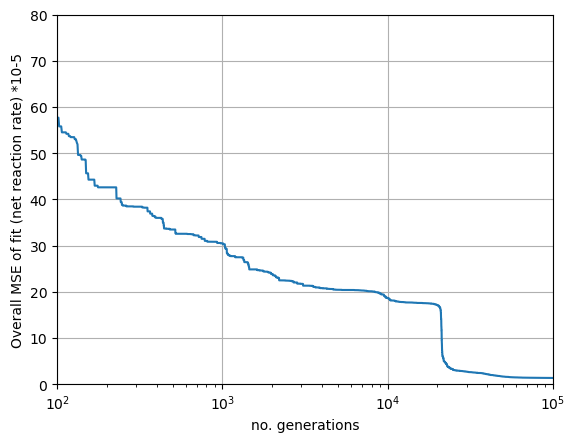

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 80])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-7.901138312301048
-8.40396920173762
-7.611823663952228
-8.781785573314668
-8.31778443577909
-7.154574132847177
-8.11794473928187
-9.379567069049255
-7.747792319674134
-6.831213471576806
-7.314690701458337
-7.980688208452906
-7.890233918965781
-6.864344663296465
-7.465246955481922
-7.49385629276665
-7.944147765318226
-8.96390236386376
-8.383020218240919
-6.537110054714709
-7.3371671952361135
-8.5978640309174
-9.959647903647976
-11.774290700221549
-8.359525459827962
-9.123862089625359
-1.3010299798460199


In [37]:
res.X

array([ -7.90113831,  -8.4039692 ,  -7.61182366,  -8.78178557,
        -8.31778444,  -7.15457413,  -8.11794474,  -9.37956707,
        -7.74779232,  -6.83121347,  -7.3146907 ,  -7.98068821,
        -7.89023392,  -6.86434466,  -7.46524696,  -7.49385629,
        -7.94414777,  -8.96390236,  -8.38302022,  -6.53711005,
        -7.3371672 ,  -8.59786403,  -9.9596479 , -11.7742907 ,
        -8.35952546,  -9.12386209,  -1.30102998])

In [38]:
logkr = [ 
    -7.9, -8.4, 
    -7.6, -8.8, -8.3,
    -7.1, -8.1, -10.9, -7.7, #-18.3, -7.7, 
    -6.8, -7.3, -8.0, -7.9,
    -6.8, -7.4, # -6.8, -7.4, 
    -7.4, -7.9, -9.1, -8.4,
    -6.5, -7.3, # -7.5, -8.3,
    -6.7, -7.5, -11.8,# -19.3,
    -7.3, -7.8]

for i in range(len (logkr)):
    print (logkr[i])

-7.9
-8.4
-7.6
-8.8
-8.3
-7.1
-8.1
-10.9
-7.7
-6.8
-7.3
-8.0
-7.9
-6.8
-7.4
-7.4
-7.9
-9.1
-8.4
-6.5
-7.3
-6.7
-7.5
-11.8
-7.3
-7.8


In [39]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

-7.9: -7.901138312301048
-8.4: -8.40396920173762
-7.6: -7.611823663952228
-8.8: -8.781785573314668
-8.3: -8.31778443577909
-7.1: -7.154574132847177
-8.1: -8.11794473928187
-10.9: -9.379567069049255
-7.7: -7.747792319674134
-6.8: -6.831213471576806
-7.3: -7.314690701458337
-8.0: -7.980688208452906
-7.9: -7.890233918965781
-6.8: -6.864344663296465
-7.4: -7.465246955481922
-7.4: -7.49385629276665
-7.9: -7.944147765318226
-9.1: -8.96390236386376
-8.4: -8.383020218240919
-6.5: -6.537110054714709
-7.3: -7.3371671952361135
-6.7: -8.5978640309174
-7.5: -9.959647903647976
-11.8: -11.774290700221549
-7.3: -8.359525459827962
-7.8: -9.123862089625359
R-value: 0.7615548863054051
R2: 0.5799658448556385


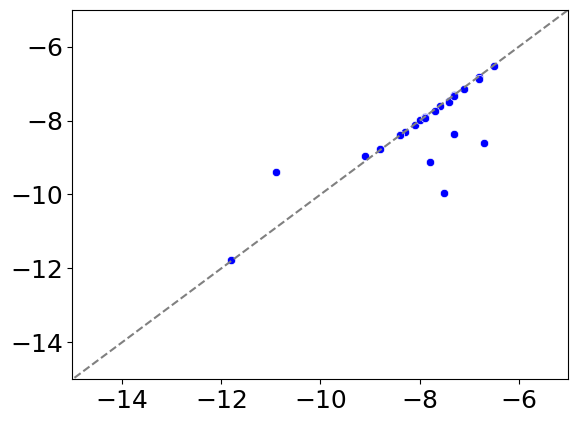

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= resX, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, -5])
plt.ylim([-15, -5])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-24, 0], [-24, 0], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()

In [ ]:
# Use stored solution
logkr = [ 
    -7.9, -8.4, 
    -7.6, -8.8, -8.3,
    -7.1, -8.1, -10.9, -7.7, #-18.3, -7.7, 
    -6.8, -7.3, -8.0, -7.9,
    -6.8, -7.4, # -6.8, -7.4, 
    -7.4, -7.9, -9.1, -8.4,
    -6.5, -7.3, # -7.5, -8.3,
    -6.7, -7.5, -11.8,# -19.3,
    -7.3, -7.8]   

y_mean = np.mean(logkr)

# average of log kr of 3 seeds

krseed1 = np.ndarray.tolist(res.X)
krseed10 = 
krseed101 = 

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([0, 10])
plt.ylim([0, 10])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()